In [1]:
!pip uninstall -y transformers transformer-smaller-training-vocab
!pip install transformers==4.30.0 transformer-smaller-training-vocab==0.2.3
!pip install textattack==0.3.10 torch>=2.0.0 scikit-learn>=1.0.0 joblib>=1.2.0 tqdm>=4.60.0 matplotlib>=3.7.0 seaborn>=0.12.0 flair jieba

Found existing installation: transformers 4.30.0
Uninstalling transformers-4.30.0:
  Successfully uninstalled transformers-4.30.0
Found existing installation: transformer-smaller-training-vocab 0.2.3
Uninstalling transformer-smaller-training-vocab-0.2.3:
  Successfully uninstalled transformer-smaller-training-vocab-0.2.3
  Using cached transformers-4.30.0-py3-none-any.whl.metadata (113 kB)
  Using cached transformer_smaller_training_vocab-0.2.3-py3-none-any.whl.metadata (7.9 kB)
Using cached transformers-4.30.0-py3-none-any.whl (7.2 MB)
Using cached transformer_smaller_training_vocab-0.2.3-py3-none-any.whl (12 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.30.0 which is incompatible.


In [29]:
import sys
import os
import numpy as np
import pandas as pd
import joblib
import logging
import warnings
from uuid import uuid4
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from textattack.models.wrappers import ModelWrapper
from textattack.datasets import Dataset
from textattack.attack_recipes import TextFoolerJin2019, PWWSRen2019, DeepWordBugGao2018
from textattack.attacker import Attacker
from textattack.attack_args import AttackArgs

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Define paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Data_RO"
MODELS_DIR = f"{DATA_DIR}/models"
RESULTS_DIR = f"{DATA_DIR}/results"
ATTACKS_DIR = f"{RESULTS_DIR}/attacks/baseline"
ROBUST_DIR = f"{RESULTS_DIR}/robust"
os.makedirs(ROBUST_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [20]:
# Load data
data_path = "/content/drive/MyDrive/Colab Notebooks/Data_RO/processed_splits.pkl"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Processed data not found at {data_path}")
data = joblib.load(data_path)
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test'][:3000]
y_test = data['y_test'][:3000]

In [21]:
# Load adversarial examples from multiple attack recipes
attack_names = ["TextFooler", "PWWS", "DeepWordBug"]
X_adv_combined = []
y_adv_combined = []

for attack_name in attack_names:
    attack_results_path = f"{ATTACKS_DIR}/{attack_name}/{attack_name}_attacked.csv"
    if not os.path.exists(attack_results_path):
        logger.warning(f"Attack results not found at {attack_results_path}. Skipping {attack_name}.")
        continue
    attack_df = pd.read_csv(attack_results_path)
    # Filter successful attacks
    successful_attacks = attack_df[attack_df['result_type'].str.contains('Success')]
    X_adv = successful_attacks['perturbed_text'].tolist()
    y_adv = successful_attacks['ground_truth'].map({'negative': 0, 'positive': 1}).tolist()
    X_adv_combined.extend(X_adv)
    y_adv_combined.extend(y_adv)
    logger.info(f"Loaded {len(X_adv)} successful adversarial examples from {attack_name}")

# Balance adversarial examples
from sklearn.utils import resample
adv_df = pd.DataFrame({'text': X_adv_combined, 'label': y_adv_combined})

# Check if there are any adversarial examples loaded before balancing
if not adv_df.empty:
    positive_adv = adv_df[adv_df['label'] == 1]
    negative_adv = adv_df[adv_df['label'] == 0]
    min_size = min(len(positive_adv), len(negative_adv))

    # Check if min_size is greater than 0 before resampling
    if min_size > 0:
        positive_adv_balanced = resample(positive_adv, replace=False, n_samples=min_size, random_state=42)
        negative_adv_balanced = resample(negative_adv, replace=False, n_samples=min_size, random_state=42)
        adv_df_balanced = pd.concat([positive_adv_balanced, negative_adv_balanced])
        X_adv_combined = adv_df_balanced['text'].tolist()
        y_adv_combined = adv_df_balanced['label'].tolist()
        logger.info(f"Balanced adversarial data: {len(X_adv_combined)} samples (positive: {sum(y_adv_combined)}, negative: {len(y_adv_combined) - sum(y_adv_combined)})")
    else:
        if len(positive_adv) > 0 and len(negative_adv) > 0:
             # This case should not be reached if min_size > 0
             pass # Keep original logic if somehow min_size is 0 but both > 0 (unlikely)
        else:
             logger.warning("Cannot balance adversarial data: one or both classes have no successful adversarial examples.")
             # Decide how to proceed: use imbalanced data, or effectively skip adversarial training
             # if balancing is critical. Sticking to the original combined data:
             # X_adv_combined and y_adv_combined already hold the imbalanced data.
             pass # Keep the current X_adv_combined and y_adv_combined which are the loaded imbalanced data

else:
    logger.warning("No successful adversarial examples found across all attack recipes. Skipping adversarial data balancing.")
    # X_adv_combined and y_adv_combined will remain empty lists.

logger.info(f"Final adversarial data size after attempted balancing: {len(X_adv_combined)} samples")

In [22]:
# Combine original and adversarial training data
X_train_combined = X_train.tolist() + X_adv_combined
y_train_combined = y_train.tolist() + y_adv_combined
logger.info(f"Combined training data: {len(X_train_combined)} samples")

In [23]:
# Train robust model with regularization
robust_model_path = f"{MODELS_DIR}/robust_baseline_model.pkl"
robust_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000, C=0.5, penalty='l2'))  # Added L2 regularization with C=0.5
])
logger.info("Training robust model...")
robust_pipeline.fit(X_train_combined, y_train_combined)
joblib.dump(robust_pipeline, robust_model_path)
logger.info(f"Saved robust model to {robust_model_path}")

In [25]:
# Load baseline model
baseline_model_path = "/content/drive/MyDrive/Colab Notebooks/Data_RO/models/baseline_model (1).pkl"
if not os.path.exists(baseline_model_path):
    raise FileNotFoundError(f"Baseline model not found at {baseline_model_path}")
baseline_pipeline = joblib.load(baseline_model_path)

In [26]:
# Custom Model Wrapper for TextAttack
class CustomModelWrapper(ModelWrapper):
    def __init__(self, pipeline):
        self.model = pipeline

    def __call__(self, text_input_list):
        return self.model.predict_proba(text_input_list)

In [27]:
# Create TextAttack dataset for evaluation
dataset = [(text, "negative" if label == 0 else "positive") for text, label in zip(X_test, y_test)]
textattack_dataset = Dataset(dataset, label_names=["negative", "positive"], label_map={"negative": 0, "positive": 1})

In [30]:
# Generate adversarial examples for robust model using multiple attacks
robust_attack_dir = f"{ROBUST_DIR}/combined_attacks"
os.makedirs(robust_attack_dir, exist_ok=True)
attack_recipes = [TextFoolerJin2019, PWWSRen2019, DeepWordBugGao2018]

for attack_recipe in attack_recipes:
    attack_name = attack_recipe.__name__.split('.')[-1]
    attack_args = AttackArgs(
        num_examples=1000,  # Reduced to 1000 for efficiency; adjust as needed
        log_to_csv=f"{robust_attack_dir}/{attack_name}_attacked.csv",
        log_to_txt=f"{robust_attack_dir}/{attack_name}_attack_summary.txt"
    )
    wrapped_robust_model = CustomModelWrapper(robust_pipeline)
    attack = attack_recipe.build(wrapped_robust_model)
    attacker = Attacker(attack, textattack_dataset, attack_args)
    logger.info(f"Running {attack_name} attack on robust model...")
    robust_results = attacker.attack_dataset()

    # Save robust attack results
    robust_result_df = pd.DataFrame({
        'original_text': [r.original_text() for r in robust_results],
        'perturbed_text': [r.perturbed_text() if r.perturbed_text else "" for r in robust_results],
        'ground_truth': [getattr(r, 'ground_truth_output', None) for r in robust_results],
        'result_type': [str(r) for r in robust_results]
    })
    robust_result_df.to_csv(f"{robust_attack_dir}/{attack_name}_attacked.csv", index=False)
    robust_result_df.to_excel(f"{robust_attack_dir}/{attack_name}_attacked.xlsx", index=False)
    logger.info(f"Saved {attack_name} results for robust model to {robust_attack_dir}")

textattack: Unknown if model of class <class 'sklearn.pipeline.Pipeline'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to text file at path /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/TextFoolerJin2019_attack_summary.txt
textattack: Logging to CSV at path /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/TextFoolerJin2019_attacked.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       


  0%|          | 1/1000 [00:12<3:32:04, 12.74s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/1000 [00:12<3:32:46, 12.78s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:   0%|          | 2/1000 [00:12<1:46:24,  6.40s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:   0%|          | 3/1000 [00:12<1:10:58,  4.27s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Negative (93%)]] --> [[Positive (64%)]]

isplayer [[died]] [[sorry]]

isplayer [[chip]] [[excuse]]


--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

wait release guessing photo placed myspace watch die


--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

natasha may able see weekend next free certain get excited hope





[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:   0%|          | 4/1000 [00:12<53:52,  3.25s/it]  
[Succeeded / Failed / Skipped / Total] 2 / 0 / 2 / 4:   0%|          | 4/1000 [00:13<54:07,  3.26s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 2 / 5:   0%|          | 5/1000 [00:13<43:44,  2.64s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (53%)]]

[[nice]] see [[wonderful]] sat [[hello]] friend looking forward seeing friend

[[pleasant]] see [[grand]] sat [[goodbye]] friend looking forward seeing friend


--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (53%)]]

thinkin getting uniform [[second]] period [[talked]] would [[mind]] hogwarts uniform

thinkin getting uniform [[ii]] period [[spoke]] would [[thought]] hogwarts uniform





[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:   1%|          | 6/1000 [00:13<36:53,  2.23s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:   1%|          | 7/1000 [00:13<31:45,  1.92s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 2 / 7:   1%|          | 7/1000 [00:13<31:48,  1.92s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 2 / 8:   1%|          | 8/1000 [00:13<27:59,  1.69s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (62%)]]

[[officially]] [[birthday]] [[guess]] [[novelty]] [[birthday]] [[wear]]

[[ceremoniously]] [[commemorative]] [[feel]] [[fantasy]] [[anniversary]] [[bear]]


--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (61%)]]

country bear [[good]] [[movie]]

country bear [[bueno]] [[footage]]


--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (57%)]]

[[take]] loli impressed

[[took]] loli impressed





[Succeeded / Failed / Skipped / Total] 6 / 0 / 3 / 9:   1%|          | 9/1000 [00:13<24:53,  1.51s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 3 / 9:   1%|          | 10/1000 [00:13<22:23,  1.36s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 4 / 10:   1%|          | 10/1000 [00:13<22:25,  1.36s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 4 / 11:   1%|          | 11/1000 [00:13<20:33,  1.25s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 5 / 12:   1%|          | 12/1000 [00:13<18:53,  1.15s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

going schoolor riding sheep


--------------------------------------------- Result 10 ---------------------------------------------
[[Negative (76%)]] --> [[[SKIPPED]]]

many making money even considering trying cash


--------------------------------------------- Result 11 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (52%)]]

demo file prosecution file code enforcement meeting [[much]] quoteasy fridayquot

demo file prosecution file code enforcement meeting [[plenty]] quoteasy fridayquot


--------------------------------------------- Result 12 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

apple macbook pro quot screen capture failure idea time time





[Succeeded / Failed / Skipped / Total] 7 / 0 / 5 / 12:   1%|▏         | 13/1000 [00:13<17:28,  1.06s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 5 / 13:   1%|▏         | 13/1000 [00:13<17:30,  1.06s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 5 / 14:   1%|▏         | 14/1000 [00:13<16:23,  1.00it/s]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 5 / 15:   2%|▏         | 15/1000 [00:14<15:20,  1.07it/s]

--------------------------------------------- Result 13 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (80%)]]

[[thinking]] fryup culturallytemporally appropriate sort

[[feel]] fryup culturallytemporally appropriate sort


--------------------------------------------- Result 14 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (51%)]]

need college [[work]] [[work]] food

need college [[labor]] [[labor]] food


--------------------------------------------- Result 15 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (59%)]]

heyy find [[twitter]]

heyy find [[gmail]]





[Succeeded / Failed / Skipped / Total] 10 / 0 / 5 / 15:   2%|▏         | 16/1000 [00:14<14:28,  1.13it/s]
[Succeeded / Failed / Skipped / Total] 11 / 0 / 5 / 16:   2%|▏         | 16/1000 [00:14<14:30,  1.13it/s]
[Succeeded / Failed / Skipped / Total] 12 / 0 / 5 / 17:   2%|▏         | 17/1000 [00:14<13:42,  1.19it/s]
[Succeeded / Failed / Skipped / Total] 13 / 0 / 5 / 18:   2%|▏         | 18/1000 [00:14<13:02,  1.26it/s]

--------------------------------------------- Result 16 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (65%)]]

calling pick [[leave]] pretty much [[tired]]

calling pick [[let]] pretty much [[sleepy]]


--------------------------------------------- Result 17 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (63%)]]

[[want]] sticker

[[liked]] sticker


--------------------------------------------- Result 18 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (53%)]]

[[hahahaha]] [[funniest]] thing ever beks always mom group

[[kno]] [[comic]] thing ever beks always mom group





[Succeeded / Failed / Skipped / Total] 13 / 0 / 5 / 18:   2%|▏         | 19/1000 [00:14<12:23,  1.32it/s]
[Succeeded / Failed / Skipped / Total] 14 / 0 / 5 / 19:   2%|▏         | 19/1000 [00:14<12:25,  1.32it/s]
[Succeeded / Failed / Skipped / Total] 15 / 0 / 5 / 20:   2%|▏         | 20/1000 [00:14<11:51,  1.38it/s]
[Succeeded / Failed / Skipped / Total] 15 / 0 / 6 / 21:   2%|▏         | 21/1000 [00:14<11:17,  1.44it/s]
[Succeeded / Failed / Skipped / Total] 15 / 0 / 6 / 21:   2%|▏         | 22/1000 [00:14<10:46,  1.51it/s]
[Succeeded / Failed / Skipped / Total] 15 / 0 / 7 / 22:   2%|▏         | 22/1000 [00:14<10:47,  1.51it/s]

--------------------------------------------- Result 19 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (62%)]]

haaaaaaaaaaaan see traiiiiiiiiiiiiiiiiiiler [[want]] video pleaseeeeeeeeeeeeeee

haaaaaaaaaaaan see traiiiiiiiiiiiiiiiiiiler [[liked]] video pleaseeeeeeeeeeeeeee


--------------------------------------------- Result 20 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (58%)]]

jared avatar [[still]] showing tweetie

jared avatar [[anyway]] showing tweetie


--------------------------------------------- Result 21 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

good bye twitter hour


--------------------------------------------- Result 22 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

mmm alphabet cereal really kickin old school





[Succeeded / Failed / Skipped / Total] 16 / 0 / 7 / 23:   2%|▏         | 23/1000 [00:14<10:22,  1.57it/s]
[Succeeded / Failed / Skipped / Total] 17 / 0 / 7 / 24:   2%|▏         | 24/1000 [00:14<09:59,  1.63it/s]
[Succeeded / Failed / Skipped / Total] 17 / 0 / 7 / 24:   2%|▎         | 25/1000 [00:14<09:36,  1.69it/s]
[Succeeded / Failed / Skipped / Total] 18 / 0 / 7 / 25:   2%|▎         | 25/1000 [00:14<09:38,  1.69it/s]

--------------------------------------------- Result 23 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (55%)]]

server going lot lately make [[sad]] wow player lol

server going lot lately make [[pathetic]] wow player lol


--------------------------------------------- Result 24 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (54%)]]

hampton summer kickoff start tomorrow home [[amp]] [[garden]] show

hampton summer kickoff start tomorrow home [[amps]] [[backyard]] show


--------------------------------------------- Result 25 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (61%)]]

creative symposium advertising club [[see]] tonight

creative symposium advertising club [[believe]] tonight





[Succeeded / Failed / Skipped / Total] 19 / 0 / 7 / 26:   3%|▎         | 26/1000 [00:14<09:18,  1.75it/s]
[Succeeded / Failed / Skipped / Total] 20 / 0 / 7 / 27:   3%|▎         | 27/1000 [00:14<09:00,  1.80it/s]
[Succeeded / Failed / Skipped / Total] 20 / 0 / 7 / 27:   3%|▎         | 28/1000 [00:15<08:40,  1.87it/s]
[Succeeded / Failed / Skipped / Total] 20 / 0 / 8 / 28:   3%|▎         | 28/1000 [00:15<08:41,  1.86it/s]

--------------------------------------------- Result 26 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (64%)]]

[[yes]] like version

[[awww]] like version


--------------------------------------------- Result 27 ---------------------------------------------
[[Positive (97%)]] --> [[Negative (51%)]]

wow [[awesome]] [[thank]]

wow [[grand]] [[tribute]]


--------------------------------------------- Result 28 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

watching quotemployee monthquot funny movie want watch quotomenquot look scary





[Succeeded / Failed / Skipped / Total] 21 / 0 / 8 / 29:   3%|▎         | 29/1000 [00:15<08:26,  1.92it/s]
[Succeeded / Failed / Skipped / Total] 21 / 0 / 9 / 30:   3%|▎         | 30/1000 [00:15<08:10,  1.98it/s]
[Succeeded / Failed / Skipped / Total] 21 / 0 / 9 / 30:   3%|▎         | 31/1000 [00:15<07:55,  2.04it/s]
[Succeeded / Failed / Skipped / Total] 22 / 0 / 9 / 31:   3%|▎         | 31/1000 [00:15<07:56,  2.03it/s]
[Succeeded / Failed / Skipped / Total] 22 / 0 / 10 / 32:   3%|▎         | 32/1000 [00:15<07:41,  2.10it/s]

--------------------------------------------- Result 29 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (51%)]]

raisin [[best]] thiiiing

raisin [[preferably]] thiiiing


--------------------------------------------- Result 30 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

bout damn time also reserve sarcasmagorical case


--------------------------------------------- Result 31 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (75%)]]

[[nice]] want watch

[[agreeable]] want watch


--------------------------------------------- Result 32 ---------------------------------------------
[[Positive (73%)]] --> [[[SKIPPED]]]

okayyyy good hope last





[Succeeded / Failed / Skipped / Total] 23 / 0 / 10 / 33:   3%|▎         | 33/1000 [00:15<07:30,  2.15it/s]
[Succeeded / Failed / Skipped / Total] 23 / 0 / 10 / 33:   3%|▎         | 34/1000 [00:15<07:21,  2.19it/s]

--------------------------------------------- Result 33 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (50%)]]

waking catch plane [[fine]] private jet sound [[good]]

waking catch plane [[bueno]] private jet sound [[advantageous]]





[Succeeded / Failed / Skipped / Total] 24 / 0 / 10 / 34:   3%|▎         | 34/1000 [00:15<07:23,  2.18it/s]
[Succeeded / Failed / Skipped / Total] 25 / 0 / 10 / 35:   4%|▎         | 35/1000 [00:15<07:14,  2.22it/s]

--------------------------------------------- Result 34 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (55%)]]

[[computer]] system [[broke]] file [[gone]] especially precious picture [[damn]] got start scratch

[[device]] system [[popped]] file [[disappear]] especially precious picture [[jesus]] got start scratch


--------------------------------------------- Result 35 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (57%)]]

gnight [[twitter]] coffee almost worn [[time]] get [[rest]]

gnight [[gmail]] coffee almost worn [[hour]] get [[stayed]]





[Succeeded / Failed / Skipped / Total] 26 / 0 / 10 / 36:   4%|▎         | 36/1000 [00:15<07:06,  2.26it/s]
[Succeeded / Failed / Skipped / Total] 26 / 0 / 10 / 36:   4%|▎         | 37/1000 [00:15<06:54,  2.32it/s]
[Succeeded / Failed / Skipped / Total] 26 / 0 / 11 / 37:   4%|▎         | 37/1000 [00:15<06:55,  2.32it/s]
[Succeeded / Failed / Skipped / Total] 26 / 0 / 12 / 38:   4%|▍         | 38/1000 [00:15<06:44,  2.38it/s]
[Succeeded / Failed / Skipped / Total] 27 / 0 / 12 / 39:   4%|▍         | 39/1000 [00:16<06:35,  2.43it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (73%)]]

[[dinner]] menteng mom almost hour grandindo [[happy]]

[[ate]] menteng mom almost hour grandindo [[joyous]]


--------------------------------------------- Result 37 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

lonelified well longest journey keep amused


--------------------------------------------- Result 38 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

hey supposed prepping commits allowed giving talk


--------------------------------------------- Result 39 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (53%)]]

spilled water [[phone]] ehhggg

spilled water [[drew]] ehhggg





[Succeeded / Failed / Skipped / Total] 27 / 0 / 12 / 39:   4%|▍         | 40/1000 [00:16<06:26,  2.48it/s]
[Succeeded / Failed / Skipped / Total] 28 / 0 / 12 / 40:   4%|▍         | 40/1000 [00:16<06:27,  2.48it/s]
[Succeeded / Failed / Skipped / Total] 29 / 0 / 12 / 41:   4%|▍         | 41/1000 [00:16<06:19,  2.53it/s]
[Succeeded / Failed / Skipped / Total] 30 / 0 / 12 / 42:   4%|▍         | 42/1000 [00:16<06:12,  2.57it/s]

--------------------------------------------- Result 40 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (58%)]]

[[thanks]] although jeweller publsihers

[[tribute]] although jeweller publsihers


--------------------------------------------- Result 41 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (57%)]]

[[hindi]] ekdum theek bhaisaab

[[indiana]] ekdum theek bhaisaab


--------------------------------------------- Result 42 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (76%)]]

[[loving]] [[hey]] monday paramore sooo much

[[adored]] [[goodbye]] monday paramore sooo much





[Succeeded / Failed / Skipped / Total] 30 / 0 / 12 / 42:   4%|▍         | 43/1000 [00:16<06:03,  2.63it/s]
[Succeeded / Failed / Skipped / Total] 30 / 0 / 13 / 43:   4%|▍         | 43/1000 [00:16<06:04,  2.62it/s]
[Succeeded / Failed / Skipped / Total] 31 / 0 / 13 / 44:   4%|▍         | 44/1000 [00:16<05:58,  2.67it/s]
[Succeeded / Failed / Skipped / Total] 31 / 0 / 14 / 45:   4%|▍         | 45/1000 [00:16<05:50,  2.73it/s]
[Succeeded / Failed / Skipped / Total] 31 / 0 / 14 / 45:   5%|▍         | 46/1000 [00:16<05:43,  2.78it/s]

--------------------------------------------- Result 43 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

got prayer runescape


--------------------------------------------- Result 44 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (52%)]]

got tonsillitis [[hurt]]

got tonsillitis [[wicked]]


--------------------------------------------- Result 45 ---------------------------------------------
[[Negative (74%)]] --> [[[SKIPPED]]]

ohhhhh feel like ben jerry brownie ice cream think mite store get back xxxox


--------------------------------------------- Result 46 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 32 / 0 / 14 / 46:   5%|▍         | 46/1000 [00:16<05:44,  2.77it/s]
[Succeeded / Failed / Skipped / Total] 33 / 0 / 14 / 47:   5%|▍         | 47/1000 [00:16<05:38,  2.81it/s]

[[Positive (70%)]] --> [[Negative (75%)]]

[[definitely]] lifechanger

[[apparently]] lifechanger


--------------------------------------------- Result 47 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (51%)]]

half [[went]] [[away]]

half [[became]] [[aside]]





[Succeeded / Failed / Skipped / Total] 34 / 0 / 14 / 48:   5%|▍         | 48/1000 [00:16<05:34,  2.85it/s]
[Succeeded / Failed / Skipped / Total] 34 / 0 / 14 / 48:   5%|▍         | 49/1000 [00:16<05:27,  2.91it/s]
[Succeeded / Failed / Skipped / Total] 34 / 0 / 15 / 49:   5%|▍         | 49/1000 [00:16<05:27,  2.90it/s]
[Succeeded / Failed / Skipped / Total] 35 / 0 / 15 / 50:   5%|▌         | 50/1000 [00:16<05:22,  2.94it/s]

--------------------------------------------- Result 48 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (63%)]]

wish adri woke [[happy]] everyday cute see little [[smile]] walked room

wish adri woke [[lucky]] everyday cute see little [[chuckle]] walked room


--------------------------------------------- Result 49 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

aww thanks crystal really hard watching guy hit girl one


--------------------------------------------- Result 50 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (55%)]]

[[haha]] like tagged

[[sorta]] like tagged





[Succeeded / Failed / Skipped / Total] 36 / 0 / 15 / 51:   5%|▌         | 51/1000 [00:17<05:21,  2.96it/s]
[Succeeded / Failed / Skipped / Total] 36 / 0 / 15 / 51:   5%|▌         | 52/1000 [00:17<05:14,  3.01it/s]
[Succeeded / Failed / Skipped / Total] 36 / 0 / 16 / 52:   5%|▌         | 52/1000 [00:17<05:14,  3.01it/s]
[Succeeded / Failed / Skipped / Total] 36 / 0 / 17 / 53:   5%|▌         | 53/1000 [00:17<05:09,  3.06it/s]
[Succeeded / Failed / Skipped / Total] 37 / 0 / 17 / 54:   5%|▌         | 54/1000 [00:17<05:04,  3.11it/s]

--------------------------------------------- Result 51 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (58%)]]

sitting [[dallas]] waiting flight back queen city [[believe]] [[work]] get back [[damn]]

sitting [[daley]] waiting flight back queen city [[opinion]] [[labor]] get back [[jesus]]


--------------------------------------------- Result 52 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

stayed til reading finishing book got sleep really work tomorrow


--------------------------------------------- Result 53 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

pick package post office know paid still feel like present


--------------------------------------------- Result 54 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (57%)]]

never leanne like mind also [[failed]] twice already

never leanne like mind also [[beached]] twice already





[Succeeded / Failed / Skipped / Total] 37 / 0 / 17 / 54:   6%|▌         | 55/1000 [00:17<05:00,  3.14it/s]
[Succeeded / Failed / Skipped / Total] 38 / 0 / 17 / 55:   6%|▌         | 55/1000 [00:17<05:01,  3.14it/s]
[Succeeded / Failed / Skipped / Total] 38 / 0 / 18 / 56:   6%|▌         | 56/1000 [00:17<04:55,  3.19it/s]

--------------------------------------------- Result 55 ---------------------------------------------
[[Negative (95%)]] --> [[Positive (62%)]]

[[shame]] beejive [[supported]] [[anymore]] open sourced

[[injury]] beejive [[helped]] [[also]] open sourced


--------------------------------------------- Result 56 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

melbourne deserves attention katy perry tix melbourne plzzzzzzzzzzzzzzzzzz


--------------------------------------------- Result 57 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 39 / 0 / 18 / 57:   6%|▌         | 57/1000 [00:17<04:53,  3.21it/s]
[Succeeded / Failed / Skipped / Total] 39 / 0 / 18 / 57:   6%|▌         | 58/1000 [00:17<04:49,  3.25it/s]
[Succeeded / Failed / Skipped / Total] 40 / 0 / 18 / 58:   6%|▌         | 58/1000 [00:17<04:50,  3.24it/s]

[[Negative (79%)]] --> [[Positive (58%)]]

[[leave]] skwl [[min]]

[[license]] skwl [[minnesota]]


--------------------------------------------- Result 58 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (66%)]]

awe [[poor]] girl tell buy delicious ice cream make grossness

awe [[amiss]] girl tell buy delicious ice cream make grossness


--------------------------------------------- Result 59 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (60%)]]

[[bored]] waiting toto [[work]]

[[piercing]] waiting toto [[labor]]





[Succeeded / Failed / Skipped / Total] 41 / 0 / 18 / 59:   6%|▌         | 59/1000 [00:17<04:46,  3.28it/s]
[Succeeded / Failed / Skipped / Total] 41 / 0 / 19 / 60:   6%|▌         | 60/1000 [00:17<04:41,  3.33it/s]
[Succeeded / Failed / Skipped / Total] 41 / 0 / 19 / 60:   6%|▌         | 61/1000 [00:18<04:38,  3.38it/s]
[Succeeded / Failed / Skipped / Total] 42 / 0 / 19 / 61:   6%|▌         | 61/1000 [00:18<04:38,  3.37it/s]
[Succeeded / Failed / Skipped / Total] 43 / 0 / 19 / 62:   6%|▌         | 62/1000 [00:18<04:34,  3.41it/s]

--------------------------------------------- Result 60 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

wan massa finish atleast cmon he driven brilliant race


--------------------------------------------- Result 61 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (66%)]]

wired dream [[last]] night [[scary]]

wired dream [[former]] night [[chilling]]


--------------------------------------------- Result 62 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (54%)]]

[[wanted]] realized something att supported yet

[[enjoyed]] realized something att supported yet





[Succeeded / Failed / Skipped / Total] 43 / 0 / 20 / 63:   6%|▋         | 63/1000 [00:18<04:30,  3.46it/s]
[Succeeded / Failed / Skipped / Total] 43 / 0 / 20 / 63:   6%|▋         | 64/1000 [00:18<04:26,  3.51it/s]
[Succeeded / Failed / Skipped / Total] 43 / 1 / 20 / 64:   6%|▋         | 64/1000 [00:18<04:27,  3.51it/s]
[Succeeded / Failed / Skipped / Total] 43 / 2 / 20 / 65:   6%|▋         | 65/1000 [00:18<04:23,  3.55it/s]
[Succeeded / Failed / Skipped / Total] 44 / 2 / 20 / 66:   7%|▋         | 66/1000 [00:18<04:20,  3.59it/s]

--------------------------------------------- Result 63 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

caress pinch


--------------------------------------------- Result 64 ---------------------------------------------
[[Negative (87%)]] --> [[[FAILED]]]

bored could akon


--------------------------------------------- Result 65 ---------------------------------------------
[[Positive (85%)]] --> [[[FAILED]]]

finally bed gnight tweeps


--------------------------------------------- Result 66 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (63%)]]

[[glass]] ever stay clean

[[moon]] ever stay clean





[Succeeded / Failed / Skipped / Total] 44 / 2 / 20 / 66:   7%|▋         | 67/1000 [00:18<04:16,  3.64it/s]
[Succeeded / Failed / Skipped / Total] 45 / 2 / 20 / 67:   7%|▋         | 67/1000 [00:18<04:17,  3.63it/s]
[Succeeded / Failed / Skipped / Total] 45 / 3 / 20 / 68:   7%|▋         | 68/1000 [00:18<04:13,  3.68it/s]
[Succeeded / Failed / Skipped / Total] 46 / 3 / 20 / 69:   7%|▋         | 69/1000 [00:18<04:11,  3.70it/s]

--------------------------------------------- Result 67 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (60%)]]

[[scared]] happen

[[worry]] happen


--------------------------------------------- Result 68 ---------------------------------------------
[[Negative (52%)]] --> [[[FAILED]]]

chillinthen paradelast one ever


--------------------------------------------- Result 69 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (55%)]]

[[better]] [[way]] spend [[night]] wasting

[[preferably]] [[form]] spend [[dark]] wasting





[Succeeded / Failed / Skipped / Total] 46 / 3 / 20 / 69:   7%|▋         | 70/1000 [00:18<04:09,  3.72it/s]
[Succeeded / Failed / Skipped / Total] 47 / 3 / 20 / 70:   7%|▋         | 70/1000 [00:18<04:10,  3.72it/s]
[Succeeded / Failed / Skipped / Total] 47 / 3 / 21 / 71:   7%|▋         | 71/1000 [00:18<04:06,  3.77it/s]
[Succeeded / Failed / Skipped / Total] 48 / 3 / 21 / 72:   7%|▋         | 72/1000 [00:18<04:03,  3.81it/s]
[Succeeded / Failed / Skipped / Total] 48 / 3 / 21 / 72:   7%|▋         | 73/1000 [00:18<04:01,  3.85it/s]
[Succeeded / Failed / Skipped / Total] 49 / 3 / 21 / 73:   7%|▋         | 73/1000 [00:19<04:01,  3.84it/s]

--------------------------------------------- Result 70 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (58%)]]

[[raining]] [[forgot]] umbrella better [[work]] todaythe sweat shop without lol

[[acid]] [[forget]] umbrella better [[labor]] todaythe sweat shop without lol


--------------------------------------------- Result 71 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

evening lady tonite guess could call batchorlette party men kid allowed


--------------------------------------------- Result 72 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (51%)]]

bos mad going [[work]] sunday count life next day

bos mad going [[labor]] sunday count life next day


--------------------------------------------- Result 73 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (55%)]]

like queen two birthday one today unlike get national holiday people [[wishing]] well 


[Succeeded / Failed / Skipped / Total] 50 / 3 / 21 / 74:   7%|▋         | 74/1000 [00:19<03:58,  3.88it/s]
[Succeeded / Failed / Skipped / Total] 51 / 3 / 21 / 75:   8%|▊         | 75/1000 [00:19<03:57,  3.90it/s]
[Succeeded / Failed / Skipped / Total] 51 / 3 / 21 / 75:   8%|▊         | 76/1000 [00:19<03:54,  3.95it/s]

--------------------------------------------- Result 74 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (62%)]]

going watch problem child [[lovely]]

going watch problem child [[loverly]]


--------------------------------------------- Result 75 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (53%)]]

[[cute]] [[love]] parent start early

[[appetizing]] [[darling]] parent start early





[Succeeded / Failed / Skipped / Total] 51 / 3 / 22 / 76:   8%|▊         | 76/1000 [00:19<03:54,  3.94it/s]
[Succeeded / Failed / Skipped / Total] 52 / 3 / 22 / 77:   8%|▊         | 77/1000 [00:19<03:52,  3.97it/s]

--------------------------------------------- Result 76 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

obamas speech correspondent association promised complete next day


--------------------------------------------- Result 77 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (58%)]]

rebel [[missed]] one

rebel [[forget]] one





[Succeeded / Failed / Skipped / Total] 53 / 3 / 22 / 78:   8%|▊         | 78/1000 [00:19<03:51,  3.98it/s]
[Succeeded / Failed / Skipped / Total] 53 / 3 / 22 / 78:   8%|▊         | 79/1000 [00:19<03:48,  4.03it/s]
[Succeeded / Failed / Skipped / Total] 53 / 3 / 23 / 79:   8%|▊         | 79/1000 [00:19<03:48,  4.02it/s]
[Succeeded / Failed / Skipped / Total] 53 / 3 / 24 / 80:   8%|▊         | 80/1000 [00:19<03:46,  4.07it/s]
[Succeeded / Failed / Skipped / Total] 53 / 3 / 25 / 81:   8%|▊         | 81/1000 [00:19<03:43,  4.11it/s]

--------------------------------------------- Result 78 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (58%)]]

[[woohoo]] ampabout already [[great]] start busy day full lot first going jog shower taking

[[argh]] ampabout already [[massive]] start busy day full lot first going jog shower taking


--------------------------------------------- Result 79 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

got little scared moment thought wind blowing really hard someone said earthquake cool


--------------------------------------------- Result 80 ---------------------------------------------
[[Negative (68%)]] --> [[[SKIPPED]]]

body pain serious workout week good right


--------------------------------------------- Result 81 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

hope everything okay





[Succeeded / Failed / Skipped / Total] 53 / 3 / 25 / 81:   8%|▊         | 82/1000 [00:20<03:44,  4.09it/s]
[Succeeded / Failed / Skipped / Total] 54 / 3 / 25 / 82:   8%|▊         | 82/1000 [00:20<03:45,  4.07it/s]
[Succeeded / Failed / Skipped / Total] 55 / 3 / 25 / 83:   8%|▊         | 83/1000 [00:20<03:43,  4.10it/s]

--------------------------------------------- Result 82 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (67%)]]

[[welcome]] [[twitter]] lifestyle podnetwork [[looking]] [[forward]] [[listening]] first epsiode come

[[thankful]] [[gmail]] lifestyle podnetwork [[wishing]] [[anxiously]] [[hear]] first epsiode come


--------------------------------------------- Result 83 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (63%)]]

[[burnt]] cheese tomato toasted sandwhich

[[alight]] cheese tomato toasted sandwhich





[Succeeded / Failed / Skipped / Total] 56 / 3 / 25 / 84:   8%|▊         | 84/1000 [00:20<03:42,  4.12it/s]
[Succeeded / Failed / Skipped / Total] 56 / 3 / 25 / 84:   8%|▊         | 85/1000 [00:20<03:40,  4.15it/s]
[Succeeded / Failed / Skipped / Total] 57 / 3 / 25 / 85:   8%|▊         | 85/1000 [00:20<03:41,  4.14it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[Negative (59%)]] --> [[Positive (51%)]]

[[fuck]] retardedness mean sure sometimes stuff upbut need careful reserach

[[accursed]] retardedness mean sure sometimes stuff upbut need careful reserach


--------------------------------------------- Result 85 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (53%)]]

[[mention]] get put daily draw iphone website info

[[spoke]] get put daily draw iphone website info





[Succeeded / Failed / Skipped / Total] 57 / 3 / 26 / 86:   9%|▊         | 86/1000 [00:20<03:38,  4.18it/s]
[Succeeded / Failed / Skipped / Total] 58 / 3 / 26 / 87:   9%|▊         | 87/1000 [00:20<03:36,  4.21it/s]
[Succeeded / Failed / Skipped / Total] 58 / 3 / 26 / 87:   9%|▉         | 88/1000 [00:20<03:34,  4.24it/s]

--------------------------------------------- Result 86 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

true blood detected


--------------------------------------------- Result 87 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (54%)]]

shadow lurking willy probably prove [[wrong]]

shadow lurking willy probably prove [[amiss]]





[Succeeded / Failed / Skipped / Total] 59 / 3 / 26 / 88:   9%|▉         | 88/1000 [00:20<03:36,  4.22it/s]
[Succeeded / Failed / Skipped / Total] 59 / 3 / 27 / 89:   9%|▉         | 89/1000 [00:20<03:33,  4.26it/s]
[Succeeded / Failed / Skipped / Total] 59 / 3 / 28 / 90:   9%|▉         | 90/1000 [00:20<03:31,  4.30it/s]

--------------------------------------------- Result 88 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (51%)]]

farrah fawcett [[died]] morning

farrah fawcett [[chip]] morning


--------------------------------------------- Result 89 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

illl photoshoot well honest


--------------------------------------------- Result 90 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

back vega sure exciting wanted major disappointment





[Succeeded / Failed / Skipped / Total] 59 / 3 / 28 / 90:   9%|▉         | 91/1000 [00:21<03:30,  4.31it/s]
[Succeeded / Failed / Skipped / Total] 60 / 3 / 28 / 91:   9%|▉         | 91/1000 [00:21<03:32,  4.28it/s]
[Succeeded / Failed / Skipped / Total] 61 / 3 / 28 / 92:   9%|▉         | 92/1000 [00:21<03:31,  4.30it/s]

--------------------------------------------- Result 91 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (52%)]]

[[afternoon]] [[love]] [[beautiful]] [[day]]

[[tonight]] [[darling]] [[super]] [[today]]


--------------------------------------------- Result 92 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (58%)]]

[[listening]] time low

[[bugging]] time low





[Succeeded / Failed / Skipped / Total] 62 / 3 / 28 / 93:   9%|▉         | 93/1000 [00:21<03:29,  4.33it/s]
[Succeeded / Failed / Skipped / Total] 62 / 3 / 28 / 93:   9%|▉         | 94/1000 [00:21<03:27,  4.38it/s]
[Succeeded / Failed / Skipped / Total] 62 / 3 / 29 / 94:   9%|▉         | 94/1000 [00:21<03:27,  4.37it/s]

--------------------------------------------- Result 93 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (55%)]]

fudge [[math]] tomorrow

fudge [[calculator]] tomorrow


--------------------------------------------- Result 94 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

hope great time colin actually degree kinsale todaytoo hot work





[Succeeded / Failed / Skipped / Total] 63 / 3 / 29 / 95:  10%|▉         | 95/1000 [00:21<03:27,  4.37it/s]
[Succeeded / Failed / Skipped / Total] 63 / 3 / 30 / 96:  10%|▉         | 96/1000 [00:21<03:25,  4.41it/s]
[Succeeded / Failed / Skipped / Total] 63 / 3 / 30 / 96:  10%|▉         | 97/1000 [00:21<03:23,  4.43it/s]

--------------------------------------------- Result 95 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (59%)]]

gosh got cpr [[class]] [[hour]] minute early today [[thought]] started

gosh got cpr [[kind]] [[moment]] minute early today [[opinion]] started


--------------------------------------------- Result 96 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

went vega like last year think around time killed animal old car lol





[Succeeded / Failed / Skipped / Total] 64 / 3 / 30 / 97:  10%|▉         | 97/1000 [00:22<03:24,  4.41it/s]
[Succeeded / Failed / Skipped / Total] 64 / 3 / 31 / 98:  10%|▉         | 98/1000 [00:22<03:23,  4.44it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (67%)]]

[[hey]] danny gig last night going [[new]] album plz answer

[[goodbye]] danny gig last night going [[youngest]] album plz answer


--------------------------------------------- Result 98 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

stevo wot day holla





[Succeeded / Failed / Skipped / Total] 65 / 3 / 31 / 99:  10%|▉         | 99/1000 [00:22<03:21,  4.46it/s]
[Succeeded / Failed / Skipped / Total] 65 / 3 / 31 / 99:  10%|█         | 100/1000 [00:22<03:20,  4.49it/s]
[Succeeded / Failed / Skipped / Total] 66 / 3 / 31 / 100:  10%|█         | 100/1000 [00:22<03:21,  4.47it/s]

--------------------------------------------- Result 99 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (52%)]]

another loser [[lost]] game

another loser [[wasting]] game


--------------------------------------------- Result 100 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (64%)]]

favorite part tonight show jay leno jaywalking loved [[miss]]

favorite part tonight show jay leno jaywalking loved [[missy]]





[Succeeded / Failed / Skipped / Total] 66 / 3 / 32 / 101:  10%|█         | 101/1000 [00:22<03:19,  4.51it/s]

--------------------------------------------- Result 101 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

huni saw myspace lil agoi sent message got





[Succeeded / Failed / Skipped / Total] 67 / 3 / 32 / 102:  10%|█         | 102/1000 [00:22<03:19,  4.50it/s]
[Succeeded / Failed / Skipped / Total] 67 / 3 / 32 / 102:  10%|█         | 103/1000 [00:22<03:18,  4.52it/s]

--------------------------------------------- Result 102 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (59%)]]

[[sure]] [[quote]] [[saying]] year

[[certain]] [[mentioning]] [[telling]] year





[Succeeded / Failed / Skipped / Total] 68 / 3 / 32 / 103:  10%|█         | 103/1000 [00:22<03:19,  4.50it/s]
[Succeeded / Failed / Skipped / Total] 69 / 3 / 32 / 104:  10%|█         | 104/1000 [00:23<03:18,  4.51it/s]

--------------------------------------------- Result 103 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (56%)]]

[[hate]] bein [[bad]] mood sunny day

[[dislike]] bein [[adverse]] mood sunny day


--------------------------------------------- Result 104 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (64%)]]

dang official bro [[broke]] wrisy arm somethin first sign cast

dang official bro [[smash]] wrisy arm somethin first sign cast





[Succeeded / Failed / Skipped / Total] 70 / 3 / 32 / 105:  10%|█         | 105/1000 [00:23<03:17,  4.53it/s]
[Succeeded / Failed / Skipped / Total] 70 / 3 / 32 / 105:  11%|█         | 106/1000 [00:23<03:16,  4.55it/s]
[Succeeded / Failed / Skipped / Total] 71 / 3 / 32 / 106:  11%|█         | 106/1000 [00:23<03:17,  4.54it/s]

--------------------------------------------- Result 105 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (63%)]]

viva [[work]] building wataniya

viva [[labor]] building wataniya


--------------------------------------------- Result 106 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (61%)]]

[[thank]] missus hogani [[finally]] xxx

[[tribute]] missus hogani [[still]] xxx





[Succeeded / Failed / Skipped / Total] 72 / 3 / 32 / 107:  11%|█         | 107/1000 [00:23<03:16,  4.54it/s]
[Succeeded / Failed / Skipped / Total] 73 / 3 / 32 / 108:  11%|█         | 108/1000 [00:23<03:15,  4.56it/s]
[Succeeded / Failed / Skipped / Total] 73 / 3 / 32 / 108:  11%|█         | 109/1000 [00:23<03:13,  4.60it/s]
[Succeeded / Failed / Skipped / Total] 73 / 3 / 33 / 109:  11%|█         | 109/1000 [00:23<03:13,  4.60it/s]

--------------------------------------------- Result 107 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (52%)]]

super duper [[upset]]

super duper [[irritated]]


--------------------------------------------- Result 108 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (70%)]]

may well [[cry]]

may well [[shout]]


--------------------------------------------- Result 109 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

real made every time meet someone new lathey ask eastand never





[Succeeded / Failed / Skipped / Total] 74 / 3 / 33 / 110:  11%|█         | 110/1000 [00:23<03:12,  4.61it/s]
[Succeeded / Failed / Skipped / Total] 74 / 3 / 34 / 111:  11%|█         | 111/1000 [00:23<03:11,  4.65it/s]

--------------------------------------------- Result 110 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (53%)]]

[[lost]] pendant chile

[[wasting]] pendant chile


--------------------------------------------- Result 111 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

glad feeling better homie take easy amp safe work going see today





[Succeeded / Failed / Skipped / Total] 74 / 3 / 34 / 111:  11%|█         | 112/1000 [00:24<03:13,  4.59it/s]
[Succeeded / Failed / Skipped / Total] 75 / 3 / 34 / 112:  11%|█         | 112/1000 [00:24<03:13,  4.58it/s]
[Succeeded / Failed / Skipped / Total] 76 / 3 / 34 / 113:  11%|█▏        | 113/1000 [00:24<03:13,  4.59it/s]

--------------------------------------------- Result 112 ---------------------------------------------
[[Negative (93%)]] --> [[Positive (60%)]]

[[soccer]] [[training]] [[cancelled]] [[still]] could pep training [[still]] sickkk [[rain]] [[rain]] awaaaayyyy

[[ball]] [[teach]] [[removed]] [[anyway]] could pep training [[anyway]] sickkk [[acidity]] [[acid]] awaaaayyyy


--------------------------------------------- Result 113 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (51%)]]

liking rain [[cold]] heat sunshine [[gone]]

liking rain [[cool]] heat sunshine [[disappear]]





[Succeeded / Failed / Skipped / Total] 77 / 3 / 34 / 114:  11%|█▏        | 114/1000 [00:24<03:12,  4.60it/s]
[Succeeded / Failed / Skipped / Total] 77 / 3 / 34 / 114:  12%|█▏        | 115/1000 [00:24<03:11,  4.63it/s]
[Succeeded / Failed / Skipped / Total] 78 / 3 / 34 / 115:  12%|█▏        | 115/1000 [00:24<03:11,  4.61it/s]
[Succeeded / Failed / Skipped / Total] 78 / 3 / 35 / 116:  12%|█▏        | 116/1000 [00:24<03:10,  4.65it/s]

--------------------------------------------- Result 114 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (55%)]]

[[see]] let know

[[believe]] let know


--------------------------------------------- Result 115 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (59%)]]

drank sooooooooooo much tonight [[awesome]]

drank sooooooooooo much tonight [[super]]


--------------------------------------------- Result 116 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

wanted wear summer dress day goooooooood morning remember stay positive day





[Succeeded / Failed / Skipped / Total] 78 / 3 / 36 / 117:  12%|█▏        | 117/1000 [00:24<03:08,  4.68it/s]
[Succeeded / Failed / Skipped / Total] 78 / 3 / 36 / 117:  12%|█▏        | 118/1000 [00:25<03:07,  4.71it/s]
[Succeeded / Failed / Skipped / Total] 79 / 3 / 36 / 118:  12%|█▏        | 118/1000 [00:25<03:07,  4.69it/s]

--------------------------------------------- Result 117 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

last tuesday passion pit tonight nom nommin fabulous jam


--------------------------------------------- Result 118 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (56%)]]

lmao girl last night soooo much [[fun]] get together week make jello shot

lmao girl last night soooo much [[comedy]] get together week make jello shot





[Succeeded / Failed / Skipped / Total] 80 / 3 / 36 / 119:  12%|█▏        | 119/1000 [00:25<03:06,  4.72it/s]
[Succeeded / Failed / Skipped / Total] 81 / 3 / 36 / 120:  12%|█▏        | 120/1000 [00:25<03:05,  4.73it/s]
[Succeeded / Failed / Skipped / Total] 81 / 3 / 36 / 120:  12%|█▏        | 121/1000 [00:25<03:04,  4.77it/s]

--------------------------------------------- Result 119 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (66%)]]

[[sad]] [[poor]] family young

[[pathetic]] [[amiss]] family young


--------------------------------------------- Result 120 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (55%)]]

[[upset]] [[burned]] bit lip weight lover

[[aghast]] [[arson]] bit lip weight lover


--------------------------------------------- Result 121 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 82 / 3 / 36 / 121:  12%|█▏        | 121/1000 [00:25<03:04,  4.75it/s]

[[Positive (51%)]] --> [[Negative (63%)]]

one [[role]] model growing

one [[task]] model growing





[Succeeded / Failed / Skipped / Total] 83 / 3 / 36 / 122:  12%|█▏        | 122/1000 [00:25<03:05,  4.74it/s]
[Succeeded / Failed / Skipped / Total] 84 / 3 / 36 / 123:  12%|█▏        | 123/1000 [00:25<03:04,  4.75it/s]
[Succeeded / Failed / Skipped / Total] 84 / 3 / 36 / 123:  12%|█▏        | 124/1000 [00:25<03:02,  4.79it/s]

--------------------------------------------- Result 122 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (51%)]]

[[fucking]] slept ryans going [[sad]] amp alone [[school]] [[final]] start today [[missing]] fml iltryanever

[[jesus]] slept ryans going [[pathetic]] amp alone [[teaching]] [[later]] start today [[absence]] fml iltryanever


--------------------------------------------- Result 123 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (51%)]]

[[hate]] refereeing lil kid bball game least gettin money [[still]] focus [[though]]

[[dislike]] refereeing lil kid bball game least gettin money [[anyway]] focus [[after]]





[Succeeded / Failed / Skipped / Total] 84 / 3 / 37 / 124:  12%|█▏        | 124/1000 [00:25<03:03,  4.78it/s]
[Succeeded / Failed / Skipped / Total] 85 / 3 / 37 / 125:  12%|█▎        | 125/1000 [00:26<03:02,  4.80it/s]

--------------------------------------------- Result 124 ---------------------------------------------
[[Negative (55%)]] --> [[[SKIPPED]]]

whaat going stuff get celebremate


--------------------------------------------- Result 125 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (58%)]]

soooo [[sad]] [[come]] spirit

soooo [[pathetic]] [[future]] spirit


--------------------------------------------- Result 126 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 86 / 3 / 37 / 126:  13%|█▎        | 126/1000 [00:26<03:01,  4.82it/s]
[Succeeded / Failed / Skipped / Total] 86 / 3 / 37 / 126:  13%|█▎        | 127/1000 [00:26<02:59,  4.86it/s]
[Succeeded / Failed / Skipped / Total] 86 / 3 / 38 / 127:  13%|█▎        | 127/1000 [00:26<02:59,  4.86it/s]
[Succeeded / Failed / Skipped / Total] 87 / 3 / 38 / 128:  13%|█▎        | 128/1000 [00:26<02:59,  4.86it/s]

[[Negative (82%)]] --> [[Positive (62%)]]

going [[miss]] matty eric khary

going [[lady]] matty eric khary


--------------------------------------------- Result 127 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

tennis foiled weather


--------------------------------------------- Result 128 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (53%)]]

finished wow rescued princess [[haha]] maybe whittaker [[helped]] strategy kid [[smart]] day

finished wow rescued princess [[sorta]] maybe whittaker [[allowed]] strategy kid [[bright]] day





[Succeeded / Failed / Skipped / Total] 88 / 3 / 38 / 129:  13%|█▎        | 129/1000 [00:26<02:58,  4.88it/s]
[Succeeded / Failed / Skipped / Total] 88 / 3 / 38 / 129:  13%|█▎        | 130/1000 [00:26<02:57,  4.91it/s]
[Succeeded / Failed / Skipped / Total] 89 / 3 / 38 / 130:  13%|█▎        | 130/1000 [00:26<02:57,  4.90it/s]
[Succeeded / Failed / Skipped / Total] 90 / 3 / 38 / 131:  13%|█▎        | 131/1000 [00:26<02:56,  4.92it/s]

--------------------------------------------- Result 129 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (63%)]]

[[wondering]] ponderland ever show wise wonderful face life [[seem]] right without

[[ask]] ponderland ever show wise wonderful face life [[look]] right without


--------------------------------------------- Result 130 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (54%)]]

[[uploaded]] rorschach scope

[[upload]] rorschach scope


--------------------------------------------- Result 131 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (53%)]]

grrrrrr [[headache]]

grrrrrr [[conundrum]]





[Succeeded / Failed / Skipped / Total] 91 / 3 / 38 / 132:  13%|█▎        | 132/1000 [00:26<02:55,  4.94it/s]
[Succeeded / Failed / Skipped / Total] 91 / 3 / 38 / 132:  13%|█▎        | 133/1000 [00:26<02:54,  4.96it/s]
[Succeeded / Failed / Skipped / Total] 92 / 3 / 38 / 133:  13%|█▎        | 133/1000 [00:26<02:54,  4.96it/s]

--------------------------------------------- Result 132 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (59%)]]

icon sexciii [[miss]] aim

icon sexciii [[missy]] aim


--------------------------------------------- Result 133 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (53%)]]

think [[follow]] dig [[background]]

think [[emulate]] dig [[source]]





[Succeeded / Failed / Skipped / Total] 93 / 3 / 38 / 134:  13%|█▎        | 134/1000 [00:26<02:54,  4.97it/s]
[Succeeded / Failed / Skipped / Total] 94 / 3 / 38 / 135:  14%|█▎        | 135/1000 [00:27<02:53,  4.99it/s]
[Succeeded / Failed / Skipped / Total] 94 / 3 / 38 / 135:  14%|█▎        | 136/1000 [00:27<02:51,  5.02it/s]
[Succeeded / Failed / Skipped / Total] 94 / 3 / 39 / 136:  14%|█▎        | 136/1000 [00:27<02:52,  5.02it/s]
[Succeeded / Failed / Skipped / Total] 94 / 3 / 40 / 137:  14%|█▎        | 137/1000 [00:27<02:50,  5.05it/s]

--------------------------------------------- Result 134 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (54%)]]

[[scroll]] back [[hour]] [[missed]] whole [[lotta]] jon

[[roller]] back [[moment]] [[loser]] whole [[hangin]] jon


--------------------------------------------- Result 135 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (76%)]]

morning everyone [[sad]] looking pic sgc set changed looking forward sgu sgc special

morning everyone [[baleful]] looking pic sgc set changed looking forward sgu sgc special


--------------------------------------------- Result 136 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

german student need revise math tomorrow


--------------------------------------------- Result 137 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

one new red dwarf pick one comic store cornwall





[Succeeded / Failed / Skipped / Total] 95 / 3 / 40 / 138:  14%|█▍        | 138/1000 [00:27<02:50,  5.07it/s]
[Succeeded / Failed / Skipped / Total] 95 / 3 / 40 / 138:  14%|█▍        | 139/1000 [00:27<02:49,  5.09it/s]
[Succeeded / Failed / Skipped / Total] 96 / 3 / 40 / 139:  14%|█▍        | 139/1000 [00:27<02:49,  5.08it/s]

--------------------------------------------- Result 138 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (56%)]]

decided stay oak collins melbs [[trip]]

decided stay oak collins melbs [[tour]]


--------------------------------------------- Result 139 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (56%)]]

goodnight everyonei hope nightmare giant cockroach [[worst]] nightmare ever [[last]] night

goodnight everyonei hope nightmare giant cockroach [[biggest]] nightmare ever [[former]] night





[Succeeded / Failed / Skipped / Total] 97 / 3 / 40 / 140:  14%|█▍        | 140/1000 [00:27<02:49,  5.08it/s]
[Succeeded / Failed / Skipped / Total] 98 / 3 / 40 / 141:  14%|█▍        | 141/1000 [00:27<02:48,  5.09it/s]
[Succeeded / Failed / Skipped / Total] 98 / 3 / 40 / 141:  14%|█▍        | 142/1000 [00:27<02:47,  5.12it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (55%)]]

[[enjoying]] [[nice]] coldd carmel frap sbucks [[morning]]

[[admiring]] [[pleasant]] coldd carmel frap sbucks [[tomorrow]]


--------------------------------------------- Result 141 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (53%)]]

hubby left maine [[sad]] amp [[lonely]]

hubby left maine [[pathetic]] amp [[simply]]





[Succeeded / Failed / Skipped / Total] 99 / 3 / 40 / 142:  14%|█▍        | 142/1000 [00:27<02:47,  5.11it/s]
[Succeeded / Failed / Skipped / Total] 100 / 3 / 40 / 143:  14%|█▍        | 143/1000 [00:27<02:47,  5.11it/s]

--------------------------------------------- Result 142 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (53%)]]

know [[best]] medicine

know [[upper]] medicine


--------------------------------------------- Result 143 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (57%)]]

way back [[want]] see week dnt knw [[happen]]

way back [[liked]] see week dnt knw [[arrives]]





[Succeeded / Failed / Skipped / Total] 101 / 3 / 40 / 144:  14%|█▍        | 144/1000 [00:28<02:46,  5.14it/s]
[Succeeded / Failed / Skipped / Total] 101 / 3 / 40 / 144:  14%|█▍        | 145/1000 [00:28<02:45,  5.16it/s]
[Succeeded / Failed / Skipped / Total] 102 / 3 / 40 / 145:  14%|█▍        | 145/1000 [00:28<02:46,  5.15it/s]
[Succeeded / Failed / Skipped / Total] 103 / 3 / 40 / 146:  15%|█▍        | 146/1000 [00:28<02:45,  5.17it/s]

--------------------------------------------- Result 144 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (61%)]]

playing uno lil neighbor [[aha]]

playing uno lil neighbor [[argh]]


--------------------------------------------- Result 145 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (63%)]]

share [[damn]] cheesecake

share [[jesus]] cheesecake


--------------------------------------------- Result 146 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (52%)]]

like idea [[work]] till

like idea [[labor]] till





[Succeeded / Failed / Skipped / Total] 104 / 3 / 40 / 147:  15%|█▍        | 147/1000 [00:28<02:44,  5.18it/s]
[Succeeded / Failed / Skipped / Total] 104 / 3 / 40 / 147:  15%|█▍        | 148/1000 [00:28<02:43,  5.20it/s]
[Succeeded / Failed / Skipped / Total] 105 / 3 / 40 / 148:  15%|█▍        | 148/1000 [00:28<02:44,  5.19it/s]

--------------------------------------------- Result 147 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (60%)]]

like [[argh]] [[hate]] make purchase come back haunt got double charged amp paid poed

like [[ohhhh]] [[abhor]] make purchase come back haunt got double charged amp paid poed


--------------------------------------------- Result 148 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (53%)]]

amp tweet someone know [[vote]] [[love]]

amp tweet someone know [[adopted]] [[dear]]





[Succeeded / Failed / Skipped / Total] 106 / 3 / 40 / 149:  15%|█▍        | 149/1000 [00:28<02:43,  5.21it/s]
[Succeeded / Failed / Skipped / Total] 106 / 3 / 41 / 150:  15%|█▌        | 150/1000 [00:28<02:42,  5.24it/s]
[Succeeded / Failed / Skipped / Total] 106 / 3 / 41 / 150:  15%|█▌        | 151/1000 [00:28<02:41,  5.26it/s]
[Succeeded / Failed / Skipped / Total] 107 / 3 / 41 / 151:  15%|█▌        | 151/1000 [00:28<02:41,  5.26it/s]

--------------------------------------------- Result 149 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (58%)]]

always notice littlest thing people say probably significance get mind [[forever]]

always notice littlest thing people say probably significance get mind [[life]]


--------------------------------------------- Result 150 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

ohio wknd huh


--------------------------------------------- Result 151 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (59%)]]

[[haha]] fiddler make want sickhope werent mean experience

[[kno]] fiddler make want sickhope werent mean experience





[Succeeded / Failed / Skipped / Total] 108 / 3 / 41 / 152:  15%|█▌        | 152/1000 [00:28<02:41,  5.26it/s]
[Succeeded / Failed / Skipped / Total] 109 / 3 / 41 / 153:  15%|█▌        | 153/1000 [00:28<02:40,  5.28it/s]
[Succeeded / Failed / Skipped / Total] 109 / 3 / 41 / 153:  15%|█▌        | 154/1000 [00:29<02:39,  5.30it/s]

--------------------------------------------- Result 152 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (65%)]]

[[yes]] something turned right magazine look [[amazing]] staying till [[finally]] paid

[[allright]] something turned right magazine look [[astonishing]] staying till [[still]] paid


--------------------------------------------- Result 153 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (79%)]]

birthday [[feel]] ordinary day

birthday [[am]] ordinary day





[Succeeded / Failed / Skipped / Total] 110 / 3 / 41 / 154:  15%|█▌        | 154/1000 [00:29<02:40,  5.29it/s]
[Succeeded / Failed / Skipped / Total] 110 / 3 / 42 / 155:  16%|█▌        | 155/1000 [00:29<02:38,  5.32it/s]
[Succeeded / Failed / Skipped / Total] 110 / 3 / 43 / 156:  16%|█▌        | 156/1000 [00:29<02:37,  5.35it/s]
[Succeeded / Failed / Skipped / Total] 110 / 3 / 43 / 156:  16%|█▌        | 157/1000 [00:29<02:37,  5.36it/s]

--------------------------------------------- Result 154 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (69%)]]

see hardcore psytrance dnb anyone [[feel]] like putting dnb night

see hardcore psytrance dnb anyone [[reckon]] like putting dnb night


--------------------------------------------- Result 155 ---------------------------------------------
[[Negative (77%)]] --> [[[SKIPPED]]]

unfortunately tour agency come giving local price international level


--------------------------------------------- Result 156 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

badtrip nmn ung hcg comeone please tell lock code





[Succeeded / Failed / Skipped / Total] 111 / 3 / 43 / 157:  16%|█▌        | 157/1000 [00:29<02:37,  5.35it/s]
[Succeeded / Failed / Skipped / Total] 111 / 3 / 44 / 158:  16%|█▌        | 158/1000 [00:29<02:36,  5.38it/s]
[Succeeded / Failed / Skipped / Total] 112 / 3 / 44 / 159:  16%|█▌        | 159/1000 [00:29<02:36,  5.39it/s]
[Succeeded / Failed / Skipped / Total] 112 / 3 / 44 / 159:  16%|█▌        | 160/1000 [00:29<02:34,  5.42it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (72%)]]

ohhh interestinggg naked acronym [[shall]] [[try]] remember

ohhh interestinggg naked acronym [[must]] [[wish]] remember


--------------------------------------------- Result 158 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

airport maui getting ready board flight home happy right


--------------------------------------------- Result 159 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (56%)]]

[[best]] boyfriend ever

[[upper]] boyfriend ever





[Succeeded / Failed / Skipped / Total] 112 / 3 / 45 / 160:  16%|█▌        | 160/1000 [00:29<02:35,  5.42it/s]
[Succeeded / Failed / Skipped / Total] 113 / 3 / 45 / 161:  16%|█▌        | 161/1000 [00:29<02:34,  5.43it/s]
[Succeeded / Failed / Skipped / Total] 113 / 3 / 46 / 162:  16%|█▌        | 162/1000 [00:29<02:33,  5.46it/s]
[Succeeded / Failed / Skipped / Total] 113 / 3 / 46 / 162:  16%|█▋        | 163/1000 [00:29<02:32,  5.48it/s]

--------------------------------------------- Result 160 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

fan day training novi one sleepy girl


--------------------------------------------- Result 161 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (52%)]]

[[aww]] hun big twugs cumin way blood test bless bet must [[feel]] like pin cushion though thanx hunni

[[ohh]] hun big twugs cumin way blood test bless bet must [[reckon]] like pin cushion though thanx hunni


--------------------------------------------- Result 162 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

wahhh port place enjoy





[Succeeded / Failed / Skipped / Total] 114 / 3 / 46 / 163:  16%|█▋        | 163/1000 [00:29<02:32,  5.48it/s]
[Succeeded / Failed / Skipped / Total] 115 / 3 / 46 / 164:  16%|█▋        | 164/1000 [00:29<02:32,  5.49it/s]
[Succeeded / Failed / Skipped / Total] 115 / 3 / 47 / 165:  16%|█▋        | 165/1000 [00:29<02:31,  5.52it/s]

--------------------------------------------- Result 163 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (64%)]]

still [[loving]] hot weather lol

still [[adored]] hot weather lol


--------------------------------------------- Result 164 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (56%)]]

gay hetro man [[love]] lol

gay hetro man [[dear]] lol


--------------------------------------------- Result 165 ---------------------------------------------
[[Negative (74%)]] --> [[[SKIPPED]]]

happy monday stopped paw yesterday found beautiful female old husky want adopt sooo bad pray get





[Succeeded / Failed / Skipped / Total] 115 / 3 / 47 / 165:  17%|█▋        | 166/1000 [00:30<02:30,  5.52it/s]
[Succeeded / Failed / Skipped / Total] 116 / 3 / 47 / 166:  17%|█▋        | 166/1000 [00:30<02:31,  5.52it/s]
[Succeeded / Failed / Skipped / Total] 117 / 3 / 47 / 167:  17%|█▋        | 167/1000 [00:30<02:30,  5.54it/s]
[Succeeded / Failed / Skipped / Total] 118 / 3 / 47 / 168:  17%|█▋        | 168/1000 [00:30<02:29,  5.55it/s]

--------------------------------------------- Result 166 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (65%)]]

[[thinking]] idea [[inspiration]] raspberry soda photoshoot [[playing]] grand theft auto corse

[[feel]] idea [[breathe]] raspberry soda photoshoot [[casino]] grand theft auto corse


--------------------------------------------- Result 167 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (58%)]]

give etsy try [[nice]] work

give etsy try [[super]] work


--------------------------------------------- Result 168 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (54%)]]

stop slackingget movingget philly bbq come back [[bbq]]

stop slackingget movingget philly bbq come back [[barbecue]]





[Succeeded / Failed / Skipped / Total] 118 / 3 / 47 / 168:  17%|█▋        | 169/1000 [00:30<02:29,  5.57it/s]
[Succeeded / Failed / Skipped / Total] 119 / 3 / 47 / 169:  17%|█▋        | 169/1000 [00:30<02:29,  5.56it/s]
[Succeeded / Failed / Skipped / Total] 120 / 3 / 47 / 170:  17%|█▋        | 170/1000 [00:30<02:29,  5.57it/s]

--------------------------------------------- Result 169 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (55%)]]

way ngurah rai international airport [[thanks]] [[great]] day bali

way ngurah rai international airport [[tribute]] [[massive]] day bali


--------------------------------------------- Result 170 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (51%)]]

unplug one plug another done plug first one power button [[longer]] [[work]] sucky sunday

unplug one plug another done plug first one power button [[also]] [[labor]] sucky sunday





[Succeeded / Failed / Skipped / Total] 121 / 3 / 47 / 171:  17%|█▋        | 171/1000 [00:30<02:28,  5.57it/s]
[Succeeded / Failed / Skipped / Total] 121 / 3 / 47 / 171:  17%|█▋        | 172/1000 [00:30<02:27,  5.61it/s]
[Succeeded / Failed / Skipped / Total] 121 / 3 / 48 / 172:  17%|█▋        | 172/1000 [00:30<02:27,  5.60it/s]
[Succeeded / Failed / Skipped / Total] 122 / 3 / 48 / 173:  17%|█▋        | 173/1000 [00:30<02:27,  5.62it/s]

--------------------------------------------- Result 171 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (52%)]]

mike tyson year old daughter [[end]] eventually [[dying]] please keep tyson family prayer

mike tyson year old daughter [[closing]] eventually [[chip]] please keep tyson family prayer


--------------------------------------------- Result 172 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

think safe say enemy really work always good job


--------------------------------------------- Result 173 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (52%)]]

dilema get can [[drive]] anywhere park gym scrap can think

dilema get can [[driving]] anywhere park gym scrap can think





[Succeeded / Failed / Skipped / Total] 123 / 3 / 48 / 174:  17%|█▋        | 174/1000 [00:30<02:26,  5.63it/s]

--------------------------------------------- Result 174 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (59%)]]

going [[star]] trek [[movie]] show consider end moviethere unemp bsg actor could

going [[celebrities]] trek [[footage]] show consider end moviethere unemp bsg actor could





[Succeeded / Failed / Skipped / Total] 123 / 3 / 48 / 174:  18%|█▊        | 175/1000 [00:31<02:26,  5.63it/s]
[Succeeded / Failed / Skipped / Total] 124 / 3 / 48 / 175:  18%|█▊        | 175/1000 [00:31<02:26,  5.62it/s]
[Succeeded / Failed / Skipped / Total] 124 / 3 / 49 / 176:  18%|█▊        | 176/1000 [00:31<02:25,  5.64it/s]
[Succeeded / Failed / Skipped / Total] 124 / 3 / 50 / 177:  18%|█▊        | 177/1000 [00:31<02:25,  5.67it/s]
[Succeeded / Failed / Skipped / Total] 124 / 3 / 50 / 177:  18%|█▊        | 178/1000 [00:31<02:24,  5.69it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (53%)]]

salad [[chicken]] craisins carrot mushroom cheese banana pepper croton [[bacon]] bit sunflower seed [[promise]] [[mixed]] green

salad [[cock]] craisins carrot mushroom cheese banana pepper croton [[meat]] bit sunflower seed [[promised]] [[joint]] green


--------------------------------------------- Result 176 ---------------------------------------------
[[Negative (70%)]] --> [[[SKIPPED]]]

science gcse exam friday piano grade exam next wednesday wish luck


--------------------------------------------- Result 177 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

dark blue jack mannequin


--------------------------------------------- Result 178 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 125 / 3 / 50 / 178:  18%|█▊        | 178/1000 [00:31<02:24,  5.67it/s]
[Succeeded / Failed / Skipped / Total] 126 / 3 / 50 / 179:  18%|█▊        | 179/1000 [00:31<02:24,  5.69it/s]

[[Negative (56%)]] --> [[Positive (56%)]]

someone tell provider [[delayed]] picture messaging maybe

someone tell provider [[rescheduled]] picture messaging maybe


--------------------------------------------- Result 179 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (54%)]]

real [[park]] place

real [[bak]] place





[Succeeded / Failed / Skipped / Total] 127 / 3 / 50 / 180:  18%|█▊        | 180/1000 [00:31<02:24,  5.69it/s]
[Succeeded / Failed / Skipped / Total] 127 / 3 / 50 / 180:  18%|█▊        | 181/1000 [00:31<02:23,  5.72it/s]
[Succeeded / Failed / Skipped / Total] 128 / 3 / 50 / 181:  18%|█▊        | 181/1000 [00:31<02:23,  5.71it/s]

--------------------------------------------- Result 180 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (64%)]]

remembering dead black parade [[awesome]] see even play day

remembering dead black parade [[super]] see even play day


--------------------------------------------- Result 181 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (55%)]]

read shari [[agree]] everything said

read shari [[allright]] everything said





[Succeeded / Failed / Skipped / Total] 129 / 3 / 50 / 182:  18%|█▊        | 182/1000 [00:31<02:23,  5.71it/s]
[Succeeded / Failed / Skipped / Total] 129 / 3 / 51 / 183:  18%|█▊        | 183/1000 [00:31<02:22,  5.74it/s]
[Succeeded / Failed / Skipped / Total] 129 / 3 / 51 / 183:  18%|█▊        | 184/1000 [00:31<02:21,  5.76it/s]
[Succeeded / Failed / Skipped / Total] 130 / 3 / 51 / 184:  18%|█▊        | 184/1000 [00:31<02:21,  5.75it/s]

--------------------------------------------- Result 182 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (55%)]]

[[sweet]] [[enjoy]] [[time]] daughter

[[pleasant]] [[receive]] [[hour]] daughter


--------------------------------------------- Result 183 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

deleting program computer create space future downloads


--------------------------------------------- Result 184 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (62%)]]

partymy get raped spilt drink dirtyy pathway [[fuck]]

partymy get raped spilt drink dirtyy pathway [[jesus]]





[Succeeded / Failed / Skipped / Total] 131 / 3 / 51 / 185:  18%|█▊        | 185/1000 [00:32<02:21,  5.76it/s]
[Succeeded / Failed / Skipped / Total] 131 / 3 / 52 / 186:  19%|█▊        | 186/1000 [00:32<02:20,  5.79it/s]
[Succeeded / Failed / Skipped / Total] 131 / 3 / 52 / 186:  19%|█▊        | 187/1000 [00:32<02:19,  5.81it/s]
[Succeeded / Failed / Skipped / Total] 132 / 3 / 52 / 187:  19%|█▊        | 187/1000 [00:32<02:20,  5.81it/s]

--------------------------------------------- Result 185 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (59%)]]

prayer [[hang]] [[pull]] pulling

prayer [[heng]] [[pulled]] pulling


--------------------------------------------- Result 186 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

trust america rob gay guy victory american idol


--------------------------------------------- Result 187 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (64%)]]

done geo [[finally]] hand cramp photocopying

done geo [[still]] hand cramp photocopying





[Succeeded / Failed / Skipped / Total] 133 / 3 / 52 / 188:  19%|█▉        | 188/1000 [00:32<02:19,  5.81it/s]
[Succeeded / Failed / Skipped / Total] 133 / 3 / 53 / 189:  19%|█▉        | 189/1000 [00:32<02:18,  5.84it/s]
[Succeeded / Failed / Skipped / Total] 133 / 3 / 53 / 189:  19%|█▉        | 190/1000 [00:32<02:18,  5.87it/s]
[Succeeded / Failed / Skipped / Total] 133 / 3 / 54 / 190:  19%|█▉        | 190/1000 [00:32<02:18,  5.86it/s]

--------------------------------------------- Result 188 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (55%)]]

got done [[eating]] [[dinner]] yey soo whattuup people

got done [[ate]] [[ate]] yey soo whattuup people


--------------------------------------------- Result 189 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cleaning room graduation party cousin kelsey


--------------------------------------------- Result 190 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

checking cannes blogwish





[Succeeded / Failed / Skipped / Total] 134 / 3 / 54 / 191:  19%|█▉        | 191/1000 [00:32<02:17,  5.86it/s]
[Succeeded / Failed / Skipped / Total] 134 / 3 / 55 / 192:  19%|█▉        | 192/1000 [00:32<02:17,  5.89it/s]
[Succeeded / Failed / Skipped / Total] 134 / 3 / 55 / 192:  19%|█▉        | 193/1000 [00:32<02:16,  5.92it/s]
[Succeeded / Failed / Skipped / Total] 135 / 3 / 55 / 193:  19%|█▉        | 193/1000 [00:32<02:16,  5.91it/s]

--------------------------------------------- Result 191 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (60%)]]

invite [[use]] meme brazil [[thanks]] [[lot]]

invite [[used]] meme brazil [[tribute]] [[afar]]


--------------------------------------------- Result 192 ---------------------------------------------
[[Negative (72%)]] --> [[[SKIPPED]]]

wish motivation amp inspiration si


--------------------------------------------- Result 193 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (62%)]]

[[school]] start morning quotsummer breakquot long

[[learning]] start morning quotsummer breakquot long





[Succeeded / Failed / Skipped / Total] 136 / 3 / 55 / 194:  19%|█▉        | 194/1000 [00:32<02:16,  5.91it/s]
[Succeeded / Failed / Skipped / Total] 137 / 3 / 55 / 195:  20%|█▉        | 195/1000 [00:32<02:15,  5.93it/s]
[Succeeded / Failed / Skipped / Total] 137 / 3 / 55 / 195:  20%|█▉        | 196/1000 [00:32<02:15,  5.95it/s]
[Succeeded / Failed / Skipped / Total] 138 / 3 / 55 / 196:  20%|█▉        | 196/1000 [00:32<02:15,  5.94it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (54%)]]

whoo hoo got copy day early [[good]] thing happen preorder way [[awesome]]

whoo hoo got copy day early [[bueno]] thing happen preorder way [[grand]]


--------------------------------------------- Result 195 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (60%)]]

going watch [[movie]] mom

going watch [[footage]] mom


--------------------------------------------- Result 196 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (55%)]]

[[twitter]] going dentist ooh scary ahaha

[[gmail]] going dentist ooh scary ahaha





[Succeeded / Failed / Skipped / Total] 139 / 3 / 55 / 197:  20%|█▉        | 197/1000 [00:33<02:14,  5.95it/s]
[Succeeded / Failed / Skipped / Total] 140 / 3 / 55 / 198:  20%|█▉        | 198/1000 [00:33<02:14,  5.95it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (51%)]]

added two [[new]] flyer portfolio [[click]] quotprintquot tab

added two [[youngest]] flyer portfolio [[clicked]] quotprintquot tab


--------------------------------------------- Result 198 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (52%)]]

[[relax]] [[breath]] [[drink]] water ding ding round fuck

[[quiet]] [[coughing]] [[bottle]] water ding ding round fuck





[Succeeded / Failed / Skipped / Total] 140 / 3 / 55 / 198:  20%|█▉        | 199/1000 [00:33<02:14,  5.97it/s]
[Succeeded / Failed / Skipped / Total] 141 / 3 / 55 / 199:  20%|█▉        | 199/1000 [00:33<02:14,  5.94it/s]
[Succeeded / Failed / Skipped / Total] 142 / 3 / 55 / 200:  20%|██        | 200/1000 [00:33<02:14,  5.95it/s]

--------------------------------------------- Result 199 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (61%)]]

everything get better timekeep [[smiling]]

everything get better timekeep [[mouse]]


--------------------------------------------- Result 200 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (57%)]]

[[lost]] please help find good home

[[loser]] please help find good home


--------------------------------------------- Result 201 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 143 / 3 / 55 / 201:  20%|██        | 201/1000 [00:33<02:13,  5.97it/s]
[Succeeded / Failed / Skipped / Total] 143 / 3 / 55 / 201:  20%|██        | 202/1000 [00:33<02:13,  5.99it/s]
[Succeeded / Failed / Skipped / Total] 144 / 3 / 55 / 202:  20%|██        | 202/1000 [00:33<02:13,  5.98it/s]
[Succeeded / Failed / Skipped / Total] 145 / 3 / 55 / 203:  20%|██        | 203/1000 [00:33<02:12,  6.00it/s]

[[Positive (67%)]] --> [[Negative (51%)]]

[[lakers]] going win

[[lebron]] going win


--------------------------------------------- Result 202 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (53%)]]

boredddd [[chemistry]] learnt

boredddd [[alchemy]] learnt


--------------------------------------------- Result 203 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (72%)]]

[[scared]] thunderstorm

[[worry]] thunderstorm





[Succeeded / Failed / Skipped / Total] 146 / 3 / 55 / 204:  20%|██        | 204/1000 [00:33<02:12,  6.02it/s]
[Succeeded / Failed / Skipped / Total] 146 / 3 / 55 / 204:  20%|██        | 205/1000 [00:33<02:11,  6.04it/s]
[Succeeded / Failed / Skipped / Total] 146 / 4 / 55 / 205:  20%|██        | 205/1000 [00:33<02:11,  6.03it/s]
[Succeeded / Failed / Skipped / Total] 147 / 4 / 55 / 206:  21%|██        | 206/1000 [00:34<02:11,  6.05it/s]

--------------------------------------------- Result 204 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (57%)]]

[[amp]] fridaay [[awesome]]

[[amps]] fridaay [[grand]]


--------------------------------------------- Result 205 ---------------------------------------------
[[Negative (65%)]] --> [[[FAILED]]]

going forlexi bethere either


--------------------------------------------- Result 206 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (57%)]]

[[aww]] [[since]] yday mornin

[[ohhh]] [[as]] yday mornin





[Succeeded / Failed / Skipped / Total] 148 / 4 / 55 / 207:  21%|██        | 207/1000 [00:34<02:11,  6.04it/s]
[Succeeded / Failed / Skipped / Total] 148 / 4 / 55 / 207:  21%|██        | 208/1000 [00:34<02:10,  6.06it/s]
[Succeeded / Failed / Skipped / Total] 149 / 4 / 55 / 208:  21%|██        | 208/1000 [00:34<02:10,  6.05it/s]

--------------------------------------------- Result 207 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (61%)]]

yessss [[done]] video [[fly]]

yessss [[realized]] video [[flying]]


--------------------------------------------- Result 208 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (52%)]]

kno rightlol sound like [[fun]]

kno rightlol sound like [[comedy]]





[Succeeded / Failed / Skipped / Total] 150 / 4 / 55 / 209:  21%|██        | 209/1000 [00:34<02:10,  6.05it/s]
[Succeeded / Failed / Skipped / Total] 151 / 4 / 55 / 210:  21%|██        | 210/1000 [00:34<02:10,  6.06it/s]
[Succeeded / Failed / Skipped / Total] 151 / 4 / 55 / 210:  21%|██        | 211/1000 [00:34<02:09,  6.09it/s]

--------------------------------------------- Result 209 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (51%)]]

crazy day got [[work]] done [[computer]] sooooooo low year old mac amp [[working]] clean empty see

crazy day got [[labor]] done [[computers]] sooooooo low year old mac amp [[labor]] clean empty see


--------------------------------------------- Result 210 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (62%)]]

aweesome hope win weather [[great]] [[lol]]

aweesome hope win weather [[massive]] [[sooo]]


--------------------------------------------- Result 211 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 152 / 4 / 55 / 211:  21%|██        | 211/1000 [00:34<02:09,  6.07it/s]
[Succeeded / Failed / Skipped / Total] 153 / 4 / 55 / 212:  21%|██        | 212/1000 [00:34<02:09,  6.08it/s]

[[Positive (56%)]] --> [[Negative (52%)]]

already seen [[preview]] ampamp gewd

already seen [[previews]] ampamp gewd


--------------------------------------------- Result 212 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (55%)]]

frig [[headache]] tomorrow wait internet guy exam [[revision]]

frig [[conundrum]] tomorrow wait internet guy exam [[review]]





[Succeeded / Failed / Skipped / Total] 154 / 4 / 55 / 213:  21%|██▏       | 213/1000 [00:35<02:09,  6.06it/s]
[Succeeded / Failed / Skipped / Total] 154 / 4 / 55 / 213:  21%|██▏       | 214/1000 [00:35<02:09,  6.09it/s]
[Succeeded / Failed / Skipped / Total] 154 / 4 / 56 / 214:  21%|██▏       | 214/1000 [00:35<02:09,  6.08it/s]

--------------------------------------------- Result 213 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (51%)]]

[[wait]] lvatt [[new]] [[album]] [[june]] july via

[[hoping]] lvatt [[youngest]] [[recording]] [[december]] july via


--------------------------------------------- Result 214 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

may though check





[Succeeded / Failed / Skipped / Total] 155 / 4 / 56 / 215:  22%|██▏       | 215/1000 [00:35<02:09,  6.07it/s]

--------------------------------------------- Result 215 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (66%)]]

got [[issue]] megaman code voucher download game

got [[question]] megaman code voucher download game





[Succeeded / Failed / Skipped / Total] 156 / 4 / 56 / 216:  22%|██▏       | 216/1000 [00:35<02:09,  6.06it/s]
[Succeeded / Failed / Skipped / Total] 156 / 4 / 56 / 216:  22%|██▏       | 217/1000 [00:35<02:08,  6.07it/s]
[Succeeded / Failed / Skipped / Total] 157 / 4 / 56 / 217:  22%|██▏       | 217/1000 [00:35<02:09,  6.06it/s]

--------------------------------------------- Result 216 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (51%)]]

aspca [[need]] stop sendin [[shit]] dnt moneyz give kitty doggy

aspca [[needed]] stop sendin [[fucken]] dnt moneyz give kitty doggy


--------------------------------------------- Result 217 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (56%)]]

afraid [[sorry]]

afraid [[excuse]]





[Succeeded / Failed / Skipped / Total] 158 / 4 / 56 / 218:  22%|██▏       | 218/1000 [00:35<02:08,  6.07it/s]
[Succeeded / Failed / Skipped / Total] 159 / 4 / 56 / 219:  22%|██▏       | 219/1000 [00:36<02:08,  6.08it/s]

--------------------------------------------- Result 218 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (59%)]]

tonight [[car]] acting funny wat shall

tonight [[truck]] acting funny wat shall


--------------------------------------------- Result 219 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (55%)]]

[[though]] guinea [[pig]] coming like another two week messy time

[[besides]] guinea [[pork]] coming like another two week messy time





[Succeeded / Failed / Skipped / Total] 159 / 4 / 56 / 219:  22%|██▏       | 220/1000 [00:36<02:09,  6.03it/s]
[Succeeded / Failed / Skipped / Total] 160 / 4 / 56 / 220:  22%|██▏       | 220/1000 [00:36<02:09,  6.02it/s]
[Succeeded / Failed / Skipped / Total] 160 / 4 / 57 / 221:  22%|██▏       | 221/1000 [00:36<02:09,  6.04it/s]

--------------------------------------------- Result 220 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (53%)]]

[[ohhhh]] [[mind]] apple click [[chilling]] friend [[drinking]] friend laughing talking learning [[secret]] writing [[lovely]]

[[noooo]] [[thought]] apple click [[cold]] friend [[booze]] friend laughing talking learning [[illegal]] writing [[loverly]]


--------------------------------------------- Result 221 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

going try last hour even turn volume alarm miss nitey nite





[Succeeded / Failed / Skipped / Total] 161 / 4 / 57 / 222:  22%|██▏       | 222/1000 [00:36<02:09,  6.01it/s]
[Succeeded / Failed / Skipped / Total] 161 / 4 / 57 / 222:  22%|██▏       | 223/1000 [00:37<02:09,  6.02it/s]

--------------------------------------------- Result 222 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (68%)]]

[[want]] [[still]] [[asleep]] [[ugh]]

[[liked]] [[also]] [[sleepy]] [[eugh]]





[Succeeded / Failed / Skipped / Total] 162 / 4 / 57 / 223:  22%|██▏       | 223/1000 [00:37<02:09,  6.01it/s]
[Succeeded / Failed / Skipped / Total] 163 / 4 / 57 / 224:  22%|██▏       | 224/1000 [00:37<02:09,  6.01it/s]

--------------------------------------------- Result 223 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (62%)]]

thing [[fucked]] garage [[work]] hope everything settle soon

thing [[jesus]] garage [[labor]] hope everything settle soon


--------------------------------------------- Result 224 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (70%)]]

[[hey]] longg beach [[lol]]

[[goodbye]] longg beach [[sooo]]





[Succeeded / Failed / Skipped / Total] 163 / 5 / 57 / 225:  22%|██▎       | 225/1000 [00:37<02:09,  5.99it/s]
[Succeeded / Failed / Skipped / Total] 163 / 5 / 57 / 225:  23%|██▎       | 226/1000 [00:37<02:08,  6.02it/s]
[Succeeded / Failed / Skipped / Total] 163 / 5 / 58 / 226:  23%|██▎       | 226/1000 [00:37<02:08,  6.01it/s]
[Succeeded / Failed / Skipped / Total] 164 / 5 / 58 / 227:  23%|██▎       | 227/1000 [00:37<02:08,  6.03it/s]

--------------------------------------------- Result 225 ---------------------------------------------
[[Positive (66%)]] --> [[[FAILED]]]

see side folk


--------------------------------------------- Result 226 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

well gps cell phone put addy


--------------------------------------------- Result 227 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (56%)]]

[[cut]] roof mouth

[[haircut]] roof mouth





[Succeeded / Failed / Skipped / Total] 165 / 5 / 58 / 228:  23%|██▎       | 228/1000 [00:37<02:07,  6.03it/s]

--------------------------------------------- Result 228 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (52%)]]

nursing daughter [[migraine]]

nursing daughter [[sinus]]





[Succeeded / Failed / Skipped / Total] 165 / 5 / 58 / 228:  23%|██▎       | 229/1000 [00:38<02:08,  6.02it/s]
[Succeeded / Failed / Skipped / Total] 166 / 5 / 58 / 229:  23%|██▎       | 229/1000 [00:38<02:08,  6.01it/s]
[Succeeded / Failed / Skipped / Total] 167 / 5 / 58 / 230:  23%|██▎       | 230/1000 [00:38<02:08,  6.01it/s]

--------------------------------------------- Result 229 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (56%)]]

[[favorite]] [[quote]] [[fairy]] talesonce [[seen]] fairy tail

[[chose]] [[mentioning]] [[mouse]] talesonce [[realized]] fairy tail


--------------------------------------------- Result 230 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (57%)]]

got yard mowed going walk dog shower maybe little [[work]] project office organization

got yard mowed going walk dog shower maybe little [[labor]] project office organization





[Succeeded / Failed / Skipped / Total] 168 / 5 / 58 / 231:  23%|██▎       | 231/1000 [00:38<02:07,  6.01it/s]
[Succeeded / Failed / Skipped / Total] 168 / 5 / 58 / 231:  23%|██▎       | 232/1000 [00:38<02:07,  6.02it/s]

--------------------------------------------- Result 231 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (68%)]]

time mtv award channle [[find]]

time mtv award channle [[search]]


--------------------------------------------- Result 232 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 169 / 5 / 58 / 232:  23%|██▎       | 232/1000 [00:38<02:07,  6.01it/s]
[Succeeded / Failed / Skipped / Total] 169 / 5 / 59 / 233:  23%|██▎       | 233/1000 [00:38<02:07,  6.03it/s]
[Succeeded / Failed / Skipped / Total] 169 / 5 / 60 / 234:  23%|██▎       | 234/1000 [00:38<02:06,  6.05it/s]
[Succeeded / Failed / Skipped / Total] 169 / 5 / 60 / 234:  24%|██▎       | 235/1000 [00:38<02:05,  6.08it/s]
[Succeeded / Failed / Skipped / Total] 169 / 5 / 61 / 235:  24%|██▎       | 235/1000 [00:38<02:05,  6.07it/s]

[[Negative (88%)]] --> [[Positive (68%)]]

little [[sad]] planning going see wade bowen tomorrow ticket show [[sold]]

little [[pathetic]] planning going see wade bowen tomorrow ticket show [[marketing]]


--------------------------------------------- Result 233 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

find good advice help send way one biter making find soln share


--------------------------------------------- Result 234 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

string keep breaking


--------------------------------------------- Result 235 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

way savannah georgia vacation come





[Succeeded / Failed / Skipped / Total] 169 / 6 / 61 / 236:  24%|██▎       | 236/1000 [00:38<02:05,  6.08it/s]
[Succeeded / Failed / Skipped / Total] 169 / 6 / 62 / 237:  24%|██▎       | 237/1000 [00:38<02:05,  6.10it/s]
[Succeeded / Failed / Skipped / Total] 169 / 6 / 62 / 237:  24%|██▍       | 238/1000 [00:38<02:04,  6.12it/s]
[Succeeded / Failed / Skipped / Total] 169 / 6 / 63 / 238:  24%|██▍       | 238/1000 [00:38<02:04,  6.12it/s]

--------------------------------------------- Result 236 ---------------------------------------------
[[Negative (90%)]] --> [[[FAILED]]]

feel shitty fml


--------------------------------------------- Result 237 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

listening legend still concentrate music magic work time


--------------------------------------------- Result 238 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

delicious dinner back home going fall asleep watching house lately sleep


--------------------------------------------- Result 239 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (52%)]]

lucky stay building day [[window]] hot

lucky stay building day [[moon]] hot





[Succeeded / Failed / Skipped / Total] 170 / 6 / 63 / 239:  24%|██▍       | 239/1000 [00:39<02:04,  6.12it/s]
[Succeeded / Failed / Skipped / Total] 171 / 6 / 63 / 240:  24%|██▍       | 240/1000 [00:39<02:04,  6.13it/s]

--------------------------------------------- Result 240 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (63%)]]

guyss allowed votein tca support mexico [[love]]

guyss allowed votein tca support mexico [[dear]]





[Succeeded / Failed / Skipped / Total] 171 / 6 / 63 / 240:  24%|██▍       | 241/1000 [00:39<02:04,  6.11it/s]
[Succeeded / Failed / Skipped / Total] 172 / 6 / 63 / 241:  24%|██▍       | 241/1000 [00:39<02:04,  6.10it/s]
[Succeeded / Failed / Skipped / Total] 173 / 6 / 63 / 242:  24%|██▍       | 242/1000 [00:39<02:04,  6.10it/s]

--------------------------------------------- Result 241 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (52%)]]

finished writing first [[book]] [[excited]] mtv [[movie]] award tonight hill finale

finished writing first [[paper]] [[horny]] mtv [[footage]] award tonight hill finale


--------------------------------------------- Result 242 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (52%)]]

guitar lesson soundsss [[good]]

guitar lesson soundsss [[super]]





[Succeeded / Failed / Skipped / Total] 174 / 6 / 63 / 243:  24%|██▍       | 243/1000 [00:39<02:03,  6.11it/s]
[Succeeded / Failed / Skipped / Total] 174 / 6 / 63 / 243:  24%|██▍       | 244/1000 [00:39<02:03,  6.11it/s]
[Succeeded / Failed / Skipped / Total] 175 / 6 / 63 / 244:  24%|██▍       | 244/1000 [00:39<02:03,  6.10it/s]

--------------------------------------------- Result 243 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (61%)]]

think going [[anymore]] going thurs see stack

think going [[also]] going thurs see stack


--------------------------------------------- Result 244 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (60%)]]

[[hey]] man send music [[way]] plx

[[goodbye]] man send music [[form]] plx





[Succeeded / Failed / Skipped / Total] 176 / 6 / 63 / 245:  24%|██▍       | 245/1000 [00:40<02:04,  6.08it/s]
[Succeeded / Failed / Skipped / Total] 177 / 6 / 63 / 246:  25%|██▍       | 246/1000 [00:40<02:03,  6.09it/s]

--------------------------------------------- Result 245 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (56%)]]

florida homie got fund [[get]] right

florida homie got fund [[learned]] right


--------------------------------------------- Result 246 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (82%)]]

really excited [[sorry]] know

really excited [[excuse]] know





[Succeeded / Failed / Skipped / Total] 177 / 6 / 63 / 246:  25%|██▍       | 247/1000 [00:40<02:03,  6.10it/s]
[Succeeded / Failed / Skipped / Total] 178 / 6 / 63 / 247:  25%|██▍       | 247/1000 [00:40<02:03,  6.07it/s]
[Succeeded / Failed / Skipped / Total] 178 / 6 / 64 / 248:  25%|██▍       | 248/1000 [00:40<02:03,  6.10it/s]

--------------------------------------------- Result 247 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (57%)]]

sitting livingroom talking [[parent]] back bigge

sitting livingroom talking [[ancestors]] back bigge


--------------------------------------------- Result 248 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

correction well bit morning still twitter dang addictinghaha





[Succeeded / Failed / Skipped / Total] 179 / 6 / 64 / 249:  25%|██▍       | 249/1000 [00:40<02:03,  6.09it/s]
[Succeeded / Failed / Skipped / Total] 179 / 6 / 64 / 249:  25%|██▌       | 250/1000 [00:40<02:02,  6.11it/s]
[Succeeded / Failed / Skipped / Total] 180 / 6 / 64 / 250:  25%|██▌       | 250/1000 [00:40<02:02,  6.10it/s]

--------------------------------------------- Result 249 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (52%)]]

two beef patty [[special]] sauce lettuce [[cheese]] pickle onion sesame seed [[bun]]

two beef patty [[certain]] sauce lettuce [[sandwich]] pickle onion sesame seed [[baked]]


--------------------------------------------- Result 250 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (70%)]]

[[missed]] tweet

[[aground]] tweet





[Succeeded / Failed / Skipped / Total] 181 / 6 / 64 / 251:  25%|██▌       | 251/1000 [00:41<02:02,  6.10it/s]
[Succeeded / Failed / Skipped / Total] 182 / 6 / 64 / 252:  25%|██▌       | 252/1000 [00:41<02:02,  6.10it/s]

--------------------------------------------- Result 251 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (62%)]]

jus pree goodas commentt [[haha]] meannnnnnnnnnnnnn [[hahaha]]

jus pree goodas commentt [[sorta]] meannnnnnnnnnnnnn [[damm]]


--------------------------------------------- Result 252 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (64%)]]

[[look]] like tom cat tom [[amp]] jerry

[[seem]] like tom cat tom [[amps]] jerry





[Succeeded / Failed / Skipped / Total] 182 / 6 / 64 / 252:  25%|██▌       | 253/1000 [00:41<02:02,  6.10it/s]
[Succeeded / Failed / Skipped / Total] 183 / 6 / 64 / 253:  25%|██▌       | 253/1000 [00:41<02:02,  6.09it/s]
[Succeeded / Failed / Skipped / Total] 184 / 6 / 64 / 254:  25%|██▌       | 254/1000 [00:41<02:02,  6.11it/s]

--------------------------------------------- Result 253 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (53%)]]

scum reported [[yesterday]] [[leaving]] show finish doctorate fair play [[miss]]

scum reported [[nowadays]] [[let]] show finish doctorate fair play [[missy]]


--------------------------------------------- Result 254 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (60%)]]

wow nice item [[bad]] need buy

wow nice item [[adverse]] need buy





[Succeeded / Failed / Skipped / Total] 185 / 6 / 64 / 255:  26%|██▌       | 255/1000 [00:41<02:01,  6.11it/s]
[Succeeded / Failed / Skipped / Total] 185 / 6 / 64 / 255:  26%|██▌       | 256/1000 [00:41<02:01,  6.13it/s]
[Succeeded / Failed / Skipped / Total] 186 / 6 / 64 / 256:  26%|██▌       | 256/1000 [00:41<02:01,  6.12it/s]
[Succeeded / Failed / Skipped / Total] 186 / 6 / 65 / 257:  26%|██▌       | 257/1000 [00:41<02:00,  6.14it/s]
[Succeeded / Failed / Skipped / Total] 186 / 6 / 66 / 258:  26%|██▌       | 258/1000 [00:41<02:00,  6.16it/s]

--------------------------------------------- Result 255 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (56%)]]

sunday almost already [[still]] recharged [[work]] tomorrowugh

sunday almost already [[anyway]] recharged [[labor]] tomorrowugh


--------------------------------------------- Result 256 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (65%)]]

woke [[smile]] face

woke [[mouse]] face


--------------------------------------------- Result 257 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

minute curb gate including checkinimmigration security course flight late


--------------------------------------------- Result 258 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

apparently quotwatching mangaquot





[Succeeded / Failed / Skipped / Total] 186 / 6 / 66 / 258:  26%|██▌       | 259/1000 [00:42<02:00,  6.15it/s]
[Succeeded / Failed / Skipped / Total] 187 / 6 / 66 / 259:  26%|██▌       | 259/1000 [00:42<02:00,  6.15it/s]
[Succeeded / Failed / Skipped / Total] 187 / 6 / 67 / 260:  26%|██▌       | 260/1000 [00:42<01:59,  6.17it/s]
[Succeeded / Failed / Skipped / Total] 188 / 6 / 67 / 261:  26%|██▌       | 261/1000 [00:42<01:59,  6.17it/s]
[Succeeded / Failed / Skipped / Total] 188 / 6 / 67 / 261:  26%|██▌       | 262/1000 [00:42<01:59,  6.19it/s]

--------------------------------------------- Result 259 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (65%)]]

[[yay]] [[congrats]] progress [[amazing]] [[mind]] let [[hope]] fly back

[[yippee]] [[greet]] progress [[astonishing]] [[thought]] let [[wish]] fly back


--------------------------------------------- Result 260 ---------------------------------------------
[[Positive (73%)]] --> [[[SKIPPED]]]

amazing weekendcampingbody boarding cornwall good friend fiancee tan shownight alone tonight


--------------------------------------------- Result 261 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (58%)]]

stink imagine would [[hard]] [[find]] yellow dress especially another sat sure understand

stink imagine would [[challenge]] [[discovering]] yellow dress especially another sat sure understand





[Succeeded / Failed / Skipped / Total] 188 / 6 / 68 / 262:  26%|██▌       | 262/1000 [00:42<01:59,  6.19it/s]
[Succeeded / Failed / Skipped / Total] 189 / 6 / 68 / 263:  26%|██▋       | 263/1000 [00:42<01:58,  6.20it/s]

--------------------------------------------- Result 262 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

spending night jessicas justine raped


--------------------------------------------- Result 263 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (66%)]]

[[apparently]] forum say wifi

[[definitely]] forum say wifi


--------------------------------------------- Result 264 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (50%)]]

happpy momma day [[work]] amp waiting momma come back church major kissassness cuz [[bad]] morning

happpy momma day [[working]] amp waiting momma come back church major kissassness cuz [[evil]] morning





[Succeeded / Failed / Skipped / Total] 190 / 6 / 68 / 264:  26%|██▋       | 264/1000 [00:42<01:58,  6.20it/s]
[Succeeded / Failed / Skipped / Total] 190 / 6 / 68 / 264:  26%|██▋       | 265/1000 [00:42<01:58,  6.21it/s]
[Succeeded / Failed / Skipped / Total] 191 / 6 / 68 / 265:  26%|██▋       | 265/1000 [00:42<01:58,  6.20it/s]
[Succeeded / Failed / Skipped / Total] 192 / 6 / 68 / 266:  27%|██▋       | 266/1000 [00:42<01:58,  6.21it/s]

--------------------------------------------- Result 265 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (51%)]]

know [[really]] [[stupid]] listen steal car drive [[cuz]] could serious

know [[absolutely]] [[twit]] listen steal car drive [[haha]] could serious


--------------------------------------------- Result 266 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (59%)]]

handbag twenty pace [[slightly]] awkward

handbag twenty pace [[shortly]] awkward


--------------------------------------------- Result 267 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 193 / 6 / 68 / 267:  27%|██▋       | 267/1000 [00:42<01:57,  6.22it/s]
[Succeeded / Failed / Skipped / Total] 193 / 6 / 68 / 267:  27%|██▋       | 268/1000 [00:42<01:57,  6.23it/s]
[Succeeded / Failed / Skipped / Total] 194 / 6 / 68 / 268:  27%|██▋       | 268/1000 [00:43<01:57,  6.22it/s]

[[Negative (79%)]] --> [[Positive (63%)]]

[[still]] nothng stayed till [[hoping]]

[[anyway]] nothng stayed till [[wait]]


--------------------------------------------- Result 268 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (57%)]]

probrably one [[worst]] weekend life

probrably one [[biggest]] weekend life





[Succeeded / Failed / Skipped / Total] 195 / 6 / 68 / 269:  27%|██▋       | 269/1000 [00:43<01:57,  6.23it/s]
[Succeeded / Failed / Skipped / Total] 196 / 6 / 68 / 270:  27%|██▋       | 270/1000 [00:43<01:57,  6.24it/s]
[Succeeded / Failed / Skipped / Total] 196 / 6 / 68 / 270:  27%|██▋       | 271/1000 [00:43<01:56,  6.25it/s]

--------------------------------------------- Result 269 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (59%)]]

[[load]] vidzone go blank screen nothing happens reinstalled luck help

[[downloaded]] vidzone go blank screen nothing happens reinstalled luck help


--------------------------------------------- Result 270 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (59%)]]

guten morgen [[twitter]]

guten morgen [[gmail]]


--------------------------------------------- Result 271 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (64%)]]

banana [[gone]] lol

banana [[demise]] lol





[Succeeded / Failed / Skipped / Total] 197 / 6 / 68 / 271:  27%|██▋       | 271/1000 [00:43<01:56,  6.25it/s]
[Succeeded / Failed / Skipped / Total] 198 / 6 / 68 / 272:  27%|██▋       | 272/1000 [00:43<01:56,  6.25it/s]
[Succeeded / Failed / Skipped / Total] 199 / 6 / 68 / 273:  27%|██▋       | 273/1000 [00:43<01:56,  6.26it/s]
[Succeeded / Failed / Skipped / Total] 199 / 6 / 68 / 273:  27%|██▋       | 274/1000 [00:43<01:55,  6.28it/s]
[Succeeded / Failed / Skipped / Total] 200 / 6 / 68 / 274:  27%|██▋       | 274/1000 [00:43<01:55,  6.27it/s]

--------------------------------------------- Result 272 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (60%)]]

work wait get [[still]] long way

work wait get [[anyway]] long way


--------------------------------------------- Result 273 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (54%)]]

[[congratulation]] [[awesome]]

[[tribute]] [[super]]


--------------------------------------------- Result 274 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (58%)]]

got let college early today finished home [[tennis]] like

got let college early today finished home [[abra]] like





[Succeeded / Failed / Skipped / Total] 200 / 7 / 68 / 275:  28%|██▊       | 275/1000 [00:43<01:55,  6.28it/s]
[Succeeded / Failed / Skipped / Total] 201 / 7 / 68 / 276:  28%|██▊       | 276/1000 [00:43<01:55,  6.29it/s]

--------------------------------------------- Result 275 ---------------------------------------------
[[Positive (72%)]] --> [[[FAILED]]]

amp extra lovin


--------------------------------------------- Result 276 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (63%)]]

watched attack show [[want]] drive gocart obstacle course

watched attack show [[liked]] drive gocart obstacle course





[Succeeded / Failed / Skipped / Total] 201 / 7 / 68 / 276:  28%|██▊       | 277/1000 [00:44<01:54,  6.29it/s]
[Succeeded / Failed / Skipped / Total] 202 / 7 / 68 / 277:  28%|██▊       | 277/1000 [00:44<01:54,  6.29it/s]
[Succeeded / Failed / Skipped / Total] 203 / 7 / 68 / 278:  28%|██▊       | 278/1000 [00:44<01:54,  6.29it/s]

--------------------------------------------- Result 277 ---------------------------------------------
[[Negative (95%)]] --> [[Positive (51%)]]

gah [[hate]] parent control really [[wanted]] today [[sorry]]

gah [[hating]] parent control really [[enjoyed]] today [[excuse]]


--------------------------------------------- Result 278 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (77%)]]

miss bikini philippine pageant [[thanks]] ticket

miss bikini philippine pageant [[acknowledge]] ticket


--------------------------------------------- Result 279 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 204 / 7 / 68 / 279:  28%|██▊       | 279/1000 [00:44<01:54,  6.30it/s]
[Succeeded / Failed / Skipped / Total] 204 / 7 / 68 / 279:  28%|██▊       | 280/1000 [00:44<01:53,  6.33it/s]
[Succeeded / Failed / Skipped / Total] 204 / 7 / 69 / 280:  28%|██▊       | 280/1000 [00:44<01:53,  6.32it/s]
[Succeeded / Failed / Skipped / Total] 205 / 7 / 69 / 281:  28%|██▊       | 281/1000 [00:44<01:53,  6.32it/s]

[[Positive (67%)]] --> [[Negative (52%)]]

[[restaurant]] citying saturday night

[[ate]] citying saturday night


--------------------------------------------- Result 280 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

today revision waste time think hope brain french mode tomorrow exam finger crossed


--------------------------------------------- Result 281 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (53%)]]

mood change [[fast]] even keep jeez [[want]]

mood change [[shortly]] even keep jeez [[liked]]





[Succeeded / Failed / Skipped / Total] 206 / 7 / 69 / 282:  28%|██▊       | 282/1000 [00:44<01:53,  6.32it/s]
[Succeeded / Failed / Skipped / Total] 206 / 7 / 69 / 282:  28%|██▊       | 283/1000 [00:44<01:53,  6.34it/s]
[Succeeded / Failed / Skipped / Total] 207 / 7 / 69 / 283:  28%|██▊       | 283/1000 [00:44<01:53,  6.33it/s]
[Succeeded / Failed / Skipped / Total] 207 / 7 / 70 / 284:  28%|██▊       | 284/1000 [00:44<01:52,  6.35it/s]

--------------------------------------------- Result 282 ---------------------------------------------
[[Negative (95%)]] --> [[Positive (59%)]]

margaret nick affair got hand [[sad]] [[missed]]

margaret nick affair got hand [[pathetic]] [[forget]]


--------------------------------------------- Result 283 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (53%)]]

back [[work]] tomorrow day break

back [[labor]] tomorrow day break


--------------------------------------------- Result 284 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

hiii nothing jusssst chillen goin homie





[Succeeded / Failed / Skipped / Total] 208 / 7 / 70 / 285:  28%|██▊       | 285/1000 [00:44<01:52,  6.34it/s]
[Succeeded / Failed / Skipped / Total] 208 / 7 / 70 / 285:  29%|██▊       | 286/1000 [00:45<01:52,  6.35it/s]
[Succeeded / Failed / Skipped / Total] 209 / 7 / 70 / 286:  29%|██▊       | 286/1000 [00:45<01:52,  6.34it/s]

--------------------------------------------- Result 285 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (59%)]]

[[want]] [[school]] tomorrow amp getting [[annoyed]] [[phone]] internet

[[liked]] [[teach]] tomorrow amp getting [[irritated]] [[cellphone]] internet


--------------------------------------------- Result 286 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (58%)]]

today kid [[school]] summer summer kid going float [[away]] [[rain]]

today kid [[teach]] summer summer kid going float [[aside]] [[acid]]





[Succeeded / Failed / Skipped / Total] 210 / 7 / 70 / 287:  29%|██▊       | 287/1000 [00:45<01:52,  6.35it/s]
[Succeeded / Failed / Skipped / Total] 211 / 7 / 70 / 288:  29%|██▉       | 288/1000 [00:45<01:51,  6.36it/s]
[Succeeded / Failed / Skipped / Total] 211 / 7 / 70 / 288:  29%|██▉       | 289/1000 [00:45<01:51,  6.38it/s]
[Succeeded / Failed / Skipped / Total] 211 / 7 / 71 / 289:  29%|██▉       | 289/1000 [00:45<01:51,  6.38it/s]

--------------------------------------------- Result 287 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (58%)]]

preparing [[school]]

preparing [[teach]]


--------------------------------------------- Result 288 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (50%)]]

every day [[bad]] day office

every day [[evil]] day office


--------------------------------------------- Result 289 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

saw facebook live chat answer question next time





[Succeeded / Failed / Skipped / Total] 212 / 7 / 71 / 290:  29%|██▉       | 290/1000 [00:45<01:51,  6.38it/s]
[Succeeded / Failed / Skipped / Total] 212 / 7 / 72 / 291:  29%|██▉       | 291/1000 [00:45<01:50,  6.40it/s]
[Succeeded / Failed / Skipped / Total] 212 / 7 / 72 / 291:  29%|██▉       | 292/1000 [00:45<01:50,  6.41it/s]
[Succeeded / Failed / Skipped / Total] 213 / 7 / 72 / 292:  29%|██▉       | 292/1000 [00:45<01:50,  6.41it/s]

--------------------------------------------- Result 290 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (51%)]]

pimpin [[using]] hottest [[prom]] date

pimpin [[used]] hottest [[bal]] date


--------------------------------------------- Result 291 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

night donna hit limit


--------------------------------------------- Result 292 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (53%)]]

baby [[girl]] ballet recital

baby [[wife]] ballet recital





[Succeeded / Failed / Skipped / Total] 214 / 7 / 72 / 293:  29%|██▉       | 293/1000 [00:45<01:50,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 215 / 7 / 72 / 294:  29%|██▉       | 294/1000 [00:45<01:49,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 215 / 7 / 72 / 294:  30%|██▉       | 295/1000 [00:45<01:49,  6.44it/s]

--------------------------------------------- Result 293 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (54%)]]

got back dropping uncle [[airport]]

got back dropping uncle [[aerodrome]]


--------------------------------------------- Result 294 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (66%)]]

damb [[forgot]] watch jonas brother live podcast thingy

damb [[forget]] watch jonas brother live podcast thingy





[Succeeded / Failed / Skipped / Total] 216 / 7 / 72 / 295:  30%|██▉       | 295/1000 [00:45<01:49,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 217 / 7 / 72 / 296:  30%|██▉       | 296/1000 [00:46<01:49,  6.43it/s]

--------------------------------------------- Result 295 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (57%)]]

editing junior film dvd menue [[broken]] need rebuild completely

editing junior film dvd menue [[smash]] need rebuild completely


--------------------------------------------- Result 296 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (53%)]]

saw drag hell yesterdayawesome [[movie]] book foraging lucrativeeven snagged radioheads pablo honeyfor dollar

saw drag hell yesterdayawesome [[footage]] book foraging lucrativeeven snagged radioheads pablo honeyfor dollar





[Succeeded / Failed / Skipped / Total] 218 / 7 / 72 / 297:  30%|██▉       | 297/1000 [00:46<01:49,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 218 / 7 / 72 / 297:  30%|██▉       | 298/1000 [00:46<01:49,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 219 / 7 / 72 / 298:  30%|██▉       | 298/1000 [00:46<01:49,  6.44it/s]

--------------------------------------------- Result 297 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (53%)]]

like [[outside]] hadcome bck homeeven [[air]] could bare [[heat]]

like [[foreign]] hadcome bck homeeven [[jet]] could bare [[warming]]


--------------------------------------------- Result 298 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (75%)]]

[[yay]] [[finally]] showing [[love]]

[[yippee]] [[still]] showing [[dear]]





[Succeeded / Failed / Skipped / Total] 220 / 7 / 72 / 299:  30%|██▉       | 299/1000 [00:46<01:48,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 221 / 7 / 72 / 300:  30%|███       | 300/1000 [00:46<01:48,  6.45it/s]
[Succeeded / Failed / Skipped / Total] 221 / 7 / 72 / 300:  30%|███       | 301/1000 [00:46<01:48,  6.47it/s]
[Succeeded / Failed / Skipped / Total] 221 / 7 / 73 / 301:  30%|███       | 301/1000 [00:46<01:48,  6.46it/s]

--------------------------------------------- Result 299 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (54%)]]

[[damn]] could another latte defensive driving making fall [[asleep]]

[[jesus]] could another latte defensive driving making fall [[sleepy]]


--------------------------------------------- Result 300 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (50%)]]

prepare farewell party [[hate]] farewell

prepare farewell party [[abhor]] farewell


--------------------------------------------- Result 301 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

yeah understand language





[Succeeded / Failed / Skipped / Total] 222 / 7 / 73 / 302:  30%|███       | 302/1000 [00:46<01:47,  6.47it/s]
[Succeeded / Failed / Skipped / Total] 223 / 7 / 73 / 303:  30%|███       | 303/1000 [00:46<01:47,  6.47it/s]
[Succeeded / Failed / Skipped / Total] 223 / 7 / 73 / 303:  30%|███       | 304/1000 [00:46<01:47,  6.49it/s]
[Succeeded / Failed / Skipped / Total] 223 / 7 / 74 / 304:  30%|███       | 304/1000 [00:46<01:47,  6.49it/s]

--------------------------------------------- Result 302 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (58%)]]

[[damn]] rerun oldold

[[jesus]] rerun oldold


--------------------------------------------- Result 303 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (63%)]]

allyou [[name]] lez play

allyou [[appointment]] lez play


--------------------------------------------- Result 304 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

know moan flood blip bliiple tweetsblips automatically joined amp shout out control





[Succeeded / Failed / Skipped / Total] 223 / 7 / 75 / 305:  30%|███       | 305/1000 [00:46<01:46,  6.50it/s]
[Succeeded / Failed / Skipped / Total] 223 / 7 / 76 / 306:  31%|███       | 306/1000 [00:46<01:46,  6.52it/s]
[Succeeded / Failed / Skipped / Total] 223 / 7 / 76 / 306:  31%|███       | 307/1000 [00:47<01:46,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 224 / 7 / 76 / 307:  31%|███       | 307/1000 [00:47<01:46,  6.52it/s]

--------------------------------------------- Result 305 ---------------------------------------------
[[Positive (90%)]] --> [[[SKIPPED]]]

love like song forget


--------------------------------------------- Result 306 ---------------------------------------------
[[Positive (84%)]] --> [[[SKIPPED]]]

good luck magen history


--------------------------------------------- Result 307 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (62%)]]

watching vids britneys circus tour youtube [[miss]]

watching vids britneys circus tour youtube [[missy]]


--------------------------------------------- Result 308 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (60%)]]

[[wait]] origin tomorrow night

[[hoping]] origin tomorrow night





[Succeeded / Failed / Skipped / Total] 225 / 7 / 76 / 308:  31%|███       | 308/1000 [00:47<01:45,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 226 / 7 / 76 / 309:  31%|███       | 309/1000 [00:47<01:45,  6.54it/s]
[Succeeded / Failed / Skipped / Total] 226 / 7 / 76 / 309:  31%|███       | 310/1000 [00:47<01:45,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 227 / 7 / 76 / 310:  31%|███       | 310/1000 [00:47<01:45,  6.54it/s]
[Succeeded / Failed / Skipped / Total] 227 / 7 / 77 / 311:  31%|███       | 311/1000 [00:47<01:45,  6.56it/s]

--------------------------------------------- Result 309 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (64%)]]

[[shit]] haha come [[work]] need buddy

[[jesus]] haha come [[labor]] need buddy


--------------------------------------------- Result 310 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (61%)]]

[[downloaded]] wallpaper diablo [[website]] got barbarian sorceress sorceress bros barbarian

[[load]] wallpaper diablo [[internet]] got barbarian sorceress sorceress bros barbarian


--------------------------------------------- Result 311 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

dann vega misconnected next flight midway tonight hotel undies





[Succeeded / Failed / Skipped / Total] 228 / 7 / 77 / 312:  31%|███       | 312/1000 [00:47<01:44,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 228 / 7 / 77 / 312:  31%|███▏      | 313/1000 [00:47<01:44,  6.57it/s]

--------------------------------------------- Result 312 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (51%)]]

nothing [[eat]] [[house]] except filipino food

nothing [[dinner]] [[household]] except filipino food





[Succeeded / Failed / Skipped / Total] 229 / 7 / 77 / 313:  31%|███▏      | 313/1000 [00:47<01:44,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 230 / 7 / 77 / 314:  31%|███▏      | 314/1000 [00:47<01:44,  6.56it/s]

--------------------------------------------- Result 313 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (62%)]]

[[still]] awake taking sleeping pill [[suck]] [[feel]] like slowly deteriorating

[[anyway]] awake taking sleeping pill [[breath]] [[reckon]] like slowly deteriorating


--------------------------------------------- Result 314 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (54%)]]

[[register]] please

[[log]] please





[Succeeded / Failed / Skipped / Total] 231 / 7 / 77 / 315:  32%|███▏      | 315/1000 [00:48<01:44,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 231 / 7 / 77 / 315:  32%|███▏      | 316/1000 [00:48<01:44,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 232 / 7 / 77 / 316:  32%|███▏      | 316/1000 [00:48<01:44,  6.56it/s]
[Succeeded / Failed / Skipped / Total] 233 / 7 / 77 / 317:  32%|███▏      | 317/1000 [00:48<01:43,  6.57it/s]

--------------------------------------------- Result 315 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (56%)]]

[[done]] [[book]] honolulu alan brennert starting read [[love]] mix tape rob sheffield

[[realized]] [[paper]] honolulu alan brennert starting read [[amore]] mix tape rob sheffield


--------------------------------------------- Result 316 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (62%)]]

[[twitter]] much yesterdayapologizes respondinggoodnight

[[youtube]] much yesterdayapologizes respondinggoodnight


--------------------------------------------- Result 317 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (65%)]]

going vaughn mill [[want]] sushi going cent

going vaughn mill [[liked]] sushi going cent





[Succeeded / Failed / Skipped / Total] 234 / 7 / 77 / 318:  32%|███▏      | 318/1000 [00:48<01:43,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 234 / 7 / 77 / 318:  32%|███▏      | 319/1000 [00:48<01:43,  6.58it/s]

--------------------------------------------- Result 318 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (63%)]]

getting friend hospital breakfast [[nice]]

getting friend hospital breakfast [[agreeable]]


--------------------------------------------- Result 319 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 235 / 7 / 77 / 319:  32%|███▏      | 319/1000 [00:48<01:43,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 236 / 7 / 77 / 320:  32%|███▏      | 320/1000 [00:48<01:43,  6.57it/s]

[[Negative (64%)]] --> [[Positive (64%)]]

[[finding]] solace katie melua [[fuck]] day

[[search]] solace katie melua [[frakkin]] day


--------------------------------------------- Result 320 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (58%)]]

[[wish]] got [[work]]

[[amal]] got [[labor]]





[Succeeded / Failed / Skipped / Total] 237 / 7 / 77 / 321:  32%|███▏      | 321/1000 [00:48<01:43,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 237 / 7 / 77 / 321:  32%|███▏      | 322/1000 [00:48<01:42,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 238 / 7 / 77 / 322:  32%|███▏      | 322/1000 [00:48<01:43,  6.58it/s]

--------------------------------------------- Result 321 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (54%)]]

seen [[funny]] game he creepy [[best]]

seen [[odd]] game he creepy [[upper]]


--------------------------------------------- Result 322 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (58%)]]

nice day [[stuck]] [[stupid]] office againhelp someone

nice day [[trapped]] [[silly]] office againhelp someone





[Succeeded / Failed / Skipped / Total] 239 / 7 / 77 / 323:  32%|███▏      | 323/1000 [00:49<01:42,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 240 / 7 / 77 / 324:  32%|███▏      | 324/1000 [00:49<01:42,  6.59it/s]

--------------------------------------------- Result 323 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (56%)]]

[[thank]] [[appreciate]] help much

[[tribute]] [[acknowledge]] help much


--------------------------------------------- Result 324 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (60%)]]

got tweet [[watching]] rescue season

got tweet [[believe]] rescue season





[Succeeded / Failed / Skipped / Total] 240 / 7 / 77 / 324:  32%|███▎      | 325/1000 [00:49<01:42,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 241 / 7 / 77 / 325:  32%|███▎      | 325/1000 [00:49<01:42,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 242 / 7 / 77 / 326:  33%|███▎      | 326/1000 [00:49<01:42,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 242 / 7 / 78 / 327:  33%|███▎      | 327/1000 [00:49<01:41,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 242 / 7 / 78 / 327:  33%|███▎      | 328/1000 [00:49<01:41,  6.63it/s]
[Succeeded / Failed / Skipped / Total] 242 / 7 / 79 / 328:  33%|███▎      | 328/1000 [00:49<01:41,  6.62it/s]

--------------------------------------------- Result 325 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (57%)]]

[[feel]] like [[crap]] ahhh major [[headache]] someone cheer

[[reckon]] like [[junk]] ahhh major [[conundrum]] someone cheer


--------------------------------------------- Result 326 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (50%)]]

dark stadium quotpaintingquot joe jonas wearing faded [[strawberry]] shirt

dark stadium quotpaintingquot joe jonas wearing faded [[berries]] shirt


--------------------------------------------- Result 327 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

boring talking lol homo


--------------------------------------------- Result 328 ---------------------------------------------
[[Negative (71%)]] --> [[[SKIPPED]]]

season already fencing season much know





[Succeeded / Failed / Skipped / Total] 243 / 7 / 79 / 329:  33%|███▎      | 329/1000 [00:49<01:41,  6.63it/s]

--------------------------------------------- Result 329 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (63%)]]

[[see]] bright early

[[believe]] bright early


--------------------------------------------- Result 330 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (51%)]]

[[hey]] [[sure]] right [[lori]] [[glad]] hope well

[[farewell]] [[probably]] right [[jennifer]] [[pleased]] hope well





[Succeeded / Failed / Skipped / Total] 244 / 7 / 79 / 330:  33%|███▎      | 330/1000 [00:49<01:41,  6.63it/s]
[Succeeded / Failed / Skipped / Total] 244 / 7 / 79 / 330:  33%|███▎      | 331/1000 [00:49<01:40,  6.62it/s]
[Succeeded / Failed / Skipped / Total] 245 / 7 / 79 / 331:  33%|███▎      | 331/1000 [00:50<01:41,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 246 / 7 / 79 / 332:  33%|███▎      | 332/1000 [00:50<01:41,  6.61it/s]

--------------------------------------------- Result 331 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (60%)]]

get jason mrazs [[song]] [[make]] mine head [[album]] ftw

get jason mrazs [[sings]] [[afford]] mine head [[recording]] ftw


--------------------------------------------- Result 332 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (64%)]]

[[feeling]] well

[[thinking]] well





[Succeeded / Failed / Skipped / Total] 247 / 7 / 79 / 333:  33%|███▎      | 333/1000 [00:50<01:40,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 247 / 7 / 79 / 333:  33%|███▎      | 334/1000 [00:50<01:40,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 248 / 7 / 79 / 334:  33%|███▎      | 334/1000 [00:50<01:40,  6.61it/s]

--------------------------------------------- Result 333 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (54%)]]

drank glass red wine [[went]] entirely [[wrong]] waymy leg require cleaning

drank glass red wine [[became]] entirely [[amiss]] waymy leg require cleaning


--------------------------------------------- Result 334 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (55%)]]

[[heading]] malone bbq [[family]] [[time]]

[[banner]] malone bbq [[home]] [[hour]]





[Succeeded / Failed / Skipped / Total] 249 / 7 / 79 / 335:  34%|███▎      | 335/1000 [00:50<01:40,  6.60it/s]

--------------------------------------------- Result 335 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (55%)]]

omg [[jest]] fininshed cleaning tolets sooooooo [[gross]]

omg [[hilarious]] fininshed cleaning tolets sooooooo [[clear]]


--------------------------------------------- Result 336 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 250 / 7 / 79 / 336:  34%|███▎      | 336/1000 [00:50<01:40,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 250 / 7 / 79 / 336:  34%|███▎      | 337/1000 [00:50<01:40,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 251 / 7 / 79 / 337:  34%|███▎      | 337/1000 [00:51<01:40,  6.60it/s]

[[Positive (83%)]] --> [[Negative (53%)]]

[[good]] [[luck]] exam fine

[[bueno]] [[odds]] exam fine


--------------------------------------------- Result 337 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (53%)]]

[[miss]] one would anything spend min one used say tell

[[mile]] one would anything spend min one used say tell





[Succeeded / Failed / Skipped / Total] 252 / 7 / 79 / 338:  34%|███▍      | 338/1000 [00:51<01:40,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 253 / 7 / 79 / 339:  34%|███▍      | 339/1000 [00:51<01:40,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 253 / 7 / 79 / 339:  34%|███▍      | 340/1000 [00:51<01:39,  6.61it/s]

--------------------------------------------- Result 338 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (59%)]]

[[frustrated]] upload twitter picture [[sad]]

[[abort]] upload twitter picture [[agonising]]


--------------------------------------------- Result 339 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (64%)]]

[[got]] back show significantly underwhelming

[[become]] back show significantly underwhelming





[Succeeded / Failed / Skipped / Total] 254 / 7 / 79 / 340:  34%|███▍      | 340/1000 [00:51<01:39,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 255 / 7 / 79 / 341:  34%|███▍      | 341/1000 [00:51<01:39,  6.62it/s]

--------------------------------------------- Result 340 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (81%)]]

[[looking]] [[forward]] week

[[wishing]] [[anxiously]] week


--------------------------------------------- Result 341 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (59%)]]

[[finished]] art

[[end]] art





[Succeeded / Failed / Skipped / Total] 256 / 7 / 79 / 342:  34%|███▍      | 342/1000 [00:51<01:39,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 256 / 7 / 79 / 342:  34%|███▍      | 343/1000 [00:51<01:39,  6.62it/s]
[Succeeded / Failed / Skipped / Total] 257 / 7 / 79 / 343:  34%|███▍      | 343/1000 [00:51<01:39,  6.61it/s]

--------------------------------------------- Result 342 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (57%)]]

[[see]] [[soon]] subscribe probably seen [[follow]]

[[imagine]] [[expeditiously]] subscribe probably seen [[monitor]]


--------------------------------------------- Result 343 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (63%)]]

[[grrr]] want blog silly silly freewebs

[[woohoo]] want blog silly silly freewebs





[Succeeded / Failed / Skipped / Total] 258 / 7 / 79 / 344:  34%|███▍      | 344/1000 [00:52<01:39,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 259 / 7 / 79 / 345:  34%|███▍      | 345/1000 [00:52<01:39,  6.61it/s]

--------------------------------------------- Result 344 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (62%)]]

tiredreally [[tired]]

tiredreally [[sleepy]]


--------------------------------------------- Result 345 ---------------------------------------------
[[Negative (93%)]] --> [[Positive (50%)]]

[[sad]] [[farrah]] fawcett

[[pathetic]] [[jaclyn]] fawcett





[Succeeded / Failed / Skipped / Total] 259 / 7 / 79 / 345:  35%|███▍      | 346/1000 [00:52<01:39,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 260 / 7 / 79 / 346:  35%|███▍      | 346/1000 [00:52<01:39,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 261 / 7 / 79 / 347:  35%|███▍      | 347/1000 [00:52<01:38,  6.60it/s]

--------------------------------------------- Result 346 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (56%)]]

please tell daughter [[want]] play [[outside]] early morninggt please help peel bed

please tell daughter [[liked]] play [[besides]] early morninggt please help peel bed


--------------------------------------------- Result 347 ---------------------------------------------
[[Positive (98%)]] --> [[Negative (53%)]]

[[thanks]] followfriday jeffmayca

[[tribute]] followfriday jeffmayca





[Succeeded / Failed / Skipped / Total] 262 / 7 / 79 / 348:  35%|███▍      | 348/1000 [00:52<01:38,  6.59it/s]

--------------------------------------------- Result 348 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (53%)]]

jealous hope [[good]] time

jealous hope [[pleasant]] time





[Succeeded / Failed / Skipped / Total] 262 / 7 / 79 / 348:  35%|███▍      | 349/1000 [00:53<01:38,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 263 / 7 / 79 / 349:  35%|███▍      | 349/1000 [00:53<01:39,  6.56it/s]
[Succeeded / Failed / Skipped / Total] 263 / 7 / 80 / 350:  35%|███▌      | 350/1000 [00:53<01:38,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 263 / 7 / 81 / 351:  35%|███▌      | 351/1000 [00:53<01:38,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 263 / 7 / 81 / 351:  35%|███▌      | 352/1000 [00:53<01:38,  6.60it/s]

--------------------------------------------- Result 349 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (53%)]]

going san antonio time however [[get]] houston sooner [[planned]]

going san antonio time however [[learned]] houston sooner [[planning]]


--------------------------------------------- Result 350 ---------------------------------------------
[[Positive (89%)]] --> [[[SKIPPED]]]

lonley book read friend hug one hold hand welcome home welcome back


--------------------------------------------- Result 351 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

still learning local politics





[Succeeded / Failed / Skipped / Total] 264 / 7 / 81 / 352:  35%|███▌      | 352/1000 [00:53<01:38,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 264 / 7 / 82 / 353:  35%|███▌      | 353/1000 [00:53<01:38,  6.59it/s]

--------------------------------------------- Result 352 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (67%)]]

quotperfect practice [[make]] perfectquot

quotperfect practice [[afford]] perfectquot


--------------------------------------------- Result 353 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

clean gutter





[Succeeded / Failed / Skipped / Total] 265 / 7 / 82 / 354:  35%|███▌      | 354/1000 [00:53<01:38,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 265 / 7 / 82 / 354:  36%|███▌      | 355/1000 [00:53<01:37,  6.59it/s]

--------------------------------------------- Result 354 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (62%)]]

brewer [[hitting]] [[cover]] ball

brewer [[kicked]] [[includes]] ball





[Succeeded / Failed / Skipped / Total] 266 / 7 / 82 / 355:  36%|███▌      | 355/1000 [00:53<01:38,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 267 / 7 / 82 / 356:  36%|███▌      | 356/1000 [00:54<01:37,  6.58it/s]

--------------------------------------------- Result 355 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (59%)]]

thing kind rough [[still]] swimming [[working]] hard get healthy

thing kind rough [[anyway]] swimming [[labor]] hard get healthy


--------------------------------------------- Result 356 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (54%)]]

[[afternoon]] [[twitter]] family

[[tonight]] [[gmail]] family





[Succeeded / Failed / Skipped / Total] 268 / 7 / 82 / 357:  36%|███▌      | 357/1000 [00:54<01:37,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 268 / 7 / 82 / 357:  36%|███▌      | 358/1000 [00:54<01:37,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 269 / 7 / 82 / 358:  36%|███▌      | 358/1000 [00:54<01:37,  6.59it/s]

--------------------------------------------- Result 357 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (51%)]]

alivei breathing [[death]]

alivei breathing [[assassinate]]


--------------------------------------------- Result 358 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (57%)]]

[[done]] many time found option gmail click gmail lab top something

[[realized]] many time found option gmail click gmail lab top something





[Succeeded / Failed / Skipped / Total] 270 / 7 / 82 / 359:  36%|███▌      | 359/1000 [00:54<01:37,  6.59it/s]

--------------------------------------------- Result 359 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (56%)]]

may [[found]] allergic tomato

may [[discovering]] allergic tomato





[Succeeded / Failed / Skipped / Total] 271 / 7 / 82 / 360:  36%|███▌      | 360/1000 [00:54<01:37,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 271 / 7 / 82 / 360:  36%|███▌      | 361/1000 [00:54<01:36,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 271 / 7 / 83 / 361:  36%|███▌      | 361/1000 [00:54<01:36,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 271 / 7 / 84 / 362:  36%|███▌      | 362/1000 [00:54<01:36,  6.60it/s]

--------------------------------------------- Result 360 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (55%)]]

ate much [[want]] puke [[really]] [[bad]] bellyache

ate much [[liked]] puke [[absolutely]] [[wicked]] bellyache


--------------------------------------------- Result 361 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

flail make something look like


--------------------------------------------- Result 362 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

lucas deleted twitter





[Succeeded / Failed / Skipped / Total] 272 / 7 / 84 / 363:  36%|███▋      | 363/1000 [00:54<01:36,  6.60it/s]

--------------------------------------------- Result 363 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (55%)]]

pretty sure [[damn]] thing supposed cause physical injury user dammit followed direction everything

pretty sure [[jesus]] thing supposed cause physical injury user dammit followed direction everything





[Succeeded / Failed / Skipped / Total] 272 / 7 / 84 / 363:  36%|███▋      | 364/1000 [00:55<01:36,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 273 / 7 / 84 / 364:  36%|███▋      | 364/1000 [00:55<01:36,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 273 / 7 / 85 / 365:  36%|███▋      | 365/1000 [00:55<01:36,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 273 / 7 / 86 / 366:  37%|███▋      | 366/1000 [00:55<01:35,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 273 / 7 / 86 / 366:  37%|███▋      | 367/1000 [00:55<01:35,  6.62it/s]

--------------------------------------------- Result 364 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (56%)]]

wowthat sound [[awesome]] [[spread]] [[word]] set dvr

wowthat sound [[grand]] [[airing]] [[speech]] set dvr


--------------------------------------------- Result 365 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

finalllllyyyy last day school


--------------------------------------------- Result 366 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

still sick ugh anyway party palm spring fun today good see fam





[Succeeded / Failed / Skipped / Total] 274 / 7 / 86 / 367:  37%|███▋      | 367/1000 [00:55<01:35,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 274 / 7 / 87 / 368:  37%|███▋      | 368/1000 [00:55<01:35,  6.62it/s]

--------------------------------------------- Result 367 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (51%)]]

sickkkk [[feel]] like shit

sickkkk [[reckon]] like shit


--------------------------------------------- Result 368 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

everything bagel cashew butter weird cream cheese





[Succeeded / Failed / Skipped / Total] 274 / 8 / 87 / 369:  37%|███▋      | 369/1000 [00:55<01:35,  6.60it/s]

--------------------------------------------- Result 369 ---------------------------------------------
[[Positive (68%)]] --> [[[FAILED]]]

getting ready blue wkd hand diversity ftw





[Succeeded / Failed / Skipped / Total] 274 / 8 / 87 / 369:  37%|███▋      | 370/1000 [00:56<01:35,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 275 / 8 / 87 / 370:  37%|███▋      | 370/1000 [00:56<01:35,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 275 / 8 / 88 / 371:  37%|███▋      | 371/1000 [00:56<01:35,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 275 / 8 / 89 / 372:  37%|███▋      | 372/1000 [00:56<01:35,  6.61it/s]

--------------------------------------------- Result 370 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (53%)]]

dentist awesome dad [[worse]] day [[feel]] [[bad]] whining teeth hurting

dentist awesome dad [[biggest]] day [[reckon]] [[wicked]] whining teeth hurting


--------------------------------------------- Result 371 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

totally waved guy thought morning beach


--------------------------------------------- Result 372 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

sure need fourth monitor





[Succeeded / Failed / Skipped / Total] 275 / 8 / 89 / 372:  37%|███▋      | 373/1000 [00:56<01:34,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 276 / 8 / 89 / 373:  37%|███▋      | 373/1000 [00:56<01:34,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 276 / 8 / 90 / 374:  37%|███▋      | 374/1000 [00:56<01:34,  6.62it/s]

--------------------------------------------- Result 373 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (55%)]]

[[boo]] [[parent]] never pay library fine ever library

[[hoo]] [[mother]] never pay library fine ever library


--------------------------------------------- Result 374 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

another late nightuploading old vacation pix checking horoscope wait morning vampire hour





[Succeeded / Failed / Skipped / Total] 277 / 8 / 90 / 375:  38%|███▊      | 375/1000 [00:56<01:34,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 277 / 8 / 90 / 375:  38%|███▊      | 376/1000 [00:56<01:34,  6.63it/s]
[Succeeded / Failed / Skipped / Total] 277 / 8 / 91 / 376:  38%|███▊      | 376/1000 [00:56<01:34,  6.62it/s]
[Succeeded / Failed / Skipped / Total] 278 / 8 / 91 / 377:  38%|███▊      | 377/1000 [00:56<01:34,  6.62it/s]

--------------------------------------------- Result 375 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (52%)]]

envy [[work]] [[hour]] already

envy [[labor]] [[moment]] already


--------------------------------------------- Result 376 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

loved watching original charlies angel kidawww via charlies angel pursewish still


--------------------------------------------- Result 377 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (51%)]]

[[tea]] plain [[good]] white green oolong black plant know

[[ame]] plain [[pleasant]] white green oolong black plant know





[Succeeded / Failed / Skipped / Total] 278 / 8 / 92 / 378:  38%|███▊      | 378/1000 [00:56<01:33,  6.64it/s]
[Succeeded / Failed / Skipped / Total] 278 / 8 / 92 / 378:  38%|███▊      | 379/1000 [00:56<01:33,  6.65it/s]
[Succeeded / Failed / Skipped / Total] 278 / 8 / 93 / 379:  38%|███▊      | 379/1000 [00:56<01:33,  6.65it/s]
[Succeeded / Failed / Skipped / Total] 279 / 8 / 93 / 380:  38%|███▊      | 380/1000 [00:57<01:33,  6.65it/s]

--------------------------------------------- Result 378 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

workworkwork


--------------------------------------------- Result 379 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

really got space floor


--------------------------------------------- Result 380 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (59%)]]

[[sweet]] aloha dream [[soon]]

[[pleasant]] aloha dream [[earlier]]





[Succeeded / Failed / Skipped / Total] 280 / 8 / 93 / 381:  38%|███▊      | 381/1000 [00:57<01:32,  6.66it/s]
[Succeeded / Failed / Skipped / Total] 280 / 8 / 93 / 381:  38%|███▊      | 382/1000 [00:57<01:32,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 280 / 9 / 93 / 382:  38%|███▊      | 382/1000 [00:57<01:32,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 280 / 9 / 94 / 383:  38%|███▊      | 383/1000 [00:57<01:32,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 281 / 9 / 94 / 384:  38%|███▊      | 384/1000 [00:57<01:32,  6.69it/s]

--------------------------------------------- Result 381 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (55%)]]

fixed multiyply [[comment]]

fixed multiyply [[note]]


--------------------------------------------- Result 382 ---------------------------------------------
[[Positive (75%)]] --> [[[FAILED]]]

saying everyone


--------------------------------------------- Result 383 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

shaina said


--------------------------------------------- Result 384 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (54%)]]

[[want]] irvine already still little paranoid love dad

[[liked]] irvine already still little paranoid love dad





[Succeeded / Failed / Skipped / Total] 281 / 9 / 94 / 384:  38%|███▊      | 385/1000 [00:57<01:31,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 281 / 9 / 95 / 385:  38%|███▊      | 385/1000 [00:57<01:31,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 282 / 9 / 95 / 386:  39%|███▊      | 386/1000 [00:57<01:31,  6.70it/s]

--------------------------------------------- Result 385 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

real man cool


--------------------------------------------- Result 386 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (53%)]]

[[year]] [[long]] yet [[seems]] like [[yesterday]]

[[annum]] [[along]] yet [[look]] like [[nowadays]]





[Succeeded / Failed / Skipped / Total] 283 / 9 / 95 / 387:  39%|███▊      | 387/1000 [00:57<01:31,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 283 / 9 / 95 / 387:  39%|███▉      | 388/1000 [00:57<01:31,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 284 / 9 / 95 / 388:  39%|███▉      | 388/1000 [00:57<01:31,  6.70it/s]

--------------------------------------------- Result 387 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (71%)]]

[[watching]] [[love]] [[actually]]

[[believe]] [[darling]] [[even]]


--------------------------------------------- Result 388 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (55%)]]

show time housewife finale seen eps got [[end]]

show time housewife finale seen eps got [[closing]]





[Succeeded / Failed / Skipped / Total] 285 / 9 / 95 / 389:  39%|███▉      | 389/1000 [00:58<01:31,  6.70it/s]

--------------------------------------------- Result 389 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (51%)]]

day adorable wife tomorrow [[star]] trek [[movie]] rollerblading [[good]] stuff wait

day adorable wife tomorrow [[sings]] trek [[footage]] rollerblading [[bueno]] stuff wait





[Succeeded / Failed / Skipped / Total] 286 / 9 / 95 / 390:  39%|███▉      | 390/1000 [00:58<01:31,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 286 / 9 / 95 / 390:  39%|███▉      | 391/1000 [00:58<01:31,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 287 / 9 / 95 / 391:  39%|███▉      | 391/1000 [00:58<01:31,  6.68it/s]

--------------------------------------------- Result 390 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (54%)]]

[[got]] another hrm [[battery]] already wtf somehow [[think]] [[getting]] [[wet]] help swimming hrm

[[become]] another hrm [[stack]] already wtf somehow [[opinion]] [[learned]] [[soggy]] help swimming hrm


--------------------------------------------- Result 391 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (58%)]]

[[better]] [[way]] [[see]] series pause

[[preferably]] [[form]] [[hear]] series pause





[Succeeded / Failed / Skipped / Total] 287 / 9 / 96 / 392:  39%|███▉      | 392/1000 [00:58<01:30,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 288 / 9 / 96 / 393:  39%|███▉      | 393/1000 [00:58<01:30,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 288 / 9 / 96 / 393:  39%|███▉      | 394/1000 [00:58<01:30,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 288 / 9 / 97 / 394:  39%|███▉      | 394/1000 [00:58<01:30,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 288 / 9 / 98 / 395:  40%|███▉      | 395/1000 [00:58<01:29,  6.72it/s]

--------------------------------------------- Result 392 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

conan obrien hilariouss circle circle circle


--------------------------------------------- Result 393 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (55%)]]

[[beach]] till clock sunbathing [[garden]] day moz life

[[bain]] till clock sunbathing [[backyard]] day moz life


--------------------------------------------- Result 394 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

darn movie sir lolyou make ownall remake getting oldi tired recycled film


--------------------------------------------- Result 395 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cabelodealgododoceisthenewblack





[Succeeded / Failed / Skipped / Total] 289 / 9 / 98 / 396:  40%|███▉      | 396/1000 [00:58<01:29,  6.73it/s]

--------------------------------------------- Result 396 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (54%)]]

quotclean womanquot got [[click]]

quotclean womanquot got [[elect]]





[Succeeded / Failed / Skipped / Total] 289 / 9 / 98 / 396:  40%|███▉      | 397/1000 [00:59<01:29,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 290 / 9 / 98 / 397:  40%|███▉      | 397/1000 [00:59<01:30,  6.70it/s]

--------------------------------------------- Result 397 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (60%)]]

[[congrats]] winning [[best]] [[song]] movie looked [[pretty]] [[wait]] see [[movie]] [[soon]]

[[tribute]] winning [[upper]] [[verse]] movie looked [[fully]] [[waited]] see [[footage]] [[earlier]]





[Succeeded / Failed / Skipped / Total] 291 / 9 / 98 / 398:  40%|███▉      | 398/1000 [00:59<01:30,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 292 / 9 / 98 / 399:  40%|███▉      | 399/1000 [00:59<01:29,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 292 / 9 / 98 / 399:  40%|████      | 400/1000 [00:59<01:29,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 293 / 9 / 98 / 400:  40%|████      | 400/1000 [00:59<01:29,  6.70it/s]

--------------------------------------------- Result 398 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (60%)]]

[[want]] concert december [[afford]] [[need]] get money

[[liked]] concert december [[helped]] [[needed]] get money


--------------------------------------------- Result 399 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (54%)]]

sprint network [[still]] cooperating pic tweeted tonight either

sprint network [[anyway]] cooperating pic tweeted tonight either


--------------------------------------------- Result 400 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (68%)]]

hello twitter family missed yesterday busy enjoying last day chitown [[forgot]] tweet

hello twitter family missed yesterday busy enjoying last day chitown [[forget]] tweet





[Succeeded / Failed / Skipped / Total] 294 / 9 / 98 / 401:  40%|████      | 401/1000 [00:59<01:29,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 295 / 9 / 98 / 402:  40%|████      | 402/1000 [00:59<01:29,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 295 / 9 / 98 / 402:  40%|████      | 403/1000 [01:00<01:28,  6.72it/s]
[Succeeded / Failed / Skipped / Total] 295 / 9 / 99 / 403:  40%|████      | 403/1000 [01:00<01:28,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 295 / 9 / 100 / 404:  40%|████      | 404/1000 [01:00<01:28,  6.73it/s]

--------------------------------------------- Result 401 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (81%)]]

little [[nervous]] [[work]] today

little [[excited]] [[labor]] today


--------------------------------------------- Result 402 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (58%)]]

would love see girl [[bad]] none cairn well

would love see girl [[wicked]] none cairn well


--------------------------------------------- Result 403 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

like waiting


--------------------------------------------- Result 404 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

minute return regularly low price





[Succeeded / Failed / Skipped / Total] 296 / 9 / 100 / 405:  40%|████      | 405/1000 [01:00<01:28,  6.73it/s]
[Succeeded / Failed / Skipped / Total] 296 / 9 / 100 / 405:  41%|████      | 406/1000 [01:00<01:28,  6.74it/s]
[Succeeded / Failed / Skipped / Total] 296 / 9 / 101 / 406:  41%|████      | 406/1000 [01:00<01:28,  6.74it/s]

--------------------------------------------- Result 405 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (61%)]]

[[love]] spoiled hubby

[[dear]] spoiled hubby


--------------------------------------------- Result 406 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

whoop whoop day gloatin hopin come see nyc going happen unfotunately





[Succeeded / Failed / Skipped / Total] 297 / 9 / 101 / 407:  41%|████      | 407/1000 [01:00<01:28,  6.72it/s]
[Succeeded / Failed / Skipped / Total] 298 / 9 / 101 / 408:  41%|████      | 408/1000 [01:00<01:28,  6.72it/s]

--------------------------------------------- Result 407 ---------------------------------------------
[[Negative (99%)]] --> [[Positive (51%)]]

[[work]] [[hate]] dream lover friend [[hate]] [[though]] wake [[sad]]

[[labor]] [[dislike]] dream lover friend [[abhor]] [[after]] wake [[dreary]]


--------------------------------------------- Result 408 ---------------------------------------------
[[Positive (99%)]] --> [[Negative (53%)]]

[[thanks]] [[nice]]

[[tribute]] [[agreeable]]





[Succeeded / Failed / Skipped / Total] 298 / 9 / 101 / 408:  41%|████      | 409/1000 [01:01<01:28,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 299 / 9 / 101 / 409:  41%|████      | 409/1000 [01:01<01:28,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 299 / 9 / 102 / 410:  41%|████      | 410/1000 [01:01<01:28,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 300 / 9 / 102 / 411:  41%|████      | 411/1000 [01:01<01:27,  6.70it/s]

--------------------------------------------- Result 409 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (51%)]]

ahh said [[perfect]] [[word]] make statement true quotto mequot [[see]] ignore naturaly disagree

ahh said [[smooth]] [[speech]] make statement true quotto mequot [[believe]] ignore naturaly disagree


--------------------------------------------- Result 410 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

anxious post new workbut first thing first reconstruction done yet


--------------------------------------------- Result 411 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (62%)]]

ahh get jbffa phonehave wait til sat read [[cry]]

ahh get jbffa phonehave wait til sat read [[shout]]





[Succeeded / Failed / Skipped / Total] 300 / 9 / 102 / 411:  41%|████      | 412/1000 [01:01<01:27,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 301 / 9 / 102 / 412:  41%|████      | 412/1000 [01:01<01:27,  6.70it/s]

--------------------------------------------- Result 412 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (55%)]]

motivated [[get]] house todayit [[cloudy]]

motivated [[arrives]] house todayit [[blanketed]]


--------------------------------------------- Result 413 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 302 / 9 / 102 / 413:  41%|████▏     | 413/1000 [01:01<01:27,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 302 / 9 / 103 / 414:  41%|████▏     | 414/1000 [01:01<01:27,  6.69it/s]

[[Negative (55%)]] --> [[Positive (77%)]]

[[forgot]] bring movie

[[disregard]] bring movie


--------------------------------------------- Result 414 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

seriosuly second one quotsince already mid class dude would work foodquot





[Succeeded / Failed / Skipped / Total] 302 / 9 / 103 / 414:  42%|████▏     | 415/1000 [01:02<01:27,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 303 / 9 / 103 / 415:  42%|████▏     | 415/1000 [01:02<01:27,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 303 / 9 / 104 / 416:  42%|████▏     | 416/1000 [01:02<01:27,  6.68it/s]

--------------------------------------------- Result 415 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (53%)]]

going [[lunch]] eoin nap think

going [[eat]] eoin nap think


--------------------------------------------- Result 416 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

one light straight away find kind like





[Succeeded / Failed / Skipped / Total] 303 / 9 / 105 / 417:  42%|████▏     | 417/1000 [01:02<01:27,  6.68it/s]

--------------------------------------------- Result 417 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

dude want fooood cheesy tot sound amazing





[Succeeded / Failed / Skipped / Total] 303 / 9 / 105 / 417:  42%|████▏     | 418/1000 [01:02<01:27,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 304 / 9 / 105 / 418:  42%|████▏     | 418/1000 [01:02<01:27,  6.66it/s]

--------------------------------------------- Result 418 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (53%)]]

hoping bug checked temp amp [[fever]] help caught [[flu]] [[hospital]] visit

hoping bug checked temp amp [[vanilla]] help caught [[virus]] [[clinics]] visit





[Succeeded / Failed / Skipped / Total] 305 / 9 / 105 / 419:  42%|████▏     | 419/1000 [01:03<01:27,  6.64it/s]

--------------------------------------------- Result 419 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (55%)]]

greg start receiving [[online]] [[course]] javier singapore

greg start receiving [[internet]] [[road]] javier singapore





[Succeeded / Failed / Skipped / Total] 306 / 9 / 105 / 420:  42%|████▏     | 420/1000 [01:03<01:27,  6.62it/s]

--------------------------------------------- Result 420 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (51%)]]

[[follow]] [[fan]] mcfly spread [[word]]

[[monitor]] [[cone]] mcfly spread [[speech]]





[Succeeded / Failed / Skipped / Total] 306 / 9 / 105 / 420:  42%|████▏     | 421/1000 [01:03<01:27,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 307 / 9 / 105 / 421:  42%|████▏     | 421/1000 [01:03<01:27,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 308 / 9 / 105 / 422:  42%|████▏     | 422/1000 [01:03<01:27,  6.60it/s]

--------------------------------------------- Result 421 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (56%)]]

[[soaking]] [[wet]] [[rain]]

[[sipping]] [[clammy]] [[thunderstorm]]


--------------------------------------------- Result 422 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (65%)]]

okkaayyy [[miss]] time

okkaayyy [[lady]] time





[Succeeded / Failed / Skipped / Total] 308 / 9 / 106 / 423:  42%|████▏     | 423/1000 [01:04<01:27,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 308 / 9 / 106 / 423:  42%|████▏     | 424/1000 [01:04<01:27,  6.60it/s]

--------------------------------------------- Result 423 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

ohhhh yea old hell omg old even talk towow let lolol





[Succeeded / Failed / Skipped / Total] 309 / 9 / 106 / 424:  42%|████▏     | 424/1000 [01:04<01:27,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 309 / 9 / 107 / 425:  42%|████▎     | 425/1000 [01:04<01:27,  6.60it/s]

--------------------------------------------- Result 424 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (54%)]]

[[wish]] could wear kid shoe sasquatch [[foot]]

[[try]] could wear kid shoe sasquatch [[leg]]


--------------------------------------------- Result 425 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

cum watch fuck anal slave as really funny free credit card bullshit either





[Succeeded / Failed / Skipped / Total] 310 / 9 / 107 / 426:  43%|████▎     | 426/1000 [01:04<01:27,  6.58it/s]

--------------------------------------------- Result 426 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (56%)]]

[[chocolate]] [[snack]] pack gelato spoon

[[sugar]] [[convocation]] pack gelato spoon





[Succeeded / Failed / Skipped / Total] 310 / 9 / 107 / 426:  43%|████▎     | 427/1000 [01:04<01:27,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 311 / 9 / 107 / 427:  43%|████▎     | 427/1000 [01:05<01:27,  6.56it/s]

--------------------------------------------- Result 427 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (51%)]]

[[eating]] [[lunch]] noiceeee [[chicken]] [[ham]] pie ftw

[[ate]] [[ate]] noiceeee [[cock]] [[chatham]] pie ftw





[Succeeded / Failed / Skipped / Total] 312 / 9 / 107 / 428:  43%|████▎     | 428/1000 [01:05<01:27,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 312 / 9 / 108 / 429:  43%|████▎     | 429/1000 [01:05<01:27,  6.55it/s]

--------------------------------------------- Result 428 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (56%)]]

think [[much]] pizza trivia

think [[plenty]] pizza trivia


--------------------------------------------- Result 429 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

giant jet bleed green blue





[Succeeded / Failed / Skipped / Total] 312 / 9 / 108 / 429:  43%|████▎     | 430/1000 [01:05<01:27,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 313 / 9 / 108 / 430:  43%|████▎     | 430/1000 [01:06<01:27,  6.50it/s]
[Succeeded / Failed / Skipped / Total] 314 / 9 / 108 / 431:  43%|████▎     | 431/1000 [01:06<01:27,  6.50it/s]

--------------------------------------------- Result 430 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (61%)]]

sound good sometimes find hard get twitter even [[haha]] sleep well talk soon

sound good sometimes find hard get twitter even [[sorta]] sleep well talk soon


--------------------------------------------- Result 431 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (50%)]]

[[sound]] [[like]] week would like

[[acoustics]] [[amore]] week would like





[Succeeded / Failed / Skipped / Total] 315 / 9 / 108 / 432:  43%|████▎     | 432/1000 [01:06<01:27,  6.50it/s]
[Succeeded / Failed / Skipped / Total] 315 / 9 / 108 / 432:  43%|████▎     | 433/1000 [01:06<01:27,  6.51it/s]
[Succeeded / Failed / Skipped / Total] 316 / 9 / 108 / 433:  43%|████▎     | 433/1000 [01:06<01:27,  6.51it/s]
[Succeeded / Failed / Skipped / Total] 317 / 9 / 108 / 434:  43%|████▎     | 434/1000 [01:06<01:26,  6.52it/s]

--------------------------------------------- Result 432 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (53%)]]

[[hate]] watch telly [[missing]] [[right]] niw

[[abhor]] watch telly [[disappeared]] [[well]] niw


--------------------------------------------- Result 433 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (56%)]]

batman arkham asylum everywhere booth [[rock]]

batman arkham asylum everywhere booth [[stone]]


--------------------------------------------- Result 434 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (60%)]]

rain supposed today complaining though lovely amp bright [[happy]] making

rain supposed today complaining though lovely amp bright [[joyous]] making





[Succeeded / Failed / Skipped / Total] 318 / 9 / 108 / 435:  44%|████▎     | 435/1000 [01:06<01:26,  6.52it/s]
[Succeeded / Failed / Skipped / Total] 318 / 9 / 108 / 435:  44%|████▎     | 436/1000 [01:06<01:26,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 319 / 9 / 108 / 436:  44%|████▎     | 436/1000 [01:06<01:26,  6.52it/s]

--------------------------------------------- Result 435 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (65%)]]

rough day [[school]] [[boring]] first day

rough day [[teach]] [[exhausting]] first day


--------------------------------------------- Result 436 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (51%)]]

couple minute winner proclaimed [[wait]]

couple minute winner proclaimed [[hoping]]





[Succeeded / Failed / Skipped / Total] 320 / 9 / 108 / 437:  44%|████▎     | 437/1000 [01:06<01:26,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 321 / 9 / 108 / 438:  44%|████▍     | 438/1000 [01:07<01:26,  6.53it/s]

--------------------------------------------- Result 437 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (52%)]]

[[use]] app dev

[[used]] app dev


--------------------------------------------- Result 438 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (58%)]]

carnival coming along nicely [[check]] even game play

carnival coming along nicely [[exam]] even game play





[Succeeded / Failed / Skipped / Total] 321 / 9 / 108 / 438:  44%|████▍     | 439/1000 [01:07<01:25,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 322 / 9 / 108 / 439:  44%|████▍     | 439/1000 [01:07<01:25,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 323 / 9 / 108 / 440:  44%|████▍     | 440/1000 [01:07<01:25,  6.53it/s]

--------------------------------------------- Result 439 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (51%)]]

totally wish could lucky get lab drink lot [[thank]] thank asking

totally wish could lucky get lab drink lot [[acknowledge]] thank asking


--------------------------------------------- Result 440 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (58%)]]

ahhh [[phone]] call [[woke]] morning

ahhh [[drew]] call [[sleepy]] morning





[Succeeded / Failed / Skipped / Total] 324 / 9 / 108 / 441:  44%|████▍     | 441/1000 [01:07<01:25,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 324 / 9 / 108 / 441:  44%|████▍     | 442/1000 [01:07<01:25,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 325 / 9 / 108 / 442:  44%|████▍     | 442/1000 [01:07<01:25,  6.53it/s]

--------------------------------------------- Result 441 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (63%)]]

hey guy love italy sorry however [[miss]] mexican food

hey guy love italy sorry however [[missy]] mexican food


--------------------------------------------- Result 442 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (60%)]]

definitely get [[worry]] though take care first sleeeeep

definitely get [[upset]] though take care first sleeeeep





[Succeeded / Failed / Skipped / Total] 326 / 9 / 108 / 443:  44%|████▍     | 443/1000 [01:07<01:25,  6.53it/s]

--------------------------------------------- Result 443 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (56%)]]

network [[class]] [[want]] home

network [[kind]] [[liked]] home


--------------------------------------------- Result 444 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 327 / 9 / 108 / 444:  44%|████▍     | 444/1000 [01:08<01:25,  6.52it/s]

[[Positive (64%)]] --> [[Negative (54%)]]

[[wait]] [[interesting]] fave comic vegan soul food wolverine review npr easily confused

[[hoping]] [[odd]] fave comic vegan soul food wolverine review npr easily confused





[Succeeded / Failed / Skipped / Total] 327 / 9 / 108 / 444:  44%|████▍     | 445/1000 [01:08<01:25,  6.51it/s]
[Succeeded / Failed / Skipped / Total] 328 / 9 / 108 / 445:  44%|████▍     | 445/1000 [01:08<01:25,  6.50it/s]

--------------------------------------------- Result 445 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (54%)]]

never seen [[editor]] could even [[come]] [[close]] awesomeness quotequot [[pity]] osx

never seen [[editing]] could even [[future]] [[nearly]] awesomeness quotequot [[worth]] osx





[Succeeded / Failed / Skipped / Total] 329 / 9 / 108 / 446:  45%|████▍     | 446/1000 [01:08<01:25,  6.47it/s]

--------------------------------------------- Result 446 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (53%)]]

accidentally [[left]] bose headphone [[last]] time used [[dead]] [[battery]] noisy flight quickly [[luxury]] [[becomes]] necessity

accidentally [[let]] bose headphone [[later]] time used [[assassinate]] [[stack]] noisy flight quickly [[shiny]] [[became]] necessity





[Succeeded / Failed / Skipped / Total] 330 / 9 / 108 / 447:  45%|████▍     | 447/1000 [01:09<01:25,  6.45it/s]

--------------------------------------------- Result 447 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (51%)]]

[[fun]] salberry

[[comedy]] salberry





[Succeeded / Failed / Skipped / Total] 330 / 9 / 108 / 447:  45%|████▍     | 448/1000 [01:09<01:25,  6.45it/s]
[Succeeded / Failed / Skipped / Total] 331 / 9 / 108 / 448:  45%|████▍     | 448/1000 [01:09<01:25,  6.44it/s]

--------------------------------------------- Result 448 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (59%)]]

nervousi spinn monthi think might [[die]] [[lose]] lung

nervousi spinn monthi think might [[chip]] [[loser]] lung





[Succeeded / Failed / Skipped / Total] 332 / 9 / 108 / 449:  45%|████▍     | 449/1000 [01:09<01:25,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 333 / 9 / 108 / 450:  45%|████▌     | 450/1000 [01:10<01:25,  6.43it/s]

--------------------------------------------- Result 449 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (59%)]]

wow darn hot [[work]] outside thinking garden wait

wow darn hot [[labor]] outside thinking garden wait


--------------------------------------------- Result 450 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (56%)]]

hamble area [[lovely]] river especially today sun

hamble area [[exquisite]] river especially today sun





[Succeeded / Failed / Skipped / Total] 333 / 9 / 108 / 450:  45%|████▌     | 451/1000 [01:10<01:25,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 334 / 9 / 108 / 451:  45%|████▌     | 451/1000 [01:10<01:25,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 334 / 9 / 109 / 452:  45%|████▌     | 452/1000 [01:10<01:25,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 335 / 9 / 109 / 453:  45%|████▌     | 453/1000 [01:10<01:24,  6.44it/s]

--------------------------------------------- Result 451 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (67%)]]

gaaaaaa [[wisdom]] [[teeth]] coming

gaaaaaa [[mind]] [[canines]] coming


--------------------------------------------- Result 452 ---------------------------------------------
[[Negative (76%)]] --> [[[SKIPPED]]]

goodyou chat lonely know


--------------------------------------------- Result 453 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (58%)]]

could make [[wanted]] toooo

could make [[enjoyed]] toooo





[Succeeded / Failed / Skipped / Total] 335 / 9 / 109 / 453:  45%|████▌     | 454/1000 [01:10<01:24,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 336 / 9 / 109 / 454:  45%|████▌     | 454/1000 [01:10<01:24,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 337 / 9 / 109 / 455:  46%|████▌     | 455/1000 [01:10<01:24,  6.43it/s]

--------------------------------------------- Result 454 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (61%)]]

omg [[tired]] [[foot]] burning barely updated [[today]]

omg [[sleepy]] [[leg]] burning barely updated [[present]]


--------------------------------------------- Result 455 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (63%)]]

yeah know [[feeling]] next monday

yeah know [[regard]] next monday





[Succeeded / Failed / Skipped / Total] 338 / 9 / 109 / 456:  46%|████▌     | 456/1000 [01:10<01:24,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 338 / 9 / 109 / 456:  46%|████▌     | 457/1000 [01:10<01:24,  6.45it/s]
[Succeeded / Failed / Skipped / Total] 338 / 9 / 110 / 457:  46%|████▌     | 457/1000 [01:10<01:24,  6.44it/s]


--------------------------------------------- Result 456 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (51%)]]

somehow going [[figure]] come sydney one day

somehow going [[amount]] come sydney one day


--------------------------------------------- Result 457 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

awee get onee


--------------------------------------------- Result 458 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (57%)]]

whole gym [[evening]] thing nerd

whole gym [[afternoons]] thing nerd




[Succeeded / Failed / Skipped / Total] 339 / 9 / 110 / 458:  46%|████▌     | 458/1000 [01:11<01:24,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 340 / 9 / 110 / 459:  46%|████▌     | 459/1000 [01:11<01:24,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 340 / 9 / 110 / 459:  46%|████▌     | 460/1000 [01:11<01:23,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 341 / 9 / 110 / 460:  46%|████▌     | 460/1000 [01:11<01:23,  6.44it/s]

--------------------------------------------- Result 459 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (70%)]]

took time [[enjoy]] [[movie]]

took time [[admiring]] [[footage]]


--------------------------------------------- Result 460 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (61%)]]

know shaking realllllly [[bad]]

know shaking realllllly [[adverse]]





[Succeeded / Failed / Skipped / Total] 342 / 9 / 110 / 461:  46%|████▌     | 461/1000 [01:11<01:23,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 343 / 9 / 110 / 462:  46%|████▌     | 462/1000 [01:11<01:23,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 343 / 9 / 110 / 462:  46%|████▋     | 463/1000 [01:11<01:23,  6.43it/s]


--------------------------------------------- Result 461 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (52%)]]

[[yes]] true food [[awesome]] got jumbo onion ring [[check]] twitpic pic [[lol]] [[amp]] philly cheesesteak

[[awww]] true food [[super]] got jumbo onion ring [[test]] twitpic pic [[sooo]] [[amps]] philly cheesesteak


--------------------------------------------- Result 462 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (62%)]]

yeah could mamita yeah little still little [[good]]

yeah could mamita yeah little still little [[super]]


--------------------------------------------- Result 463 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

apartment starting look like real home wait little puppy running around ruining everything working hard




[Succeeded / Failed / Skipped / Total] 343 / 9 / 111 / 463:  46%|████▋     | 463/1000 [01:12<01:23,  6.43it/s]
[Succeeded / Failed / Skipped / Total] 344 / 9 / 111 / 464:  46%|████▋     | 464/1000 [01:12<01:23,  6.42it/s]

--------------------------------------------- Result 464 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (55%)]]

ghost started [[shame]] [[tired]]

ghost started [[injury]] [[sleepy]]


--------------------------------------------- Result 465 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 345 / 9 / 111 / 465:  46%|████▋     | 465/1000 [01:12<01:23,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 345 / 9 / 111 / 465:  47%|████▋     | 466/1000 [01:12<01:23,  6.42it/s]

[[Positive (71%)]] --> [[Negative (50%)]]

taking listen mixed version brand new sending mastered hope [[excited]]

taking listen mixed version brand new sending mastered hope [[horny]]





[Succeeded / Failed / Skipped / Total] 346 / 9 / 111 / 466:  47%|████▋     | 466/1000 [01:12<01:23,  6.41it/s]
[Succeeded / Failed / Skipped / Total] 347 / 9 / 111 / 467:  47%|████▋     | 467/1000 [01:12<01:23,  6.42it/s]

--------------------------------------------- Result 466 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (53%)]]

[[happy]] belated [[birthday]] hope [[wonderful]] time

[[lucky]] belated [[commemorative]] hope [[grand]] time


--------------------------------------------- Result 467 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (60%)]]

[[bon]] courage pour magento

[[bah]] courage pour magento





[Succeeded / Failed / Skipped / Total] 347 / 9 / 112 / 468:  47%|████▋     | 468/1000 [01:12<01:22,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 347 / 9 / 112 / 468:  47%|████▋     | 469/1000 [01:13<01:22,  6.42it/s]

--------------------------------------------- Result 468 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

hour trip slept hour falling asleep even longer admit learned lot voyaging





[Succeeded / Failed / Skipped / Total] 348 / 9 / 112 / 469:  47%|████▋     | 469/1000 [01:13<01:22,  6.41it/s]
[Succeeded / Failed / Skipped / Total] 349 / 9 / 112 / 470:  47%|████▋     | 470/1000 [01:13<01:22,  6.42it/s]
[Succeeded / Failed / Skipped / Total] 349 / 9 / 113 / 471:  47%|████▋     | 471/1000 [01:13<01:22,  6.43it/s]

--------------------------------------------- Result 469 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (60%)]]

thk youill okthks [[kind]] [[word]]

thk youill okthks [[class]] [[speech]]


--------------------------------------------- Result 470 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (69%)]]

far away [[sad]] haha well life short fun

far away [[baleful]] haha well life short fun


--------------------------------------------- Result 471 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

construction forced initial move astroturf soccer field next old firework launch site prevent return





[Succeeded / Failed / Skipped / Total] 349 / 9 / 113 / 471:  47%|████▋     | 472/1000 [01:13<01:21,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 349 / 9 / 114 / 472:  47%|████▋     | 472/1000 [01:13<01:22,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 350 / 9 / 114 / 473:  47%|████▋     | 473/1000 [01:13<01:21,  6.43it/s]

--------------------------------------------- Result 472 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

pffff got cfimap probabbly going wait till san fran release cfwoman


--------------------------------------------- Result 473 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (63%)]]

yeah weekend [[exciting]] people [[take]] care [[great]] friendxo

yeah weekend [[alluring]] people [[took]] care [[massive]] friendxo





[Succeeded / Failed / Skipped / Total] 351 / 9 / 114 / 474:  47%|████▋     | 474/1000 [01:13<01:21,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 351 / 9 / 114 / 474:  48%|████▊     | 475/1000 [01:13<01:21,  6.45it/s]
[Succeeded / Failed / Skipped / Total] 352 / 9 / 114 / 475:  48%|████▊     | 475/1000 [01:13<01:21,  6.44it/s]
[Succeeded / Failed / Skipped / Total] 352 / 9 / 115 / 476:  48%|████▊     | 476/1000 [01:13<01:21,  6.45it/s]

--------------------------------------------- Result 474 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (50%)]]

[[aww]] [[sad]] see eedy die

[[ohhh]] [[pathetic]] see eedy die


--------------------------------------------- Result 475 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (51%)]]

ever move cali going lead model [[choice]] buddyi get youth medium

ever move cali going lead model [[decide]] buddyi get youth medium


--------------------------------------------- Result 476 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

forgot call thinking carbonated tea





[Succeeded / Failed / Skipped / Total] 353 / 9 / 115 / 477:  48%|████▊     | 477/1000 [01:13<01:20,  6.46it/s]
[Succeeded / Failed / Skipped / Total] 353 / 9 / 115 / 477:  48%|████▊     | 478/1000 [01:13<01:20,  6.47it/s]
[Succeeded / Failed / Skipped / Total] 353 / 10 / 115 / 478:  48%|████▊     | 478/1000 [01:13<01:20,  6.46it/s]
[Succeeded / Failed / Skipped / Total] 354 / 10 / 115 / 479:  48%|████▊     | 479/1000 [01:14<01:20,  6.47it/s]

--------------------------------------------- Result 477 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (61%)]]

demanded [[theme]] well basically creative tonight creativity

demanded [[issue]] well basically creative tonight creativity


--------------------------------------------- Result 478 ---------------------------------------------
[[Positive (65%)]] --> [[[FAILED]]]

xxx chromosome


--------------------------------------------- Result 479 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (64%)]]

use woman child protest concern [[seem]] like way getting support

use woman child protest concern [[look]] like way getting support





[Succeeded / Failed / Skipped / Total] 355 / 10 / 115 / 480:  48%|████▊     | 480/1000 [01:14<01:20,  6.47it/s]
[Succeeded / Failed / Skipped / Total] 355 / 10 / 115 / 480:  48%|████▊     | 481/1000 [01:14<01:20,  6.48it/s]
[Succeeded / Failed / Skipped / Total] 355 / 10 / 116 / 481:  48%|████▊     | 481/1000 [01:14<01:20,  6.48it/s]

--------------------------------------------- Result 480 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (61%)]]

[[yes]] phx never got [[question]] online phone see talking [[lol]]

[[allright]] phx never got [[subject]] online phone see talking [[sooo]]


--------------------------------------------- Result 481 ---------------------------------------------
[[Negative (78%)]] --> [[[SKIPPED]]]

bored feel like making someone dream come true read wrote


--------------------------------------------- Result 482 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (55%)]]

okai suddenly nervous seeing lol [[excited]] he [[cool]] artist used seeing mcfly hahah

okai suddenly nervous seeing lol [[horny]] he [[coldest]] artist used seeing mcfly hahah





[Succeeded / Failed / Skipped / Total] 356 / 10 / 116 / 482:  48%|████▊     | 482/1000 [01:14<01:19,  6.48it/s]
[Succeeded / Failed / Skipped / Total] 356 / 10 / 117 / 483:  48%|████▊     | 483/1000 [01:14<01:19,  6.49it/s]
[Succeeded / Failed / Skipped / Total] 356 / 10 / 117 / 483:  48%|████▊     | 484/1000 [01:14<01:19,  6.50it/s]
[Succeeded / Failed / Skipped / Total] 356 / 10 / 118 / 484:  48%|████▊     | 484/1000 [01:14<01:19,  6.50it/s]
[Succeeded / Failed / Skipped / Total] 357 / 10 / 118 / 485:  48%|████▊     | 485/1000 [01:14<01:19,  6.51it/s]

--------------------------------------------- Result 483 ---------------------------------------------
[[Negative (69%)]] --> [[[SKIPPED]]]

emotionally tougher ever entire life bam goodbye shit friend


--------------------------------------------- Result 484 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

home couple minute yay see tomorrow morning tweeple going monday


--------------------------------------------- Result 485 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (64%)]]

[[ugly]] day [[today]]

[[dastardly]] day [[moment]]


--------------------------------------------- Result 486 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 358 / 10 / 118 / 486:  49%|████▊     | 486/1000 [01:14<01:18,  6.51it/s]
[Succeeded / Failed / Skipped / Total] 358 / 10 / 118 / 486:  49%|████▊     | 487/1000 [01:14<01:18,  6.52it/s]
[Succeeded / Failed / Skipped / Total] 359 / 10 / 118 / 487:  49%|████▊     | 487/1000 [01:14<01:18,  6.51it/s]

[[Negative (74%)]] --> [[Positive (59%)]]

hunni [[sorry]] also situation earthquake

hunni [[excuse]] also situation earthquake


--------------------------------------------- Result 487 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (59%)]]

[[haha]] [[worry]] continue twice week tweet

[[sorta]] [[worried]] continue twice week tweet





[Succeeded / Failed / Skipped / Total] 360 / 10 / 118 / 488:  49%|████▉     | 488/1000 [01:14<01:18,  6.52it/s]
[Succeeded / Failed / Skipped / Total] 361 / 10 / 118 / 489:  49%|████▉     | 489/1000 [01:14<01:18,  6.52it/s]
[Succeeded / Failed / Skipped / Total] 361 / 10 / 118 / 489:  49%|████▉     | 490/1000 [01:14<01:18,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 361 / 10 / 119 / 490:  49%|████▉     | 490/1000 [01:15<01:18,  6.53it/s]

--------------------------------------------- Result 488 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (65%)]]

goodness [[thank]] showing another [[person]] made day

goodness [[tribute]] showing another [[nobody]] made day


--------------------------------------------- Result 489 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (63%)]]

[[excited]] weekend awhile since saturday

[[nervous]] weekend awhile since saturday


--------------------------------------------- Result 490 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

hope co course paid





[Succeeded / Failed / Skipped / Total] 362 / 10 / 119 / 491:  49%|████▉     | 491/1000 [01:15<01:17,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 363 / 10 / 119 / 492:  49%|████▉     | 492/1000 [01:15<01:17,  6.53it/s]
[Succeeded / Failed / Skipped / Total] 363 / 10 / 119 / 492:  49%|████▉     | 493/1000 [01:15<01:17,  6.54it/s]

--------------------------------------------- Result 491 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (50%)]]

michigan state make [[sad]]

michigan state make [[agonising]]


--------------------------------------------- Result 492 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (55%)]]

lol [[thanks]] knowlast time saw bill cosby sweater amp jesus walk sandal got none roni

lol [[merci]] knowlast time saw bill cosby sweater amp jesus walk sandal got none roni





[Succeeded / Failed / Skipped / Total] 364 / 10 / 119 / 493:  49%|████▉     | 493/1000 [01:15<01:17,  6.54it/s]
[Succeeded / Failed / Skipped / Total] 365 / 10 / 119 / 494:  49%|████▉     | 494/1000 [01:15<01:17,  6.55it/s]

--------------------------------------------- Result 493 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (54%)]]

one tough little [[cookie]]

one tough little [[scone]]


--------------------------------------------- Result 494 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (59%)]]

put another thick blanket sofa [[helped]]

put another thick blanket sofa [[allowed]]





[Succeeded / Failed / Skipped / Total] 366 / 10 / 119 / 495:  50%|████▉     | 495/1000 [01:15<01:17,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 366 / 10 / 119 / 495:  50%|████▉     | 496/1000 [01:15<01:16,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 367 / 10 / 119 / 496:  50%|████▉     | 496/1000 [01:15<01:17,  6.54it/s]

--------------------------------------------- Result 495 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (51%)]]

[[great]] news boater dubai dubai marina yacht club reduced rental marina amp space also available

[[impressive]] news boater dubai dubai marina yacht club reduced rental marina amp space also available


--------------------------------------------- Result 496 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (58%)]]

[[guy]] [[lot]] [[interesting]] [[theory]]

[[buddy]] [[batch]] [[alluring]] [[thesis]]





[Succeeded / Failed / Skipped / Total] 368 / 10 / 119 / 497:  50%|████▉     | 497/1000 [01:15<01:16,  6.54it/s]
[Succeeded / Failed / Skipped / Total] 369 / 10 / 119 / 498:  50%|████▉     | 498/1000 [01:16<01:16,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 369 / 10 / 119 / 498:  50%|████▉     | 499/1000 [01:16<01:16,  6.56it/s]

--------------------------------------------- Result 497 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (50%)]]

quottesting testingquotexploding ball gasmicro solo beep agent quothuh look like [[might]] need [[new]] batteryquot heehee

quottesting testingquotexploding ball gasmicro solo beep agent quothuh look like [[may]] need [[youngest]] batteryquot heehee


--------------------------------------------- Result 498 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (71%)]]

[[stressed]] ask

[[affirm]] ask





[Succeeded / Failed / Skipped / Total] 370 / 10 / 119 / 499:  50%|████▉     | 499/1000 [01:16<01:16,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 371 / 10 / 119 / 500:  50%|█████     | 500/1000 [01:16<01:16,  6.55it/s]

--------------------------------------------- Result 499 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (76%)]]

looking good [[missing]] flight

looking good [[absences]] flight


--------------------------------------------- Result 500 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (59%)]]

[[wish]] could talk [[john]]

[[try]] could talk [[june]]





[Succeeded / Failed / Skipped / Total] 372 / 10 / 119 / 501:  50%|█████     | 501/1000 [01:16<01:16,  6.54it/s]
[Succeeded / Failed / Skipped / Total] 372 / 10 / 119 / 501:  50%|█████     | 502/1000 [01:16<01:15,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 372 / 10 / 120 / 502:  50%|█████     | 502/1000 [01:16<01:16,  6.55it/s]

--------------------------------------------- Result 501 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (65%)]]

plan visit [[bring]] tour [[jersey]]

plan visit [[afford]] tour [[jacket]]


--------------------------------------------- Result 502 ---------------------------------------------
[[Negative (77%)]] --> [[[SKIPPED]]]

forgot phone computing art geoggers also english math mr lyon fiona





[Succeeded / Failed / Skipped / Total] 373 / 10 / 120 / 503:  50%|█████     | 503/1000 [01:16<01:15,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 374 / 10 / 120 / 504:  50%|█████     | 504/1000 [01:16<01:15,  6.55it/s]

--------------------------------------------- Result 503 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (61%)]]

adorable looked like princess make [[want]] get married

adorable looked like princess make [[liked]] get married


--------------------------------------------- Result 504 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (60%)]]

[[sorry]] could make [[today]] ended london

[[excuse]] could make [[present]] ended london





[Succeeded / Failed / Skipped / Total] 374 / 10 / 120 / 504:  50%|█████     | 505/1000 [01:17<01:15,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 375 / 10 / 120 / 505:  50%|█████     | 505/1000 [01:17<01:15,  6.54it/s]
[Succeeded / Failed / Skipped / Total] 376 / 10 / 120 / 506:  51%|█████     | 506/1000 [01:17<01:15,  6.55it/s]

--------------------------------------------- Result 505 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (51%)]]

[[get]] [[lost]] ast stuff [[tried]] keep [[mote]] test passing test super brittle

[[learned]] [[wasting]] ast stuff [[seek]] keep [[dust]] test passing test super brittle


--------------------------------------------- Result 506 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (65%)]]

[[unfortunately]] lot vacation next week yay manager teresa

[[appallingly]] lot vacation next week yay manager teresa





[Succeeded / Failed / Skipped / Total] 377 / 10 / 120 / 507:  51%|█████     | 507/1000 [01:17<01:15,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 377 / 10 / 120 / 507:  51%|█████     | 508/1000 [01:17<01:15,  6.56it/s]
[Succeeded / Failed / Skipped / Total] 377 / 10 / 121 / 508:  51%|█████     | 508/1000 [01:17<01:15,  6.55it/s]

--------------------------------------------- Result 507 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (61%)]]

uninvited film amelia [[watch]] film [[dissapeared]] ampamp [[harry]] [[potter]] blaise

uninvited film amelia [[monitor]] film [[gone]] ampamp [[hari]] [[bearer]] blaise


--------------------------------------------- Result 508 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

goodness shit mayor behnke taking top story day check register must kidding right





[Succeeded / Failed / Skipped / Total] 378 / 10 / 121 / 509:  51%|█████     | 509/1000 [01:17<01:15,  6.54it/s]
[Succeeded / Failed / Skipped / Total] 379 / 10 / 121 / 510:  51%|█████     | 510/1000 [01:17<01:14,  6.55it/s]
[Succeeded / Failed / Skipped / Total] 379 / 10 / 121 / 510:  51%|█████     | 511/1000 [01:17<01:14,  6.56it/s]
[Succeeded / Failed / Skipped / Total] 379 / 10 / 122 / 511:  51%|█████     | 511/1000 [01:17<01:14,  6.56it/s]

--------------------------------------------- Result 509 ---------------------------------------------
[[Negative (99%)]] --> [[Positive (56%)]]

[[seriously]] getting [[sad]] [[miss]] panic disco sound like [[bad]] beetle [[rip]]

[[highly]] getting [[pathetic]] [[missy]] panic disco sound like [[wicked]] beetle [[buzzed]]


--------------------------------------------- Result 510 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (58%)]]

whitehawk bar tomorrow night punk rock patty moving porland party going [[miss]] bff like crazy

whitehawk bar tomorrow night punk rock patty moving porland party going [[fraulein]] bff like crazy


--------------------------------------------- Result 511 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

yessss could get lol omg want one amazing





[Succeeded / Failed / Skipped / Total] 380 / 10 / 122 / 512:  51%|█████     | 512/1000 [01:18<01:14,  6.56it/s]
[Succeeded / Failed / Skipped / Total] 380 / 10 / 123 / 513:  51%|█████▏    | 513/1000 [01:18<01:14,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 380 / 10 / 123 / 513:  51%|█████▏    | 514/1000 [01:18<01:13,  6.57it/s]

--------------------------------------------- Result 512 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (53%)]]

cell [[broken]] back week [[sick]] wchicken pox

cell [[smash]] back week [[patient]] wchicken pox


--------------------------------------------- Result 513 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

oki come bac early golf coz hayfever anyway back going dinner school tomorrow





[Succeeded / Failed / Skipped / Total] 381 / 10 / 123 / 514:  51%|█████▏    | 514/1000 [01:18<01:14,  6.56it/s]
[Succeeded / Failed / Skipped / Total] 382 / 10 / 123 / 515:  52%|█████▏    | 515/1000 [01:18<01:13,  6.57it/s]

--------------------------------------------- Result 514 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (55%)]]

[[wait]] [[june]] going see oasis murrayfield

[[hoping]] [[december]] going see oasis murrayfield


--------------------------------------------- Result 515 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (55%)]]

said instead [[walking]]

said instead [[foot]]





[Succeeded / Failed / Skipped / Total] 383 / 10 / 123 / 516:  52%|█████▏    | 516/1000 [01:18<01:13,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 383 / 10 / 123 / 516:  52%|█████▏    | 517/1000 [01:18<01:13,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 384 / 10 / 123 / 517:  52%|█████▏    | 517/1000 [01:18<01:13,  6.57it/s]
[Succeeded / Failed / Skipped / Total] 384 / 11 / 123 / 518:  52%|█████▏    | 518/1000 [01:18<01:13,  6.58it/s]

--------------------------------------------- Result 516 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (61%)]]

cake baked [[need]] decorated laundry dish half done [[feeling]] well

cake baked [[ask]] decorated laundry dish half done [[regard]] well


--------------------------------------------- Result 517 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (57%)]]

[[happy]] shavuot [[lot]] water ammzoy

[[lucky]] shavuot [[batches]] water ammzoy


--------------------------------------------- Result 518 ---------------------------------------------
[[Positive (95%)]] --> [[[FAILED]]]

woot thanks





[Succeeded / Failed / Skipped / Total] 385 / 11 / 123 / 519:  52%|█████▏    | 519/1000 [01:18<01:13,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 385 / 11 / 123 / 519:  52%|█████▏    | 520/1000 [01:18<01:12,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 386 / 11 / 123 / 520:  52%|█████▏    | 520/1000 [01:19<01:12,  6.58it/s]

--------------------------------------------- Result 519 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (57%)]]

[[want]] sister back

[[liked]] sister back


--------------------------------------------- Result 520 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (60%)]]

goodi quotweirdoquot keep [[drinking]] coffee cold

goodi quotweirdoquot keep [[alcoholics]] coffee cold





[Succeeded / Failed / Skipped / Total] 387 / 11 / 123 / 521:  52%|█████▏    | 521/1000 [01:19<01:12,  6.58it/s]
[Succeeded / Failed / Skipped / Total] 387 / 11 / 124 / 522:  52%|█████▏    | 522/1000 [01:19<01:12,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 387 / 11 / 124 / 522:  52%|█████▏    | 523/1000 [01:19<01:12,  6.59it/s]

--------------------------------------------- Result 521 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (54%)]]

[[love]] maria mena shove anus hope feel good

[[adored]] maria mena shove anus hope feel good


--------------------------------------------- Result 522 ---------------------------------------------
[[Negative (65%)]] --> [[[SKIPPED]]]

feeling pretty icky today allergy cramp month woman





[Succeeded / Failed / Skipped / Total] 388 / 11 / 124 / 523:  52%|█████▏    | 523/1000 [01:19<01:12,  6.59it/s]
[Succeeded / Failed / Skipped / Total] 389 / 11 / 124 / 524:  52%|█████▏    | 524/1000 [01:19<01:12,  6.59it/s]

--------------------------------------------- Result 523 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (56%)]]

try make [[happy]] [[actually]] make happiest one

try make [[lucky]] [[even]] make happiest one


--------------------------------------------- Result 524 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (55%)]]

hit motobike crossing road hartamas office nursing [[shoulder]] bruised ego

hit motobike crossing road hartamas office nursing [[take]] bruised ego





[Succeeded / Failed / Skipped / Total] 390 / 11 / 124 / 525:  52%|█████▎    | 525/1000 [01:19<01:12,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 390 / 11 / 124 / 525:  53%|█████▎    | 526/1000 [01:19<01:11,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 391 / 11 / 124 / 526:  53%|█████▎    | 526/1000 [01:19<01:11,  6.60it/s]
[Succeeded / Failed / Skipped / Total] 391 / 11 / 125 / 527:  53%|█████▎    | 527/1000 [01:19<01:11,  6.61it/s]

--------------------------------------------- Result 525 ---------------------------------------------
[[Positive (98%)]] --> [[Negative (59%)]]

coolgoing [[check]] [[thanks]]

coolgoing [[test]] [[tribute]]


--------------------------------------------- Result 526 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (71%)]]

amp [[die]] [[sadness]]

amp [[assassinate]] [[affliction]]


--------------------------------------------- Result 527 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

got asked date today tomorrow night think see thing working guy seems





[Succeeded / Failed / Skipped / Total] 392 / 11 / 125 / 528:  53%|█████▎    | 528/1000 [01:19<01:11,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 392 / 11 / 125 / 528:  53%|█████▎    | 529/1000 [01:19<01:11,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 393 / 11 / 125 / 529:  53%|█████▎    | 529/1000 [01:20<01:11,  6.61it/s]

--------------------------------------------- Result 528 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (55%)]]

rushed one foot today may time tweet [[cry]] [[leaving]] office til least [[kill]]

rushed one foot today may time tweet [[cree]] [[let]] office til least [[shoot]]


--------------------------------------------- Result 529 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (75%)]]

[[woohoo]] doctor time

[[grrrr]] doctor time





[Succeeded / Failed / Skipped / Total] 394 / 11 / 125 / 530:  53%|█████▎    | 530/1000 [01:20<01:11,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 395 / 11 / 125 / 531:  53%|█████▎    | 531/1000 [01:20<01:10,  6.61it/s]

--------------------------------------------- Result 530 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (77%)]]

home amazing experience life [[miss]] already

home amazing experience life [[lady]] already


--------------------------------------------- Result 531 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (58%)]]

wat [[love]] winter get wear comfy ugg boot

wat [[dear]] winter get wear comfy ugg boot





[Succeeded / Failed / Skipped / Total] 395 / 11 / 125 / 531:  53%|█████▎    | 532/1000 [01:20<01:10,  6.62it/s]
[Succeeded / Failed / Skipped / Total] 396 / 11 / 125 / 532:  53%|█████▎    | 532/1000 [01:20<01:10,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 397 / 11 / 125 / 533:  53%|█████▎    | 533/1000 [01:20<01:10,  6.62it/s]

--------------------------------------------- Result 532 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (52%)]]

less interested sold product hearing genuine journeyi hope share [[story]]

less interested sold product hearing genuine journeyi hope share [[epic]]


--------------------------------------------- Result 533 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (59%)]]

[[yay]] got [[big]] [[follower]]

[[yippee]] got [[massive]] [[admirer]]





[Succeeded / Failed / Skipped / Total] 398 / 11 / 125 / 534:  53%|█████▎    | 534/1000 [01:20<01:10,  6.62it/s]
[Succeeded / Failed / Skipped / Total] 398 / 11 / 125 / 534:  54%|█████▎    | 535/1000 [01:20<01:10,  6.62it/s]
[Succeeded / Failed / Skipped / Total] 399 / 11 / 125 / 535:  54%|█████▎    | 535/1000 [01:20<01:10,  6.62it/s]

--------------------------------------------- Result 534 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (62%)]]

saw desperate housewvies [[love]]

saw desperate housewvies [[dear]]


--------------------------------------------- Result 535 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (55%)]]

[[excited]] bout seek night going

[[horny]] bout seek night going





[Succeeded / Failed / Skipped / Total] 400 / 11 / 125 / 536:  54%|█████▎    | 536/1000 [01:20<01:10,  6.63it/s]
[Succeeded / Failed / Skipped / Total] 400 / 11 / 126 / 537:  54%|█████▎    | 537/1000 [01:20<01:09,  6.64it/s]
[Succeeded / Failed / Skipped / Total] 400 / 11 / 126 / 537:  54%|█████▍    | 538/1000 [01:21<01:09,  6.64it/s]

--------------------------------------------- Result 536 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (54%)]]

[[new]] pad near trying figure party date let know

[[youngest]] pad near trying figure party date let know


--------------------------------------------- Result 537 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

good evening last night pub meal country side pub outside aylesbury closed one junction extra journey time back





[Succeeded / Failed / Skipped / Total] 400 / 12 / 126 / 538:  54%|█████▍    | 538/1000 [01:21<01:09,  6.63it/s]
[Succeeded / Failed / Skipped / Total] 401 / 12 / 126 / 539:  54%|█████▍    | 539/1000 [01:21<01:09,  6.64it/s]
[Succeeded / Failed / Skipped / Total] 402 / 12 / 126 / 540:  54%|█████▍    | 540/1000 [01:21<01:09,  6.64it/s]

--------------------------------------------- Result 538 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

vote star mr


--------------------------------------------- Result 539 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (68%)]]

ranking hour [[definitely]] blockbusterbook

ranking hour [[apparently]] blockbusterbook


--------------------------------------------- Result 540 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (58%)]]

[[blessed]] [[mother]] day chaarie

[[consecrated]] [[parent]] day chaarie





[Succeeded / Failed / Skipped / Total] 402 / 12 / 126 / 540:  54%|█████▍    | 541/1000 [01:21<01:09,  6.65it/s]
[Succeeded / Failed / Skipped / Total] 403 / 12 / 126 / 541:  54%|█████▍    | 541/1000 [01:21<01:09,  6.64it/s]
[Succeeded / Failed / Skipped / Total] 403 / 12 / 127 / 542:  54%|█████▍    | 542/1000 [01:21<01:08,  6.65it/s]
[Succeeded / Failed / Skipped / Total] 404 / 12 / 127 / 543:  54%|█████▍    | 543/1000 [01:21<01:08,  6.65it/s]
[Succeeded / Failed / Skipped / Total] 404 / 12 / 127 / 543:  54%|█████▍    | 544/1000 [01:21<01:08,  6.66it/s]
[Succeeded / Failed / Skipped / Total] 404 / 12 / 128 / 544:  54%|█████▍    | 544/1000 [01:21<01:08,  6.66it/s]

--------------------------------------------- Result 541 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (55%)]]

[[talking]] [[book]] one favorite thing

[[spoke]] [[paper]] one favorite thing


--------------------------------------------- Result 542 ---------------------------------------------
[[Positive (54%)]] --> [[[SKIPPED]]]

know let twitter link site internet sooooo weird


--------------------------------------------- Result 543 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (50%)]]

already [[missing]] may flavor month orange dream eegees

already [[absence]] may flavor month orange dream eegees


--------------------------------------------- Result 544 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

wow international fan would cool wish could





[Succeeded / Failed / Skipped / Total] 405 / 12 / 128 / 545:  55%|█████▍    | 545/1000 [01:21<01:08,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 406 / 12 / 128 / 546:  55%|█████▍    | 546/1000 [01:21<01:08,  6.67it/s]

--------------------------------------------- Result 545 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (52%)]]

[[ugly]] kid woahh

[[dastardly]] kid woahh


--------------------------------------------- Result 546 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (54%)]]

ralph tresvant lil toothpick skinny ralphie could [[get]] well married

ralph tresvant lil toothpick skinny ralphie could [[learned]] well married





[Succeeded / Failed / Skipped / Total] 406 / 12 / 128 / 546:  55%|█████▍    | 547/1000 [01:21<01:07,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 407 / 12 / 128 / 547:  55%|█████▍    | 547/1000 [01:22<01:07,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 408 / 12 / 128 / 548:  55%|█████▍    | 548/1000 [01:22<01:07,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 408 / 13 / 128 / 549:  55%|█████▍    | 549/1000 [01:22<01:07,  6.68it/s]

--------------------------------------------- Result 547 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (63%)]]

dealing [[tummy]] [[ache]] [[right]]

dealing [[abdomen]] [[achy]] [[alright]]


--------------------------------------------- Result 548 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (56%)]]

tv [[good]] holiday [[mate]]

tv [[suitable]] holiday [[buddy]]


--------------------------------------------- Result 549 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

girllllllllllllllllllllll shittttttttttttttt





[Succeeded / Failed / Skipped / Total] 408 / 13 / 128 / 549:  55%|█████▌    | 550/1000 [01:22<01:07,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 409 / 13 / 128 / 550:  55%|█████▌    | 550/1000 [01:22<01:07,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 410 / 13 / 128 / 551:  55%|█████▌    | 551/1000 [01:22<01:07,  6.68it/s]

--------------------------------------------- Result 550 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (63%)]]

really [[really]] [[worried]] going [[lose]] one two thing matter

really [[quite]] [[affraid]] going [[atrophy]] one two thing matter


--------------------------------------------- Result 551 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (53%)]]

hope teacher [[good]] time camp

hope teacher [[bueno]] time camp





[Succeeded / Failed / Skipped / Total] 411 / 13 / 128 / 552:  55%|█████▌    | 552/1000 [01:22<01:07,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 411 / 13 / 128 / 552:  55%|█████▌    | 553/1000 [01:22<01:06,  6.69it/s]

--------------------------------------------- Result 552 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (61%)]]

[[listening]] day thought asking heard [[good]] [[love]]

[[listened]] day thought asking heard [[advantageous]] [[dear]]





[Succeeded / Failed / Skipped / Total] 412 / 13 / 128 / 553:  55%|█████▌    | 553/1000 [01:22<01:06,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 413 / 13 / 128 / 554:  55%|█████▌    | 554/1000 [01:22<01:06,  6.68it/s]

--------------------------------------------- Result 553 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (60%)]]

well [[see]] spend [[time]]

well [[believe]] spend [[hour]]


--------------------------------------------- Result 554 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (60%)]]

[[haha]] [[aight]] ttyl

[[sorta]] [[doin]] ttyl





[Succeeded / Failed / Skipped / Total] 414 / 13 / 128 / 555:  56%|█████▌    | 555/1000 [01:23<01:06,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 414 / 13 / 128 / 555:  56%|█████▌    | 556/1000 [01:23<01:06,  6.67it/s]

--------------------------------------------- Result 555 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (69%)]]

[[listenin]] musicsurprise [[surprise]] [[lol]]

[[doin]] musicsurprise [[shocked]] [[sooo]]





[Succeeded / Failed / Skipped / Total] 415 / 13 / 128 / 556:  56%|█████▌    | 556/1000 [01:23<01:06,  6.67it/s]
[Succeeded / Failed / Skipped / Total] 415 / 13 / 129 / 557:  56%|█████▌    | 557/1000 [01:23<01:06,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 416 / 13 / 129 / 558:  56%|█████▌    | 558/1000 [01:23<01:06,  6.68it/s]

--------------------------------------------- Result 556 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (64%)]]

year [[wow]] family use every year loved [[hilarious]] need start going

year [[ouch]] family use every year loved [[funnier]] need start going


--------------------------------------------- Result 557 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

right way pick fresh fish marketweather still poo great sunday twitter


--------------------------------------------- Result 558 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (51%)]]

[[nothin]] [[wear]] fml

[[somethin]] [[take]] fml





[Succeeded / Failed / Skipped / Total] 416 / 13 / 129 / 558:  56%|█████▌    | 559/1000 [01:23<01:05,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 416 / 13 / 130 / 559:  56%|█████▌    | 559/1000 [01:23<01:05,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 416 / 13 / 131 / 560:  56%|█████▌    | 560/1000 [01:23<01:05,  6.69it/s]

--------------------------------------------- Result 559 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

hope think mean


--------------------------------------------- Result 560 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

getting ready college might poke nose later college vista allowed keep sane





[Succeeded / Failed / Skipped / Total] 417 / 13 / 131 / 561:  56%|█████▌    | 561/1000 [01:23<01:05,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 417 / 13 / 131 / 561:  56%|█████▌    | 562/1000 [01:23<01:05,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 417 / 13 / 132 / 562:  56%|█████▌    | 562/1000 [01:23<01:05,  6.70it/s]

--------------------------------------------- Result 561 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (64%)]]

dude dis [[dope]] super market everything could ever eat asian gelato sweeet

dude dis [[crap]] super market everything could ever eat asian gelato sweeet


--------------------------------------------- Result 562 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

think world getting worst happening could turn back time colorful happy





[Succeeded / Failed / Skipped / Total] 418 / 13 / 132 / 563:  56%|█████▋    | 563/1000 [01:24<01:05,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 418 / 13 / 133 / 564:  56%|█████▋    | 564/1000 [01:24<01:05,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 418 / 13 / 133 / 564:  56%|█████▋    | 565/1000 [01:24<01:04,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 418 / 13 / 134 / 565:  56%|█████▋    | 565/1000 [01:24<01:04,  6.71it/s]

--------------------------------------------- Result 563 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (71%)]]

could gwen stefani one daytoo [[amazing]]

could gwen stefani one daytoo [[astonishing]]


--------------------------------------------- Result 564 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

away wekend amazing email pile away finished going


--------------------------------------------- Result 565 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

alright found one stock





[Succeeded / Failed / Skipped / Total] 419 / 13 / 134 / 566:  57%|█████▋    | 566/1000 [01:24<01:04,  6.70it/s]

--------------------------------------------- Result 566 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (56%)]]

[[class]] registration rutgers newark [[tomorrow]] got [[wake]] bright early

[[kind]] registration rutgers newark [[morning]] got [[woken]] bright early





[Succeeded / Failed / Skipped / Total] 420 / 13 / 134 / 567:  57%|█████▋    | 567/1000 [01:24<01:04,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 420 / 13 / 134 / 567:  57%|█████▋    | 568/1000 [01:24<01:04,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 421 / 13 / 134 / 568:  57%|█████▋    | 568/1000 [01:24<01:04,  6.69it/s]

--------------------------------------------- Result 567 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (71%)]]

thank must darn try quotshut restartquot [[hate]] [[miss]] anything

thank must darn try quotshut restartquot [[abhor]] [[missy]] anything


--------------------------------------------- Result 568 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (68%)]]

kind [[bored]] friday night

kind [[annoy]] friday night





[Succeeded / Failed / Skipped / Total] 422 / 13 / 134 / 569:  57%|█████▋    | 569/1000 [01:25<01:04,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 423 / 13 / 134 / 570:  57%|█████▋    | 570/1000 [01:25<01:04,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 423 / 13 / 134 / 570:  57%|█████▋    | 571/1000 [01:25<01:04,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 423 / 13 / 135 / 571:  57%|█████▋    | 571/1000 [01:25<01:04,  6.70it/s]

--------------------------------------------- Result 569 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (57%)]]

[[guy]] [[church]] [[funny]] [[taco]] bell

[[boyfriend]] [[religion]] [[odd]] [[overcharge]] bell


--------------------------------------------- Result 570 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (52%)]]

[[bad]] day today

[[wicked]] day today


--------------------------------------------- Result 571 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

sound like good start day elexis anyway someone like could cheer





[Succeeded / Failed / Skipped / Total] 423 / 14 / 135 / 572:  57%|█████▋    | 572/1000 [01:25<01:03,  6.70it/s]

--------------------------------------------- Result 572 ---------------------------------------------
[[Positive (71%)]] --> [[[FAILED]]]

first albummy favorite one





[Succeeded / Failed / Skipped / Total] 424 / 14 / 135 / 573:  57%|█████▋    | 573/1000 [01:25<01:03,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 424 / 14 / 135 / 573:  57%|█████▋    | 574/1000 [01:25<01:03,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 424 / 14 / 136 / 574:  57%|█████▋    | 574/1000 [01:25<01:03,  6.70it/s]

--------------------------------------------- Result 573 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (54%)]]

speaking twister [[bill]] paxton movie really need see near dark first time ever [[fail]]

speaking twister [[acts]] paxton movie really need see near dark first time ever [[betray]]


--------------------------------------------- Result 574 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

technology beat tonight editing continues morning





[Succeeded / Failed / Skipped / Total] 425 / 14 / 136 / 575:  57%|█████▊    | 575/1000 [01:25<01:03,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 425 / 14 / 137 / 576:  58%|█████▊    | 576/1000 [01:25<01:03,  6.71it/s]

--------------------------------------------- Result 575 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (55%)]]

sitting office heap [[seems]] like long evening

sitting office heap [[look]] like long evening


--------------------------------------------- Result 576 ---------------------------------------------
[[Positive (80%)]] --> [[[SKIPPED]]]

lovely day lake corkscrew well anything





[Succeeded / Failed / Skipped / Total] 425 / 14 / 137 / 576:  58%|█████▊    | 577/1000 [01:26<01:03,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 426 / 14 / 137 / 577:  58%|█████▊    | 577/1000 [01:26<01:03,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 427 / 14 / 137 / 578:  58%|█████▊    | 578/1000 [01:26<01:02,  6.70it/s]

--------------------------------------------- Result 577 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (55%)]]

put [[wedding]] dress amp strolled around house first time almost year still [[beautiful]]

put [[wife]] dress amp strolled around house first time almost year still [[admirable]]


--------------------------------------------- Result 578 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (61%)]]

warmm [[working]]

warmm [[labor]]





[Succeeded / Failed / Skipped / Total] 428 / 14 / 137 / 579:  58%|█████▊    | 579/1000 [01:26<01:02,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 428 / 14 / 137 / 579:  58%|█████▊    | 580/1000 [01:26<01:02,  6.69it/s]

--------------------------------------------- Result 579 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (63%)]]

[[miss]] old friend self

[[lady]] old friend self





[Succeeded / Failed / Skipped / Total] 429 / 14 / 137 / 580:  58%|█████▊    | 580/1000 [01:26<01:02,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 429 / 14 / 138 / 581:  58%|█████▊    | 581/1000 [01:26<01:02,  6.69it/s]

--------------------------------------------- Result 580 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (58%)]]

home ampamp [[tired]]

home ampamp [[sleepy]]


--------------------------------------------- Result 581 ---------------------------------------------
[[Negative (67%)]] --> [[[SKIPPED]]]

actually would buy broke see get hand





[Succeeded / Failed / Skipped / Total] 429 / 15 / 138 / 582:  58%|█████▊    | 582/1000 [01:26<01:02,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 429 / 15 / 138 / 582:  58%|█████▊    | 583/1000 [01:27<01:02,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 430 / 15 / 138 / 583:  58%|█████▊    | 583/1000 [01:27<01:02,  6.69it/s]

--------------------------------------------- Result 582 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

good morning tweeps


--------------------------------------------- Result 583 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (63%)]]

nope weirdest thing [[happen]] meand always one around [[need]] eponymous law

nope weirdest thing [[arrive]] meand always one around [[needed]] eponymous law





[Succeeded / Failed / Skipped / Total] 431 / 15 / 138 / 584:  58%|█████▊    | 584/1000 [01:27<01:02,  6.68it/s]
[Succeeded / Failed / Skipped / Total] 431 / 15 / 139 / 585:  58%|█████▊    | 585/1000 [01:27<01:02,  6.69it/s]

--------------------------------------------- Result 584 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (59%)]]

lookin year book gay people isent [[broke]] amp guy like isent eathier

lookin year book gay people isent [[bailed]] amp guy like isent eathier


--------------------------------------------- Result 585 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

home long day work wore heel must crazy came right home soak feets lol wana rub





[Succeeded / Failed / Skipped / Total] 431 / 15 / 139 / 585:  59%|█████▊    | 586/1000 [01:27<01:01,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 432 / 15 / 139 / 586:  59%|█████▊    | 586/1000 [01:27<01:01,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 432 / 15 / 140 / 587:  59%|█████▊    | 587/1000 [01:27<01:01,  6.69it/s]
[Succeeded / Failed / Skipped / Total] 432 / 15 / 141 / 588:  59%|█████▉    | 588/1000 [01:27<01:01,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 432 / 15 / 141 / 588:  59%|█████▉    | 589/1000 [01:27<01:01,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 432 / 15 / 142 / 589:  59%|█████▉    | 589/1000 [01:27<01:01,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 432 / 15 / 143 / 590:  59%|█████▉    | 590/1000 [01:27<01:01,  6.72it/s]

--------------------------------------------- Result 586 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (61%)]]

mmmmmmburrito sound [[good]] [[hey]] doll

mmmmmmburrito sound [[pleasant]] [[goodbye]] doll


--------------------------------------------- Result 587 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

could make decision


--------------------------------------------- Result 588 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

fake prof otherwise jeeeeeez people gullible lol prove meeeee wrong


--------------------------------------------- Result 589 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

love big sister ooh yeah miss


--------------------------------------------- Result 590 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

watching movie lmn faaave allegies killing take medicine probably knock


[Succeeded / Failed / Skipped / Total] 433 / 15 / 143 / 591:  59%|█████▉    | 591/1000 [01:28<01:00,  6.71it/s]

--------------------------------------------- Result 591 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (51%)]]

[[lol]] see put [[lol]]

[[sooo]] see put [[sooo]]





[Succeeded / Failed / Skipped / Total] 433 / 15 / 143 / 591:  59%|█████▉    | 592/1000 [01:28<01:00,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 434 / 15 / 143 / 592:  59%|█████▉    | 592/1000 [01:28<01:00,  6.70it/s]

--------------------------------------------- Result 592 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (53%)]]

lemonade [[rock]] [[cheer]] [[following]] [[chris]]

lemonade [[stone]] [[rally]] [[wake]] [[shane]]





[Succeeded / Failed / Skipped / Total] 435 / 15 / 143 / 593:  59%|█████▉    | 593/1000 [01:28<01:00,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 436 / 15 / 143 / 594:  59%|█████▉    | 594/1000 [01:28<01:00,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 436 / 15 / 143 / 594:  60%|█████▉    | 595/1000 [01:28<01:00,  6.71it/s]

--------------------------------------------- Result 593 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (55%)]]

guy [[actually]] rest nowadays flu virus around becareful catch [[best]]

guy [[even]] rest nowadays flu virus around becareful catch [[greater]]


--------------------------------------------- Result 594 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (64%)]]

[[glad]] another week

[[appreciates]] another week





[Succeeded / Failed / Skipped / Total] 437 / 15 / 143 / 595:  60%|█████▉    | 595/1000 [01:28<01:00,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 437 / 15 / 144 / 596:  60%|█████▉    | 596/1000 [01:28<01:00,  6.71it/s]

--------------------------------------------- Result 595 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (54%)]]

[[waiting]] per usual

[[hoping]] per usual


--------------------------------------------- Result 596 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

lord declare compare would even dare one like song





[Succeeded / Failed / Skipped / Total] 438 / 15 / 144 / 597:  60%|█████▉    | 597/1000 [01:29<01:00,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 438 / 15 / 144 / 597:  60%|█████▉    | 598/1000 [01:29<00:59,  6.71it/s]

--------------------------------------------- Result 597 ---------------------------------------------
[[Negative (59%)]] --> [[Positive (55%)]]

good seeing nat earlier today [[hospital]] grandma keep moving around bedmust uncomfortable

good seeing nat earlier today [[clinics]] grandma keep moving around bedmust uncomfortable





[Succeeded / Failed / Skipped / Total] 439 / 15 / 144 / 598:  60%|█████▉    | 598/1000 [01:29<00:59,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 439 / 15 / 145 / 599:  60%|█████▉    | 599/1000 [01:29<00:59,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 440 / 15 / 145 / 600:  60%|██████    | 600/1000 [01:29<00:59,  6.72it/s]
[Succeeded / Failed / Skipped / Total] 440 / 15 / 145 / 600:  60%|██████    | 601/1000 [01:29<00:59,  6.72it/s]

--------------------------------------------- Result 598 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (65%)]]

feeeeel [[bad]] yer fooot hah think might getting little better iduno hbu

feeeeel [[adverse]] yer fooot hah think might getting little better iduno hbu


--------------------------------------------- Result 599 ---------------------------------------------
[[Negative (86%)]] --> [[[SKIPPED]]]

sick gymseeing far cycle


--------------------------------------------- Result 600 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (53%)]]

ohghostbusters [[though]]

ohghostbusters [[after]]





[Succeeded / Failed / Skipped / Total] 441 / 15 / 145 / 601:  60%|██████    | 601/1000 [01:29<00:59,  6.71it/s]

--------------------------------------------- Result 601 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (50%)]]

get lot [[tweet]]

get lot [[facebook]]





[Succeeded / Failed / Skipped / Total] 442 / 15 / 145 / 602:  60%|██████    | 602/1000 [01:29<00:59,  6.70it/s]

--------------------------------------------- Result 602 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (61%)]]

cookbook [[make]] sense

cookbook [[afford]] sense


--------------------------------------------- Result 603 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 443 / 15 / 145 / 603:  60%|██████    | 603/1000 [01:29<00:59,  6.70it/s]
[Succeeded / Failed / Skipped / Total] 443 / 15 / 145 / 603:  60%|██████    | 604/1000 [01:29<00:58,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 443 / 15 / 146 / 604:  60%|██████    | 604/1000 [01:30<00:59,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 443 / 15 / 147 / 605:  60%|██████    | 605/1000 [01:30<00:58,  6.71it/s]

[[Positive (74%)]] --> [[Negative (63%)]]

[[pretty]] [[night]]

[[fully]] [[dark]]


--------------------------------------------- Result 604 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

good diet past week time kick high gear biz trip


--------------------------------------------- Result 605 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

yeahit power youtube





[Succeeded / Failed / Skipped / Total] 444 / 15 / 147 / 606:  61%|██████    | 606/1000 [01:30<00:58,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 444 / 15 / 147 / 606:  61%|██████    | 607/1000 [01:30<00:58,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 445 / 15 / 147 / 607:  61%|██████    | 607/1000 [01:30<00:58,  6.71it/s]

--------------------------------------------- Result 606 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (68%)]]

kiddo [[hope]] [[good]] day

kiddo [[wishing]] [[bueno]] day


--------------------------------------------- Result 607 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (57%)]]

spotted [[message]] tony replied

spotted [[emailed]] tony replied





[Succeeded / Failed / Skipped / Total] 445 / 15 / 148 / 608:  61%|██████    | 608/1000 [01:30<00:58,  6.72it/s]
[Succeeded / Failed / Skipped / Total] 445 / 15 / 149 / 609:  61%|██████    | 609/1000 [01:30<00:58,  6.72it/s]
[Succeeded / Failed / Skipped / Total] 445 / 15 / 149 / 609:  61%|██████    | 610/1000 [01:30<00:57,  6.73it/s]

--------------------------------------------- Result 608 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

need little timbaland morning wake girl


--------------------------------------------- Result 609 ---------------------------------------------
[[Positive (81%)]] --> [[[SKIPPED]]]

course soon say mom tell turn music





[Succeeded / Failed / Skipped / Total] 446 / 15 / 149 / 610:  61%|██████    | 610/1000 [01:30<00:58,  6.71it/s]
[Succeeded / Failed / Skipped / Total] 446 / 15 / 150 / 611:  61%|██████    | 611/1000 [01:30<00:57,  6.72it/s]
[Succeeded / Failed / Skipped / Total] 447 / 15 / 150 / 612:  61%|██████    | 612/1000 [01:30<00:57,  6.73it/s]
[Succeeded / Failed / Skipped / Total] 447 / 15 / 150 / 612:  61%|██████▏   | 613/1000 [01:31<00:57,  6.74it/s]
[Succeeded / Failed / Skipped / Total] 447 / 15 / 151 / 613:  61%|██████▏   | 613/1000 [01:31<00:57,  6.73it/s]

--------------------------------------------- Result 610 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (60%)]]

going home zamboanguita today quotdisperasquot [[lol]] food sooo [[good]]

going home zamboanguita today quotdisperasquot [[sooo]] food sooo [[bueno]]


--------------------------------------------- Result 611 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

yeah decide good except get charge crime much better favorite far


--------------------------------------------- Result 612 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (56%)]]

going [[orthodontist]] [[tomorrow]] [[ugh]]

going [[dental]] [[morning]] [[eugh]]


--------------------------------------------- Result 613 ---------------------------------------------
[[Positive (82%)]] --> [[[SKIPPED]]]

sound delicious wonderful hot toast coffee





[Succeeded / Failed / Skipped / Total] 448 / 15 / 151 / 614:  61%|██████▏   | 614/1000 [01:31<00:57,  6.74it/s]
[Succeeded / Failed / Skipped / Total] 449 / 15 / 151 / 615:  62%|██████▏   | 615/1000 [01:31<00:57,  6.74it/s]

--------------------------------------------- Result 614 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (65%)]]

wish everyone [[happy]] mother day

wish everyone [[lucky]] mother day


--------------------------------------------- Result 615 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (63%)]]

way airport [[leaving]] florida [[worst]] day ever

way airport [[let]] florida [[biggest]] day ever





[Succeeded / Failed / Skipped / Total] 449 / 15 / 151 / 615:  62%|██████▏   | 616/1000 [01:31<00:56,  6.74it/s]
[Succeeded / Failed / Skipped / Total] 450 / 15 / 151 / 616:  62%|██████▏   | 616/1000 [01:31<00:57,  6.74it/s]
[Succeeded / Failed / Skipped / Total] 450 / 15 / 152 / 617:  62%|██████▏   | 617/1000 [01:31<00:56,  6.74it/s]
[Succeeded / Failed / Skipped / Total] 451 / 15 / 152 / 618:  62%|██████▏   | 618/1000 [01:31<00:56,  6.75it/s]
[Succeeded / Failed / Skipped / Total] 451 / 15 / 152 / 618:  62%|██████▏   | 619/1000 [01:31<00:56,  6.76it/s]
[Succeeded / Failed / Skipped / Total] 451 / 15 / 153 / 619:  62%|██████▏   | 619/1000 [01:31<00:56,  6.76it/s]

--------------------------------------------- Result 616 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (56%)]]

[[playing]] mansfield national luvs brandon [[justin]]

[[casino]] mansfield national luvs brandon [[shane]]


--------------------------------------------- Result 617 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

well hello twitter amigo amigas happy monday sent reply messg respond gone


--------------------------------------------- Result 618 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (92%)]]

[[beauty]] [[going]]

[[alluring]] [[want]]


--------------------------------------------- Result 619 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

sue sorry delay thing good joined nation yet





[Succeeded / Failed / Skipped / Total] 451 / 15 / 154 / 620:  62%|██████▏   | 620/1000 [01:31<00:56,  6.76it/s]
[Succeeded / Failed / Skipped / Total] 451 / 15 / 155 / 621:  62%|██████▏   | 621/1000 [01:31<00:55,  6.77it/s]
[Succeeded / Failed / Skipped / Total] 451 / 15 / 155 / 621:  62%|██████▏   | 622/1000 [01:31<00:55,  6.78it/s]

--------------------------------------------- Result 620 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

easy sort hotel hotelscom tried map view


--------------------------------------------- Result 621 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

nsw get origin qld





[Succeeded / Failed / Skipped / Total] 452 / 15 / 155 / 622:  62%|██████▏   | 622/1000 [01:31<00:55,  6.77it/s]
[Succeeded / Failed / Skipped / Total] 453 / 15 / 155 / 623:  62%|██████▏   | 623/1000 [01:32<00:55,  6.77it/s]

--------------------------------------------- Result 622 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (76%)]]

[[missing]] sunshine enjoyed kalamazoo morning amp drive disappeared

[[absences]] sunshine enjoyed kalamazoo morning amp drive disappeared


--------------------------------------------- Result 623 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (53%)]]

[[hey]] hey [[ready]] come oklahoma

[[goodbye]] hey [[prep]] come oklahoma





[Succeeded / Failed / Skipped / Total] 454 / 15 / 155 / 624:  62%|██████▏   | 624/1000 [01:32<00:55,  6.77it/s]
[Succeeded / Failed / Skipped / Total] 454 / 15 / 155 / 624:  62%|██████▎   | 625/1000 [01:32<00:55,  6.78it/s]
[Succeeded / Failed / Skipped / Total] 455 / 15 / 155 / 625:  62%|██████▎   | 625/1000 [01:32<00:55,  6.78it/s]
[Succeeded / Failed / Skipped / Total] 455 / 15 / 156 / 626:  63%|██████▎   | 626/1000 [01:32<00:55,  6.78it/s]

--------------------------------------------- Result 624 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (58%)]]

[[walk]] veteran lauren

[[drive]] veteran lauren


--------------------------------------------- Result 625 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (55%)]]

dhen kno [[funny]]

dhen kno [[comical]]


--------------------------------------------- Result 626 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

dance recital finally study





[Succeeded / Failed / Skipped / Total] 456 / 15 / 156 / 627:  63%|██████▎   | 627/1000 [01:32<00:54,  6.78it/s]
[Succeeded / Failed / Skipped / Total] 456 / 15 / 156 / 627:  63%|██████▎   | 628/1000 [01:32<00:54,  6.79it/s]
[Succeeded / Failed / Skipped / Total] 456 / 15 / 157 / 628:  63%|██████▎   | 628/1000 [01:32<00:54,  6.79it/s]
[Succeeded / Failed / Skipped / Total] 456 / 15 / 158 / 629:  63%|██████▎   | 629/1000 [01:32<00:54,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 456 / 16 / 158 / 630:  63%|██████▎   | 630/1000 [01:32<00:54,  6.80it/s]

--------------------------------------------- Result 627 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (72%)]]

okay [[still]] mean give nationality

okay [[anyway]] mean give nationality


--------------------------------------------- Result 628 ---------------------------------------------
[[Negative (89%)]] --> [[[SKIPPED]]]

ugh got take damn test today hope freakn pas


--------------------------------------------- Result 629 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

prince harry city two day must find another way become royalty


--------------------------------------------- Result 630 ---------------------------------------------
[[Negative (74%)]] --> [[[FAILED]]]

could sleep night long





[Succeeded / Failed / Skipped / Total] 456 / 16 / 158 / 630:  63%|██████▎   | 631/1000 [01:32<00:54,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 456 / 16 / 159 / 631:  63%|██████▎   | 631/1000 [01:32<00:54,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 457 / 16 / 159 / 632:  63%|██████▎   | 632/1000 [01:32<00:54,  6.81it/s]

--------------------------------------------- Result 631 ---------------------------------------------
[[Positive (54%)]] --> [[[SKIPPED]]]

expense try still thanks warning wanted talk


--------------------------------------------- Result 632 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (54%)]]

going [[productive]] [[morning]]

going [[actionable]] [[morn]]





[Succeeded / Failed / Skipped / Total] 458 / 16 / 159 / 633:  63%|██████▎   | 633/1000 [01:32<00:53,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 458 / 16 / 159 / 633:  63%|██████▎   | 634/1000 [01:32<00:53,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 459 / 16 / 159 / 634:  63%|██████▎   | 634/1000 [01:33<00:53,  6.81it/s]

--------------------------------------------- Result 633 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (53%)]]

happy drive mom [[car]] next couple day till car get worked

happy drive mom [[truck]] next couple day till car get worked


--------------------------------------------- Result 634 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (56%)]]

[[made]] first sale would [[pretty]] much given

[[took]] first sale would [[pleasant]] much given





[Succeeded / Failed / Skipped / Total] 460 / 16 / 159 / 635:  64%|██████▎   | 635/1000 [01:33<00:53,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 461 / 16 / 159 / 636:  64%|██████▎   | 636/1000 [01:33<00:53,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 461 / 16 / 159 / 636:  64%|██████▎   | 637/1000 [01:33<00:53,  6.83it/s]


--------------------------------------------- Result 635 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (53%)]]

nigga fall world called back like [[min]] called got nothin

nigga fall world called back like [[minnesota]] called got nothin


--------------------------------------------- Result 636 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (58%)]]

[[skin]] [[suck]] [[bad]]

[[conceal]] [[breath]] [[negative]]


--------------------------------------------- Result 637 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

bring along signed postcard feeling path cross




[Succeeded / Failed / Skipped / Total] 461 / 16 / 160 / 637:  64%|██████▎   | 637/1000 [01:33<00:53,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 462 / 16 / 160 / 638:  64%|██████▍   | 638/1000 [01:33<00:53,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 463 / 16 / 160 / 639:  64%|██████▍   | 639/1000 [01:33<00:52,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 463 / 16 / 160 / 639:  64%|██████▍   | 640/1000 [01:33<00:52,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 463 / 16 / 161 / 640:  64%|██████▍   | 640/1000 [01:33<00:52,  6.83it/s]

--------------------------------------------- Result 638 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (54%)]]

[[listening]] [[sweet]] misery

[[listened]] [[pleasant]] misery


--------------------------------------------- Result 639 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (50%)]]

guess get ready [[work]] yipee

guess get ready [[labor]] yipee


--------------------------------------------- Result 640 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

still missing alexandria free trip egypt dobnt say thank





[Succeeded / Failed / Skipped / Total] 464 / 16 / 161 / 641:  64%|██████▍   | 641/1000 [01:33<00:52,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 464 / 16 / 162 / 642:  64%|██████▍   | 642/1000 [01:33<00:52,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 464 / 16 / 162 / 642:  64%|██████▍   | 643/1000 [01:33<00:52,  6.84it/s]

--------------------------------------------- Result 641 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (56%)]]

slept yesterday papi insomnia [[yes]] sir nearly bat eye

slept yesterday papi insomnia [[awww]] sir nearly bat eye


--------------------------------------------- Result 642 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

hard drive freezer good thing bought redundancy take reminder backup





[Succeeded / Failed / Skipped / Total] 465 / 16 / 162 / 643:  64%|██████▍   | 643/1000 [01:34<00:52,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 466 / 16 / 162 / 644:  64%|██████▍   | 644/1000 [01:34<00:52,  6.84it/s]

--------------------------------------------- Result 643 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (53%)]]

[[work]] [[suck]] [[wish]] could taken day

[[labor]] [[breath]] [[seek]] could taken day


--------------------------------------------- Result 644 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (53%)]]

[[nose]] [[stuffy]]

[[nosedive]] [[choking]]





[Succeeded / Failed / Skipped / Total] 467 / 16 / 162 / 645:  64%|██████▍   | 645/1000 [01:34<00:51,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 467 / 16 / 162 / 645:  65%|██████▍   | 646/1000 [01:34<00:51,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 468 / 16 / 162 / 646:  65%|██████▍   | 646/1000 [01:34<00:51,  6.85it/s]

--------------------------------------------- Result 645 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (55%)]]

[[sadly]] must say continue surpass blogging rate [[need]] turn joy modest source income

[[awfully]] must say continue surpass blogging rate [[needed]] turn joy modest source income


--------------------------------------------- Result 646 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (70%)]]

lowly freshman [[take]] heed

lowly freshman [[took]] heed





[Succeeded / Failed / Skipped / Total] 469 / 16 / 162 / 647:  65%|██████▍   | 647/1000 [01:34<00:51,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 469 / 16 / 163 / 648:  65%|██████▍   | 648/1000 [01:34<00:51,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 469 / 16 / 163 / 648:  65%|██████▍   | 649/1000 [01:34<00:51,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 470 / 16 / 163 / 649:  65%|██████▍   | 649/1000 [01:34<00:51,  6.85it/s]

--------------------------------------------- Result 647 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (54%)]]

[[blog]] look like [[great]] resource looking [[forward]] post

[[blogger]] look like [[massive]] resource looking [[anxiously]] post


--------------------------------------------- Result 648 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

brave think cld touched birdbirdophobia


--------------------------------------------- Result 649 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (54%)]]

time coming end [[suck]]

time coming end [[breath]]





[Succeeded / Failed / Skipped / Total] 471 / 16 / 163 / 650:  65%|██████▌   | 650/1000 [01:34<00:51,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 472 / 16 / 163 / 651:  65%|██████▌   | 651/1000 [01:34<00:50,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 472 / 16 / 163 / 651:  65%|██████▌   | 652/1000 [01:35<00:50,  6.86it/s]

--------------------------------------------- Result 650 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (56%)]]

[[sorry]] hear [[accident]] suuuuucks

[[excuse]] hear [[accidents]] suuuuucks


--------------------------------------------- Result 651 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (54%)]]

looking lower arm bushing [[car]]

looking lower arm bushing [[truck]]





[Succeeded / Failed / Skipped / Total] 473 / 16 / 163 / 652:  65%|██████▌   | 652/1000 [01:35<00:50,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 473 / 16 / 164 / 653:  65%|██████▌   | 653/1000 [01:35<00:50,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 473 / 16 / 165 / 654:  65%|██████▌   | 654/1000 [01:35<00:50,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 473 / 16 / 165 / 654:  66%|██████▌   | 655/1000 [01:35<00:50,  6.88it/s]

--------------------------------------------- Result 652 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (53%)]]

thanx late followfriday [[lol]] hope [[great]] weekend

thanx late followfriday [[dunno]] hope [[massive]] weekend


--------------------------------------------- Result 653 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

yeah seems like every time end one orange tabby usually get boy one girl


--------------------------------------------- Result 654 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

cousin whilst getting ready prom wish prom nowww


--------------------------------------------- Result 655 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 474 / 16 / 165 / 655:  66%|██████▌   | 655/1000 [01:35<00:50,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 475 / 16 / 165 / 656:  66%|██████▌   | 656/1000 [01:35<00:50,  6.87it/s]

[[Negative (72%)]] --> [[Positive (55%)]]

never [[succeeded]]

never [[success]]


--------------------------------------------- Result 656 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (52%)]]

live braodcasts dubai thought taking holiday travelling watch live [[get]] time [[work]]

live braodcasts dubai thought taking holiday travelling watch live [[learned]] time [[labor]]





[Succeeded / Failed / Skipped / Total] 476 / 16 / 165 / 657:  66%|██████▌   | 657/1000 [01:35<00:49,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 476 / 16 / 165 / 657:  66%|██████▌   | 658/1000 [01:35<00:49,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 477 / 16 / 165 / 658:  66%|██████▌   | 658/1000 [01:35<00:49,  6.88it/s]

--------------------------------------------- Result 657 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (54%)]]

monday day [[relax]] george town looking forward embarassing [[birthday]] thursday

monday day [[allay]] george town looking forward embarassing [[anniversaries]] thursday


--------------------------------------------- Result 658 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (52%)]]

[[hate]] life okay would far day official worst day life

[[abhor]] life okay would far day official worst day life





[Succeeded / Failed / Skipped / Total] 478 / 16 / 165 / 659:  66%|██████▌   | 659/1000 [01:35<00:49,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 479 / 16 / 165 / 660:  66%|██████▌   | 660/1000 [01:35<00:49,  6.88it/s]

--------------------------------------------- Result 659 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (57%)]]

[[yay]] people wana [[friend]] maybe quotjust entertainmentquot

[[cheers]] people wana [[buddy]] maybe quotjust entertainmentquot


--------------------------------------------- Result 660 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (58%)]]

next [[gaming]] emg rmp [[counter]]

next [[casino]] emg rmp [[struggling]]





[Succeeded / Failed / Skipped / Total] 479 / 16 / 165 / 660:  66%|██████▌   | 661/1000 [01:36<00:49,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 480 / 16 / 165 / 661:  66%|██████▌   | 661/1000 [01:36<00:49,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 481 / 16 / 165 / 662:  66%|██████▌   | 662/1000 [01:36<00:49,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 482 / 16 / 165 / 663:  66%|██████▋   | 663/1000 [01:36<00:48,  6.88it/s]

--------------------------------------------- Result 661 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (56%)]]

wednesday going call [[sing]] [[lol]]

wednesday going call [[sang]] [[sooo]]


--------------------------------------------- Result 662 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (61%)]]

city melbourne [[shopping]]

city melbourne [[store]]


--------------------------------------------- Result 663 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (51%)]]

said [[fit]] got canon mark

said [[adaptive]] got canon mark





[Succeeded / Failed / Skipped / Total] 482 / 16 / 165 / 663:  66%|██████▋   | 664/1000 [01:36<00:48,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 482 / 16 / 166 / 664:  66%|██████▋   | 664/1000 [01:36<00:48,  6.89it/s]

--------------------------------------------- Result 664 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

fixed lappys hdd desktop planing move dvd also alredy got one pvm work fine usb boot disk





[Succeeded / Failed / Skipped / Total] 483 / 16 / 166 / 665:  66%|██████▋   | 665/1000 [01:36<00:48,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 484 / 16 / 166 / 666:  67%|██████▋   | 666/1000 [01:36<00:48,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 484 / 16 / 166 / 666:  67%|██████▋   | 667/1000 [01:36<00:48,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 484 / 16 / 167 / 667:  67%|██████▋   | 667/1000 [01:36<00:48,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 484 / 16 / 168 / 668:  67%|██████▋   | 668/1000 [01:36<00:48,  6.90it/s]

--------------------------------------------- Result 665 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (61%)]]

[[want]] [[asleep]] badbut cannothate [[feeling]] probably [[phone]] [[though]]

[[liked]] [[sleepy]] badbut cannothate [[regard]] probably [[drew]] [[despite]]


--------------------------------------------- Result 666 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (65%)]]

[[eating]] mandarin

[[ate]] mandarin


--------------------------------------------- Result 667 ---------------------------------------------
[[Negative (96%)]] --> [[[SKIPPED]]]

miss work sunday


--------------------------------------------- Result 668 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

yep tough world totally played rhythm game loooong time





[Succeeded / Failed / Skipped / Total] 484 / 17 / 168 / 669:  67%|██████▋   | 669/1000 [01:36<00:47,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 169 / 670:  67%|██████▋   | 670/1000 [01:36<00:47,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 169 / 670:  67%|██████▋   | 671/1000 [01:36<00:47,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 170 / 671:  67%|██████▋   | 671/1000 [01:36<00:47,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 171 / 672:  67%|██████▋   | 672/1000 [01:36<00:47,  6.93it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 172 / 673:  67%|██████▋   | 673/1000 [01:36<00:47,  6.94it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 173 / 674:  67%|██████▋   | 674/1000 [01:37<00:46,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 173 / 674:  68%|██████▊   | 675/1000 [01:37<00:46,  6.96it/s]
[Succeeded / Failed / Skipped / Total] 484 / 17 / 174 / 675:  68%|██████▊   | 675/1000 [01:37<00:46,  6

--------------------------------------------- Result 669 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

muuchaaaaaaa


--------------------------------------------- Result 670 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

say birthday present wanted get call


--------------------------------------------- Result 671 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

mmm took couple toothey doubt hit flickr account later tonight


--------------------------------------------- Result 672 ---------------------------------------------
[[Negative (71%)]] --> [[[SKIPPED]]]

love little one sick exactly thought yesterday


--------------------------------------------- Result 673 ---------------------------------------------
[[Negative (81%)]] --> [[[SKIPPED]]]

wake upp wake yawn huhu still sleepy want sleep agaiinnn


--------------------------------------------- Result 674 ------------


[Succeeded / Failed / Skipped / Total] 485 / 17 / 174 / 676:  68%|██████▊   | 676/1000 [01:37<00:46,  6.95it/s]

--------------------------------------------- Result 676 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (55%)]]

dealing roomate [[crap]] aside nothing cleaning alot [[miss]] abi

dealing roomate [[junk]] aside nothing cleaning alot [[missy]] abi





[Succeeded / Failed / Skipped / Total] 486 / 17 / 174 / 677:  68%|██████▊   | 677/1000 [01:37<00:46,  6.94it/s]
[Succeeded / Failed / Skipped / Total] 486 / 17 / 175 / 678:  68%|██████▊   | 678/1000 [01:37<00:46,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 486 / 17 / 175 / 678:  68%|██████▊   | 679/1000 [01:37<00:46,  6.96it/s]
[Succeeded / Failed / Skipped / Total] 486 / 17 / 176 / 679:  68%|██████▊   | 679/1000 [01:37<00:46,  6.96it/s]

--------------------------------------------- Result 677 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (52%)]]

[[welcome]] ortveits [[let]] addiction begin

[[thankful]] ortveits [[left]] addiction begin


--------------------------------------------- Result 678 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

strike necklace


--------------------------------------------- Result 679 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

pretty crazy taken lot longer month get follower





[Succeeded / Failed / Skipped / Total] 486 / 17 / 177 / 680:  68%|██████▊   | 680/1000 [01:37<00:45,  6.96it/s]

--------------------------------------------- Result 680 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

hangerover pretty sure lot people telling funny movie made cry





[Succeeded / Failed / Skipped / Total] 487 / 17 / 177 / 681:  68%|██████▊   | 681/1000 [01:37<00:45,  6.95it/s]

--------------------------------------------- Result 681 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (65%)]]

[[take]] rome [[lol]]

[[took]] rome [[sooo]]


--------------------------------------------- Result 682 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (60%)]]

[[sorry]] saw tweeeet haha graduate err feel old

[[excuse]] saw tweeeet haha graduate err feel old





[Succeeded / Failed / Skipped / Total] 488 / 17 / 177 / 682:  68%|██████▊   | 682/1000 [01:38<00:45,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 488 / 17 / 177 / 682:  68%|██████▊   | 683/1000 [01:38<00:45,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 489 / 17 / 177 / 683:  68%|██████▊   | 683/1000 [01:38<00:45,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 490 / 17 / 177 / 684:  68%|██████▊   | 684/1000 [01:38<00:45,  6.95it/s]

--------------------------------------------- Result 683 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (59%)]]

knocked pretty [[badly]] [[flu]] past daysmust [[damn]] flight

knocked pretty [[cruelly]] [[avian]] past daysmust [[jesus]] flight


--------------------------------------------- Result 684 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (52%)]]

woo hoo enb [[twitter]] [[birthday]] officially [[made]]

woo hoo enb [[gmail]] [[celebration]] officially [[took]]





[Succeeded / Failed / Skipped / Total] 491 / 17 / 177 / 685:  68%|██████▊   | 685/1000 [01:38<00:45,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 492 / 17 / 177 / 686:  69%|██████▊   | 686/1000 [01:38<00:45,  6.95it/s]


--------------------------------------------- Result 685 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (65%)]]

man sunday [[helping]] day piano recital [[suck]]

man sunday [[helped]] day piano recital [[breath]]


--------------------------------------------- Result 686 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (60%)]]

soooo late time bed nighty [[night]]

soooo late time bed nighty [[dark]]




[Succeeded / Failed / Skipped / Total] 492 / 17 / 177 / 686:  69%|██████▊   | 687/1000 [01:38<00:45,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 492 / 18 / 177 / 687:  69%|██████▊   | 687/1000 [01:38<00:45,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 493 / 18 / 177 / 688:  69%|██████▉   | 688/1000 [01:38<00:44,  6.95it/s]

--------------------------------------------- Result 687 ---------------------------------------------
[[Positive (71%)]] --> [[[FAILED]]]

anything fellow fan


--------------------------------------------- Result 688 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (54%)]]

[[sorry]] least [[tried]] right maybe end finding

[[excuse]] least [[tempted]] right maybe end finding





[Succeeded / Failed / Skipped / Total] 494 / 18 / 177 / 689:  69%|██████▉   | 689/1000 [01:39<00:44,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 495 / 18 / 177 / 690:  69%|██████▉   | 690/1000 [01:39<00:44,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 495 / 18 / 177 / 690:  69%|██████▉   | 691/1000 [01:39<00:44,  6.96it/s]

--------------------------------------------- Result 689 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (58%)]]

[[worried]] kitty pray [[feel]] better

[[alarmed]] kitty pray [[reckon]] better


--------------------------------------------- Result 690 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (62%)]]

[[hey]] [[happy]] birthday

[[goodbye]] [[lucky]] birthday





[Succeeded / Failed / Skipped / Total] 496 / 18 / 177 / 691:  69%|██████▉   | 691/1000 [01:39<00:44,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 497 / 18 / 177 / 692:  69%|██████▉   | 692/1000 [01:39<00:44,  6.95it/s]

--------------------------------------------- Result 691 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (53%)]]

[[laying]] bed remembering blush

[[throw]] bed remembering blush


--------------------------------------------- Result 692 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (56%)]]

tote eyl deff better night [[last]] night even get twirly whomp whomp

tote eyl deff better night [[former]] night even get twirly whomp whomp





[Succeeded / Failed / Skipped / Total] 498 / 18 / 177 / 693:  69%|██████▉   | 693/1000 [01:39<00:44,  6.96it/s]
[Succeeded / Failed / Skipped / Total] 499 / 18 / 177 / 694:  69%|██████▉   | 694/1000 [01:39<00:43,  6.96it/s]

--------------------------------------------- Result 693 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (63%)]]

[[hate]] size dieting way difference age appropriate [[work]]

[[abhor]] size dieting way difference age appropriate [[labor]]


--------------------------------------------- Result 694 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (59%)]]

replied [[show]] yuu skl

replied [[showing]] yuu skl





[Succeeded / Failed / Skipped / Total] 499 / 18 / 177 / 694:  70%|██████▉   | 695/1000 [01:39<00:43,  6.96it/s]
[Succeeded / Failed / Skipped / Total] 500 / 18 / 177 / 695:  70%|██████▉   | 695/1000 [01:39<00:43,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 501 / 18 / 177 / 696:  70%|██████▉   | 696/1000 [01:40<00:43,  6.95it/s]

--------------------------------------------- Result 695 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (56%)]]

[[terrible]] [[storm]] outside right [[lost]] beautiful pear tree outside

[[abhorrent]] [[hurricane]] outside right [[loser]] beautiful pear tree outside


--------------------------------------------- Result 696 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (60%)]]

hope [[rain]] tomorrow else [[really]] [[sad]]

hope [[acid]] tomorrow else [[absolutely]] [[pathetic]]





[Succeeded / Failed / Skipped / Total] 502 / 18 / 177 / 697:  70%|██████▉   | 697/1000 [01:40<00:43,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 502 / 18 / 178 / 698:  70%|██████▉   | 698/1000 [01:40<00:43,  6.96it/s]
[Succeeded / Failed / Skipped / Total] 502 / 18 / 178 / 698:  70%|██████▉   | 699/1000 [01:40<00:43,  6.96it/s]

--------------------------------------------- Result 697 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (62%)]]

super [[confused]] [[hate]] guy

super [[messy]] [[abhor]] guy


--------------------------------------------- Result 698 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

glad hot somewhere hellla cold sac


--------------------------------------------- Result 699 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 503 / 18 / 178 / 699:  70%|██████▉   | 699/1000 [01:40<00:43,  6.96it/s]

[[Negative (70%)]] --> [[Positive (60%)]]

twitter [[still]] little snarky end

twitter [[anyway]] little snarky end





[Succeeded / Failed / Skipped / Total] 504 / 18 / 178 / 700:  70%|███████   | 700/1000 [01:40<00:43,  6.95it/s]

--------------------------------------------- Result 700 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (57%)]]

summer [[vacation]] [[starting]] [[right]] [[rain]] [[rain]] please away

summer [[semester]] [[launch]] [[good]] [[thunderstorm]] [[thunderstorm]] please away


--------------------------------------------- Result 701 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 505 / 18 / 178 / 701:  70%|███████   | 701/1000 [01:40<00:43,  6.94it/s]

[[Negative (70%)]] --> [[Positive (51%)]]

[[fall]] back [[asleep]]

[[fallen]] back [[numb]]





[Succeeded / Failed / Skipped / Total] 506 / 18 / 178 / 702:  70%|███████   | 702/1000 [01:41<00:43,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 506 / 18 / 178 / 702:  70%|███████   | 703/1000 [01:41<00:42,  6.92it/s]

--------------------------------------------- Result 702 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (71%)]]

suuuuper [[cute]] [[movie]] [[definitely]] reccomend

suuuuper [[mimi]] [[footage]] [[apparently]] reccomend





[Succeeded / Failed / Skipped / Total] 507 / 18 / 178 / 703:  70%|███████   | 703/1000 [01:41<00:42,  6.92it/s]

--------------------------------------------- Result 703 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (52%)]]

[[twitter]] much [[living]] podcast lifestyle

[[blogger]] much [[abode]] podcast lifestyle





[Succeeded / Failed / Skipped / Total] 508 / 18 / 178 / 704:  70%|███████   | 704/1000 [01:41<00:42,  6.91it/s]

--------------------------------------------- Result 704 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (56%)]]

[[ugh]] [[hate]] [[bad]] grade time ever [[failed]] class like

[[woohoo]] [[dislike]] [[amiss]] grade time ever [[beached]] class like





[Succeeded / Failed / Skipped / Total] 509 / 18 / 178 / 705:  70%|███████   | 705/1000 [01:42<00:42,  6.90it/s]


--------------------------------------------- Result 705 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (50%)]]

came back forex gathering [[birthday]] [[dinner]] celebration [[thanks]] surprise going younger wiser

came back forex gathering [[celebration]] [[ate]] celebration [[tribute]] surprise going younger wiser


--------------------------------------------- Result 706 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (52%)]]

getting car [[battery]] changed whole day cost may [[paper]] amp film

getting car [[stack]] changed whole day cost may [[newspaper]] amp film




[Succeeded / Failed / Skipped / Total] 510 / 18 / 178 / 706:  71%|███████   | 706/1000 [01:42<00:42,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 510 / 18 / 178 / 706:  71%|███████   | 707/1000 [01:42<00:42,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 511 / 18 / 178 / 707:  71%|███████   | 707/1000 [01:42<00:42,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 512 / 18 / 178 / 708:  71%|███████   | 708/1000 [01:42<00:42,  6.89it/s]

--------------------------------------------- Result 707 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (53%)]]

[[fucked]] sure [[failed]] tomorow next exam kill

[[accursed]] sure [[aground]] tomorow next exam kill


--------------------------------------------- Result 708 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (52%)]]

ferraros [[last]] tweet quotstalkers coolquot could packed stalkeror ferraro maybe stalkeri know

ferraros [[former]] tweet quotstalkers coolquot could packed stalkeror ferraro maybe stalkeri know





[Succeeded / Failed / Skipped / Total] 513 / 18 / 178 / 709:  71%|███████   | 709/1000 [01:43<00:42,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 513 / 18 / 179 / 710:  71%|███████   | 710/1000 [01:43<00:42,  6.89it/s]

--------------------------------------------- Result 709 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (59%)]]

ahhaha youtube ako nag upload old video din [[hehe]]

ahhaha youtube ako nag upload old video din [[bleh]]


--------------------------------------------- Result 710 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

tyrin get friend twitter going goooooooood





[Succeeded / Failed / Skipped / Total] 513 / 18 / 179 / 710:  71%|███████   | 711/1000 [01:43<00:42,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 514 / 18 / 179 / 711:  71%|███████   | 711/1000 [01:43<00:42,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 514 / 19 / 179 / 712:  71%|███████   | 712/1000 [01:43<00:41,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 514 / 19 / 180 / 713:  71%|███████▏  | 713/1000 [01:43<00:41,  6.89it/s]

--------------------------------------------- Result 711 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (60%)]]

[[knee]] fire [[though]] [[bad]] [[knee]] [[ftl]]

[[bicep]] fire [[besides]] [[wicked]] [[bicep]] [[hyperspace]]


--------------------------------------------- Result 712 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

banqinq sonq tyreseone


--------------------------------------------- Result 713 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

phew coursework exam





[Succeeded / Failed / Skipped / Total] 515 / 19 / 180 / 714:  71%|███████▏  | 714/1000 [01:43<00:41,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 515 / 19 / 180 / 714:  72%|███████▏  | 715/1000 [01:43<00:41,  6.88it/s]

--------------------------------------------- Result 714 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (53%)]]

[[hate]] [[bad]] [[dream]]

[[dislike]] [[adverse]] [[dreaming]]





[Succeeded / Failed / Skipped / Total] 516 / 19 / 180 / 715:  72%|███████▏  | 715/1000 [01:44<00:41,  6.87it/s]

--------------------------------------------- Result 715 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (51%)]]

fully servitude koios [[amp]] mnemosyne also mnemosyne daughter kalliope [[course]]

fully servitude koios [[amps]] mnemosyne also mnemosyne daughter kalliope [[road]]





[Succeeded / Failed / Skipped / Total] 517 / 19 / 180 / 716:  72%|███████▏  | 716/1000 [01:44<00:41,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 518 / 19 / 180 / 717:  72%|███████▏  | 717/1000 [01:44<00:41,  6.86it/s]

--------------------------------------------- Result 716 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (53%)]]

selfish [[wish]] lakers would [[lost]] yesterday godfather told got ticket game

selfish [[amal]] lakers would [[loser]] yesterday godfather told got ticket game


--------------------------------------------- Result 717 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (64%)]]

forget sunday [[boo]] monday

forget sunday [[ohhhh]] monday





[Succeeded / Failed / Skipped / Total] 519 / 19 / 180 / 718:  72%|███████▏  | 718/1000 [01:44<00:41,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 519 / 19 / 180 / 718:  72%|███████▏  | 719/1000 [01:44<00:40,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 519 / 19 / 181 / 719:  72%|███████▏  | 719/1000 [01:44<00:40,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 519 / 19 / 182 / 720:  72%|███████▏  | 720/1000 [01:44<00:40,  6.87it/s]

--------------------------------------------- Result 718 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (55%)]]

beginning fear firstclass mobile app vaporware quotimminentquot release [[promised]] month

beginning fear firstclass mobile app vaporware quotimminentquot release [[promise]] month


--------------------------------------------- Result 719 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

jelaous want travel viena seems like beautiful city


--------------------------------------------- Result 720 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

seems like need test survivor idol etc want really get word





[Succeeded / Failed / Skipped / Total] 520 / 19 / 182 / 721:  72%|███████▏  | 721/1000 [01:44<00:40,  6.87it/s]

--------------------------------------------- Result 721 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (62%)]]

thing [[starting]] [[slow]]

thing [[launch]] [[anemic]]


--------------------------------------------- Result 722 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 521 / 19 / 182 / 722:  72%|███████▏  | 722/1000 [01:45<00:40,  6.86it/s]

[[Positive (53%)]] --> [[Negative (56%)]]

nina [[casa]] aftertonightlt

nina [[home]] aftertonightlt





[Succeeded / Failed / Skipped / Total] 521 / 19 / 182 / 722:  72%|███████▏  | 723/1000 [01:45<00:40,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 522 / 19 / 182 / 723:  72%|███████▏  | 723/1000 [01:45<00:40,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 522 / 19 / 183 / 724:  72%|███████▏  | 724/1000 [01:45<00:40,  6.86it/s]

--------------------------------------------- Result 723 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (55%)]]

[[listening]] music really [[happy]] librefm combination profile

[[heard]] music really [[lucky]] librefm combination profile


--------------------------------------------- Result 724 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

live next nature area ton bird hear kind cool





[Succeeded / Failed / Skipped / Total] 523 / 19 / 183 / 725:  72%|███████▎  | 725/1000 [01:46<00:40,  6.84it/s]

--------------------------------------------- Result 725 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (53%)]]

monday morning awaste time [[work]] [[trying]] orgamise evening side struggling [[get]] player due weather

monday morning awaste time [[labor]] [[tempted]] orgamise evening side struggling [[learned]] player due weather





[Succeeded / Failed / Skipped / Total] 524 / 19 / 183 / 726:  73%|███████▎  | 726/1000 [01:46<00:40,  6.83it/s]

--------------------------------------------- Result 726 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (60%)]]

slip [[end]] felt like anything else

slip [[closing]] felt like anything else





[Succeeded / Failed / Skipped / Total] 524 / 19 / 183 / 726:  73%|███████▎  | 727/1000 [01:46<00:40,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 525 / 19 / 183 / 727:  73%|███████▎  | 727/1000 [01:46<00:40,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 526 / 19 / 183 / 728:  73%|███████▎  | 728/1000 [01:46<00:39,  6.81it/s]

--------------------------------------------- Result 727 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (54%)]]

super uber even word [[bored]] [[sleep]] summer [[raining]] thing

super uber even word [[wore]] [[slept]] summer [[thunderstorm]] thing


--------------------------------------------- Result 728 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (62%)]]

bed andrew [[work]] early otherwise would love play

bed andrew [[labor]] early otherwise would love play





[Succeeded / Failed / Skipped / Total] 526 / 19 / 184 / 729:  73%|███████▎  | 729/1000 [01:46<00:39,  6.82it/s]

--------------------------------------------- Result 729 ---------------------------------------------
[[Positive (89%)]] --> [[[SKIPPED]]]

thank thank friend babysittingfor little bit longerthen home





[Succeeded / Failed / Skipped / Total] 527 / 19 / 184 / 730:  73%|███████▎  | 730/1000 [01:47<00:39,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 527 / 19 / 184 / 730:  73%|███████▎  | 731/1000 [01:47<00:39,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 528 / 19 / 184 / 731:  73%|███████▎  | 731/1000 [01:47<00:39,  6.81it/s]

--------------------------------------------- Result 730 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (53%)]]

always [[good]] [[word]] even earthquake genius [[boy]]

always [[decent]] [[speech]] even earthquake genius [[buddy]]


--------------------------------------------- Result 731 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (60%)]]

hey call house got back [[miss]] much

hey call house got back [[missy]] much





[Succeeded / Failed / Skipped / Total] 529 / 19 / 184 / 732:  73%|███████▎  | 732/1000 [01:47<00:39,  6.81it/s]

--------------------------------------------- Result 732 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (53%)]]

nothing [[good]] poppin nothing top good old fashioned line dance exctied nonetheless

nothing [[pleasant]] poppin nothing top good old fashioned line dance exctied nonetheless





[Succeeded / Failed / Skipped / Total] 530 / 19 / 184 / 733:  73%|███████▎  | 733/1000 [01:47<00:39,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 531 / 19 / 184 / 734:  73%|███████▎  | 734/1000 [01:47<00:39,  6.81it/s]

--------------------------------------------- Result 733 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (53%)]]

[[fashion]] show production always passion [[way]] beneficial end

[[clothes]] show production always passion [[form]] beneficial end


--------------------------------------------- Result 734 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (54%)]]

[[thanks]] link back life looking right

[[tribute]] link back life looking right





[Succeeded / Failed / Skipped / Total] 531 / 19 / 184 / 734:  74%|███████▎  | 735/1000 [01:48<00:38,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 532 / 19 / 184 / 735:  74%|███████▎  | 735/1000 [01:48<00:38,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 533 / 19 / 184 / 736:  74%|███████▎  | 736/1000 [01:48<00:38,  6.80it/s]

--------------------------------------------- Result 735 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (59%)]]

[[love]] league one dynamic lady [[make]] junior league [[birmingham]] [[awesome]]

[[adored]] league one dynamic lady [[afford]] junior league [[brighton]] [[super]]


--------------------------------------------- Result 736 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (53%)]]

[[bored]] outta mind psp charger [[broke]] [[charge]] play

[[piercing]] outta mind psp charger [[smash]] [[accusation]] play





[Succeeded / Failed / Skipped / Total] 534 / 19 / 184 / 737:  74%|███████▎  | 737/1000 [01:48<00:38,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 535 / 19 / 184 / 738:  74%|███████▍  | 738/1000 [01:48<00:38,  6.80it/s]

--------------------------------------------- Result 737 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (51%)]]

get [[follower]] day [[using]] [[add]] everyone train pay [[vip]]

get [[admirer]] day [[used]] [[include]] everyone train pay [[dignitaries]]


--------------------------------------------- Result 738 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (60%)]]

[[made]] pancake

[[took]] pancake





[Succeeded / Failed / Skipped / Total] 535 / 19 / 184 / 738:  74%|███████▍  | 739/1000 [01:48<00:38,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 536 / 19 / 184 / 739:  74%|███████▍  | 739/1000 [01:48<00:38,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 537 / 19 / 184 / 740:  74%|███████▍  | 740/1000 [01:48<00:38,  6.80it/s]

--------------------------------------------- Result 739 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (52%)]]

please play daisy cutterjackpotthe rest uplifter atlanta would [[pretty]] [[good]] july

please play daisy cutterjackpotthe rest uplifter atlanta would [[fully]] [[bueno]] july


--------------------------------------------- Result 740 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (51%)]]

home [[stupid]] phone [[still]] office bother calling texting tonight

home [[twit]] phone [[anyway]] office bother calling texting tonight





[Succeeded / Failed / Skipped / Total] 538 / 19 / 184 / 741:  74%|███████▍  | 741/1000 [01:49<00:38,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 539 / 19 / 184 / 742:  74%|███████▍  | 742/1000 [01:49<00:37,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 539 / 19 / 184 / 742:  74%|███████▍  | 743/1000 [01:49<00:37,  6.81it/s]


--------------------------------------------- Result 741 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (60%)]]

[[bad]] day email [[working]] properly look like run

[[wicked]] day email [[labor]] properly look like run


--------------------------------------------- Result 742 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (56%)]]

[[voting]] teen choice award [[woohoo]]

[[adopted]] teen choice award [[argh]]


--------------------------------------------- Result 743 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

best wish mate look like splint bang cast look like housework month




[Succeeded / Failed / Skipped / Total] 539 / 19 / 185 / 743:  74%|███████▍  | 743/1000 [01:49<00:37,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 540 / 19 / 185 / 744:  74%|███████▍  | 744/1000 [01:49<00:37,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 540 / 19 / 186 / 745:  74%|███████▍  | 745/1000 [01:49<00:37,  6.81it/s]

--------------------------------------------- Result 744 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (58%)]]

must [[admit]] look [[pretty]] [[amazing]] toga photo tomorrow

must [[allowed]] look [[pleasant]] [[impressed]] toga photo tomorrow


--------------------------------------------- Result 745 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

watched secret life almost cried


--------------------------------------------- Result 746 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 541 / 19 / 186 / 746:  75%|███████▍  | 746/1000 [01:49<00:37,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 541 / 19 / 186 / 746:  75%|███████▍  | 747/1000 [01:49<00:37,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 541 / 19 / 187 / 747:  75%|███████▍  | 747/1000 [01:49<00:37,  6.81it/s]
[Succeeded / Failed / Skipped / Total] 541 / 19 / 188 / 748:  75%|███████▍  | 748/1000 [01:49<00:36,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 541 / 19 / 189 / 749:  75%|███████▍  | 749/1000 [01:49<00:36,  6.83it/s]

[[Positive (68%)]] --> [[Negative (55%)]]

studio [[audience]] [[promise]] behave

studio [[customer]] [[promised]] behave


--------------------------------------------- Result 747 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

still heart


--------------------------------------------- Result 748 ---------------------------------------------
[[Positive (71%)]] --> [[[SKIPPED]]]

screw order online amp wait


--------------------------------------------- Result 749 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

never answer could say quothiquot least would happy





[Succeeded / Failed / Skipped / Total] 542 / 19 / 189 / 750:  75%|███████▌  | 750/1000 [01:49<00:36,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 542 / 19 / 189 / 750:  75%|███████▌  | 751/1000 [01:50<00:36,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 543 / 19 / 189 / 751:  75%|███████▌  | 751/1000 [01:50<00:36,  6.82it/s]

--------------------------------------------- Result 750 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (59%)]]

wee [[following]] [[new]] [[twitter]] [[nice]] choice

wee [[wake]] [[youngest]] [[gmail]] [[super]] choice


--------------------------------------------- Result 751 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (52%)]]

sung [[happy]] [[birthday]] little brother [[cute]] blowing candle

sung [[lucky]] [[anniversaries]] little brother [[pleasant]] blowing candle





[Succeeded / Failed / Skipped / Total] 544 / 19 / 189 / 752:  75%|███████▌  | 752/1000 [01:50<00:36,  6.82it/s]
[Succeeded / Failed / Skipped / Total] 544 / 19 / 190 / 753:  75%|███████▌  | 753/1000 [01:50<00:36,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 545 / 19 / 190 / 754:  75%|███████▌  | 754/1000 [01:50<00:36,  6.83it/s]

--------------------------------------------- Result 752 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (55%)]]

[[hiccup]] [[hurt]]

[[harold]] [[wicked]]


--------------------------------------------- Result 753 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

mishh alreadyyyyyyyyyyy


--------------------------------------------- Result 754 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (62%)]]

[[good]] morning bos msunny today [[nice]]

[[adequate]] morning bos msunny today [[agreeable]]





[Succeeded / Failed / Skipped / Total] 545 / 19 / 190 / 754:  76%|███████▌  | 755/1000 [01:50<00:35,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 546 / 19 / 190 / 755:  76%|███████▌  | 755/1000 [01:50<00:35,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 547 / 19 / 190 / 756:  76%|███████▌  | 756/1000 [01:50<00:35,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 548 / 19 / 190 / 757:  76%|███████▌  | 757/1000 [01:50<00:35,  6.84it/s]

--------------------------------------------- Result 755 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (59%)]]

aware tay tay universal thing thought bethans thing [[sad]]

aware tay tay universal thing thought bethans thing [[agonising]]


--------------------------------------------- Result 756 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (56%)]]

knot [[stomach]] hearing would interested estimate change wise

knot [[abdomen]] hearing would interested estimate change wise


--------------------------------------------- Result 757 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (74%)]]

[[really]] hope

[[quite]] hope





[Succeeded / Failed / Skipped / Total] 548 / 19 / 191 / 758:  76%|███████▌  | 758/1000 [01:50<00:35,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 548 / 19 / 191 / 758:  76%|███████▌  | 759/1000 [01:50<00:35,  6.85it/s]

--------------------------------------------- Result 758 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

posted okp need help


--------------------------------------------- Result 759 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 549 / 19 / 191 / 759:  76%|███████▌  | 759/1000 [01:50<00:35,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 550 / 19 / 191 / 760:  76%|███████▌  | 760/1000 [01:51<00:35,  6.84it/s]

[[Negative (65%)]] --> [[Positive (51%)]]

kraznpimpnay well ate jolibee dad cooked pork chop [[want]] jolibees

kraznpimpnay well ate jolibee dad cooked pork chop [[liked]] jolibees


--------------------------------------------- Result 760 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (50%)]]

[[church]] [[life]] excitingi know

[[religion]] [[lived]] excitingi know





[Succeeded / Failed / Skipped / Total] 551 / 19 / 191 / 761:  76%|███████▌  | 761/1000 [01:51<00:34,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 552 / 19 / 191 / 762:  76%|███████▌  | 762/1000 [01:51<00:34,  6.84it/s]

--------------------------------------------- Result 761 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (67%)]]

still [[fun]] [[fan]] fiction project

still [[charmer]] [[blower]] fiction project


--------------------------------------------- Result 762 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (53%)]]

belly [[issue]] booooo

belly [[question]] booooo





[Succeeded / Failed / Skipped / Total] 552 / 19 / 191 / 762:  76%|███████▋  | 763/1000 [01:51<00:34,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 553 / 19 / 191 / 763:  76%|███████▋  | 763/1000 [01:51<00:34,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 553 / 19 / 192 / 764:  76%|███████▋  | 764/1000 [01:51<00:34,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 554 / 19 / 192 / 765:  76%|███████▋  | 765/1000 [01:51<00:34,  6.85it/s]

--------------------------------------------- Result 763 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (64%)]]

[[ouch]] found pimple [[right]] jaw line [[hurt]]

[[uhh]] found pimple [[good]] jaw line [[wicked]]


--------------------------------------------- Result 764 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

tried finish book today happen still tomorrow done bed work


--------------------------------------------- Result 765 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (60%)]]

[[want]] see play shibuya club quattrobut [[able]]

[[liked]] see play shibuya club quattrobut [[potential]]





[Succeeded / Failed / Skipped / Total] 555 / 19 / 192 / 766:  77%|███████▋  | 766/1000 [01:51<00:34,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 555 / 19 / 192 / 766:  77%|███████▋  | 767/1000 [01:51<00:34,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 555 / 19 / 193 / 767:  77%|███████▋  | 767/1000 [01:51<00:34,  6.85it/s]

--------------------------------------------- Result 766 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (58%)]]

definitely calling [[hear]] else went [[feeling]] well soo [[tired]] bye bye

definitely calling [[listening]] else went [[sense]] well soo [[bushed]] bye bye


--------------------------------------------- Result 767 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

omg life know bomb diggity ultimate score





[Succeeded / Failed / Skipped / Total] 556 / 19 / 193 / 768:  77%|███████▋  | 768/1000 [01:52<00:33,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 557 / 19 / 193 / 769:  77%|███████▋  | 769/1000 [01:52<00:33,  6.85it/s]

--------------------------------------------- Result 768 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (65%)]]

ooo blizzcon [[bad]] [[expensive]]

ooo blizzcon [[amiss]] [[precious]]


--------------------------------------------- Result 769 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (64%)]]

[[shit]] back fom mood like

[[jesus]] back fom mood like





[Succeeded / Failed / Skipped / Total] 558 / 19 / 193 / 770:  77%|███████▋  | 770/1000 [01:52<00:33,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 558 / 19 / 193 / 770:  77%|███████▋  | 771/1000 [01:52<00:33,  6.85it/s]

--------------------------------------------- Result 770 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (64%)]]

major [[headache]] going bed nighty nite

major [[conundrum]] going bed nighty nite


--------------------------------------------- Result 771 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (51%)]]

[[love]] ipod shuffle [[good]] [[song]] together

[[darling]] ipod shuffle [[suitable]] [[sings]] together





[Succeeded / Failed / Skipped / Total] 559 / 19 / 193 / 771:  77%|███████▋  | 771/1000 [01:52<00:33,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 560 / 19 / 193 / 772:  77%|███████▋  | 772/1000 [01:52<00:33,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 561 / 19 / 193 / 773:  77%|███████▋  | 773/1000 [01:52<00:33,  6.86it/s]

--------------------------------------------- Result 772 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (58%)]]

nope lying bed curtain [[closed]] ragardless scare

nope lying bed curtain [[farm]] ragardless scare


--------------------------------------------- Result 773 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (55%)]]

ohhh playfnaticcom coming [[soon]]

ohhh playfnaticcom coming [[fast]]


--------------------------------------------- Result 774 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 562 / 19 / 193 / 774:  77%|███████▋  | 774/1000 [01:52<00:32,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 562 / 19 / 193 / 774:  78%|███████▊  | 775/1000 [01:52<00:32,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 563 / 19 / 193 / 775:  78%|███████▊  | 775/1000 [01:53<00:32,  6.85it/s]

[[Negative (79%)]] --> [[Positive (51%)]]

[[cry]] like baby listened fad realized maybe end

[[shout]] like baby listened fad realized maybe end


--------------------------------------------- Result 775 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (62%)]]

[[need]] running

[[needed]] running





[Succeeded / Failed / Skipped / Total] 564 / 19 / 193 / 776:  78%|███████▊  | 776/1000 [01:53<00:32,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 565 / 19 / 193 / 777:  78%|███████▊  | 777/1000 [01:53<00:32,  6.86it/s]

--------------------------------------------- Result 776 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (53%)]]

[[book]] launch wine nibble

[[paper]] launch wine nibble


--------------------------------------------- Result 777 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (59%)]]

scratch rumor mill internal start recording nxt big hairy audacious labelpleasing [[single]] stop

scratch rumor mill internal start recording nxt big hairy audacious labelpleasing [[lonesome]] stop





[Succeeded / Failed / Skipped / Total] 566 / 19 / 193 / 778:  78%|███████▊  | 778/1000 [01:53<00:32,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 566 / 19 / 193 / 778:  78%|███████▊  | 779/1000 [01:53<00:32,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 567 / 19 / 193 / 779:  78%|███████▊  | 779/1000 [01:53<00:32,  6.86it/s]

--------------------------------------------- Result 778 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (56%)]]

[[yeah]] george say something [[word]] otherwise jiberish junk [[love]] joyhappy ahh see [[nice]]

[[awww]] george say something [[adjectives]] otherwise jiberish junk [[dear]] joyhappy ahh see [[pleasant]]


--------------------------------------------- Result 779 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (58%)]]

way made home okay glass wine amp bottle champagne sucker champagne also [[suck]] hearing friend pain

way made home okay glass wine amp bottle champagne sucker champagne also [[sucks]] hearing friend pain





[Succeeded / Failed / Skipped / Total] 568 / 19 / 193 / 780:  78%|███████▊  | 780/1000 [01:53<00:32,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 568 / 19 / 194 / 781:  78%|███████▊  | 781/1000 [01:54<00:31,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 568 / 19 / 195 / 782:  78%|███████▊  | 782/1000 [01:54<00:31,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 568 / 19 / 195 / 782:  78%|███████▊  | 783/1000 [01:54<00:31,  6.86it/s]

--------------------------------------------- Result 780 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (68%)]]

would [[interested]] [[pineapple]] [[pineapple]] carpaccio [[picked]] [[national]] [[magazine]]

would [[anxious]] [[apricot]] [[eggplant]] carpaccio [[took]] [[countrywide]] [[chargers]]


--------------------------------------------- Result 781 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

realized follower one know decided follow well


--------------------------------------------- Result 782 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

hide head shame see ostrich hey seen





[Succeeded / Failed / Skipped / Total] 569 / 19 / 195 / 783:  78%|███████▊  | 783/1000 [01:54<00:31,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 570 / 19 / 195 / 784:  78%|███████▊  | 784/1000 [01:54<00:31,  6.86it/s]

--------------------------------------------- Result 783 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (56%)]]

woke realized hav lot lot [[shit]] [[study]] damnn

woke realized hav lot lot [[jesus]] [[review]] damnn


--------------------------------------------- Result 784 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (52%)]]

really make sense chance meet sir paul mccartney [[amp]] richard starkey [[person]]

really make sense chance meet sir paul mccartney [[amps]] richard starkey [[nobody]]





[Succeeded / Failed / Skipped / Total] 571 / 19 / 195 / 785:  78%|███████▊  | 785/1000 [01:54<00:31,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 572 / 19 / 195 / 786:  79%|███████▊  | 786/1000 [01:54<00:31,  6.86it/s]

--------------------------------------------- Result 785 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (60%)]]

[[finally]] bck yayy lls

[[still]] bck yayy lls


--------------------------------------------- Result 786 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (51%)]]

[[headache]] weird [[headache]]

[[headaches]] weird [[conundrum]]





[Succeeded / Failed / Skipped / Total] 572 / 19 / 195 / 786:  79%|███████▊  | 787/1000 [01:54<00:31,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 573 / 19 / 195 / 787:  79%|███████▊  | 787/1000 [01:54<00:31,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 573 / 19 / 196 / 788:  79%|███████▉  | 788/1000 [01:54<00:30,  6.86it/s]

--------------------------------------------- Result 787 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (51%)]]

think [[taylor]] laughtner selena gomez [[cutest]] couple [[love]] [[read]] fave mag

think [[chapman]] laughtner selena gomez [[mimi]] couple [[adored]] [[afl]] fave mag


--------------------------------------------- Result 788 ---------------------------------------------
[[Positive (79%)]] --> [[[SKIPPED]]]

long weekend ahead yay





[Succeeded / Failed / Skipped / Total] 574 / 19 / 196 / 789:  79%|███████▉  | 789/1000 [01:55<00:30,  6.86it/s]

--------------------------------------------- Result 789 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (85%)]]

fault happy [[sad]] uterus backflips lol

fault happy [[baleful]] uterus backflips lol


--------------------------------------------- Result 790 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 575 / 19 / 196 / 790:  79%|███████▉  | 790/1000 [01:55<00:30,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 575 / 19 / 196 / 790:  79%|███████▉  | 791/1000 [01:55<00:30,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 576 / 19 / 196 / 791:  79%|███████▉  | 791/1000 [01:55<00:30,  6.85it/s]

[[Positive (51%)]] --> [[Negative (55%)]]

going get old brick make pizza [[oven]]

going get old brick make pizza [[drawer]]


--------------------------------------------- Result 791 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (54%)]]

one [[turned]] remote remote flat turn back read first

one [[became]] remote remote flat turn back read first





[Succeeded / Failed / Skipped / Total] 577 / 19 / 196 / 792:  79%|███████▉  | 792/1000 [01:55<00:30,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 577 / 19 / 197 / 793:  79%|███████▉  | 793/1000 [01:55<00:30,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 578 / 19 / 197 / 794:  79%|███████▉  | 794/1000 [01:55<00:29,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 578 / 19 / 197 / 794:  80%|███████▉  | 795/1000 [01:55<00:29,  6.87it/s]

--------------------------------------------- Result 792 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (55%)]]

[[cleaning]] housejoy

[[cleaned]] housejoy


--------------------------------------------- Result 793 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

say drive freeway knee tweeting


--------------------------------------------- Result 794 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (64%)]]

know exactly feel [[lol]] one day everyday

know exactly feel [[sooo]] one day everyday





[Succeeded / Failed / Skipped / Total] 579 / 19 / 197 / 795:  80%|███████▉  | 795/1000 [01:55<00:29,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 579 / 19 / 198 / 796:  80%|███████▉  | 796/1000 [01:55<00:29,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 580 / 19 / 198 / 797:  80%|███████▉  | 797/1000 [01:55<00:29,  6.87it/s]

--------------------------------------------- Result 795 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (51%)]]

[[good]] morning father day coming get gift dude made sure bastard

[[pleasant]] morning father day coming get gift dude made sure bastard


--------------------------------------------- Result 796 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

nope ring bell send link watch tomorrow crazy half asleep


--------------------------------------------- Result 797 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (52%)]]

wow almost know two kid camp baby napping [[glad]] brought [[book]]

wow almost know two kid camp baby napping [[lucky]] brought [[paper]]





[Succeeded / Failed / Skipped / Total] 581 / 19 / 198 / 798:  80%|███████▉  | 798/1000 [01:56<00:29,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 581 / 19 / 198 / 798:  80%|███████▉  | 799/1000 [01:56<00:29,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 581 / 19 / 199 / 799:  80%|███████▉  | 799/1000 [01:56<00:29,  6.88it/s]

--------------------------------------------- Result 798 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (69%)]]

hope everything [[glad]] feeling better today least

hope everything [[appreciates]] feeling better today least


--------------------------------------------- Result 799 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

got done eating got home friday ate hot pocket home chilling wit mom fam feeling blessed





[Succeeded / Failed / Skipped / Total] 582 / 19 / 199 / 800:  80%|████████  | 800/1000 [01:56<00:29,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 583 / 19 / 199 / 801:  80%|████████  | 801/1000 [01:56<00:28,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 583 / 19 / 200 / 802:  80%|████████  | 802/1000 [01:56<00:28,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 583 / 19 / 200 / 802:  80%|████████  | 803/1000 [01:56<00:28,  6.89it/s]

--------------------------------------------- Result 800 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (53%)]]

many day [[left]] iwanna [[iphone]] lol [[want]] iphone touch lol soo many people [[want]] chance soo low know

many day [[let]] iwanna [[ipods]] lol [[liked]] iphone touch lol soo many people [[liked]] chance soo low know


--------------------------------------------- Result 801 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (52%)]]

[[lol]] day talking friend thought see yet

[[sooo]] day talking friend thought see yet


--------------------------------------------- Result 802 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

even look spec outer beauty shallow





[Succeeded / Failed / Skipped / Total] 584 / 19 / 200 / 803:  80%|████████  | 803/1000 [01:56<00:28,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 585 / 19 / 200 / 804:  80%|████████  | 804/1000 [01:56<00:28,  6.89it/s]

--------------------------------------------- Result 803 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (51%)]]

[[better]] raiin

[[preferably]] raiin


--------------------------------------------- Result 804 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (62%)]]

[[great]] book look [[fantastic]] want

[[massive]] book look [[super]] want





[Succeeded / Failed / Skipped / Total] 586 / 19 / 200 / 805:  80%|████████  | 805/1000 [01:56<00:28,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 587 / 19 / 200 / 806:  81%|████████  | 806/1000 [01:56<00:28,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 587 / 19 / 200 / 806:  81%|████████  | 807/1000 [01:56<00:27,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 587 / 19 / 201 / 807:  81%|████████  | 807/1000 [01:57<00:27,  6.90it/s]

--------------------------------------------- Result 805 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (67%)]]

[[hey]] sue morning weekend

[[goodbye]] sue morning weekend


--------------------------------------------- Result 806 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (77%)]]

[[wishing]] good vibe get better cursed year

[[hope]] good vibe get better cursed year


--------------------------------------------- Result 807 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

nooooo serena darrian remember waiting day see confess love





[Succeeded / Failed / Skipped / Total] 588 / 19 / 201 / 808:  81%|████████  | 808/1000 [01:57<00:27,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 589 / 19 / 201 / 809:  81%|████████  | 809/1000 [01:57<00:27,  6.89it/s]

--------------------------------------------- Result 808 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (50%)]]

quot remember exact date [[june]] day [[met]] first lovequot mile aww

quot remember exact date [[december]] day [[realized]] first lovequot mile aww


--------------------------------------------- Result 809 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (61%)]]

power marvel [[twitter]]

power marvel [[gmail]]





[Succeeded / Failed / Skipped / Total] 590 / 19 / 201 / 810:  81%|████████  | 810/1000 [01:57<00:27,  6.89it/s]

--------------------------------------------- Result 810 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (55%)]]

got face nerve tell act like lady [[still]] bitching called [[fucking]] bitch front mom

got face nerve tell act like lady [[anyway]] bitching called [[jesus]] bitch front mom





[Succeeded / Failed / Skipped / Total] 590 / 19 / 201 / 810:  81%|████████  | 811/1000 [01:57<00:27,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 591 / 19 / 201 / 811:  81%|████████  | 811/1000 [01:57<00:27,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 592 / 19 / 201 / 812:  81%|████████  | 812/1000 [01:57<00:27,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 592 / 19 / 202 / 813:  81%|████████▏ | 813/1000 [01:57<00:27,  6.89it/s]

--------------------------------------------- Result 811 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (55%)]]

[[definitely]] got [[sexy]] class tnitefelt [[good]] [[relaxing]] melting heavenly bed putting mind rest

[[apparently]] got [[horny]] class tnitefelt [[pleasant]] [[allay]] melting heavenly bed putting mind rest


--------------------------------------------- Result 812 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (66%)]]

seem like accomplished anything except bigger mess good though love cleaning [[cool]] sunny day

seem like accomplished anything except bigger mess good though love cleaning [[cold]] sunny day


--------------------------------------------- Result 813 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

sleep cuz get early sing church





[Succeeded / Failed / Skipped / Total] 593 / 19 / 202 / 814:  81%|████████▏ | 814/1000 [01:58<00:26,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 593 / 19 / 202 / 814:  82%|████████▏ | 815/1000 [01:58<00:26,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 594 / 19 / 202 / 815:  82%|████████▏ | 815/1000 [01:58<00:26,  6.89it/s]

--------------------------------------------- Result 814 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (60%)]]

found going see [[dad]] summer

found going see [[daddy]] summer


--------------------------------------------- Result 815 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (56%)]]

[[last]] day nyc

[[former]] day nyc





[Succeeded / Failed / Skipped / Total] 595 / 19 / 202 / 816:  82%|████████▏ | 816/1000 [01:58<00:26,  6.87it/s]

--------------------------------------------- Result 816 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (57%)]]

[[good]] [[time]] playing [[best]] line [[song]] help

[[bueno]] [[hour]] playing [[upper]] line [[sings]] help





[Succeeded / Failed / Skipped / Total] 596 / 19 / 202 / 817:  82%|████████▏ | 817/1000 [01:58<00:26,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 596 / 19 / 203 / 818:  82%|████████▏ | 818/1000 [01:59<00:26,  6.87it/s]

--------------------------------------------- Result 817 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (54%)]]

[[girl]] look confident task [[good]]

[[maid]] look confident task [[advantageous]]


--------------------------------------------- Result 818 ---------------------------------------------
[[Negative (89%)]] --> [[[SKIPPED]]]

boo scare lol sorry bored





[Succeeded / Failed / Skipped / Total] 596 / 19 / 203 / 818:  82%|████████▏ | 819/1000 [01:59<00:26,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 597 / 19 / 203 / 819:  82%|████████▏ | 819/1000 [01:59<00:26,  6.87it/s]

--------------------------------------------- Result 819 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (56%)]]

[[jack]] quotthe fridgequot mckenzy [[maybe]] play [[bear]] one day

[[cat]] quotthe fridgequot mckenzy [[probably]] play [[shoulder]] one day





[Succeeded / Failed / Skipped / Total] 598 / 19 / 203 / 820:  82%|████████▏ | 820/1000 [01:59<00:26,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 598 / 19 / 204 / 821:  82%|████████▏ | 821/1000 [01:59<00:26,  6.87it/s]

--------------------------------------------- Result 820 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (57%)]]

woke post [[disney]] night [[relaxing]] still [[stoked]] saw girl

woke post [[cinderella]] night [[quiet]] still [[fed]] saw girl


--------------------------------------------- Result 821 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

mother day traditionally time bbq unfortunately like bbq also mother


--------------------------------------------- Result 822 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 599 / 19 / 204 / 822:  82%|████████▏ | 822/1000 [01:59<00:25,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 599 / 19 / 204 / 822:  82%|████████▏ | 823/1000 [01:59<00:25,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 600 / 19 / 204 / 823:  82%|████████▏ | 823/1000 [01:59<00:25,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 600 / 19 / 205 / 824:  82%|████████▏ | 824/1000 [01:59<00:25,  6.87it/s]

[[Positive (62%)]] --> [[Negative (54%)]]

[[loving]] [[new]] car actually looking forward hour drive tomorrow need ghsdpa spotify lot red bull

[[adored]] [[nouvelle]] car actually looking forward hour drive tomorrow need ghsdpa spotify lot red bull


--------------------------------------------- Result 823 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (51%)]]

going [[watch]] slumdog millionaire minute

going [[monitor]] slumdog millionaire minute


--------------------------------------------- Result 824 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

far long since would seen frog yesterday today seen wait matty catch





[Succeeded / Failed / Skipped / Total] 601 / 19 / 205 / 825:  82%|████████▎ | 825/1000 [02:00<00:25,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 601 / 19 / 206 / 826:  83%|████████▎ | 826/1000 [02:00<00:25,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 601 / 19 / 206 / 826:  83%|████████▎ | 827/1000 [02:00<00:25,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 601 / 19 / 207 / 827:  83%|████████▎ | 827/1000 [02:00<00:25,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 601 / 19 / 208 / 828:  83%|████████▎ | 828/1000 [02:00<00:24,  6.88it/s]

--------------------------------------------- Result 825 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (54%)]]

[[yes]] kris finale

[[alrighty]] kris finale


--------------------------------------------- Result 826 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cmon sean man


--------------------------------------------- Result 827 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

second cousin party


--------------------------------------------- Result 828 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

tooomust botartificial friend





[Succeeded / Failed / Skipped / Total] 602 / 19 / 208 / 829:  83%|████████▎ | 829/1000 [02:00<00:24,  6.88it/s]

--------------------------------------------- Result 829 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (64%)]]

taytay kuia reys [[going]] treat today yey

taytay kuia reys [[gone]] treat today yey





[Succeeded / Failed / Skipped / Total] 602 / 20 / 208 / 830:  83%|████████▎ | 830/1000 [02:00<00:24,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 602 / 20 / 208 / 830:  83%|████████▎ | 831/1000 [02:00<00:24,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 603 / 20 / 208 / 831:  83%|████████▎ | 831/1000 [02:00<00:24,  6.87it/s]

--------------------------------------------- Result 830 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

like laughhave good timefollow meits simple


--------------------------------------------- Result 831 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (74%)]]

[[double]] [[doze]]

[[doubly]] [[asleep]]





[Succeeded / Failed / Skipped / Total] 603 / 20 / 209 / 832:  83%|████████▎ | 832/1000 [02:00<00:24,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 604 / 20 / 209 / 833:  83%|████████▎ | 833/1000 [02:01<00:24,  6.88it/s]

--------------------------------------------- Result 832 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

braceless make happy sad haha


--------------------------------------------- Result 833 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (60%)]]

[[way]] back home buen fin

[[form]] back home buen fin





[Succeeded / Failed / Skipped / Total] 605 / 20 / 209 / 834:  83%|████████▎ | 834/1000 [02:01<00:24,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 605 / 20 / 209 / 834:  84%|████████▎ | 835/1000 [02:01<00:23,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 605 / 21 / 209 / 835:  84%|████████▎ | 835/1000 [02:01<00:23,  6.88it/s]

--------------------------------------------- Result 834 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (52%)]]

work [[sun]] shining [[obsession]] festival afternoon

work [[daylight]] shining [[fantasy]] festival afternoon


--------------------------------------------- Result 835 ---------------------------------------------
[[Negative (57%)]] --> [[[FAILED]]]

tent however





[Succeeded / Failed / Skipped / Total] 606 / 21 / 209 / 836:  84%|████████▎ | 836/1000 [02:01<00:23,  6.87it/s]


--------------------------------------------- Result 836 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (54%)]]

[[hate]] moing business [[stress]] gts

[[abhor]] moing business [[confirmed]] gts


--------------------------------------------- Result 837 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (59%)]]

[[watching]] quotmodern marvel corrosion amp decompositionquot basically fucked

[[believe]] quotmodern marvel corrosion amp decompositionquot basically fucked




[Succeeded / Failed / Skipped / Total] 607 / 21 / 209 / 837:  84%|████████▎ | 837/1000 [02:01<00:23,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 608 / 21 / 209 / 838:  84%|████████▍ | 838/1000 [02:01<00:23,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 608 / 21 / 209 / 838:  84%|████████▍ | 839/1000 [02:01<00:23,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 609 / 21 / 209 / 839:  84%|████████▍ | 839/1000 [02:02<00:23,  6.87it/s]

--------------------------------------------- Result 838 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (56%)]]

watz poppinerybody wat teyna [[taylor]]

watz poppinerybody wat teyna [[chapman]]


--------------------------------------------- Result 839 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (53%)]]

[[yay]] joined [[twitter]]

[[yippee]] joined [[gmail]]





[Succeeded / Failed / Skipped / Total] 610 / 21 / 209 / 840:  84%|████████▍ | 840/1000 [02:02<00:23,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 610 / 21 / 210 / 841:  84%|████████▍ | 841/1000 [02:02<00:23,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 610 / 21 / 211 / 842:  84%|████████▍ | 842/1000 [02:02<00:22,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 610 / 21 / 211 / 842:  84%|████████▍ | 843/1000 [02:02<00:22,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 610 / 21 / 212 / 843:  84%|████████▍ | 843/1000 [02:02<00:22,  6.90it/s]

--------------------------------------------- Result 840 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (58%)]]

[[lovely]] morning wake hope get museum today really aching

[[loverly]] morning wake hope get museum today really aching


--------------------------------------------- Result 841 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

glad ipod touch still work


--------------------------------------------- Result 842 ---------------------------------------------
[[Negative (68%)]] --> [[[SKIPPED]]]

really really really try sleep tonight long long long day tommorow night


--------------------------------------------- Result 843 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

photobucket resized





[Succeeded / Failed / Skipped / Total] 611 / 21 / 212 / 844:  84%|████████▍ | 844/1000 [02:02<00:22,  6.90it/s]

--------------------------------------------- Result 844 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (68%)]]

[[heh]] suppose

[[awww]] suppose





[Succeeded / Failed / Skipped / Total] 612 / 21 / 212 / 845:  84%|████████▍ | 845/1000 [02:02<00:22,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 613 / 21 / 212 / 846:  85%|████████▍ | 846/1000 [02:02<00:22,  6.89it/s]

--------------------------------------------- Result 845 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (59%)]]

[[regard]] twitpic uploading [[pic]] sent quottwitter guidequot email help [[lot]]

[[feel]] twitpic uploading [[crest]] sent quottwitter guidequot email help [[batch]]


--------------------------------------------- Result 846 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (62%)]]

[[still]] loooong time

[[anyway]] loooong time





[Succeeded / Failed / Skipped / Total] 613 / 21 / 212 / 846:  85%|████████▍ | 847/1000 [02:02<00:22,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 614 / 21 / 212 / 847:  85%|████████▍ | 847/1000 [02:02<00:22,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 614 / 21 / 213 / 848:  85%|████████▍ | 848/1000 [02:02<00:22,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 615 / 21 / 213 / 849:  85%|████████▍ | 849/1000 [02:03<00:21,  6.90it/s]

--------------------------------------------- Result 847 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (53%)]]

put [[much]] water super noodle impressed like souper noodle

put [[plenty]] water super noodle impressed like souper noodle


--------------------------------------------- Result 848 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

trying get thing done


--------------------------------------------- Result 849 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (54%)]]

[[fuck]] believe magic birmingham

[[frak]] believe magic birmingham





[Succeeded / Failed / Skipped / Total] 616 / 21 / 213 / 850:  85%|████████▌ | 850/1000 [02:03<00:21,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 616 / 21 / 213 / 850:  85%|████████▌ | 851/1000 [02:03<00:21,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 616 / 22 / 213 / 851:  85%|████████▌ | 851/1000 [02:03<00:21,  6.90it/s]

--------------------------------------------- Result 850 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (66%)]]

goggul [[bad]] busy day [[today]]

goggul [[evil]] busy day [[present]]


--------------------------------------------- Result 851 ---------------------------------------------
[[Negative (81%)]] --> [[[FAILED]]]

family leaving france tomorrow without





[Succeeded / Failed / Skipped / Total] 617 / 22 / 213 / 852:  85%|████████▌ | 852/1000 [02:03<00:21,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 618 / 22 / 213 / 853:  85%|████████▌ | 853/1000 [02:03<00:21,  6.89it/s]

--------------------------------------------- Result 852 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (58%)]]

[[good]] thing [[lol]] also yelled night chatroom ini pulled jake

[[bueno]] thing [[sooo]] also yelled night chatroom ini pulled jake


--------------------------------------------- Result 853 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (64%)]]

could use [[hug]] [[right]]

could use [[snuggle]] [[alright]]





[Succeeded / Failed / Skipped / Total] 619 / 22 / 213 / 854:  85%|████████▌ | 854/1000 [02:04<00:21,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 619 / 22 / 213 / 854:  86%|████████▌ | 855/1000 [02:04<00:21,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 619 / 22 / 214 / 855:  86%|████████▌ | 855/1000 [02:04<00:21,  6.89it/s]

--------------------------------------------- Result 854 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (57%)]]

really [[want]] watch tony award [[unfortunately]] [[able]] anybody know watch live blackberry

really [[liked]] watch tony award [[appallingly]] [[potential]] anybody know watch live blackberry


--------------------------------------------- Result 855 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

site updated include info closing new wicked date





[Succeeded / Failed / Skipped / Total] 620 / 22 / 214 / 856:  86%|████████▌ | 856/1000 [02:04<00:20,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 620 / 22 / 215 / 857:  86%|████████▌ | 857/1000 [02:04<00:20,  6.89it/s]

--------------------------------------------- Result 856 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (60%)]]

[[feeling]] [[tired]] drained morning

[[regard]] [[sleepy]] drained morning


--------------------------------------------- Result 857 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

totally stink youth going mission monday today quotgoing awayquot party church





[Succeeded / Failed / Skipped / Total] 621 / 22 / 215 / 858:  86%|████████▌ | 858/1000 [02:04<00:20,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 621 / 22 / 215 / 858:  86%|████████▌ | 859/1000 [02:04<00:20,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 621 / 22 / 216 / 859:  86%|████████▌ | 859/1000 [02:04<00:20,  6.87it/s]

--------------------------------------------- Result 858 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (52%)]]

[[supposed]] [[work]] stretch help cramp [[feel]] like [[moving]] cuz [[hurt]] [[bad]]

[[alleged]] [[labor]] stretch help cramp [[reckon]] like [[traveling]] cuz [[damage]] [[negative]]


--------------------------------------------- Result 859 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

great twitterfon advert coldplay advert





[Succeeded / Failed / Skipped / Total] 622 / 22 / 216 / 860:  86%|████████▌ | 860/1000 [02:05<00:20,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 623 / 22 / 216 / 861:  86%|████████▌ | 861/1000 [02:05<00:20,  6.87it/s]

--------------------------------------------- Result 860 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (70%)]]

[[want]] lakers win [[sigh]]

[[liked]] lakers win [[exhale]]


--------------------------------------------- Result 861 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (56%)]]

teething [[long]] little one teething

teething [[along]] little one teething





[Succeeded / Failed / Skipped / Total] 624 / 22 / 216 / 862:  86%|████████▌ | 862/1000 [02:05<00:20,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 624 / 22 / 216 / 862:  86%|████████▋ | 863/1000 [02:05<00:19,  6.87it/s]

--------------------------------------------- Result 862 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (59%)]]

[[good]] morning feel sun shining already sunbathing

[[super]] morning feel sun shining already sunbathing





[Succeeded / Failed / Skipped / Total] 625 / 22 / 216 / 863:  86%|████████▋ | 863/1000 [02:05<00:19,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 625 / 22 / 217 / 864:  86%|████████▋ | 864/1000 [02:05<00:19,  6.87it/s]

--------------------------------------------- Result 863 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (53%)]]

[[pink]] bubble [[bath]] champ

[[soar]] bubble [[tub]] champ


--------------------------------------------- Result 864 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

yay knitting project long





[Succeeded / Failed / Skipped / Total] 626 / 22 / 217 / 865:  86%|████████▋ | 865/1000 [02:05<00:19,  6.87it/s]

--------------------------------------------- Result 865 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (57%)]]

must [[get]] used [[really]] [[hard]]

must [[learned]] used [[certainly]] [[arduous]]


--------------------------------------------- Result 866 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 627 / 22 / 217 / 866:  87%|████████▋ | 866/1000 [02:06<00:19,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 627 / 22 / 217 / 866:  87%|████████▋ | 867/1000 [02:06<00:19,  6.86it/s]

[[Negative (94%)]] --> [[Positive (57%)]]

[[sick]] [[tired]] super

[[bedridden]] [[sleepy]] super


--------------------------------------------- Result 867 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 628 / 22 / 217 / 867:  87%|████████▋ | 867/1000 [02:06<00:19,  6.86it/s]

[[Negative (94%)]] --> [[Positive (65%)]]

[[heart]] [[sick]] pobrecita

[[amidst]] [[crazy]] pobrecita





[Succeeded / Failed / Skipped / Total] 628 / 23 / 217 / 868:  87%|████████▋ | 868/1000 [02:06<00:19,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 629 / 23 / 217 / 869:  87%|████████▋ | 869/1000 [02:06<00:19,  6.85it/s]

--------------------------------------------- Result 868 ---------------------------------------------
[[Negative (67%)]] --> [[[FAILED]]]

pore guinea pig teeth loose


--------------------------------------------- Result 869 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (62%)]]

[[bought]] [[disney]] crocs honeymoon shipped [[happy]] held

[[get]] [[cinderella]] crocs honeymoon shipped [[lucky]] held





[Succeeded / Failed / Skipped / Total] 630 / 23 / 217 / 870:  87%|████████▋ | 870/1000 [02:06<00:18,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 630 / 23 / 217 / 870:  87%|████████▋ | 871/1000 [02:06<00:18,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 630 / 23 / 218 / 871:  87%|████████▋ | 871/1000 [02:06<00:18,  6.86it/s]

--------------------------------------------- Result 870 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (55%)]]

[[love]] care old

[[dear]] care old


--------------------------------------------- Result 871 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

getting ice cream bnasty





[Succeeded / Failed / Skipped / Total] 631 / 23 / 218 / 872:  87%|████████▋ | 872/1000 [02:07<00:18,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 632 / 23 / 218 / 873:  87%|████████▋ | 873/1000 [02:07<00:18,  6.85it/s]

--------------------------------------------- Result 872 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (52%)]]

rascal flatts [[love]] [[love]] [[got]] [[album]] [[woo]]

rascal flatts [[darling]] [[darling]] [[took]] [[register]] [[chu]]


--------------------------------------------- Result 873 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (57%)]]

boredi get video [[co]] final [[cut]] [[still]] downloading reasonably good internet would done already

boredi get video [[captain]] final [[haircut]] [[anyway]] downloading reasonably good internet would done already





[Succeeded / Failed / Skipped / Total] 632 / 23 / 219 / 874:  87%|████████▋ | 874/1000 [02:07<00:18,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 632 / 23 / 219 / 874:  88%|████████▊ | 875/1000 [02:07<00:18,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 632 / 23 / 220 / 875:  88%|████████▊ | 875/1000 [02:07<00:18,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 632 / 23 / 221 / 876:  88%|████████▊ | 876/1000 [02:07<00:18,  6.87it/s]

--------------------------------------------- Result 874 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

last time twittering till level bye peep


--------------------------------------------- Result 875 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

absolutely nothing


--------------------------------------------- Result 876 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

hand feel like raisin dishwashing glad getting manicure sunday





[Succeeded / Failed / Skipped / Total] 633 / 23 / 221 / 877:  88%|████████▊ | 877/1000 [02:07<00:17,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 633 / 23 / 222 / 878:  88%|████████▊ | 878/1000 [02:07<00:17,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 633 / 23 / 222 / 878:  88%|████████▊ | 879/1000 [02:07<00:17,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 634 / 23 / 222 / 879:  88%|████████▊ | 879/1000 [02:07<00:17,  6.87it/s]

--------------------------------------------- Result 877 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (52%)]]

also [[enjoy]] [[licking]] foot tastehh [[better]] [[cheese]] ball

also [[admiring]] [[sucking]] foot tastehh [[preferably]] [[sandwich]] ball


--------------------------------------------- Result 878 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

look let guess


--------------------------------------------- Result 879 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (53%)]]

[[mac]] winblows

[[eam]] winblows





[Succeeded / Failed / Skipped / Total] 635 / 23 / 222 / 880:  88%|████████▊ | 880/1000 [02:08<00:17,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 636 / 23 / 222 / 881:  88%|████████▊ | 881/1000 [02:08<00:17,  6.87it/s]

--------------------------------------------- Result 880 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (50%)]]

ten day [[love]] [[veronica]]

ten day [[dear]] [[chloe]]


--------------------------------------------- Result 881 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (67%)]]

[[great]] ate lunch parent

[[massive]] ate lunch parent





[Succeeded / Failed / Skipped / Total] 637 / 23 / 222 / 882:  88%|████████▊ | 882/1000 [02:08<00:17,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 637 / 23 / 222 / 882:  88%|████████▊ | 883/1000 [02:08<00:17,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 638 / 23 / 222 / 883:  88%|████████▊ | 883/1000 [02:08<00:17,  6.87it/s]

--------------------------------------------- Result 882 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (58%)]]

cody really jack box think upgrade chase [[done]]

cody really jack box think upgrade chase [[realized]]


--------------------------------------------- Result 883 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (62%)]]

watching [[bad]] [[wishing]] day would somehow get better

watching [[evil]] [[willing]] day would somehow get better





[Succeeded / Failed / Skipped / Total] 639 / 23 / 222 / 884:  88%|████████▊ | 884/1000 [02:08<00:16,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 639 / 23 / 223 / 885:  88%|████████▊ | 885/1000 [02:08<00:16,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 639 / 23 / 224 / 886:  89%|████████▊ | 886/1000 [02:08<00:16,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 639 / 23 / 224 / 886:  89%|████████▊ | 887/1000 [02:08<00:16,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 640 / 23 / 224 / 887:  89%|████████▊ | 887/1000 [02:08<00:16,  6.88it/s]

--------------------------------------------- Result 884 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (52%)]]

[[miss]] lucky gurls

[[mile]] lucky gurls


--------------------------------------------- Result 885 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

becaues part lie say jewish boy friend yet ending


--------------------------------------------- Result 886 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

quite sure quothackedquot anything someone misused password


--------------------------------------------- Result 887 ---------------------------------------------
[[Positive (92%)]] --> [[Negative (58%)]]

[[haha]] riiight

[[sorta]] riiight





[Succeeded / Failed / Skipped / Total] 641 / 23 / 224 / 888:  89%|████████▉ | 888/1000 [02:08<00:16,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 642 / 23 / 224 / 889:  89%|████████▉ | 889/1000 [02:09<00:16,  6.88it/s]

--------------------------------------------- Result 888 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (57%)]]

[[got]] yearbook todayyyy

[[could]] yearbook todayyyy


--------------------------------------------- Result 889 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (57%)]]

nope [[cable]] [[taking]] note live commentary

nope [[string]] [[take]] note live commentary





[Succeeded / Failed / Skipped / Total] 643 / 23 / 224 / 890:  89%|████████▉ | 890/1000 [02:09<00:15,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 643 / 23 / 224 / 890:  89%|████████▉ | 891/1000 [02:09<00:15,  6.89it/s]

--------------------------------------------- Result 890 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (51%)]]

[[dear]] falling tonight

[[precious]] falling tonight


--------------------------------------------- Result 891 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 644 / 23 / 224 / 891:  89%|████████▉ | 891/1000 [02:09<00:15,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 644 / 23 / 225 / 892:  89%|████████▉ | 892/1000 [02:09<00:15,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 645 / 23 / 225 / 893:  89%|████████▉ | 893/1000 [02:09<00:15,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 645 / 23 / 226 / 894:  89%|████████▉ | 894/1000 [02:09<00:15,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 645 / 23 / 226 / 894:  90%|████████▉ | 895/1000 [02:09<00:15,  6.90it/s]

[[Negative (79%)]] --> [[Positive (60%)]]

driving homeim tiredhad [[bad]] day

driving homeim tiredhad [[adverse]] day


--------------------------------------------- Result 892 ---------------------------------------------
[[Negative (67%)]] --> [[[SKIPPED]]]

garden parent dog tres hot today driving today mom went bangor donaghadee


--------------------------------------------- Result 893 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (71%)]]

[[yup]] mundane

[[awww]] mundane


--------------------------------------------- Result 894 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

super pumped quotrelay lifequot tonite walking honor sweet grandpa uncle howard past yesterday





[Succeeded / Failed / Skipped / Total] 645 / 23 / 227 / 895:  90%|████████▉ | 895/1000 [02:09<00:15,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 646 / 23 / 227 / 896:  90%|████████▉ | 896/1000 [02:09<00:15,  6.90it/s]

--------------------------------------------- Result 895 ---------------------------------------------
[[Negative (84%)]] --> [[[SKIPPED]]]

sigh slept today still one day tomorrow


--------------------------------------------- Result 896 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (61%)]]

remember cuz [[watching]] soup sundenly came piece finland next top model

remember cuz [[believe]] soup sundenly came piece finland next top model





[Succeeded / Failed / Skipped / Total] 647 / 23 / 227 / 897:  90%|████████▉ | 897/1000 [02:09<00:14,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 648 / 23 / 227 / 898:  90%|████████▉ | 898/1000 [02:10<00:14,  6.90it/s]

--------------------------------------------- Result 897 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (51%)]]

bit little [[britain]]

bit little [[brittany]]


--------------------------------------------- Result 898 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (56%)]]

ughhhh [[cold]] away please begging mango tea honey save

ughhhh [[cool]] away please begging mango tea honey save





[Succeeded / Failed / Skipped / Total] 648 / 23 / 227 / 898:  90%|████████▉ | 899/1000 [02:10<00:14,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 649 / 23 / 227 / 899:  90%|████████▉ | 899/1000 [02:10<00:14,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 650 / 23 / 227 / 900:  90%|█████████ | 900/1000 [02:10<00:14,  6.90it/s]

--------------------------------------------- Result 899 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (56%)]]

[[blast]] time flew [[hahaha]]

[[attacks]] time flew [[damm]]


--------------------------------------------- Result 900 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (76%)]]

rotting bed summer [[cold]]

rotting bed summer [[cool]]





[Succeeded / Failed / Skipped / Total] 651 / 23 / 227 / 901:  90%|█████████ | 901/1000 [02:10<00:14,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 652 / 23 / 227 / 902:  90%|█████████ | 902/1000 [02:10<00:14,  6.91it/s]

--------------------------------------------- Result 901 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (57%)]]

sitting marketing right actually [[want]] work frankenstein

sitting marketing right actually [[hope]] work frankenstein


--------------------------------------------- Result 902 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (58%)]]

playing trying figure [[new]] macbook

playing trying figure [[youngest]] macbook





[Succeeded / Failed / Skipped / Total] 652 / 23 / 227 / 902:  90%|█████████ | 903/1000 [02:10<00:14,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 653 / 23 / 227 / 903:  90%|█████████ | 903/1000 [02:10<00:14,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 654 / 23 / 227 / 904:  90%|█████████ | 904/1000 [02:10<00:13,  6.90it/s]

--------------------------------------------- Result 903 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (55%)]]

yeah [[fun]] already planted flower [[maybe]] hybrid flower next [[time]] visit

yeah [[comedy]] already planted flower [[probably]] hybrid flower next [[hour]] visit


--------------------------------------------- Result 904 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (54%)]]

back sarah [[bored]] hope [[hot]] tomorrow

back sarah [[wore]] hope [[sensual]] tomorrow





[Succeeded / Failed / Skipped / Total] 655 / 23 / 227 / 905:  90%|█████████ | 905/1000 [02:11<00:13,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 656 / 23 / 227 / 906:  91%|█████████ | 906/1000 [02:11<00:13,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 656 / 23 / 227 / 906:  91%|█████████ | 907/1000 [02:11<00:13,  6.91it/s]

--------------------------------------------- Result 905 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (61%)]]

please [[thanx]] [[haha]]

please [[kno]] [[sorta]]


--------------------------------------------- Result 906 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (60%)]]

[[gosh]] watched today think racoon [[trying]] eat face

[[ohhhh]] watched today think racoon [[tempted]] eat face





[Succeeded / Failed / Skipped / Total] 656 / 23 / 228 / 907:  91%|█████████ | 907/1000 [02:11<00:13,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 657 / 23 / 228 / 908:  91%|█████████ | 908/1000 [02:11<00:13,  6.91it/s]

--------------------------------------------- Result 907 ---------------------------------------------
[[Negative (79%)]] --> [[[SKIPPED]]]

gosh darn feel damn smart wearing glasssssses


--------------------------------------------- Result 908 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (57%)]]

got link [[thanks]]

got link [[tribute]]





[Succeeded / Failed / Skipped / Total] 658 / 23 / 228 / 909:  91%|█████████ | 909/1000 [02:11<00:13,  6.91it/s]

--------------------------------------------- Result 909 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (51%)]]

going see kickbutt [[new]] linkedin result

going see kickbutt [[youngest]] linkedin result





[Succeeded / Failed / Skipped / Total] 659 / 23 / 228 / 910:  91%|█████████ | 910/1000 [02:11<00:13,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 659 / 23 / 228 / 910:  91%|█████████ | 911/1000 [02:11<00:12,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 660 / 23 / 228 / 911:  91%|█████████ | 911/1000 [02:11<00:12,  6.90it/s]

--------------------------------------------- Result 910 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (53%)]]

[[watching]] mtv boxset featuring pcd concert [[philippine]] [[great]] dancer singer lolx [[peace]]

[[believe]] mtv boxset featuring pcd concert [[cebu]] [[massive]] dancer singer lolx [[appease]]


--------------------------------------------- Result 911 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (61%)]]

[[working]] lateagain

[[labor]] lateagain





[Succeeded / Failed / Skipped / Total] 661 / 23 / 228 / 912:  91%|█████████ | 912/1000 [02:12<00:12,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 661 / 23 / 229 / 913:  91%|█████████▏| 913/1000 [02:12<00:12,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 662 / 23 / 229 / 914:  91%|█████████▏| 914/1000 [02:12<00:12,  6.91it/s]

--------------------------------------------- Result 912 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (55%)]]

quothung blue mondayquot madonna [[new]] order

quothung blue mondayquot madonna [[youngest]] order


--------------------------------------------- Result 913 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

update picture


--------------------------------------------- Result 914 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (67%)]]

[[pity]] [[longer]]

[[worth]] [[also]]





[Succeeded / Failed / Skipped / Total] 662 / 23 / 229 / 914:  92%|█████████▏| 915/1000 [02:12<00:12,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 662 / 23 / 230 / 915:  92%|█████████▏| 915/1000 [02:12<00:12,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 662 / 23 / 231 / 916:  92%|█████████▏| 916/1000 [02:12<00:12,  6.92it/s]

--------------------------------------------- Result 915 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

johnny leon house think dumb johnny cool kind


--------------------------------------------- Result 916 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

baby big hug





[Succeeded / Failed / Skipped / Total] 663 / 23 / 231 / 917:  92%|█████████▏| 917/1000 [02:12<00:12,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 664 / 23 / 231 / 918:  92%|█████████▏| 918/1000 [02:12<00:11,  6.92it/s]

--------------------------------------------- Result 917 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (51%)]]

sittin [[parent]] house power fml starvin [[guess]] [[ill]] jus bed get henry morning

sittin [[mother]] house power fml starvin [[reckon]] [[patient]] jus bed get henry morning


--------------------------------------------- Result 918 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (54%)]]

wake morning [[way]]

wake morning [[form]]





[Succeeded / Failed / Skipped / Total] 664 / 23 / 231 / 918:  92%|█████████▏| 919/1000 [02:12<00:11,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 665 / 23 / 231 / 919:  92%|█████████▏| 919/1000 [02:13<00:11,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 665 / 23 / 232 / 920:  92%|█████████▏| 920/1000 [02:13<00:11,  6.91it/s]

--------------------------------------------- Result 919 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (53%)]]

[[hate]] look [[warm]] [[outside]] [[step]] degree [[less]] think

[[dislike]] look [[hottest]] [[foreign]] [[stage]] degree [[slightly]] think


--------------------------------------------- Result 920 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

made bajillion spam musubis funfetti brownie funfetti cupcake roomy yumena mizuka cindys last day





[Succeeded / Failed / Skipped / Total] 666 / 23 / 232 / 921:  92%|█████████▏| 921/1000 [02:13<00:11,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 667 / 23 / 232 / 922:  92%|█████████▏| 922/1000 [02:13<00:11,  6.91it/s]

--------------------------------------------- Result 921 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (56%)]]

studying [[math]] [[suck]] big time

studying [[calculator]] [[breath]] big time


--------------------------------------------- Result 922 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (59%)]]

nothing like breakfast [[dinner]]

nothing like breakfast [[ate]]





[Succeeded / Failed / Skipped / Total] 667 / 23 / 232 / 922:  92%|█████████▏| 923/1000 [02:13<00:11,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 668 / 23 / 232 / 923:  92%|█████████▏| 923/1000 [02:13<00:11,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 669 / 23 / 232 / 924:  92%|█████████▏| 924/1000 [02:13<00:10,  6.91it/s]

--------------------------------------------- Result 923 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (64%)]]

save dish get home [[love]] sweetie

save dish get home [[dear]] sweetie


--------------------------------------------- Result 924 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (64%)]]

upgraded leopard look sophisticated [[jealous]]

upgraded leopard look sophisticated [[envious]]





[Succeeded / Failed / Skipped / Total] 670 / 23 / 232 / 925:  92%|█████████▎| 925/1000 [02:13<00:10,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 671 / 23 / 232 / 926:  93%|█████████▎| 926/1000 [02:13<00:10,  6.91it/s]

--------------------------------------------- Result 925 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (59%)]]

watching get [[boring]] sometimes

watching get [[annoy]] sometimes


--------------------------------------------- Result 926 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (55%)]]

received [[last]] disc wire netflix today [[want]] [[end]]

received [[former]] disc wire netflix today [[liked]] [[closing]]





[Succeeded / Failed / Skipped / Total] 671 / 23 / 232 / 926:  93%|█████████▎| 927/1000 [02:14<00:10,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 672 / 23 / 232 / 927:  93%|█████████▎| 927/1000 [02:14<00:10,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 673 / 23 / 232 / 928:  93%|█████████▎| 928/1000 [02:14<00:10,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 673 / 23 / 233 / 929:  93%|█████████▎| 929/1000 [02:14<00:10,  6.92it/s]

--------------------------------------------- Result 927 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (57%)]]

awakeeeee going [[see]] baby laterr

awakeeeee going [[believe]] baby laterr


--------------------------------------------- Result 928 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (52%)]]

finger [[crossed]] [[keep]] passing around trailer

finger [[crossing]] [[keeping]] passing around trailer


--------------------------------------------- Result 929 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

back salou awesome knackered ill back wok tomorrow xxx





[Succeeded / Failed / Skipped / Total] 674 / 23 / 233 / 930:  93%|█████████▎| 930/1000 [02:14<00:10,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 674 / 23 / 233 / 930:  93%|█████████▎| 931/1000 [02:14<00:09,  6.92it/s]

--------------------------------------------- Result 930 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (51%)]]

[[interesting]] renaissance

[[odd]] renaissance





[Succeeded / Failed / Skipped / Total] 675 / 23 / 233 / 931:  93%|█████████▎| 931/1000 [02:14<00:09,  6.91it/s]

--------------------------------------------- Result 931 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (59%)]]

stoudts little bit [[making]] [[fun]] kid

stoudts little bit [[took]] [[pleasant]] kid


--------------------------------------------- Result 932 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (53%)]]

back lansing bro house [[want]] apt

back lansing bro house [[liked]] apt





[Succeeded / Failed / Skipped / Total] 676 / 23 / 233 / 932:  93%|█████████▎| 932/1000 [02:14<00:09,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 677 / 23 / 233 / 933:  93%|█████████▎| 933/1000 [02:15<00:09,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 678 / 23 / 233 / 934:  93%|█████████▎| 934/1000 [02:15<00:09,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 678 / 23 / 233 / 934:  94%|█████████▎| 935/1000 [02:15<00:09,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 678 / 23 / 234 / 935:  94%|█████████▎| 935/1000 [02:15<00:09,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 678 / 23 / 235 / 936:  94%|█████████▎| 936/1000 [02:15<00:09,  6.92it/s]

--------------------------------------------- Result 933 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (52%)]]

envelope funny wordits tha morn reason kant sleep shulda went grad party [[tired]] thenoh well

envelope funny wordits tha morn reason kant sleep shulda went grad party [[exhausted]] thenoh well


--------------------------------------------- Result 934 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (54%)]]

always choice [[left]] one right discovered dropping bottom [[seems]] effective

always choice [[let]] one right discovered dropping bottom [[look]] effective


--------------------------------------------- Result 935 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

yeah ton spam annoying get excited new follower faker popping ego bubble


--------------------------------------------- Result 936 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPP


[Succeeded / Failed / Skipped / Total] 679 / 23 / 235 / 937:  94%|█████████▎| 937/1000 [02:15<00:09,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 680 / 23 / 235 / 938:  94%|█████████▍| 938/1000 [02:15<00:08,  6.92it/s]

--------------------------------------------- Result 937 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (55%)]]

going one concert one [[weekend]] [[want]]

going one concert one [[saturday]] [[liked]]


--------------------------------------------- Result 938 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (62%)]]

[[want]] tuesady

[[liked]] tuesady





[Succeeded / Failed / Skipped / Total] 680 / 23 / 235 / 938:  94%|█████████▍| 939/1000 [02:15<00:08,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 681 / 23 / 235 / 939:  94%|█████████▍| 939/1000 [02:15<00:08,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 682 / 23 / 235 / 940:  94%|█████████▍| 940/1000 [02:15<00:08,  6.91it/s]

--------------------------------------------- Result 939 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (50%)]]

[[song]] whoooppsss janet [[jackson]]

[[sings]] whoooppsss janet [[brandon]]


--------------------------------------------- Result 940 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (51%)]]

[[afraid]] becoming fatter girl summer holiday

[[alarmed]] becoming fatter girl summer holiday





[Succeeded / Failed / Skipped / Total] 682 / 23 / 236 / 941:  94%|█████████▍| 941/1000 [02:16<00:08,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 683 / 23 / 236 / 942:  94%|█████████▍| 942/1000 [02:16<00:08,  6.92it/s]

--------------------------------------------- Result 941 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

last day lake


--------------------------------------------- Result 942 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (52%)]]

[[allergic]] reaction silver earings

[[alert]] reaction silver earings





[Succeeded / Failed / Skipped / Total] 683 / 23 / 236 / 942:  94%|█████████▍| 943/1000 [02:16<00:08,  6.92it/s]
[Succeeded / Failed / Skipped / Total] 684 / 23 / 236 / 943:  94%|█████████▍| 943/1000 [02:16<00:08,  6.91it/s]

--------------------------------------------- Result 943 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (61%)]]

[[woo]] [[love]] hugh [[laurie]] [[watchin]] show week

[[chu]] [[luv]] hugh [[jennifer]] [[doin]] show week





[Succeeded / Failed / Skipped / Total] 685 / 23 / 236 / 944:  94%|█████████▍| 944/1000 [02:16<00:08,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 686 / 23 / 236 / 945:  94%|█████████▍| 945/1000 [02:16<00:07,  6.91it/s]

--------------------------------------------- Result 944 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (52%)]]

[[singing]] along queen [[sun]] [[good]] [[time]]

[[sang]] along queen [[soil]] [[suitable]] [[hour]]


--------------------------------------------- Result 945 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (71%)]]

worklawn mower induced [[headache]] hmmm

worklawn mower induced [[conundrum]] hmmm





[Succeeded / Failed / Skipped / Total] 687 / 23 / 236 / 946:  95%|█████████▍| 946/1000 [02:17<00:07,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 687 / 23 / 236 / 946:  95%|█████████▍| 947/1000 [02:17<00:07,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 687 / 23 / 237 / 947:  95%|█████████▍| 947/1000 [02:17<00:07,  6.90it/s]

--------------------------------------------- Result 946 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (60%)]]

looking [[good]] tonight bev [[look]] like got [[nice]] tan [[beach]] [[good]] back

looking [[pleasant]] tonight bev [[seem]] like got [[pleasant]] tan [[bain]] [[adequate]] back


--------------------------------------------- Result 947 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

knew showed guy like second play right half ended





[Succeeded / Failed / Skipped / Total] 688 / 23 / 237 / 948:  95%|█████████▍| 948/1000 [02:17<00:07,  6.90it/s]

--------------------------------------------- Result 948 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (60%)]]

everybody seems hate seeing reply people following think [[awesome]] clean tweetstream happy anca

everybody seems hate seeing reply people following think [[grand]] clean tweetstream happy anca





[Succeeded / Failed / Skipped / Total] 689 / 23 / 237 / 949:  95%|█████████▍| 949/1000 [02:17<00:07,  6.89it/s]

--------------------------------------------- Result 949 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (52%)]]

[[bored]] death close yet [[soo]] [[far]] [[away]]

[[piercing]] death close yet [[sau]] [[quite]] [[aside]]





[Succeeded / Failed / Skipped / Total] 690 / 23 / 237 / 950:  95%|█████████▌| 950/1000 [02:17<00:07,  6.88it/s]

--------------------------------------------- Result 950 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (56%)]]

stunning [[love]] dress [[colour]] gawjus shoe omg

stunning [[adored]] dress [[blob]] gawjus shoe omg





[Succeeded / Failed / Skipped / Total] 690 / 23 / 237 / 950:  95%|█████████▌| 951/1000 [02:18<00:07,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 691 / 23 / 237 / 951:  95%|█████████▌| 951/1000 [02:18<00:07,  6.87it/s]

--------------------------------------------- Result 951 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (59%)]]

looking [[forward]] [[june]] [[see]] saturday tour wolverhampton

looking [[anxiously]] [[december]] [[believe]] saturday tour wolverhampton





[Succeeded / Failed / Skipped / Total] 692 / 23 / 237 / 952:  95%|█████████▌| 952/1000 [02:18<00:06,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 692 / 23 / 238 / 953:  95%|█████████▌| 953/1000 [02:18<00:06,  6.87it/s]

--------------------------------------------- Result 952 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (53%)]]

remember like yesterday [[miss]]

remember like yesterday [[missy]]


--------------------------------------------- Result 953 ---------------------------------------------
[[Positive (72%)]] --> [[[SKIPPED]]]

noyou better check carefullyif get fixed jumpstart





[Succeeded / Failed / Skipped / Total] 693 / 23 / 238 / 954:  95%|█████████▌| 954/1000 [02:18<00:06,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 693 / 23 / 238 / 954:  96%|█████████▌| 955/1000 [02:18<00:06,  6.88it/s]
[Succeeded / Failed / Skipped / Total] 693 / 23 / 239 / 955:  96%|█████████▌| 955/1000 [02:18<00:06,  6.87it/s]

--------------------------------------------- Result 954 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (57%)]]

[[love]] riding car shane ahaha msi blaring window betch

[[dear]] riding car shane ahaha msi blaring window betch


--------------------------------------------- Result 955 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

follower folloow





[Succeeded / Failed / Skipped / Total] 694 / 23 / 239 / 956:  96%|█████████▌| 956/1000 [02:19<00:06,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 695 / 23 / 239 / 957:  96%|█████████▌| 957/1000 [02:19<00:06,  6.86it/s]

--------------------------------------------- Result 956 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (54%)]]

woke mid day [[bad]] see happens manager take shift [[away]] [[still]] [[working]] tonite [[though]]

woke mid day [[negative]] see happens manager take shift [[aside]] [[anyway]] [[labor]] tonite [[after]]


--------------------------------------------- Result 957 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (53%)]]

take [[buddy]] would without

take [[mate]] would without





[Succeeded / Failed / Skipped / Total] 696 / 23 / 239 / 958:  96%|█████████▌| 958/1000 [02:19<00:06,  6.86it/s]

--------------------------------------------- Result 958 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (56%)]]

done [[work]] one hour store look amazing got back though

done [[labor]] one hour store look amazing got back though





[Succeeded / Failed / Skipped / Total] 696 / 23 / 239 / 958:  96%|█████████▌| 959/1000 [02:19<00:05,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 697 / 23 / 239 / 959:  96%|█████████▌| 959/1000 [02:20<00:05,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 697 / 23 / 240 / 960:  96%|█████████▌| 960/1000 [02:20<00:05,  6.85it/s]

--------------------------------------------- Result 959 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (51%)]]

[[want]] make video put youtube mom let put video youtube [[sad]]

[[seek]] make video put youtube mom let put video youtube [[pathetic]]


--------------------------------------------- Result 960 ---------------------------------------------
[[Negative (55%)]] --> [[[SKIPPED]]]

resin used new jeweler grade quotice resinquot almost fume upload cured





[Succeeded / Failed / Skipped / Total] 698 / 23 / 240 / 961:  96%|█████████▌| 961/1000 [02:20<00:05,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 698 / 23 / 241 / 962:  96%|█████████▌| 962/1000 [02:20<00:05,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 698 / 23 / 241 / 962:  96%|█████████▋| 963/1000 [02:20<00:05,  6.86it/s]

--------------------------------------------- Result 961 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (72%)]]

morning [[math]] [[exam]] today bst please

morning [[calculator]] [[check]] today bst please


--------------------------------------------- Result 962 ---------------------------------------------
[[Negative (65%)]] --> [[[SKIPPED]]]

lol yet end hour voteoff top lmao





[Succeeded / Failed / Skipped / Total] 699 / 23 / 241 / 963:  96%|█████████▋| 963/1000 [02:20<00:05,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 699 / 23 / 242 / 964:  96%|█████████▋| 964/1000 [02:20<00:05,  6.86it/s]

--------------------------------------------- Result 963 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (68%)]]

absolutely gorgeous [[unfortunately]] live small apartment outdoor privilege

absolutely gorgeous [[appallingly]] live small apartment outdoor privilege


--------------------------------------------- Result 964 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

washing clothes fab weekend away





[Succeeded / Failed / Skipped / Total] 700 / 23 / 242 / 965:  96%|█████████▋| 965/1000 [02:20<00:05,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 701 / 23 / 242 / 966:  97%|█████████▋| 966/1000 [02:21<00:04,  6.85it/s]

--------------------------------------------- Result 965 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (61%)]]

[[end]] june day need detail

[[closing]] june day need detail


--------------------------------------------- Result 966 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (56%)]]

[[thanks]] [[feedback]]

[[tribute]] [[reaction]]





[Succeeded / Failed / Skipped / Total] 701 / 23 / 242 / 966:  97%|█████████▋| 967/1000 [02:21<00:04,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 702 / 23 / 242 / 967:  97%|█████████▋| 967/1000 [02:21<00:04,  6.84it/s]

--------------------------------------------- Result 967 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (63%)]]

[[tummy]] [[still]] [[hurt]]

[[abdomen]] [[anyway]] [[damage]]





[Succeeded / Failed / Skipped / Total] 703 / 23 / 242 / 968:  97%|█████████▋| 968/1000 [02:21<00:04,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 703 / 23 / 243 / 969:  97%|█████████▋| 969/1000 [02:21<00:04,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 704 / 23 / 243 / 970:  97%|█████████▋| 970/1000 [02:21<00:04,  6.84it/s]

--------------------------------------------- Result 968 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (56%)]]

alone [[weekend]] [[fairytale]] would [[hoped]]

alone [[afternoons]] [[story]] would [[wait]]


--------------------------------------------- Result 969 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

susan boyle cover cry river enjoy


--------------------------------------------- Result 970 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (60%)]]

proof dear [[sir]] tittle

proof dear [[head]] tittle





[Succeeded / Failed / Skipped / Total] 704 / 23 / 243 / 970:  97%|█████████▋| 971/1000 [02:21<00:04,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 704 / 23 / 244 / 971:  97%|█████████▋| 971/1000 [02:21<00:04,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 704 / 23 / 245 / 972:  97%|█████████▋| 972/1000 [02:21<00:04,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 704 / 23 / 246 / 973:  97%|█████████▋| 973/1000 [02:21<00:03,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 705 / 23 / 246 / 974:  97%|█████████▋| 974/1000 [02:21<00:03,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 705 / 23 / 246 / 974:  98%|█████████▊| 975/1000 [02:21<00:03,  6.87it/s]

--------------------------------------------- Result 971 ---------------------------------------------
[[Positive (61%)]] --> [[[SKIPPED]]]

underrated well


--------------------------------------------- Result 972 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

studying final jackieee


--------------------------------------------- Result 973 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

hello yes mine though little goat horn one named buster died nov old age


--------------------------------------------- Result 974 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (58%)]]

[[work]] please

[[labor]] please





[Succeeded / Failed / Skipped / Total] 705 / 23 / 247 / 975:  98%|█████████▊| 975/1000 [02:21<00:03,  6.87it/s]

--------------------------------------------- Result 975 ---------------------------------------------
[[Positive (77%)]] --> [[[SKIPPED]]]

finally going bed would better appreciate effort canty saying


--------------------------------------------- Result 976 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 706 / 23 / 247 / 976:  98%|█████████▊| 976/1000 [02:22<00:03,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 707 / 23 / 247 / 977:  98%|█████████▊| 977/1000 [02:22<00:03,  6.86it/s]

[[Negative (60%)]] --> [[Positive (60%)]]

[[ohh]] greaat got revisewhaat english [[science]] list endless

[[ohhhh]] greaat got revisewhaat english [[academics]] list endless


--------------------------------------------- Result 977 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (54%)]]

look like getting [[phone]] today

look like getting [[drew]] today





[Succeeded / Failed / Skipped / Total] 708 / 23 / 247 / 978:  98%|█████████▊| 978/1000 [02:22<00:03,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 708 / 23 / 247 / 978:  98%|█████████▊| 979/1000 [02:22<00:03,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 708 / 23 / 248 / 979:  98%|█████████▊| 979/1000 [02:22<00:03,  6.86it/s]

--------------------------------------------- Result 978 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (61%)]]

[[leave]] target clothes [[expensive]]

[[let]] target clothes [[precious]]


--------------------------------------------- Result 979 ---------------------------------------------
[[Negative (70%)]] --> [[[SKIPPED]]]

think yet dude got copy someone mixmag email





[Succeeded / Failed / Skipped / Total] 709 / 23 / 248 / 980:  98%|█████████▊| 980/1000 [02:22<00:02,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 709 / 23 / 249 / 981:  98%|█████████▊| 981/1000 [02:22<00:02,  6.87it/s]

--------------------------------------------- Result 980 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (72%)]]

[[enjoy]] wine [[take]] away

[[adored]] wine [[took]] away


--------------------------------------------- Result 981 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

birthday year cum





[Succeeded / Failed / Skipped / Total] 710 / 23 / 249 / 982:  98%|█████████▊| 982/1000 [02:23<00:02,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 710 / 23 / 249 / 982:  98%|█████████▊| 983/1000 [02:23<00:02,  6.86it/s]

--------------------------------------------- Result 982 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (52%)]]

god [[tried]] everything [[stop]] noise [[rude]] people upstairscan anyone give idea

god [[tempted]] everything [[apprehend]] noise [[barefaced]] people upstairscan anyone give idea


--------------------------------------------- Result 983 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 711 / 23 / 249 / 983:  98%|█████████▊| 983/1000 [02:23<00:02,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 711 / 23 / 250 / 984:  98%|█████████▊| 984/1000 [02:23<00:02,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 712 / 23 / 250 / 985:  98%|█████████▊| 985/1000 [02:23<00:02,  6.86it/s]

[[Negative (60%)]] --> [[Positive (54%)]]

hope get wood [[work]] done weekend next week lasagna friend lillie without

hope get wood [[labor]] done weekend next week lasagna friend lillie without


--------------------------------------------- Result 984 ---------------------------------------------
[[Positive (78%)]] --> [[[SKIPPED]]]

quoti see changesquot


--------------------------------------------- Result 985 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (80%)]]

watched time cried really [[sad]] hilarious movie totally rock

watched time cried really [[baleful]] hilarious movie totally rock





[Succeeded / Failed / Skipped / Total] 713 / 23 / 250 / 986:  99%|█████████▊| 986/1000 [02:23<00:02,  6.86it/s]
[Succeeded / Failed / Skipped / Total] 713 / 23 / 250 / 986:  99%|█████████▊| 987/1000 [02:23<00:01,  6.86it/s]

--------------------------------------------- Result 986 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (62%)]]

kid take priority catch [[worry]]

kid take priority catch [[upset]]


--------------------------------------------- Result 987 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 714 / 23 / 250 / 987:  99%|█████████▊| 987/1000 [02:23<00:01,  6.86it/s]

[[Negative (55%)]] --> [[Positive (63%)]]

called unpaid [[leave]] life short explore world

called unpaid [[let]] life short explore world





[Succeeded / Failed / Skipped / Total] 715 / 23 / 250 / 988:  99%|█████████▉| 988/1000 [02:24<00:01,  6.85it/s]

--------------------------------------------- Result 988 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (57%)]]

[[hope]] like torus bit [[sweet]]

[[wishing]] like torus bit [[pleasant]]





[Succeeded / Failed / Skipped / Total] 716 / 23 / 250 / 989:  99%|█████████▉| 989/1000 [02:24<00:01,  6.85it/s]

--------------------------------------------- Result 989 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (54%)]]

first night myers wout lydia [[actually]] [[excited]] summer

first night myers wout lydia [[even]] [[horny]] summer


--------------------------------------------- Result 990 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 717 / 23 / 250 / 990:  99%|█████████▉| 990/1000 [02:24<00:01,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 717 / 23 / 250 / 990:  99%|█████████▉| 991/1000 [02:24<00:01,  6.85it/s]
[Succeeded / Failed / Skipped / Total] 717 / 23 / 251 / 991:  99%|█████████▉| 991/1000 [02:24<00:01,  6.85it/s]

[[Positive (87%)]] --> [[Negative (66%)]]

[[hello]] everyone

[[goodbye]] everyone


--------------------------------------------- Result 991 ---------------------------------------------
[[Positive (88%)]] --> [[[SKIPPED]]]

nice outside helmet good boy





[Succeeded / Failed / Skipped / Total] 718 / 23 / 251 / 992:  99%|█████████▉| 992/1000 [02:25<00:01,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 719 / 23 / 251 / 993:  99%|█████████▉| 993/1000 [02:25<00:01,  6.84it/s]

--------------------------------------------- Result 992 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (60%)]]

get read tweet much [[anymore]] well probably notice soon possible [[cuz]] tweetdeck

get read tweet much [[currently]] well probably notice soon possible [[haha]] tweetdeck


--------------------------------------------- Result 993 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (60%)]]

head [[really]] [[hurt]]

head [[absolutely]] [[wicked]]





[Succeeded / Failed / Skipped / Total] 719 / 23 / 252 / 994:  99%|█████████▉| 994/1000 [02:25<00:00,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 719 / 23 / 252 / 994: 100%|█████████▉| 995/1000 [02:25<00:00,  6.84it/s]

--------------------------------------------- Result 994 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

pas community connector email newsletter come column quotnewspaerquot format difficult style read





[Succeeded / Failed / Skipped / Total] 720 / 23 / 252 / 995: 100%|█████████▉| 995/1000 [02:25<00:00,  6.84it/s]

--------------------------------------------- Result 995 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (77%)]]

[[crazy]] [[wild]] monkey sex [[haha]]

[[sick]] [[animalistic]] monkey sex [[sorta]]





[Succeeded / Failed / Skipped / Total] 721 / 23 / 252 / 996: 100%|█████████▉| 996/1000 [02:25<00:00,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 722 / 23 / 252 / 997: 100%|█████████▉| 997/1000 [02:25<00:00,  6.83it/s]

--------------------------------------------- Result 996 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (52%)]]

heyy waddup youu [[hope]] [[alls]] [[gee]] [[love]] youu

heyy waddup youu [[wishing]] [[gots]] [[damnit]] [[darling]] youu


--------------------------------------------- Result 997 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (57%)]]

[[hey]] everyone please [[follow]] [[awesome]] pplease follow

[[goodbye]] everyone please [[monitor]] [[grand]] pplease follow





[Succeeded / Failed / Skipped / Total] 723 / 23 / 252 / 998: 100%|█████████▉| 998/1000 [02:26<00:00,  6.83it/s]
[Succeeded / Failed / Skipped / Total] 723 / 23 / 252 / 998: 100%|█████████▉| 999/1000 [02:26<00:00,  6.84it/s]
[Succeeded / Failed / Skipped / Total] 724 / 23 / 252 / 999: 100%|█████████▉| 999/1000 [02:26<00:00,  6.83it/s]

--------------------------------------------- Result 998 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (61%)]]

beddie bos [[good]] night

beddie bos [[advantageous]] night


--------------------------------------------- Result 999 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (54%)]]

invite launch rejected [[poor]] wit cold felt like day little bit better

invite launch rejected [[faint]] wit cold felt like day little bit better





[Succeeded / Failed / Skipped / Total] 725 / 23 / 252 / 1000: 100%|██████████| 1000/1000 [02:26<00:00,  6.83it/s]


--------------------------------------------- Result 1000 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (51%)]]

shut [[finger]] door

shut [[chiffre]] door



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 725    |
| Number of failed attacks:     | 23     |
| Number of skipped attacks:    | 252    |
| Original accuracy:            | 74.8%  |
| Accuracy under attack:        | 2.3%   |
| Attack success rate:          | 96.93% |
| Average perturbed word %:     | 32.56% |
| Average num. words per input: | 6.77   |
| Avg num queries:              | 59.65  |
+-------------------------------+--------+


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
textattack: Unknown if model of class <class 'sklearn.pipeline.Pipeline'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to text file at path /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/PWWSRen2019_attack_summary.txt
textattack: Logging to CSV at path /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/PWWSRen2019_attacked.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  0%|          | 0/1000 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/1000 [00:00<01:41,  9.87it/s]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 2/1000 [00:00<00:55, 18.09it/s]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:   0%|          | 2/1000 [00:00<01:03, 15.69it/s]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:   0%|          | 3/1000 [00:00<00:51, 19.52it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Negative (93%)]] --> [[Positive (73%)]]

isplayer [[died]] [[sorry]]

isplayer [[choke]] [[good-for-naught]]


--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

wait release guessing photo placed myspace watch die


--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

natasha may able see weekend next free certain get excited hope




textattack: CSVLogger exiting without calling flush().
[Succeeded / Failed / Skipped / Total] 12 / 0 / 5 / 17:   2%|▏         | 17/1000 [19:06<18:25:13, 67.46s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:   0%|          | 4/1000 [00:01<07:54,  2.10it/s]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 2 / 4:   0%|          | 4/1000 [00:01<08:14,  2.01it/s]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 2 / 5:   0%|          | 5/1000 [00:02<07:02,  2.36it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (50%)]]

[[nice]] [[see]] [[wonderful]] sat hello friend [[looking]] forward seeing friend

[[decent]] [[find]] [[grand]] sat hello friend [[seem]] forward seeing friend


--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (56%)]]

thinkin [[getting]] uniform second period talked would [[mind]] hogwarts uniform

thinkin [[father]] uniform second period talked would [[listen]] hogwarts uniform





[Succeeded / Failed / Skipped / Total] 3 / 0 / 2 / 5:   1%|          | 6/1000 [00:02<06:00,  2.76it/s]
[Succeeded / Failed / Skipped / Total] 3 / 1 / 2 / 6:   1%|          | 6/1000 [00:02<06:02,  2.74it/s]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 2 / 7:   1%|          | 7/1000 [00:02<05:22,  3.08it/s]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 2 / 7:   1%|          | 8/1000 [00:02<04:47,  3.45it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

officially birthday guess novelty birthday wear


--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (66%)]]

country [[bear]] [[good]] movie

country [[stomach]] [[dear]] movie





[Succeeded / Failed / Skipped / Total] 5 / 1 / 2 / 8:   1%|          | 8/1000 [00:02<05:01,  3.29it/s]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 3 / 9:   1%|          | 9/1000 [00:02<04:32,  3.64it/s]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 3 / 9:   1%|          | 10/1000 [00:02<04:05,  4.04it/s]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 4 / 10:   1%|          | 10/1000 [00:02<04:07,  4.01it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (62%)]]

[[take]] loli impressed

[[study]] loli impressed


--------------------------------------------- Result 9 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

going schoolor riding sheep


--------------------------------------------- Result 10 ---------------------------------------------
[[Negative (76%)]] --> [[[SKIPPED]]]

many making money even considering trying cash





[Succeeded / Failed / Skipped / Total] 6 / 1 / 4 / 11:   1%|          | 11/1000 [00:02<04:03,  4.06it/s]
[Succeeded / Failed / Skipped / Total] 6 / 1 / 4 / 11:   1%|          | 12/1000 [00:02<03:43,  4.41it/s]
[Succeeded / Failed / Skipped / Total] 6 / 1 / 5 / 12:   1%|          | 12/1000 [00:02<03:51,  4.27it/s]

--------------------------------------------- Result 11 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (52%)]]

demo file prosecution file code enforcement meeting [[much]] quoteasy fridayquot

demo file prosecution file code enforcement meeting [[often]] quoteasy fridayquot


--------------------------------------------- Result 12 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

apple macbook pro quot screen capture failure idea time time





[Succeeded / Failed / Skipped / Total] 7 / 1 / 5 / 13:   1%|▏         | 13/1000 [00:02<03:38,  4.51it/s]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 5 / 13:   1%|▏         | 14/1000 [00:02<03:27,  4.75it/s]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 5 / 14:   1%|▏         | 14/1000 [00:03<03:33,  4.62it/s]

--------------------------------------------- Result 13 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (61%)]]

[[thinking]] fryup culturallytemporally appropriate sort

[[guess]] fryup culturallytemporally appropriate sort


--------------------------------------------- Result 14 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (53%)]]

need college [[work]] [[work]] food

need college [[exercise]] [[exercise]] food





[Succeeded / Failed / Skipped / Total] 9 / 1 / 5 / 15:   2%|▏         | 15/1000 [00:03<03:22,  4.86it/s]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 5 / 15:   2%|▏         | 16/1000 [00:03<03:13,  5.07it/s]
[Succeeded / Failed / Skipped / Total] 10 / 1 / 5 / 16:   2%|▏         | 16/1000 [00:03<03:16,  5.00it/s]

--------------------------------------------- Result 15 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (52%)]]

heyy find [[twitter]]

heyy find [[chirrup]]


--------------------------------------------- Result 16 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (51%)]]

calling pick leave pretty much [[tired]]

calling pick leave pretty much [[wear]]


--------------------------------------------- Result 17 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 11 / 1 / 5 / 17:   2%|▏         | 17/1000 [00:03<03:10,  5.16it/s]
[Succeeded / Failed / Skipped / Total] 11 / 1 / 5 / 17:   2%|▏         | 18/1000 [00:03<03:02,  5.38it/s]
[Succeeded / Failed / Skipped / Total] 12 / 1 / 5 / 18:   2%|▏         | 18/1000 [00:03<03:06,  5.28it/s]

[[Negative (67%)]] --> [[Positive (59%)]]

[[want]] sticker

[[deficiency]] sticker


--------------------------------------------- Result 18 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (55%)]]

hahahaha [[funniest]] thing ever beks [[always]] mom group

hahahaha [[odd]] thing ever beks [[forever]] mom group


--------------------------------------------- Result 19 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 13 / 1 / 5 / 19:   2%|▏         | 19/1000 [00:03<03:01,  5.40it/s]
[Succeeded / Failed / Skipped / Total] 13 / 1 / 5 / 19:   2%|▏         | 20/1000 [00:03<02:55,  5.60it/s]
[Succeeded / Failed / Skipped / Total] 14 / 1 / 5 / 20:   2%|▏         | 20/1000 [00:03<02:58,  5.48it/s]
[Succeeded / Failed / Skipped / Total] 14 / 1 / 6 / 21:   2%|▏         | 21/1000 [00:03<02:52,  5.69it/s]
[Succeeded / Failed / Skipped / Total] 14 / 1 / 6 / 21:   2%|▏         | 22/1000 [00:03<02:44,  5.95it/s]
[Succeeded / Failed / Skipped / Total] 14 / 1 / 7 / 22:   2%|▏         | 22/1000 [00:03<02:45,  5.92it/s]

[[Negative (72%)]] --> [[Positive (57%)]]

haaaaaaaaaaaan see traiiiiiiiiiiiiiiiiiiler [[want]] video pleaseeeeeeeeeeeeeee

haaaaaaaaaaaan see traiiiiiiiiiiiiiiiiiiler [[deficiency]] video pleaseeeeeeeeeeeeeee


--------------------------------------------- Result 20 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (58%)]]

jared avatar [[still]] showing tweetie

jared avatar [[calm]] showing tweetie


--------------------------------------------- Result 21 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

good bye twitter hour


--------------------------------------------- Result 22 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

mmm alphabet cereal really kickin old school





[Succeeded / Failed / Skipped / Total] 15 / 1 / 7 / 23:   2%|▏         | 23/1000 [00:03<02:43,  5.97it/s]
[Succeeded / Failed / Skipped / Total] 15 / 1 / 7 / 23:   2%|▏         | 24/1000 [00:03<02:39,  6.11it/s]
[Succeeded / Failed / Skipped / Total] 16 / 1 / 7 / 24:   2%|▏         | 24/1000 [00:03<02:41,  6.02it/s]

--------------------------------------------- Result 23 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (53%)]]

server going lot lately make [[sad]] wow player lol

server going lot lately make [[deplorable]] wow player lol


--------------------------------------------- Result 24 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (50%)]]

hampton summer kickoff [[start]] tomorrow home amp garden show

hampton summer kickoff [[starting]] tomorrow home amp garden show





[Succeeded / Failed / Skipped / Total] 17 / 1 / 7 / 25:   2%|▎         | 25/1000 [00:04<02:39,  6.13it/s]
[Succeeded / Failed / Skipped / Total] 17 / 1 / 7 / 25:   3%|▎         | 26/1000 [00:04<02:33,  6.35it/s]
[Succeeded / Failed / Skipped / Total] 18 / 1 / 7 / 26:   3%|▎         | 26/1000 [00:04<02:35,  6.24it/s]
[Succeeded / Failed / Skipped / Total] 18 / 2 / 7 / 27:   3%|▎         | 27/1000 [00:04<02:31,  6.41it/s]
[Succeeded / Failed / Skipped / Total] 18 / 2 / 7 / 27:   3%|▎         | 28/1000 [00:04<02:26,  6.63it/s]
[Succeeded / Failed / Skipped / Total] 18 / 2 / 8 / 28:   3%|▎         | 28/1000 [00:04<02:27,  6.60it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (63%)]]

creative symposium advertising club [[see]] tonight

creative symposium advertising club [[find]] tonight


--------------------------------------------- Result 26 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (68%)]]

yes [[like]] version

yes [[wish]] version


--------------------------------------------- Result 27 ---------------------------------------------
[[Positive (97%)]] --> [[[FAILED]]]

wow awesome thank


--------------------------------------------- Result 28 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

watching quotemployee monthquot funny movie want watch quotomenquot look scary





[Succeeded / Failed / Skipped / Total] 19 / 2 / 8 / 29:   3%|▎         | 29/1000 [00:04<02:25,  6.65it/s]
[Succeeded / Failed / Skipped / Total] 19 / 2 / 8 / 29:   3%|▎         | 30/1000 [00:04<02:21,  6.87it/s]
[Succeeded / Failed / Skipped / Total] 19 / 2 / 9 / 30:   3%|▎         | 30/1000 [00:04<02:22,  6.80it/s]
[Succeeded / Failed / Skipped / Total] 20 / 2 / 9 / 31:   3%|▎         | 31/1000 [00:04<02:20,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 20 / 2 / 9 / 31:   3%|▎         | 32/1000 [00:04<02:16,  7.09it/s]

--------------------------------------------- Result 29 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (62%)]]

raisin [[best]] thiiiing

raisin [[dear]] thiiiing


--------------------------------------------- Result 30 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

bout damn time also reserve sarcasmagorical case


--------------------------------------------- Result 31 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (75%)]]

[[nice]] want watch

[[courteous]] want watch





[Succeeded / Failed / Skipped / Total] 20 / 2 / 10 / 32:   3%|▎         | 32/1000 [00:04<02:17,  7.04it/s]
[Succeeded / Failed / Skipped / Total] 21 / 2 / 10 / 33:   3%|▎         | 33/1000 [00:04<02:17,  7.02it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[Positive (73%)]] --> [[[SKIPPED]]]

okayyyy good hope last


--------------------------------------------- Result 33 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (57%)]]

waking [[catch]] plane fine private jet sound [[good]]

waking [[match]] plane fine private jet sound [[dear]]





[Succeeded / Failed / Skipped / Total] 21 / 2 / 10 / 33:   3%|▎         | 34/1000 [00:04<02:19,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 22 / 2 / 10 / 34:   3%|▎         | 34/1000 [00:05<02:22,  6.76it/s]
[Succeeded / Failed / Skipped / Total] 23 / 2 / 10 / 35:   4%|▎         | 35/1000 [00:05<02:22,  6.75it/s]

--------------------------------------------- Result 34 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (66%)]]

computer system [[broke]] file [[gone]] especially precious picture [[damn]] got start scratch

computer system [[check]] file [[become]] especially precious picture [[blessed]] got start scratch


--------------------------------------------- Result 35 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (56%)]]

gnight twitter coffee almost worn time [[get]] [[rest]]

gnight twitter coffee almost worn time [[father]] [[sleep]]





[Succeeded / Failed / Skipped / Total] 23 / 2 / 10 / 35:   4%|▎         | 36/1000 [00:05<02:19,  6.89it/s]
[Succeeded / Failed / Skipped / Total] 24 / 2 / 10 / 36:   4%|▎         | 36/1000 [00:05<02:25,  6.61it/s]
[Succeeded / Failed / Skipped / Total] 24 / 2 / 11 / 37:   4%|▎         | 37/1000 [00:05<02:23,  6.73it/s]
[Succeeded / Failed / Skipped / Total] 24 / 2 / 11 / 37:   4%|▍         | 38/1000 [00:05<02:19,  6.90it/s]
[Succeeded / Failed / Skipped / Total] 24 / 2 / 12 / 38:   4%|▍         | 38/1000 [00:05<02:19,  6.88it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (51%)]]

dinner menteng mom [[almost]] hour grandindo [[happy]]

dinner menteng mom [[near]] hour grandindo [[felicitous]]


--------------------------------------------- Result 37 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

lonelified well longest journey keep amused


--------------------------------------------- Result 38 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

hey supposed prepping commits allowed giving talk





[Succeeded / Failed / Skipped / Total] 25 / 2 / 12 / 39:   4%|▍         | 39/1000 [00:05<02:19,  6.91it/s]
[Succeeded / Failed / Skipped / Total] 25 / 2 / 12 / 39:   4%|▍         | 40/1000 [00:05<02:15,  7.06it/s]
[Succeeded / Failed / Skipped / Total] 25 / 3 / 12 / 40:   4%|▍         | 40/1000 [00:05<02:16,  7.04it/s]
[Succeeded / Failed / Skipped / Total] 25 / 4 / 12 / 41:   4%|▍         | 41/1000 [00:05<02:14,  7.14it/s]
[Succeeded / Failed / Skipped / Total] 25 / 4 / 12 / 41:   4%|▍         | 42/1000 [00:05<02:11,  7.27it/s]

--------------------------------------------- Result 39 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (60%)]]

spilled water [[phone]] ehhggg

spilled water [[ring]] ehhggg


--------------------------------------------- Result 40 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

thanks although jeweller publsihers


--------------------------------------------- Result 41 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

hindi ekdum theek bhaisaab





[Succeeded / Failed / Skipped / Total] 26 / 4 / 12 / 42:   4%|▍         | 42/1000 [00:05<02:13,  7.19it/s]
[Succeeded / Failed / Skipped / Total] 26 / 4 / 13 / 43:   4%|▍         | 43/1000 [00:05<02:11,  7.27it/s]
[Succeeded / Failed / Skipped / Total] 26 / 4 / 13 / 43:   4%|▍         | 44/1000 [00:05<02:09,  7.39it/s]

--------------------------------------------- Result 42 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (58%)]]

[[loving]] hey monday paramore sooo much

[[fuck]] hey monday paramore sooo much


--------------------------------------------- Result 43 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

got prayer runescape


--------------------------------------------- Result 44 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 27 / 4 / 13 / 44:   4%|▍         | 44/1000 [00:06<02:11,  7.28it/s]
[Succeeded / Failed / Skipped / Total] 27 / 4 / 14 / 45:   4%|▍         | 45/1000 [00:06<02:08,  7.41it/s]
[Succeeded / Failed / Skipped / Total] 27 / 4 / 14 / 45:   5%|▍         | 46/1000 [00:06<02:06,  7.56it/s]
[Succeeded / Failed / Skipped / Total] 27 / 5 / 14 / 46:   5%|▍         | 46/1000 [00:06<02:06,  7.51it/s]

[[Negative (92%)]] --> [[Positive (66%)]]

got tonsillitis [[hurt]]

got tonsillitis [[smart]]


--------------------------------------------- Result 45 ---------------------------------------------
[[Negative (74%)]] --> [[[SKIPPED]]]

ohhhhh feel like ben jerry brownie ice cream think mite store get back xxxox


--------------------------------------------- Result 46 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

definitely lifechanger


--------------------------------------------- Result 47 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 28 / 5 / 14 / 47:   5%|▍         | 47/1000 [00:06<02:06,  7.51it/s]
[Succeeded / Failed / Skipped / Total] 28 / 5 / 14 / 47:   5%|▍         | 48/1000 [00:06<02:05,  7.57it/s]
[Succeeded / Failed / Skipped / Total] 29 / 5 / 14 / 48:   5%|▍         | 48/1000 [00:06<02:08,  7.43it/s]

[[Negative (76%)]] --> [[Positive (57%)]]

half [[went]] [[away]]

half [[become]] [[aside]]


--------------------------------------------- Result 48 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (60%)]]

wish adri woke [[happy]] everyday cute see little [[smile]] walked room

wish adri woke [[felicitous]] everyday cute see little [[grin]] walked room





[Succeeded / Failed / Skipped / Total] 29 / 5 / 15 / 49:   5%|▍         | 49/1000 [00:06<02:05,  7.56it/s]
[Succeeded / Failed / Skipped / Total] 29 / 5 / 15 / 49:   5%|▌         | 50/1000 [00:06<02:03,  7.69it/s]
[Succeeded / Failed / Skipped / Total] 30 / 5 / 15 / 50:   5%|▌         | 50/1000 [00:06<02:06,  7.54it/s]

--------------------------------------------- Result 49 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

aww thanks crystal really hard watching guy hit girl one


--------------------------------------------- Result 50 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (66%)]]

haha [[like]] tagged

haha [[wish]] tagged





[Succeeded / Failed / Skipped / Total] 31 / 5 / 15 / 51:   5%|▌         | 51/1000 [00:06<02:07,  7.43it/s]
[Succeeded / Failed / Skipped / Total] 31 / 5 / 15 / 51:   5%|▌         | 52/1000 [00:06<02:05,  7.57it/s]
[Succeeded / Failed / Skipped / Total] 31 / 5 / 16 / 52:   5%|▌         | 52/1000 [00:06<02:05,  7.54it/s]
[Succeeded / Failed / Skipped / Total] 31 / 5 / 17 / 53:   5%|▌         | 53/1000 [00:06<02:03,  7.65it/s]
[Succeeded / Failed / Skipped / Total] 31 / 5 / 17 / 53:   5%|▌         | 54/1000 [00:06<02:02,  7.74it/s]

--------------------------------------------- Result 51 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (51%)]]

sitting dallas waiting flight back queen city [[believe]] [[work]] get back [[damn]]

sitting dallas waiting flight back queen city [[consider]] [[exercise]] get back [[blessed]]


--------------------------------------------- Result 52 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

stayed til reading finishing book got sleep really work tomorrow


--------------------------------------------- Result 53 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

pick package post office know paid still feel like present


--------------------------------------------- Result 54 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 32 / 5 / 17 / 54:   5%|▌         | 54/1000 [00:07<02:03,  7.66it/s]
[Succeeded / Failed / Skipped / Total] 32 / 6 / 17 / 55:   6%|▌         | 55/1000 [00:07<02:02,  7.70it/s]
[Succeeded / Failed / Skipped / Total] 32 / 6 / 17 / 55:   6%|▌         | 56/1000 [00:07<02:00,  7.82it/s]
[Succeeded / Failed / Skipped / Total] 32 / 6 / 18 / 56:   6%|▌         | 56/1000 [00:07<02:01,  7.78it/s]

[[Negative (64%)]] --> [[Positive (57%)]]

never leanne like mind also [[failed]] twice already

never leanne like mind also [[betray]] twice already


--------------------------------------------- Result 55 ---------------------------------------------
[[Negative (95%)]] --> [[[FAILED]]]

shame beejive supported anymore open sourced


--------------------------------------------- Result 56 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

melbourne deserves attention katy perry tix melbourne plzzzzzzzzzzzzzzzzzz





[Succeeded / Failed / Skipped / Total] 33 / 6 / 18 / 57:   6%|▌         | 57/1000 [00:07<02:05,  7.51it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (63%)]]

[[leave]] skwl [[min]]

[[give]] skwl [[Amoy]]





[Succeeded / Failed / Skipped / Total] 33 / 6 / 18 / 57:   6%|▌         | 58/1000 [00:07<02:04,  7.54it/s]
[Succeeded / Failed / Skipped / Total] 34 / 6 / 18 / 58:   6%|▌         | 58/1000 [00:07<02:06,  7.45it/s]
[Succeeded / Failed / Skipped / Total] 35 / 6 / 18 / 59:   6%|▌         | 59/1000 [00:07<02:05,  7.49it/s]
[Succeeded / Failed / Skipped / Total] 35 / 6 / 18 / 59:   6%|▌         | 60/1000 [00:07<02:03,  7.61it/s]
[Succeeded / Failed / Skipped / Total] 35 / 6 / 19 / 60:   6%|▌         | 60/1000 [00:07<02:03,  7.59it/s]

--------------------------------------------- Result 58 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (66%)]]

awe [[poor]] girl tell buy delicious ice cream make grossness

awe [[pathetic]] girl tell buy delicious ice cream make grossness


--------------------------------------------- Result 59 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (68%)]]

[[bored]] waiting toto [[work]]

[[world-weary]] waiting toto [[exercise]]


--------------------------------------------- Result 60 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

wan massa finish atleast cmon he driven brilliant race





[Succeeded / Failed / Skipped / Total] 36 / 6 / 19 / 61:   6%|▌         | 61/1000 [00:07<02:02,  7.64it/s]
[Succeeded / Failed / Skipped / Total] 36 / 6 / 19 / 61:   6%|▌         | 62/1000 [00:08<02:01,  7.72it/s]
[Succeeded / Failed / Skipped / Total] 37 / 6 / 19 / 62:   6%|▌         | 62/1000 [00:08<02:02,  7.68it/s]
[Succeeded / Failed / Skipped / Total] 37 / 6 / 20 / 63:   6%|▋         | 63/1000 [00:08<02:00,  7.76it/s]
[Succeeded / Failed / Skipped / Total] 37 / 6 / 20 / 63:   6%|▋         | 64/1000 [00:08<01:58,  7.87it/s]


--------------------------------------------- Result 61 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (62%)]]

wired dream [[last]] night scary

wired dream [[finally]] night scary


--------------------------------------------- Result 62 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (57%)]]

[[wanted]] [[realized]] something att supported yet

[[precious]] [[recognize]] something att supported yet


--------------------------------------------- Result 63 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

caress pinch


--------------------------------------------- Result 64 ---------------------------------------------
[[Negative (87%)]] --> [[[FAILED]]]

bored could akon




[Succeeded / Failed / Skipped / Total] 37 / 7 / 20 / 64:   6%|▋         | 64/1000 [00:08<01:59,  7.84it/s]
[Succeeded / Failed / Skipped / Total] 37 / 8 / 20 / 65:   6%|▋         | 65/1000 [00:08<01:58,  7.92it/s]
[Succeeded / Failed / Skipped / Total] 37 / 8 / 20 / 65:   7%|▋         | 66/1000 [00:08<01:56,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 38 / 8 / 20 / 66:   7%|▋         | 66/1000 [00:08<01:57,  7.97it/s]


--------------------------------------------- Result 65 ---------------------------------------------
[[Positive (85%)]] --> [[[FAILED]]]

finally bed gnight tweeps


--------------------------------------------- Result 66 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (68%)]]

glass ever [[stay]] clean

glass ever [[check]] clean


--------------------------------------------- Result 67 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (56%)]]

[[scared]] [[happen]]

[[dash]] [[bump]]




[Succeeded / Failed / Skipped / Total] 39 / 8 / 20 / 67:   7%|▋         | 67/1000 [00:08<01:57,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 39 / 8 / 20 / 67:   7%|▋         | 68/1000 [00:08<01:55,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 40 / 8 / 20 / 68:   7%|▋         | 68/1000 [00:08<01:56,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 41 / 8 / 20 / 69:   7%|▋         | 69/1000 [00:08<01:57,  7.95it/s]

--------------------------------------------- Result 68 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (58%)]]

chillinthen paradelast [[one]] ever

chillinthen paradelast [[single]] ever


--------------------------------------------- Result 69 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (59%)]]

[[better]] [[way]] spend [[night]] wasting

[[dear]] [[room]] spend [[dark]] wasting





[Succeeded / Failed / Skipped / Total] 41 / 8 / 20 / 69:   7%|▋         | 70/1000 [00:08<01:56,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 42 / 8 / 20 / 70:   7%|▋         | 70/1000 [00:08<01:57,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 42 / 8 / 21 / 71:   7%|▋         | 71/1000 [00:08<01:55,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 42 / 8 / 21 / 71:   7%|▋         | 72/1000 [00:08<01:54,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 43 / 8 / 21 / 72:   7%|▋         | 72/1000 [00:08<01:55,  8.03it/s]

--------------------------------------------- Result 70 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (54%)]]

raining [[forgot]] umbrella better [[work]] todaythe sweat [[shop]] without lol

raining [[forget]] umbrella better [[exercise]] todaythe sweat [[sponsor]] without lol


--------------------------------------------- Result 71 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

evening lady tonite guess could call batchorlette party men kid allowed


--------------------------------------------- Result 72 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (64%)]]

bos [[mad]] going work sunday count life next day

bos [[excited]] going work sunday count life next day





[Succeeded / Failed / Skipped / Total] 44 / 8 / 21 / 73:   7%|▋         | 73/1000 [00:09<01:55,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 44 / 8 / 21 / 73:   7%|▋         | 74/1000 [00:09<01:54,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 45 / 8 / 21 / 74:   7%|▋         | 74/1000 [00:09<01:55,  8.04it/s]

--------------------------------------------- Result 73 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (54%)]]

like queen two birthday one today unlike get national holiday people [[wishing]] well though

like queen two birthday one today unlike get national holiday people [[care]] well though


--------------------------------------------- Result 74 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (62%)]]

going watch problem child [[lovely]]

going watch problem child [[endearing]]





[Succeeded / Failed / Skipped / Total] 46 / 8 / 21 / 75:   8%|▊         | 75/1000 [00:09<01:55,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 46 / 8 / 21 / 75:   8%|▊         | 76/1000 [00:09<01:54,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 46 / 8 / 22 / 76:   8%|▊         | 76/1000 [00:09<01:54,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 47 / 8 / 22 / 77:   8%|▊         | 77/1000 [00:09<01:54,  8.07it/s]

--------------------------------------------- Result 75 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (68%)]]

[[cute]] [[love]] parent start early

[[cunning]] [[fuck]] parent start early


--------------------------------------------- Result 76 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

obamas speech correspondent association promised complete next day


--------------------------------------------- Result 77 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (50%)]]

rebel [[missed]] one

rebel [[neglect]] one





[Succeeded / Failed / Skipped / Total] 47 / 8 / 22 / 77:   8%|▊         | 78/1000 [00:09<01:55,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 48 / 8 / 22 / 78:   8%|▊         | 78/1000 [00:09<01:56,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 48 / 8 / 23 / 79:   8%|▊         | 79/1000 [00:09<01:54,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 48 / 8 / 24 / 80:   8%|▊         | 80/1000 [00:09<01:53,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 48 / 8 / 24 / 80:   8%|▊         | 81/1000 [00:09<01:52,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 48 / 8 / 25 / 81:   8%|▊         | 81/1000 [00:09<01:52,  8.15it/s]

--------------------------------------------- Result 78 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (56%)]]

woohoo ampabout already [[great]] start busy day full [[lot]] [[first]] going jog shower taking

woohoo ampabout already [[large]] start busy day full [[mess]] [[low]] going jog shower taking


--------------------------------------------- Result 79 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

got little scared moment thought wind blowing really hard someone said earthquake cool


--------------------------------------------- Result 80 ---------------------------------------------
[[Negative (68%)]] --> [[[SKIPPED]]]

body pain serious workout week good right


--------------------------------------------- Result 81 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

hope everything okay





[Succeeded / Failed / Skipped / Total] 49 / 8 / 25 / 82:   8%|▊         | 82/1000 [00:10<01:53,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 50 / 8 / 25 / 83:   8%|▊         | 83/1000 [00:10<01:52,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 50 / 8 / 25 / 83:   8%|▊         | 84/1000 [00:10<01:51,  8.20it/s]

--------------------------------------------- Result 82 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (63%)]]

[[welcome]] twitter lifestyle podnetwork [[looking]] forward [[listening]] [[first]] epsiode come

[[receive]] twitter lifestyle podnetwork [[seem]] forward [[listen]] [[low]] epsiode come


--------------------------------------------- Result 83 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (66%)]]

[[burnt]] cheese tomato toasted sandwhich

[[fire]] cheese tomato toasted sandwhich





[Succeeded / Failed / Skipped / Total] 51 / 8 / 25 / 84:   8%|▊         | 84/1000 [00:10<01:52,  8.12it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[Negative (59%)]] --> [[Positive (66%)]]

[[fuck]] retardedness mean sure sometimes stuff upbut need careful reserach

[[love]] retardedness mean sure sometimes stuff upbut need careful reserach


--------------------------------------------- Result 85 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 52 / 8 / 25 / 85:   8%|▊         | 85/1000 [00:10<01:53,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 52 / 8 / 26 / 86:   9%|▊         | 86/1000 [00:10<01:52,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 52 / 8 / 26 / 86:   9%|▊         | 87/1000 [00:10<01:51,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 53 / 8 / 26 / 87:   9%|▊         | 87/1000 [00:10<01:52,  8.12it/s]

[[Positive (56%)]] --> [[Negative (68%)]]

mention get put daily [[draw]] iphone website info

mention get put daily [[suck]] iphone website info


--------------------------------------------- Result 86 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

true blood detected


--------------------------------------------- Result 87 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (54%)]]

shadow lurking willy probably prove [[wrong]]

shadow lurking willy probably prove [[amiss]]





[Succeeded / Failed / Skipped / Total] 53 / 9 / 26 / 88:   9%|▉         | 88/1000 [00:10<01:51,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 53 / 9 / 27 / 89:   9%|▉         | 89/1000 [00:10<01:50,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 53 / 9 / 27 / 89:   9%|▉         | 90/1000 [00:10<01:49,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 53 / 9 / 28 / 90:   9%|▉         | 90/1000 [00:10<01:49,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 53 / 10 / 28 / 91:   9%|▉         | 91/1000 [00:10<01:49,  8.31it/s]

--------------------------------------------- Result 88 ---------------------------------------------
[[Negative (77%)]] --> [[[FAILED]]]

farrah fawcett died morning


--------------------------------------------- Result 89 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

illl photoshoot well honest


--------------------------------------------- Result 90 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

back vega sure exciting wanted major disappointment


--------------------------------------------- Result 91 ---------------------------------------------
[[Positive (93%)]] --> [[[FAILED]]]

afternoon love beautiful day





[Succeeded / Failed / Skipped / Total] 54 / 10 / 28 / 92:   9%|▉         | 92/1000 [00:11<01:49,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 54 / 10 / 28 / 92:   9%|▉         | 93/1000 [00:11<01:48,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 55 / 10 / 28 / 93:   9%|▉         | 93/1000 [00:11<01:48,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 55 / 10 / 29 / 94:   9%|▉         | 94/1000 [00:11<01:47,  8.41it/s]

--------------------------------------------- Result 92 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (64%)]]

[[listening]] time low

[[hear]] time low


--------------------------------------------- Result 93 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (50%)]]

fudge [[math]] tomorrow

fudge [[mathematics]] tomorrow


--------------------------------------------- Result 94 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

hope great time colin actually degree kinsale todaytoo hot work





[Succeeded / Failed / Skipped / Total] 56 / 10 / 29 / 95:  10%|▉         | 95/1000 [00:11<01:47,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 56 / 10 / 29 / 95:  10%|▉         | 96/1000 [00:11<01:46,  8.46it/s]
[Succeeded / Failed / Skipped / Total] 56 / 10 / 30 / 96:  10%|▉         | 96/1000 [00:11<01:47,  8.45it/s]

--------------------------------------------- Result 95 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (55%)]]

gosh got cpr [[class]] hour minute early today [[thought]] started

gosh got cpr [[course]] hour minute early today [[opinion]] started


--------------------------------------------- Result 96 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

went vega like last year think around time killed animal old car lol





[Succeeded / Failed / Skipped / Total] 57 / 10 / 30 / 97:  10%|▉         | 97/1000 [00:11<01:47,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 57 / 10 / 31 / 98:  10%|▉         | 98/1000 [00:11<01:47,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 57 / 10 / 31 / 98:  10%|▉         | 99/1000 [00:11<01:46,  8.44it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (53%)]]

hey danny gig last night [[going]] [[new]] album plz answer

hey danny gig last night [[leaving]] [[raw]] album plz answer


--------------------------------------------- Result 98 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

stevo wot day holla





[Succeeded / Failed / Skipped / Total] 58 / 10 / 31 / 99:  10%|▉         | 99/1000 [00:11<01:47,  8.40it/s]

--------------------------------------------- Result 99 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (56%)]]

another loser [[lost]] game

another loser [[mixed-up]] game


--------------------------------------------- Result 100 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 59 / 10 / 31 / 100:  10%|█         | 100/1000 [00:11<01:47,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 59 / 10 / 32 / 101:  10%|█         | 101/1000 [00:12<01:47,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 59 / 10 / 32 / 101:  10%|█         | 102/1000 [00:12<01:46,  8.45it/s]

[[Negative (63%)]] --> [[Positive (65%)]]

favorite part tonight show jay leno jaywalking loved [[miss]]

favorite part tonight show jay leno jaywalking loved [[girl]]


--------------------------------------------- Result 101 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

huni saw myspace lil agoi sent message got


--------------------------------------------- Result 102 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 60 / 10 / 32 / 102:  10%|█         | 102/1000 [00:12<01:47,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 61 / 10 / 32 / 103:  10%|█         | 103/1000 [00:12<01:47,  8.36it/s]

[[Positive (74%)]] --> [[Negative (58%)]]

[[sure]] [[quote]] [[saying]] year

[[certain]] [[citation]] [[suppose]] year


--------------------------------------------- Result 103 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (64%)]]

[[hate]] bein [[bad]] mood sunny day

[[detest]] bein [[high-risk]] mood sunny day





[Succeeded / Failed / Skipped / Total] 62 / 10 / 32 / 104:  10%|█         | 104/1000 [00:12<01:47,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 62 / 10 / 32 / 104:  10%|█         | 105/1000 [00:12<01:46,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 63 / 10 / 32 / 105:  10%|█         | 105/1000 [00:12<01:47,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 63 / 11 / 32 / 106:  11%|█         | 106/1000 [00:12<01:46,  8.36it/s]

--------------------------------------------- Result 104 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (72%)]]

dang official bro [[broke]] wrisy arm somethin first sign cast

dang official bro [[check]] wrisy arm somethin first sign cast


--------------------------------------------- Result 105 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (64%)]]

viva [[work]] building wataniya

viva [[exercise]] building wataniya


--------------------------------------------- Result 106 ---------------------------------------------
[[Positive (93%)]] --> [[[FAILED]]]

thank missus hogani finally xxx





[Succeeded / Failed / Skipped / Total] 64 / 11 / 32 / 107:  11%|█         | 107/1000 [00:12<01:47,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 64 / 11 / 32 / 107:  11%|█         | 108/1000 [00:12<01:46,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 65 / 11 / 32 / 108:  11%|█         | 108/1000 [00:12<01:47,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 65 / 11 / 33 / 109:  11%|█         | 109/1000 [00:13<01:46,  8.38it/s]

--------------------------------------------- Result 107 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (55%)]]

[[super]] duper [[upset]]

[[first-rate]] duper [[derangement]]


--------------------------------------------- Result 108 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (70%)]]

may well [[cry]]

may well [[shout]]


--------------------------------------------- Result 109 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

real made every time meet someone new lathey ask eastand never





[Succeeded / Failed / Skipped / Total] 66 / 11 / 33 / 110:  11%|█         | 110/1000 [00:13<01:46,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 66 / 11 / 33 / 110:  11%|█         | 111/1000 [00:13<01:45,  8.45it/s]
[Succeeded / Failed / Skipped / Total] 66 / 11 / 34 / 111:  11%|█         | 111/1000 [00:13<01:45,  8.42it/s]

--------------------------------------------- Result 110 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (58%)]]

[[lost]] pendant chile

[[mixed-up]] pendant chile


--------------------------------------------- Result 111 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

glad feeling better homie take easy amp safe work going see today





[Succeeded / Failed / Skipped / Total] 67 / 11 / 34 / 112:  11%|█         | 112/1000 [00:13<01:46,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 68 / 11 / 34 / 113:  11%|█▏        | 113/1000 [00:13<01:46,  8.32it/s]

--------------------------------------------- Result 112 ---------------------------------------------
[[Negative (93%)]] --> [[Positive (54%)]]

soccer [[training]] [[cancelled]] [[still]] could pep [[training]] [[still]] sickkk rain rain awaaaayyyy

soccer [[check]] [[scrub]] [[calm]] could pep [[check]] [[calm]] sickkk rain rain awaaaayyyy


--------------------------------------------- Result 113 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (59%)]]

liking rain [[cold]] [[heat]] sunshine [[gone]]

liking rain [[coldness]] [[passion]] sunshine [[become]]





[Succeeded / Failed / Skipped / Total] 68 / 11 / 34 / 113:  11%|█▏        | 114/1000 [00:13<01:45,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 69 / 11 / 34 / 114:  11%|█▏        | 114/1000 [00:13<01:46,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 70 / 11 / 34 / 115:  12%|█▏        | 115/1000 [00:13<01:46,  8.28it/s]

--------------------------------------------- Result 114 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (60%)]]

[[see]] let know

[[find]] let know


--------------------------------------------- Result 115 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (73%)]]

drank sooooooooooo much tonight [[awesome]]

drank sooooooooooo much tonight [[awful]]





[Succeeded / Failed / Skipped / Total] 70 / 11 / 35 / 116:  12%|█▏        | 116/1000 [00:13<01:46,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 70 / 11 / 35 / 116:  12%|█▏        | 117/1000 [00:13<01:45,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 70 / 11 / 36 / 117:  12%|█▏        | 117/1000 [00:14<01:45,  8.34it/s]

--------------------------------------------- Result 116 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

wanted wear summer dress day goooooooood morning remember stay positive day


--------------------------------------------- Result 117 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

last tuesday passion pit tonight nom nommin fabulous jam





[Succeeded / Failed / Skipped / Total] 71 / 11 / 36 / 118:  12%|█▏        | 118/1000 [00:14<01:47,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 72 / 11 / 36 / 119:  12%|█▏        | 119/1000 [00:14<01:47,  8.21it/s]

--------------------------------------------- Result 118 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (75%)]]

lmao [[girl]] last night soooo much fun get together week make jello shot

lmao [[miss]] last night soooo much fun get together week make jello shot


--------------------------------------------- Result 119 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (67%)]]

[[sad]] [[poor]] family young

[[deplorable]] [[hapless]] family young





[Succeeded / Failed / Skipped / Total] 72 / 11 / 36 / 119:  12%|█▏        | 120/1000 [00:14<01:46,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 73 / 11 / 36 / 120:  12%|█▏        | 120/1000 [00:14<01:47,  8.18it/s]

--------------------------------------------- Result 120 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (59%)]]

[[upset]] [[burned]] bit lip weight lover

[[derangement]] [[fire]] bit lip weight lover


--------------------------------------------- Result 121 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 74 / 11 / 36 / 121:  12%|█▏        | 121/1000 [00:14<01:47,  8.14it/s]

[[Positive (51%)]] --> [[Negative (59%)]]

one [[role]] model growing

one [[office]] model growing





[Succeeded / Failed / Skipped / Total] 75 / 11 / 36 / 122:  12%|█▏        | 122/1000 [00:15<01:48,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 75 / 11 / 36 / 122:  12%|█▏        | 123/1000 [00:15<01:48,  8.06it/s]

--------------------------------------------- Result 122 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (57%)]]

[[fucking]] slept ryans going [[sad]] amp [[alone]] school [[final]] start today [[missing]] fml iltryanever

[[love]] slept ryans going [[deplorable]] amp [[solo]] school [[terminal]] start today [[escape]] fml iltryanever


--------------------------------------------- Result 123 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 76 / 11 / 36 / 123:  12%|█▏        | 123/1000 [00:15<01:49,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 76 / 11 / 37 / 124:  12%|█▏        | 124/1000 [00:15<01:48,  8.05it/s]

[[Negative (88%)]] --> [[Positive (51%)]]

[[hate]] refereeing lil kid bball game least gettin money [[still]] [[focus]] though

[[detest]] refereeing lil kid bball game least gettin money [[calm]] [[direction]] though


--------------------------------------------- Result 124 ---------------------------------------------
[[Negative (55%)]] --> [[[SKIPPED]]]

whaat going stuff get celebremate


--------------------------------------------- Result 125 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 77 / 11 / 37 / 125:  12%|█▎        | 125/1000 [00:15<01:48,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 77 / 11 / 37 / 125:  13%|█▎        | 126/1000 [00:15<01:48,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 78 / 11 / 37 / 126:  13%|█▎        | 126/1000 [00:15<01:48,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 78 / 11 / 38 / 127:  13%|█▎        | 127/1000 [00:15<01:47,  8.10it/s]

[[Negative (92%)]] --> [[Positive (57%)]]

soooo [[sad]] [[come]] spirit

soooo [[deplorable]] [[follow]] spirit


--------------------------------------------- Result 126 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (65%)]]

going [[miss]] matty eric khary

going [[girl]] matty eric khary


--------------------------------------------- Result 127 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

tennis foiled weather





[Succeeded / Failed / Skipped / Total] 79 / 11 / 38 / 128:  13%|█▎        | 128/1000 [00:15<01:47,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 79 / 11 / 38 / 128:  13%|█▎        | 129/1000 [00:15<01:47,  8.10it/s]

--------------------------------------------- Result 128 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (61%)]]

[[finished]] wow rescued princess haha maybe whittaker [[helped]] strategy kid [[smart]] day

[[ruined]] wow rescued princess haha maybe whittaker [[aid]] strategy kid [[hurt]] day


--------------------------------------------- Result 129 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 80 / 11 / 38 / 129:  13%|█▎        | 129/1000 [00:16<01:48,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 81 / 11 / 38 / 130:  13%|█▎        | 130/1000 [00:16<01:47,  8.06it/s]

[[Negative (67%)]] --> [[Positive (65%)]]

[[wondering]] ponderland ever show wise wonderful face life [[seem]] right without

[[question]] ponderland ever show wise wonderful face life [[look]] right without


--------------------------------------------- Result 130 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (54%)]]

[[uploaded]] rorschach scope

[[upload]] rorschach scope





[Succeeded / Failed / Skipped / Total] 82 / 11 / 38 / 131:  13%|█▎        | 131/1000 [00:16<01:48,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 82 / 11 / 38 / 131:  13%|█▎        | 132/1000 [00:16<01:47,  8.07it/s]


--------------------------------------------- Result 131 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (83%)]]

grrrrrr [[headache]]

grrrrrr [[worry]]


--------------------------------------------- Result 132 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (60%)]]

icon sexciii [[miss]] aim

icon sexciii [[girl]] aim




[Succeeded / Failed / Skipped / Total] 83 / 11 / 38 / 132:  13%|█▎        | 132/1000 [00:16<01:48,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 84 / 11 / 38 / 133:  13%|█▎        | 133/1000 [00:16<01:47,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 85 / 11 / 38 / 134:  13%|█▎        | 134/1000 [00:16<01:47,  8.03it/s]

--------------------------------------------- Result 133 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (57%)]]

[[think]] [[follow]] dig background

[[guess]] [[accompany]] dig background


--------------------------------------------- Result 134 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (54%)]]

scroll [[back]] hour [[missed]] [[whole]] lotta jon

scroll [[cover]] hour [[escape]] [[solid]] lotta jon





[Succeeded / Failed / Skipped / Total] 85 / 11 / 38 / 134:  14%|█▎        | 135/1000 [00:16<01:47,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 86 / 11 / 38 / 135:  14%|█▎        | 135/1000 [00:16<01:48,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 86 / 11 / 39 / 136:  14%|█▎        | 136/1000 [00:16<01:47,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 86 / 11 / 40 / 137:  14%|█▎        | 137/1000 [00:16<01:47,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 86 / 11 / 40 / 137:  14%|█▍        | 138/1000 [00:17<01:46,  8.10it/s]

--------------------------------------------- Result 135 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (76%)]]

morning everyone [[sad]] looking pic sgc set changed looking forward sgu sgc special

morning everyone [[deplorable]] looking pic sgc set changed looking forward sgu sgc special


--------------------------------------------- Result 136 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

german student need revise math tomorrow


--------------------------------------------- Result 137 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

one new red dwarf pick one comic store cornwall





[Succeeded / Failed / Skipped / Total] 87 / 11 / 40 / 138:  14%|█▍        | 138/1000 [00:17<01:47,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 88 / 11 / 40 / 139:  14%|█▍        | 139/1000 [00:17<01:47,  8.02it/s]

--------------------------------------------- Result 138 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (53%)]]

decided stay oak collins melbs [[trip]]

decided stay oak collins melbs [[travel]]


--------------------------------------------- Result 139 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (50%)]]

goodnight everyonei hope nightmare giant cockroach [[worst]] nightmare ever last night

goodnight everyonei hope nightmare giant cockroach [[high-risk]] nightmare ever last night





[Succeeded / Failed / Skipped / Total] 89 / 11 / 40 / 140:  14%|█▍        | 140/1000 [00:17<01:47,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 89 / 11 / 40 / 140:  14%|█▍        | 141/1000 [00:17<01:46,  8.05it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (52%)]]

[[enjoying]] [[nice]] coldd carmel frap sbucks [[morning]]

[[bask]] [[decent]] coldd carmel frap sbucks [[morn]]


--------------------------------------------- Result 141 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 90 / 11 / 40 / 141:  14%|█▍        | 141/1000 [00:17<01:47,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 91 / 11 / 40 / 142:  14%|█▍        | 142/1000 [00:17<01:47,  8.00it/s]

[[Negative (94%)]] --> [[Positive (62%)]]

hubby [[left]] maine [[sad]] amp [[lonely]]

hubby [[give]] maine [[deplorable]] amp [[lone]]


--------------------------------------------- Result 142 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (59%)]]

know [[best]] medicine

know [[dear]] medicine





[Succeeded / Failed / Skipped / Total] 92 / 11 / 40 / 143:  14%|█▍        | 143/1000 [00:18<01:47,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 92 / 11 / 40 / 143:  14%|█▍        | 144/1000 [00:18<01:47,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 93 / 11 / 40 / 144:  14%|█▍        | 144/1000 [00:18<01:47,  7.95it/s]

--------------------------------------------- Result 143 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (52%)]]

way back [[want]] see week dnt knw [[happen]]

way back [[deficiency]] see week dnt knw [[bump]]


--------------------------------------------- Result 144 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (60%)]]

[[playing]] uno lil neighbor aha

[[work]] uno lil neighbor aha





[Succeeded / Failed / Skipped / Total] 94 / 11 / 40 / 145:  14%|█▍        | 145/1000 [00:18<01:47,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 95 / 11 / 40 / 146:  15%|█▍        | 146/1000 [00:18<01:47,  7.95it/s]

--------------------------------------------- Result 145 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (69%)]]

share [[damn]] cheesecake

share [[blessed]] cheesecake


--------------------------------------------- Result 146 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (53%)]]

like idea [[work]] till

like idea [[exercise]] till





[Succeeded / Failed / Skipped / Total] 95 / 11 / 40 / 146:  15%|█▍        | 147/1000 [00:18<01:47,  7.92it/s]
[Succeeded / Failed / Skipped / Total] 96 / 11 / 40 / 147:  15%|█▍        | 147/1000 [00:18<01:48,  7.89it/s]

--------------------------------------------- Result 147 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (52%)]]

like argh [[hate]] make purchase come [[back]] haunt got double charged amp paid poed

like argh [[detest]] make purchase come [[cover]] haunt got double charged amp paid poed


--------------------------------------------- Result 148 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 97 / 11 / 40 / 148:  15%|█▍        | 148/1000 [00:18<01:48,  7.86it/s]
[Succeeded / Failed / Skipped / Total] 98 / 11 / 40 / 149:  15%|█▍        | 149/1000 [00:18<01:48,  7.85it/s]
[Succeeded / Failed / Skipped / Total] 98 / 11 / 40 / 149:  15%|█▌        | 150/1000 [00:18<01:47,  7.90it/s]
[Succeeded / Failed / Skipped / Total] 98 / 11 / 41 / 150:  15%|█▌        | 150/1000 [00:19<01:47,  7.89it/s]

[[Positive (84%)]] --> [[Negative (53%)]]

amp tweet someone [[know]] vote [[love]]

amp tweet someone [[fuck]] vote [[fuck]]


--------------------------------------------- Result 149 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (62%)]]

always [[notice]] littlest thing people say probably significance get mind forever

always [[comment]] littlest thing people say probably significance get mind forever


--------------------------------------------- Result 150 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

ohio wknd huh





[Succeeded / Failed / Skipped / Total] 99 / 11 / 41 / 151:  15%|█▌        | 151/1000 [00:19<01:47,  7.89it/s]
[Succeeded / Failed / Skipped / Total] 100 / 11 / 41 / 152:  15%|█▌        | 152/1000 [00:19<01:47,  7.88it/s]

--------------------------------------------- Result 151 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (74%)]]

haha fiddler make want sickhope werent mean [[experience]]

haha fiddler make want sickhope werent mean [[feel]]


--------------------------------------------- Result 152 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (61%)]]

yes something turned right magazine look [[amazing]] staying till [[finally]] paid

yes something turned right magazine look [[awful]] staying till [[last]] paid





[Succeeded / Failed / Skipped / Total] 100 / 11 / 41 / 152:  15%|█▌        | 153/1000 [00:19<01:46,  7.92it/s]
[Succeeded / Failed / Skipped / Total] 101 / 11 / 41 / 153:  15%|█▌        | 153/1000 [00:19<01:47,  7.89it/s]

--------------------------------------------- Result 153 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (81%)]]

birthday [[feel]] ordinary day

birthday [[experience]] ordinary day


--------------------------------------------- Result 154 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 102 / 11 / 41 / 154:  15%|█▌        | 154/1000 [00:19<01:47,  7.86it/s]
[Succeeded / Failed / Skipped / Total] 102 / 11 / 42 / 155:  16%|█▌        | 155/1000 [00:19<01:47,  7.89it/s]
[Succeeded / Failed / Skipped / Total] 102 / 11 / 42 / 155:  16%|█▌        | 156/1000 [00:19<01:46,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 102 / 11 / 43 / 156:  16%|█▌        | 156/1000 [00:19<01:46,  7.92it/s]

[[Negative (57%)]] --> [[Positive (70%)]]

see hardcore psytrance dnb anyone [[feel]] like putting dnb night

see hardcore psytrance dnb anyone [[experience]] like putting dnb night


--------------------------------------------- Result 155 ---------------------------------------------
[[Negative (77%)]] --> [[[SKIPPED]]]

unfortunately tour agency come giving local price international level


--------------------------------------------- Result 156 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

badtrip nmn ung hcg comeone please tell lock code


--------------------------------------------- Result 157 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 103 / 11 / 43 / 157:  16%|█▌        | 157/1000 [00:19<01:46,  7.93it/s]
[Succeeded / Failed / Skipped / Total] 103 / 11 / 44 / 158:  16%|█▌        | 158/1000 [00:19<01:45,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 103 / 11 / 44 / 158:  16%|█▌        | 159/1000 [00:19<01:45,  8.01it/s]

[[Positive (64%)]] --> [[Negative (52%)]]

ohhh interestinggg [[naked]] acronym shall [[try]] [[remember]]

ohhh interestinggg [[raw]] acronym shall [[essay]] [[think]]


--------------------------------------------- Result 158 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

airport maui getting ready board flight home happy right


--------------------------------------------- Result 159 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 104 / 11 / 44 / 159:  16%|█▌        | 159/1000 [00:20<01:46,  7.93it/s]
[Succeeded / Failed / Skipped / Total] 104 / 11 / 45 / 160:  16%|█▌        | 160/1000 [00:20<01:45,  7.96it/s]

[[Positive (62%)]] --> [[Negative (63%)]]

[[best]] boyfriend ever

[[dear]] boyfriend ever


--------------------------------------------- Result 160 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

fan day training novi one sleepy girl





[Succeeded / Failed / Skipped / Total] 105 / 11 / 45 / 161:  16%|█▌        | 161/1000 [00:20<01:45,  7.93it/s]
[Succeeded / Failed / Skipped / Total] 105 / 11 / 45 / 161:  16%|█▌        | 162/1000 [00:20<01:45,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 105 / 11 / 46 / 162:  16%|█▌        | 162/1000 [00:20<01:45,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 106 / 11 / 46 / 163:  16%|█▋        | 163/1000 [00:20<01:44,  7.99it/s]

--------------------------------------------- Result 161 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (55%)]]

aww hun [[big]] twugs cumin way blood test bless bet must [[feel]] like pin cushion though thanx hunni

aww hun [[great]] twugs cumin way blood test bless bet must [[experience]] like pin cushion though thanx hunni


--------------------------------------------- Result 162 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

wahhh port place enjoy


--------------------------------------------- Result 163 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (74%)]]

still [[loving]] hot weather lol

still [[fuck]] hot weather lol





[Succeeded / Failed / Skipped / Total] 107 / 11 / 46 / 164:  16%|█▋        | 164/1000 [00:20<01:44,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 107 / 11 / 46 / 164:  16%|█▋        | 165/1000 [00:20<01:44,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 107 / 11 / 47 / 165:  16%|█▋        | 165/1000 [00:20<01:44,  8.01it/s]

--------------------------------------------- Result 164 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (62%)]]

gay hetro man [[love]] lol

gay hetro man [[fuck]] lol


--------------------------------------------- Result 165 ---------------------------------------------
[[Negative (74%)]] --> [[[SKIPPED]]]

happy monday stopped paw yesterday found beautiful female old husky want adopt sooo bad pray get





[Succeeded / Failed / Skipped / Total] 108 / 11 / 47 / 166:  17%|█▋        | 166/1000 [00:20<01:44,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 109 / 11 / 47 / 167:  17%|█▋        | 167/1000 [00:20<01:44,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 109 / 11 / 47 / 167:  17%|█▋        | 168/1000 [00:20<01:43,  8.03it/s]

--------------------------------------------- Result 166 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (51%)]]

thinking idea inspiration [[raspberry]] soda photoshoot playing grand theft auto corse

thinking idea inspiration [[boo]] soda photoshoot playing grand theft auto corse


--------------------------------------------- Result 167 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (57%)]]

give etsy try [[nice]] work

give etsy try [[courteous]] work





[Succeeded / Failed / Skipped / Total] 110 / 11 / 47 / 168:  17%|█▋        | 168/1000 [00:21<01:44,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 111 / 11 / 47 / 169:  17%|█▋        | 169/1000 [00:21<01:44,  7.99it/s]

--------------------------------------------- Result 168 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (53%)]]

stop slackingget movingget philly bbq [[come]] back bbq

stop slackingget movingget philly bbq [[get]] back bbq


--------------------------------------------- Result 169 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (54%)]]

[[way]] ngurah rai [[international]] airport [[thanks]] [[great]] [[day]] bali

[[room]] ngurah rai [[outside]] airport [[thank]] [[large]] [[daylight]] bali





[Succeeded / Failed / Skipped / Total] 112 / 11 / 47 / 170:  17%|█▋        | 170/1000 [00:21<01:44,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 112 / 11 / 47 / 170:  17%|█▋        | 171/1000 [00:21<01:43,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 113 / 11 / 47 / 171:  17%|█▋        | 171/1000 [00:21<01:44,  7.95it/s]

--------------------------------------------- Result 170 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (52%)]]

unplug one plug another done plug first one power [[button]] longer [[work]] sucky sunday

unplug one plug another done plug first one power [[release]] longer [[exercise]] sucky sunday


--------------------------------------------- Result 171 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (50%)]]

mike tyson year old daughter [[end]] eventually [[dying]] please keep tyson family prayer

mike tyson year old daughter [[goal]] eventually [[break]] please keep tyson family prayer





[Succeeded / Failed / Skipped / Total] 113 / 11 / 48 / 172:  17%|█▋        | 172/1000 [00:21<01:43,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 114 / 11 / 48 / 173:  17%|█▋        | 173/1000 [00:21<01:43,  7.98it/s]

--------------------------------------------- Result 172 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

think safe say enemy really work always good job


--------------------------------------------- Result 173 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (55%)]]

dilema get can [[drive]] anywhere park gym scrap can think

dilema get can [[take]] anywhere park gym scrap can think





[Succeeded / Failed / Skipped / Total] 114 / 11 / 48 / 173:  17%|█▋        | 174/1000 [00:21<01:43,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 115 / 11 / 48 / 174:  17%|█▋        | 174/1000 [00:21<01:43,  7.97it/s]

--------------------------------------------- Result 174 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (59%)]]

going [[star]] trek movie show [[consider]] end moviethere unemp bsg actor could

going [[adept]] trek movie show [[study]] end moviethere unemp bsg actor could





[Succeeded / Failed / Skipped / Total] 116 / 11 / 48 / 175:  18%|█▊        | 175/1000 [00:22<01:44,  7.93it/s]
[Succeeded / Failed / Skipped / Total] 116 / 11 / 49 / 176:  18%|█▊        | 176/1000 [00:22<01:43,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 116 / 11 / 49 / 176:  18%|█▊        | 177/1000 [00:22<01:42,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 116 / 11 / 50 / 177:  18%|█▊        | 177/1000 [00:22<01:42,  8.00it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (51%)]]

salad [[chicken]] craisins carrot mushroom cheese banana pepper croton bacon [[bit]] sunflower seed [[promise]] [[mixed]] [[green]]

salad [[lily-livered]] craisins carrot mushroom cheese banana pepper croton bacon [[burn]] sunflower seed [[call]] [[amalgamate]] [[dark-green]]


--------------------------------------------- Result 176 ---------------------------------------------
[[Negative (70%)]] --> [[[SKIPPED]]]

science gcse exam friday piano grade exam next wednesday wish luck


--------------------------------------------- Result 177 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

dark blue jack mannequin





[Succeeded / Failed / Skipped / Total] 117 / 11 / 50 / 178:  18%|█▊        | 178/1000 [00:22<01:43,  7.94it/s]

--------------------------------------------- Result 178 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (69%)]]

someone tell provider [[delayed]] picture messaging maybe

someone tell provider [[check]] picture messaging maybe


--------------------------------------------- Result 179 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 118 / 11 / 50 / 179:  18%|█▊        | 179/1000 [00:22<01:43,  7.93it/s]
[Succeeded / Failed / Skipped / Total] 118 / 11 / 50 / 179:  18%|█▊        | 180/1000 [00:22<01:43,  7.95it/s]

[[Positive (71%)]] --> [[Negative (55%)]]

real [[park]] place

real [[green]] place


--------------------------------------------- Result 180 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 119 / 11 / 50 / 180:  18%|█▊        | 180/1000 [00:22<01:43,  7.90it/s]
[Succeeded / Failed / Skipped / Total] 120 / 11 / 50 / 181:  18%|█▊        | 181/1000 [00:22<01:43,  7.91it/s]
[Succeeded / Failed / Skipped / Total] 120 / 12 / 50 / 182:  18%|█▊        | 182/1000 [00:22<01:43,  7.92it/s]
[Succeeded / Failed / Skipped / Total] 120 / 12 / 50 / 182:  18%|█▊        | 183/1000 [00:22<01:42,  7.96it/s]

[[Positive (55%)]] --> [[Negative (73%)]]

remembering dead black parade [[awesome]] see even play day

remembering dead black parade [[awful]] see even play day


--------------------------------------------- Result 181 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (63%)]]

read shari [[agree]] everything said

read shari [[match]] everything said


--------------------------------------------- Result 182 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

sweet enjoy time daughter





[Succeeded / Failed / Skipped / Total] 120 / 12 / 51 / 183:  18%|█▊        | 183/1000 [00:23<01:42,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 121 / 12 / 51 / 184:  18%|█▊        | 184/1000 [00:23<01:42,  7.94it/s]

--------------------------------------------- Result 183 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

deleting program computer create space future downloads


--------------------------------------------- Result 184 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (79%)]]

partymy get raped spilt drink dirtyy pathway [[fuck]]

partymy get raped spilt drink dirtyy pathway [[love]]





[Succeeded / Failed / Skipped / Total] 122 / 12 / 51 / 185:  18%|█▊        | 185/1000 [00:23<01:42,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 122 / 12 / 51 / 185:  19%|█▊        | 186/1000 [00:23<01:41,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 122 / 12 / 52 / 186:  19%|█▊        | 186/1000 [00:23<01:41,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 123 / 12 / 52 / 187:  19%|█▊        | 187/1000 [00:23<01:41,  8.00it/s]

--------------------------------------------- Result 185 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (64%)]]

prayer hang [[pull]] pulling

prayer hang [[rip]] pulling


--------------------------------------------- Result 186 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

trust america rob gay guy victory american idol


--------------------------------------------- Result 187 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (59%)]]

done geo [[finally]] hand cramp photocopying

done geo [[last]] hand cramp photocopying





[Succeeded / Failed / Skipped / Total] 124 / 12 / 52 / 188:  19%|█▉        | 188/1000 [00:23<01:41,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 124 / 12 / 52 / 188:  19%|█▉        | 189/1000 [00:23<01:40,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 124 / 12 / 53 / 189:  19%|█▉        | 189/1000 [00:23<01:40,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 124 / 12 / 54 / 190:  19%|█▉        | 190/1000 [00:23<01:40,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 124 / 13 / 54 / 191:  19%|█▉        | 191/1000 [00:23<01:40,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 124 / 13 / 54 / 191:  19%|█▉        | 192/1000 [00:23<01:39,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 124 / 13 / 55 / 192:  19%|█▉        | 192/1000 [00:23<01:39,  8.11it/s]

--------------------------------------------- Result 188 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (50%)]]

[[got]] [[done]] eating dinner yey soo whattuup people

[[father]] [[act]] eating dinner yey soo whattuup people


--------------------------------------------- Result 189 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cleaning room graduation party cousin kelsey


--------------------------------------------- Result 190 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

checking cannes blogwish


--------------------------------------------- Result 191 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

invite use meme brazil thanks lot


--------------------------------------------- Result 192 ---------------------------------------------
[[Negative (72%)]] --> [[[SKIPPED]]]

wish motivation amp inspiration si





[Succeeded / Failed / Skipped / Total] 125 / 13 / 55 / 193:  19%|█▉        | 193/1000 [00:23<01:39,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 126 / 13 / 55 / 194:  19%|█▉        | 194/1000 [00:23<01:39,  8.11it/s]

--------------------------------------------- Result 193 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (58%)]]

[[school]] start morning quotsummer breakquot long

[[civilise]] start morning quotsummer breakquot long


--------------------------------------------- Result 194 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (64%)]]

whoo hoo got copy day early [[good]] thing happen preorder way [[awesome]]

whoo hoo got copy day early [[dear]] thing happen preorder way [[awful]]





[Succeeded / Failed / Skipped / Total] 126 / 13 / 55 / 194:  20%|█▉        | 195/1000 [00:23<01:39,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 127 / 13 / 55 / 195:  20%|█▉        | 195/1000 [00:24<01:39,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 128 / 13 / 55 / 196:  20%|█▉        | 196/1000 [00:24<01:39,  8.11it/s]

--------------------------------------------- Result 195 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (63%)]]

[[going]] watch [[movie]] mom

[[leaving]] watch [[film]] mom


--------------------------------------------- Result 196 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (56%)]]

twitter [[going]] dentist ooh scary ahaha

twitter [[leaving]] dentist ooh scary ahaha





[Succeeded / Failed / Skipped / Total] 129 / 13 / 55 / 197:  20%|█▉        | 197/1000 [00:24<01:38,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 129 / 13 / 55 / 197:  20%|█▉        | 198/1000 [00:24<01:38,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 130 / 13 / 55 / 198:  20%|█▉        | 198/1000 [00:24<01:38,  8.11it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (54%)]]

added two [[new]] [[flyer]] portfolio click quotprintquot tab

added two [[raw]] [[bill]] portfolio click quotprintquot tab


--------------------------------------------- Result 198 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (51%)]]

[[relax]] breath [[drink]] water ding ding [[round]] fuck

[[loose]] breath [[booze]] water ding ding [[bout]] fuck





[Succeeded / Failed / Skipped / Total] 131 / 13 / 55 / 199:  20%|█▉        | 199/1000 [00:24<01:39,  8.01it/s]

--------------------------------------------- Result 199 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (56%)]]

everything get better timekeep [[smiling]]

everything get better timekeep [[beamish]]


--------------------------------------------- Result 200 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 132 / 13 / 55 / 200:  20%|██        | 200/1000 [00:24<01:39,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 132 / 13 / 55 / 200:  20%|██        | 201/1000 [00:24<01:39,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 133 / 13 / 55 / 201:  20%|██        | 201/1000 [00:25<01:39,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 134 / 13 / 55 / 202:  20%|██        | 202/1000 [00:25<01:39,  8.05it/s]

[[Negative (75%)]] --> [[Positive (60%)]]

[[lost]] please help find good home

[[mixed-up]] please help find good home


--------------------------------------------- Result 201 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (53%)]]

lakers [[going]] win

lakers [[leaving]] win


--------------------------------------------- Result 202 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (67%)]]

boredddd chemistry [[learnt]]

boredddd chemistry [[check]]





[Succeeded / Failed / Skipped / Total] 135 / 13 / 55 / 203:  20%|██        | 203/1000 [00:25<01:38,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 135 / 13 / 55 / 203:  20%|██        | 204/1000 [00:25<01:38,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 136 / 13 / 55 / 204:  20%|██        | 204/1000 [00:25<01:38,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 137 / 13 / 55 / 205:  20%|██        | 205/1000 [00:25<01:38,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 137 / 14 / 55 / 206:  21%|██        | 206/1000 [00:25<01:37,  8.12it/s]

--------------------------------------------- Result 203 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (51%)]]

[[scared]] thunderstorm

[[dash]] thunderstorm


--------------------------------------------- Result 204 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (65%)]]

amp fridaay [[awesome]]

amp fridaay [[awful]]


--------------------------------------------- Result 205 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (53%)]]

[[going]] forlexi bethere either

[[become]] forlexi bethere either


--------------------------------------------- Result 206 ---------------------------------------------
[[Negative (71%)]] --> [[[FAILED]]]

aww since yday mornin





[Succeeded / Failed / Skipped / Total] 137 / 14 / 55 / 206:  21%|██        | 207/1000 [00:25<01:37,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 138 / 14 / 55 / 207:  21%|██        | 207/1000 [00:25<01:37,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 139 / 14 / 55 / 208:  21%|██        | 208/1000 [00:25<01:37,  8.10it/s]

--------------------------------------------- Result 207 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (58%)]]

yessss done video [[fly]]

yessss done video [[fell]]


--------------------------------------------- Result 208 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (71%)]]

kno rightlol sound [[like]] fun

kno rightlol sound [[wish]] fun





[Succeeded / Failed / Skipped / Total] 140 / 14 / 55 / 209:  21%|██        | 209/1000 [00:25<01:38,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 140 / 14 / 55 / 209:  21%|██        | 210/1000 [00:26<01:37,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 140 / 15 / 55 / 210:  21%|██        | 210/1000 [00:26<01:37,  8.06it/s]

--------------------------------------------- Result 209 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (56%)]]

crazy day got [[work]] done computer sooooooo [[low]] year old mac amp [[working]] clean empty see

crazy day got [[exercise]] done computer sooooooo [[first]] year old mac amp [[exercise]] clean empty see


--------------------------------------------- Result 210 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

aweesome hope win weather great lol


--------------------------------------------- Result 211 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 141 / 15 / 55 / 211:  21%|██        | 211/1000 [00:26<01:38,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 142 / 15 / 55 / 212:  21%|██        | 212/1000 [00:26<01:37,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 142 / 15 / 55 / 212:  21%|██▏       | 213/1000 [00:26<01:37,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 142 / 16 / 55 / 213:  21%|██▏       | 213/1000 [00:26<01:37,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 142 / 16 / 56 / 214:  21%|██▏       | 214/1000 [00:26<01:36,  8.11it/s]

[[Positive (56%)]] --> [[Negative (53%)]]

already seen [[preview]] ampamp gewd

already seen [[trailer]] ampamp gewd


--------------------------------------------- Result 212 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (55%)]]

frig [[headache]] tomorrow wait internet guy exam revision

frig [[worry]] tomorrow wait internet guy exam revision


--------------------------------------------- Result 213 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

wait lvatt new album june july via


--------------------------------------------- Result 214 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

may though check





[Succeeded / Failed / Skipped / Total] 143 / 16 / 56 / 215:  22%|██▏       | 215/1000 [00:26<01:37,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 143 / 16 / 56 / 215:  22%|██▏       | 216/1000 [00:26<01:36,  8.09it/s]

--------------------------------------------- Result 215 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (62%)]]

got [[issue]] megaman code voucher download game

got [[take]] megaman code voucher download game





[Succeeded / Failed / Skipped / Total] 144 / 16 / 56 / 216:  22%|██▏       | 216/1000 [00:26<01:37,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 145 / 16 / 56 / 217:  22%|██▏       | 217/1000 [00:26<01:36,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 146 / 16 / 56 / 218:  22%|██▏       | 218/1000 [00:26<01:36,  8.11it/s]

--------------------------------------------- Result 216 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (58%)]]

aspca [[need]] [[stop]] sendin shit dnt moneyz give kitty doggy

aspca [[ask]] [[check]] sendin shit dnt moneyz give kitty doggy


--------------------------------------------- Result 217 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (71%)]]

afraid [[sorry]]

afraid [[good-for-naught]]


--------------------------------------------- Result 218 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (59%)]]

tonight car [[acting]] funny wat shall

tonight car [[playing]] funny wat shall





[Succeeded / Failed / Skipped / Total] 146 / 16 / 56 / 218:  22%|██▏       | 219/1000 [00:26<01:36,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 147 / 16 / 56 / 219:  22%|██▏       | 219/1000 [00:27<01:36,  8.11it/s]

--------------------------------------------- Result 219 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (55%)]]

though guinea [[pig]] [[coming]] like another two week messy time

though guinea [[bull]] [[follow]] like another two week messy time





[Succeeded / Failed / Skipped / Total] 148 / 16 / 56 / 220:  22%|██▏       | 220/1000 [00:27<01:36,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 148 / 16 / 57 / 221:  22%|██▏       | 221/1000 [00:27<01:36,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 148 / 16 / 57 / 221:  22%|██▏       | 222/1000 [00:27<01:35,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 148 / 17 / 57 / 222:  22%|██▏       | 222/1000 [00:27<01:35,  8.12it/s]

--------------------------------------------- Result 220 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (53%)]]

ohhhh [[mind]] apple click [[chilling]] [[friend]] drinking friend laughing [[talking]] [[learning]] [[secret]] writing [[lovely]]

ohhhh [[listen]] apple click [[scary]] [[ally]] drinking friend laughing [[peach]] [[study]] [[hole-and-corner]] writing [[endearing]]


--------------------------------------------- Result 221 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

going try last hour even turn volume alarm miss nitey nite


--------------------------------------------- Result 222 ---------------------------------------------
[[Negative (98%)]] --> [[[FAILED]]]

want still asleep ugh





[Succeeded / Failed / Skipped / Total] 149 / 17 / 57 / 223:  22%|██▏       | 223/1000 [00:27<01:35,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 149 / 18 / 57 / 224:  22%|██▏       | 224/1000 [00:27<01:35,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 149 / 18 / 57 / 224:  22%|██▎       | 225/1000 [00:27<01:34,  8.18it/s]

--------------------------------------------- Result 223 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (58%)]]

thing [[fucked]] garage work hope everything settle soon

thing [[love]] garage work hope everything settle soon


--------------------------------------------- Result 224 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

hey longg beach lol





[Succeeded / Failed / Skipped / Total] 150 / 18 / 57 / 225:  22%|██▎       | 225/1000 [00:27<01:35,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 150 / 18 / 58 / 226:  23%|██▎       | 226/1000 [00:27<01:35,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 151 / 18 / 58 / 227:  23%|██▎       | 227/1000 [00:27<01:35,  8.12it/s]

--------------------------------------------- Result 225 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (54%)]]

[[see]] side folk

[[find]] side folk


--------------------------------------------- Result 226 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

well gps cell phone put addy


--------------------------------------------- Result 227 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (59%)]]

[[cut]] roof mouth

[[skip]] roof mouth





[Succeeded / Failed / Skipped / Total] 151 / 18 / 58 / 227:  23%|██▎       | 228/1000 [00:27<01:34,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 152 / 18 / 58 / 228:  23%|██▎       | 228/1000 [00:28<01:34,  8.13it/s]

--------------------------------------------- Result 228 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (52%)]]

nursing daughter [[migraine]]

nursing daughter [[hemicrania]]





[Succeeded / Failed / Skipped / Total] 153 / 18 / 58 / 229:  23%|██▎       | 229/1000 [00:28<01:35,  8.11it/s]

--------------------------------------------- Result 229 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (55%)]]

[[favorite]] [[quote]] fairy talesonce [[seen]] fairy tail

[[pet]] [[citation]] fairy talesonce [[find]] fairy tail





[Succeeded / Failed / Skipped / Total] 154 / 18 / 58 / 230:  23%|██▎       | 230/1000 [00:28<01:35,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 154 / 18 / 58 / 230:  23%|██▎       | 231/1000 [00:28<01:34,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 155 / 18 / 58 / 231:  23%|██▎       | 231/1000 [00:28<01:35,  8.07it/s]

--------------------------------------------- Result 230 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (58%)]]

got yard mowed going walk dog shower maybe little [[work]] project office organization

got yard mowed going walk dog shower maybe little [[exercise]] project office organization


--------------------------------------------- Result 231 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (68%)]]

time mtv award channle [[find]]

time mtv award channle [[see]]





[Succeeded / Failed / Skipped / Total] 156 / 18 / 58 / 232:  23%|██▎       | 232/1000 [00:28<01:35,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 156 / 18 / 59 / 233:  23%|██▎       | 233/1000 [00:28<01:34,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 156 / 18 / 59 / 233:  23%|██▎       | 234/1000 [00:28<01:34,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 156 / 18 / 60 / 234:  23%|██▎       | 234/1000 [00:28<01:34,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 156 / 18 / 61 / 235:  24%|██▎       | 235/1000 [00:28<01:34,  8.13it/s]

--------------------------------------------- Result 232 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (62%)]]

little [[sad]] planning going see wade bowen tomorrow ticket show [[sold]]

little [[deplorable]] planning going see wade bowen tomorrow ticket show [[trade]]


--------------------------------------------- Result 233 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

find good advice help send way one biter making find soln share


--------------------------------------------- Result 234 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

string keep breaking


--------------------------------------------- Result 235 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

way savannah georgia vacation come


--------------------------------------------- Result 236 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 157 / 18 / 61 / 236:  24%|██▎       | 236/1000 [00:28<01:33,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 157 / 18 / 61 / 236:  24%|██▎       | 237/1000 [00:29<01:33,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 157 / 18 / 62 / 237:  24%|██▎       | 237/1000 [00:29<01:33,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 157 / 18 / 63 / 238:  24%|██▍       | 238/1000 [00:29<01:33,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 158 / 18 / 63 / 239:  24%|██▍       | 239/1000 [00:29<01:32,  8.19it/s]

[[Negative (90%)]] --> [[Positive (51%)]]

[[feel]] [[shitty]] fml

[[experience]] [[lousy]] fml


--------------------------------------------- Result 237 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

listening legend still concentrate music magic work time


--------------------------------------------- Result 238 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

delicious dinner back home going fall asleep watching house lately sleep


--------------------------------------------- Result 239 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (53%)]]

lucky [[stay]] building day window hot

lucky [[check]] building day window hot





[Succeeded / Failed / Skipped / Total] 158 / 18 / 63 / 239:  24%|██▍       | 240/1000 [00:29<01:32,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 159 / 18 / 63 / 240:  24%|██▍       | 240/1000 [00:29<01:32,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 160 / 18 / 63 / 241:  24%|██▍       | 241/1000 [00:29<01:32,  8.19it/s]

--------------------------------------------- Result 240 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (67%)]]

guyss allowed votein tca support mexico [[love]]

guyss allowed votein tca support mexico [[fuck]]


--------------------------------------------- Result 241 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (56%)]]

[[finished]] writing [[first]] book [[excited]] mtv [[movie]] award tonight hill finale

[[ruined]] writing [[low]] book [[mad]] mtv [[film]] award tonight hill finale





[Succeeded / Failed / Skipped / Total] 161 / 18 / 63 / 242:  24%|██▍       | 242/1000 [00:29<01:32,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 161 / 18 / 63 / 242:  24%|██▍       | 243/1000 [00:29<01:32,  8.18it/s]

--------------------------------------------- Result 242 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (58%)]]

guitar lesson soundsss [[good]]

guitar lesson soundsss [[dear]]


--------------------------------------------- Result 243 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 162 / 18 / 63 / 243:  24%|██▍       | 243/1000 [00:29<01:32,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 163 / 18 / 63 / 244:  24%|██▍       | 244/1000 [00:29<01:32,  8.18it/s]

[[Negative (62%)]] --> [[Positive (56%)]]

[[think]] going anymore going thurs [[see]] stack

[[reckon]] going anymore going thurs [[check]] stack


--------------------------------------------- Result 244 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (54%)]]

hey man [[send]] [[music]] [[way]] plx

hey man [[air]] [[medicine]] [[room]] plx





[Succeeded / Failed / Skipped / Total] 164 / 18 / 63 / 245:  24%|██▍       | 245/1000 [00:30<01:32,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 164 / 18 / 63 / 245:  25%|██▍       | 246/1000 [00:30<01:32,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 165 / 18 / 63 / 246:  25%|██▍       | 246/1000 [00:30<01:32,  8.14it/s]

--------------------------------------------- Result 245 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (67%)]]

florida homie got fund get [[right]]

florida homie got fund get [[good]]


--------------------------------------------- Result 246 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (92%)]]

really excited [[sorry]] know

really excited [[good-for-naught]] know





[Succeeded / Failed / Skipped / Total] 166 / 18 / 63 / 247:  25%|██▍       | 247/1000 [00:30<01:33,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 166 / 18 / 64 / 248:  25%|██▍       | 248/1000 [00:30<01:32,  8.09it/s]

--------------------------------------------- Result 247 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (62%)]]

sitting livingroom talking parent [[back]] bigge

sitting livingroom talking parent [[cover]] bigge


--------------------------------------------- Result 248 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

correction well bit morning still twitter dang addictinghaha





[Succeeded / Failed / Skipped / Total] 166 / 18 / 64 / 248:  25%|██▍       | 249/1000 [00:30<01:32,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 167 / 18 / 64 / 249:  25%|██▍       | 249/1000 [00:30<01:32,  8.08it/s]

--------------------------------------------- Result 249 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (51%)]]

two beef patty [[special]] sauce lettuce cheese [[pickle]] onion sesame seed bun

two beef patty [[limited]] sauce lettuce cheese [[jam]] onion sesame seed bun


--------------------------------------------- Result 250 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 168 / 18 / 64 / 250:  25%|██▌       | 250/1000 [00:31<01:33,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 168 / 19 / 64 / 251:  25%|██▌       | 251/1000 [00:31<01:32,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 168 / 19 / 64 / 251:  25%|██▌       | 252/1000 [00:31<01:32,  8.09it/s]

[[Negative (67%)]] --> [[Positive (70%)]]

[[missed]] tweet

[[neglect]] tweet


--------------------------------------------- Result 251 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

jus pree goodas commentt haha meannnnnnnnnnnnnn hahaha





[Succeeded / Failed / Skipped / Total] 169 / 19 / 64 / 252:  25%|██▌       | 252/1000 [00:31<01:33,  8.03it/s]

--------------------------------------------- Result 252 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (65%)]]

look [[like]] tom cat tom amp jerry

look [[wish]] tom cat tom amp jerry





[Succeeded / Failed / Skipped / Total] 170 / 19 / 64 / 253:  25%|██▌       | 253/1000 [00:31<01:33,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 171 / 19 / 64 / 254:  25%|██▌       | 254/1000 [00:31<01:33,  8.02it/s]

--------------------------------------------- Result 253 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (56%)]]

scum reported yesterday [[leaving]] [[show]] finish doctorate fair play [[miss]]

scum reported yesterday [[give]] [[present]] finish doctorate fair play [[missy]]


--------------------------------------------- Result 254 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (64%)]]

wow nice item [[bad]] need buy

wow nice item [[high-risk]] need buy





[Succeeded / Failed / Skipped / Total] 171 / 19 / 64 / 254:  26%|██▌       | 255/1000 [00:31<01:32,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 172 / 19 / 64 / 255:  26%|██▌       | 255/1000 [00:31<01:32,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 173 / 19 / 64 / 256:  26%|██▌       | 256/1000 [00:31<01:32,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 173 / 19 / 65 / 257:  26%|██▌       | 257/1000 [00:31<01:32,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 173 / 19 / 65 / 257:  26%|██▌       | 258/1000 [00:31<01:31,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 173 / 19 / 66 / 258:  26%|██▌       | 258/1000 [00:31<01:31,  8.08it/s]

--------------------------------------------- Result 255 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (57%)]]

sunday almost already [[still]] recharged [[work]] tomorrowugh

sunday almost already [[calm]] recharged [[exercise]] tomorrowugh


--------------------------------------------- Result 256 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (62%)]]

woke [[smile]] face

woke [[grin]] face


--------------------------------------------- Result 257 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

minute curb gate including checkinimmigration security course flight late


--------------------------------------------- Result 258 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

apparently quotwatching mangaquot





[Succeeded / Failed / Skipped / Total] 173 / 20 / 66 / 259:  26%|██▌       | 259/1000 [00:32<01:31,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 173 / 20 / 67 / 260:  26%|██▌       | 260/1000 [00:32<01:31,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 173 / 20 / 67 / 260:  26%|██▌       | 261/1000 [00:32<01:31,  8.08it/s]

--------------------------------------------- Result 259 ---------------------------------------------
[[Positive (94%)]] --> [[[FAILED]]]

yay congrats progress amazing mind let hope fly back


--------------------------------------------- Result 260 ---------------------------------------------
[[Positive (73%)]] --> [[[SKIPPED]]]

amazing weekendcampingbody boarding cornwall good friend fiancee tan shownight alone tonight





[Succeeded / Failed / Skipped / Total] 174 / 20 / 67 / 261:  26%|██▌       | 261/1000 [00:32<01:31,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 174 / 20 / 68 / 262:  26%|██▌       | 262/1000 [00:32<01:31,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 175 / 20 / 68 / 263:  26%|██▋       | 263/1000 [00:32<01:31,  8.10it/s]

--------------------------------------------- Result 261 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (57%)]]

stink imagine would [[hard]] [[find]] yellow dress especially another sat sure understand

stink imagine would [[strong]] [[see]] yellow dress especially another sat sure understand


--------------------------------------------- Result 262 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

spending night jessicas justine raped


--------------------------------------------- Result 263 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (58%)]]

[[apparently]] forum say wifi

[[obviously]] forum say wifi





[Succeeded / Failed / Skipped / Total] 175 / 20 / 68 / 263:  26%|██▋       | 264/1000 [00:32<01:30,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 176 / 20 / 68 / 264:  26%|██▋       | 264/1000 [00:32<01:31,  8.07it/s]

--------------------------------------------- Result 264 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (53%)]]

happpy momma day work amp waiting momma come back church major kissassness cuz [[bad]] morning

happpy momma day work amp waiting momma come back church major kissassness cuz [[high-risk]] morning


--------------------------------------------- Result 265 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (56%)]]

[[know]] [[really]] [[stupid]] listen steal car drive cuz could [[serious]]

[[love]] [[actually]] [[dazed]] listen steal car drive cuz could [[good]]





[Succeeded / Failed / Skipped / Total] 177 / 20 / 68 / 265:  26%|██▋       | 265/1000 [00:32<01:31,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 178 / 20 / 68 / 266:  27%|██▋       | 266/1000 [00:32<01:30,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 178 / 20 / 68 / 266:  27%|██▋       | 267/1000 [00:33<01:30,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 179 / 20 / 68 / 267:  27%|██▋       | 267/1000 [00:33<01:30,  8.06it/s]

--------------------------------------------- Result 266 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (52%)]]

handbag twenty pace [[slightly]] awkward

handbag twenty pace [[somewhat]] awkward


--------------------------------------------- Result 267 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (62%)]]

[[still]] nothng stayed till [[hoping]]

[[calm]] nothng stayed till [[hop-skip]]





[Succeeded / Failed / Skipped / Total] 180 / 20 / 68 / 268:  27%|██▋       | 268/1000 [00:33<01:30,  8.05it/s]

--------------------------------------------- Result 268 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (60%)]]

probrably one [[worst]] weekend life

probrably one [[high-risk]] weekend life


--------------------------------------------- Result 269 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 181 / 20 / 68 / 269:  27%|██▋       | 269/1000 [00:33<01:31,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 181 / 20 / 68 / 269:  27%|██▋       | 270/1000 [00:33<01:30,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 181 / 21 / 68 / 270:  27%|██▋       | 270/1000 [00:33<01:30,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 182 / 21 / 68 / 271:  27%|██▋       | 271/1000 [00:33<01:30,  8.05it/s]

[[Negative (52%)]] --> [[Positive (55%)]]

load vidzone go blank screen [[nothing]] happens reinstalled luck help

load vidzone go blank screen [[aught]] happens reinstalled luck help


--------------------------------------------- Result 270 ---------------------------------------------
[[Positive (72%)]] --> [[[FAILED]]]

guten morgen twitter


--------------------------------------------- Result 271 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (71%)]]

banana [[gone]] lol

banana [[become]] lol





[Succeeded / Failed / Skipped / Total] 183 / 21 / 68 / 272:  27%|██▋       | 272/1000 [00:33<01:30,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 183 / 21 / 68 / 272:  27%|██▋       | 273/1000 [00:33<01:30,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 184 / 21 / 68 / 273:  27%|██▋       | 273/1000 [00:33<01:30,  8.04it/s]

--------------------------------------------- Result 272 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (60%)]]

work wait get [[still]] long way

work wait get [[calm]] long way


--------------------------------------------- Result 273 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (77%)]]

[[congratulation]] [[awesome]]

[[felicitation]] [[awful]]





[Succeeded / Failed / Skipped / Total] 185 / 21 / 68 / 274:  27%|██▋       | 274/1000 [00:34<01:30,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 185 / 22 / 68 / 275:  28%|██▊       | 275/1000 [00:34<01:30,  8.03it/s]

--------------------------------------------- Result 274 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (73%)]]

got let college early today finished home tennis [[like]]

got let college early today finished home tennis [[wish]]


--------------------------------------------- Result 275 ---------------------------------------------
[[Positive (72%)]] --> [[[FAILED]]]

amp extra lovin





[Succeeded / Failed / Skipped / Total] 185 / 22 / 68 / 275:  28%|██▊       | 276/1000 [00:34<01:30,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 186 / 22 / 68 / 276:  28%|██▊       | 276/1000 [00:34<01:30,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 187 / 22 / 68 / 277:  28%|██▊       | 277/1000 [00:34<01:29,  8.04it/s]

--------------------------------------------- Result 276 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (60%)]]

watched attack show [[want]] drive gocart obstacle course

watched attack show [[deficiency]] drive gocart obstacle course


--------------------------------------------- Result 277 ---------------------------------------------
[[Negative (95%)]] --> [[Positive (54%)]]

gah [[hate]] parent control really [[wanted]] today [[sorry]]

gah [[detest]] parent control really [[precious]] today [[good-for-naught]]





[Succeeded / Failed / Skipped / Total] 188 / 22 / 68 / 278:  28%|██▊       | 278/1000 [00:34<01:29,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 188 / 22 / 68 / 278:  28%|██▊       | 279/1000 [00:34<01:29,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 189 / 22 / 68 / 279:  28%|██▊       | 279/1000 [00:34<01:29,  8.03it/s]

--------------------------------------------- Result 278 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (51%)]]

miss bikini philippine pageant [[thanks]] ticket

miss bikini philippine pageant [[thank]] ticket


--------------------------------------------- Result 279 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (56%)]]

[[restaurant]] citying saturday [[night]]

[[eatery]] citying saturday [[dark]]





[Succeeded / Failed / Skipped / Total] 189 / 22 / 69 / 280:  28%|██▊       | 280/1000 [00:34<01:29,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 190 / 22 / 69 / 281:  28%|██▊       | 281/1000 [00:34<01:29,  8.05it/s]

--------------------------------------------- Result 280 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

today revision waste time think hope brain french mode tomorrow exam finger crossed


--------------------------------------------- Result 281 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (53%)]]

mood change fast [[even]] keep jeez [[want]]

mood change fast [[evening]] keep jeez [[deficiency]]





[Succeeded / Failed / Skipped / Total] 190 / 22 / 69 / 281:  28%|██▊       | 282/1000 [00:35<01:29,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 191 / 22 / 69 / 282:  28%|██▊       | 282/1000 [00:35<01:29,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 192 / 22 / 69 / 283:  28%|██▊       | 283/1000 [00:35<01:29,  8.01it/s]

--------------------------------------------- Result 282 ---------------------------------------------
[[Negative (95%)]] --> [[Positive (54%)]]

margaret nick affair got hand [[sad]] [[missed]]

margaret nick affair got hand [[deplorable]] [[neglect]]


--------------------------------------------- Result 283 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (54%)]]

back [[work]] tomorrow day break

back [[exercise]] tomorrow day break





[Succeeded / Failed / Skipped / Total] 192 / 22 / 70 / 284:  28%|██▊       | 284/1000 [00:35<01:29,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 192 / 22 / 70 / 284:  28%|██▊       | 285/1000 [00:35<01:29,  8.02it/s]

--------------------------------------------- Result 284 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

hiii nothing jusssst chillen goin homie


--------------------------------------------- Result 285 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 193 / 22 / 70 / 285:  28%|██▊       | 285/1000 [00:35<01:29,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 194 / 22 / 70 / 286:  29%|██▊       | 286/1000 [00:35<01:29,  7.99it/s]

[[Negative (88%)]] --> [[Positive (60%)]]

[[want]] school tomorrow amp [[getting]] [[annoyed]] [[phone]] internet

[[deficiency]] school tomorrow amp [[experience]] [[devil]] [[ring]] internet


--------------------------------------------- Result 286 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (52%)]]

today kid school summer summer kid [[going]] float [[away]] [[rain]]

today kid school summer summer kid [[become]] float [[aside]] [[pelting]]





[Succeeded / Failed / Skipped / Total] 195 / 22 / 70 / 287:  29%|██▊       | 287/1000 [00:35<01:29,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 195 / 22 / 70 / 287:  29%|██▉       | 288/1000 [00:36<01:29,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 196 / 22 / 70 / 288:  29%|██▉       | 288/1000 [00:36<01:29,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 196 / 22 / 71 / 289:  29%|██▉       | 289/1000 [00:36<01:28,  8.00it/s]

--------------------------------------------- Result 287 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (51%)]]

[[preparing]] school

[[ready]] school


--------------------------------------------- Result 288 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (57%)]]

every day [[bad]] day office

every day [[high-risk]] day office


--------------------------------------------- Result 289 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

saw facebook live chat answer question next time





[Succeeded / Failed / Skipped / Total] 197 / 22 / 71 / 290:  29%|██▉       | 290/1000 [00:36<01:28,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 197 / 22 / 71 / 290:  29%|██▉       | 291/1000 [00:36<01:28,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 197 / 22 / 72 / 291:  29%|██▉       | 291/1000 [00:36<01:28,  8.00it/s]

--------------------------------------------- Result 290 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (57%)]]

pimpin [[using]] hottest [[prom]] [[date]]

pimpin [[apply]] hottest [[promenade]] [[appointment]]


--------------------------------------------- Result 291 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

night donna hit limit





[Succeeded / Failed / Skipped / Total] 198 / 22 / 72 / 292:  29%|██▉       | 292/1000 [00:36<01:28,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 199 / 22 / 72 / 293:  29%|██▉       | 293/1000 [00:36<01:28,  7.99it/s]

--------------------------------------------- Result 292 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (80%)]]

baby [[girl]] ballet recital

baby [[miss]] ballet recital


--------------------------------------------- Result 293 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (59%)]]

got [[back]] dropping uncle airport

got [[cover]] dropping uncle airport





[Succeeded / Failed / Skipped / Total] 199 / 22 / 72 / 293:  29%|██▉       | 294/1000 [00:36<01:28,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 200 / 22 / 72 / 294:  29%|██▉       | 294/1000 [00:36<01:28,  7.99it/s]

--------------------------------------------- Result 294 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (66%)]]

damb [[forgot]] watch jonas brother live podcast thingy

damb [[forget]] watch jonas brother live podcast thingy





[Succeeded / Failed / Skipped / Total] 201 / 22 / 72 / 295:  30%|██▉       | 295/1000 [00:37<01:28,  7.96it/s]

--------------------------------------------- Result 295 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (67%)]]

editing junior film dvd menue [[broken]] need rebuild completely

editing junior film dvd menue [[check]] need rebuild completely





[Succeeded / Failed / Skipped / Total] 202 / 22 / 72 / 296:  30%|██▉       | 296/1000 [00:37<01:28,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 202 / 22 / 72 / 296:  30%|██▉       | 297/1000 [00:37<01:28,  7.94it/s]

--------------------------------------------- Result 296 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (53%)]]

saw drag hell yesterdayawesome [[movie]] [[book]] foraging lucrativeeven snagged radioheads pablo honeyfor dollar

saw drag hell yesterdayawesome [[film]] [[Koran]] foraging lucrativeeven snagged radioheads pablo honeyfor dollar


--------------------------------------------- Result 297 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 203 / 22 / 72 / 297:  30%|██▉       | 297/1000 [00:37<01:28,  7.93it/s]
[Succeeded / Failed / Skipped / Total] 204 / 22 / 72 / 298:  30%|██▉       | 298/1000 [00:37<01:28,  7.93it/s]

[[Negative (79%)]] --> [[Positive (53%)]]

like outside hadcome bck homeeven [[air]] could bare [[heat]]

like outside hadcome bck homeeven [[tune]] could bare [[passion]]


--------------------------------------------- Result 298 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (52%)]]

yay [[finally]] showing [[love]]

yay [[last]] showing [[fuck]]





[Succeeded / Failed / Skipped / Total] 205 / 22 / 72 / 299:  30%|██▉       | 299/1000 [00:37<01:28,  7.92it/s]
[Succeeded / Failed / Skipped / Total] 205 / 22 / 72 / 299:  30%|███       | 300/1000 [00:37<01:28,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 206 / 22 / 72 / 300:  30%|███       | 300/1000 [00:37<01:28,  7.93it/s]
[Succeeded / Failed / Skipped / Total] 206 / 22 / 73 / 301:  30%|███       | 301/1000 [00:37<01:27,  7.95it/s]

--------------------------------------------- Result 299 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (56%)]]

[[damn]] could another latte defensive driving making fall [[asleep]]

[[blessed]] could another latte defensive driving making fall [[benumbed]]


--------------------------------------------- Result 300 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (50%)]]

prepare farewell party [[hate]] farewell

prepare farewell party [[detest]] farewell


--------------------------------------------- Result 301 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

yeah understand language





[Succeeded / Failed / Skipped / Total] 207 / 22 / 73 / 302:  30%|███       | 302/1000 [00:38<01:27,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 207 / 22 / 73 / 302:  30%|███       | 303/1000 [00:38<01:27,  7.96it/s]

--------------------------------------------- Result 302 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (65%)]]

[[damn]] rerun oldold

[[blessed]] rerun oldold





[Succeeded / Failed / Skipped / Total] 208 / 22 / 73 / 303:  30%|███       | 303/1000 [00:38<01:27,  7.92it/s]
[Succeeded / Failed / Skipped / Total] 208 / 22 / 74 / 304:  30%|███       | 304/1000 [00:38<01:27,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 208 / 22 / 75 / 305:  30%|███       | 305/1000 [00:38<01:27,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 208 / 22 / 75 / 305:  31%|███       | 306/1000 [00:38<01:26,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 208 / 22 / 76 / 306:  31%|███       | 306/1000 [00:38<01:26,  7.98it/s]

--------------------------------------------- Result 303 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (57%)]]

allyou [[name]] lez play

allyou [[key]] lez play


--------------------------------------------- Result 304 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

know moan flood blip bliiple tweetsblips automatically joined amp shout out control


--------------------------------------------- Result 305 ---------------------------------------------
[[Positive (90%)]] --> [[[SKIPPED]]]

love like song forget


--------------------------------------------- Result 306 ---------------------------------------------
[[Positive (84%)]] --> [[[SKIPPED]]]

good luck magen history





[Succeeded / Failed / Skipped / Total] 209 / 22 / 76 / 307:  31%|███       | 307/1000 [00:38<01:26,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 210 / 22 / 76 / 308:  31%|███       | 308/1000 [00:38<01:26,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 210 / 22 / 76 / 308:  31%|███       | 309/1000 [00:38<01:26,  8.01it/s]

--------------------------------------------- Result 307 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (63%)]]

watching vids britneys circus tour youtube [[miss]]

watching vids britneys circus tour youtube [[girl]]


--------------------------------------------- Result 308 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (64%)]]

[[wait]] origin tomorrow [[night]]

[[waiting]] origin tomorrow [[dark]]





[Succeeded / Failed / Skipped / Total] 211 / 22 / 76 / 309:  31%|███       | 309/1000 [00:38<01:26,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 212 / 22 / 76 / 310:  31%|███       | 310/1000 [00:38<01:26,  7.99it/s]


--------------------------------------------- Result 309 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (65%)]]

shit haha come [[work]] [[need]] buddy

shit haha come [[exercise]] [[ask]] buddy


--------------------------------------------- Result 310 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (52%)]]

downloaded wallpaper diablo website [[got]] barbarian sorceress sorceress bros barbarian

downloaded wallpaper diablo website [[father]] barbarian sorceress sorceress bros barbarian


--------------------------------------------- Result 311 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

dann vega misconnected next flight midway tonight hotel undies




[Succeeded / Failed / Skipped / Total] 212 / 22 / 77 / 311:  31%|███       | 311/1000 [00:38<01:26,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 212 / 22 / 77 / 311:  31%|███       | 312/1000 [00:38<01:25,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 213 / 22 / 77 / 312:  31%|███       | 312/1000 [00:38<01:25,  8.02it/s]

--------------------------------------------- Result 312 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (50%)]]

nothing eat house [[except]] filipino food

nothing eat house [[demur]] filipino food





[Succeeded / Failed / Skipped / Total] 214 / 22 / 77 / 313:  31%|███▏      | 313/1000 [00:39<01:26,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 215 / 22 / 77 / 314:  31%|███▏      | 314/1000 [00:39<01:25,  7.98it/s]

--------------------------------------------- Result 313 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (62%)]]

[[still]] awake taking sleeping pill [[suck]] [[feel]] like slowly deteriorating

[[calm]] awake taking sleeping pill [[draw]] [[experience]] like slowly deteriorating


--------------------------------------------- Result 314 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (56%)]]

[[register]] please

[[file]] please





[Succeeded / Failed / Skipped / Total] 215 / 22 / 77 / 314:  32%|███▏      | 315/1000 [00:39<01:25,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 216 / 22 / 77 / 315:  32%|███▏      | 315/1000 [00:39<01:25,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 217 / 22 / 77 / 316:  32%|███▏      | 316/1000 [00:39<01:25,  7.97it/s]

--------------------------------------------- Result 315 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (53%)]]

done book honolulu alan brennert starting [[read]] [[love]] mix tape rob sheffield

done book honolulu alan brennert starting [[study]] [[fuck]] mix tape rob sheffield


--------------------------------------------- Result 316 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (61%)]]

[[twitter]] much yesterdayapologizes respondinggoodnight

[[chirrup]] much yesterdayapologizes respondinggoodnight





[Succeeded / Failed / Skipped / Total] 218 / 22 / 77 / 317:  32%|███▏      | 317/1000 [00:39<01:25,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 218 / 22 / 77 / 317:  32%|███▏      | 318/1000 [00:39<01:25,  7.99it/s]

--------------------------------------------- Result 317 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (62%)]]

going vaughn mill [[want]] sushi going cent

going vaughn mill [[deficiency]] sushi going cent


--------------------------------------------- Result 318 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 219 / 22 / 77 / 318:  32%|███▏      | 318/1000 [00:39<01:25,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 220 / 22 / 77 / 319:  32%|███▏      | 319/1000 [00:40<01:25,  7.94it/s]

[[Positive (58%)]] --> [[Negative (63%)]]

getting friend hospital breakfast [[nice]]

getting friend hospital breakfast [[courteous]]


--------------------------------------------- Result 319 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (67%)]]

finding solace katie melua [[fuck]] day

finding solace katie melua [[love]] day





[Succeeded / Failed / Skipped / Total] 221 / 22 / 77 / 320:  32%|███▏      | 320/1000 [00:40<01:25,  7.95it/s]
[Succeeded / Failed / Skipped / Total] 221 / 22 / 77 / 320:  32%|███▏      | 321/1000 [00:40<01:25,  7.95it/s]
[Succeeded / Failed / Skipped / Total] 222 / 22 / 77 / 321:  32%|███▏      | 321/1000 [00:40<01:25,  7.94it/s]

--------------------------------------------- Result 320 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (63%)]]

[[wish]] got [[work]]

[[regard]] got [[exercise]]


--------------------------------------------- Result 321 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (63%)]]

seen funny [[game]] he creepy [[best]]

seen funny [[lame]] he creepy [[dear]]





[Succeeded / Failed / Skipped / Total] 223 / 22 / 77 / 322:  32%|███▏      | 322/1000 [00:40<01:25,  7.94it/s]
[Succeeded / Failed / Skipped / Total] 223 / 23 / 77 / 323:  32%|███▏      | 323/1000 [00:40<01:25,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 223 / 23 / 77 / 323:  32%|███▏      | 324/1000 [00:40<01:24,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 224 / 23 / 77 / 324:  32%|███▏      | 324/1000 [00:40<01:24,  7.96it/s]

--------------------------------------------- Result 322 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (61%)]]

nice day [[stuck]] [[stupid]] office againhelp someone

nice day [[stick]] [[dazed]] office againhelp someone


--------------------------------------------- Result 323 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

thank appreciate help much


--------------------------------------------- Result 324 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (51%)]]

got tweet [[watching]] rescue season

got tweet [[ascertain]] rescue season





[Succeeded / Failed / Skipped / Total] 225 / 23 / 77 / 325:  32%|███▎      | 325/1000 [00:40<01:24,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 226 / 23 / 77 / 326:  33%|███▎      | 326/1000 [00:40<01:24,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 226 / 23 / 77 / 326:  33%|███▎      | 327/1000 [00:40<01:24,  7.98it/s]

--------------------------------------------- Result 325 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (55%)]]

[[feel]] like crap ahhh major [[headache]] someone cheer

[[experience]] like crap ahhh major [[worry]] someone cheer


--------------------------------------------- Result 326 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (61%)]]

[[dark]] stadium quotpaintingquot joe jonas wearing faded strawberry shirt

[[sorry]] stadium quotpaintingquot joe jonas wearing faded strawberry shirt





[Succeeded / Failed / Skipped / Total] 226 / 23 / 78 / 327:  33%|███▎      | 327/1000 [00:41<01:24,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 226 / 23 / 79 / 328:  33%|███▎      | 328/1000 [00:41<01:24,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 227 / 23 / 79 / 329:  33%|███▎      | 329/1000 [00:41<01:23,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 227 / 23 / 79 / 329:  33%|███▎      | 330/1000 [00:41<01:23,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 227 / 24 / 79 / 330:  33%|███▎      | 330/1000 [00:41<01:23,  8.01it/s]

--------------------------------------------- Result 327 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

boring talking lol homo


--------------------------------------------- Result 328 ---------------------------------------------
[[Negative (71%)]] --> [[[SKIPPED]]]

season already fencing season much know


--------------------------------------------- Result 329 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (67%)]]

[[see]] bright early

[[find]] bright early


--------------------------------------------- Result 330 ---------------------------------------------
[[Positive (89%)]] --> [[[FAILED]]]

hey sure right lori glad hope well





[Succeeded / Failed / Skipped / Total] 228 / 24 / 79 / 331:  33%|███▎      | 331/1000 [00:41<01:23,  7.97it/s]

--------------------------------------------- Result 331 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (54%)]]

get jason mrazs [[song]] [[make]] mine head album ftw

get jason mrazs [[call]] [[crap]] mine head album ftw





[Succeeded / Failed / Skipped / Total] 229 / 24 / 79 / 332:  33%|███▎      | 332/1000 [00:41<01:23,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 229 / 24 / 79 / 332:  33%|███▎      | 333/1000 [00:41<01:23,  7.96it/s]

--------------------------------------------- Result 332 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (74%)]]

[[feeling]] well

[[opinion]] well





[Succeeded / Failed / Skipped / Total] 230 / 24 / 79 / 333:  33%|███▎      | 333/1000 [00:41<01:23,  7.95it/s]
[Succeeded / Failed / Skipped / Total] 231 / 24 / 79 / 334:  33%|███▎      | 334/1000 [00:41<01:23,  7.96it/s]

--------------------------------------------- Result 333 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (58%)]]

drank glass red wine [[went]] entirely [[wrong]] waymy leg require cleaning

drank glass red wine [[become]] entirely [[damage]] waymy leg require cleaning


--------------------------------------------- Result 334 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (53%)]]

[[heading]] malone bbq [[family]] time

[[head]] malone bbq [[class]] time


--------------------------------------------- Result 335 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 232 / 24 / 79 / 335:  34%|███▎      | 335/1000 [00:42<01:23,  7.96it/s]
[Succeeded / Failed / Skipped / Total] 232 / 24 / 79 / 335:  34%|███▎      | 336/1000 [00:42<01:23,  7.98it/s]
[Succeeded / Failed / Skipped / Total] 233 / 24 / 79 / 336:  34%|███▎      | 336/1000 [00:42<01:23,  7.96it/s]

[[Negative (78%)]] --> [[Positive (57%)]]

omg [[jest]] fininshed cleaning tolets sooooooo [[gross]]

omg [[laugh]] fininshed cleaning tolets sooooooo [[perfect]]


--------------------------------------------- Result 336 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (56%)]]

[[good]] [[luck]] exam fine

[[dear]] [[chance]] exam fine





[Succeeded / Failed / Skipped / Total] 234 / 24 / 79 / 337:  34%|███▎      | 337/1000 [00:42<01:23,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 235 / 24 / 79 / 338:  34%|███▍      | 338/1000 [00:42<01:23,  7.97it/s]
[Succeeded / Failed / Skipped / Total] 235 / 24 / 79 / 338:  34%|███▍      | 339/1000 [00:42<01:22,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 236 / 24 / 79 / 339:  34%|███▍      | 339/1000 [00:42<01:22,  7.98it/s]

--------------------------------------------- Result 337 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (55%)]]

[[miss]] one would anything spend min one used say tell

[[girl]] one would anything spend min one used say tell


--------------------------------------------- Result 338 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (64%)]]

frustrated upload twitter [[picture]] [[sad]]

frustrated upload twitter [[word-painting]] [[deplorable]]


--------------------------------------------- Result 339 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (67%)]]

got [[back]] show significantly underwhelming

got [[cover]] show significantly underwhelming





[Succeeded / Failed / Skipped / Total] 237 / 24 / 79 / 340:  34%|███▍      | 340/1000 [00:42<01:22,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 238 / 24 / 79 / 341:  34%|███▍      | 341/1000 [00:42<01:22,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 238 / 24 / 79 / 341:  34%|███▍      | 342/1000 [00:42<01:22,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 239 / 24 / 79 / 342:  34%|███▍      | 342/1000 [00:42<01:22,  8.01it/s]

--------------------------------------------- Result 340 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (68%)]]

[[looking]] forward week

[[seem]] forward week


--------------------------------------------- Result 341 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (68%)]]

[[finished]] art

[[ruined]] art


--------------------------------------------- Result 342 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (59%)]]

[[see]] soon subscribe probably seen [[follow]]

[[find]] soon subscribe probably seen [[accompany]]





[Succeeded / Failed / Skipped / Total] 240 / 24 / 79 / 343:  34%|███▍      | 343/1000 [00:42<01:22,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 241 / 24 / 79 / 344:  34%|███▍      | 344/1000 [00:42<01:21,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 241 / 24 / 79 / 344:  34%|███▍      | 345/1000 [00:42<01:21,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 241 / 25 / 79 / 345:  34%|███▍      | 345/1000 [00:43<01:21,  8.02it/s]

--------------------------------------------- Result 343 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (51%)]]

grrr [[want]] blog [[silly]] silly freewebs

grrr [[deficiency]] blog [[punch-drunk]] silly freewebs


--------------------------------------------- Result 344 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (64%)]]

tiredreally [[tired]]

tiredreally [[wear]]


--------------------------------------------- Result 345 ---------------------------------------------
[[Negative (93%)]] --> [[[FAILED]]]

sad farrah fawcett





[Succeeded / Failed / Skipped / Total] 242 / 25 / 79 / 346:  35%|███▍      | 346/1000 [00:43<01:21,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 242 / 26 / 79 / 347:  35%|███▍      | 347/1000 [00:43<01:21,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 242 / 26 / 79 / 347:  35%|███▍      | 348/1000 [00:43<01:21,  8.05it/s]

--------------------------------------------- Result 346 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (58%)]]

please tell daughter [[want]] play outside early morninggt please help peel [[bed]]

please tell daughter [[deficiency]] play outside early morninggt please help peel [[love]]


--------------------------------------------- Result 347 ---------------------------------------------
[[Positive (98%)]] --> [[[FAILED]]]

thanks followfriday jeffmayca


--------------------------------------------- Result 348 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 243 / 26 / 79 / 348:  35%|███▍      | 348/1000 [00:43<01:21,  8.02it/s]

[[Positive (73%)]] --> [[Negative (60%)]]

jealous hope [[good]] time

jealous hope [[dear]] time





[Succeeded / Failed / Skipped / Total] 244 / 26 / 79 / 349:  35%|███▍      | 349/1000 [00:43<01:21,  7.99it/s]
[Succeeded / Failed / Skipped / Total] 244 / 26 / 80 / 350:  35%|███▌      | 350/1000 [00:43<01:21,  8.00it/s]
[Succeeded / Failed / Skipped / Total] 244 / 26 / 80 / 350:  35%|███▌      | 351/1000 [00:43<01:20,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 244 / 26 / 81 / 351:  35%|███▌      | 351/1000 [00:43<01:20,  8.02it/s]

--------------------------------------------- Result 349 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (54%)]]

going san antonio time however [[get]] houston sooner [[planned]]

going san antonio time however [[experience]] houston sooner [[design]]


--------------------------------------------- Result 350 ---------------------------------------------
[[Positive (89%)]] --> [[[SKIPPED]]]

lonley book read friend hug one hold hand welcome home welcome back


--------------------------------------------- Result 351 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

still learning local politics





[Succeeded / Failed / Skipped / Total] 245 / 26 / 81 / 352:  35%|███▌      | 352/1000 [00:43<01:20,  8.01it/s]
[Succeeded / Failed / Skipped / Total] 245 / 26 / 82 / 353:  35%|███▌      | 353/1000 [00:43<01:20,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 245 / 26 / 82 / 353:  35%|███▌      | 354/1000 [00:44<01:20,  8.04it/s]
[Succeeded / Failed / Skipped / Total] 246 / 26 / 82 / 354:  35%|███▌      | 354/1000 [00:44<01:20,  8.03it/s]

--------------------------------------------- Result 352 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (71%)]]

quotperfect practice [[make]] perfectquot

quotperfect practice [[crap]] perfectquot


--------------------------------------------- Result 353 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

clean gutter


--------------------------------------------- Result 354 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (50%)]]

brewer hitting [[cover]] ball

brewer hitting [[report]] ball





[Succeeded / Failed / Skipped / Total] 247 / 26 / 82 / 355:  36%|███▌      | 355/1000 [00:44<01:20,  8.02it/s]
[Succeeded / Failed / Skipped / Total] 247 / 27 / 82 / 356:  36%|███▌      | 356/1000 [00:44<01:20,  8.03it/s]
[Succeeded / Failed / Skipped / Total] 247 / 27 / 82 / 356:  36%|███▌      | 357/1000 [00:44<01:19,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 248 / 27 / 82 / 357:  36%|███▌      | 357/1000 [00:44<01:19,  8.05it/s]

--------------------------------------------- Result 355 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (60%)]]

thing kind rough [[still]] swimming [[working]] hard get healthy

thing kind rough [[calm]] swimming [[exercise]] hard get healthy


--------------------------------------------- Result 356 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

afternoon twitter family


--------------------------------------------- Result 357 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (54%)]]

alivei [[breathing]] death

alivei [[rest]] death





[Succeeded / Failed / Skipped / Total] 249 / 27 / 82 / 358:  36%|███▌      | 358/1000 [00:44<01:19,  8.05it/s]
[Succeeded / Failed / Skipped / Total] 250 / 27 / 82 / 359:  36%|███▌      | 359/1000 [00:44<01:19,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 250 / 27 / 82 / 359:  36%|███▌      | 360/1000 [00:44<01:19,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 251 / 27 / 82 / 360:  36%|███▌      | 360/1000 [00:44<01:19,  8.06it/s]

--------------------------------------------- Result 358 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (61%)]]

done many time [[found]] option gmail click gmail lab top something

done many time [[feel]] option gmail click gmail lab top something


--------------------------------------------- Result 359 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (58%)]]

may found [[allergic]] tomato

may found [[hypersensitised]] tomato


--------------------------------------------- Result 360 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (55%)]]

ate much [[want]] puke [[really]] [[bad]] bellyache

ate much [[deficiency]] puke [[actually]] [[high-risk]] bellyache





[Succeeded / Failed / Skipped / Total] 251 / 27 / 83 / 361:  36%|███▌      | 361/1000 [00:44<01:19,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 251 / 27 / 84 / 362:  36%|███▌      | 362/1000 [00:44<01:18,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 251 / 27 / 84 / 362:  36%|███▋      | 363/1000 [00:44<01:18,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 252 / 27 / 84 / 363:  36%|███▋      | 363/1000 [00:44<01:18,  8.09it/s]

--------------------------------------------- Result 361 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

flail make something look like


--------------------------------------------- Result 362 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

lucas deleted twitter


--------------------------------------------- Result 363 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (59%)]]

pretty sure [[damn]] thing supposed cause physical injury user dammit followed direction everything

pretty sure [[blessed]] thing supposed cause physical injury user dammit followed direction everything





[Succeeded / Failed / Skipped / Total] 253 / 27 / 84 / 364:  36%|███▋      | 364/1000 [00:45<01:18,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 253 / 27 / 85 / 365:  36%|███▋      | 365/1000 [00:45<01:18,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 253 / 27 / 85 / 365:  37%|███▋      | 366/1000 [00:45<01:18,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 253 / 27 / 86 / 366:  37%|███▋      | 366/1000 [00:45<01:18,  8.11it/s]

--------------------------------------------- Result 364 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (61%)]]

wowthat sound [[awesome]] spread [[word]] set dvr

wowthat sound [[awful]] spread [[news]] set dvr


--------------------------------------------- Result 365 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

finalllllyyyy last day school


--------------------------------------------- Result 366 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

still sick ugh anyway party palm spring fun today good see fam


--------------------------------------------- Result 367 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 254 / 27 / 86 / 367:  37%|███▋      | 367/1000 [00:45<01:18,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 254 / 27 / 87 / 368:  37%|███▋      | 368/1000 [00:45<01:17,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 254 / 27 / 87 / 368:  37%|███▋      | 369/1000 [00:45<01:17,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 255 / 27 / 87 / 369:  37%|███▋      | 369/1000 [00:45<01:17,  8.13it/s]

[[Negative (89%)]] --> [[Positive (53%)]]

sickkkk [[feel]] like shit

sickkkk [[experience]] like shit


--------------------------------------------- Result 368 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

everything bagel cashew butter weird cream cheese


--------------------------------------------- Result 369 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (53%)]]

getting ready [[blue]] wkd hand diversity ftw

getting ready [[sorry]] wkd hand diversity ftw





[Succeeded / Failed / Skipped / Total] 256 / 27 / 87 / 370:  37%|███▋      | 370/1000 [00:45<01:17,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 256 / 27 / 88 / 371:  37%|███▋      | 371/1000 [00:45<01:17,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 256 / 27 / 88 / 371:  37%|███▋      | 372/1000 [00:45<01:16,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 256 / 27 / 89 / 372:  37%|███▋      | 372/1000 [00:45<01:17,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 257 / 27 / 89 / 373:  37%|███▋      | 373/1000 [00:45<01:16,  8.16it/s]


--------------------------------------------- Result 370 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (59%)]]

dentist awesome dad [[worse]] day [[feel]] [[bad]] whining teeth hurting

dentist awesome dad [[high-risk]] day [[experience]] [[high-risk]] whining teeth hurting


--------------------------------------------- Result 371 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

totally waved guy thought morning beach


--------------------------------------------- Result 372 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

sure need fourth monitor


--------------------------------------------- Result 373 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (51%)]]

[[boo]] parent [[never]] pay library fine ever library

[[bird]] parent [[ne'er]] pay library fine ever library


--------------------------------------------- Result 374 ---------------------

[Succeeded / Failed / Skipped / Total] 257 / 27 / 90 / 374:  37%|███▋      | 374/1000 [00:45<01:16,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 257 / 27 / 90 / 374:  38%|███▊      | 375/1000 [00:45<01:16,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 258 / 27 / 90 / 375:  38%|███▊      | 375/1000 [00:45<01:16,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 258 / 27 / 91 / 376:  38%|███▊      | 376/1000 [00:45<01:16,  8.19it/s]

--------------------------------------------- Result 375 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (53%)]]

[[envy]] [[work]] [[hour]] already

[[begrudge]] [[exercise]] [[minute]] already


--------------------------------------------- Result 376 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

loved watching original charlies angel kidawww via charlies angel pursewish still





[Succeeded / Failed / Skipped / Total] 259 / 27 / 91 / 377:  38%|███▊      | 377/1000 [00:46<01:16,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 259 / 27 / 91 / 377:  38%|███▊      | 378/1000 [00:46<01:15,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 259 / 27 / 92 / 378:  38%|███▊      | 378/1000 [00:46<01:15,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 259 / 27 / 93 / 379:  38%|███▊      | 379/1000 [00:46<01:15,  8.21it/s]

--------------------------------------------- Result 377 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (51%)]]

tea plain [[good]] white green oolong black plant know

tea plain [[dear]] white green oolong black plant know


--------------------------------------------- Result 378 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

workworkwork


--------------------------------------------- Result 379 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

really got space floor


--------------------------------------------- Result 380 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 260 / 27 / 93 / 380:  38%|███▊      | 380/1000 [00:46<01:15,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 260 / 27 / 93 / 380:  38%|███▊      | 381/1000 [00:46<01:15,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 261 / 27 / 93 / 381:  38%|███▊      | 381/1000 [00:46<01:15,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 261 / 28 / 93 / 382:  38%|███▊      | 382/1000 [00:46<01:15,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 261 / 28 / 94 / 383:  38%|███▊      | 383/1000 [00:46<01:14,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 261 / 28 / 94 / 383:  38%|███▊      | 384/1000 [00:46<01:14,  8.26it/s]

[[Positive (74%)]] --> [[Negative (54%)]]

[[sweet]] [[aloha]] dream [[soon]]

[[afters]] [[ciao]] dream [[presently]]


--------------------------------------------- Result 381 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (57%)]]

fixed multiyply [[comment]]

fixed multiyply [[notice]]


--------------------------------------------- Result 382 ---------------------------------------------
[[Positive (75%)]] --> [[[FAILED]]]

saying everyone


--------------------------------------------- Result 383 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

shaina said





[Succeeded / Failed / Skipped / Total] 262 / 28 / 94 / 384:  38%|███▊      | 384/1000 [00:46<01:14,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 262 / 28 / 95 / 385:  38%|███▊      | 385/1000 [00:46<01:14,  8.25it/s]

--------------------------------------------- Result 384 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (54%)]]

want irvine already [[still]] little paranoid love dad

want irvine already [[calm]] little paranoid love dad


--------------------------------------------- Result 385 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

real man cool





[Succeeded / Failed / Skipped / Total] 263 / 28 / 95 / 386:  39%|███▊      | 386/1000 [00:46<01:14,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 263 / 28 / 95 / 386:  39%|███▊      | 387/1000 [00:46<01:14,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 264 / 28 / 95 / 387:  39%|███▊      | 387/1000 [00:46<01:14,  8.25it/s]

--------------------------------------------- Result 386 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (53%)]]

[[year]] long [[yet]] [[seems]] [[like]] yesterday

[[twelvemonth]] long [[heretofore]] [[look]] [[similar]] yesterday


--------------------------------------------- Result 387 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (53%)]]

[[watching]] [[love]] actually

[[ascertain]] [[fuck]] actually





[Succeeded / Failed / Skipped / Total] 265 / 28 / 95 / 388:  39%|███▉      | 388/1000 [00:47<01:14,  8.25it/s]

--------------------------------------------- Result 388 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (57%)]]

show time housewife finale seen eps got [[end]]

show time housewife finale seen eps got [[goal]]


--------------------------------------------- Result 389 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 266 / 28 / 95 / 389:  39%|███▉      | 389/1000 [00:47<01:14,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 266 / 28 / 95 / 389:  39%|███▉      | 390/1000 [00:47<01:14,  8.22it/s]

[[Positive (85%)]] --> [[Negative (52%)]]

day adorable wife tomorrow [[star]] trek [[movie]] rollerblading [[good]] stuff [[wait]]

day adorable wife tomorrow [[ace]] trek [[film]] rollerblading [[dear]] stuff [[waiting]]





[Succeeded / Failed / Skipped / Total] 267 / 28 / 95 / 390:  39%|███▉      | 390/1000 [00:47<01:14,  8.21it/s]

--------------------------------------------- Result 390 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (50%)]]

[[got]] another hrm battery already wtf somehow [[think]] [[getting]] [[wet]] help swimming hrm

[[experience]] another hrm battery already wtf somehow [[reckon]] [[experience]] [[tight]] help swimming hrm





[Succeeded / Failed / Skipped / Total] 268 / 28 / 95 / 391:  39%|███▉      | 391/1000 [00:47<01:14,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 268 / 28 / 96 / 392:  39%|███▉      | 392/1000 [00:47<01:14,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 268 / 28 / 96 / 392:  39%|███▉      | 393/1000 [00:47<01:13,  8.22it/s]

--------------------------------------------- Result 391 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (57%)]]

[[better]] way [[see]] series pause

[[dear]] way [[find]] series pause


--------------------------------------------- Result 392 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

conan obrien hilariouss circle circle circle


--------------------------------------------- Result 393 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 269 / 28 / 96 / 393:  39%|███▉      | 393/1000 [00:47<01:13,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 269 / 28 / 97 / 394:  39%|███▉      | 394/1000 [00:47<01:13,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 269 / 28 / 98 / 395:  40%|███▉      | 395/1000 [00:47<01:13,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 269 / 28 / 98 / 395:  40%|███▉      | 396/1000 [00:48<01:13,  8.25it/s]

[[Positive (56%)]] --> [[Negative (51%)]]

beach till clock sunbathing garden [[day]] moz [[life]]

beach till clock sunbathing garden [[daylight]] moz [[spirit]]


--------------------------------------------- Result 394 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

darn movie sir lolyou make ownall remake getting oldi tired recycled film


--------------------------------------------- Result 395 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cabelodealgododoceisthenewblack





[Succeeded / Failed / Skipped / Total] 270 / 28 / 98 / 396:  40%|███▉      | 396/1000 [00:48<01:13,  8.23it/s]

--------------------------------------------- Result 396 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (64%)]]

quotclean womanquot got [[click]]

quotclean womanquot got [[dog]]





[Succeeded / Failed / Skipped / Total] 271 / 28 / 98 / 397:  40%|███▉      | 397/1000 [00:48<01:13,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 272 / 28 / 98 / 398:  40%|███▉      | 398/1000 [00:48<01:13,  8.19it/s]

--------------------------------------------- Result 397 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (53%)]]

congrats [[winning]] [[best]] [[song]] [[movie]] [[looked]] [[pretty]] [[wait]] [[see]] [[movie]] [[soon]]

congrats [[taking]] [[serious]] [[vocal]] [[film]] [[seem]] [[somewhat]] [[delay]] [[attend]] [[film]] [[presently]]


--------------------------------------------- Result 398 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (60%)]]

[[want]] concert december [[afford]] [[need]] [[get]] money

[[deficiency]] concert december [[give]] [[ask]] [[experience]] money





[Succeeded / Failed / Skipped / Total] 272 / 28 / 98 / 398:  40%|███▉      | 399/1000 [00:48<01:13,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 273 / 28 / 98 / 399:  40%|███▉      | 399/1000 [00:48<01:13,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 274 / 28 / 98 / 400:  40%|████      | 400/1000 [00:48<01:13,  8.19it/s]

--------------------------------------------- Result 399 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (54%)]]

sprint network [[still]] cooperating pic tweeted tonight either

sprint network [[calm]] cooperating pic tweeted tonight either


--------------------------------------------- Result 400 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (68%)]]

hello twitter family missed yesterday busy enjoying last day chitown [[forgot]] tweet

hello twitter family missed yesterday busy enjoying last day chitown [[forget]] tweet





[Succeeded / Failed / Skipped / Total] 275 / 28 / 98 / 401:  40%|████      | 401/1000 [00:48<01:13,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 275 / 28 / 98 / 401:  40%|████      | 402/1000 [00:49<01:12,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 276 / 28 / 98 / 402:  40%|████      | 402/1000 [00:49<01:13,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 276 / 28 / 99 / 403:  40%|████      | 403/1000 [00:49<01:12,  8.20it/s]

--------------------------------------------- Result 401 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (52%)]]

little nervous [[work]] [[today]]

little nervous [[exercise]] [[nowadays]]


--------------------------------------------- Result 402 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (63%)]]

would love see girl [[bad]] none cairn well

would love see girl [[high-risk]] none cairn well


--------------------------------------------- Result 403 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

like waiting





[Succeeded / Failed / Skipped / Total] 276 / 28 / 100 / 404:  40%|████      | 404/1000 [00:49<01:12,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 276 / 28 / 100 / 404:  40%|████      | 405/1000 [00:49<01:12,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 277 / 28 / 100 / 405:  40%|████      | 405/1000 [00:49<01:12,  8.21it/s]

--------------------------------------------- Result 404 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

minute return regularly low price


--------------------------------------------- Result 405 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (65%)]]

[[love]] spoiled hubby

[[fuck]] spoiled hubby





[Succeeded / Failed / Skipped / Total] 277 / 28 / 101 / 406:  41%|████      | 406/1000 [00:49<01:12,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 278 / 28 / 101 / 407:  41%|████      | 407/1000 [00:49<01:12,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 278 / 28 / 101 / 407:  41%|████      | 408/1000 [00:49<01:11,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 278 / 29 / 101 / 408:  41%|████      | 408/1000 [00:49<01:11,  8.23it/s]

--------------------------------------------- Result 406 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

whoop whoop day gloatin hopin come see nyc going happen unfotunately


--------------------------------------------- Result 407 ---------------------------------------------
[[Negative (99%)]] --> [[Positive (53%)]]

[[work]] [[hate]] [[dream]] lover friend [[hate]] though wake [[sad]]

[[exercise]] [[detest]] [[dreaming]] lover friend [[detest]] though wake [[deplorable]]


--------------------------------------------- Result 408 ---------------------------------------------
[[Positive (99%)]] --> [[[FAILED]]]

thanks nice





[Succeeded / Failed / Skipped / Total] 279 / 29 / 101 / 409:  41%|████      | 409/1000 [00:49<01:11,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 279 / 29 / 102 / 410:  41%|████      | 410/1000 [00:49<01:11,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 279 / 29 / 102 / 410:  41%|████      | 411/1000 [00:49<01:11,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 280 / 29 / 102 / 411:  41%|████      | 411/1000 [00:49<01:11,  8.23it/s]

--------------------------------------------- Result 409 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (56%)]]

ahh said [[perfect]] word [[make]] statement true quotto mequot see ignore naturaly disagree

ahh said [[gross]] word [[crap]] statement true quotto mequot see ignore naturaly disagree


--------------------------------------------- Result 410 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

anxious post new workbut first thing first reconstruction done yet


--------------------------------------------- Result 411 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (62%)]]

ahh get jbffa phonehave wait til sat read [[cry]]

ahh get jbffa phonehave wait til sat read [[shout]]





[Succeeded / Failed / Skipped / Total] 281 / 29 / 102 / 412:  41%|████      | 412/1000 [00:50<01:11,  8.22it/s]

--------------------------------------------- Result 412 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (61%)]]

motivated [[get]] house todayit [[cloudy]]

motivated [[experience]] house todayit [[mirky]]


--------------------------------------------- Result 413 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 282 / 29 / 102 / 413:  41%|████▏     | 413/1000 [00:50<01:11,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 282 / 29 / 102 / 413:  41%|████▏     | 414/1000 [00:50<01:11,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 282 / 29 / 103 / 414:  41%|████▏     | 414/1000 [00:50<01:11,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 283 / 29 / 103 / 415:  42%|████▏     | 415/1000 [00:50<01:11,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 283 / 29 / 104 / 416:  42%|████▏     | 416/1000 [00:50<01:10,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 283 / 29 / 104 / 416:  42%|████▏     | 417/1000 [00:50<01:10,  8.25it/s]

[[Negative (55%)]] --> [[Positive (76%)]]

[[forgot]] bring movie

[[forget]] bring movie


--------------------------------------------- Result 414 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

seriosuly second one quotsince already mid class dude would work foodquot


--------------------------------------------- Result 415 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (60%)]]

[[going]] lunch eoin nap think

[[leaving]] lunch eoin nap think


--------------------------------------------- Result 416 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

one light straight away find kind like





[Succeeded / Failed / Skipped / Total] 283 / 29 / 105 / 417:  42%|████▏     | 417/1000 [00:50<01:10,  8.25it/s]

--------------------------------------------- Result 417 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

dude want fooood cheesy tot sound amazing


--------------------------------------------- Result 418 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 284 / 29 / 105 / 418:  42%|████▏     | 418/1000 [00:50<01:10,  8.23it/s]

[[Negative (79%)]] --> [[Positive (54%)]]

[[hoping]] bug checked temp amp fever help caught [[flu]] [[hospital]] visit

[[hop-skip]] bug checked temp amp fever help caught [[grippe]] [[infirmary]] visit





[Succeeded / Failed / Skipped / Total] 285 / 29 / 105 / 419:  42%|████▏     | 419/1000 [00:51<01:10,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 285 / 29 / 105 / 419:  42%|████▏     | 420/1000 [00:51<01:10,  8.22it/s]

--------------------------------------------- Result 419 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (50%)]]

greg start receiving online [[course]] javier singapore

greg start receiving online [[row]] javier singapore


--------------------------------------------- Result 420 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 286 / 29 / 105 / 420:  42%|████▏     | 420/1000 [00:51<01:10,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 287 / 29 / 105 / 421:  42%|████▏     | 421/1000 [00:51<01:10,  8.19it/s]

[[Positive (81%)]] --> [[Negative (62%)]]

[[follow]] [[fan]] mcfly [[spread]] [[word]]

[[trace]] [[buff]] mcfly [[open]] [[news]]


--------------------------------------------- Result 421 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (61%)]]

[[soaking]] wet [[rain]]

[[hook]] wet [[pelting]]





[Succeeded / Failed / Skipped / Total] 288 / 29 / 105 / 422:  42%|████▏     | 422/1000 [00:51<01:10,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 288 / 29 / 105 / 422:  42%|████▏     | 423/1000 [00:51<01:10,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 288 / 29 / 106 / 423:  42%|████▏     | 423/1000 [00:51<01:10,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 289 / 29 / 106 / 424:  42%|████▏     | 424/1000 [00:51<01:10,  8.21it/s]

--------------------------------------------- Result 422 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (70%)]]

okkaayyy [[miss]] time

okkaayyy [[girl]] time


--------------------------------------------- Result 423 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

ohhhh yea old hell omg old even talk towow let lolol


--------------------------------------------- Result 424 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (56%)]]

[[wish]] could wear kid shoe sasquatch [[foot]]

[[regard]] could wear kid shoe sasquatch [[foundation]]





[Succeeded / Failed / Skipped / Total] 289 / 29 / 107 / 425:  42%|████▎     | 425/1000 [00:51<01:09,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 289 / 29 / 107 / 425:  43%|████▎     | 426/1000 [00:51<01:09,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 290 / 29 / 107 / 426:  43%|████▎     | 426/1000 [00:51<01:09,  8.22it/s]

--------------------------------------------- Result 425 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

cum watch fuck anal slave as really funny free credit card bullshit either


--------------------------------------------- Result 426 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (58%)]]

[[chocolate]] [[snack]] pack gelato spoon

[[cocoa]] [[collation]] pack gelato spoon





[Succeeded / Failed / Skipped / Total] 290 / 30 / 107 / 427:  43%|████▎     | 427/1000 [00:51<01:09,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 291 / 30 / 107 / 428:  43%|████▎     | 428/1000 [00:52<01:09,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 291 / 30 / 107 / 428:  43%|████▎     | 429/1000 [00:52<01:09,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 291 / 30 / 108 / 429:  43%|████▎     | 429/1000 [00:52<01:09,  8.23it/s]

--------------------------------------------- Result 427 ---------------------------------------------
[[Positive (80%)]] --> [[[FAILED]]]

eating lunch noiceeee chicken ham pie ftw


--------------------------------------------- Result 428 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (56%)]]

think [[much]] pizza trivia

think [[often]] pizza trivia


--------------------------------------------- Result 429 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

giant jet bleed green blue





[Succeeded / Failed / Skipped / Total] 292 / 30 / 108 / 430:  43%|████▎     | 430/1000 [00:52<01:09,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 293 / 30 / 108 / 431:  43%|████▎     | 431/1000 [00:52<01:09,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 293 / 30 / 108 / 431:  43%|████▎     | 432/1000 [00:52<01:09,  8.21it/s]

--------------------------------------------- Result 430 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (61%)]]

sound [[good]] sometimes find hard get twitter even haha sleep well talk soon

sound [[dear]] sometimes find hard get twitter even haha sleep well talk soon


--------------------------------------------- Result 431 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (81%)]]

sound [[like]] week would like

sound [[wish]] week would like





[Succeeded / Failed / Skipped / Total] 294 / 30 / 108 / 432:  43%|████▎     | 432/1000 [00:52<01:09,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 295 / 30 / 108 / 433:  43%|████▎     | 433/1000 [00:52<01:09,  8.21it/s]

--------------------------------------------- Result 432 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (68%)]]

[[hate]] watch telly [[missing]] [[right]] niw

[[detest]] watch telly [[escape]] [[good]] niw


--------------------------------------------- Result 433 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (56%)]]

batman arkham asylum everywhere booth [[rock]]

batman arkham asylum everywhere booth [[stone]]


--------------------------------------------- Result 434 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 296 / 30 / 108 / 434:  43%|████▎     | 434/1000 [00:52<01:08,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 296 / 30 / 108 / 434:  44%|████▎     | 435/1000 [00:52<01:08,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 297 / 30 / 108 / 435:  44%|████▎     | 435/1000 [00:52<01:08,  8.21it/s]

[[Positive (57%)]] --> [[Negative (60%)]]

rain supposed today complaining though lovely amp bright [[happy]] making

rain supposed today complaining though lovely amp bright [[felicitous]] making


--------------------------------------------- Result 435 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (54%)]]

[[rough]] day school [[boring]] first day

[[approximate]] day school [[tire]] first day





[Succeeded / Failed / Skipped / Total] 298 / 30 / 108 / 436:  44%|████▎     | 436/1000 [00:53<01:08,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 298 / 31 / 108 / 437:  44%|████▎     | 437/1000 [00:53<01:08,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 298 / 31 / 108 / 437:  44%|████▍     | 438/1000 [00:53<01:08,  8.22it/s]

--------------------------------------------- Result 436 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (56%)]]

[[couple]] minute winner proclaimed [[wait]]

[[match]] minute winner proclaimed [[waiting]]


--------------------------------------------- Result 437 ---------------------------------------------
[[Positive (60%)]] --> [[[FAILED]]]

use app dev





[Succeeded / Failed / Skipped / Total] 299 / 31 / 108 / 438:  44%|████▍     | 438/1000 [00:53<01:08,  8.21it/s]

--------------------------------------------- Result 438 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (59%)]]

carnival coming along nicely [[check]] even game play

carnival coming along nicely [[match]] even game play





[Succeeded / Failed / Skipped / Total] 300 / 31 / 108 / 439:  44%|████▍     | 439/1000 [00:53<01:08,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 301 / 31 / 108 / 440:  44%|████▍     | 440/1000 [00:53<01:08,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 301 / 31 / 108 / 440:  44%|████▍     | 441/1000 [00:53<01:08,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 302 / 31 / 108 / 441:  44%|████▍     | 441/1000 [00:53<01:08,  8.21it/s]

--------------------------------------------- Result 439 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (53%)]]

totally wish could lucky get lab drink [[lot]] thank thank [[asking]]

totally wish could lucky get lab drink [[mess]] thank thank [[need]]


--------------------------------------------- Result 440 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (54%)]]

ahhh [[phone]] call woke morning

ahhh [[ring]] call woke morning


--------------------------------------------- Result 441 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (69%)]]

hey guy love italy [[sorry]] however miss mexican food

hey guy love italy [[good-for-naught]] however miss mexican food





[Succeeded / Failed / Skipped / Total] 303 / 31 / 108 / 442:  44%|████▍     | 442/1000 [00:53<01:08,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 304 / 31 / 108 / 443:  44%|████▍     | 443/1000 [00:53<01:07,  8.21it/s]

--------------------------------------------- Result 442 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (59%)]]

definitely get [[worry]] though take care first sleeeeep

definitely get [[headache]] though take care first sleeeeep


--------------------------------------------- Result 443 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (60%)]]

network [[class]] [[want]] home

network [[course]] [[deficiency]] home





[Succeeded / Failed / Skipped / Total] 304 / 31 / 108 / 443:  44%|████▍     | 444/1000 [00:54<01:07,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 305 / 31 / 108 / 444:  44%|████▍     | 444/1000 [00:54<01:07,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 306 / 31 / 108 / 445:  44%|████▍     | 445/1000 [00:54<01:07,  8.20it/s]

--------------------------------------------- Result 444 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (57%)]]

[[wait]] [[interesting]] fave comic vegan [[soul]] food wolverine review npr easily confused

[[waiting]] [[concern]] fave comic vegan [[someone]] food wolverine review npr easily confused


--------------------------------------------- Result 445 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (50%)]]

never [[seen]] editor could [[even]] come close awesomeness quotequot pity osx

never [[check]] editor could [[evening]] come close awesomeness quotequot pity osx





[Succeeded / Failed / Skipped / Total] 307 / 31 / 108 / 446:  45%|████▍     | 446/1000 [00:54<01:07,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 307 / 31 / 108 / 446:  45%|████▍     | 447/1000 [00:54<01:07,  8.20it/s]

--------------------------------------------- Result 446 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (50%)]]

accidentally [[left]] bose headphone [[last]] time used [[dead]] battery noisy flight quickly luxury becomes necessity

accidentally [[give]] bose headphone [[finally]] time used [[absolutely]] battery noisy flight quickly luxury becomes necessity





[Succeeded / Failed / Skipped / Total] 308 / 31 / 108 / 447:  45%|████▍     | 447/1000 [00:54<01:07,  8.15it/s]

--------------------------------------------- Result 447 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (55%)]]

[[fun]] salberry

[[sport]] salberry





[Succeeded / Failed / Skipped / Total] 309 / 31 / 108 / 448:  45%|████▍     | 448/1000 [00:54<01:07,  8.15it/s]

--------------------------------------------- Result 448 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (52%)]]

nervousi spinn monthi think might [[die]] [[lose]] lung

nervousi spinn monthi think might [[break]] [[mislay]] lung





[Succeeded / Failed / Skipped / Total] 310 / 31 / 108 / 449:  45%|████▍     | 449/1000 [00:55<01:07,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 310 / 31 / 108 / 449:  45%|████▌     | 450/1000 [00:55<01:07,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 311 / 31 / 108 / 450:  45%|████▌     | 450/1000 [00:55<01:07,  8.13it/s]

--------------------------------------------- Result 449 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (60%)]]

wow darn hot [[work]] outside thinking garden wait

wow darn hot [[exercise]] outside thinking garden wait


--------------------------------------------- Result 450 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (56%)]]

hamble area [[lovely]] river especially today sun

hamble area [[endearing]] river especially today sun





[Succeeded / Failed / Skipped / Total] 312 / 31 / 108 / 451:  45%|████▌     | 451/1000 [00:55<01:07,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 312 / 31 / 109 / 452:  45%|████▌     | 452/1000 [00:55<01:07,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 312 / 31 / 109 / 452:  45%|████▌     | 453/1000 [00:55<01:07,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 313 / 31 / 109 / 453:  45%|████▌     | 453/1000 [00:55<01:07,  8.15it/s]

--------------------------------------------- Result 451 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (63%)]]

gaaaaaa wisdom [[teeth]] [[coming]]

gaaaaaa wisdom [[dentition]] [[follow]]


--------------------------------------------- Result 452 ---------------------------------------------
[[Negative (76%)]] --> [[[SKIPPED]]]

goodyou chat lonely know


--------------------------------------------- Result 453 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (55%)]]

could [[make]] [[wanted]] toooo

could [[name]] [[precious]] toooo





[Succeeded / Failed / Skipped / Total] 314 / 31 / 109 / 454:  45%|████▌     | 454/1000 [00:55<01:06,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 315 / 31 / 109 / 455:  46%|████▌     | 455/1000 [00:55<01:06,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 315 / 31 / 109 / 455:  46%|████▌     | 456/1000 [00:55<01:06,  8.17it/s]

--------------------------------------------- Result 454 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (50%)]]

omg [[tired]] [[foot]] burning barely updated today

omg [[wear]] [[foundation]] burning barely updated today


--------------------------------------------- Result 455 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (71%)]]

yeah know [[feeling]] next monday

yeah know [[opinion]] next monday





[Succeeded / Failed / Skipped / Total] 316 / 31 / 109 / 456:  46%|████▌     | 456/1000 [00:55<01:06,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 316 / 31 / 110 / 457:  46%|████▌     | 457/1000 [00:56<01:06,  8.16it/s]

--------------------------------------------- Result 456 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (60%)]]

somehow [[going]] figure come sydney one day

somehow [[leaving]] figure come sydney one day


--------------------------------------------- Result 457 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

awee get onee





[Succeeded / Failed / Skipped / Total] 317 / 31 / 110 / 458:  46%|████▌     | 458/1000 [00:56<01:06,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 317 / 31 / 110 / 458:  46%|████▌     | 459/1000 [00:56<01:06,  8.17it/s]

--------------------------------------------- Result 458 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (68%)]]

whole gym [[evening]] thing nerd

whole gym [[even]] thing nerd





[Succeeded / Failed / Skipped / Total] 318 / 31 / 110 / 459:  46%|████▌     | 459/1000 [00:56<01:06,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 319 / 31 / 110 / 460:  46%|████▌     | 460/1000 [00:56<01:06,  8.15it/s]

--------------------------------------------- Result 459 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (57%)]]

took time [[enjoy]] [[movie]]

took time [[bask]] [[film]]


--------------------------------------------- Result 460 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (65%)]]

know shaking realllllly [[bad]]

know shaking realllllly [[high-risk]]





[Succeeded / Failed / Skipped / Total] 320 / 31 / 110 / 461:  46%|████▌     | 461/1000 [00:56<01:06,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 320 / 31 / 110 / 461:  46%|████▌     | 462/1000 [00:56<01:06,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 321 / 31 / 110 / 462:  46%|████▌     | 462/1000 [00:56<01:06,  8.12it/s]

--------------------------------------------- Result 461 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (55%)]]

yes true food [[awesome]] [[got]] jumbo onion [[ring]] [[check]] twitpic pic lol amp philly cheesesteak

yes true food [[awful]] [[father]] jumbo onion [[phone]] [[match]] twitpic pic lol amp philly cheesesteak


--------------------------------------------- Result 462 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (66%)]]

yeah could mamita yeah little still little [[good]]

yeah could mamita yeah little still little [[dear]]





[Succeeded / Failed / Skipped / Total] 321 / 31 / 111 / 463:  46%|████▋     | 463/1000 [00:56<01:06,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 322 / 31 / 111 / 464:  46%|████▋     | 464/1000 [00:57<01:05,  8.13it/s]

--------------------------------------------- Result 463 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

apartment starting look like real home wait little puppy running around ruining everything working hard


--------------------------------------------- Result 464 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (58%)]]

ghost started [[shame]] [[tired]]

ghost started [[attaint]] [[wear]]





[Succeeded / Failed / Skipped / Total] 322 / 31 / 111 / 464:  46%|████▋     | 465/1000 [00:57<01:05,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 323 / 31 / 111 / 465:  46%|████▋     | 465/1000 [00:57<01:05,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 323 / 32 / 111 / 466:  47%|████▋     | 466/1000 [00:57<01:05,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 323 / 33 / 111 / 467:  47%|████▋     | 467/1000 [00:57<01:05,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 323 / 33 / 111 / 467:  47%|████▋     | 468/1000 [00:57<01:05,  8.15it/s]

--------------------------------------------- Result 465 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (52%)]]

taking listen mixed version brand new sending mastered hope [[excited]]

taking listen mixed version brand new sending mastered hope [[mad]]


--------------------------------------------- Result 466 ---------------------------------------------
[[Positive (96%)]] --> [[[FAILED]]]

happy belated birthday hope wonderful time


--------------------------------------------- Result 467 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

bon courage pour magento





[Succeeded / Failed / Skipped / Total] 323 / 33 / 112 / 468:  47%|████▋     | 468/1000 [00:57<01:05,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 324 / 33 / 112 / 469:  47%|████▋     | 469/1000 [00:57<01:05,  8.14it/s]

--------------------------------------------- Result 468 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

hour trip slept hour falling asleep even longer admit learned lot voyaging


--------------------------------------------- Result 469 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (59%)]]

thk youill okthks [[kind]] [[word]]

thk youill okthks [[form]] [[news]]





[Succeeded / Failed / Skipped / Total] 325 / 33 / 112 / 470:  47%|████▋     | 470/1000 [00:57<01:05,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 325 / 33 / 112 / 470:  47%|████▋     | 471/1000 [00:57<01:04,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 325 / 33 / 113 / 471:  47%|████▋     | 471/1000 [00:57<01:04,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 325 / 33 / 114 / 472:  47%|████▋     | 472/1000 [00:57<01:04,  8.17it/s]

--------------------------------------------- Result 470 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (69%)]]

far away [[sad]] haha well life short fun

far away [[deplorable]] haha well life short fun


--------------------------------------------- Result 471 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

construction forced initial move astroturf soccer field next old firework launch site prevent return


--------------------------------------------- Result 472 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

pffff got cfimap probabbly going wait till san fran release cfwoman





[Succeeded / Failed / Skipped / Total] 326 / 33 / 114 / 473:  47%|████▋     | 473/1000 [00:57<01:04,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 326 / 33 / 114 / 473:  47%|████▋     | 474/1000 [00:57<01:04,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 327 / 33 / 114 / 474:  47%|████▋     | 474/1000 [00:58<01:04,  8.17it/s]

--------------------------------------------- Result 473 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (57%)]]

yeah weekend exciting people take [[care]] [[great]] friendxo

yeah weekend exciting people take [[wish]] [[large]] friendxo


--------------------------------------------- Result 474 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (57%)]]

aww [[sad]] [[see]] eedy [[die]]

aww [[deplorable]] [[check]] eedy [[choke]]





[Succeeded / Failed / Skipped / Total] 328 / 33 / 114 / 475:  48%|████▊     | 475/1000 [00:58<01:04,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 328 / 33 / 115 / 476:  48%|████▊     | 476/1000 [00:58<01:04,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 328 / 33 / 115 / 476:  48%|████▊     | 477/1000 [00:58<01:03,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 329 / 33 / 115 / 477:  48%|████▊     | 477/1000 [00:58<01:03,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 329 / 34 / 115 / 478:  48%|████▊     | 478/1000 [00:58<01:03,  8.19it/s]

--------------------------------------------- Result 475 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (58%)]]

ever move cali going [[lead]] model choice buddyi get youth medium

ever move cali going [[leave]] model choice buddyi get youth medium


--------------------------------------------- Result 476 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

forgot call thinking carbonated tea


--------------------------------------------- Result 477 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (55%)]]

demanded [[theme]] well basically creative tonight creativity

demanded [[paper]] well basically creative tonight creativity


--------------------------------------------- Result 478 ---------------------------------------------
[[Positive (65%)]] --> [[[FAILED]]]

xxx chromosome





[Succeeded / Failed / Skipped / Total] 330 / 34 / 115 / 479:  48%|████▊     | 479/1000 [00:58<01:03,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 330 / 34 / 115 / 479:  48%|████▊     | 480/1000 [00:58<01:03,  8.18it/s]

--------------------------------------------- Result 479 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (64%)]]

use woman child protest concern [[seem]] like way getting support

use woman child protest concern [[look]] like way getting support





[Succeeded / Failed / Skipped / Total] 331 / 34 / 115 / 480:  48%|████▊     | 480/1000 [00:58<01:03,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 331 / 34 / 116 / 481:  48%|████▊     | 481/1000 [00:58<01:03,  8.18it/s]

--------------------------------------------- Result 480 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (57%)]]

yes phx never [[got]] [[question]] online phone see talking lol

yes phx never [[father]] [[doubt]] online phone see talking lol


--------------------------------------------- Result 481 ---------------------------------------------
[[Negative (78%)]] --> [[[SKIPPED]]]

bored feel like making someone dream come true read wrote





[Succeeded / Failed / Skipped / Total] 332 / 34 / 116 / 482:  48%|████▊     | 482/1000 [00:58<01:03,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 332 / 34 / 116 / 482:  48%|████▊     | 483/1000 [00:58<01:03,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 332 / 34 / 117 / 483:  48%|████▊     | 483/1000 [00:58<01:03,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 332 / 34 / 118 / 484:  48%|████▊     | 484/1000 [00:59<01:02,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 333 / 34 / 118 / 485:  48%|████▊     | 485/1000 [00:59<01:02,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 333 / 34 / 118 / 485:  49%|████▊     | 486/1000 [00:59<01:02,  8.23it/s]

--------------------------------------------- Result 482 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (58%)]]

okai suddenly nervous seeing lol [[excited]] he [[cool]] artist used seeing mcfly hahah

okai suddenly nervous seeing lol [[mad]] he [[sang-froid]] artist used seeing mcfly hahah


--------------------------------------------- Result 483 ---------------------------------------------
[[Negative (69%)]] --> [[[SKIPPED]]]

emotionally tougher ever entire life bam goodbye shit friend


--------------------------------------------- Result 484 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

home couple minute yay see tomorrow morning tweeple going monday


--------------------------------------------- Result 485 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (57%)]]

[[ugly]] day [[today]]

[[atrocious]] day [[nowadays]]


--------------------------------------------- Result 486 -


[Succeeded / Failed / Skipped / Total] 334 / 34 / 118 / 486:  49%|████▊     | 486/1000 [00:59<01:02,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 335 / 34 / 118 / 487:  49%|████▊     | 487/1000 [00:59<01:02,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 336 / 34 / 118 / 488:  49%|████▉     | 488/1000 [00:59<01:02,  8.22it/s]

[[Negative (74%)]] --> [[Positive (68%)]]

hunni [[sorry]] also situation earthquake

hunni [[good-for-naught]] also situation earthquake


--------------------------------------------- Result 487 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (53%)]]

haha [[worry]] continue twice week [[tweet]]

haha [[headache]] continue twice week [[nip]]


--------------------------------------------- Result 488 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (58%)]]

goodness thank showing another [[person]] [[made]] day

goodness thank showing another [[someone]] [[crap]] day





[Succeeded / Failed / Skipped / Total] 336 / 34 / 118 / 488:  49%|████▉     | 489/1000 [00:59<01:02,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 337 / 34 / 118 / 489:  49%|████▉     | 489/1000 [00:59<01:02,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 337 / 34 / 119 / 490:  49%|████▉     | 490/1000 [00:59<01:01,  8.24it/s]

--------------------------------------------- Result 489 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (62%)]]

[[excited]] weekend awhile since saturday

[[mad]] weekend awhile since saturday


--------------------------------------------- Result 490 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

hope co course paid


--------------------------------------------- Result 491 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 338 / 34 / 119 / 491:  49%|████▉     | 491/1000 [00:59<01:01,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 338 / 34 / 119 / 491:  49%|████▉     | 492/1000 [00:59<01:01,  8.23it/s]

[[Negative (90%)]] --> [[Positive (50%)]]

michigan state make [[sad]]

michigan state make [[deplorable]]


--------------------------------------------- Result 492 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 339 / 34 / 119 / 492:  49%|████▉     | 492/1000 [00:59<01:01,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 340 / 34 / 119 / 493:  49%|████▉     | 493/1000 [00:59<01:01,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 341 / 34 / 119 / 494:  49%|████▉     | 494/1000 [00:59<01:01,  8.23it/s]

[[Positive (65%)]] --> [[Negative (52%)]]

lol [[thanks]] knowlast time saw bill cosby sweater amp jesus walk sandal [[got]] none roni

lol [[thank]] knowlast time saw bill cosby sweater amp jesus walk sandal [[father]] none roni


--------------------------------------------- Result 493 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (74%)]]

one [[tough]] little cookie

one [[bad]] little cookie


--------------------------------------------- Result 494 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (51%)]]

put another thick blanket sofa [[helped]]

put another thick blanket sofa [[aid]]





[Succeeded / Failed / Skipped / Total] 341 / 34 / 119 / 494:  50%|████▉     | 495/1000 [01:00<01:01,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 342 / 34 / 119 / 495:  50%|████▉     | 495/1000 [01:00<01:01,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 343 / 34 / 119 / 496:  50%|████▉     | 496/1000 [01:00<01:01,  8.22it/s]

--------------------------------------------- Result 495 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (55%)]]

[[great]] news boater dubai dubai marina yacht club reduced rental marina amp space also available

[[large]] news boater dubai dubai marina yacht club reduced rental marina amp space also available


--------------------------------------------- Result 496 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (54%)]]

[[guy]] [[lot]] [[interesting]] theory

[[cat]] [[mess]] [[concern]] theory





[Succeeded / Failed / Skipped / Total] 344 / 34 / 119 / 497:  50%|████▉     | 497/1000 [01:00<01:01,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 344 / 34 / 119 / 497:  50%|████▉     | 498/1000 [01:00<01:01,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 345 / 34 / 119 / 498:  50%|████▉     | 498/1000 [01:00<01:01,  8.21it/s]

--------------------------------------------- Result 497 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (57%)]]

quottesting testingquotexploding ball gasmicro solo beep agent quothuh look [[like]] might need new batteryquot heehee

quottesting testingquotexploding ball gasmicro solo beep agent quothuh look [[wish]] might need new batteryquot heehee


--------------------------------------------- Result 498 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (73%)]]

[[stressed]] ask

[[accent]] ask





[Succeeded / Failed / Skipped / Total] 346 / 34 / 119 / 499:  50%|████▉     | 499/1000 [01:00<01:01,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 347 / 34 / 119 / 500:  50%|█████     | 500/1000 [01:00<01:00,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 347 / 34 / 119 / 500:  50%|█████     | 501/1000 [01:00<01:00,  8.22it/s]

--------------------------------------------- Result 499 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (76%)]]

looking good [[missing]] flight

looking good [[absent]] flight


--------------------------------------------- Result 500 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (57%)]]

[[wish]] could [[talk]] john

[[regard]] could [[speak]] john





[Succeeded / Failed / Skipped / Total] 348 / 34 / 119 / 501:  50%|█████     | 501/1000 [01:01<01:01,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 348 / 34 / 120 / 502:  50%|█████     | 502/1000 [01:01<01:00,  8.19it/s]

--------------------------------------------- Result 501 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (58%)]]

plan visit [[bring]] tour jersey

plan visit [[work]] tour jersey


--------------------------------------------- Result 502 ---------------------------------------------
[[Negative (77%)]] --> [[[SKIPPED]]]

forgot phone computing art geoggers also english math mr lyon fiona





[Succeeded / Failed / Skipped / Total] 349 / 34 / 120 / 503:  50%|█████     | 503/1000 [01:01<01:00,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 349 / 34 / 120 / 503:  50%|█████     | 504/1000 [01:01<01:00,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 350 / 34 / 120 / 504:  50%|█████     | 504/1000 [01:01<01:00,  8.18it/s]

--------------------------------------------- Result 503 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (58%)]]

adorable looked like princess make [[want]] get married

adorable looked like princess make [[deficiency]] get married


--------------------------------------------- Result 504 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (52%)]]

[[sorry]] could make today ended london

[[good-for-naught]] could make today ended london





[Succeeded / Failed / Skipped / Total] 351 / 34 / 120 / 505:  50%|█████     | 505/1000 [01:02<01:00,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 352 / 34 / 120 / 506:  51%|█████     | 506/1000 [01:02<01:00,  8.13it/s]

--------------------------------------------- Result 505 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (57%)]]

[[get]] [[lost]] ast stuff [[tried]] keep mote test passing test super brittle

[[experience]] [[mixed-up]] ast stuff [[prove]] keep mote test passing test super brittle


--------------------------------------------- Result 506 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (65%)]]

[[unfortunately]] lot vacation next week yay manager teresa

[[alas]] lot vacation next week yay manager teresa





[Succeeded / Failed / Skipped / Total] 352 / 34 / 120 / 506:  51%|█████     | 507/1000 [01:02<01:00,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 353 / 34 / 120 / 507:  51%|█████     | 507/1000 [01:02<01:00,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 353 / 34 / 121 / 508:  51%|█████     | 508/1000 [01:02<01:00,  8.13it/s]

--------------------------------------------- Result 507 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (52%)]]

uninvited [[film]] amelia [[watch]] [[film]] dissapeared ampamp [[harry]] [[potter]] blaise

uninvited [[cinema]] amelia [[view]] [[cinema]] dissapeared ampamp [[beset]] [[ceramicist]] blaise


--------------------------------------------- Result 508 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

goodness shit mayor behnke taking top story day check register must kidding right





[Succeeded / Failed / Skipped / Total] 354 / 34 / 121 / 509:  51%|█████     | 509/1000 [01:02<01:00,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 354 / 34 / 121 / 509:  51%|█████     | 510/1000 [01:02<01:00,  8.11it/s]

--------------------------------------------- Result 509 ---------------------------------------------
[[Negative (99%)]] --> [[Positive (51%)]]

seriously getting [[sad]] [[miss]] panic disco sound like [[bad]] beetle [[rip]]

seriously getting [[deplorable]] [[missy]] panic disco sound like [[high-risk]] beetle [[pull]]





[Succeeded / Failed / Skipped / Total] 355 / 34 / 121 / 510:  51%|█████     | 510/1000 [01:02<01:00,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 355 / 34 / 122 / 511:  51%|█████     | 511/1000 [01:02<01:00,  8.11it/s]

--------------------------------------------- Result 510 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (62%)]]

whitehawk bar tomorrow night punk rock patty moving porland party going [[miss]] bff like crazy

whitehawk bar tomorrow night punk rock patty moving porland party going [[girl]] bff like crazy


--------------------------------------------- Result 511 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

yessss could get lol omg want one amazing





[Succeeded / Failed / Skipped / Total] 356 / 34 / 122 / 512:  51%|█████     | 512/1000 [01:03<01:00,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 356 / 34 / 122 / 512:  51%|█████▏    | 513/1000 [01:03<00:59,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 356 / 34 / 123 / 513:  51%|█████▏    | 513/1000 [01:03<01:00,  8.11it/s]

--------------------------------------------- Result 512 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (69%)]]

cell [[broken]] back week [[sick]] wchicken pox

cell [[check]] back week [[crazy]] wchicken pox


--------------------------------------------- Result 513 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

oki come bac early golf coz hayfever anyway back going dinner school tomorrow





[Succeeded / Failed / Skipped / Total] 357 / 34 / 123 / 514:  51%|█████▏    | 514/1000 [01:03<01:00,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 358 / 34 / 123 / 515:  52%|█████▏    | 515/1000 [01:03<00:59,  8.10it/s]

--------------------------------------------- Result 514 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (55%)]]

wait june [[going]] [[see]] oasis murrayfield

wait june [[leaving]] [[find]] oasis murrayfield


--------------------------------------------- Result 515 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (52%)]]

[[said]] instead walking

[[suppose]] instead walking





[Succeeded / Failed / Skipped / Total] 358 / 34 / 123 / 515:  52%|█████▏    | 516/1000 [01:03<00:59,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 359 / 34 / 123 / 516:  52%|█████▏    | 516/1000 [01:03<00:59,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 360 / 34 / 123 / 517:  52%|█████▏    | 517/1000 [01:03<00:59,  8.08it/s]

--------------------------------------------- Result 516 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (55%)]]

cake baked need decorated laundry dish half done [[feeling]] well

cake baked need decorated laundry dish half done [[opinion]] well


--------------------------------------------- Result 517 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (61%)]]

[[happy]] shavuot [[lot]] water ammzoy

[[felicitous]] shavuot [[mess]] water ammzoy





[Succeeded / Failed / Skipped / Total] 360 / 35 / 123 / 518:  52%|█████▏    | 518/1000 [01:04<00:59,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 360 / 35 / 123 / 518:  52%|█████▏    | 519/1000 [01:04<00:59,  8.10it/s]

--------------------------------------------- Result 518 ---------------------------------------------
[[Positive (95%)]] --> [[[FAILED]]]

woot thanks


--------------------------------------------- Result 519 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 361 / 35 / 123 / 519:  52%|█████▏    | 519/1000 [01:04<00:59,  8.08it/s]

[[Negative (77%)]] --> [[Positive (69%)]]

[[want]] sister [[back]]

[[deficiency]] sister [[cover]]


--------------------------------------------- Result 520 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (60%)]]

goodi quotweirdoquot keep [[drinking]] coffee cold

goodi quotweirdoquot keep [[boozing]] coffee cold





[Succeeded / Failed / Skipped / Total] 362 / 35 / 123 / 520:  52%|█████▏    | 520/1000 [01:04<00:59,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 363 / 35 / 123 / 521:  52%|█████▏    | 521/1000 [01:04<00:59,  8.06it/s]
[Succeeded / Failed / Skipped / Total] 363 / 35 / 123 / 521:  52%|█████▏    | 522/1000 [01:04<00:59,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 363 / 35 / 124 / 522:  52%|█████▏    | 522/1000 [01:04<00:59,  8.07it/s]

--------------------------------------------- Result 521 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (65%)]]

[[love]] maria mena shove anus hope feel good

[[fuck]] maria mena shove anus hope feel good


--------------------------------------------- Result 522 ---------------------------------------------
[[Negative (65%)]] --> [[[SKIPPED]]]

feeling pretty icky today allergy cramp month woman





[Succeeded / Failed / Skipped / Total] 364 / 35 / 124 / 523:  52%|█████▏    | 523/1000 [01:04<00:59,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 365 / 35 / 124 / 524:  52%|█████▏    | 524/1000 [01:04<00:58,  8.07it/s]


--------------------------------------------- Result 523 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (51%)]]

try [[make]] [[happy]] actually make happiest one

try [[crap]] [[felicitous]] actually make happiest one


--------------------------------------------- Result 524 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (55%)]]

hit motobike [[crossing]] road hartamas office nursing shoulder bruised ego

hit motobike [[cover]] road hartamas office nursing shoulder bruised ego




[Succeeded / Failed / Skipped / Total] 365 / 35 / 124 / 524:  52%|█████▎    | 525/1000 [01:04<00:58,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 365 / 36 / 124 / 525:  52%|█████▎    | 525/1000 [01:05<00:58,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 366 / 36 / 124 / 526:  53%|█████▎    | 526/1000 [01:05<00:58,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 366 / 36 / 125 / 527:  53%|█████▎    | 527/1000 [01:05<00:58,  8.09it/s]

--------------------------------------------- Result 525 ---------------------------------------------
[[Positive (98%)]] --> [[[FAILED]]]

coolgoing check thanks


--------------------------------------------- Result 526 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (71%)]]

amp [[die]] [[sadness]]

amp [[choke]] [[gloominess]]


--------------------------------------------- Result 527 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

got asked date today tomorrow night think see thing working guy seems





[Succeeded / Failed / Skipped / Total] 366 / 36 / 125 / 527:  53%|█████▎    | 528/1000 [01:05<00:58,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 367 / 36 / 125 / 528:  53%|█████▎    | 528/1000 [01:05<00:58,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 367 / 37 / 125 / 529:  53%|█████▎    | 529/1000 [01:05<00:58,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 368 / 37 / 125 / 530:  53%|█████▎    | 530/1000 [01:05<00:58,  8.09it/s]

--------------------------------------------- Result 528 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (56%)]]

rushed one foot today may time tweet [[cry]] [[leaving]] office til least kill

rushed one foot today may time tweet [[shout]] [[give]] office til least kill


--------------------------------------------- Result 529 ---------------------------------------------
[[Positive (59%)]] --> [[[FAILED]]]

woohoo doctor time


--------------------------------------------- Result 530 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (79%)]]

home amazing experience life [[miss]] already

home amazing experience life [[girl]] already





[Succeeded / Failed / Skipped / Total] 368 / 37 / 125 / 530:  53%|█████▎    | 531/1000 [01:05<00:57,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 369 / 37 / 125 / 531:  53%|█████▎    | 531/1000 [01:05<00:58,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 370 / 37 / 125 / 532:  53%|█████▎    | 532/1000 [01:05<00:57,  8.08it/s]

--------------------------------------------- Result 531 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (61%)]]

wat [[love]] winter get wear comfy ugg boot

wat [[fuck]] winter get wear comfy ugg boot


--------------------------------------------- Result 532 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (55%)]]

less interested sold product hearing genuine journeyi hope share [[story]]

less interested sold product hearing genuine journeyi hope share [[floor]]





[Succeeded / Failed / Skipped / Total] 371 / 37 / 125 / 533:  53%|█████▎    | 533/1000 [01:05<00:57,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 371 / 37 / 125 / 533:  53%|█████▎    | 534/1000 [01:05<00:57,  8.09it/s]

--------------------------------------------- Result 533 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (65%)]]

yay [[got]] [[big]] follower

yay [[father]] [[bad]] follower


--------------------------------------------- Result 534 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 372 / 37 / 125 / 534:  53%|█████▎    | 534/1000 [01:06<00:57,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 373 / 37 / 125 / 535:  54%|█████▎    | 535/1000 [01:06<00:57,  8.07it/s]

[[Positive (68%)]] --> [[Negative (67%)]]

saw desperate housewvies [[love]]

saw desperate housewvies [[fuck]]


--------------------------------------------- Result 535 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (58%)]]

[[excited]] bout seek night going

[[mad]] bout seek night going





[Succeeded / Failed / Skipped / Total] 374 / 37 / 125 / 536:  54%|█████▎    | 536/1000 [01:06<00:57,  8.07it/s]
[Succeeded / Failed / Skipped / Total] 374 / 37 / 125 / 536:  54%|█████▎    | 537/1000 [01:06<00:57,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 374 / 37 / 126 / 537:  54%|█████▎    | 537/1000 [01:06<00:57,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 374 / 38 / 126 / 538:  54%|█████▍    | 538/1000 [01:06<00:57,  8.08it/s]

--------------------------------------------- Result 536 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (52%)]]

[[new]] pad near trying figure party date let know

[[raw]] pad near trying figure party date let know


--------------------------------------------- Result 537 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

good evening last night pub meal country side pub outside aylesbury closed one junction extra journey time back


--------------------------------------------- Result 538 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

vote star mr





[Succeeded / Failed / Skipped / Total] 375 / 38 / 126 / 539:  54%|█████▍    | 539/1000 [01:06<00:57,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 375 / 38 / 126 / 539:  54%|█████▍    | 540/1000 [01:06<00:56,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 376 / 38 / 126 / 540:  54%|█████▍    | 540/1000 [01:06<00:56,  8.09it/s]

--------------------------------------------- Result 539 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (54%)]]

ranking hour [[definitely]] blockbusterbook

ranking hour [[decidedly]] blockbusterbook


--------------------------------------------- Result 540 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (63%)]]

[[blessed]] mother day chaarie

[[damn]] mother day chaarie





[Succeeded / Failed / Skipped / Total] 377 / 38 / 126 / 541:  54%|█████▍    | 541/1000 [01:06<00:56,  8.08it/s]
[Succeeded / Failed / Skipped / Total] 377 / 38 / 127 / 542:  54%|█████▍    | 542/1000 [01:06<00:56,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 377 / 38 / 127 / 542:  54%|█████▍    | 543/1000 [01:07<00:56,  8.10it/s]

--------------------------------------------- Result 541 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (58%)]]

[[talking]] [[book]] one [[favorite]] thing

[[peach]] [[Koran]] one [[pet]] thing


--------------------------------------------- Result 542 ---------------------------------------------
[[Positive (54%)]] --> [[[SKIPPED]]]

know let twitter link site internet sooooo weird


--------------------------------------------- Result 543 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 378 / 38 / 127 / 543:  54%|█████▍    | 543/1000 [01:07<00:56,  8.09it/s]
[Succeeded / Failed / Skipped / Total] 378 / 38 / 128 / 544:  54%|█████▍    | 544/1000 [01:07<00:56,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 379 / 38 / 128 / 545:  55%|█████▍    | 545/1000 [01:07<00:56,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 379 / 38 / 128 / 545:  55%|█████▍    | 546/1000 [01:07<00:55,  8.12it/s]

[[Negative (80%)]] --> [[Positive (55%)]]

already [[missing]] may flavor month orange [[dream]] eegees

already [[absent]] may flavor month orange [[dreaming]] eegees


--------------------------------------------- Result 544 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

wow international fan would cool wish could


--------------------------------------------- Result 545 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (52%)]]

[[ugly]] kid woahh

[[atrocious]] kid woahh





[Succeeded / Failed / Skipped / Total] 380 / 38 / 128 / 546:  55%|█████▍    | 546/1000 [01:07<00:55,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 381 / 38 / 128 / 547:  55%|█████▍    | 547/1000 [01:07<00:55,  8.11it/s]

--------------------------------------------- Result 546 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (58%)]]

ralph tresvant lil toothpick skinny ralphie could [[get]] well married

ralph tresvant lil toothpick skinny ralphie could [[experience]] well married


--------------------------------------------- Result 547 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (65%)]]

dealing tummy [[ache]] [[right]]

dealing tummy [[smart]] [[good]]





[Succeeded / Failed / Skipped / Total] 382 / 38 / 128 / 548:  55%|█████▍    | 548/1000 [01:07<00:55,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 382 / 38 / 128 / 548:  55%|█████▍    | 549/1000 [01:07<00:55,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 382 / 39 / 128 / 549:  55%|█████▍    | 549/1000 [01:07<00:55,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 383 / 39 / 128 / 550:  55%|█████▌    | 550/1000 [01:07<00:55,  8.12it/s]

--------------------------------------------- Result 548 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (67%)]]

tv [[good]] holiday [[mate]]

tv [[dear]] holiday [[match]]


--------------------------------------------- Result 549 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

girllllllllllllllllllllll shittttttttttttttt


--------------------------------------------- Result 550 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (51%)]]

really really [[worried]] going lose one two thing matter

really really [[worry]] going lose one two thing matter





[Succeeded / Failed / Skipped / Total] 384 / 39 / 128 / 551:  55%|█████▌    | 551/1000 [01:07<00:55,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 384 / 39 / 128 / 551:  55%|█████▌    | 552/1000 [01:07<00:55,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 385 / 39 / 128 / 552:  55%|█████▌    | 552/1000 [01:07<00:55,  8.12it/s]

--------------------------------------------- Result 551 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (56%)]]

hope teacher [[good]] time camp

hope teacher [[dear]] time camp


--------------------------------------------- Result 552 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (55%)]]

listening day thought asking heard [[good]] [[love]]

listening day thought asking heard [[dear]] [[fuck]]





[Succeeded / Failed / Skipped / Total] 386 / 39 / 128 / 553:  55%|█████▌    | 553/1000 [01:08<00:55,  8.11it/s]
[Succeeded / Failed / Skipped / Total] 386 / 40 / 128 / 554:  55%|█████▌    | 554/1000 [01:08<00:54,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 386 / 40 / 128 / 554:  56%|█████▌    | 555/1000 [01:08<00:54,  8.13it/s]

--------------------------------------------- Result 553 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (51%)]]

well [[see]] spend time

well [[find]] spend time


--------------------------------------------- Result 554 ---------------------------------------------
[[Positive (79%)]] --> [[[FAILED]]]

haha aight ttyl





[Succeeded / Failed / Skipped / Total] 387 / 40 / 128 / 555:  56%|█████▌    | 555/1000 [01:08<00:54,  8.11it/s]

--------------------------------------------- Result 555 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (58%)]]

listenin musicsurprise [[surprise]] lol

listenin musicsurprise [[storm]] lol





[Succeeded / Failed / Skipped / Total] 388 / 40 / 128 / 556:  56%|█████▌    | 556/1000 [01:08<00:54,  8.10it/s]
[Succeeded / Failed / Skipped / Total] 388 / 40 / 129 / 557:  56%|█████▌    | 557/1000 [01:08<00:54,  8.12it/s]
[Succeeded / Failed / Skipped / Total] 388 / 40 / 129 / 557:  56%|█████▌    | 558/1000 [01:08<00:54,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 388 / 41 / 129 / 558:  56%|█████▌    | 558/1000 [01:08<00:54,  8.13it/s]
[Succeeded / Failed / Skipped / Total] 388 / 41 / 130 / 559:  56%|█████▌    | 559/1000 [01:08<00:54,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 388 / 41 / 131 / 560:  56%|█████▌    | 560/1000 [01:08<00:54,  8.15it/s]


--------------------------------------------- Result 556 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (57%)]]

year wow family use every year [[loved]] [[hilarious]] need start going

year wow family use every year [[fuck]] [[screaming]] need start going


--------------------------------------------- Result 557 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

right way pick fresh fish marketweather still poo great sunday twitter


--------------------------------------------- Result 558 ---------------------------------------------
[[Negative (57%)]] --> [[[FAILED]]]

nothin wear fml


--------------------------------------------- Result 559 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

hope think mean


--------------------------------------------- Result 560 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

getting ready college might poke nos

[Succeeded / Failed / Skipped / Total] 388 / 41 / 131 / 560:  56%|█████▌    | 561/1000 [01:08<00:53,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 389 / 41 / 131 / 561:  56%|█████▌    | 561/1000 [01:08<00:53,  8.14it/s]
[Succeeded / Failed / Skipped / Total] 389 / 41 / 132 / 562:  56%|█████▌    | 562/1000 [01:08<00:53,  8.15it/s]

--------------------------------------------- Result 561 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (58%)]]

dude dis [[dope]] super market everything could ever eat asian gelato sweeet

dude dis [[poop]] super market everything could ever eat asian gelato sweeet


--------------------------------------------- Result 562 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

think world getting worst happening could turn back time colorful happy





[Succeeded / Failed / Skipped / Total] 390 / 41 / 132 / 563:  56%|█████▋    | 563/1000 [01:09<00:53,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 390 / 41 / 132 / 563:  56%|█████▋    | 564/1000 [01:09<00:53,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 390 / 41 / 133 / 564:  56%|█████▋    | 564/1000 [01:09<00:53,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 390 / 41 / 134 / 565:  56%|█████▋    | 565/1000 [01:09<00:53,  8.17it/s]

--------------------------------------------- Result 563 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (82%)]]

could gwen stefani one daytoo [[amazing]]

could gwen stefani one daytoo [[awful]]


--------------------------------------------- Result 564 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

away wekend amazing email pile away finished going


--------------------------------------------- Result 565 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

alright found one stock





[Succeeded / Failed / Skipped / Total] 391 / 41 / 134 / 566:  57%|█████▋    | 566/1000 [01:09<00:53,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 391 / 41 / 134 / 566:  57%|█████▋    | 567/1000 [01:09<00:52,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 392 / 41 / 134 / 567:  57%|█████▋    | 567/1000 [01:09<00:53,  8.16it/s]

--------------------------------------------- Result 566 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (51%)]]

[[class]] registration rutgers newark tomorrow got wake bright early

[[course]] registration rutgers newark tomorrow got wake bright early


--------------------------------------------- Result 567 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (74%)]]

thank must darn try quotshut restartquot [[hate]] [[miss]] anything

thank must darn try quotshut restartquot [[detest]] [[girl]] anything





[Succeeded / Failed / Skipped / Total] 393 / 41 / 134 / 568:  57%|█████▋    | 568/1000 [01:09<00:52,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 394 / 41 / 134 / 569:  57%|█████▋    | 569/1000 [01:09<00:52,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 394 / 41 / 134 / 569:  57%|█████▋    | 570/1000 [01:09<00:52,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 395 / 41 / 134 / 570:  57%|█████▋    | 570/1000 [01:09<00:52,  8.17it/s]

--------------------------------------------- Result 568 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (74%)]]

kind [[bored]] friday night

kind [[world-weary]] friday night


--------------------------------------------- Result 569 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (50%)]]

[[guy]] church [[funny]] [[taco]] [[bell]]

[[cat]] church [[odd]] [[greaser]] [[buzzer]]


--------------------------------------------- Result 570 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (59%)]]

[[bad]] day today

[[high-risk]] day today





[Succeeded / Failed / Skipped / Total] 395 / 41 / 135 / 571:  57%|█████▋    | 571/1000 [01:09<00:52,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 396 / 41 / 135 / 572:  57%|█████▋    | 572/1000 [01:09<00:52,  8.19it/s]

--------------------------------------------- Result 571 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

sound like good start day elexis anyway someone like could cheer


--------------------------------------------- Result 572 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (52%)]]

[[first]] albummy favorite one

[[low]] albummy favorite one





[Succeeded / Failed / Skipped / Total] 396 / 41 / 135 / 572:  57%|█████▋    | 573/1000 [01:10<00:52,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 397 / 41 / 135 / 573:  57%|█████▋    | 573/1000 [01:10<00:52,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 397 / 41 / 136 / 574:  57%|█████▋    | 574/1000 [01:10<00:52,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 398 / 41 / 136 / 575:  57%|█████▊    | 575/1000 [01:10<00:51,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 398 / 41 / 136 / 575:  58%|█████▊    | 576/1000 [01:10<00:51,  8.20it/s]

--------------------------------------------- Result 573 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (64%)]]

speaking twister [[bill]] paxton movie really need see [[near]] dark first time ever fail

speaking twister [[posting]] paxton movie really need see [[good]] dark first time ever fail


--------------------------------------------- Result 574 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

technology beat tonight editing continues morning


--------------------------------------------- Result 575 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (55%)]]

sitting office heap [[seems]] like long evening

sitting office heap [[look]] like long evening





[Succeeded / Failed / Skipped / Total] 398 / 41 / 137 / 576:  58%|█████▊    | 576/1000 [01:10<00:51,  8.20it/s]

--------------------------------------------- Result 576 ---------------------------------------------
[[Positive (80%)]] --> [[[SKIPPED]]]

lovely day lake corkscrew well anything


--------------------------------------------- Result 577 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (52%)]]

put [[wedding]] dress [[amp]] strolled around house [[first]] time almost year still beautiful

put [[marriage]] dress [[A]] strolled around house [[low]] time almost year still beautiful





[Succeeded / Failed / Skipped / Total] 399 / 41 / 137 / 577:  58%|█████▊    | 577/1000 [01:10<00:51,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 400 / 41 / 137 / 578:  58%|█████▊    | 578/1000 [01:10<00:51,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 400 / 41 / 137 / 578:  58%|█████▊    | 579/1000 [01:10<00:51,  8.20it/s]

--------------------------------------------- Result 578 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (63%)]]

warmm [[working]]

warmm [[exercise]]





[Succeeded / Failed / Skipped / Total] 401 / 41 / 137 / 579:  58%|█████▊    | 579/1000 [01:11<00:51,  8.15it/s]

--------------------------------------------- Result 579 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (65%)]]

[[miss]] old friend self

[[girl]] old friend self





[Succeeded / Failed / Skipped / Total] 402 / 41 / 137 / 580:  58%|█████▊    | 580/1000 [01:11<00:51,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 402 / 41 / 138 / 581:  58%|█████▊    | 581/1000 [01:11<00:51,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 402 / 41 / 138 / 581:  58%|█████▊    | 582/1000 [01:11<00:51,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 402 / 42 / 138 / 582:  58%|█████▊    | 582/1000 [01:11<00:51,  8.16it/s]

--------------------------------------------- Result 580 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (59%)]]

home ampamp [[tired]]

home ampamp [[wear]]


--------------------------------------------- Result 581 ---------------------------------------------
[[Negative (67%)]] --> [[[SKIPPED]]]

actually would buy broke see get hand


--------------------------------------------- Result 582 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

good morning tweeps





[Succeeded / Failed / Skipped / Total] 403 / 42 / 138 / 583:  58%|█████▊    | 583/1000 [01:11<00:51,  8.16it/s]

--------------------------------------------- Result 583 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (53%)]]

nope weirdest thing [[happen]] meand always one around need eponymous law

nope weirdest thing [[bump]] meand always one around need eponymous law





[Succeeded / Failed / Skipped / Total] 404 / 42 / 138 / 584:  58%|█████▊    | 584/1000 [01:11<00:51,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 404 / 42 / 138 / 584:  58%|█████▊    | 585/1000 [01:11<00:50,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 404 / 42 / 139 / 585:  58%|█████▊    | 585/1000 [01:11<00:50,  8.16it/s]

--------------------------------------------- Result 584 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (71%)]]

lookin year book gay people isent [[broke]] amp guy like isent eathier

lookin year book gay people isent [[check]] amp guy like isent eathier


--------------------------------------------- Result 585 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

home long day work wore heel must crazy came right home soak feets lol wana rub





[Succeeded / Failed / Skipped / Total] 405 / 42 / 139 / 586:  59%|█████▊    | 586/1000 [01:11<00:50,  8.15it/s]
[Succeeded / Failed / Skipped / Total] 405 / 42 / 140 / 587:  59%|█████▊    | 587/1000 [01:11<00:50,  8.16it/s]
[Succeeded / Failed / Skipped / Total] 405 / 42 / 140 / 587:  59%|█████▉    | 588/1000 [01:11<00:50,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 405 / 42 / 141 / 588:  59%|█████▉    | 588/1000 [01:12<00:50,  8.17it/s]

--------------------------------------------- Result 586 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (55%)]]

mmmmmmburrito [[sound]] [[good]] hey [[doll]]

mmmmmmburrito [[phone]] [[dear]] hey [[dame]]


--------------------------------------------- Result 587 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

could make decision


--------------------------------------------- Result 588 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

fake prof otherwise jeeeeeez people gullible lol prove meeeee wrong





[Succeeded / Failed / Skipped / Total] 405 / 42 / 142 / 589:  59%|█████▉    | 589/1000 [01:12<00:50,  8.17it/s]
[Succeeded / Failed / Skipped / Total] 405 / 42 / 143 / 590:  59%|█████▉    | 590/1000 [01:12<00:50,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 405 / 42 / 143 / 590:  59%|█████▉    | 591/1000 [01:12<00:49,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 405 / 43 / 143 / 591:  59%|█████▉    | 591/1000 [01:12<00:49,  8.18it/s]

--------------------------------------------- Result 589 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

love big sister ooh yeah miss


--------------------------------------------- Result 590 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

watching movie lmn faaave allegies killing take medicine probably knock outsweet dream


--------------------------------------------- Result 591 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

lol see put lol





[Succeeded / Failed / Skipped / Total] 405 / 44 / 143 / 592:  59%|█████▉    | 592/1000 [01:12<00:49,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 406 / 44 / 143 / 593:  59%|█████▉    | 593/1000 [01:12<00:49,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 406 / 44 / 143 / 593:  59%|█████▉    | 594/1000 [01:12<00:49,  8.20it/s]

--------------------------------------------- Result 592 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

lemonade rock cheer following chris


--------------------------------------------- Result 593 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (56%)]]

guy actually rest nowadays flu virus around becareful [[catch]] [[best]]

guy actually rest nowadays flu virus around becareful [[match]] [[dear]]





[Succeeded / Failed / Skipped / Total] 407 / 44 / 143 / 594:  59%|█████▉    | 594/1000 [01:12<00:49,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 407 / 45 / 143 / 595:  60%|█████▉    | 595/1000 [01:12<00:49,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 407 / 45 / 144 / 596:  60%|█████▉    | 596/1000 [01:12<00:49,  8.20it/s]

--------------------------------------------- Result 594 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (64%)]]

[[glad]] another week

[[beaming]] another week


--------------------------------------------- Result 595 ---------------------------------------------
[[Positive (54%)]] --> [[[FAILED]]]

waiting per usual


--------------------------------------------- Result 596 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

lord declare compare would even dare one like song





[Succeeded / Failed / Skipped / Total] 407 / 45 / 144 / 596:  60%|█████▉    | 597/1000 [01:12<00:49,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 408 / 45 / 144 / 597:  60%|█████▉    | 597/1000 [01:12<00:49,  8.19it/s]

--------------------------------------------- Result 597 ---------------------------------------------
[[Negative (59%)]] --> [[Positive (55%)]]

good seeing nat earlier today [[hospital]] grandma keep moving around bedmust uncomfortable

good seeing nat earlier today [[infirmary]] grandma keep moving around bedmust uncomfortable





[Succeeded / Failed / Skipped / Total] 409 / 45 / 144 / 598:  60%|█████▉    | 598/1000 [01:13<00:49,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 409 / 45 / 145 / 599:  60%|█████▉    | 599/1000 [01:13<00:48,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 409 / 45 / 145 / 599:  60%|██████    | 600/1000 [01:13<00:48,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 409 / 46 / 145 / 600:  60%|██████    | 600/1000 [01:13<00:48,  8.20it/s]

--------------------------------------------- Result 598 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (68%)]]

feeeeel [[bad]] yer fooot hah think might getting little better iduno hbu

feeeeel [[high-risk]] yer fooot hah think might getting little better iduno hbu


--------------------------------------------- Result 599 ---------------------------------------------
[[Negative (86%)]] --> [[[SKIPPED]]]

sick gymseeing far cycle


--------------------------------------------- Result 600 ---------------------------------------------
[[Negative (76%)]] --> [[[FAILED]]]

ohghostbusters though





[Succeeded / Failed / Skipped / Total] 410 / 46 / 145 / 601:  60%|██████    | 601/1000 [01:13<00:48,  8.18it/s]

--------------------------------------------- Result 601 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (56%)]]

get [[lot]] tweet

get [[mess]] tweet


--------------------------------------------- Result 602 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 411 / 46 / 145 / 602:  60%|██████    | 602/1000 [01:13<00:48,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 411 / 46 / 145 / 602:  60%|██████    | 603/1000 [01:13<00:48,  8.19it/s]
[Succeeded / Failed / Skipped / Total] 412 / 46 / 145 / 603:  60%|██████    | 603/1000 [01:13<00:48,  8.18it/s]
[Succeeded / Failed / Skipped / Total] 412 / 46 / 146 / 604:  60%|██████    | 604/1000 [01:13<00:48,  8.19it/s]

[[Positive (63%)]] --> [[Negative (84%)]]

cookbook make [[sense]]

cookbook make [[feel]]


--------------------------------------------- Result 603 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (63%)]]

[[pretty]] [[night]]

[[fairly]] [[dark]]


--------------------------------------------- Result 604 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

good diet past week time kick high gear biz trip





[Succeeded / Failed / Skipped / Total] 412 / 46 / 147 / 605:  60%|██████    | 605/1000 [01:13<00:48,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 412 / 46 / 147 / 605:  61%|██████    | 606/1000 [01:13<00:48,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 413 / 46 / 147 / 606:  61%|██████    | 606/1000 [01:13<00:48,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 414 / 46 / 147 / 607:  61%|██████    | 607/1000 [01:13<00:47,  8.20it/s]

--------------------------------------------- Result 605 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

yeahit power youtube


--------------------------------------------- Result 606 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (54%)]]

kiddo hope [[good]] [[day]]

kiddo hope [[dear]] [[daylight]]


--------------------------------------------- Result 607 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (52%)]]

spotted [[message]] tony [[replied]]

spotted [[substance]] tony [[answer]]





[Succeeded / Failed / Skipped / Total] 414 / 46 / 148 / 608:  61%|██████    | 608/1000 [01:14<00:47,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 414 / 46 / 148 / 608:  61%|██████    | 609/1000 [01:14<00:47,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 414 / 46 / 149 / 609:  61%|██████    | 609/1000 [01:14<00:47,  8.22it/s]

--------------------------------------------- Result 608 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

need little timbaland morning wake girl


--------------------------------------------- Result 609 ---------------------------------------------
[[Positive (81%)]] --> [[[SKIPPED]]]

course soon say mom tell turn music





[Succeeded / Failed / Skipped / Total] 415 / 46 / 149 / 610:  61%|██████    | 610/1000 [01:14<00:47,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 415 / 46 / 150 / 611:  61%|██████    | 611/1000 [01:14<00:47,  8.21it/s]
[Succeeded / Failed / Skipped / Total] 415 / 46 / 150 / 611:  61%|██████    | 612/1000 [01:14<00:47,  8.22it/s]
[Succeeded / Failed / Skipped / Total] 415 / 47 / 150 / 612:  61%|██████    | 612/1000 [01:14<00:47,  8.22it/s]

--------------------------------------------- Result 610 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (51%)]]

going home zamboanguita today quotdisperasquot lol food sooo [[good]]

going home zamboanguita today quotdisperasquot lol food sooo [[dear]]


--------------------------------------------- Result 611 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

yeah decide good except get charge crime much better favorite far


--------------------------------------------- Result 612 ---------------------------------------------
[[Negative (92%)]] --> [[[FAILED]]]

going orthodontist tomorrow ugh





[Succeeded / Failed / Skipped / Total] 415 / 47 / 151 / 613:  61%|██████▏   | 613/1000 [01:14<00:47,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 416 / 47 / 151 / 614:  61%|██████▏   | 614/1000 [01:14<00:46,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 416 / 47 / 151 / 614:  62%|██████▏   | 615/1000 [01:14<00:46,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 417 / 47 / 151 / 615:  62%|██████▏   | 615/1000 [01:14<00:46,  8.24it/s]

--------------------------------------------- Result 613 ---------------------------------------------
[[Positive (82%)]] --> [[[SKIPPED]]]

sound delicious wonderful hot toast coffee


--------------------------------------------- Result 614 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (62%)]]

wish everyone [[happy]] mother day

wish everyone [[felicitous]] mother day


--------------------------------------------- Result 615 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (50%)]]

way airport leaving florida [[worst]] day ever

way airport leaving florida [[high-risk]] day ever





[Succeeded / Failed / Skipped / Total] 418 / 47 / 151 / 616:  62%|██████▏   | 616/1000 [01:14<00:46,  8.23it/s]
[Succeeded / Failed / Skipped / Total] 418 / 47 / 152 / 617:  62%|██████▏   | 617/1000 [01:14<00:46,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 418 / 47 / 152 / 617:  62%|██████▏   | 618/1000 [01:14<00:46,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 419 / 47 / 152 / 618:  62%|██████▏   | 618/1000 [01:14<00:46,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 419 / 47 / 153 / 619:  62%|██████▏   | 619/1000 [01:14<00:46,  8.26it/s]

--------------------------------------------- Result 616 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (57%)]]

[[playing]] mansfield national luvs brandon justin

[[work]] mansfield national luvs brandon justin


--------------------------------------------- Result 617 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

well hello twitter amigo amigas happy monday sent reply messg respond gone


--------------------------------------------- Result 618 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (55%)]]

[[beauty]] going

[[dish]] going


--------------------------------------------- Result 619 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

sue sorry delay thing good joined nation yet





[Succeeded / Failed / Skipped / Total] 419 / 47 / 154 / 620:  62%|██████▏   | 620/1000 [01:15<00:45,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 419 / 47 / 154 / 620:  62%|██████▏   | 621/1000 [01:15<00:45,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 419 / 47 / 155 / 621:  62%|██████▏   | 621/1000 [01:15<00:45,  8.27it/s]

--------------------------------------------- Result 620 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

easy sort hotel hotelscom tried map view


--------------------------------------------- Result 621 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

nsw get origin qld





[Succeeded / Failed / Skipped / Total] 420 / 47 / 155 / 622:  62%|██████▏   | 622/1000 [01:15<00:45,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 420 / 48 / 155 / 623:  62%|██████▏   | 623/1000 [01:15<00:45,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 420 / 48 / 155 / 623:  62%|██████▏   | 624/1000 [01:15<00:45,  8.27it/s]

--------------------------------------------- Result 622 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (76%)]]

[[missing]] sunshine enjoyed kalamazoo morning amp drive disappeared

[[absent]] sunshine enjoyed kalamazoo morning amp drive disappeared


--------------------------------------------- Result 623 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

hey hey ready come oklahoma


--------------------------------------------- Result 624 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 421 / 48 / 155 / 624:  62%|██████▏   | 624/1000 [01:15<00:45,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 422 / 48 / 155 / 625:  62%|██████▎   | 625/1000 [01:15<00:45,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 422 / 48 / 156 / 626:  63%|██████▎   | 626/1000 [01:15<00:45,  8.27it/s]

[[Positive (53%)]] --> [[Negative (58%)]]

walk [[veteran]] lauren

walk [[vet]] lauren


--------------------------------------------- Result 625 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (56%)]]

dhen kno [[funny]]

dhen kno [[odd]]


--------------------------------------------- Result 626 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

dance recital finally study





[Succeeded / Failed / Skipped / Total] 422 / 48 / 156 / 626:  63%|██████▎   | 627/1000 [01:15<00:45,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 423 / 48 / 156 / 627:  63%|██████▎   | 627/1000 [01:15<00:45,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 423 / 48 / 157 / 628:  63%|██████▎   | 628/1000 [01:15<00:44,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 423 / 48 / 158 / 629:  63%|██████▎   | 629/1000 [01:15<00:44,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 423 / 48 / 158 / 629:  63%|██████▎   | 630/1000 [01:15<00:44,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 423 / 49 / 158 / 630:  63%|██████▎   | 630/1000 [01:16<00:44,  8.29it/s]

--------------------------------------------- Result 627 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (71%)]]

okay [[still]] mean give nationality

okay [[calm]] mean give nationality


--------------------------------------------- Result 628 ---------------------------------------------
[[Negative (89%)]] --> [[[SKIPPED]]]

ugh got take damn test today hope freakn pas


--------------------------------------------- Result 629 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

prince harry city two day must find another way become royalty


--------------------------------------------- Result 630 ---------------------------------------------
[[Negative (74%)]] --> [[[FAILED]]]

could sleep night long





[Succeeded / Failed / Skipped / Total] 423 / 49 / 159 / 631:  63%|██████▎   | 631/1000 [01:16<00:44,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 424 / 49 / 159 / 632:  63%|██████▎   | 632/1000 [01:16<00:44,  8.30it/s]

--------------------------------------------- Result 631 ---------------------------------------------
[[Positive (54%)]] --> [[[SKIPPED]]]

expense try still thanks warning wanted talk


--------------------------------------------- Result 632 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (58%)]]

going [[productive]] morning

going [[fat]] morning





[Succeeded / Failed / Skipped / Total] 424 / 49 / 159 / 632:  63%|██████▎   | 633/1000 [01:16<00:44,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 425 / 49 / 159 / 633:  63%|██████▎   | 633/1000 [01:16<00:44,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 426 / 49 / 159 / 634:  63%|██████▎   | 634/1000 [01:16<00:44,  8.28it/s]

--------------------------------------------- Result 633 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (55%)]]

happy [[drive]] mom car next couple day till car get worked

happy [[take]] mom car next couple day till car get worked


--------------------------------------------- Result 634 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (52%)]]

[[made]] first sale would pretty much given

[[crap]] first sale would pretty much given





[Succeeded / Failed / Skipped / Total] 427 / 49 / 159 / 635:  64%|██████▎   | 635/1000 [01:16<00:44,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 427 / 49 / 159 / 635:  64%|██████▎   | 636/1000 [01:16<00:43,  8.28it/s]

--------------------------------------------- Result 635 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (56%)]]

nigga fall world called [[back]] like min called got nothin

nigga fall world called [[cover]] like min called got nothin


--------------------------------------------- Result 636 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 428 / 49 / 159 / 636:  64%|██████▎   | 636/1000 [01:16<00:44,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 428 / 49 / 160 / 637:  64%|██████▎   | 637/1000 [01:17<00:43,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 429 / 49 / 160 / 638:  64%|██████▍   | 638/1000 [01:17<00:43,  8.27it/s]

[[Negative (96%)]] --> [[Positive (58%)]]

skin [[suck]] [[bad]]

skin [[draw]] [[high-risk]]


--------------------------------------------- Result 637 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

bring along signed postcard feeling path cross


--------------------------------------------- Result 638 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (60%)]]

[[listening]] [[sweet]] misery

[[listen]] [[afters]] misery





[Succeeded / Failed / Skipped / Total] 429 / 49 / 160 / 638:  64%|██████▍   | 639/1000 [01:17<00:43,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 430 / 49 / 160 / 639:  64%|██████▍   | 639/1000 [01:17<00:43,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 430 / 49 / 161 / 640:  64%|██████▍   | 640/1000 [01:17<00:43,  8.28it/s]

--------------------------------------------- Result 639 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (51%)]]

guess get ready [[work]] yipee

guess get ready [[exercise]] yipee


--------------------------------------------- Result 640 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

still missing alexandria free trip egypt dobnt say thank





[Succeeded / Failed / Skipped / Total] 431 / 49 / 161 / 641:  64%|██████▍   | 641/1000 [01:17<00:43,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 431 / 49 / 161 / 641:  64%|██████▍   | 642/1000 [01:17<00:43,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 431 / 49 / 162 / 642:  64%|██████▍   | 642/1000 [01:17<00:43,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 432 / 49 / 162 / 643:  64%|██████▍   | 643/1000 [01:17<00:43,  8.28it/s]

--------------------------------------------- Result 641 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (53%)]]

[[slept]] yesterday papi insomnia yes sir [[nearly]] bat eye

[[sleep]] yesterday papi insomnia yes sir [[near]] bat eye


--------------------------------------------- Result 642 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

hard drive freezer good thing bought redundancy take reminder backup


--------------------------------------------- Result 643 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (56%)]]

[[work]] [[suck]] [[wish]] could taken day

[[exercise]] [[draw]] [[regard]] could taken day





[Succeeded / Failed / Skipped / Total] 433 / 49 / 162 / 644:  64%|██████▍   | 644/1000 [01:17<00:43,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 433 / 49 / 162 / 644:  64%|██████▍   | 645/1000 [01:17<00:42,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 434 / 49 / 162 / 645:  64%|██████▍   | 645/1000 [01:17<00:42,  8.27it/s]

--------------------------------------------- Result 644 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (56%)]]

[[nose]] [[stuffy]]

[[poke]] [[airless]]


--------------------------------------------- Result 645 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (55%)]]

[[sadly]] must say continue surpass blogging rate [[need]] turn joy modest source income

[[deplorably]] must say continue surpass blogging rate [[ask]] turn joy modest source income





[Succeeded / Failed / Skipped / Total] 435 / 49 / 162 / 646:  65%|██████▍   | 646/1000 [01:18<00:42,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 436 / 49 / 162 / 647:  65%|██████▍   | 647/1000 [01:18<00:42,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 436 / 49 / 162 / 647:  65%|██████▍   | 648/1000 [01:18<00:42,  8.28it/s]

--------------------------------------------- Result 646 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (77%)]]

lowly freshman [[take]] heed

lowly freshman [[study]] heed


--------------------------------------------- Result 647 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (62%)]]

blog look [[like]] [[great]] resource looking forward post

blog look [[wish]] [[large]] resource looking forward post





[Succeeded / Failed / Skipped / Total] 436 / 49 / 163 / 648:  65%|██████▍   | 648/1000 [01:18<00:42,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 437 / 49 / 163 / 649:  65%|██████▍   | 649/1000 [01:18<00:42,  8.28it/s]

--------------------------------------------- Result 648 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

brave think cld touched birdbirdophobia


--------------------------------------------- Result 649 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (53%)]]

time coming end [[suck]]

time coming end [[draw]]





[Succeeded / Failed / Skipped / Total] 438 / 49 / 163 / 650:  65%|██████▌   | 650/1000 [01:18<00:42,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 438 / 49 / 163 / 650:  65%|██████▌   | 651/1000 [01:18<00:42,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 439 / 49 / 163 / 651:  65%|██████▌   | 651/1000 [01:18<00:42,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 439 / 50 / 163 / 652:  65%|██████▌   | 652/1000 [01:18<00:41,  8.29it/s]

--------------------------------------------- Result 650 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (73%)]]

[[sorry]] hear [[accident]] suuuuucks

[[good-for-naught]] hear [[fortuity]] suuuuucks


--------------------------------------------- Result 651 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (59%)]]

looking lower [[arm]] bushing [[car]]

looking lower [[branch]] bushing [[automobile]]


--------------------------------------------- Result 652 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

thanx late followfriday lol hope great weekend





[Succeeded / Failed / Skipped / Total] 439 / 50 / 164 / 653:  65%|██████▌   | 653/1000 [01:18<00:41,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 439 / 50 / 164 / 653:  65%|██████▌   | 654/1000 [01:18<00:41,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 439 / 50 / 165 / 654:  65%|██████▌   | 654/1000 [01:18<00:41,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 440 / 50 / 165 / 655:  66%|██████▌   | 655/1000 [01:18<00:41,  8.31it/s]

--------------------------------------------- Result 653 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

yeah seems like every time end one orange tabby usually get boy one girl


--------------------------------------------- Result 654 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

cousin whilst getting ready prom wish prom nowww


--------------------------------------------- Result 655 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (53%)]]

[[never]] succeeded

[[ne'er]] succeeded





[Succeeded / Failed / Skipped / Total] 441 / 50 / 165 / 656:  66%|██████▌   | 656/1000 [01:19<00:41,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 441 / 50 / 165 / 656:  66%|██████▌   | 657/1000 [01:19<00:41,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 442 / 50 / 165 / 657:  66%|██████▌   | 657/1000 [01:19<00:41,  8.29it/s]

--------------------------------------------- Result 656 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (58%)]]

live braodcasts dubai [[thought]] taking holiday travelling watch live get time [[work]]

live braodcasts dubai [[opinion]] taking holiday travelling watch live get time [[exercise]]


--------------------------------------------- Result 657 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (62%)]]

monday day [[relax]] george town [[looking]] forward embarassing birthday thursday

monday day [[loose]] george town [[seem]] forward embarassing birthday thursday





[Succeeded / Failed / Skipped / Total] 443 / 50 / 165 / 658:  66%|██████▌   | 658/1000 [01:19<00:41,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 443 / 51 / 165 / 659:  66%|██████▌   | 659/1000 [01:19<00:41,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 443 / 51 / 165 / 659:  66%|██████▌   | 660/1000 [01:19<00:40,  8.31it/s]

--------------------------------------------- Result 658 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (52%)]]

[[hate]] life okay would far day official worst day life

[[detest]] life okay would far day official worst day life


--------------------------------------------- Result 659 ---------------------------------------------
[[Positive (75%)]] --> [[[FAILED]]]

yay people wana friend maybe quotjust entertainmentquot





[Succeeded / Failed / Skipped / Total] 444 / 51 / 165 / 660:  66%|██████▌   | 660/1000 [01:19<00:40,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 445 / 51 / 165 / 661:  66%|██████▌   | 661/1000 [01:19<00:40,  8.30it/s]

--------------------------------------------- Result 660 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (54%)]]

[[next]] [[gaming]] emg rmp [[counter]]

[[adjacent]] [[play]] emg rmp [[antagonistic]]


--------------------------------------------- Result 661 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (56%)]]

wednesday going [[call]] sing lol

wednesday going [[cry]] sing lol





[Succeeded / Failed / Skipped / Total] 446 / 51 / 165 / 662:  66%|██████▌   | 662/1000 [01:19<00:40,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 446 / 51 / 165 / 662:  66%|██████▋   | 663/1000 [01:19<00:40,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 447 / 51 / 165 / 663:  66%|██████▋   | 663/1000 [01:19<00:40,  8.30it/s]

--------------------------------------------- Result 662 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (65%)]]

city melbourne [[shopping]]

city melbourne [[shit]]


--------------------------------------------- Result 663 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (61%)]]

said [[fit]] got canon mark

said [[match]] got canon mark





[Succeeded / Failed / Skipped / Total] 447 / 51 / 166 / 664:  66%|██████▋   | 664/1000 [01:19<00:40,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 448 / 51 / 166 / 665:  66%|██████▋   | 665/1000 [01:20<00:40,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 448 / 51 / 166 / 665:  67%|██████▋   | 666/1000 [01:20<00:40,  8.32it/s]

--------------------------------------------- Result 664 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

fixed lappys hdd desktop planing move dvd also alredy got one pvm work fine usb boot disk


--------------------------------------------- Result 665 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (59%)]]

[[want]] [[asleep]] badbut cannothate [[feeling]] probably [[phone]] though

[[deficiency]] [[benumbed]] badbut cannothate [[opinion]] probably [[ring]] though





[Succeeded / Failed / Skipped / Total] 449 / 51 / 166 / 666:  67%|██████▋   | 666/1000 [01:20<00:40,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 449 / 51 / 167 / 667:  67%|██████▋   | 667/1000 [01:20<00:40,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 449 / 51 / 168 / 668:  67%|██████▋   | 668/1000 [01:20<00:39,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 449 / 51 / 168 / 668:  67%|██████▋   | 669/1000 [01:20<00:39,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 449 / 52 / 168 / 669:  67%|██████▋   | 669/1000 [01:20<00:39,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 449 / 52 / 169 / 670:  67%|██████▋   | 670/1000 [01:20<00:39,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 449 / 52 / 170 / 671:  67%|██████▋   | 671/1000 [01:20<00:39,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 449 / 52 / 171 / 672:  67%|██████▋   | 672/1000 [01:20<00:39,  8.36it/s]

--------------------------------------------- Result 666 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (55%)]]

[[eating]] mandarin

[[feed]] mandarin


--------------------------------------------- Result 667 ---------------------------------------------
[[Negative (96%)]] --> [[[SKIPPED]]]

miss work sunday


--------------------------------------------- Result 668 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

yep tough world totally played rhythm game loooong time


--------------------------------------------- Result 669 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

muuchaaaaaaa


--------------------------------------------- Result 670 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

say birthday present wanted get call


--------------------------------------------- Result 671 ---------------------------------------------
[[Negative (50%)


[Succeeded / Failed / Skipped / Total] 449 / 52 / 172 / 673:  67%|██████▋   | 673/1000 [01:20<00:39,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 449 / 52 / 172 / 673:  67%|██████▋   | 674/1000 [01:20<00:38,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 449 / 52 / 173 / 674:  67%|██████▋   | 674/1000 [01:20<00:38,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 449 / 52 / 174 / 675:  68%|██████▊   | 675/1000 [01:20<00:38,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 450 / 52 / 174 / 676:  68%|██████▊   | 676/1000 [01:20<00:38,  8.39it/s]

--------------------------------------------- Result 673 ---------------------------------------------
[[Negative (81%)]] --> [[[SKIPPED]]]

wake upp wake yawn huhu still sleepy want sleep agaiinnn


--------------------------------------------- Result 674 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

change plan cupcake tomorrow since time make amp decorate without interruption


--------------------------------------------- Result 675 ---------------------------------------------
[[Positive (81%)]] --> [[[SKIPPED]]]

lmao booty call get extra wild memory freak day lol one great night lol


--------------------------------------------- Result 676 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (55%)]]

dealing roomate [[crap]] aside nothing cleaning alot [[miss]] abi

dealing roomate [[bull]] aside nothing cleaning alot [[missy]] abi





[Succeeded / Failed / Skipped / Total] 451 / 52 / 174 / 677:  68%|██████▊   | 677/1000 [01:20<00:38,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 451 / 52 / 175 / 678:  68%|██████▊   | 678/1000 [01:20<00:38,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 451 / 52 / 175 / 678:  68%|██████▊   | 679/1000 [01:20<00:38,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 451 / 52 / 176 / 679:  68%|██████▊   | 679/1000 [01:20<00:38,  8.39it/s]

--------------------------------------------- Result 677 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (56%)]]

[[welcome]] ortveits [[let]] [[addiction]] [[begin]]

[[receive]] ortveits [[get]] [[dependance]] [[get]]


--------------------------------------------- Result 678 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

strike necklace


--------------------------------------------- Result 679 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

pretty crazy taken lot longer month get follower





[Succeeded / Failed / Skipped / Total] 451 / 52 / 177 / 680:  68%|██████▊   | 680/1000 [01:20<00:38,  8.40it/s]

--------------------------------------------- Result 680 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

hangerover pretty sure lot people telling funny movie made cry





[Succeeded / Failed / Skipped / Total] 452 / 52 / 177 / 681:  68%|██████▊   | 681/1000 [01:21<00:38,  8.37it/s]

--------------------------------------------- Result 681 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (54%)]]

[[take]] rome lol

[[study]] rome lol





[Succeeded / Failed / Skipped / Total] 453 / 52 / 177 / 682:  68%|██████▊   | 682/1000 [01:21<00:38,  8.36it/s]

--------------------------------------------- Result 682 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (69%)]]

[[sorry]] saw tweeeet haha graduate err feel old

[[good-for-naught]] saw tweeeet haha graduate err feel old





[Succeeded / Failed / Skipped / Total] 454 / 52 / 177 / 683:  68%|██████▊   | 683/1000 [01:21<00:37,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 454 / 52 / 177 / 683:  68%|██████▊   | 684/1000 [01:21<00:37,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 455 / 52 / 177 / 684:  68%|██████▊   | 684/1000 [01:21<00:37,  8.35it/s]

--------------------------------------------- Result 683 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (53%)]]

knocked pretty badly [[flu]] past daysmust [[damn]] flight

knocked pretty badly [[grippe]] past daysmust [[blessed]] flight


--------------------------------------------- Result 684 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (50%)]]

[[woo]] hoo enb twitter birthday officially [[made]]

[[court]] hoo enb twitter birthday officially [[crap]]





[Succeeded / Failed / Skipped / Total] 456 / 52 / 177 / 685:  68%|██████▊   | 685/1000 [01:21<00:37,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 457 / 52 / 177 / 686:  69%|██████▊   | 686/1000 [01:22<00:37,  8.35it/s]

--------------------------------------------- Result 685 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (55%)]]

man sunday [[helping]] day piano recital [[suck]]

man sunday [[help]] day piano recital [[draw]]


--------------------------------------------- Result 686 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (60%)]]

soooo late time bed nighty [[night]]

soooo late time bed nighty [[dark]]





[Succeeded / Failed / Skipped / Total] 458 / 52 / 177 / 687:  69%|██████▊   | 687/1000 [01:22<00:37,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 459 / 52 / 177 / 688:  69%|██████▉   | 688/1000 [01:22<00:37,  8.35it/s]

--------------------------------------------- Result 687 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (53%)]]

anything [[fellow]] [[fan]]

anything [[boyfriend]] [[buff]]


--------------------------------------------- Result 688 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (61%)]]

[[sorry]] least [[tried]] right maybe end finding

[[good-for-naught]] least [[taste]] right maybe end finding





[Succeeded / Failed / Skipped / Total] 459 / 52 / 177 / 688:  69%|██████▉   | 689/1000 [01:22<00:37,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 460 / 52 / 177 / 689:  69%|██████▉   | 689/1000 [01:22<00:37,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 460 / 53 / 177 / 690:  69%|██████▉   | 690/1000 [01:22<00:37,  8.36it/s]

--------------------------------------------- Result 689 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (74%)]]

[[worried]] kitty pray [[feel]] better

[[worry]] kitty pray [[experience]] better


--------------------------------------------- Result 690 ---------------------------------------------
[[Positive (96%)]] --> [[[FAILED]]]

hey happy birthday


--------------------------------------------- Result 691 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 461 / 53 / 177 / 691:  69%|██████▉   | 691/1000 [01:22<00:36,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 462 / 53 / 177 / 692:  69%|██████▉   | 692/1000 [01:22<00:36,  8.35it/s]

[[Positive (62%)]] --> [[Negative (50%)]]

laying [[bed]] remembering blush

laying [[fuck]] remembering blush


--------------------------------------------- Result 692 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (65%)]]

tote eyl deff better night [[last]] night even get twirly whomp whomp

tote eyl deff better night [[finally]] night even get twirly whomp whomp





[Succeeded / Failed / Skipped / Total] 463 / 53 / 177 / 693:  69%|██████▉   | 693/1000 [01:23<00:36,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 463 / 53 / 177 / 693:  69%|██████▉   | 694/1000 [01:23<00:36,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 464 / 53 / 177 / 694:  69%|██████▉   | 694/1000 [01:23<00:36,  8.35it/s]

--------------------------------------------- Result 693 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (64%)]]

[[hate]] size dieting way difference age appropriate [[work]]

[[detest]] size dieting way difference age appropriate [[exercise]]


--------------------------------------------- Result 694 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (55%)]]

replied [[show]] yuu skl

replied [[appearance]] yuu skl





[Succeeded / Failed / Skipped / Total] 465 / 53 / 177 / 695:  70%|██████▉   | 695/1000 [01:23<00:36,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 466 / 53 / 177 / 696:  70%|██████▉   | 696/1000 [01:23<00:36,  8.35it/s]

--------------------------------------------- Result 695 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (58%)]]

terrible [[storm]] outside right [[lost]] beautiful pear tree outside

terrible [[surprise]] outside right [[mixed-up]] beautiful pear tree outside


--------------------------------------------- Result 696 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (59%)]]

[[hope]] [[rain]] tomorrow else [[really]] [[sad]]

[[promise]] [[pelting]] tomorrow else [[actually]] [[deplorable]]


--------------------------------------------- Result 697 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (63%)]]

super [[confused]] [[hate]] guy

super [[mixed-up]] [[detest]] guy





[Succeeded / Failed / Skipped / Total] 467 / 53 / 177 / 697:  70%|██████▉   | 697/1000 [01:23<00:36,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 467 / 53 / 178 / 698:  70%|██████▉   | 698/1000 [01:23<00:36,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 467 / 53 / 178 / 698:  70%|██████▉   | 699/1000 [01:23<00:35,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 468 / 53 / 178 / 699:  70%|██████▉   | 699/1000 [01:23<00:36,  8.35it/s]

--------------------------------------------- Result 698 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

glad hot somewhere hellla cold sac


--------------------------------------------- Result 699 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (60%)]]

twitter [[still]] little snarky end

twitter [[calm]] little snarky end





[Succeeded / Failed / Skipped / Total] 469 / 53 / 178 / 700:  70%|███████   | 700/1000 [01:23<00:35,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 470 / 53 / 178 / 701:  70%|███████   | 701/1000 [01:23<00:35,  8.35it/s]

--------------------------------------------- Result 700 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (60%)]]

summer [[vacation]] [[starting]] [[right]] rain [[rain]] please [[away]]

summer [[holiday]] [[jump]] [[good]] rain [[pelting]] please [[aside]]


--------------------------------------------- Result 701 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (66%)]]

fall [[back]] [[asleep]]

fall [[cover]] [[benumbed]]





[Succeeded / Failed / Skipped / Total] 470 / 54 / 178 / 702:  70%|███████   | 702/1000 [01:24<00:35,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 471 / 54 / 178 / 703:  70%|███████   | 703/1000 [01:24<00:35,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 471 / 54 / 178 / 703:  70%|███████   | 704/1000 [01:24<00:35,  8.36it/s]

--------------------------------------------- Result 702 ---------------------------------------------
[[Positive (90%)]] --> [[[FAILED]]]

suuuuper cute movie definitely reccomend


--------------------------------------------- Result 703 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (57%)]]

[[twitter]] much [[living]] podcast lifestyle

[[chirrup]] much [[exist]] podcast lifestyle





[Succeeded / Failed / Skipped / Total] 472 / 54 / 178 / 704:  70%|███████   | 704/1000 [01:24<00:35,  8.35it/s]

--------------------------------------------- Result 704 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (58%)]]

ugh [[hate]] [[bad]] [[grade]] time ever [[failed]] [[class]] [[like]]

ugh [[detest]] [[high-risk]] [[course]] time ever [[bomb]] [[course]] [[similar]]





[Succeeded / Failed / Skipped / Total] 472 / 55 / 178 / 705:  70%|███████   | 705/1000 [01:24<00:35,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 473 / 55 / 178 / 706:  71%|███████   | 706/1000 [01:24<00:35,  8.34it/s]

--------------------------------------------- Result 705 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

came back forex gathering birthday dinner celebration thanks surprise going younger wiser


--------------------------------------------- Result 706 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (52%)]]

[[getting]] car battery changed whole day cost may [[paper]] amp film

[[experience]] car battery changed whole day cost may [[newspaper]] amp film





[Succeeded / Failed / Skipped / Total] 474 / 55 / 178 / 707:  71%|███████   | 707/1000 [01:24<00:35,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 475 / 55 / 178 / 708:  71%|███████   | 708/1000 [01:24<00:35,  8.34it/s]

--------------------------------------------- Result 707 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (67%)]]

[[fucked]] sure [[failed]] tomorow next exam kill

[[love]] sure [[bomb]] tomorow next exam kill


--------------------------------------------- Result 708 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (63%)]]

ferraros [[last]] tweet quotstalkers coolquot could packed stalkeror ferraro maybe stalkeri know

ferraros [[finally]] tweet quotstalkers coolquot could packed stalkeror ferraro maybe stalkeri know





[Succeeded / Failed / Skipped / Total] 475 / 55 / 178 / 708:  71%|███████   | 709/1000 [01:24<00:34,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 475 / 56 / 178 / 709:  71%|███████   | 709/1000 [01:25<00:34,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 475 / 56 / 179 / 710:  71%|███████   | 710/1000 [01:25<00:34,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 476 / 56 / 179 / 711:  71%|███████   | 711/1000 [01:25<00:34,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 476 / 57 / 179 / 712:  71%|███████   | 712/1000 [01:25<00:34,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 476 / 57 / 180 / 713:  71%|███████▏  | 713/1000 [01:25<00:34,  8.37it/s]

--------------------------------------------- Result 709 ---------------------------------------------
[[Positive (61%)]] --> [[[FAILED]]]

ahhaha youtube ako nag upload old video din hehe


--------------------------------------------- Result 710 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

tyrin get friend twitter going goooooooood


--------------------------------------------- Result 711 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (51%)]]

[[knee]] [[fire]] though [[bad]] [[knee]] ftl

[[genu]] [[blast]] though [[high-risk]] [[genu]] ftl


--------------------------------------------- Result 712 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

banqinq sonq tyreseone


--------------------------------------------- Result 713 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

phew coursework exam





[Succeeded / Failed / Skipped / Total] 476 / 57 / 180 / 713:  71%|███████▏  | 714/1000 [01:25<00:34,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 477 / 57 / 180 / 714:  71%|███████▏  | 714/1000 [01:25<00:34,  8.37it/s]

--------------------------------------------- Result 714 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (57%)]]

[[hate]] [[bad]] dream

[[detest]] [[high-risk]] dream


--------------------------------------------- Result 715 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 478 / 57 / 180 / 715:  72%|███████▏  | 715/1000 [01:25<00:34,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 479 / 57 / 180 / 716:  72%|███████▏  | 716/1000 [01:25<00:33,  8.36it/s]

[[Positive (69%)]] --> [[Negative (52%)]]

fully servitude koios amp mnemosyne also mnemosyne daughter kalliope [[course]]

fully servitude koios amp mnemosyne also mnemosyne daughter kalliope [[row]]


--------------------------------------------- Result 716 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (58%)]]

selfish [[wish]] lakers would [[lost]] yesterday godfather told got ticket game

selfish [[regard]] lakers would [[mixed-up]] yesterday godfather told got ticket game





[Succeeded / Failed / Skipped / Total] 480 / 57 / 180 / 717:  72%|███████▏  | 717/1000 [01:25<00:33,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 481 / 57 / 180 / 718:  72%|███████▏  | 718/1000 [01:25<00:33,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 481 / 57 / 180 / 718:  72%|███████▏  | 719/1000 [01:25<00:33,  8.37it/s]

--------------------------------------------- Result 717 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (56%)]]

forget sunday [[boo]] monday

forget sunday [[bird]] monday


--------------------------------------------- Result 718 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (55%)]]

beginning fear firstclass mobile app vaporware quotimminentquot release [[promised]] month

beginning fear firstclass mobile app vaporware quotimminentquot release [[promise]] month





[Succeeded / Failed / Skipped / Total] 481 / 57 / 181 / 719:  72%|███████▏  | 719/1000 [01:25<00:33,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 481 / 57 / 182 / 720:  72%|███████▏  | 720/1000 [01:26<00:33,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 482 / 57 / 182 / 721:  72%|███████▏  | 721/1000 [01:26<00:33,  8.37it/s]

--------------------------------------------- Result 719 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

jelaous want travel viena seems like beautiful city


--------------------------------------------- Result 720 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

seems like need test survivor idol etc want really get word


--------------------------------------------- Result 721 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (51%)]]

thing starting [[slow]]

thing starting [[slowly]]





[Succeeded / Failed / Skipped / Total] 482 / 58 / 182 / 722:  72%|███████▏  | 722/1000 [01:26<00:33,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 483 / 58 / 182 / 723:  72%|███████▏  | 723/1000 [01:26<00:33,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 483 / 58 / 182 / 723:  72%|███████▏  | 724/1000 [01:26<00:32,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 483 / 58 / 183 / 724:  72%|███████▏  | 724/1000 [01:26<00:32,  8.39it/s]

--------------------------------------------- Result 722 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

nina casa aftertonightlt


--------------------------------------------- Result 723 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (53%)]]

[[listening]] music really [[happy]] librefm combination profile

[[hear]] music really [[felicitous]] librefm combination profile


--------------------------------------------- Result 724 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

live next nature area ton bird hear kind cool





[Succeeded / Failed / Skipped / Total] 484 / 58 / 183 / 725:  72%|███████▎  | 725/1000 [01:26<00:32,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 485 / 58 / 183 / 726:  73%|███████▎  | 726/1000 [01:26<00:32,  8.37it/s]

--------------------------------------------- Result 725 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (56%)]]

monday morning awaste time [[work]] [[trying]] orgamise evening side struggling [[get]] player due weather

monday morning awaste time [[exercise]] [[prove]] orgamise evening side struggling [[experience]] player due weather


--------------------------------------------- Result 726 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (61%)]]

slip [[end]] felt like anything else

slip [[goal]] felt like anything else





[Succeeded / Failed / Skipped / Total] 486 / 58 / 183 / 727:  73%|███████▎  | 727/1000 [01:26<00:32,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 487 / 58 / 183 / 728:  73%|███████▎  | 728/1000 [01:27<00:32,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 487 / 58 / 183 / 728:  73%|███████▎  | 729/1000 [01:27<00:32,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 487 / 58 / 184 / 729:  73%|███████▎  | 729/1000 [01:27<00:32,  8.38it/s]

--------------------------------------------- Result 727 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (52%)]]

super uber [[even]] word [[bored]] sleep summer raining thing

super uber [[evening]] word [[world-weary]] sleep summer raining thing


--------------------------------------------- Result 728 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (63%)]]

bed andrew [[work]] early otherwise would love play

bed andrew [[exercise]] early otherwise would love play


--------------------------------------------- Result 729 ---------------------------------------------
[[Positive (89%)]] --> [[[SKIPPED]]]

thank thank friend babysittingfor little bit longerthen home





[Succeeded / Failed / Skipped / Total] 488 / 58 / 184 / 730:  73%|███████▎  | 730/1000 [01:27<00:32,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 489 / 58 / 184 / 731:  73%|███████▎  | 731/1000 [01:27<00:32,  8.36it/s]

--------------------------------------------- Result 730 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (56%)]]

always [[good]] [[word]] even earthquake genius [[boy]]

always [[dear]] [[news]] even earthquake genius [[son]]


--------------------------------------------- Result 731 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (62%)]]

hey call house got back [[miss]] much

hey call house got back [[girl]] much





[Succeeded / Failed / Skipped / Total] 490 / 58 / 184 / 732:  73%|███████▎  | 732/1000 [01:27<00:32,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 491 / 58 / 184 / 733:  73%|███████▎  | 733/1000 [01:27<00:31,  8.35it/s]

--------------------------------------------- Result 732 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (57%)]]

nothing [[good]] poppin nothing top good old fashioned line dance exctied nonetheless

nothing [[dear]] poppin nothing top good old fashioned line dance exctied nonetheless


--------------------------------------------- Result 733 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (56%)]]

fashion show production always [[passion]] [[way]] beneficial end

fashion show production always [[heat]] [[room]] beneficial end





[Succeeded / Failed / Skipped / Total] 491 / 58 / 184 / 733:  73%|███████▎  | 734/1000 [01:27<00:31,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 492 / 58 / 184 / 734:  73%|███████▎  | 734/1000 [01:27<00:31,  8.35it/s]

--------------------------------------------- Result 734 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (52%)]]

[[thanks]] link back [[life]] [[looking]] right

[[thank]] link back [[spirit]] [[seem]] right


--------------------------------------------- Result 735 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 493 / 58 / 184 / 735:  74%|███████▎  | 735/1000 [01:28<00:31,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 494 / 58 / 184 / 736:  74%|███████▎  | 736/1000 [01:28<00:31,  8.34it/s]

[[Positive (81%)]] --> [[Negative (56%)]]

[[love]] league one dynamic lady make junior league birmingham [[awesome]]

[[fuck]] league one dynamic lady make junior league birmingham [[awful]]


--------------------------------------------- Result 736 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (61%)]]

[[bored]] outta mind psp charger [[broke]] charge play

[[world-weary]] outta mind psp charger [[check]] charge play





[Succeeded / Failed / Skipped / Total] 495 / 58 / 184 / 737:  74%|███████▎  | 737/1000 [01:28<00:31,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 496 / 58 / 184 / 738:  74%|███████▍  | 738/1000 [01:28<00:31,  8.33it/s]

--------------------------------------------- Result 737 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (56%)]]

[[get]] follower day [[using]] [[add]] everyone train pay [[vip]]

[[father]] follower day [[apply]] [[supply]] everyone train pay [[dignitary]]


--------------------------------------------- Result 738 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (66%)]]

[[made]] pancake

[[crap]] pancake





[Succeeded / Failed / Skipped / Total] 496 / 58 / 184 / 738:  74%|███████▍  | 739/1000 [01:28<00:31,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 497 / 58 / 184 / 739:  74%|███████▍  | 739/1000 [01:28<00:31,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 498 / 58 / 184 / 740:  74%|███████▍  | 740/1000 [01:28<00:31,  8.33it/s]

--------------------------------------------- Result 739 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (55%)]]

please play daisy cutterjackpotthe [[rest]] uplifter atlanta would pretty [[good]] july

please play daisy cutterjackpotthe [[sleep]] uplifter atlanta would pretty [[dear]] july


--------------------------------------------- Result 740 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (62%)]]

home [[stupid]] [[phone]] [[still]] office bother calling texting tonight

home [[dazed]] [[ring]] [[calm]] office bother calling texting tonight





[Succeeded / Failed / Skipped / Total] 499 / 58 / 184 / 741:  74%|███████▍  | 741/1000 [01:29<00:31,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 499 / 59 / 184 / 742:  74%|███████▍  | 742/1000 [01:29<00:31,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 499 / 59 / 185 / 743:  74%|███████▍  | 743/1000 [01:29<00:30,  8.33it/s]

--------------------------------------------- Result 741 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (53%)]]

[[bad]] day email working properly look like run

[[high-risk]] day email working properly look like run


--------------------------------------------- Result 742 ---------------------------------------------
[[Positive (74%)]] --> [[[FAILED]]]

voting teen choice award woohoo


--------------------------------------------- Result 743 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

best wish mate look like splint bang cast look like housework month





[Succeeded / Failed / Skipped / Total] 499 / 59 / 185 / 743:  74%|███████▍  | 744/1000 [01:29<00:30,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 500 / 59 / 185 / 744:  74%|███████▍  | 744/1000 [01:29<00:30,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 500 / 59 / 186 / 745:  74%|███████▍  | 745/1000 [01:29<00:30,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 500 / 60 / 186 / 746:  75%|███████▍  | 746/1000 [01:29<00:30,  8.33it/s]

--------------------------------------------- Result 744 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (68%)]]

must admit [[look]] pretty [[amazing]] toga photo tomorrow

must admit [[feel]] pretty [[awful]] toga photo tomorrow


--------------------------------------------- Result 745 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

watched secret life almost cried


--------------------------------------------- Result 746 ---------------------------------------------
[[Positive (68%)]] --> [[[FAILED]]]

studio audience promise behave





[Succeeded / Failed / Skipped / Total] 500 / 60 / 187 / 747:  75%|███████▍  | 747/1000 [01:29<00:30,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 500 / 60 / 188 / 748:  75%|███████▍  | 748/1000 [01:29<00:30,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 500 / 60 / 188 / 748:  75%|███████▍  | 749/1000 [01:29<00:30,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 500 / 60 / 189 / 749:  75%|███████▍  | 749/1000 [01:29<00:30,  8.36it/s]

--------------------------------------------- Result 747 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

still heart


--------------------------------------------- Result 748 ---------------------------------------------
[[Positive (71%)]] --> [[[SKIPPED]]]

screw order online amp wait


--------------------------------------------- Result 749 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

never answer could say quothiquot least would happy


--------------------------------------------- Result 750 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 501 / 60 / 189 / 750:  75%|███████▌  | 750/1000 [01:29<00:29,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 502 / 60 / 189 / 751:  75%|███████▌  | 751/1000 [01:29<00:29,  8.36it/s]

[[Positive (89%)]] --> [[Negative (52%)]]

[[wee]] [[following]] [[new]] [[twitter]] [[nice]] [[choice]]

[[pee-pee]] [[trace]] [[raw]] [[chirrup]] [[decent]] [[option]]


--------------------------------------------- Result 751 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (62%)]]

sung [[happy]] birthday little brother [[cute]] [[blowing]] candle

sung [[felicitous]] birthday little brother [[cunning]] [[suck]] candle





[Succeeded / Failed / Skipped / Total] 503 / 60 / 189 / 752:  75%|███████▌  | 752/1000 [01:29<00:29,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 503 / 60 / 190 / 753:  75%|███████▌  | 753/1000 [01:30<00:29,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 503 / 60 / 190 / 753:  75%|███████▌  | 754/1000 [01:30<00:29,  8.37it/s]

--------------------------------------------- Result 752 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (51%)]]

hiccup [[hurt]]

hiccup [[smart]]


--------------------------------------------- Result 753 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

mishh alreadyyyyyyyyyyy


--------------------------------------------- Result 754 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 504 / 60 / 190 / 754:  75%|███████▌  | 754/1000 [01:30<00:29,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 505 / 60 / 190 / 755:  76%|███████▌  | 755/1000 [01:30<00:29,  8.36it/s]

[[Positive (80%)]] --> [[Negative (68%)]]

[[good]] morning bos msunny today [[nice]]

[[dear]] morning bos msunny today [[courteous]]


--------------------------------------------- Result 755 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (59%)]]

aware tay tay universal thing thought bethans thing [[sad]]

aware tay tay universal thing thought bethans thing [[deplorable]]





[Succeeded / Failed / Skipped / Total] 506 / 60 / 190 / 756:  76%|███████▌  | 756/1000 [01:30<00:29,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 507 / 60 / 190 / 757:  76%|███████▌  | 757/1000 [01:30<00:29,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 507 / 60 / 191 / 758:  76%|███████▌  | 758/1000 [01:30<00:28,  8.37it/s]

--------------------------------------------- Result 756 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (61%)]]

knot [[stomach]] hearing would interested estimate change wise

knot [[stand]] hearing would interested estimate change wise


--------------------------------------------- Result 757 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (73%)]]

[[really]] hope

[[actually]] hope


--------------------------------------------- Result 758 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

posted okp need help





[Succeeded / Failed / Skipped / Total] 507 / 60 / 191 / 758:  76%|███████▌  | 759/1000 [01:30<00:28,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 508 / 60 / 191 / 759:  76%|███████▌  | 759/1000 [01:30<00:28,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 509 / 60 / 191 / 760:  76%|███████▌  | 760/1000 [01:30<00:28,  8.36it/s]

--------------------------------------------- Result 759 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (58%)]]

kraznpimpnay well ate jolibee [[dad]] cooked pork chop [[want]] jolibees

kraznpimpnay well ate jolibee [[pop]] cooked pork chop [[deficiency]] jolibees


--------------------------------------------- Result 760 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (53%)]]

church life excitingi [[know]]

church life excitingi [[fuck]]





[Succeeded / Failed / Skipped / Total] 510 / 60 / 191 / 761:  76%|███████▌  | 761/1000 [01:31<00:28,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 511 / 60 / 191 / 762:  76%|███████▌  | 762/1000 [01:31<00:28,  8.36it/s]

--------------------------------------------- Result 761 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (51%)]]

still [[fun]] fan fiction project

still [[sport]] fan fiction project


--------------------------------------------- Result 762 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (53%)]]

[[belly]] [[issue]] booooo

[[abdomen]] [[number]] booooo





[Succeeded / Failed / Skipped / Total] 512 / 60 / 191 / 763:  76%|███████▋  | 763/1000 [01:31<00:28,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 512 / 60 / 191 / 763:  76%|███████▋  | 764/1000 [01:31<00:28,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 512 / 60 / 192 / 764:  76%|███████▋  | 764/1000 [01:31<00:28,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 513 / 60 / 192 / 765:  76%|███████▋  | 765/1000 [01:31<00:28,  8.36it/s]

--------------------------------------------- Result 763 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (52%)]]

ouch found pimple [[right]] jaw line [[hurt]]

ouch found pimple [[good]] jaw line [[smart]]


--------------------------------------------- Result 764 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

tried finish book today happen still tomorrow done bed work


--------------------------------------------- Result 765 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (54%)]]

[[want]] see play shibuya club quattrobut [[able]]

[[deficiency]] see play shibuya club quattrobut [[capable]]





[Succeeded / Failed / Skipped / Total] 514 / 60 / 192 / 766:  77%|███████▋  | 766/1000 [01:31<00:28,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 514 / 60 / 193 / 767:  77%|███████▋  | 767/1000 [01:31<00:27,  8.36it/s]

--------------------------------------------- Result 766 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (54%)]]

definitely calling hear else went [[feeling]] well soo [[tired]] bye bye

definitely calling hear else went [[opinion]] well soo [[wear]] bye bye


--------------------------------------------- Result 767 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

omg life know bomb diggity ultimate score





[Succeeded / Failed / Skipped / Total] 515 / 60 / 193 / 768:  77%|███████▋  | 768/1000 [01:31<00:27,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 515 / 60 / 193 / 768:  77%|███████▋  | 769/1000 [01:31<00:27,  8.36it/s]

--------------------------------------------- Result 768 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (55%)]]

ooo blizzcon [[bad]] expensive

ooo blizzcon [[high-risk]] expensive





[Succeeded / Failed / Skipped / Total] 516 / 60 / 193 / 769:  77%|███████▋  | 769/1000 [01:32<00:27,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 517 / 60 / 193 / 770:  77%|███████▋  | 770/1000 [01:32<00:27,  8.35it/s]

--------------------------------------------- Result 769 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (61%)]]

[[shit]] back fom mood like

[[make]] back fom mood like


--------------------------------------------- Result 770 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (76%)]]

major [[headache]] going bed nighty nite

major [[worry]] going bed nighty nite





[Succeeded / Failed / Skipped / Total] 518 / 60 / 193 / 771:  77%|███████▋  | 771/1000 [01:32<00:27,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 519 / 60 / 193 / 772:  77%|███████▋  | 772/1000 [01:32<00:27,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 520 / 60 / 193 / 773:  77%|███████▋  | 773/1000 [01:32<00:27,  8.36it/s]

--------------------------------------------- Result 771 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (57%)]]

[[love]] ipod shuffle [[good]] song together

[[fuck]] ipod shuffle [[dear]] song together


--------------------------------------------- Result 772 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (53%)]]

nope lying bed curtain [[closed]] ragardless scare

nope lying bed curtain [[conclude]] ragardless scare


--------------------------------------------- Result 773 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (52%)]]

ohhh playfnaticcom [[coming]] [[soon]]

ohhh playfnaticcom [[get]] [[presently]]





[Succeeded / Failed / Skipped / Total] 520 / 60 / 193 / 773:  77%|███████▋  | 774/1000 [01:32<00:27,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 521 / 60 / 193 / 774:  77%|███████▋  | 774/1000 [01:32<00:27,  8.36it/s]

--------------------------------------------- Result 774 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (51%)]]

[[cry]] like baby listened fad realized maybe end

[[shout]] like baby listened fad realized maybe end


--------------------------------------------- Result 775 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 522 / 60 / 193 / 775:  78%|███████▊  | 775/1000 [01:32<00:26,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 523 / 60 / 193 / 776:  78%|███████▊  | 776/1000 [01:32<00:26,  8.35it/s]

[[Negative (70%)]] --> [[Positive (60%)]]

[[need]] running

[[ask]] running


--------------------------------------------- Result 776 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (50%)]]

[[book]] [[launch]] wine nibble

[[Koran]] [[found]] wine nibble





[Succeeded / Failed / Skipped / Total] 524 / 60 / 193 / 777:  78%|███████▊  | 777/1000 [01:33<00:26,  8.34it/s]

--------------------------------------------- Result 777 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (68%)]]

scratch rumor mill internal start recording nxt [[big]] hairy audacious labelpleasing single stop

scratch rumor mill internal start recording nxt [[bad]] hairy audacious labelpleasing single stop


--------------------------------------------- Result 778 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 525 / 60 / 193 / 778:  78%|███████▊  | 778/1000 [01:33<00:26,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 525 / 60 / 193 / 778:  78%|███████▊  | 779/1000 [01:33<00:26,  8.33it/s]

[[Positive (85%)]] --> [[Negative (60%)]]

yeah george say something [[word]] otherwise jiberish junk [[love]] joyhappy ahh [[see]] [[nice]]

yeah george say something [[news]] otherwise jiberish junk [[fuck]] joyhappy ahh [[find]] [[decent]]





[Succeeded / Failed / Skipped / Total] 526 / 60 / 193 / 779:  78%|███████▊  | 779/1000 [01:33<00:26,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 527 / 60 / 193 / 780:  78%|███████▊  | 780/1000 [01:33<00:26,  8.32it/s]

--------------------------------------------- Result 779 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (60%)]]

way made home okay glass wine amp bottle champagne sucker champagne also [[suck]] hearing friend pain

way made home okay glass wine amp bottle champagne sucker champagne also [[draw]] hearing friend pain


--------------------------------------------- Result 780 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (53%)]]

would [[interested]] pineapple pineapple carpaccio [[picked]] [[national]] [[magazine]]

would [[concern]] pineapple pineapple carpaccio [[foot]] [[subject]] [[mag]]





[Succeeded / Failed / Skipped / Total] 527 / 60 / 194 / 781:  78%|███████▊  | 781/1000 [01:33<00:26,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 527 / 60 / 195 / 782:  78%|███████▊  | 782/1000 [01:33<00:26,  8.34it/s]

--------------------------------------------- Result 781 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

realized follower one know decided follow well


--------------------------------------------- Result 782 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

hide head shame see ostrich hey seen


--------------------------------------------- Result 783 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 528 / 60 / 195 / 783:  78%|███████▊  | 783/1000 [01:33<00:26,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 528 / 60 / 195 / 783:  78%|███████▊  | 784/1000 [01:34<00:25,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 529 / 60 / 195 / 784:  78%|███████▊  | 784/1000 [01:34<00:25,  8.33it/s]

[[Negative (72%)]] --> [[Positive (56%)]]

woke realized hav lot lot [[shit]] [[study]] damnn

woke realized hav lot lot [[bull]] [[take]] damnn


--------------------------------------------- Result 784 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (62%)]]

really make [[sense]] chance meet sir paul mccartney amp richard starkey [[person]]

really make [[feel]] chance meet sir paul mccartney amp richard starkey [[someone]]





[Succeeded / Failed / Skipped / Total] 530 / 60 / 195 / 785:  78%|███████▊  | 785/1000 [01:34<00:25,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 531 / 60 / 195 / 786:  79%|███████▊  | 786/1000 [01:34<00:25,  8.33it/s]

--------------------------------------------- Result 785 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (54%)]]

[[finally]] bck yayy lls

[[last]] bck yayy lls


--------------------------------------------- Result 786 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (80%)]]

[[headache]] weird [[headache]]

[[worry]] weird [[worry]]





[Succeeded / Failed / Skipped / Total] 532 / 60 / 195 / 787:  79%|███████▊  | 787/1000 [01:34<00:25,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 532 / 60 / 196 / 788:  79%|███████▉  | 788/1000 [01:34<00:25,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 532 / 60 / 196 / 788:  79%|███████▉  | 789/1000 [01:34<00:25,  8.34it/s]

--------------------------------------------- Result 787 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (59%)]]

think taylor laughtner selena gomez cutest couple [[love]] [[read]] fave mag

think taylor laughtner selena gomez cutest couple [[fuck]] [[study]] fave mag


--------------------------------------------- Result 788 ---------------------------------------------
[[Positive (79%)]] --> [[[SKIPPED]]]

long weekend ahead yay





[Succeeded / Failed / Skipped / Total] 533 / 60 / 196 / 789:  79%|███████▉  | 789/1000 [01:34<00:25,  8.32it/s]

--------------------------------------------- Result 789 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (85%)]]

fault happy [[sad]] uterus backflips lol

fault happy [[deplorable]] uterus backflips lol





[Succeeded / Failed / Skipped / Total] 534 / 60 / 196 / 790:  79%|███████▉  | 790/1000 [01:35<00:25,  8.29it/s]

--------------------------------------------- Result 790 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (67%)]]

going get old brick [[make]] pizza oven

going get old brick [[crap]] pizza oven





[Succeeded / Failed / Skipped / Total] 535 / 60 / 196 / 791:  79%|███████▉  | 791/1000 [01:35<00:25,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 536 / 60 / 196 / 792:  79%|███████▉  | 792/1000 [01:35<00:25,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 536 / 60 / 197 / 793:  79%|███████▉  | 793/1000 [01:35<00:24,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 536 / 60 / 197 / 793:  79%|███████▉  | 794/1000 [01:35<00:24,  8.30it/s]

--------------------------------------------- Result 791 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (58%)]]

one [[turned]] remote remote flat turn back read first

one [[become]] remote remote flat turn back read first


--------------------------------------------- Result 792 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (59%)]]

[[cleaning]] housejoy

[[pick]] housejoy


--------------------------------------------- Result 793 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

say drive freeway knee tweeting





[Succeeded / Failed / Skipped / Total] 537 / 60 / 197 / 794:  79%|███████▉  | 794/1000 [01:35<00:24,  8.30it/s]

--------------------------------------------- Result 794 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (58%)]]

know exactly feel lol one day [[everyday]]

know exactly feel lol one day [[casual]]





[Succeeded / Failed / Skipped / Total] 538 / 60 / 197 / 795:  80%|███████▉  | 795/1000 [01:35<00:24,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 538 / 60 / 198 / 796:  80%|███████▉  | 796/1000 [01:36<00:24,  8.29it/s]

--------------------------------------------- Result 795 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (54%)]]

[[good]] morning father day coming get gift dude made sure bastard

[[dear]] morning father day coming get gift dude made sure bastard


--------------------------------------------- Result 796 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

nope ring bell send link watch tomorrow crazy half asleep





[Succeeded / Failed / Skipped / Total] 539 / 60 / 198 / 797:  80%|███████▉  | 797/1000 [01:36<00:24,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 540 / 60 / 198 / 798:  80%|███████▉  | 798/1000 [01:36<00:24,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 540 / 60 / 198 / 798:  80%|███████▉  | 799/1000 [01:36<00:24,  8.29it/s]


--------------------------------------------- Result 797 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (57%)]]

wow almost know two kid camp baby napping [[glad]] [[brought]] [[book]]

wow almost know two kid camp baby napping [[beaming]] [[work]] [[Koran]]


--------------------------------------------- Result 798 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (69%)]]

hope everything [[glad]] feeling better today least

hope everything [[beaming]] feeling better today least


--------------------------------------------- Result 799 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

got done eating got home friday ate hot pocket home chilling wit mom fam feeling blessed




[Succeeded / Failed / Skipped / Total] 540 / 60 / 199 / 799:  80%|███████▉  | 799/1000 [01:36<00:24,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 541 / 60 / 199 / 800:  80%|████████  | 800/1000 [01:36<00:24,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 542 / 60 / 199 / 801:  80%|████████  | 801/1000 [01:36<00:24,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 542 / 60 / 200 / 802:  80%|████████  | 802/1000 [01:36<00:23,  8.28it/s]

--------------------------------------------- Result 800 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (59%)]]

many day [[left]] iwanna iphone lol [[want]] iphone touch lol soo many people [[want]] chance soo [[low]] [[know]]

many day [[give]] iwanna iphone lol [[deficiency]] iphone touch lol soo many people [[deficiency]] chance soo [[first]] [[love]]


--------------------------------------------- Result 801 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (52%)]]

lol day talking friend thought [[see]] yet

lol day talking friend thought [[find]] yet


--------------------------------------------- Result 802 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

even look spec outer beauty shallow





[Succeeded / Failed / Skipped / Total] 543 / 60 / 200 / 803:  80%|████████  | 803/1000 [01:36<00:23,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 543 / 60 / 200 / 803:  80%|████████  | 804/1000 [01:37<00:23,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 544 / 60 / 200 / 804:  80%|████████  | 804/1000 [01:37<00:23,  8.28it/s]

--------------------------------------------- Result 803 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (62%)]]

[[better]] raiin

[[dear]] raiin


--------------------------------------------- Result 804 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (63%)]]

[[great]] book look [[fantastic]] want

[[large]] book look [[grand]] want





[Succeeded / Failed / Skipped / Total] 545 / 60 / 200 / 805:  80%|████████  | 805/1000 [01:37<00:23,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 546 / 60 / 200 / 806:  81%|████████  | 806/1000 [01:37<00:23,  8.28it/s]

--------------------------------------------- Result 805 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (51%)]]

hey [[sue]] [[morning]] weekend

hey [[process]] [[morn]] weekend


--------------------------------------------- Result 806 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (76%)]]

[[wishing]] good vibe get better cursed year

[[like]] good vibe get better cursed year





[Succeeded / Failed / Skipped / Total] 546 / 60 / 201 / 807:  81%|████████  | 807/1000 [01:37<00:23,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 547 / 60 / 201 / 808:  81%|████████  | 808/1000 [01:37<00:23,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 547 / 60 / 201 / 808:  81%|████████  | 809/1000 [01:37<00:23,  8.29it/s]

--------------------------------------------- Result 807 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

nooooo serena darrian remember waiting day see confess love


--------------------------------------------- Result 808 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (54%)]]

quot remember exact date june day [[met]] [[first]] lovequot mile aww

quot remember exact date june day [[match]] [[low]] lovequot mile aww





[Succeeded / Failed / Skipped / Total] 548 / 60 / 201 / 809:  81%|████████  | 809/1000 [01:37<00:23,  8.28it/s]

--------------------------------------------- Result 809 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (54%)]]

power marvel [[twitter]]

power marvel [[chirrup]]





[Succeeded / Failed / Skipped / Total] 549 / 60 / 201 / 810:  81%|████████  | 810/1000 [01:37<00:22,  8.27it/s]

--------------------------------------------- Result 810 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (62%)]]

got face nerve tell act like lady [[still]] bitching called [[fucking]] bitch front mom

got face nerve tell act like lady [[calm]] bitching called [[love]] bitch front mom





[Succeeded / Failed / Skipped / Total] 550 / 60 / 201 / 811:  81%|████████  | 811/1000 [01:38<00:22,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 551 / 60 / 201 / 812:  81%|████████  | 812/1000 [01:38<00:22,  8.25it/s]

--------------------------------------------- Result 811 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (56%)]]

definitely [[got]] sexy class tnitefelt [[good]] [[relaxing]] melting heavenly bed putting [[mind]] rest

definitely [[father]] sexy class tnitefelt [[dear]] [[loose]] melting heavenly bed putting [[listen]] rest


--------------------------------------------- Result 812 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (63%)]]

seem like accomplished anything except bigger mess good though [[love]] cleaning cool sunny day

seem like accomplished anything except bigger mess good though [[fuck]] cleaning cool sunny day





[Succeeded / Failed / Skipped / Total] 551 / 60 / 202 / 813:  81%|████████▏ | 813/1000 [01:38<00:22,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 551 / 60 / 202 / 813:  81%|████████▏ | 814/1000 [01:38<00:22,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 552 / 60 / 202 / 814:  81%|████████▏ | 814/1000 [01:38<00:22,  8.26it/s]

--------------------------------------------- Result 813 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

sleep cuz get early sing church


--------------------------------------------- Result 814 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (63%)]]

found going see [[dad]] summer

found going see [[pop]] summer





[Succeeded / Failed / Skipped / Total] 553 / 60 / 202 / 815:  82%|████████▏ | 815/1000 [01:38<00:22,  8.26it/s]

--------------------------------------------- Result 815 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (71%)]]

[[last]] day nyc

[[finally]] day nyc


--------------------------------------------- Result 816 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 554 / 60 / 202 / 816:  82%|████████▏ | 816/1000 [01:38<00:22,  8.25it/s]

[[Positive (88%)]] --> [[Negative (55%)]]

[[good]] time playing [[best]] line [[song]] help

[[serious]] time playing [[serious]] line [[call]] help


--------------------------------------------- Result 817 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 555 / 60 / 202 / 817:  82%|████████▏ | 817/1000 [01:39<00:22,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 555 / 60 / 203 / 818:  82%|████████▏ | 818/1000 [01:39<00:22,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 555 / 60 / 203 / 818:  82%|████████▏ | 819/1000 [01:39<00:21,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 556 / 60 / 203 / 819:  82%|████████▏ | 819/1000 [01:39<00:21,  8.25it/s]

[[Positive (71%)]] --> [[Negative (65%)]]

[[girl]] look confident task good

[[miss]] look confident task good


--------------------------------------------- Result 818 ---------------------------------------------
[[Negative (89%)]] --> [[[SKIPPED]]]

boo scare lol sorry bored


--------------------------------------------- Result 819 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (52%)]]

jack quotthe fridgequot mckenzy maybe play [[bear]] one day

jack quotthe fridgequot mckenzy maybe play [[stomach]] one day





[Succeeded / Failed / Skipped / Total] 557 / 60 / 203 / 820:  82%|████████▏ | 820/1000 [01:39<00:21,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 557 / 60 / 204 / 821:  82%|████████▏ | 821/1000 [01:39<00:21,  8.25it/s]

--------------------------------------------- Result 820 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (59%)]]

woke post disney night relaxing still stoked saw [[girl]]

woke post disney night relaxing still stoked saw [[miss]]


--------------------------------------------- Result 821 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

mother day traditionally time bbq unfortunately like bbq also mother





[Succeeded / Failed / Skipped / Total] 558 / 60 / 204 / 822:  82%|████████▏ | 822/1000 [01:39<00:21,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 559 / 60 / 204 / 823:  82%|████████▏ | 823/1000 [01:39<00:21,  8.24it/s]
[Succeeded / Failed / Skipped / Total] 559 / 60 / 204 / 823:  82%|████████▏ | 824/1000 [01:39<00:21,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 559 / 60 / 205 / 824:  82%|████████▏ | 824/1000 [01:39<00:21,  8.25it/s]

--------------------------------------------- Result 822 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (53%)]]

[[loving]] new car actually looking forward hour drive tomorrow need ghsdpa spotify lot red bull

[[fuck]] new car actually looking forward hour drive tomorrow need ghsdpa spotify lot red bull


--------------------------------------------- Result 823 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (63%)]]

[[going]] watch slumdog millionaire minute

[[leaving]] watch slumdog millionaire minute


--------------------------------------------- Result 824 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

far long since would seen frog yesterday today seen wait matty catch





[Succeeded / Failed / Skipped / Total] 559 / 61 / 205 / 825:  82%|████████▎ | 825/1000 [01:39<00:21,  8.25it/s]
[Succeeded / Failed / Skipped / Total] 559 / 61 / 206 / 826:  83%|████████▎ | 826/1000 [01:40<00:21,  8.26it/s]
[Succeeded / Failed / Skipped / Total] 559 / 61 / 207 / 827:  83%|████████▎ | 827/1000 [01:40<00:20,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 559 / 61 / 208 / 828:  83%|████████▎ | 828/1000 [01:40<00:20,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 559 / 61 / 208 / 828:  83%|████████▎ | 829/1000 [01:40<00:20,  8.28it/s]

--------------------------------------------- Result 825 ---------------------------------------------
[[Positive (64%)]] --> [[[FAILED]]]

yes kris finale


--------------------------------------------- Result 826 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cmon sean man


--------------------------------------------- Result 827 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

second cousin party


--------------------------------------------- Result 828 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

tooomust botartificial friend





[Succeeded / Failed / Skipped / Total] 560 / 61 / 208 / 829:  83%|████████▎ | 829/1000 [01:40<00:20,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 561 / 61 / 208 / 830:  83%|████████▎ | 830/1000 [01:40<00:20,  8.27it/s]

--------------------------------------------- Result 829 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (58%)]]

taytay kuia reys [[going]] treat today yey

taytay kuia reys [[leaving]] treat today yey


--------------------------------------------- Result 830 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (66%)]]

[[like]] laughhave [[good]] timefollow meits simple

[[wish]] laughhave [[dear]] timefollow meits simple





[Succeeded / Failed / Skipped / Total] 562 / 61 / 208 / 831:  83%|████████▎ | 831/1000 [01:40<00:20,  8.27it/s]
[Succeeded / Failed / Skipped / Total] 562 / 61 / 209 / 832:  83%|████████▎ | 832/1000 [01:40<00:20,  8.28it/s]
[Succeeded / Failed / Skipped / Total] 563 / 61 / 209 / 833:  83%|████████▎ | 833/1000 [01:40<00:20,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 563 / 61 / 209 / 833:  83%|████████▎ | 834/1000 [01:40<00:20,  8.29it/s]

--------------------------------------------- Result 831 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (54%)]]

[[double]] doze

[[dual]] doze


--------------------------------------------- Result 832 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

braceless make happy sad haha


--------------------------------------------- Result 833 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (60%)]]

[[way]] back home buen fin

[[room]] back home buen fin





[Succeeded / Failed / Skipped / Total] 564 / 61 / 209 / 834:  83%|████████▎ | 834/1000 [01:40<00:20,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 565 / 61 / 209 / 835:  84%|████████▎ | 835/1000 [01:40<00:19,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 566 / 61 / 209 / 836:  84%|████████▎ | 836/1000 [01:40<00:19,  8.29it/s]

--------------------------------------------- Result 834 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (54%)]]

work [[sun]] [[shining]] obsession festival afternoon

work [[Sunday]] [[skin]] obsession festival afternoon


--------------------------------------------- Result 835 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (53%)]]

tent [[however]]

tent [[nevertheless]]


--------------------------------------------- Result 836 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (63%)]]

[[hate]] moing business [[stress]] gts

[[detest]] moing business [[accent]] gts





[Succeeded / Failed / Skipped / Total] 567 / 61 / 209 / 837:  84%|████████▎ | 837/1000 [01:40<00:19,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 567 / 62 / 209 / 838:  84%|████████▍ | 838/1000 [01:41<00:19,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 567 / 62 / 209 / 838:  84%|████████▍ | 839/1000 [01:41<00:19,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 567 / 63 / 209 / 839:  84%|████████▍ | 839/1000 [01:41<00:19,  8.30it/s]

--------------------------------------------- Result 837 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (57%)]]

[[watching]] quotmodern marvel corrosion [[amp]] decompositionquot basically fucked

[[ascertain]] quotmodern marvel corrosion [[A]] decompositionquot basically fucked


--------------------------------------------- Result 838 ---------------------------------------------
[[Positive (52%)]] --> [[[FAILED]]]

watz poppinerybody wat teyna taylor


--------------------------------------------- Result 839 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

yay joined twitter





[Succeeded / Failed / Skipped / Total] 568 / 63 / 209 / 840:  84%|████████▍ | 840/1000 [01:41<00:19,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 568 / 63 / 210 / 841:  84%|████████▍ | 841/1000 [01:41<00:19,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 568 / 63 / 211 / 842:  84%|████████▍ | 842/1000 [01:41<00:18,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 568 / 63 / 212 / 843:  84%|████████▍ | 843/1000 [01:41<00:18,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 568 / 63 / 212 / 843:  84%|████████▍ | 844/1000 [01:41<00:18,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 568 / 64 / 212 / 844:  84%|████████▍ | 844/1000 [01:41<00:18,  8.33it/s]

--------------------------------------------- Result 840 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (58%)]]

[[lovely]] morning wake hope get museum today really aching

[[endearing]] morning wake hope get museum today really aching


--------------------------------------------- Result 841 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

glad ipod touch still work


--------------------------------------------- Result 842 ---------------------------------------------
[[Negative (68%)]] --> [[[SKIPPED]]]

really really really try sleep tonight long long long day tommorow night


--------------------------------------------- Result 843 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

photobucket resized


--------------------------------------------- Result 844 ---------------------------------------------
[[Positive (65%)]] --> [[[FAILED]]]

heh suppose





[Succeeded / Failed / Skipped / Total] 569 / 64 / 212 / 845:  84%|████████▍ | 845/1000 [01:41<00:18,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 570 / 64 / 212 / 846:  85%|████████▍ | 846/1000 [01:41<00:18,  8.34it/s]

--------------------------------------------- Result 845 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (56%)]]

[[regard]] twitpic uploading pic sent quottwitter guidequot email help lot

[[wish]] twitpic uploading pic sent quottwitter guidequot email help lot


--------------------------------------------- Result 846 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (62%)]]

[[still]] loooong time

[[calm]] loooong time





[Succeeded / Failed / Skipped / Total] 571 / 64 / 212 / 847:  85%|████████▍ | 847/1000 [01:41<00:18,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 571 / 64 / 213 / 848:  85%|████████▍ | 848/1000 [01:41<00:18,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 571 / 64 / 213 / 848:  85%|████████▍ | 849/1000 [01:41<00:18,  8.35it/s]

--------------------------------------------- Result 847 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (53%)]]

put [[much]] water super noodle impressed like souper noodle

put [[often]] water super noodle impressed like souper noodle


--------------------------------------------- Result 848 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

trying get thing done


--------------------------------------------- Result 849 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 572 / 64 / 213 / 849:  85%|████████▍ | 849/1000 [01:41<00:18,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 573 / 64 / 213 / 850:  85%|████████▌ | 850/1000 [01:41<00:17,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 573 / 65 / 213 / 851:  85%|████████▌ | 851/1000 [01:41<00:17,  8.35it/s]

[[Negative (57%)]] --> [[Positive (71%)]]

[[fuck]] believe magic birmingham

[[love]] believe magic birmingham


--------------------------------------------- Result 850 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (56%)]]

goggul [[bad]] busy day today

goggul [[high-risk]] busy day today


--------------------------------------------- Result 851 ---------------------------------------------
[[Negative (81%)]] --> [[[FAILED]]]

family leaving france tomorrow without





[Succeeded / Failed / Skipped / Total] 574 / 65 / 213 / 852:  85%|████████▌ | 852/1000 [01:42<00:17,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 575 / 65 / 213 / 853:  85%|████████▌ | 853/1000 [01:42<00:17,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 575 / 65 / 213 / 853:  85%|████████▌ | 854/1000 [01:42<00:17,  8.35it/s]

--------------------------------------------- Result 852 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (71%)]]

[[good]] thing lol also [[yelled]] night chatroom ini pulled jake

[[dear]] thing lol also [[cry]] night chatroom ini pulled jake


--------------------------------------------- Result 853 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (58%)]]

could use hug [[right]]

could use hug [[good]]





[Succeeded / Failed / Skipped / Total] 576 / 65 / 213 / 854:  85%|████████▌ | 854/1000 [01:42<00:17,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 576 / 65 / 214 / 855:  86%|████████▌ | 855/1000 [01:42<00:17,  8.36it/s]

--------------------------------------------- Result 854 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (53%)]]

[[really]] [[want]] watch tony award [[unfortunately]] able anybody know watch live blackberry

[[actually]] [[deficiency]] watch tony award [[alas]] able anybody know watch live blackberry


--------------------------------------------- Result 855 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

site updated include info closing new wicked date


--------------------------------------------- Result 856 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (68%)]]

[[feeling]] [[tired]] drained morning

[[opinion]] [[wear]] drained morning





[Succeeded / Failed / Skipped / Total] 577 / 65 / 214 / 856:  86%|████████▌ | 856/1000 [01:42<00:17,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 577 / 65 / 215 / 857:  86%|████████▌ | 857/1000 [01:42<00:17,  8.36it/s]

--------------------------------------------- Result 857 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

totally stink youth going mission monday today quotgoing awayquot party church


--------------------------------------------- Result 858 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 578 / 65 / 215 / 858:  86%|████████▌ | 858/1000 [01:42<00:16,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 578 / 65 / 215 / 858:  86%|████████▌ | 859/1000 [01:42<00:16,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 578 / 65 / 216 / 859:  86%|████████▌ | 859/1000 [01:42<00:16,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 579 / 65 / 216 / 860:  86%|████████▌ | 860/1000 [01:42<00:16,  8.36it/s]

[[Negative (98%)]] --> [[Positive (60%)]]

[[supposed]] [[work]] stretch help cramp [[feel]] like moving cuz [[hurt]] [[bad]]

[[reckon]] [[exercise]] stretch help cramp [[experience]] like moving cuz [[smart]] [[high-risk]]


--------------------------------------------- Result 859 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

great twitterfon advert coldplay advert


--------------------------------------------- Result 860 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (69%)]]

[[want]] lakers win [[sigh]]

[[deficiency]] lakers win [[suspiration]]


--------------------------------------------- Result 861 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 580 / 65 / 216 / 861:  86%|████████▌ | 861/1000 [01:42<00:16,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 581 / 65 / 216 / 862:  86%|████████▌ | 862/1000 [01:43<00:16,  8.37it/s]

[[Negative (54%)]] --> [[Positive (55%)]]

teething long little [[one]] teething

teething long little [[single]] teething


--------------------------------------------- Result 862 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (65%)]]

[[good]] morning feel sun shining already sunbathing

[[dear]] morning feel sun shining already sunbathing


--------------------------------------------- Result 863 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 582 / 65 / 216 / 863:  86%|████████▋ | 863/1000 [01:43<00:16,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 582 / 65 / 216 / 863:  86%|████████▋ | 864/1000 [01:43<00:16,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 582 / 65 / 217 / 864:  86%|████████▋ | 864/1000 [01:43<00:16,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 583 / 65 / 217 / 865:  86%|████████▋ | 865/1000 [01:43<00:16,  8.38it/s]

[[Positive (59%)]] --> [[Negative (50%)]]

[[pink]] bubble [[bath]] champ

[[pinkish]] bubble [[tub]] champ


--------------------------------------------- Result 864 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

yay knitting project long


--------------------------------------------- Result 865 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (52%)]]

must [[get]] used [[really]] hard

must [[experience]] used [[actually]] hard





[Succeeded / Failed / Skipped / Total] 584 / 65 / 217 / 866:  87%|████████▋ | 866/1000 [01:43<00:15,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 585 / 65 / 217 / 867:  87%|████████▋ | 867/1000 [01:43<00:15,  8.38it/s]

--------------------------------------------- Result 866 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (64%)]]

[[sick]] [[tired]] super

[[crazy]] [[wear]] super


--------------------------------------------- Result 867 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (67%)]]

[[heart]] [[sick]] pobrecita

[[pump]] [[crazy]] pobrecita





[Succeeded / Failed / Skipped / Total] 586 / 65 / 217 / 868:  87%|████████▋ | 868/1000 [01:43<00:15,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 586 / 65 / 217 / 868:  87%|████████▋ | 869/1000 [01:43<00:15,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 587 / 65 / 217 / 869:  87%|████████▋ | 869/1000 [01:43<00:15,  8.38it/s]

--------------------------------------------- Result 868 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (61%)]]

pore guinea pig [[teeth]] [[loose]]

pore guinea pig [[dentition]] [[free]]


--------------------------------------------- Result 869 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (53%)]]

[[bought]] disney crocs honeymoon shipped [[happy]] [[held]]

[[buy]] disney crocs honeymoon shipped [[felicitous]] [[throw]]





[Succeeded / Failed / Skipped / Total] 588 / 65 / 217 / 870:  87%|████████▋ | 870/1000 [01:43<00:15,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 588 / 65 / 218 / 871:  87%|████████▋ | 871/1000 [01:43<00:15,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 589 / 65 / 218 / 872:  87%|████████▋ | 872/1000 [01:44<00:15,  8.38it/s]

--------------------------------------------- Result 870 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (61%)]]

[[love]] care old

[[fuck]] care old


--------------------------------------------- Result 871 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

getting ice cream bnasty


--------------------------------------------- Result 872 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (53%)]]

rascal flatts [[love]] [[love]] got album woo

rascal flatts [[fuck]] [[fuck]] got album woo





[Succeeded / Failed / Skipped / Total] 590 / 65 / 218 / 873:  87%|████████▋ | 873/1000 [01:44<00:15,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 590 / 65 / 218 / 873:  87%|████████▋ | 874/1000 [01:44<00:15,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 590 / 65 / 219 / 874:  87%|████████▋ | 874/1000 [01:44<00:15,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 590 / 65 / 220 / 875:  88%|████████▊ | 875/1000 [01:44<00:14,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 590 / 65 / 221 / 876:  88%|████████▊ | 876/1000 [01:44<00:14,  8.39it/s]

--------------------------------------------- Result 873 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (51%)]]

boredi get video co final [[cut]] [[still]] downloading reasonably good internet would done already

boredi get video co final [[skip]] [[calm]] downloading reasonably good internet would done already


--------------------------------------------- Result 874 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

last time twittering till level bye peep


--------------------------------------------- Result 875 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

absolutely nothing


--------------------------------------------- Result 876 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

hand feel like raisin dishwashing glad getting manicure sunday





[Succeeded / Failed / Skipped / Total] 591 / 65 / 221 / 877:  88%|████████▊ | 877/1000 [01:44<00:14,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 591 / 65 / 222 / 878:  88%|████████▊ | 878/1000 [01:44<00:14,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 591 / 65 / 222 / 878:  88%|████████▊ | 879/1000 [01:44<00:14,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 592 / 65 / 222 / 879:  88%|████████▊ | 879/1000 [01:44<00:14,  8.40it/s]

--------------------------------------------- Result 877 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (61%)]]

also [[enjoy]] [[licking]] foot tastehh [[better]] cheese ball

also [[bask]] [[work]] foot tastehh [[dear]] cheese ball


--------------------------------------------- Result 878 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

look let guess


--------------------------------------------- Result 879 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (53%)]]

[[mac]] winblows

[[macintosh]] winblows





[Succeeded / Failed / Skipped / Total] 593 / 65 / 222 / 880:  88%|████████▊ | 880/1000 [01:44<00:14,  8.40it/s]

--------------------------------------------- Result 880 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (55%)]]

ten day [[love]] veronica

ten day [[fuck]] veronica


--------------------------------------------- Result 881 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (64%)]]

[[great]] ate lunch parent

[[large]] ate lunch parent





[Succeeded / Failed / Skipped / Total] 594 / 65 / 222 / 881:  88%|████████▊ | 881/1000 [01:44<00:14,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 595 / 65 / 222 / 882:  88%|████████▊ | 882/1000 [01:45<00:14,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 596 / 65 / 222 / 883:  88%|████████▊ | 883/1000 [01:45<00:13,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 596 / 65 / 222 / 883:  88%|████████▊ | 884/1000 [01:45<00:13,  8.40it/s]

--------------------------------------------- Result 882 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (60%)]]

cody really [[jack]] box think upgrade chase done

cody really [[diddly-shit]] box think upgrade chase done


--------------------------------------------- Result 883 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (68%)]]

watching [[bad]] [[wishing]] day would somehow get better

watching [[high-risk]] [[care]] day would somehow get better





[Succeeded / Failed / Skipped / Total] 597 / 65 / 222 / 884:  88%|████████▊ | 884/1000 [01:45<00:13,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 597 / 65 / 223 / 885:  88%|████████▊ | 885/1000 [01:45<00:13,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 597 / 65 / 224 / 886:  89%|████████▊ | 886/1000 [01:45<00:13,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 597 / 66 / 224 / 887:  89%|████████▊ | 887/1000 [01:45<00:13,  8.41it/s]

--------------------------------------------- Result 884 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (55%)]]

[[miss]] lucky gurls

[[girl]] lucky gurls


--------------------------------------------- Result 885 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

becaues part lie say jewish boy friend yet ending


--------------------------------------------- Result 886 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

quite sure quothackedquot anything someone misused password


--------------------------------------------- Result 887 ---------------------------------------------
[[Positive (92%)]] --> [[[FAILED]]]

haha riiight





[Succeeded / Failed / Skipped / Total] 598 / 66 / 224 / 888:  89%|████████▉ | 888/1000 [01:45<00:13,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 598 / 66 / 224 / 888:  89%|████████▉ | 889/1000 [01:45<00:13,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 599 / 66 / 224 / 889:  89%|████████▉ | 889/1000 [01:45<00:13,  8.41it/s]

--------------------------------------------- Result 888 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (68%)]]

[[got]] yearbook todayyyy

[[father]] yearbook todayyyy


--------------------------------------------- Result 889 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (51%)]]

nope cable [[taking]] note live commentary

nope cable [[admit]] note live commentary





[Succeeded / Failed / Skipped / Total] 600 / 66 / 224 / 890:  89%|████████▉ | 890/1000 [01:45<00:13,  8.41it/s]

--------------------------------------------- Result 890 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (67%)]]

[[dear]] falling tonight

[[love]] falling tonight





[Succeeded / Failed / Skipped / Total] 601 / 66 / 224 / 891:  89%|████████▉ | 891/1000 [01:46<00:12,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 601 / 66 / 225 / 892:  89%|████████▉ | 892/1000 [01:46<00:12,  8.40it/s]

--------------------------------------------- Result 891 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (64%)]]

driving homeim tiredhad [[bad]] day

driving homeim tiredhad [[high-risk]] day


--------------------------------------------- Result 892 ---------------------------------------------
[[Negative (67%)]] --> [[[SKIPPED]]]

garden parent dog tres hot today driving today mom went bangor donaghadee





[Succeeded / Failed / Skipped / Total] 601 / 67 / 225 / 893:  89%|████████▉ | 893/1000 [01:46<00:12,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 601 / 67 / 225 / 893:  89%|████████▉ | 894/1000 [01:46<00:12,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 601 / 67 / 226 / 894:  89%|████████▉ | 894/1000 [01:46<00:12,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 601 / 67 / 227 / 895:  90%|████████▉ | 895/1000 [01:46<00:12,  8.42it/s]

--------------------------------------------- Result 893 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

yup mundane


--------------------------------------------- Result 894 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

super pumped quotrelay lifequot tonite walking honor sweet grandpa uncle howard past yesterday


--------------------------------------------- Result 895 ---------------------------------------------
[[Negative (84%)]] --> [[[SKIPPED]]]

sigh slept today still one day tomorrow


--------------------------------------------- Result 896 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 602 / 67 / 227 / 896:  90%|████████▉ | 896/1000 [01:46<00:12,  8.42it/s]
[Succeeded / Failed / Skipped / Total] 603 / 67 / 227 / 897:  90%|████████▉ | 897/1000 [01:46<00:12,  8.41it/s]

[[Positive (54%)]] --> [[Negative (55%)]]

remember cuz [[watching]] soup sundenly came piece finland next top model

remember cuz [[ascertain]] soup sundenly came piece finland next top model


--------------------------------------------- Result 897 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (51%)]]

[[bit]] little britain

[[burn]] little britain





[Succeeded / Failed / Skipped / Total] 604 / 67 / 227 / 898:  90%|████████▉ | 898/1000 [01:46<00:12,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 604 / 67 / 227 / 898:  90%|████████▉ | 899/1000 [01:46<00:11,  8.42it/s]
[Succeeded / Failed / Skipped / Total] 605 / 67 / 227 / 899:  90%|████████▉ | 899/1000 [01:46<00:12,  8.41it/s]

--------------------------------------------- Result 898 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (51%)]]

ughhhh [[cold]] [[away]] please begging mango tea honey save

ughhhh [[coldness]] [[aside]] please begging mango tea honey save


--------------------------------------------- Result 899 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (53%)]]

[[blast]] time [[flew]] hahaha

[[attack]] time [[fell]] hahaha





[Succeeded / Failed / Skipped / Total] 606 / 67 / 227 / 900:  90%|█████████ | 900/1000 [01:47<00:11,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 607 / 67 / 227 / 901:  90%|█████████ | 901/1000 [01:47<00:11,  8.41it/s]

--------------------------------------------- Result 900 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (52%)]]

rotting bed summer [[cold]]

rotting bed summer [[coldness]]


--------------------------------------------- Result 901 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (54%)]]

sitting marketing right actually [[want]] work frankenstein

sitting marketing right actually [[deficiency]] work frankenstein





[Succeeded / Failed / Skipped / Total] 608 / 67 / 227 / 902:  90%|█████████ | 902/1000 [01:47<00:11,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 609 / 67 / 227 / 903:  90%|█████████ | 903/1000 [01:47<00:11,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 609 / 67 / 227 / 903:  90%|█████████ | 904/1000 [01:47<00:11,  8.41it/s]

--------------------------------------------- Result 902 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (61%)]]

[[playing]] trying figure new macbook

[[work]] trying figure new macbook


--------------------------------------------- Result 903 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (51%)]]

[[yeah]] [[fun]] already planted flower [[maybe]] hybrid flower next time visit

[[yea]] [[sport]] already planted flower [[possibly]] hybrid flower next time visit





[Succeeded / Failed / Skipped / Total] 610 / 67 / 227 / 904:  90%|█████████ | 904/1000 [01:47<00:11,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 610 / 68 / 227 / 905:  90%|█████████ | 905/1000 [01:47<00:11,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 611 / 68 / 227 / 906:  91%|█████████ | 906/1000 [01:47<00:11,  8.41it/s]

--------------------------------------------- Result 904 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (52%)]]

back sarah [[bored]] hope hot tomorrow

back sarah [[world-weary]] hope hot tomorrow


--------------------------------------------- Result 905 ---------------------------------------------
[[Positive (84%)]] --> [[[FAILED]]]

please thanx haha


--------------------------------------------- Result 906 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (61%)]]

gosh watched today think racoon [[trying]] eat [[face]]

gosh watched today think racoon [[prove]] eat [[present]]





[Succeeded / Failed / Skipped / Total] 611 / 68 / 228 / 907:  91%|█████████ | 907/1000 [01:47<00:11,  8.41it/s]
[Succeeded / Failed / Skipped / Total] 612 / 68 / 228 / 908:  91%|█████████ | 908/1000 [01:47<00:10,  8.41it/s]

--------------------------------------------- Result 907 ---------------------------------------------
[[Negative (79%)]] --> [[[SKIPPED]]]

gosh darn feel damn smart wearing glasssssses


--------------------------------------------- Result 908 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (51%)]]

[[got]] [[link]] [[thanks]]

[[father]] [[connect]] [[thank]]





[Succeeded / Failed / Skipped / Total] 612 / 68 / 228 / 908:  91%|█████████ | 909/1000 [01:47<00:10,  8.42it/s]
[Succeeded / Failed / Skipped / Total] 613 / 68 / 228 / 909:  91%|█████████ | 909/1000 [01:48<00:10,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 613 / 69 / 228 / 910:  91%|█████████ | 910/1000 [01:48<00:10,  8.40it/s]

--------------------------------------------- Result 909 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (64%)]]

going [[see]] kickbutt [[new]] linkedin result

going [[find]] kickbutt [[raw]] linkedin result


--------------------------------------------- Result 910 ---------------------------------------------
[[Positive (85%)]] --> [[[FAILED]]]

watching mtv boxset featuring pcd concert philippine great dancer singer lolx peace





[Succeeded / Failed / Skipped / Total] 614 / 69 / 228 / 911:  91%|█████████ | 911/1000 [01:48<00:10,  8.40it/s]

--------------------------------------------- Result 911 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (63%)]]

[[working]] lateagain

[[exercise]] lateagain





[Succeeded / Failed / Skipped / Total] 615 / 69 / 228 / 912:  91%|█████████ | 912/1000 [01:48<00:10,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 615 / 69 / 229 / 913:  91%|█████████▏| 913/1000 [01:48<00:10,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 615 / 69 / 229 / 913:  91%|█████████▏| 914/1000 [01:48<00:10,  8.40it/s]


--------------------------------------------- Result 912 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (69%)]]

quothung [[blue]] mondayquot madonna new order

quothung [[sorry]] mondayquot madonna new order


--------------------------------------------- Result 913 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

update picture


--------------------------------------------- Result 914 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (53%)]]

[[pity]] [[longer]]

[[commiseration]] [[farseeing]]




[Succeeded / Failed / Skipped / Total] 616 / 69 / 229 / 914:  91%|█████████▏| 914/1000 [01:48<00:10,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 616 / 69 / 230 / 915:  92%|█████████▏| 915/1000 [01:48<00:10,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 616 / 69 / 231 / 916:  92%|█████████▏| 916/1000 [01:48<00:09,  8.41it/s]

--------------------------------------------- Result 915 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

johnny leon house think dumb johnny cool kind


--------------------------------------------- Result 916 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

baby big hug





[Succeeded / Failed / Skipped / Total] 617 / 69 / 231 / 917:  92%|█████████▏| 917/1000 [01:49<00:09,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 618 / 69 / 231 / 918:  92%|█████████▏| 918/1000 [01:49<00:09,  8.40it/s]

--------------------------------------------- Result 917 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (52%)]]

sittin parent house power fml starvin [[guess]] ill jus [[bed]] [[get]] henry morning

sittin parent house power fml starvin [[reckon]] ill jus [[love]] [[experience]] henry morning


--------------------------------------------- Result 918 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (54%)]]

wake morning [[way]]

wake morning [[room]]





[Succeeded / Failed / Skipped / Total] 618 / 69 / 231 / 918:  92%|█████████▏| 919/1000 [01:49<00:09,  8.40it/s]
[Succeeded / Failed / Skipped / Total] 619 / 69 / 231 / 919:  92%|█████████▏| 919/1000 [01:49<00:09,  8.39it/s]
[Succeeded / Failed / Skipped / Total] 619 / 69 / 232 / 920:  92%|█████████▏| 920/1000 [01:49<00:09,  8.39it/s]

--------------------------------------------- Result 919 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (56%)]]

[[hate]] look [[warm]] [[outside]] step degree less [[think]]

[[detest]] look [[strong]] [[outdoor]] step degree less [[reckon]]


--------------------------------------------- Result 920 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

made bajillion spam musubis funfetti brownie funfetti cupcake roomy yumena mizuka cindys last day





[Succeeded / Failed / Skipped / Total] 620 / 69 / 232 / 921:  92%|█████████▏| 921/1000 [01:49<00:09,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 621 / 69 / 232 / 922:  92%|█████████▏| 922/1000 [01:50<00:09,  8.38it/s]

--------------------------------------------- Result 921 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (56%)]]

[[studying]] math [[suck]] big time

[[take]] math [[draw]] big time


--------------------------------------------- Result 922 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (69%)]]

nothing [[like]] breakfast dinner

nothing [[wish]] breakfast dinner





[Succeeded / Failed / Skipped / Total] 622 / 69 / 232 / 923:  92%|█████████▏| 923/1000 [01:50<00:09,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 622 / 69 / 232 / 923:  92%|█████████▏| 924/1000 [01:50<00:09,  8.38it/s]
[Succeeded / Failed / Skipped / Total] 623 / 69 / 232 / 924:  92%|█████████▏| 924/1000 [01:50<00:09,  8.37it/s]

--------------------------------------------- Result 923 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (68%)]]

save dish get home [[love]] sweetie

save dish get home [[fuck]] sweetie


--------------------------------------------- Result 924 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (64%)]]

upgraded leopard look sophisticated [[jealous]]

upgraded leopard look sophisticated [[covetous]]





[Succeeded / Failed / Skipped / Total] 624 / 69 / 232 / 925:  92%|█████████▎| 925/1000 [01:50<00:08,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 625 / 69 / 232 / 926:  93%|█████████▎| 926/1000 [01:50<00:08,  8.37it/s]

--------------------------------------------- Result 925 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (59%)]]

watching get [[boring]] sometimes

watching get [[bore]] sometimes


--------------------------------------------- Result 926 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (60%)]]

[[received]] [[last]] disc wire netflix today want end

[[welcome]] [[finally]] disc wire netflix today want end





[Succeeded / Failed / Skipped / Total] 626 / 69 / 232 / 927:  93%|█████████▎| 927/1000 [01:50<00:08,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 627 / 69 / 232 / 928:  93%|█████████▎| 928/1000 [01:50<00:08,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 627 / 69 / 232 / 928:  93%|█████████▎| 929/1000 [01:51<00:08,  8.37it/s]

--------------------------------------------- Result 927 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (62%)]]

awakeeeee going [[see]] baby laterr

awakeeeee going [[find]] baby laterr


--------------------------------------------- Result 928 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (57%)]]

[[finger]] crossed keep passing around trailer

[[feel]] crossed keep passing around trailer





[Succeeded / Failed / Skipped / Total] 627 / 69 / 233 / 929:  93%|█████████▎| 929/1000 [01:51<00:08,  8.37it/s]
[Succeeded / Failed / Skipped / Total] 627 / 70 / 233 / 930:  93%|█████████▎| 930/1000 [01:51<00:08,  8.37it/s]

--------------------------------------------- Result 929 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

back salou awesome knackered ill back wok tomorrow xxx


--------------------------------------------- Result 930 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

interesting renaissance





[Succeeded / Failed / Skipped / Total] 628 / 70 / 233 / 931:  93%|█████████▎| 931/1000 [01:51<00:08,  8.35it/s]

--------------------------------------------- Result 931 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (53%)]]

stoudts little bit [[making]] fun kid

stoudts little bit [[crap]] fun kid


--------------------------------------------- Result 932 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 629 / 70 / 233 / 932:  93%|█████████▎| 932/1000 [01:51<00:08,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 630 / 70 / 233 / 933:  93%|█████████▎| 933/1000 [01:51<00:08,  8.35it/s]

[[Negative (70%)]] --> [[Positive (61%)]]

[[back]] lansing bro house [[want]] apt

[[cover]] lansing bro house [[deficiency]] apt


--------------------------------------------- Result 933 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (57%)]]

envelope funny wordits tha morn reason kant sleep shulda went grad party [[tired]] thenoh well

envelope funny wordits tha morn reason kant sleep shulda went grad party [[wear]] thenoh well





[Succeeded / Failed / Skipped / Total] 630 / 70 / 233 / 933:  93%|█████████▎| 934/1000 [01:51<00:07,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 631 / 70 / 233 / 934:  93%|█████████▎| 934/1000 [01:51<00:07,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 631 / 70 / 234 / 935:  94%|█████████▎| 935/1000 [01:51<00:07,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 631 / 70 / 235 / 936:  94%|█████████▎| 936/1000 [01:51<00:07,  8.36it/s]

--------------------------------------------- Result 934 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (55%)]]

always choice [[left]] one right discovered dropping bottom [[seems]] effective

always choice [[give]] one right discovered dropping bottom [[look]] effective


--------------------------------------------- Result 935 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

yeah ton spam annoying get excited new follower faker popping ego bubble


--------------------------------------------- Result 936 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

stink except part pay lol work kmart near house





[Succeeded / Failed / Skipped / Total] 632 / 70 / 235 / 937:  94%|█████████▎| 937/1000 [01:52<00:07,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 633 / 70 / 235 / 938:  94%|█████████▍| 938/1000 [01:52<00:07,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 633 / 70 / 235 / 938:  94%|█████████▍| 939/1000 [01:52<00:07,  8.36it/s]

--------------------------------------------- Result 937 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (55%)]]

[[going]] one concert one weekend [[want]]

[[become]] one concert one weekend [[deficiency]]


--------------------------------------------- Result 938 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (53%)]]

[[want]] tuesady

[[deficiency]] tuesady





[Succeeded / Failed / Skipped / Total] 633 / 71 / 235 / 939:  94%|█████████▍| 939/1000 [01:52<00:07,  8.35it/s]

--------------------------------------------- Result 939 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

song whoooppsss janet jackson


--------------------------------------------- Result 940 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (59%)]]

afraid [[becoming]] fatter girl summer holiday

afraid [[become]] fatter girl summer holiday





[Succeeded / Failed / Skipped / Total] 634 / 71 / 235 / 940:  94%|█████████▍| 940/1000 [01:52<00:07,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 634 / 71 / 236 / 941:  94%|█████████▍| 941/1000 [01:52<00:07,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 635 / 71 / 236 / 942:  94%|█████████▍| 942/1000 [01:52<00:06,  8.35it/s]

--------------------------------------------- Result 941 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

last day lake


--------------------------------------------- Result 942 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (52%)]]

[[allergic]] reaction silver earings

[[hypersensitised]] reaction silver earings


--------------------------------------------- Result 943 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (51%)]]

woo [[love]] hugh laurie watchin show week

woo [[fuck]] hugh laurie watchin show week





[Succeeded / Failed / Skipped / Total] 636 / 71 / 236 / 943:  94%|█████████▍| 943/1000 [01:52<00:06,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 636 / 71 / 236 / 943:  94%|█████████▍| 944/1000 [01:52<00:06,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 637 / 71 / 236 / 944:  94%|█████████▍| 944/1000 [01:53<00:06,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 638 / 71 / 236 / 945:  94%|█████████▍| 945/1000 [01:53<00:06,  8.35it/s]

--------------------------------------------- Result 944 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (55%)]]

[[singing]] along queen [[sun]] [[good]] [[time]]

[[telling]] along queen [[Sunday]] [[dear]] [[sentence]]


--------------------------------------------- Result 945 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (84%)]]

worklawn mower induced [[headache]] hmmm

worklawn mower induced [[worry]] hmmm





[Succeeded / Failed / Skipped / Total] 639 / 71 / 236 / 946:  95%|█████████▍| 946/1000 [01:53<00:06,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 639 / 71 / 237 / 947:  95%|█████████▍| 947/1000 [01:53<00:06,  8.34it/s]

--------------------------------------------- Result 946 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (59%)]]

looking [[good]] tonight bev look [[like]] got nice tan beach [[good]] back

looking [[dear]] tonight bev look [[wish]] got nice tan beach [[serious]] back


--------------------------------------------- Result 947 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

knew showed guy like second play right half ended





[Succeeded / Failed / Skipped / Total] 640 / 71 / 237 / 948:  95%|█████████▍| 948/1000 [01:53<00:06,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 640 / 71 / 237 / 948:  95%|█████████▍| 949/1000 [01:53<00:06,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 641 / 71 / 237 / 949:  95%|█████████▍| 949/1000 [01:53<00:06,  8.33it/s]

--------------------------------------------- Result 948 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (67%)]]

everybody seems hate seeing reply people following think [[awesome]] clean tweetstream happy anca

everybody seems hate seeing reply people following think [[awful]] clean tweetstream happy anca


--------------------------------------------- Result 949 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (54%)]]

[[bored]] death [[close]] [[yet]] soo far [[away]]

[[world-weary]] death [[closely]] [[heretofore]] soo far [[aside]]





[Succeeded / Failed / Skipped / Total] 642 / 71 / 237 / 950:  95%|█████████▌| 950/1000 [01:54<00:06,  8.33it/s]

--------------------------------------------- Result 950 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (56%)]]

stunning [[love]] dress colour gawjus shoe omg

stunning [[fuck]] dress colour gawjus shoe omg





[Succeeded / Failed / Skipped / Total] 643 / 71 / 237 / 951:  95%|█████████▌| 951/1000 [01:54<00:05,  8.33it/s]

--------------------------------------------- Result 951 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (64%)]]

[[looking]] forward june [[see]] saturday tour wolverhampton

[[seem]] forward june [[find]] saturday tour wolverhampton





[Succeeded / Failed / Skipped / Total] 644 / 71 / 237 / 952:  95%|█████████▌| 952/1000 [01:54<00:05,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 644 / 71 / 238 / 953:  95%|█████████▌| 953/1000 [01:54<00:05,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 644 / 71 / 238 / 953:  95%|█████████▌| 954/1000 [01:54<00:05,  8.32it/s]

--------------------------------------------- Result 952 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (54%)]]

remember like yesterday [[miss]]

remember like yesterday [[girl]]


--------------------------------------------- Result 953 ---------------------------------------------
[[Positive (72%)]] --> [[[SKIPPED]]]

noyou better check carefullyif get fixed jumpstart





[Succeeded / Failed / Skipped / Total] 645 / 71 / 238 / 954:  95%|█████████▌| 954/1000 [01:54<00:05,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 645 / 71 / 239 / 955:  96%|█████████▌| 955/1000 [01:54<00:05,  8.32it/s]

--------------------------------------------- Result 954 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (60%)]]

[[love]] riding car shane ahaha msi blaring window betch

[[fuck]] riding car shane ahaha msi blaring window betch


--------------------------------------------- Result 955 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

follower folloow





[Succeeded / Failed / Skipped / Total] 646 / 71 / 239 / 956:  96%|█████████▌| 956/1000 [01:55<00:05,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 646 / 72 / 239 / 957:  96%|█████████▌| 957/1000 [01:55<00:05,  8.31it/s]

--------------------------------------------- Result 956 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (55%)]]

woke mid day [[bad]] see happens manager take [[shift]] away [[still]] [[working]] tonite though

woke mid day [[high-risk]] see happens manager take [[slip]] away [[calm]] [[exercise]] tonite though


--------------------------------------------- Result 957 ---------------------------------------------
[[Negative (67%)]] --> [[[FAILED]]]

take buddy would without





[Succeeded / Failed / Skipped / Total] 647 / 72 / 239 / 958:  96%|█████████▌| 958/1000 [01:55<00:05,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 647 / 72 / 239 / 958:  96%|█████████▌| 959/1000 [01:55<00:04,  8.30it/s]

--------------------------------------------- Result 958 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (57%)]]

done [[work]] one hour store look amazing got back though

done [[exercise]] one hour store look amazing got back though





[Succeeded / Failed / Skipped / Total] 648 / 72 / 239 / 959:  96%|█████████▌| 959/1000 [01:55<00:04,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 648 / 72 / 240 / 960:  96%|█████████▌| 960/1000 [01:55<00:04,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 649 / 72 / 240 / 961:  96%|█████████▌| 961/1000 [01:55<00:04,  8.29it/s]

--------------------------------------------- Result 959 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (53%)]]

[[want]] [[make]] video put youtube mom let put video youtube [[sad]]

[[deficiency]] [[name]] video put youtube mom let put video youtube [[deplorable]]


--------------------------------------------- Result 960 ---------------------------------------------
[[Negative (55%)]] --> [[[SKIPPED]]]

resin used new jeweler grade quotice resinquot almost fume upload cured


--------------------------------------------- Result 961 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (50%)]]

morning [[math]] exam [[today]] bst please

morning [[mathematics]] exam [[nowadays]] bst please





[Succeeded / Failed / Skipped / Total] 649 / 72 / 241 / 962:  96%|█████████▌| 962/1000 [01:55<00:04,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 650 / 72 / 241 / 963:  96%|█████████▋| 963/1000 [01:56<00:04,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 650 / 72 / 241 / 963:  96%|█████████▋| 964/1000 [01:56<00:04,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 650 / 72 / 242 / 964:  96%|█████████▋| 964/1000 [01:56<00:04,  8.30it/s]

--------------------------------------------- Result 962 ---------------------------------------------
[[Negative (65%)]] --> [[[SKIPPED]]]

lol yet end hour voteoff top lmao


--------------------------------------------- Result 963 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (68%)]]

absolutely gorgeous [[unfortunately]] live small apartment outdoor privilege

absolutely gorgeous [[alas]] live small apartment outdoor privilege


--------------------------------------------- Result 964 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

washing clothes fab weekend away





[Succeeded / Failed / Skipped / Total] 651 / 72 / 242 / 965:  96%|█████████▋| 965/1000 [01:56<00:04,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 651 / 73 / 242 / 966:  97%|█████████▋| 966/1000 [01:56<00:04,  8.31it/s]

--------------------------------------------- Result 965 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (67%)]]

end june day [[need]] detail

end june day [[ask]] detail


--------------------------------------------- Result 966 ---------------------------------------------
[[Positive (89%)]] --> [[[FAILED]]]

thanks feedback





[Succeeded / Failed / Skipped / Total] 652 / 73 / 242 / 967:  97%|█████████▋| 967/1000 [01:56<00:03,  8.30it/s]

--------------------------------------------- Result 967 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (54%)]]

tummy [[still]] [[hurt]]

tummy [[calm]] [[smart]]





[Succeeded / Failed / Skipped / Total] 653 / 73 / 242 / 968:  97%|█████████▋| 968/1000 [01:56<00:03,  8.29it/s]
[Succeeded / Failed / Skipped / Total] 653 / 73 / 242 / 968:  97%|█████████▋| 969/1000 [01:56<00:03,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 653 / 73 / 243 / 969:  97%|█████████▋| 969/1000 [01:56<00:03,  8.30it/s]

--------------------------------------------- Result 968 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (61%)]]

[[alone]] weekend fairytale would [[hoped]]

[[solo]] weekend fairytale would [[hop-skip]]


--------------------------------------------- Result 969 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

susan boyle cover cry river enjoy





[Succeeded / Failed / Skipped / Total] 653 / 74 / 243 / 970:  97%|█████████▋| 970/1000 [01:56<00:03,  8.30it/s]
[Succeeded / Failed / Skipped / Total] 653 / 74 / 244 / 971:  97%|█████████▋| 971/1000 [01:56<00:03,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 653 / 74 / 245 / 972:  97%|█████████▋| 972/1000 [01:56<00:03,  8.31it/s]
[Succeeded / Failed / Skipped / Total] 653 / 74 / 246 / 973:  97%|█████████▋| 973/1000 [01:56<00:03,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 653 / 74 / 246 / 973:  97%|█████████▋| 974/1000 [01:56<00:03,  8.33it/s]


--------------------------------------------- Result 970 ---------------------------------------------
[[Positive (52%)]] --> [[[FAILED]]]

proof dear sir tittle


--------------------------------------------- Result 971 ---------------------------------------------
[[Positive (61%)]] --> [[[SKIPPED]]]

underrated well


--------------------------------------------- Result 972 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

studying final jackieee


--------------------------------------------- Result 973 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

hello yes mine though little goat horn one named buster died nov old age


--------------------------------------------- Result 974 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (60%)]]

[[work]] please

[[exercise]] please




[Succeeded / Failed / Skipped / Total] 654 / 74 / 246 / 974:  97%|█████████▋| 974/1000 [01:57<00:03,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 654 / 74 / 247 / 975:  98%|█████████▊| 975/1000 [01:57<00:03,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 655 / 74 / 247 / 976:  98%|█████████▊| 976/1000 [01:57<00:02,  8.32it/s]

--------------------------------------------- Result 975 ---------------------------------------------
[[Positive (77%)]] --> [[[SKIPPED]]]

finally going bed would better appreciate effort canty saying


--------------------------------------------- Result 976 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (51%)]]

ohh greaat [[got]] revisewhaat english science list endless

ohh greaat [[experience]] revisewhaat english science list endless





[Succeeded / Failed / Skipped / Total] 656 / 74 / 247 / 977:  98%|█████████▊| 977/1000 [01:57<00:02,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 657 / 74 / 247 / 978:  98%|█████████▊| 978/1000 [01:57<00:02,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 657 / 74 / 247 / 978:  98%|█████████▊| 979/1000 [01:57<00:02,  8.33it/s]

--------------------------------------------- Result 977 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (60%)]]

look like getting [[phone]] today

look like getting [[ring]] today


--------------------------------------------- Result 978 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (52%)]]

[[leave]] target [[clothes]] expensive

[[give]] target [[adorn]] expensive





[Succeeded / Failed / Skipped / Total] 657 / 74 / 248 / 979:  98%|█████████▊| 979/1000 [01:57<00:02,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 658 / 74 / 248 / 980:  98%|█████████▊| 980/1000 [01:57<00:02,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 658 / 74 / 249 / 981:  98%|█████████▊| 981/1000 [01:57<00:02,  8.33it/s]

--------------------------------------------- Result 979 ---------------------------------------------
[[Negative (70%)]] --> [[[SKIPPED]]]

think yet dude got copy someone mixmag email


--------------------------------------------- Result 980 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (57%)]]

enjoy wine [[take]] away

enjoy wine [[study]] away


--------------------------------------------- Result 981 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

birthday year cum





[Succeeded / Failed / Skipped / Total] 659 / 74 / 249 / 982:  98%|█████████▊| 982/1000 [01:57<00:02,  8.33it/s]

--------------------------------------------- Result 982 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (57%)]]

god [[tried]] everything [[stop]] noise rude people upstairscan anyone give idea

god [[prove]] everything [[check]] noise rude people upstairscan anyone give idea


--------------------------------------------- Result 983 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 660 / 74 / 249 / 983:  98%|█████████▊| 983/1000 [01:58<00:02,  8.32it/s]
[Succeeded / Failed / Skipped / Total] 660 / 74 / 249 / 983:  98%|█████████▊| 984/1000 [01:58<00:01,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 660 / 74 / 250 / 984:  98%|█████████▊| 984/1000 [01:58<00:01,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 661 / 74 / 250 / 985:  98%|█████████▊| 985/1000 [01:58<00:01,  8.33it/s]

[[Negative (60%)]] --> [[Positive (54%)]]

hope get wood [[work]] done weekend next week lasagna friend lillie without

hope get wood [[exercise]] done weekend next week lasagna friend lillie without


--------------------------------------------- Result 984 ---------------------------------------------
[[Positive (78%)]] --> [[[SKIPPED]]]

quoti see changesquot


--------------------------------------------- Result 985 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (80%)]]

watched time cried really [[sad]] hilarious movie totally rock

watched time cried really [[deplorable]] hilarious movie totally rock





[Succeeded / Failed / Skipped / Total] 662 / 74 / 250 / 986:  99%|█████████▊| 986/1000 [01:58<00:01,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 663 / 74 / 250 / 987:  99%|█████████▊| 987/1000 [01:58<00:01,  8.33it/s]

--------------------------------------------- Result 986 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (61%)]]

kid take priority catch [[worry]]

kid take priority catch [[headache]]


--------------------------------------------- Result 987 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (63%)]]

called unpaid [[leave]] life short explore world

called unpaid [[give]] life short explore world


--------------------------------------------- Result 988 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 664 / 74 / 250 / 988:  99%|█████████▉| 988/1000 [01:58<00:01,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 664 / 74 / 250 / 988:  99%|█████████▉| 989/1000 [01:58<00:01,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 665 / 74 / 250 / 989:  99%|█████████▉| 989/1000 [01:58<00:01,  8.33it/s]
[Succeeded / Failed / Skipped / Total] 665 / 75 / 250 / 990:  99%|█████████▉| 990/1000 [01:58<00:01,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 665 / 75 / 251 / 991:  99%|█████████▉| 991/1000 [01:58<00:01,  8.34it/s]

[[Positive (80%)]] --> [[Negative (64%)]]

hope [[like]] torus bit [[sweet]]

hope [[wish]] torus bit [[afters]]


--------------------------------------------- Result 989 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (53%)]]

[[first]] night myers wout lydia actually [[excited]] summer

[[low]] night myers wout lydia actually [[mad]] summer


--------------------------------------------- Result 990 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

hello everyone


--------------------------------------------- Result 991 ---------------------------------------------
[[Positive (88%)]] --> [[[SKIPPED]]]

nice outside helmet good boy





[Succeeded / Failed / Skipped / Total] 666 / 75 / 251 / 992:  99%|█████████▉| 992/1000 [01:58<00:00,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 667 / 75 / 251 / 993:  99%|█████████▉| 993/1000 [01:59<00:00,  8.34it/s]
[Succeeded / Failed / Skipped / Total] 667 / 75 / 251 / 993:  99%|█████████▉| 994/1000 [01:59<00:00,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 667 / 75 / 252 / 994:  99%|█████████▉| 994/1000 [01:59<00:00,  8.35it/s]

--------------------------------------------- Result 992 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (52%)]]

[[get]] read tweet much anymore [[well]] probably [[notice]] soon possible cuz tweetdeck

[[experience]] read tweet much anymore [[good]] probably [[comment]] soon possible cuz tweetdeck


--------------------------------------------- Result 993 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (50%)]]

head really [[hurt]]

head really [[smart]]


--------------------------------------------- Result 994 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

pas community connector email newsletter come column quotnewspaerquot format difficult style read





[Succeeded / Failed / Skipped / Total] 668 / 75 / 252 / 995: 100%|█████████▉| 995/1000 [01:59<00:00,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 668 / 76 / 252 / 996: 100%|█████████▉| 996/1000 [01:59<00:00,  8.35it/s]
[Succeeded / Failed / Skipped / Total] 668 / 77 / 252 / 997: 100%|█████████▉| 997/1000 [01:59<00:00,  8.35it/s]

--------------------------------------------- Result 995 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (62%)]]

[[crazy]] [[wild]] monkey sex haha

[[sick]] [[angry]] monkey sex haha


--------------------------------------------- Result 996 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

heyy waddup youu hope alls gee love youu


--------------------------------------------- Result 997 ---------------------------------------------
[[Positive (93%)]] --> [[[FAILED]]]

hey everyone please follow awesome pplease follow





[Succeeded / Failed / Skipped / Total] 669 / 77 / 252 / 998: 100%|█████████▉| 998/1000 [01:59<00:00,  8.36it/s]
[Succeeded / Failed / Skipped / Total] 669 / 77 / 252 / 998: 100%|█████████▉| 999/1000 [01:59<00:00,  8.36it/s]

--------------------------------------------- Result 998 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (67%)]]

beddie bos [[good]] night

beddie bos [[dear]] night


--------------------------------------------- Result 999 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 670 / 77 / 252 / 999: 100%|█████████▉| 999/1000 [01:59<00:00,  8.35it/s]

[[Negative (70%)]] --> [[Positive (55%)]]

invite launch rejected [[poor]] wit cold felt like day little bit better

invite launch rejected [[pathetic]] wit cold felt like day little bit better


--------------------------------------------- Result 1000 ---------------------------------------------



[Succeeded / Failed / Skipped / Total] 671 / 77 / 252 / 1000: 100%|██████████| 1000/1000 [01:59<00:00,  8.35it/s]

[[Negative (51%)]] --> [[Positive (55%)]]

shut [[finger]] door

shut [[thumb]] door



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 671    |
| Number of failed attacks:     | 77     |
| Number of skipped attacks:    | 252    |
| Original accuracy:            | 74.8%  |
| Accuracy under attack:        | 7.7%   |
| Attack success rate:          | 89.71% |
| Average perturbed word %:     | 29.09% |
| Average num. words per input: | 6.77   |
| Avg num queries:              | 103.2  |
+-------------------------------+--------+



textattack: Unknown if model of class <class 'sklearn.pipeline.Pipeline'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to text file at path /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/DeepWordBugGao2018_attack_summary.txt
textattack: Logging to CSV at path /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/DeepWordBugGao2018_attacked.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:   0%|          | 3/1000 [00:00<00:41, 23.93it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Negative (93%)]] --> [[Positive (53%)]]

[[isplayer]] [[died]] [[sorry]]

[[isplayler]] [[deid]] [[socry]]


--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

wait release guessing photo placed myspace watch die


--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

natasha may able see weekend next free certain get excited hope


--------------------------------------------- Result 4 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:   1%|          | 6/1000 [00:00<01:06, 15.01it/s]

[[Positive (91%)]] --> [[Negative (55%)]]

[[nice]] [[see]] [[wonderful]] sat [[hello]] [[friend]] [[looking]] [[forward]] seeing [[friend]]

[[ice]] [[ee]] [[gwonderful]] sat [[Vello]] [[fiend]] [[ldoking]] [[foNward]] seeing [[Uriend]]


--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (52%)]]

[[thinkin]] getting [[uniform]] [[second]] period [[talked]] would [[mind]] hogwarts uniform

[[thinBkin]] getting [[uinform]] [[econd]] period [[Halked]] would [[midn]] hogwarts uniform


--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (58%)]]

officially [[birthday]] guess novelty [[birthday]] [[wear]]

officially [[birtday]] guess novelty [[birtTday]] [[vwear]]


--------------------------------------------- Result 7 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 5 / 0 / 2 / 7:   1%|          | 7/1000 [00:00<01:02, 15.81it/s]

[[Positive (81%)]] --> [[Negative (56%)]]

country [[bear]] [[good]] [[movie]]

country [[ear]] [[goo]] [[moive]]




[Succeeded / Failed / Skipped / Total] 5 / 1 / 4 / 10:   1%|          | 10/1000 [00:00<00:53, 18.46it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (62%)]] --> [[[FAILED]]]

take loli impressed


--------------------------------------------- Result 9 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

going schoolor riding sheep


--------------------------------------------- Result 10 ---------------------------------------------
[[Negative (76%)]] --> [[[SKIPPED]]]

many making money even considering trying cash


--------------------------------------------- Result 11 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 6 / 1 / 5 / 12:   1%|          | 12/1000 [00:00<01:08, 14.36it/s]

[[Negative (54%)]] --> [[Positive (52%)]]

demo [[file]] prosecution file code enforcement meeting [[much]] quoteasy fridayquot

demo [[fie]] prosecution file code enforcement meeting [[mGch]] quoteasy fridayquot


--------------------------------------------- Result 12 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

apple macbook pro quot screen capture failure idea time time




[Succeeded / Failed / Skipped / Total] 6 / 2 / 5 / 13:   1%|▏         | 13/1000 [00:00<01:07, 14.63it/s]

--------------------------------------------- Result 13 ---------------------------------------------
[[Positive (59%)]] --> [[[FAILED]]]

thinking fryup culturallytemporally appropriate sort




[Succeeded / Failed / Skipped / Total] 8 / 2 / 5 / 15:   2%|▏         | 15/1000 [00:01<01:07, 14.62it/s]

--------------------------------------------- Result 14 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (55%)]]

[[need]] [[college]] [[work]] [[work]] food

[[nede]] [[clolege]] [[wrk]] [[iwork]] food


--------------------------------------------- Result 15 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (57%)]]

[[heyy]] find twitter

[[hPyy]] find twitter


--------------------------------------------- Result 16 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (60%)]]

calling pick [[leave]] pretty much [[tired]]

calling pick [[eave]] pretty much [[tirCd]]




[Succeeded / Failed / Skipped / Total] 9 / 2 / 5 / 16:   2%|▏         | 16/1000 [00:01<01:07, 14.68it/s]

--------------------------------------------- Result 17 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 12 / 2 / 5 / 19:   2%|▏         | 19/1000 [00:01<01:09, 14.08it/s]

[[Negative (67%)]] --> [[Positive (59%)]]

[[want]] sticker

[[ant]] sticker


--------------------------------------------- Result 18 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (53%)]]

[[hahahaha]] [[funniest]] thing ever beks [[always]] mom group

[[Thahahaha]] [[Qfunniest]] thing ever beks [[agways]] mom group


--------------------------------------------- Result 19 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (57%)]]

haaaaaaaaaaaan see traiiiiiiiiiiiiiiiiiiler [[want]] video pleaseeeeeeeeeeeeeee

haaaaaaaaaaaan see traiiiiiiiiiiiiiiiiiiler [[awnt]] video pleaseeeeeeeeeeeeeee




[Succeeded / Failed / Skipped / Total] 14 / 2 / 7 / 23:   2%|▏         | 24/1000 [00:01<01:03, 15.27it/s]

--------------------------------------------- Result 20 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (50%)]]

jared avatar [[still]] showing tweetie

jared avatar [[sill]] showing tweetie


--------------------------------------------- Result 21 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

good bye twitter hour


--------------------------------------------- Result 22 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

mmm alphabet cereal really kickin old school


--------------------------------------------- Result 23 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (55%)]]

server going lot lately make [[sad]] wow player lol

server going lot lately make [[ad]] wow player lol


--------------------------------------------- Result 24 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 17 / 3 / 8 / 28:   3%|▎         | 28/1000 [00:01<01:02, 15.52it/s]

[[Positive (59%)]] --> [[Negative (52%)]]

hampton summer kickoff start tomorrow home [[amp]] [[garden]] show

hampton summer kickoff start tomorrow home [[aOp]] [[agrden]] show


--------------------------------------------- Result 25 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (53%)]]

creative symposium advertising club [[see]] tonight

creative symposium advertising club [[Dsee]] tonight


--------------------------------------------- Result 26 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (52%)]]

[[yes]] [[like]] version

[[eys]] [[liWke]] version


--------------------------------------------- Result 27 ---------------------------------------------
[[Positive (97%)]] --> [[[FAILED]]]

wow awesome thank


--------------------------------------------- Result 28 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

watching quotemployee monthquot funny movie want watch quotomenquot l

[Succeeded / Failed / Skipped / Total] 18 / 4 / 9 / 31:   3%|▎         | 31/1000 [00:02<01:03, 15.26it/s]

--------------------------------------------- Result 29 ---------------------------------------------
[[Positive (80%)]] --> [[[FAILED]]]

raisin best thiiiing


--------------------------------------------- Result 30 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

bout damn time also reserve sarcasmagorical case


--------------------------------------------- Result 31 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (75%)]]

[[nice]] want watch

[[nXce]] want watch




[Succeeded / Failed / Skipped / Total] 19 / 4 / 10 / 33:   3%|▎         | 33/1000 [00:02<01:03, 15.33it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[Positive (73%)]] --> [[[SKIPPED]]]

okayyyy good hope last


--------------------------------------------- Result 33 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (54%)]]

waking [[catch]] plane [[fine]] private jet sound [[good]]

waking [[cHatch]] plane [[Ofine]] private jet sound [[gooTd]]


--------------------------------------------- Result 34 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 21 / 4 / 10 / 35:   4%|▎         | 35/1000 [00:02<01:05, 14.72it/s]

[[Negative (87%)]] --> [[Positive (53%)]]

[[computer]] system [[broke]] file [[gone]] especially precious picture [[damn]] got start [[scratch]]

[[cmoputer]] system [[bAoke]] file [[gotne]] especially precious picture [[admn]] got start [[scracth]]


--------------------------------------------- Result 35 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (56%)]]

[[gnight]] [[twitter]] coffee almost worn time get [[rest]]

[[Ugnight]] [[tiwtter]] coffee almost worn time get [[est]]




[Succeeded / Failed / Skipped / Total] 22 / 4 / 12 / 38:   4%|▍         | 39/1000 [00:02<01:08, 14.09it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (67%)]]

[[dinner]] menteng mom almost hour grandindo [[happy]]

[[dinDner]] menteng mom almost hour grandindo [[ahppy]]


--------------------------------------------- Result 37 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

lonelified well longest journey keep amused


--------------------------------------------- Result 38 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

hey supposed prepping commits allowed giving talk




[Succeeded / Failed / Skipped / Total] 24 / 4 / 12 / 40:   4%|▍         | 40/1000 [00:02<01:10, 13.70it/s]

--------------------------------------------- Result 39 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (53%)]]

spilled [[water]] [[phone]] ehhggg

spilled [[watWr]] [[phjone]] ehhggg


--------------------------------------------- Result 40 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (58%)]]

[[thanks]] although jeweller publsihers

[[hanks]] although jeweller publsihers


--------------------------------------------- Result 41 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 26 / 4 / 13 / 43:   4%|▍         | 43/1000 [00:03<01:10, 13.54it/s]

[[Positive (53%)]] --> [[Negative (50%)]]

hindi ekdum [[theek]] bhaisaab

hindi ekdum [[thee]] bhaisaab


--------------------------------------------- Result 42 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (60%)]]

[[loving]] [[hey]] monday paramore sooo much

[[loivng]] [[ehy]] monday paramore sooo much


--------------------------------------------- Result 43 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

got prayer runescape




[Succeeded / Failed / Skipped / Total] 27 / 5 / 14 / 46:   5%|▍         | 47/1000 [00:03<01:08, 13.95it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (58%)]]

[[got]] tonsillitis [[hurt]]

[[goAt]] tonsillitis [[Kurt]]


--------------------------------------------- Result 45 ---------------------------------------------
[[Negative (74%)]] --> [[[SKIPPED]]]

ohhhhh feel like ben jerry brownie ice cream think mite store get back xxxox


--------------------------------------------- Result 46 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

definitely lifechanger


--------------------------------------------- Result 47 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 29 / 5 / 15 / 49:   5%|▍         | 49/1000 [00:03<01:10, 13.57it/s]

[[Negative (76%)]] --> [[Positive (57%)]]

half [[went]] [[away]]

half [[wVent]] [[way]]


--------------------------------------------- Result 48 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (60%)]]

wish adri woke [[happy]] everyday cute see little [[smile]] walked room

wish adri woke [[haVppy]] everyday cute see little [[sPmile]] walked room


--------------------------------------------- Result 49 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

aww thanks crystal really hard watching guy hit girl one




[Succeeded / Failed / Skipped / Total] 30 / 6 / 17 / 53:   5%|▌         | 53/1000 [00:03<01:08, 13.81it/s]

--------------------------------------------- Result 50 ---------------------------------------------
[[Positive (89%)]] --> [[[FAILED]]]

haha like tagged


--------------------------------------------- Result 51 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (51%)]]

[[sitting]] [[dallas]] waiting [[flight]] [[back]] queen [[city]] [[believe]] [[work]] [[get]] back [[damn]]

[[itting]] [[allas]] waiting [[fligGht]] [[abck]] queen [[cit]] [[Zelieve]] [[ork]] [[et]] back [[amn]]


--------------------------------------------- Result 52 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

stayed til reading finishing book got sleep really work tomorrow


--------------------------------------------- Result 53 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

pick package post office know paid still feel like present




[Succeeded / Failed / Skipped / Total] 32 / 6 / 18 / 56:   6%|▌         | 56/1000 [00:04<01:07, 13.94it/s]

--------------------------------------------- Result 54 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (57%)]]

never leanne like mind also [[failed]] twice already

never leanne like mind also [[failee]] twice already


--------------------------------------------- Result 55 ---------------------------------------------
[[Negative (95%)]] --> [[Positive (50%)]]

[[shame]] beejive supported [[anymore]] [[open]] [[sourced]]

[[hsame]] beejive supported [[anyVmore]] [[pen]] [[source]]


--------------------------------------------- Result 56 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

melbourne deserves attention katy perry tix melbourne plzzzzzzzzzzzzzzzzzz




[Succeeded / Failed / Skipped / Total] 33 / 6 / 18 / 57:   6%|▌         | 57/1000 [00:04<01:12, 13.06it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (53%)]]

[[leave]] skwl [[min]]

[[eave]] skwl [[mRin]]




[Succeeded / Failed / Skipped / Total] 36 / 6 / 19 / 61:   6%|▌         | 61/1000 [00:04<01:11, 13.12it/s]

--------------------------------------------- Result 58 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (66%)]]

awe [[poor]] girl tell buy delicious ice cream make grossness

awe [[Coor]] girl tell buy delicious ice cream make grossness


--------------------------------------------- Result 59 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (50%)]]

[[bored]] waiting toto [[work]]

[[Tored]] waiting toto [[wrk]]


--------------------------------------------- Result 60 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

wan massa finish atleast cmon he driven brilliant race


--------------------------------------------- Result 61 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (53%)]]

wired dream [[last]] night [[scary]]

wired dream [[lFast]] night [[cary]]




[Succeeded / Failed / Skipped / Total] 38 / 7 / 20 / 65:   6%|▋         | 65/1000 [00:04<01:09, 13.42it/s]

--------------------------------------------- Result 62 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (60%)]]

[[wanted]] [[realized]] something att supported [[yet]]

[[Twanted]] [[raelized]] something att supported [[eyt]]


--------------------------------------------- Result 63 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

caress pinch


--------------------------------------------- Result 64 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (53%)]]

[[bored]] [[could]] akon

[[bfored]] [[colud]] akon


--------------------------------------------- Result 65 ---------------------------------------------
[[Positive (85%)]] --> [[[FAILED]]]

finally bed gnight tweeps


--------------------------------------------- Result 66 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (51%)]]

[[glass]] ever stay clean

[[glaXs]] ever stay clean




[Succeeded / Failed / Skipped / Total] 41 / 8 / 20 / 69:   7%|▋         | 69/1000 [00:05<01:09, 13.44it/s]

--------------------------------------------- Result 67 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (53%)]]

[[scared]] [[happen]]

[[csared]] [[haGppen]]


--------------------------------------------- Result 68 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (50%)]]

chillinthen paradelast one [[ever]]

chillinthen paradelast one [[Zever]]


--------------------------------------------- Result 69 ---------------------------------------------
[[Positive (75%)]] --> [[[FAILED]]]

better way spend night wasting




[Succeeded / Failed / Skipped / Total] 44 / 8 / 21 / 73:   7%|▋         | 73/1000 [00:05<01:07, 13.64it/s]

--------------------------------------------- Result 70 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (54%)]]

[[raining]] [[forgot]] umbrella better work todaythe sweat shop [[without]] lol

[[raRning]] [[fjrgot]] umbrella better work todaythe sweat shop [[iwthout]] lol


--------------------------------------------- Result 71 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

evening lady tonite guess could call batchorlette party men kid allowed


--------------------------------------------- Result 72 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (58%)]]

[[bos]] mad going [[work]] sunday count life next day

[[bohs]] mad going [[ork]] sunday count life next day


--------------------------------------------- Result 73 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (51%)]]

like queen two birthday one today unlike get national holiday people [[wishin

[Succeeded / Failed / Skipped / Total] 46 / 8 / 22 / 76:   8%|▊         | 76/1000 [00:05<01:08, 13.59it/s]

[[Positive (56%)]] --> [[Negative (62%)]]

going watch problem child [[lovely]]

going watch problem child [[lmvely]]


--------------------------------------------- Result 75 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (65%)]]

[[cute]] [[love]] parent start early

[[cut]] [[Jlove]] parent start early


--------------------------------------------- Result 76 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

obamas speech correspondent association promised complete next day




[Succeeded / Failed / Skipped / Total] 48 / 8 / 24 / 80:   8%|▊         | 80/1000 [00:05<01:07, 13.71it/s]

--------------------------------------------- Result 77 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (50%)]]

rebel [[missed]] one

rebel [[mcssed]] one


--------------------------------------------- Result 78 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (54%)]]

[[woohoo]] ampabout already [[great]] start busy day full [[lot]] [[first]] going jog shower taking

[[owohoo]] ampabout already [[geat]] start busy day full [[bot]] [[fisrt]] going jog shower taking


--------------------------------------------- Result 79 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

got little scared moment thought wind blowing really hard someone said earthquake cool


--------------------------------------------- Result 80 ---------------------------------------------
[[Negative (68%)]] --> [[[SKIPPED]]]

body pain serious workout week good right




[Succeeded / Failed / Skipped / Total] 50 / 8 / 25 / 83:   8%|▊         | 83/1000 [00:06<01:06, 13.77it/s]

--------------------------------------------- Result 81 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

hope everything okay


--------------------------------------------- Result 82 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (54%)]]

[[welcome]] [[twitter]] lifestyle podnetwork [[looking]] [[forward]] [[listening]] [[first]] [[epsiode]] come

[[Vwelcome]] [[twittre]] lifestyle podnetwork [[lookinWg]] [[foErward]] [[liestening]] [[fiAst]] [[episode]] come


--------------------------------------------- Result 83 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (63%)]]

[[burnt]] cheese tomato toasted sandwhich

[[buret]] cheese tomato toasted sandwhich




[Succeeded / Failed / Skipped / Total] 52 / 8 / 25 / 85:   8%|▊         | 85/1000 [00:06<01:07, 13.62it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[Negative (59%)]] --> [[Positive (51%)]]

[[fuck]] retardedness mean sure sometimes stuff upbut need careful reserach

[[fcck]] retardedness mean sure sometimes stuff upbut need careful reserach


--------------------------------------------- Result 85 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (55%)]]

[[mention]] get put [[daily]] draw iphone website info

[[mKntion]] get put [[dCaily]] draw iphone website info


--------------------------------------------- Result 86 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

true blood detected




[Succeeded / Failed / Skipped / Total] 54 / 8 / 27 / 89:   9%|▉         | 89/1000 [00:06<01:06, 13.66it/s]

--------------------------------------------- Result 87 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (54%)]]

shadow lurking willy probably prove [[wrong]]

shadow lurking willy probably prove [[wrXong]]


--------------------------------------------- Result 88 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (52%)]]

[[farrah]] fawcett [[died]] morning

[[afrrah]] fawcett [[did]] morning


--------------------------------------------- Result 89 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

illl photoshoot well honest




[Succeeded / Failed / Skipped / Total] 55 / 9 / 28 / 92:   9%|▉         | 92/1000 [00:06<01:06, 13.62it/s]

--------------------------------------------- Result 90 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

back vega sure exciting wanted major disappointment


--------------------------------------------- Result 91 ---------------------------------------------
[[Positive (93%)]] --> [[[FAILED]]]

afternoon love beautiful day


--------------------------------------------- Result 92 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (57%)]]

[[listening]] time low

[[lifstening]] time low




[Succeeded / Failed / Skipped / Total] 57 / 9 / 30 / 96:  10%|▉         | 96/1000 [00:06<01:05, 13.79it/s]

--------------------------------------------- Result 93 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (52%)]]

fudge [[math]] tomorrow

fudge [[mah]] tomorrow


--------------------------------------------- Result 94 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

hope great time colin actually degree kinsale todaytoo hot work


--------------------------------------------- Result 95 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (52%)]]

[[gosh]] [[got]] cpr [[class]] [[hour]] minute [[early]] [[today]] [[thought]] [[started]]

[[Qosh]] [[go]] cpr [[clagss]] [[Zour]] minute [[Marly]] [[Koday]] [[thoght]] [[sCtarted]]


--------------------------------------------- Result 96 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

went vega like last year think around time killed animal old car lol




[Succeeded / Failed / Skipped / Total] 59 / 9 / 31 / 99:  10%|▉         | 99/1000 [00:07<01:05, 13.69it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (50%)]]

[[hey]] danny gig last night going [[new]] album plz answer

[[Ghey]] danny gig last night going [[neZw]] album plz answer


--------------------------------------------- Result 98 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

stevo wot day holla


--------------------------------------------- Result 99 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (50%)]]

another loser [[lost]] game

another loser [[loRst]] game




[Succeeded / Failed / Skipped / Total] 60 / 9 / 32 / 101:  10%|█         | 101/1000 [00:07<01:05, 13.67it/s]

--------------------------------------------- Result 100 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (61%)]]

favorite part tonight show jay leno jaywalking loved [[miss]]

favorite part tonight show jay leno jaywalking loved [[imss]]


--------------------------------------------- Result 101 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

huni saw myspace lil agoi sent message got




[Succeeded / Failed / Skipped / Total] 62 / 9 / 32 / 103:  10%|█         | 103/1000 [00:07<01:06, 13.48it/s]

--------------------------------------------- Result 102 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (58%)]]

[[sure]] [[quote]] [[saying]] year

[[sLre]] [[Auote]] [[asying]] year


--------------------------------------------- Result 103 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (58%)]]

[[hate]] bein [[bad]] mood sunny day

[[hat]] bein [[ad]] mood sunny day


--------------------------------------------- Result 104 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 64 / 10 / 32 / 106:  11%|█         | 107/1000 [00:07<01:05, 13.62it/s]

[[Negative (53%)]] --> [[Positive (63%)]]

dang official bro [[broke]] wrisy arm somethin first sign cast

dang official bro [[Lbroke]] wrisy arm somethin first sign cast


--------------------------------------------- Result 105 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (60%)]]

viva [[work]] building wataniya

viva [[Aork]] building wataniya


--------------------------------------------- Result 106 ---------------------------------------------
[[Positive (93%)]] --> [[[FAILED]]]

thank missus hogani finally xxx




[Succeeded / Failed / Skipped / Total] 67 / 10 / 33 / 110:  11%|█         | 111/1000 [00:08<01:05, 13.63it/s]

--------------------------------------------- Result 107 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (53%)]]

[[super]] [[duper]] [[upset]]

[[sper]] [[dupOr]] [[upXet]]


--------------------------------------------- Result 108 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (61%)]]

may well [[cry]]

may well [[cXry]]


--------------------------------------------- Result 109 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

real made every time meet someone new lathey ask eastand never


--------------------------------------------- Result 110 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (51%)]]

[[lost]] pendant chile

[[lMost]] pendant chile




[Succeeded / Failed / Skipped / Total] 68 / 11 / 34 / 113:  11%|█▏        | 113/1000 [00:08<01:05, 13.60it/s]

--------------------------------------------- Result 111 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

glad feeling better homie take easy amp safe work going see today


--------------------------------------------- Result 112 ---------------------------------------------
[[Negative (93%)]] --> [[[FAILED]]]

soccer training cancelled still could pep training still sickkk rain rain awaaaayyyy


--------------------------------------------- Result 113 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (61%)]]

liking [[rain]] [[cold]] [[heat]] sunshine [[gone]]

liking [[arin]] [[cod]] [[neat]] sunshine [[Lone]]




[Succeeded / Failed / Skipped / Total] 70 / 11 / 35 / 116:  12%|█▏        | 116/1000 [00:08<01:05, 13.53it/s]

--------------------------------------------- Result 114 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (53%)]]

[[see]] [[let]] [[know]]

[[Wsee]] [[iet]] [[knw]]


--------------------------------------------- Result 115 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (58%)]]

drank sooooooooooo much tonight [[awesome]]

drank sooooooooooo much tonight [[awesoGme]]


--------------------------------------------- Result 116 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

wanted wear summer dress day goooooooood morning remember stay positive day




[Succeeded / Failed / Skipped / Total] 71 / 11 / 36 / 118:  12%|█▏        | 118/1000 [00:08<01:06, 13.34it/s]

--------------------------------------------- Result 117 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

last tuesday passion pit tonight nom nommin fabulous jam


--------------------------------------------- Result 118 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (55%)]]

lmao girl last night soooo much [[fun]] get together week make jello shot

lmao girl last night soooo much [[ifun]] get together week make jello shot




[Succeeded / Failed / Skipped / Total] 73 / 11 / 36 / 120:  12%|█▏        | 120/1000 [00:09<01:06, 13.26it/s]

--------------------------------------------- Result 119 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (60%)]]

[[sad]] [[poor]] family young

[[sEd]] [[Woor]] family young


--------------------------------------------- Result 120 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (55%)]]

[[upset]] [[burned]] bit lip weight lover

[[Jpset]] [[bCurned]] bit lip weight lover




[Succeeded / Failed / Skipped / Total] 74 / 11 / 36 / 121:  12%|█▏        | 121/1000 [00:09<01:06, 13.15it/s]

--------------------------------------------- Result 121 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (56%)]]

one [[role]] model growing

one [[rloe]] model growing


--------------------------------------------- Result 122 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (53%)]]

[[fucking]] slept ryans going [[sad]] amp [[alone]] [[school]] final start today [[missing]] [[fml]] iltryanever

[[fucikng]] slept ryans going [[san]] amp [[alXne]] [[Pchool]] final start today [[miXsing]] [[fBml]] iltryanever




[Succeeded / Failed / Skipped / Total] 76 / 11 / 37 / 124:  12%|█▏        | 124/1000 [00:09<01:07, 13.00it/s]

--------------------------------------------- Result 123 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (53%)]]

[[hate]] refereeing lil kid bball game least gettin [[money]] [[still]] focus [[though]]

[[hat]] refereeing lil kid bball game least gettin [[mney]] [[Utill]] focus [[thoCugh]]


--------------------------------------------- Result 124 ---------------------------------------------
[[Negative (55%)]] --> [[[SKIPPED]]]

whaat going stuff get celebremate


--------------------------------------------- Result 125 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 78 / 11 / 38 / 127:  13%|█▎        | 127/1000 [00:09<01:07, 13.00it/s]

[[Negative (92%)]] --> [[Positive (52%)]]

[[soooo]] [[sad]] come spirit

[[foooo]] [[asd]] come spirit


--------------------------------------------- Result 126 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (58%)]]

going [[miss]] matty eric khary

going [[iss]] matty eric khary


--------------------------------------------- Result 127 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

tennis foiled weather




[Succeeded / Failed / Skipped / Total] 80 / 12 / 38 / 130:  13%|█▎        | 131/1000 [00:10<01:06, 13.03it/s]

--------------------------------------------- Result 128 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (52%)]]

[[finished]] [[wow]] rescued [[princess]] [[haha]] [[maybe]] whittaker [[helped]] strategy kid [[smart]] [[day]]

[[fiished]] [[Kow]] rescued [[Mrincess]] [[hah]] [[aybe]] whittaker [[helpd]] strategy kid [[Ksmart]] [[dy]]


--------------------------------------------- Result 129 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (61%)]]

wondering ponderland ever show wise wonderful face life [[seem]] right [[without]]

wondering ponderland ever show wise wonderful face life [[see]] right [[wiSthout]]


--------------------------------------------- Result 130 ---------------------------------------------
[[Positive (68%)]] --> [[[FAILED]]]

uploaded rorschach scope




[Succeeded / Failed / Skipped / Total] 82 / 12 / 38 / 132:  13%|█▎        | 132/1000 [00:10<01:07, 12.79it/s]

--------------------------------------------- Result 131 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (53%)]]

grrrrrr [[headache]]

grrrrrr [[haedache]]


--------------------------------------------- Result 132 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (54%)]]

icon sexciii [[miss]] aim

icon sexciii [[imss]] aim


--------------------------------------------- Result 133 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 85 / 12 / 38 / 135:  14%|█▎        | 135/1000 [00:10<01:07, 12.78it/s]

[[Positive (63%)]] --> [[Negative (50%)]]

think [[follow]] dig [[background]]

think [[fIllow]] dig [[Jbackground]]


--------------------------------------------- Result 134 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (53%)]]

scroll [[back]] [[hour]] [[missed]] [[whole]] lotta [[jon]]

scroll [[bFck]] [[hNour]] [[mdssed]] [[whloe]] lotta [[Kjon]]


--------------------------------------------- Result 135 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (76%)]]

morning everyone [[sad]] looking pic sgc set changed looking forward sgu sgc special

morning everyone [[asd]] looking pic sgc set changed looking forward sgu sgc special




[Succeeded / Failed / Skipped / Total] 86 / 12 / 40 / 138:  14%|█▍        | 138/1000 [00:10<01:07, 12.79it/s]

--------------------------------------------- Result 136 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

german student need revise math tomorrow


--------------------------------------------- Result 137 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

one new red dwarf pick one comic store cornwall


--------------------------------------------- Result 138 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (50%)]]

decided stay oak collins melbs [[trip]]

decided stay oak collins melbs [[trMp]]




[Succeeded / Failed / Skipped / Total] 88 / 12 / 40 / 140:  14%|█▍        | 140/1000 [00:11<01:08, 12.63it/s]

--------------------------------------------- Result 139 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (51%)]]

goodnight everyonei hope nightmare giant cockroach [[worst]] nightmare ever [[last]] night

goodnight everyonei hope nightmare giant cockroach [[woAst]] nightmare ever [[lasG]] night


--------------------------------------------- Result 140 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (69%)]]

[[enjoying]] [[nice]] [[coldd]] carmel frap sbucks morning

[[Lenjoying]] [[lnice]] [[cold]] carmel frap sbucks morning




[Succeeded / Failed / Skipped / Total] 90 / 12 / 40 / 142:  14%|█▍        | 143/1000 [00:11<01:07, 12.66it/s]

--------------------------------------------- Result 141 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (58%)]]

hubby [[left]] maine [[sad]] amp [[lonely]]

hubby [[leYt]] maine [[Tsad]] amp [[lnoely]]


--------------------------------------------- Result 142 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (51%)]]

know [[best]] medicine

know [[Ubest]] medicine




[Succeeded / Failed / Skipped / Total] 92 / 12 / 40 / 144:  14%|█▍        | 144/1000 [00:11<01:08, 12.45it/s]

--------------------------------------------- Result 143 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (58%)]]

way back [[want]] see week [[dnt]] knw [[happen]]

way back [[wajnt]] see week [[dfnt]] knw [[haZpen]]


--------------------------------------------- Result 144 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (50%)]]

playing uno lil neighbor [[aha]]

playing uno lil neighbor [[ahh]]




[Succeeded / Failed / Skipped / Total] 95 / 12 / 40 / 147:  15%|█▍        | 147/1000 [00:11<01:08, 12.43it/s]

--------------------------------------------- Result 145 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (60%)]]

share [[damn]] cheesecake

share [[dan]] cheesecake


--------------------------------------------- Result 146 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (51%)]]

like idea [[work]] [[till]]

like idea [[wrk]] [[tilZ]]


--------------------------------------------- Result 147 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (53%)]]

like [[argh]] [[hate]] make purchase come back haunt got double charged amp paid poed

like [[Prgh]] [[haVe]] make purchase come back haunt got double charged amp paid poed




[Succeeded / Failed / Skipped / Total] 97 / 12 / 41 / 150:  15%|█▌        | 151/1000 [00:12<01:08, 12.48it/s]

--------------------------------------------- Result 148 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (52%)]]

[[amp]] tweet someone know [[vote]] [[love]]

[[Zmp]] tweet someone know [[voe]] [[lovPe]]


--------------------------------------------- Result 149 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (55%)]]

always notice littlest thing people say probably significance get mind [[forever]]

always notice littlest thing people say probably significance get mind [[foreveJr]]


--------------------------------------------- Result 150 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

ohio wknd huh


--------------------------------------------- Result 151 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 100 / 12 / 41 / 153:  15%|█▌        | 153/1000 [00:12<01:08, 12.42it/s]

[[Positive (66%)]] --> [[Negative (56%)]]

[[haha]] fiddler make want sickhope werent mean experience

[[Qaha]] fiddler make want sickhope werent mean experience


--------------------------------------------- Result 152 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (55%)]]

[[yes]] something turned right magazine look [[amazing]] staying till [[finally]] paid

[[Pyes]] something turned right magazine look [[amJazing]] staying till [[Lfinally]] paid


--------------------------------------------- Result 153 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (79%)]]

birthday [[feel]] ordinary day

birthday [[efel]] ordinary day




[Succeeded / Failed / Skipped / Total] 101 / 12 / 43 / 156:  16%|█▌        | 156/1000 [00:12<01:07, 12.44it/s]

--------------------------------------------- Result 154 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (64%)]]

see hardcore psytrance dnb anyone [[feel]] like putting dnb night

see hardcore psytrance dnb anyone [[Efeel]] like putting dnb night


--------------------------------------------- Result 155 ---------------------------------------------
[[Negative (77%)]] --> [[[SKIPPED]]]

unfortunately tour agency come giving local price international level


--------------------------------------------- Result 156 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

badtrip nmn ung hcg comeone please tell lock code




[Succeeded / Failed / Skipped / Total] 102 / 12 / 44 / 158:  16%|█▌        | 159/1000 [00:12<01:07, 12.52it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (51%)]]

[[ohhh]] interestinggg naked acronym [[shall]] [[try]] remember

[[ohh]] interestinggg naked acronym [[sall]] [[ry]] remember


--------------------------------------------- Result 158 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

airport maui getting ready board flight home happy right




[Succeeded / Failed / Skipped / Total] 103 / 12 / 45 / 160:  16%|█▌        | 160/1000 [00:12<01:08, 12.33it/s]

--------------------------------------------- Result 159 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (55%)]]

[[best]] boyfriend ever

[[bVst]] boyfriend ever


--------------------------------------------- Result 160 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

fan day training novi one sleepy girl


--------------------------------------------- Result 161 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (56%)]]

[[aww]] hun big twugs cumin way blood test bless bet must [[feel]] like pin cushion [[though]] thanx hunni

[[aw]] hun big twugs cumin way blood test bless bet must [[eel]] like pin cushion [[thBugh]] thanx hunni




[Succeeded / Failed / Skipped / Total] 105 / 12 / 46 / 163:  16%|█▋        | 163/1000 [00:13<01:07, 12.37it/s]

--------------------------------------------- Result 162 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

wahhh port place enjoy


--------------------------------------------- Result 163 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (64%)]]

still [[loving]] hot weather lol

still [[ioving]] hot weather lol


--------------------------------------------- Result 164 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 107 / 12 / 47 / 166:  17%|█▋        | 167/1000 [00:13<01:07, 12.41it/s]

[[Positive (73%)]] --> [[Negative (64%)]]

gay hetro man [[love]] [[lol]]

gay hetro man [[lfve]] [[lQol]]


--------------------------------------------- Result 165 ---------------------------------------------
[[Negative (74%)]] --> [[[SKIPPED]]]

happy monday stopped paw yesterday found beautiful female old husky want adopt sooo bad pray get


--------------------------------------------- Result 166 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (53%)]]

[[thinking]] idea [[inspiration]] raspberry soda [[photoshoot]] [[playing]] grand theft auto corse

[[thiCnking]] idea [[iLnspiration]] raspberry soda [[photojshoot]] [[playinK]] grand theft auto corse


--------------------------------------------- Result 167 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (57%)]]

give etsy try [[nice]] work

give etsy try [[ince]] work




[Succeeded / Failed / Skipped / Total] 110 / 12 / 47 / 169:  17%|█▋        | 169/1000 [00:13<01:07, 12.27it/s]

--------------------------------------------- Result 168 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (54%)]]

stop slackingget movingget philly bbq come back [[bbq]]

stop slackingget movingget philly bbq come back [[bb]]


--------------------------------------------- Result 169 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (52%)]]

[[way]] ngurah rai international airport [[thanks]] [[great]] day bali

[[wasy]] ngurah rai international airport [[hanks]] [[gKreat]] day bali




[Succeeded / Failed / Skipped / Total] 112 / 12 / 48 / 172:  17%|█▋        | 172/1000 [00:14<01:07, 12.27it/s]

--------------------------------------------- Result 170 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (55%)]]

unplug one plug [[another]] done plug first one power button [[longer]] [[work]] [[sucky]] sunday

unplug one plug [[aVnother]] done plug first one power button [[loner]] [[ork]] [[sucRy]] sunday


--------------------------------------------- Result 171 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (53%)]]

mike tyson [[year]] old daughter [[end]] eventually [[dying]] please keep tyson family [[prayer]]

mike tyson [[yea]] old daughter [[eId]] eventually [[Kdying]] please keep tyson family [[Rprayer]]


--------------------------------------------- Result 172 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

think safe say enemy really work always good job




[Succeeded / Failed / Skipped / Total] 114 / 12 / 48 / 174:  18%|█▊        | 175/1000 [00:14<01:07, 12.29it/s]

--------------------------------------------- Result 173 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (56%)]]

dilema get can [[drive]] [[anywhere]] park gym scrap can think

dilema get can [[derive]] [[anywere]] park gym scrap can think


--------------------------------------------- Result 174 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (51%)]]

going [[star]] trek [[movie]] show consider end moviethere unemp bsg actor could

going [[Rtar]] trek [[moivie]] show consider end moviethere unemp bsg actor could




[Succeeded / Failed / Skipped / Total] 115 / 12 / 50 / 177:  18%|█▊        | 177/1000 [00:14<01:06, 12.29it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (51%)]]

salad [[chicken]] craisins [[carrot]] mushroom [[cheese]] banana pepper croton [[bacon]] bit sunflower seed [[promise]] [[mixed]] green

salad [[chicRken]] craisins [[carArot]] mushroom [[ceese]] banana pepper croton [[acon]] bit sunflower seed [[pomise]] [[ixed]] green


--------------------------------------------- Result 176 ---------------------------------------------
[[Negative (70%)]] --> [[[SKIPPED]]]

science gcse exam friday piano grade exam next wednesday wish luck


--------------------------------------------- Result 177 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

dark blue jack mannequin




[Succeeded / Failed / Skipped / Total] 116 / 13 / 50 / 179:  18%|█▊        | 179/1000 [00:14<01:07, 12.13it/s]

--------------------------------------------- Result 178 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (55%)]]

someone tell provider [[delayed]] picture messaging maybe

someone tell provider [[dRlayed]] picture messaging maybe


--------------------------------------------- Result 179 ---------------------------------------------
[[Positive (71%)]] --> [[[FAILED]]]

real park place




[Succeeded / Failed / Skipped / Total] 118 / 14 / 50 / 182:  18%|█▊        | 183/1000 [00:15<01:07, 12.18it/s]

--------------------------------------------- Result 180 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (64%)]]

remembering dead black parade [[awesome]] see even play day

remembering dead black parade [[aesome]] see even play day


--------------------------------------------- Result 181 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (55%)]]

read shari [[agree]] everything said

read shari [[agren]] everything said


--------------------------------------------- Result 182 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

sweet enjoy time daughter




[Succeeded / Failed / Skipped / Total] 120 / 14 / 52 / 186:  19%|█▊        | 186/1000 [00:15<01:06, 12.18it/s]

--------------------------------------------- Result 183 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

deleting program computer create space future downloads


--------------------------------------------- Result 184 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (54%)]]

partymy get raped spilt drink dirtyy pathway [[fuck]]

partymy get raped spilt drink dirtyy pathway [[Cuck]]


--------------------------------------------- Result 185 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (50%)]]

prayer [[hang]] [[pull]] pulling

prayer [[hYng]] [[pDull]] pulling


--------------------------------------------- Result 186 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

trust america rob gay guy victory american idol




[Succeeded / Failed / Skipped / Total] 122 / 14 / 54 / 190:  19%|█▉        | 191/1000 [00:15<01:05, 12.30it/s]

--------------------------------------------- Result 187 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (51%)]]

done geo [[finally]] hand cramp photocopying

done geo [[finahly]] hand cramp photocopying


--------------------------------------------- Result 188 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (58%)]]

got [[done]] [[eating]] [[dinner]] [[yey]] soo whattuup people

got [[dne]] [[eaeing]] [[Qdinner]] [[Hyey]] soo whattuup people


--------------------------------------------- Result 189 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cleaning room graduation party cousin kelsey


--------------------------------------------- Result 190 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

checking cannes blogwish




[Succeeded / Failed / Skipped / Total] 124 / 14 / 55 / 193:  19%|█▉        | 193/1000 [00:15<01:05, 12.25it/s]

--------------------------------------------- Result 191 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (52%)]]

invite [[use]] meme brazil [[thanks]] [[lot]]

invite [[us]] meme brazil [[thBanks]] [[Aot]]


--------------------------------------------- Result 192 ---------------------------------------------
[[Negative (72%)]] --> [[[SKIPPED]]]

wish motivation amp inspiration si


--------------------------------------------- Result 193 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (58%)]]

[[school]] start morning quotsummer breakquot long

[[cschool]] start morning quotsummer breakquot long




[Succeeded / Failed / Skipped / Total] 127 / 14 / 55 / 196:  20%|█▉        | 196/1000 [00:15<01:05, 12.26it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (55%)]]

whoo hoo got copy day early [[good]] thing happen preorder [[way]] [[awesome]]

whoo hoo got copy day early [[Dgood]] thing happen preorder [[wIay]] [[Vwesome]]


--------------------------------------------- Result 195 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (55%)]]

going [[watch]] [[movie]] mom

going [[wacth]] [[moDie]] mom


--------------------------------------------- Result 196 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (53%)]]

twitter going dentist ooh scary [[ahaha]]

twitter going dentist ooh scary [[aaha]]




[Succeeded / Failed / Skipped / Total] 128 / 15 / 55 / 198:  20%|█▉        | 199/1000 [00:16<01:05, 12.31it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[Positive (69%)]] --> [[[FAILED]]]

added two new flyer portfolio click quotprintquot tab


--------------------------------------------- Result 198 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (54%)]]

[[relax]] [[breath]] [[drink]] water ding [[ding]] [[round]] fuck

[[drelax]] [[Mbreath]] [[drIink]] water ding [[dCing]] [[Wround]] fuck




[Succeeded / Failed / Skipped / Total] 130 / 15 / 55 / 200:  20%|██        | 200/1000 [00:16<01:06, 11.99it/s]

--------------------------------------------- Result 199 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (56%)]]

everything get better timekeep [[smiling]]

everything get better timekeep [[msiling]]


--------------------------------------------- Result 200 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (55%)]]

[[lost]] please help find good home

[[fost]] please help find good home




[Succeeded / Failed / Skipped / Total] 132 / 17 / 55 / 204:  20%|██        | 204/1000 [00:16<01:05, 12.09it/s]

--------------------------------------------- Result 201 ---------------------------------------------
[[Positive (67%)]] --> [[[FAILED]]]

lakers going win


--------------------------------------------- Result 202 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (53%)]]

boredddd [[chemistry]] learnt

boredddd [[chemisvry]] learnt


--------------------------------------------- Result 203 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (53%)]]

[[scared]] [[thunderstorm]]

[[saared]] [[thnuderstorm]]


--------------------------------------------- Result 204 ---------------------------------------------
[[Positive (94%)]] --> [[[FAILED]]]

amp fridaay awesome


--------------------------------------------- Result 205 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (52%)]]

going forlexi bethere [[either]]

going forlexi bethere [[eLther]]




[Succeeded / Failed / Skipped / Total] 134 / 17 / 55 / 206:  21%|██        | 207/1000 [00:17<01:05, 12.16it/s]

--------------------------------------------- Result 206 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (54%)]]

[[aww]] [[since]] yday mornin

[[Jww]] [[gince]] yday mornin


--------------------------------------------- Result 207 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 136 / 17 / 55 / 208:  21%|██        | 208/1000 [00:17<01:06, 12.00it/s]

[[Positive (66%)]] --> [[Negative (52%)]]

[[yessss]] [[done]] video [[fly]]

[[yOessss]] [[dgne]] video [[fl]]


--------------------------------------------- Result 208 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (52%)]]

kno rightlol sound [[like]] [[fun]]

kno rightlol sound [[flike]] [[Hfun]]


--------------------------------------------- Result 209 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 138 / 17 / 55 / 210:  21%|██        | 211/1000 [00:17<01:05, 12.05it/s]

[[Negative (74%)]] --> [[Positive (51%)]]

crazy day got [[work]] done [[computer]] sooooooo low year old mac amp [[working]] clean [[empty]] see

crazy day got [[owrk]] done [[comeputer]] sooooooo low year old mac amp [[jworking]] clean [[Lempty]] see


--------------------------------------------- Result 210 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (52%)]]

aweesome [[hope]] win weather [[great]] [[lol]]

aweesome [[hKope]] win weather [[graet]] [[ljol]]




[Succeeded / Failed / Skipped / Total] 140 / 18 / 56 / 214:  22%|██▏       | 215/1000 [00:17<01:04, 12.08it/s]

--------------------------------------------- Result 211 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (52%)]]

already seen [[preview]] ampamp gewd

already seen [[pRreview]] ampamp gewd


--------------------------------------------- Result 212 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (58%)]]

frig [[headache]] tomorrow wait internet guy [[exam]] [[revision]]

frig [[hcadache]] tomorrow wait internet guy [[eDam]] [[evision]]


--------------------------------------------- Result 213 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

wait lvatt new album june july via


--------------------------------------------- Result 214 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

may though check




[Succeeded / Failed / Skipped / Total] 143 / 18 / 56 / 217:  22%|██▏       | 217/1000 [00:18<01:05, 12.00it/s]

--------------------------------------------- Result 215 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (54%)]]

got [[issue]] megaman code voucher download game

got [[Rssue]] megaman code voucher download game


--------------------------------------------- Result 216 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (51%)]]

aspca [[need]] stop sendin [[shit]] [[dnt]] moneyz give kitty doggy

aspca [[Nneed]] stop sendin [[hit]] [[dn]] moneyz give kitty doggy


--------------------------------------------- Result 217 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (53%)]]

[[afraid]] [[sorry]]

[[aDraid]] [[sCrry]]




[Succeeded / Failed / Skipped / Total] 146 / 18 / 56 / 220:  22%|██▏       | 220/1000 [00:18<01:04, 12.03it/s]

--------------------------------------------- Result 218 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (56%)]]

tonight [[car]] acting funny wat shall

tonight [[Fcar]] acting funny wat shall


--------------------------------------------- Result 219 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (54%)]]

[[though]] guinea pig coming like [[another]] two week messy time

[[thoogh]] guinea pig coming like [[acnother]] two week messy time


--------------------------------------------- Result 220 ---------------------------------------------
[[Positive (89%)]] --> [[Negative (52%)]]

[[ohhhh]] [[mind]] apple [[click]] [[chilling]] [[friend]] [[drinking]] friend [[laughing]] [[talking]] [[learning]] [[secret]] writing [[lovely]]

[[hhhh]] [[min]] apple [[cjlick]] [[chillinj]] [[friedn]] [[Rdrinking]] friend [[lRaughing]] [[talikng]] [[learniyng]] [[ecret]] writing [[loevly]]




[Succeeded / Failed / Skipped / Total] 147 / 18 / 57 / 222:  22%|██▏       | 223/1000 [00:18<01:04, 12.06it/s]

--------------------------------------------- Result 221 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

going try last hour even turn volume alarm miss nitey nite


--------------------------------------------- Result 222 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (56%)]]

[[want]] [[still]] [[asleep]] [[ugh]]

[[waEt]] [[stil]] [[aBleep]] [[bugh]]




[Succeeded / Failed / Skipped / Total] 148 / 20 / 57 / 225:  22%|██▎       | 225/1000 [00:18<01:04, 12.01it/s]

--------------------------------------------- Result 223 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (55%)]]

thing [[fucked]] garage [[work]] hope everything settle soon

thing [[fcuked]] garage [[woErk]] hope everything settle soon


--------------------------------------------- Result 224 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

hey longg beach lol


--------------------------------------------- Result 225 ---------------------------------------------
[[Positive (66%)]] --> [[[FAILED]]]

see side folk




[Succeeded / Failed / Skipped / Total] 150 / 20 / 58 / 228:  23%|██▎       | 228/1000 [00:18<01:03, 12.08it/s]

--------------------------------------------- Result 226 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

well gps cell phone put addy


--------------------------------------------- Result 227 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (53%)]]

[[cut]] roof [[mouth]]

[[Ecut]] roof [[mButh]]


--------------------------------------------- Result 228 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (52%)]]

nursing daughter [[migraine]]

nursing daughter [[migraie]]


--------------------------------------------- Result 229 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 153 / 20 / 58 / 231:  23%|██▎       | 231/1000 [00:19<01:03, 12.09it/s]

[[Positive (67%)]] --> [[Negative (56%)]]

[[favorite]] [[quote]] [[fairy]] talesonce seen [[fairy]] tail

[[faqvorite]] [[qote]] [[fLairy]] talesonce seen [[fair]] tail


--------------------------------------------- Result 230 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (54%)]]

got yard mowed going walk dog shower maybe little [[work]] project office organization

got yard mowed going walk dog shower maybe little [[bwork]] project office organization


--------------------------------------------- Result 231 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (65%)]]

time mtv award channle [[find]]

time mtv award channle [[fjind]]


--------------------------------------------- Result 232 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 155 / 20 / 63 / 238:  24%|██▍       | 238/1000 [00:19<01:02, 12.29it/s]

[[Negative (88%)]] --> [[Positive (61%)]]

little [[sad]] planning going see wade bowen tomorrow ticket show [[sold]]

little [[asd]] planning going see wade bowen tomorrow ticket show [[slod]]


--------------------------------------------- Result 233 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

find good advice help send way one biter making find soln share


--------------------------------------------- Result 234 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

string keep breaking


--------------------------------------------- Result 235 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

way savannah georgia vacation come


--------------------------------------------- Result 236 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (53%)]]

[[feel]] [[shitty]] [[fml]]

[[fBeel]] [[shitVty]] [[Ffml]]


--------------------------------------------- R

[Succeeded / Failed / Skipped / Total] 158 / 20 / 63 / 241:  24%|██▍       | 241/1000 [00:19<01:01, 12.29it/s]

--------------------------------------------- Result 239 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (51%)]]

[[lucky]] stay building day [[window]] [[hot]]

[[luckfy]] stay building day [[Kindow]] [[hct]]


--------------------------------------------- Result 240 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (58%)]]

guyss allowed votein tca support mexico [[love]]

guyss allowed votein tca support mexico [[Vlove]]


--------------------------------------------- Result 241 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (50%)]]

[[finished]] writing [[first]] [[book]] [[excited]] [[mtv]] [[movie]] award tonight [[hill]] finale

[[finihed]] writing [[fWirst]] [[bPok]] [[exRited]] [[mbv]] [[Emovie]] award tonight [[hilll]] finale




[Succeeded / Failed / Skipped / Total] 160 / 21 / 63 / 244:  24%|██▍       | 244/1000 [00:19<01:01, 12.30it/s]

--------------------------------------------- Result 242 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (50%)]]

guitar lesson soundsss [[good]]

guitar lesson soundsss [[goot]]


--------------------------------------------- Result 243 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (58%)]]

think going [[anymore]] going thurs see stack

think going [[anymoTre]] going thurs see stack


--------------------------------------------- Result 244 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

hey man send music way plx




[Succeeded / Failed / Skipped / Total] 162 / 21 / 63 / 246:  25%|██▍       | 247/1000 [00:20<01:01, 12.27it/s]

--------------------------------------------- Result 245 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (51%)]]

florida homie got fund [[get]] right

florida homie got fund [[et]] right


--------------------------------------------- Result 246 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (82%)]]

really excited [[sorry]] know

really excited [[sorrAy]] know




[Succeeded / Failed / Skipped / Total] 164 / 21 / 64 / 249:  25%|██▍       | 249/1000 [00:20<01:01, 12.15it/s]

--------------------------------------------- Result 247 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (57%)]]

sitting livingroom talking [[parent]] back bigge

sitting livingroom talking [[paernt]] back bigge


--------------------------------------------- Result 248 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

correction well bit morning still twitter dang addictinghaha


--------------------------------------------- Result 249 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (50%)]]

two beef patty [[special]] sauce lettuce [[cheese]] pickle [[onion]] sesame seed [[bun]]

two beef patty [[Mspecial]] sauce lettuce [[cDeese]] pickle [[oUnion]] sesame seed [[bgun]]




[Succeeded / Failed / Skipped / Total] 165 / 21 / 64 / 250:  25%|██▌       | 251/1000 [00:20<01:01, 12.13it/s]

--------------------------------------------- Result 250 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (70%)]]

[[missed]] tweet

[[misesd]] tweet


--------------------------------------------- Result 251 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 167 / 21 / 64 / 252:  25%|██▌       | 252/1000 [00:20<01:02, 12.01it/s]

[[Positive (86%)]] --> [[Negative (51%)]]

jus pree goodas commentt [[haha]] meannnnnnnnnnnnnn [[hahaha]]

jus pree goodas commentt [[haah]] meannnnnnnnnnnnnn [[hahaah]]


--------------------------------------------- Result 252 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (52%)]]

[[look]] like tom cat tom [[amp]] jerry

[[lSok]] like tom cat tom [[Tamp]] jerry




[Succeeded / Failed / Skipped / Total] 170 / 21 / 64 / 255:  26%|██▌       | 255/1000 [00:21<01:01, 12.03it/s]

--------------------------------------------- Result 253 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (51%)]]

[[scum]] reported [[yesterday]] [[leaving]] show finish doctorate [[fair]] [[play]] [[miss]]

[[sum]] reported [[yesteday]] [[eaving]] show finish doctorate [[afir]] [[Ilay]] [[mQss]]


--------------------------------------------- Result 254 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (60%)]]

wow nice item [[bad]] need buy

wow nice item [[Uad]] need buy


--------------------------------------------- Result 255 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (51%)]]

sunday [[almost]] [[already]] [[still]] recharged [[work]] tomorrowugh

sunday [[aVmost]] [[alVeady]] [[sitll]] recharged [[wok]] tomorrowugh


--------------------------------------------- Result 256 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (62%)]]

woke [[smile]] face



[Succeeded / Failed / Skipped / Total] 172 / 21 / 67 / 260:  26%|██▌       | 260/1000 [00:21<01:01, 12.13it/s]

--------------------------------------------- Result 257 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

minute curb gate including checkinimmigration security course flight late


--------------------------------------------- Result 258 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

apparently quotwatching mangaquot


--------------------------------------------- Result 259 ---------------------------------------------
[[Positive (94%)]] --> [[Negative (51%)]]

[[yay]] [[congrats]] progress [[amazing]] [[mind]] [[let]] [[hope]] [[fly]] back

[[day]] [[cognrats]] progress [[amahzing]] [[mid]] [[elt]] [[hJope]] [[Lfly]] back


--------------------------------------------- Result 260 ---------------------------------------------
[[Positive (73%)]] --> [[[SKIPPED]]]

amazing weekendcampingbody boarding cornwall good friend fiancee tan shownight alone tonight




[Succeeded / Failed / Skipped / Total] 175 / 21 / 68 / 264:  26%|██▋       | 264/1000 [00:21<01:00, 12.19it/s]

--------------------------------------------- Result 261 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (51%)]]

stink imagine would [[hard]] [[find]] yellow dress especially another sat sure understand

stink imagine would [[ard]] [[Wfind]] yellow dress especially another sat sure understand


--------------------------------------------- Result 262 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

spending night jessicas justine raped


--------------------------------------------- Result 263 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (58%)]]

[[apparently]] forum say wifi

[[apHparently]] forum say wifi


--------------------------------------------- Result 264 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (57%)]]

happpy momma day [[work]] amp waiting momma come back church major kissassness cuz [[bad]] morning

happpy momma day [[wok]] amp waiti

[Succeeded / Failed / Skipped / Total] 178 / 21 / 68 / 267:  27%|██▋       | 267/1000 [00:21<01:00, 12.19it/s]

--------------------------------------------- Result 265 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (50%)]]

know [[really]] [[stupid]] [[listen]] steal [[car]] [[drive]] [[cuz]] [[could]] serious

know [[eally]] [[Zstupid]] [[lisden]] steal [[acr]] [[driv]] [[cu]] [[cHuld]] serious


--------------------------------------------- Result 266 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (52%)]]

handbag twenty pace [[slightly]] awkward

handbag twenty pace [[blightly]] awkward


--------------------------------------------- Result 267 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (53%)]]

[[still]] nothng [[stayed]] [[till]] [[hoping]]

[[dtill]] nothng [[istayed]] [[tiKll]] [[hophng]]




[Succeeded / Failed / Skipped / Total] 180 / 21 / 68 / 269:  27%|██▋       | 269/1000 [00:22<01:00, 12.14it/s]

--------------------------------------------- Result 268 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (53%)]]

probrably one [[worst]] weekend life

probrably one [[wOorst]] weekend life


--------------------------------------------- Result 269 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (55%)]]

load vidzone go blank screen [[nothing]] happens reinstalled luck help

load vidzone go blank screen [[nothBing]] happens reinstalled luck help




[Succeeded / Failed / Skipped / Total] 182 / 22 / 68 / 272:  27%|██▋       | 272/1000 [00:22<00:59, 12.15it/s]

--------------------------------------------- Result 270 ---------------------------------------------
[[Positive (72%)]] --> [[[FAILED]]]

guten morgen twitter


--------------------------------------------- Result 271 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (64%)]]

banana [[gone]] lol

banana [[Pgone]] lol


--------------------------------------------- Result 272 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (50%)]]

work wait get [[still]] long way

work wait get [[Rtill]] long way


--------------------------------------------- Result 273 ---------------------------------------------
[[Positive (96%)]] --> [[[FAILED]]]

congratulation awesome




[Succeeded / Failed / Skipped / Total] 184 / 24 / 68 / 276:  28%|██▊       | 276/1000 [00:22<00:59, 12.19it/s]

--------------------------------------------- Result 274 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (58%)]]

got let college early today finished home [[tennis]] like

got let college early today finished home [[ennis]] like


--------------------------------------------- Result 275 ---------------------------------------------
[[Positive (72%)]] --> [[[FAILED]]]

amp extra lovin


--------------------------------------------- Result 276 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (60%)]]

watched attack show [[want]] drive gocart obstacle course

watched attack show [[ant]] drive gocart obstacle course




[Succeeded / Failed / Skipped / Total] 186 / 25 / 69 / 280:  28%|██▊       | 280/1000 [00:22<00:58, 12.23it/s]

--------------------------------------------- Result 277 ---------------------------------------------
[[Negative (95%)]] --> [[Positive (51%)]]

[[gah]] [[hate]] parent control [[really]] [[wanted]] [[today]] [[sorry]]

[[Eah]] [[hat]] parent control [[Hreally]] [[anted]] [[Foday]] [[soorry]]


--------------------------------------------- Result 278 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (77%)]]

miss bikini philippine pageant [[thanks]] ticket

miss bikini philippine pageant [[tXhanks]] ticket


--------------------------------------------- Result 279 ---------------------------------------------
[[Positive (67%)]] --> [[[FAILED]]]

restaurant citying saturday night


--------------------------------------------- Result 280 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

today revision waste time think hope brain french mode tomorrow exam finger crossed




[Succeeded / Failed / Skipped / Total] 187 / 25 / 69 / 281:  28%|██▊       | 281/1000 [00:22<00:58, 12.24it/s]

--------------------------------------------- Result 281 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (54%)]]

mood change [[fast]] [[even]] keep jeez [[want]]

mood change [[afst]] [[eTven]] keep jeez [[wabnt]]


--------------------------------------------- Result 282 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 190 / 25 / 70 / 285:  28%|██▊       | 285/1000 [00:23<00:58, 12.21it/s]

[[Negative (95%)]] --> [[Positive (54%)]]

margaret nick affair got hand [[sad]] [[missed]]

margaret nick affair got hand [[asd]] [[imssed]]


--------------------------------------------- Result 283 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (50%)]]

back [[work]] [[tomorrow]] day break

back [[wokr]] [[otmorrow]] day break


--------------------------------------------- Result 284 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

hiii nothing jusssst chillen goin homie


--------------------------------------------- Result 285 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (58%)]]

[[want]] [[school]] tomorrow amp [[getting]] [[annoyed]] [[phone]] [[internet]]

[[awnt]] [[scNool]] tomorrow amp [[getQing]] [[annoyeJd]] [[bphone]] [[interne]]




[Succeeded / Failed / Skipped / Total] 192 / 25 / 70 / 287:  29%|██▊       | 287/1000 [00:23<00:58, 12.19it/s]

--------------------------------------------- Result 286 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (51%)]]

[[today]] kid [[school]] summer summer kid going float [[away]] [[rain]]

[[toady]] kid [[scholo]] summer summer kid going float [[Waway]] [[ain]]


--------------------------------------------- Result 287 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (53%)]]

[[preparing]] [[school]]

[[Ppreparing]] [[schooXl]]


--------------------------------------------- Result 288 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (50%)]]

every day [[bad]] day office

every day [[Iad]] day office




[Succeeded / Failed / Skipped / Total] 194 / 25 / 72 / 291:  29%|██▉       | 291/1000 [00:23<00:58, 12.22it/s]

--------------------------------------------- Result 289 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

saw facebook live chat answer question next time


--------------------------------------------- Result 290 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (55%)]]

pimpin [[using]] [[hottest]] [[prom]] [[date]]

pimpin [[qusing]] [[hotteqst]] [[Zrom]] [[dat]]


--------------------------------------------- Result 291 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

night donna hit limit




[Succeeded / Failed / Skipped / Total] 197 / 25 / 72 / 294:  30%|██▉       | 295/1000 [00:24<00:57, 12.25it/s]

--------------------------------------------- Result 292 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (50%)]]

[[baby]] [[girl]] ballet recital

[[abby]] [[Xgirl]] ballet recital


--------------------------------------------- Result 293 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (54%)]]

got back dropping uncle [[airport]]

got back dropping uncle [[aGrport]]


--------------------------------------------- Result 294 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (64%)]]

damb [[forgot]] watch jonas brother live podcast thingy

damb [[fogot]] watch jonas brother live podcast thingy




[Succeeded / Failed / Skipped / Total] 199 / 25 / 72 / 296:  30%|██▉       | 296/1000 [00:24<00:57, 12.15it/s]

--------------------------------------------- Result 295 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (55%)]]

editing junior film dvd menue [[broken]] need rebuild completely

editing junior film dvd menue [[boken]] need rebuild completely


--------------------------------------------- Result 296 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (54%)]]

saw drag hell yesterdayawesome [[movie]] [[book]] foraging lucrativeeven snagged radioheads pablo honeyfor dollar

saw drag hell yesterdayawesome [[mVvie]] [[bKok]] foraging lucrativeeven snagged radioheads pablo honeyfor dollar




[Succeeded / Failed / Skipped / Total] 202 / 25 / 72 / 299:  30%|██▉       | 299/1000 [00:24<00:57, 12.14it/s]

--------------------------------------------- Result 297 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (54%)]]

like [[outside]] hadcome bck homeeven [[air]] [[could]] bare [[heat]]

like [[oustide]] hadcome bck homeeven [[aCir]] [[couVd]] bare [[heaHt]]


--------------------------------------------- Result 298 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (64%)]]

[[yay]] [[finally]] showing [[love]]

[[ay]] [[Jfinally]] showing [[glove]]


--------------------------------------------- Result 299 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (55%)]]

[[damn]] [[could]] another latte defensive driving making fall [[asleep]]

[[admn]] [[Iould]] another latte defensive driving making fall [[aRleep]]




[Succeeded / Failed / Skipped / Total] 204 / 25 / 73 / 302:  30%|███       | 302/1000 [00:24<00:57, 12.14it/s]

--------------------------------------------- Result 300 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (50%)]]

prepare farewell party [[hate]] farewell

prepare farewell party [[ahte]] farewell


--------------------------------------------- Result 301 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

yeah understand language


--------------------------------------------- Result 302 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (53%)]]

[[damn]] [[rerun]] oldold

[[Tamn]] [[rernn]] oldold




[Succeeded / Failed / Skipped / Total] 205 / 25 / 76 / 306:  31%|███       | 307/1000 [00:25<00:56, 12.18it/s]

--------------------------------------------- Result 303 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (54%)]]

allyou [[name]] lez play

allyou [[Uname]] lez play


--------------------------------------------- Result 304 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

know moan flood blip bliiple tweetsblips automatically joined amp shout out control


--------------------------------------------- Result 305 ---------------------------------------------
[[Positive (90%)]] --> [[[SKIPPED]]]

love like song forget


--------------------------------------------- Result 306 ---------------------------------------------
[[Positive (84%)]] --> [[[SKIPPED]]]

good luck magen history




[Succeeded / Failed / Skipped / Total] 208 / 25 / 76 / 309:  31%|███       | 309/1000 [00:25<00:56, 12.16it/s]

--------------------------------------------- Result 307 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (59%)]]

watching vids britneys circus tour youtube [[miss]]

watching vids britneys circus tour youtube [[mEiss]]


--------------------------------------------- Result 308 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (59%)]]

[[wait]] origin tomorrow [[night]]

[[wai]] origin tomorrow [[inght]]


--------------------------------------------- Result 309 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (56%)]]

[[shit]] haha come [[work]] need buddy

[[gshit]] haha come [[owrk]] need buddy




[Succeeded / Failed / Skipped / Total] 210 / 25 / 77 / 312:  31%|███       | 312/1000 [00:25<00:56, 12.18it/s]

--------------------------------------------- Result 310 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (53%)]]

[[downloaded]] [[wallpaper]] diablo [[website]] got barbarian sorceress sorceress bros barbarian

[[dowGnloaded]] [[allpaper]] diablo [[websiQte]] got barbarian sorceress sorceress bros barbarian


--------------------------------------------- Result 311 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

dann vega misconnected next flight midway tonight hotel undies


--------------------------------------------- Result 312 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (50%)]]

nothing eat house [[except]] filipino food

nothing eat house [[exEcept]] filipino food




[Succeeded / Failed / Skipped / Total] 212 / 25 / 77 / 314:  32%|███▏      | 315/1000 [00:25<00:56, 12.16it/s]

--------------------------------------------- Result 313 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (53%)]]

[[still]] [[awake]] [[taking]] sleeping pill [[suck]] [[feel]] like slowly deteriorating

[[stil]] [[Uwake]] [[Oaking]] sleeping pill [[sPuck]] [[feedl]] like slowly deteriorating


--------------------------------------------- Result 314 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (51%)]]

[[register]] please

[[Xregister]] please




[Succeeded / Failed / Skipped / Total] 215 / 25 / 77 / 317:  32%|███▏      | 317/1000 [00:26<00:56, 12.12it/s]

--------------------------------------------- Result 315 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (55%)]]

done [[book]] honolulu alan brennert starting read [[love]] mix tape rob sheffield

done [[boo]] honolulu alan brennert starting read [[Yove]] mix tape rob sheffield


--------------------------------------------- Result 316 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (61%)]]

[[twitter]] much yesterdayapologizes respondinggoodnight

[[tGwitter]] much yesterdayapologizes respondinggoodnight


--------------------------------------------- Result 317 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (62%)]]

going vaughn mill [[want]] sushi going cent

going vaughn mill [[sant]] sushi going cent




[Succeeded / Failed / Skipped / Total] 216 / 25 / 77 / 318:  32%|███▏      | 319/1000 [00:26<00:56, 12.10it/s]

--------------------------------------------- Result 318 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (63%)]]

getting friend hospital breakfast [[nice]]

getting friend hospital breakfast [[ince]]




[Succeeded / Failed / Skipped / Total] 218 / 25 / 77 / 320:  32%|███▏      | 320/1000 [00:26<00:56, 12.00it/s]

--------------------------------------------- Result 319 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (59%)]]

[[finding]] solace katie melua [[fuck]] day

[[findin]] solace katie melua [[fucAk]] day


--------------------------------------------- Result 320 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (53%)]]

[[wish]] [[got]] [[work]]

[[wihs]] [[goyt]] [[ork]]




[Succeeded / Failed / Skipped / Total] 221 / 25 / 77 / 323:  32%|███▏      | 323/1000 [00:26<00:56, 12.01it/s]

--------------------------------------------- Result 321 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (50%)]]

seen [[funny]] game he creepy [[best]]

seen [[fuCnny]] game he creepy [[Pbest]]


--------------------------------------------- Result 322 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (58%)]]

nice day [[stuck]] [[stupid]] office againhelp someone

nice day [[Ntuck]] [[stVupid]] office againhelp someone


--------------------------------------------- Result 323 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (55%)]]

[[thank]] [[appreciate]] help much

[[Hthank]] [[appeciate]] help much




[Succeeded / Failed / Skipped / Total] 223 / 25 / 77 / 325:  32%|███▎      | 325/1000 [00:27<00:56, 12.00it/s]

--------------------------------------------- Result 324 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (51%)]]

got tweet [[watching]] rescue season

got tweet [[waDching]] rescue season


--------------------------------------------- Result 325 ---------------------------------------------
[[Negative (91%)]] --> [[Positive (51%)]]

[[feel]] like [[crap]] ahhh major [[headache]] someone cheer

[[feKl]] like [[rap]] ahhh major [[Weadache]] someone cheer




[Succeeded / Failed / Skipped / Total] 225 / 25 / 79 / 329:  33%|███▎      | 329/1000 [00:27<00:55, 12.06it/s]

--------------------------------------------- Result 326 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (50%)]]

dark stadium quotpaintingquot joe jonas wearing faded [[strawberry]] shirt

dark stadium quotpaintingquot joe jonas wearing faded [[ostrawberry]] shirt


--------------------------------------------- Result 327 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

boring talking lol homo


--------------------------------------------- Result 328 ---------------------------------------------
[[Negative (71%)]] --> [[[SKIPPED]]]

season already fencing season much know


--------------------------------------------- Result 329 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (53%)]]

[[see]] bright early

[[ee]] bright early


--------------------------------------------- Result 330 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 226 / 25 / 79 / 330:  33%|███▎      | 331/1000 [00:27<00:55, 12.08it/s]

[[Positive (89%)]] --> [[Negative (57%)]]

[[hey]] [[sure]] right lori [[glad]] [[hope]] [[well]]

[[chey]] [[sufre]] right lori [[gQlad]] [[dhope]] [[twell]]




[Succeeded / Failed / Skipped / Total] 227 / 25 / 79 / 331:  33%|███▎      | 331/1000 [00:27<00:55, 11.97it/s]

--------------------------------------------- Result 331 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (59%)]]

get jason mrazs [[song]] make mine head [[album]] [[ftw]]

get jason mrazs [[Eong]] make mine head [[ablum]] [[fVtw]]


--------------------------------------------- Result 332 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 229 / 26 / 79 / 334:  34%|███▎      | 335/1000 [00:27<00:55, 11.98it/s]

[[Negative (83%)]] --> [[Positive (61%)]]

[[feeling]] well

[[feeYing]] well


--------------------------------------------- Result 333 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (54%)]]

drank glass red wine [[went]] entirely [[wrong]] waymy leg require cleaning

drank glass red wine [[wen]] entirely [[awrong]] waymy leg require cleaning


--------------------------------------------- Result 334 ---------------------------------------------
[[Positive (69%)]] --> [[[FAILED]]]

heading malone bbq family time


--------------------------------------------- Result 335 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 232 / 26 / 79 / 337:  34%|███▎      | 337/1000 [00:28<00:55, 11.94it/s]

[[Negative (78%)]] --> [[Positive (53%)]]

[[omg]] [[jest]] fininshed cleaning tolets [[sooooooo]] [[gross]]

[[Tmg]] [[jet]] fininshed cleaning tolets [[osoooooo]] [[egross]]


--------------------------------------------- Result 336 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (55%)]]

[[good]] [[luck]] exam [[fine]]

[[goo]] [[lck]] exam [[fGne]]


--------------------------------------------- Result 337 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (50%)]]

[[miss]] one would anything spend min one used say tell

[[mYiss]] one would anything spend min one used say tell




[Succeeded / Failed / Skipped / Total] 235 / 27 / 79 / 341:  34%|███▍      | 341/1000 [00:28<00:55, 11.98it/s]

--------------------------------------------- Result 338 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (59%)]]

[[frustrated]] upload twitter picture [[sad]]

[[fBustrated]] upload twitter picture [[ad]]


--------------------------------------------- Result 339 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (51%)]]

got [[back]] show significantly underwhelming

got [[abck]] show significantly underwhelming


--------------------------------------------- Result 340 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (54%)]]

[[looking]] [[forward]] week

[[lookinQ]] [[foarward]] week


--------------------------------------------- Result 341 ---------------------------------------------
[[Positive (56%)]] --> [[[FAILED]]]

finished art




[Succeeded / Failed / Skipped / Total] 237 / 27 / 79 / 343:  34%|███▍      | 343/1000 [00:28<00:55, 11.94it/s]

--------------------------------------------- Result 342 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (55%)]]

[[see]] [[soon]] subscribe probably seen [[follow]]

[[Eee]] [[son]] subscribe probably seen [[foOllow]]


--------------------------------------------- Result 343 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (50%)]]

[[grrr]] want blog silly silly freewebs

[[grSr]] want blog silly silly freewebs




[Succeeded / Failed / Skipped / Total] 239 / 27 / 79 / 345:  34%|███▍      | 345/1000 [00:28<00:54, 11.94it/s]

--------------------------------------------- Result 344 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (53%)]]

tiredreally [[tired]]

tiredreally [[itred]]


--------------------------------------------- Result 345 ---------------------------------------------
[[Negative (93%)]] --> [[Positive (56%)]]

[[sad]] [[farrah]] [[fawcett]]

[[ad]] [[fOrrah]] [[afwcett]]




[Succeeded / Failed / Skipped / Total] 240 / 28 / 79 / 347:  35%|███▍      | 347/1000 [00:29<00:54, 11.94it/s]

--------------------------------------------- Result 346 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (52%)]]

please tell daughter [[want]] play [[outside]] early morninggt please help peel bed

please tell daughter [[wanAt]] play [[otuside]] early morninggt please help peel bed


--------------------------------------------- Result 347 ---------------------------------------------
[[Positive (98%)]] --> [[[FAILED]]]

thanks followfriday jeffmayca




[Succeeded / Failed / Skipped / Total] 241 / 28 / 79 / 348:  35%|███▍      | 348/1000 [00:29<00:54, 11.90it/s]

--------------------------------------------- Result 348 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (52%)]]

jealous hope [[good]] time

jealous hope [[Xood]] time




[Succeeded / Failed / Skipped / Total] 242 / 28 / 81 / 351:  35%|███▌      | 351/1000 [00:29<00:54, 11.87it/s]

--------------------------------------------- Result 349 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (52%)]]

going san antonio time [[however]] [[get]] houston [[sooner]] [[planned]]

going san antonio time [[hBowever]] [[egt]] houston [[soaoner]] [[lanned]]


--------------------------------------------- Result 350 ---------------------------------------------
[[Positive (89%)]] --> [[[SKIPPED]]]

lonley book read friend hug one hold hand welcome home welcome back


--------------------------------------------- Result 351 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

still learning local politics




[Succeeded / Failed / Skipped / Total] 243 / 30 / 82 / 355:  36%|███▌      | 355/1000 [00:29<00:54, 11.90it/s]

--------------------------------------------- Result 352 ---------------------------------------------
[[Positive (56%)]] --> [[[FAILED]]]

quotperfect practice make perfectquot


--------------------------------------------- Result 353 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

clean gutter


--------------------------------------------- Result 354 ---------------------------------------------
[[Positive (68%)]] --> [[[FAILED]]]

brewer hitting cover ball


--------------------------------------------- Result 355 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (51%)]]

thing kind rough [[still]] swimming [[working]] hard get healthy

thing kind rough [[stil]] swimming [[woirking]] hard get healthy




[Succeeded / Failed / Skipped / Total] 246 / 31 / 82 / 359:  36%|███▌      | 359/1000 [00:30<00:53, 11.94it/s]

--------------------------------------------- Result 356 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

afternoon twitter family


--------------------------------------------- Result 357 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (51%)]]

alivei breathing [[death]]

alivei breathing [[daeth]]


--------------------------------------------- Result 358 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (54%)]]

[[done]] many time found option gmail click gmail lab top something

[[doe]] many time found option gmail click gmail lab top something


--------------------------------------------- Result 359 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (58%)]]

may found [[allergic]] tomato

may found [[Ollergic]] tomato




[Succeeded / Failed / Skipped / Total] 248 / 31 / 84 / 363:  36%|███▋      | 363/1000 [00:30<00:53, 11.99it/s]

--------------------------------------------- Result 360 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (56%)]]

[[ate]] [[much]] [[want]] puke [[really]] [[bad]] bellyache

[[ae]] [[mRch]] [[wan]] puke [[aeally]] [[ad]] bellyache


--------------------------------------------- Result 361 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

flail make something look like


--------------------------------------------- Result 362 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

lucas deleted twitter


--------------------------------------------- Result 363 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (53%)]]

pretty sure [[damn]] thing supposed cause physical injury user dammit followed direction everything

pretty sure [[dan]] thing supposed cause physical injury user dammit followed direction everything




[Succeeded / Failed / Skipped / Total] 250 / 31 / 86 / 367:  37%|███▋      | 367/1000 [00:30<00:52, 12.00it/s]

--------------------------------------------- Result 364 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (53%)]]

wowthat [[sound]] [[awesome]] [[spread]] [[word]] [[set]] dvr

wowthat [[osund]] [[awEesome]] [[psread]] [[wEord]] [[est]] dvr


--------------------------------------------- Result 365 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

finalllllyyyy last day school


--------------------------------------------- Result 366 ---------------------------------------------
[[Negative (75%)]] --> [[[SKIPPED]]]

still sick ugh anyway party palm spring fun today good see fam


--------------------------------------------- Result 367 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (52%)]]

sickkkk [[feel]] like [[shit]]

sickkkk [[fee]] like [[hit]]




[Succeeded / Failed / Skipped / Total] 251 / 31 / 87 / 369:  37%|███▋      | 369/1000 [00:30<00:52, 12.02it/s]

--------------------------------------------- Result 368 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

everything bagel cashew butter weird cream cheese


--------------------------------------------- Result 369 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (53%)]]

getting [[ready]] blue wkd hand [[diversity]] [[ftw]]

getting [[eady]] blue wkd hand [[diverity]] [[fLw]]


--------------------------------------------- Result 370 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 253 / 31 / 90 / 374:  38%|███▊      | 375/1000 [00:31<00:51, 12.08it/s]

[[Negative (92%)]] --> [[Positive (51%)]]

dentist awesome dad [[worse]] day [[feel]] [[bad]] whining teeth [[hurting]]

dentist awesome dad [[Xworse]] day [[Neel]] [[Tad]] whining teeth [[Qhurting]]


--------------------------------------------- Result 371 ---------------------------------------------
[[Positive (69%)]] --> [[[SKIPPED]]]

totally waved guy thought morning beach


--------------------------------------------- Result 372 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

sure need fourth monitor


--------------------------------------------- Result 373 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (54%)]]

[[boo]] [[parent]] [[never]] pay library fine ever library

[[Moo]] [[paernt]] [[enver]] pay library fine ever library


--------------------------------------------- Result 374 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

another late nightuploading old vacatio

[Succeeded / Failed / Skipped / Total] 255 / 31 / 92 / 378:  38%|███▊      | 379/1000 [00:31<00:51, 12.11it/s]

--------------------------------------------- Result 375 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (53%)]]

[[envy]] [[work]] [[hour]] [[already]]

[[eAvy]] [[ork]] [[hkur]] [[alrTeady]]


--------------------------------------------- Result 376 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

loved watching original charlies angel kidawww via charlies angel pursewish still


--------------------------------------------- Result 377 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (53%)]]

tea plain [[good]] white green oolong [[black]] plant know

tea plain [[godod]] white green oolong [[back]] plant know


--------------------------------------------- Result 378 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

workworkwork


--------------------------------------------- Result 379 ---------------------------------------------
[[Negative (66%)]] -->

[Succeeded / Failed / Skipped / Total] 257 / 32 / 94 / 383:  38%|███▊      | 383/1000 [00:31<00:50, 12.14it/s]

--------------------------------------------- Result 380 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (55%)]]

[[sweet]] [[aloha]] dream [[soon]]

[[Csweet]] [[aloa]] dream [[son]]


--------------------------------------------- Result 381 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (54%)]]

fixed multiyply [[comment]]

fixed multiyply [[coCment]]


--------------------------------------------- Result 382 ---------------------------------------------
[[Positive (75%)]] --> [[[FAILED]]]

saying everyone


--------------------------------------------- Result 383 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

shaina said




[Succeeded / Failed / Skipped / Total] 258 / 32 / 95 / 385:  38%|███▊      | 385/1000 [00:31<00:50, 12.13it/s]

--------------------------------------------- Result 384 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (59%)]]

[[want]] irvine already still little paranoid love dad

[[waIt]] irvine already still little paranoid love dad


--------------------------------------------- Result 385 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

real man cool




[Succeeded / Failed / Skipped / Total] 260 / 33 / 95 / 388:  39%|███▉      | 388/1000 [00:31<00:50, 12.13it/s]

--------------------------------------------- Result 386 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (61%)]]

[[year]] long [[yet]] [[seems]] like [[yesterday]]

[[yer]] long [[eyt]] [[eseems]] like [[eysterday]]


--------------------------------------------- Result 387 ---------------------------------------------
[[Positive (93%)]] --> [[[FAILED]]]

watching love actually


--------------------------------------------- Result 388 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (53%)]]

show time housewife finale seen eps got [[end]]

show time housewife finale seen eps got [[Cend]]




[Succeeded / Failed / Skipped / Total] 262 / 33 / 95 / 390:  39%|███▉      | 391/1000 [00:32<00:50, 12.13it/s]

--------------------------------------------- Result 389 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (53%)]]

day adorable wife tomorrow [[star]] [[trek]] [[movie]] rollerblading [[good]] stuff [[wait]]

day adorable wife tomorrow [[satr]] [[tre]] [[movNe]] rollerblading [[god]] stuff [[ait]]


--------------------------------------------- Result 390 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (55%)]]

got [[another]] hrm [[battery]] [[already]] [[wtf]] [[somehow]] think [[getting]] [[wet]] help swimming hrm

got [[anoter]] hrm [[bamttery]] [[alerady]] [[twf]] [[somchow]] think [[gettfng]] [[wKt]] help swimming hrm




[Succeeded / Failed / Skipped / Total] 263 / 33 / 96 / 392:  39%|███▉      | 392/1000 [00:32<00:50, 12.08it/s]

--------------------------------------------- Result 391 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (53%)]]

[[better]] [[way]] [[see]] series pause

[[beKter]] [[Hay]] [[ese]] series pause


--------------------------------------------- Result 392 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

conan obrien hilariouss circle circle circle


--------------------------------------------- Result 393 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 265 / 33 / 98 / 396:  40%|███▉      | 396/1000 [00:32<00:49, 12.10it/s]

[[Positive (56%)]] --> [[Negative (53%)]]

[[beach]] till clock sunbathing [[garden]] day moz life

[[bXach]] till clock sunbathing [[Parden]] day moz life


--------------------------------------------- Result 394 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

darn movie sir lolyou make ownall remake getting oldi tired recycled film


--------------------------------------------- Result 395 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cabelodealgododoceisthenewblack


--------------------------------------------- Result 396 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (54%)]]

quotclean womanquot got [[click]]

quotclean womanquot got [[cRick]]




[Succeeded / Failed / Skipped / Total] 267 / 33 / 98 / 398:  40%|███▉      | 398/1000 [00:33<00:49, 12.04it/s]

--------------------------------------------- Result 397 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (55%)]]

[[congrats]] [[winning]] [[best]] [[song]] [[movie]] looked [[pretty]] [[wait]] [[see]] [[movie]] [[soon]]

[[Vcongrats]] [[iwnning]] [[bet]] [[bsong]] [[mBvie]] looked [[pUetty]] [[Zait]] [[hsee]] [[movei]] [[oon]]


--------------------------------------------- Result 398 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (53%)]]

[[want]] [[concert]] [[december]] [[afford]] [[need]] [[get]] [[money]]

[[uwant]] [[cnocert]] [[dcember]] [[affPrd]] [[Tneed]] [[egt]] [[dmoney]]




[Succeeded / Failed / Skipped / Total] 269 / 33 / 98 / 400:  40%|████      | 400/1000 [00:33<00:49, 12.05it/s]

--------------------------------------------- Result 399 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (56%)]]

sprint network [[still]] cooperating pic tweeted tonight [[either]]

sprint network [[stil]] cooperating pic tweeted tonight [[efither]]


--------------------------------------------- Result 400 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (67%)]]

hello twitter family missed yesterday busy enjoying last day chitown [[forgot]] tweet

hello twitter family missed yesterday busy enjoying last day chitown [[Iforgot]] tweet




[Succeeded / Failed / Skipped / Total] 271 / 33 / 100 / 404:  40%|████      | 404/1000 [00:33<00:49, 12.06it/s]

--------------------------------------------- Result 401 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (52%)]]

little [[nervous]] [[work]] [[today]]

little [[nermous]] [[wock]] [[coday]]


--------------------------------------------- Result 402 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (58%)]]

would love see girl [[bad]] none cairn well

would love see girl [[abd]] none cairn well


--------------------------------------------- Result 403 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

like waiting


--------------------------------------------- Result 404 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

minute return regularly low price




[Succeeded / Failed / Skipped / Total] 272 / 33 / 101 / 406:  41%|████      | 407/1000 [00:33<00:49, 12.05it/s]

--------------------------------------------- Result 405 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (54%)]]

[[love]] spoiled hubby

[[Plove]] spoiled hubby


--------------------------------------------- Result 406 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

whoop whoop day gloatin hopin come see nyc going happen unfotunately


--------------------------------------------- Result 407 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 273 / 34 / 101 / 408:  41%|████      | 408/1000 [00:33<00:49, 12.04it/s]

[[Negative (99%)]] --> [[Positive (51%)]]

[[work]] [[hate]] dream lover friend [[hate]] [[though]] wake [[sad]]

[[wUrk]] [[haHte]] dream lover friend [[Oate]] [[thougsh]] wake [[sa]]


--------------------------------------------- Result 408 ---------------------------------------------
[[Positive (99%)]] --> [[[FAILED]]]

thanks nice


--------------------------------------------- Result 409 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 276 / 34 / 102 / 412:  41%|████      | 412/1000 [00:34<00:48, 12.02it/s]

[[Positive (72%)]] --> [[Negative (50%)]]

ahh said [[perfect]] [[word]] [[make]] statement [[true]] quotto [[mequot]] [[see]] ignore naturaly disagree

ahh said [[peOrfect]] [[vord]] [[Qmake]] statement [[rue]] quotto [[meDquot]] [[sQe]] ignore naturaly disagree


--------------------------------------------- Result 410 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

anxious post new workbut first thing first reconstruction done yet


--------------------------------------------- Result 411 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (54%)]]

ahh get jbffa phonehave wait til sat read [[cry]]

ahh get jbffa phonehave wait til sat read [[cFry]]


--------------------------------------------- Result 412 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (59%)]]

motivated [[get]] house todayit [[cloudy]]

motivated [[Met]] house todayit [[cFloudy]]




[Succeeded / Failed / Skipped / Total] 278 / 34 / 103 / 415:  42%|████▏     | 415/1000 [00:34<00:48, 11.99it/s]

--------------------------------------------- Result 413 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (77%)]]

[[forgot]] bring movie

[[aforgot]] bring movie


--------------------------------------------- Result 414 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

seriosuly second one quotsince already mid class dude would work foodquot


--------------------------------------------- Result 415 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (50%)]]

going [[lunch]] eoin nap think

going [[lWunch]] eoin nap think


--------------------------------------------- Result 416 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 279 / 34 / 105 / 418:  42%|████▏     | 419/1000 [00:34<00:48, 12.04it/s]

[[Negative (57%)]] --> [[[SKIPPED]]]

one light straight away find kind like


--------------------------------------------- Result 417 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

dude want fooood cheesy tot sound amazing


--------------------------------------------- Result 418 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (55%)]]

[[hoping]] bug checked temp amp [[fever]] help caught [[flu]] [[hospital]] visit

[[hopcng]] bug checked temp amp [[feveer]] help caught [[fl]] [[hopital]] visit




[Succeeded / Failed / Skipped / Total] 281 / 34 / 105 / 420:  42%|████▏     | 420/1000 [00:35<00:48, 11.99it/s]

--------------------------------------------- Result 419 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (55%)]]

[[greg]] [[start]] receiving [[online]] [[course]] javier singapore

[[Ygreg]] [[staAt]] receiving [[noline]] [[curse]] javier singapore


--------------------------------------------- Result 420 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (56%)]]

[[follow]] [[fan]] mcfly [[spread]] [[word]]

[[flolow]] [[afn]] mcfly [[sKread]] [[woDrd]]




[Succeeded / Failed / Skipped / Total] 284 / 34 / 107 / 425:  42%|████▎     | 425/1000 [00:35<00:47, 12.03it/s]

--------------------------------------------- Result 421 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (69%)]]

soaking [[wet]] [[rain]]

soaking [[Met]] [[ain]]


--------------------------------------------- Result 422 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (62%)]]

okkaayyy [[miss]] time

okkaayyy [[mihs]] time


--------------------------------------------- Result 423 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

ohhhh yea old hell omg old even talk towow let lolol


--------------------------------------------- Result 424 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (52%)]]

[[wish]] [[could]] wear kid shoe sasquatch foot

[[Swish]] [[colud]] wear kid shoe sasquatch foot


--------------------------------------------- Result 425 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

cum watch fuck anal slav

[Succeeded / Failed / Skipped / Total] 286 / 35 / 107 / 428:  43%|████▎     | 428/1000 [00:35<00:47, 12.01it/s]

--------------------------------------------- Result 426 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (58%)]]

[[chocolate]] [[snack]] pack gelato spoon

[[chRcolate]] [[Xnack]] pack gelato spoon


--------------------------------------------- Result 427 ---------------------------------------------
[[Positive (80%)]] --> [[[FAILED]]]

eating lunch noiceeee chicken ham pie ftw


--------------------------------------------- Result 428 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (52%)]]

think [[much]] pizza trivia

think [[muh]] pizza trivia




[Succeeded / Failed / Skipped / Total] 287 / 35 / 108 / 430:  43%|████▎     | 431/1000 [00:35<00:47, 12.01it/s]

--------------------------------------------- Result 429 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

giant jet bleed green blue


--------------------------------------------- Result 430 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (58%)]]

sound good sometimes find hard get twitter even [[haha]] sleep well talk soon

sound good sometimes find hard get twitter even [[ahha]] sleep well talk soon




[Succeeded / Failed / Skipped / Total] 291 / 35 / 108 / 434:  44%|████▎     | 435/1000 [00:36<00:46, 12.05it/s]

--------------------------------------------- Result 431 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (51%)]]

sound [[like]] week would [[like]]

sound [[Llike]] week would [[liTke]]


--------------------------------------------- Result 432 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (54%)]]

[[hate]] watch telly [[missing]] [[right]] niw

[[ahte]] watch telly [[missidg]] [[rght]] niw


--------------------------------------------- Result 433 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (55%)]]

batman arkham asylum everywhere booth [[rock]]

batman arkham asylum everywhere booth [[orck]]


--------------------------------------------- Result 434 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (60%)]]

rain supposed today complaining though lovely amp bright [[happy]] making

rain supposed today complaining though lovely amp bright [[ahppy]] making

[Succeeded / Failed / Skipped / Total] 294 / 35 / 108 / 437:  44%|████▎     | 437/1000 [00:36<00:46, 12.04it/s]

--------------------------------------------- Result 435 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (52%)]]

rough day [[school]] [[boring]] first day

rough day [[sAchool]] [[boLring]] first day


--------------------------------------------- Result 436 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (52%)]]

[[couple]] minute winner proclaimed [[wait]]

[[ccouple]] minute winner proclaimed [[wat]]


--------------------------------------------- Result 437 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (50%)]]

[[use]] [[app]] [[dev]]

[[us]] [[aUp]] [[edv]]




[Succeeded / Failed / Skipped / Total] 298 / 35 / 108 / 441:  44%|████▍     | 441/1000 [00:36<00:46, 12.08it/s]

--------------------------------------------- Result 438 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (52%)]]

carnival coming along nicely [[check]] even game play

carnival coming along nicely [[cXheck]] even game play


--------------------------------------------- Result 439 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (51%)]]

totally wish could lucky get lab drink lot thank [[thank]] asking

totally wish could lucky get lab drink lot thank [[htank]] asking


--------------------------------------------- Result 440 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (52%)]]

ahhh [[phone]] call [[woke]] morning

ahhh [[pahone]] call [[owke]] morning


--------------------------------------------- Result 441 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (61%)]]

hey guy love italy sorry however [[miss]] mexican food

hey guy love italy sorry however [[

[Succeeded / Failed / Skipped / Total] 301 / 35 / 108 / 444:  44%|████▍     | 444/1000 [00:36<00:45, 12.09it/s]

--------------------------------------------- Result 442 ---------------------------------------------
[[Positive (79%)]] --> [[Negative (64%)]]

[[definitely]] get [[worry]] though [[take]] care [[first]] sleeeeep

[[definiKely]] get [[woTry]] though [[tae]] care [[fHirst]] sleeeeep


--------------------------------------------- Result 443 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (53%)]]

[[network]] [[class]] [[want]] [[home]]

[[Wnetwork]] [[clLass]] [[ant]] [[hdme]]


--------------------------------------------- Result 444 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (52%)]]

[[wait]] [[interesting]] fave comic vegan soul food wolverine review npr easily confused

[[wat]] [[inetresting]] fave comic vegan soul food wolverine review npr easily confused




[Succeeded / Failed / Skipped / Total] 303 / 35 / 108 / 446:  45%|████▍     | 447/1000 [00:36<00:45, 12.10it/s]

--------------------------------------------- Result 445 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (56%)]]

[[never]] seen editor [[could]] [[even]] come close awesomeness quotequot [[pity]] osx

[[Jnever]] seen editor [[Tcould]] [[een]] come close awesomeness quotequot [[Tpity]] osx


--------------------------------------------- Result 446 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (55%)]]

[[accidentally]] [[left]] bose [[headphone]] [[last]] time [[used]] [[dead]] [[battery]] noisy flight quickly luxury becomes necessity

[[accdentally]] [[let]] bose [[hdeadphone]] [[alst]] time [[kused]] [[dXad]] [[batetry]] noisy flight quickly luxury becomes necessity




[Succeeded / Failed / Skipped / Total] 304 / 36 / 108 / 448:  45%|████▍     | 448/1000 [00:37<00:45, 12.04it/s]

--------------------------------------------- Result 447 ---------------------------------------------
[[Positive (80%)]] --> [[[FAILED]]]

fun salberry


--------------------------------------------- Result 448 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (52%)]]

nervousi spinn monthi think might [[die]] [[lose]] lung

nervousi spinn monthi think might [[Cdie]] [[lNose]] lung




[Succeeded / Failed / Skipped / Total] 307 / 36 / 108 / 451:  45%|████▌     | 451/1000 [00:37<00:45, 12.02it/s]

--------------------------------------------- Result 449 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (56%)]]

wow darn hot [[work]] outside thinking garden wait

wow darn hot [[ork]] outside thinking garden wait


--------------------------------------------- Result 450 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (56%)]]

hamble area [[lovely]] river especially today sun

hamble area [[lPvely]] river especially today sun


--------------------------------------------- Result 451 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (54%)]]

gaaaaaa [[wisdom]] [[teeth]] coming

gaaaaaa [[isdom]] [[eteth]] coming




[Succeeded / Failed / Skipped / Total] 309 / 36 / 109 / 454:  46%|████▌     | 455/1000 [00:37<00:45, 12.07it/s]

--------------------------------------------- Result 452 ---------------------------------------------
[[Negative (76%)]] --> [[[SKIPPED]]]

goodyou chat lonely know


--------------------------------------------- Result 453 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (51%)]]

[[could]] make [[wanted]] toooo

[[cJuld]] make [[wanEed]] toooo


--------------------------------------------- Result 454 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (52%)]]

[[omg]] [[tired]] [[foot]] burning barely updated today

[[mog]] [[tied]] [[fNoot]] burning barely updated today


--------------------------------------------- Result 455 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 312 / 36 / 110 / 458:  46%|████▌     | 458/1000 [00:37<00:44, 12.07it/s]

[[Negative (68%)]] --> [[Positive (60%)]]

yeah know [[feeling]] next monday

yeah know [[feelinPg]] next monday


--------------------------------------------- Result 456 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (50%)]]

somehow going [[figure]] come sydney one day

somehow going [[figre]] come sydney one day


--------------------------------------------- Result 457 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

awee get onee


--------------------------------------------- Result 458 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (57%)]]

whole gym [[evening]] thing nerd

whole gym [[eveniCng]] thing nerd




[Succeeded / Failed / Skipped / Total] 314 / 36 / 110 / 460:  46%|████▌     | 460/1000 [00:38<00:44, 12.04it/s]

--------------------------------------------- Result 459 ---------------------------------------------
[[Positive (77%)]] --> [[Negative (62%)]]

took time [[enjoy]] [[movie]]

took time [[Fnjoy]] [[moie]]


--------------------------------------------- Result 460 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (62%)]]

know shaking realllllly [[bad]]

know shaking realllllly [[bat]]




[Succeeded / Failed / Skipped / Total] 317 / 36 / 111 / 464:  46%|████▋     | 464/1000 [00:38<00:44, 12.06it/s]

--------------------------------------------- Result 461 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (52%)]]

[[yes]] [[true]] [[food]] [[awesome]] [[got]] jumbo [[onion]] [[ring]] [[check]] twitpic [[pic]] [[lol]] [[amp]] philly cheesesteak

[[yZs]] [[Nrue]] [[Hood]] [[Aawesome]] [[git]] jumbo [[nion]] [[riGng]] [[Iheck]] twitpic [[ic]] [[lPol]] [[Xamp]] philly cheesesteak


--------------------------------------------- Result 462 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (62%)]]

yeah could mamita yeah little still little [[good]]

yeah could mamita yeah little still little [[gBood]]


--------------------------------------------- Result 463 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

apartment starting look like real home wait little puppy running around ruining everything working hard


--------------------------------------------- Result 464 ---------------------------

[Succeeded / Failed / Skipped / Total] 319 / 37 / 111 / 467:  47%|████▋     | 467/1000 [00:38<00:44, 12.06it/s]

--------------------------------------------- Result 465 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (56%)]]

taking listen mixed version brand [[new]] sending mastered hope [[excited]]

taking listen mixed version brand [[Hew]] sending mastered hope [[ecxited]]


--------------------------------------------- Result 466 ---------------------------------------------
[[Positive (96%)]] --> [[[FAILED]]]

happy belated birthday hope wonderful time


--------------------------------------------- Result 467 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (58%)]]

[[bon]] courage pour magento

[[ton]] courage pour magento




[Succeeded / Failed / Skipped / Total] 320 / 38 / 114 / 472:  47%|████▋     | 472/1000 [00:38<00:43, 12.11it/s]

--------------------------------------------- Result 468 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

hour trip slept hour falling asleep even longer admit learned lot voyaging


--------------------------------------------- Result 469 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

thk youill okthks kind word


--------------------------------------------- Result 470 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (69%)]]

far away [[sad]] haha well life short fun

far away [[Qad]] haha well life short fun


--------------------------------------------- Result 471 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

construction forced initial move astroturf soccer field next old firework launch site prevent return


--------------------------------------------- Result 472 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPE

[Succeeded / Failed / Skipped / Total] 323 / 38 / 115 / 476:  48%|████▊     | 476/1000 [00:39<00:43, 12.13it/s]

--------------------------------------------- Result 473 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (65%)]]

[[yeah]] weekend [[exciting]] people [[take]] [[care]] [[great]] friendxo

[[eah]] weekend [[Gexciting]] people [[ake]] [[car]] [[gerat]] friendxo


--------------------------------------------- Result 474 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (61%)]]

[[aww]] [[sad]] see eedy [[die]]

[[aMww]] [[ad]] see eedy [[Sdie]]


--------------------------------------------- Result 475 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (51%)]]

ever move cali going [[lead]] model [[choice]] buddyi get youth medium

ever move cali going [[blead]] model [[Fhoice]] buddyi get youth medium


--------------------------------------------- Result 476 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

forgot call thinking carbonated tea




[Succeeded / Failed / Skipped / Total] 325 / 39 / 115 / 479:  48%|████▊     | 479/1000 [00:39<00:42, 12.15it/s]

--------------------------------------------- Result 477 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (53%)]]

demanded [[theme]] well [[basically]] creative tonight creativity

demanded [[thee]] well [[basAcally]] creative tonight creativity


--------------------------------------------- Result 478 ---------------------------------------------
[[Positive (65%)]] --> [[[FAILED]]]

xxx chromosome


--------------------------------------------- Result 479 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (62%)]]

use woman child protest concern [[seem]] like way getting support

use woman child protest concern [[Rseem]] like way getting support




[Succeeded / Failed / Skipped / Total] 327 / 39 / 118 / 484:  48%|████▊     | 484/1000 [00:39<00:42, 12.19it/s]

--------------------------------------------- Result 480 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (54%)]]

[[yes]] phx never got [[question]] online phone see talking [[lol]]

[[yea]] phx never got [[quJestion]] online phone see talking [[llo]]


--------------------------------------------- Result 481 ---------------------------------------------
[[Negative (78%)]] --> [[[SKIPPED]]]

bored feel like making someone dream come true read wrote


--------------------------------------------- Result 482 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (52%)]]

okai suddenly nervous seeing lol [[excited]] he [[cool]] artist used seeing mcfly hahah

okai suddenly nervous seeing lol [[exScited]] he [[cNool]] artist used seeing mcfly hahah


--------------------------------------------- Result 483 ---------------------------------------------
[[Negative (69%)]] --> [[[SKIPPED]]]

emotionally tougher ever entire life bam good

[Succeeded / Failed / Skipped / Total] 330 / 39 / 118 / 487:  49%|████▊     | 487/1000 [00:39<00:42, 12.20it/s]

--------------------------------------------- Result 485 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (55%)]]

[[ugly]] day [[today]]

[[guly]] day [[tday]]


--------------------------------------------- Result 486 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (51%)]]

hunni [[sorry]] also situation earthquake

hunni [[sorly]] also situation earthquake


--------------------------------------------- Result 487 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (53%)]]

[[haha]] [[worry]] continue [[twice]] week [[tweet]]

[[haa]] [[woLrry]] continue [[twicC]] week [[twee]]


--------------------------------------------- Result 488 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 332 / 39 / 119 / 490:  49%|████▉     | 491/1000 [00:40<00:41, 12.25it/s]

[[Positive (76%)]] --> [[Negative (56%)]]

goodness [[thank]] showing another [[person]] [[made]] day

goodness [[tEhank]] showing another [[perpson]] [[ade]] day


--------------------------------------------- Result 489 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (56%)]]

[[excited]] weekend awhile since saturday

[[exTcited]] weekend awhile since saturday


--------------------------------------------- Result 490 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

hope co course paid


--------------------------------------------- Result 491 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 336 / 39 / 119 / 494:  49%|████▉     | 494/1000 [00:40<00:41, 12.23it/s]

[[Negative (90%)]] --> [[Positive (50%)]]

michigan state make [[sad]]

michigan state make [[asd]]


--------------------------------------------- Result 492 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (55%)]]

lol [[thanks]] knowlast time saw bill cosby sweater amp jesus walk sandal got none roni

lol [[htanks]] knowlast time saw bill cosby sweater amp jesus walk sandal got none roni


--------------------------------------------- Result 493 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (51%)]]

one tough little [[cookie]]

one tough little [[cooXkie]]


--------------------------------------------- Result 494 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (54%)]]

put another thick blanket [[sofa]] [[helped]]

put another thick blanket [[nofa]] [[helpeDd]]




[Succeeded / Failed / Skipped / Total] 339 / 39 / 119 / 497:  50%|████▉     | 497/1000 [00:40<00:41, 12.21it/s]

--------------------------------------------- Result 495 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (51%)]]

[[great]] news boater dubai dubai marina yacht club reduced rental marina amp space also available

[[gmeat]] news boater dubai dubai marina yacht club reduced rental marina amp space also available


--------------------------------------------- Result 496 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (50%)]]

[[guy]] [[lot]] [[interesting]] theory

[[Gguy]] [[loW]] [[icnteresting]] theory


--------------------------------------------- Result 497 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (51%)]]

quottesting testingquotexploding ball gasmicro solo beep agent quothuh [[look]] like [[might]] need [[new]] batteryquot heehee

quottesting testingquotexploding ball gasmicro solo beep agent quothuh [[loEk]] like [[ight]] need [[enw]] batteryquot heehee




[Succeeded / Failed / Skipped / Total] 341 / 39 / 119 / 499:  50%|████▉     | 499/1000 [00:40<00:41, 12.18it/s]

--------------------------------------------- Result 498 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (71%)]]

[[stressed]] ask

[[Dstressed]] ask


--------------------------------------------- Result 499 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (76%)]]

looking good [[missing]] flight

looking good [[issing]] flight




[Succeeded / Failed / Skipped / Total] 342 / 39 / 119 / 500:  50%|█████     | 500/1000 [00:41<00:41, 12.19it/s]

--------------------------------------------- Result 500 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (52%)]]

[[wish]] [[could]] talk john

[[ish]] [[cNuld]] talk john


--------------------------------------------- Result 501 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 344 / 39 / 120 / 503:  50%|█████     | 503/1000 [00:41<00:40, 12.13it/s]

[[Positive (58%)]] --> [[Negative (54%)]]

plan visit [[bring]] tour [[jersey]]

plan visit [[bing]] tour [[jOersey]]


--------------------------------------------- Result 502 ---------------------------------------------
[[Negative (77%)]] --> [[[SKIPPED]]]

forgot phone computing art geoggers also english math mr lyon fiona


--------------------------------------------- Result 503 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (58%)]]

adorable looked like princess make [[want]] get married

adorable looked like princess make [[waEnt]] get married




[Succeeded / Failed / Skipped / Total] 345 / 39 / 120 / 504:  50%|█████     | 504/1000 [00:41<00:40, 12.13it/s]

--------------------------------------------- Result 504 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (53%)]]

[[sorry]] [[could]] make [[today]] [[ended]] london

[[orry]] [[colud]] make [[toLday]] [[eDded]] london


--------------------------------------------- Result 505 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 347 / 40 / 120 / 507:  51%|█████     | 507/1000 [00:41<00:40, 12.08it/s]

[[Negative (83%)]] --> [[Positive (51%)]]

[[get]] [[lost]] ast stuff [[tried]] keep mote [[test]] [[passing]] test [[super]] brittle

[[et]] [[losI]] ast stuff [[ried]] keep mote [[etst]] [[apssing]] test [[euper]] brittle


--------------------------------------------- Result 506 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (65%)]]

[[unfortunately]] lot vacation next week yay manager teresa

[[unfortunaely]] lot vacation next week yay manager teresa


--------------------------------------------- Result 507 ---------------------------------------------
[[Positive (62%)]] --> [[[FAILED]]]

uninvited film amelia watch film dissapeared ampamp harry potter blaise


--------------------------------------------- Result 508 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 349 / 40 / 121 / 510:  51%|█████     | 511/1000 [00:42<00:40, 12.11it/s]

[[Positive (67%)]] --> [[[SKIPPED]]]

goodness shit mayor behnke taking top story day check register must kidding right


--------------------------------------------- Result 509 ---------------------------------------------
[[Negative (99%)]] --> [[Positive (59%)]]

[[seriously]] [[getting]] [[sad]] [[miss]] [[panic]] disco sound like [[bad]] beetle [[rip]]

[[Leriously]] [[egtting]] [[ad]] [[imss]] [[painc]] disco sound like [[abd]] beetle [[ip]]


--------------------------------------------- Result 510 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (58%)]]

whitehawk bar tomorrow night punk rock patty moving porland party going [[miss]] bff like crazy

whitehawk bar tomorrow night punk rock patty moving porland party going [[iss]] bff like crazy




[Succeeded / Failed / Skipped / Total] 349 / 41 / 123 / 513:  51%|█████▏    | 513/1000 [00:42<00:40, 12.13it/s]

--------------------------------------------- Result 511 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

yessss could get lol omg want one amazing


--------------------------------------------- Result 512 ---------------------------------------------
[[Negative (92%)]] --> [[[FAILED]]]

cell broken back week sick wchicken pox


--------------------------------------------- Result 513 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

oki come bac early golf coz hayfever anyway back going dinner school tomorrow




[Succeeded / Failed / Skipped / Total] 351 / 41 / 123 / 515:  52%|█████▏    | 515/1000 [00:42<00:40, 12.10it/s]

--------------------------------------------- Result 514 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (50%)]]

[[wait]] [[june]] [[going]] [[see]] oasis murrayfield

[[Wwait]] [[junAe]] [[goin]] [[cee]] oasis murrayfield


--------------------------------------------- Result 515 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (97%)]]

[[said]] instead [[walking]]

[[sad]] instead [[walQing]]


--------------------------------------------- Result 516 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 353 / 42 / 123 / 518:  52%|█████▏    | 519/1000 [00:42<00:39, 12.13it/s]

[[Negative (70%)]] --> [[Positive (52%)]]

cake baked [[need]] decorated laundry dish half done [[feeling]] well

cake baked [[dneed]] decorated laundry dish half done [[feeZing]] well


--------------------------------------------- Result 517 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (52%)]]

[[happy]] shavuot [[lot]] water ammzoy

[[hapgpy]] shavuot [[Dot]] water ammzoy


--------------------------------------------- Result 518 ---------------------------------------------
[[Positive (95%)]] --> [[[FAILED]]]

woot thanks




[Succeeded / Failed / Skipped / Total] 354 / 42 / 123 / 519:  52%|█████▏    | 519/1000 [00:42<00:39, 12.08it/s]

--------------------------------------------- Result 519 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (54%)]]

[[want]] sister [[back]]

[[wZnt]] sister [[abck]]


--------------------------------------------- Result 520 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 356 / 42 / 124 / 522:  52%|█████▏    | 523/1000 [00:43<00:39, 12.06it/s]

[[Positive (50%)]] --> [[Negative (60%)]]

goodi quotweirdoquot keep [[drinking]] coffee cold

goodi quotweirdoquot keep [[dQinking]] coffee cold


--------------------------------------------- Result 521 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (54%)]]

[[love]] maria mena shove anus hope feel good

[[lXve]] maria mena shove anus hope feel good


--------------------------------------------- Result 522 ---------------------------------------------
[[Negative (65%)]] --> [[[SKIPPED]]]

feeling pretty icky today allergy cramp month woman


--------------------------------------------- Result 523 ---------------------------------------------
[[Positive (85%)]] --> [[[FAILED]]]

try make happy actually make happiest one




[Succeeded / Failed / Skipped / Total] 359 / 44 / 125 / 528:  53%|█████▎    | 528/1000 [00:43<00:39, 12.10it/s]

--------------------------------------------- Result 524 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (53%)]]

hit motobike crossing road hartamas [[office]] nursing [[shoulder]] bruised ego

hit motobike crossing road hartamas [[hffice]] nursing [[shRoulder]] bruised ego


--------------------------------------------- Result 525 ---------------------------------------------
[[Positive (98%)]] --> [[[FAILED]]]

coolgoing check thanks


--------------------------------------------- Result 526 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (71%)]]

amp [[die]] [[sadness]]

amp [[dNe]] [[asdness]]


--------------------------------------------- Result 527 ---------------------------------------------
[[Negative (61%)]] --> [[[SKIPPED]]]

got asked date today tomorrow night think see thing working guy seems


--------------------------------------------- Result 528 ---------------------------------------------
[[Negative (

[Succeeded / Failed / Skipped / Total] 362 / 44 / 125 / 531:  53%|█████▎    | 531/1000 [00:43<00:38, 12.10it/s]

--------------------------------------------- Result 529 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (68%)]]

[[woohoo]] doctor time

[[Eoohoo]] doctor time


--------------------------------------------- Result 530 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (77%)]]

home amazing experience life [[miss]] already

home amazing experience life [[mins]] already


--------------------------------------------- Result 531 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (53%)]]

wat [[love]] winter get wear comfy ugg boot

wat [[Alove]] winter get wear comfy ugg boot




[Succeeded / Failed / Skipped / Total] 364 / 44 / 125 / 533:  53%|█████▎    | 533/1000 [00:44<00:38, 12.10it/s]

--------------------------------------------- Result 532 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (56%)]]

less [[interested]] sold product hearing genuine journeyi hope share [[story]]

less [[Knterested]] sold product hearing genuine journeyi hope share [[sltory]]


--------------------------------------------- Result 533 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (54%)]]

[[yay]] got [[big]] [[follower]]

[[ay]] got [[Qbig]] [[foJlower]]




[Succeeded / Failed / Skipped / Total] 366 / 44 / 125 / 535:  54%|█████▎    | 535/1000 [00:44<00:38, 12.06it/s]

--------------------------------------------- Result 534 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (55%)]]

saw desperate housewvies [[love]]

saw desperate housewvies [[loJe]]


--------------------------------------------- Result 535 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (51%)]]

[[excited]] bout seek night going

[[epxcited]] bout seek night going




[Succeeded / Failed / Skipped / Total] 367 / 45 / 126 / 538:  54%|█████▍    | 539/1000 [00:44<00:38, 12.09it/s]

--------------------------------------------- Result 536 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (51%)]]

[[new]] pad near trying figure party date let know

[[nXw]] pad near trying figure party date let know


--------------------------------------------- Result 537 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

good evening last night pub meal country side pub outside aylesbury closed one junction extra journey time back


--------------------------------------------- Result 538 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

vote star mr




[Succeeded / Failed / Skipped / Total] 368 / 47 / 126 / 541:  54%|█████▍    | 541/1000 [00:44<00:38, 12.07it/s]

--------------------------------------------- Result 539 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (54%)]]

ranking hour [[definitely]] blockbusterbook

ranking hour [[defiRnitely]] blockbusterbook


--------------------------------------------- Result 540 ---------------------------------------------
[[Positive (79%)]] --> [[[FAILED]]]

blessed mother day chaarie


--------------------------------------------- Result 541 ---------------------------------------------
[[Positive (77%)]] --> [[[FAILED]]]

talking book one favorite thing




[Succeeded / Failed / Skipped / Total] 369 / 47 / 128 / 544:  54%|█████▍    | 544/1000 [00:45<00:37, 12.08it/s]

--------------------------------------------- Result 542 ---------------------------------------------
[[Positive (54%)]] --> [[[SKIPPED]]]

know let twitter link site internet sooooo weird


--------------------------------------------- Result 543 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (55%)]]

[[already]] [[missing]] may flavor month orange dream eegees

[[alraedy]] [[imssing]] may flavor month orange dream eegees


--------------------------------------------- Result 544 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

wow international fan would cool wish could


--------------------------------------------- Result 545 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 372 / 47 / 128 / 547:  55%|█████▍    | 547/1000 [00:45<00:37, 12.09it/s]

[[Negative (61%)]] --> [[Positive (52%)]]

[[ugly]] kid woahh

[[gly]] kid woahh


--------------------------------------------- Result 546 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (55%)]]

ralph tresvant lil toothpick skinny ralphie [[could]] get well married

ralph tresvant lil toothpick skinny ralphie [[Lould]] get well married


--------------------------------------------- Result 547 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (51%)]]

dealing [[tummy]] [[ache]] right

dealing [[tQummy]] [[Xche]] right




[Succeeded / Failed / Skipped / Total] 374 / 49 / 128 / 551:  55%|█████▌    | 551/1000 [00:45<00:37, 12.12it/s]

--------------------------------------------- Result 548 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

tv good holiday mate


--------------------------------------------- Result 549 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

girllllllllllllllllllllll shittttttttttttttt


--------------------------------------------- Result 550 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (53%)]]

really [[really]] [[worried]] going [[lose]] one two thing matter

really [[eally]] [[woried]] going [[loe]] one two thing matter


--------------------------------------------- Result 551 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (53%)]]

[[hope]] teacher [[good]] time camp

[[Eope]] teacher [[Sood]] time camp




[Succeeded / Failed / Skipped / Total] 375 / 51 / 128 / 554:  56%|█████▌    | 555/1000 [00:45<00:36, 12.15it/s]

--------------------------------------------- Result 552 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (52%)]]

[[listening]] day thought asking heard [[good]] [[love]]

[[liBtening]] day thought asking heard [[gIod]] [[loQe]]


--------------------------------------------- Result 553 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

well see spend time


--------------------------------------------- Result 554 ---------------------------------------------
[[Positive (79%)]] --> [[[FAILED]]]

haha aight ttyl




[Succeeded / Failed / Skipped / Total] 377 / 52 / 131 / 560:  56%|█████▌    | 560/1000 [00:45<00:36, 12.19it/s]

--------------------------------------------- Result 555 ---------------------------------------------
[[Positive (84%)]] --> [[[FAILED]]]

listenin musicsurprise surprise lol


--------------------------------------------- Result 556 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (53%)]]

year [[wow]] family use every year [[loved]] [[hilarious]] need start going

year [[oww]] family use every year [[lHoved]] [[hialrious]] need start going


--------------------------------------------- Result 557 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

right way pick fresh fish marketweather still poo great sunday twitter


--------------------------------------------- Result 558 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (56%)]]

nothin wear [[fml]]

nothin wear [[flm]]


--------------------------------------------- Result 559 ---------------------------------------------
[[Positive (52

[Succeeded / Failed / Skipped / Total] 378 / 52 / 132 / 562:  56%|█████▋    | 563/1000 [00:46<00:35, 12.20it/s]

--------------------------------------------- Result 561 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (53%)]]

dude dis [[dope]] super market everything could ever eat asian gelato sweeet

dude dis [[dGope]] super market everything could ever eat asian gelato sweeet


--------------------------------------------- Result 562 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

think world getting worst happening could turn back time colorful happy


--------------------------------------------- Result 563 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 381 / 52 / 134 / 567:  57%|█████▋    | 567/1000 [00:46<00:35, 12.20it/s]

[[Positive (65%)]] --> [[Negative (71%)]]

could gwen stefani one daytoo [[amazing]]

could gwen stefani one daytoo [[amazAing]]


--------------------------------------------- Result 564 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

away wekend amazing email pile away finished going


--------------------------------------------- Result 565 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

alright found one stock


--------------------------------------------- Result 566 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (51%)]]

[[class]] registration rutgers newark [[tomorrow]] got [[wake]] bright early

[[clas]] registration rutgers newark [[tomorow]] got [[ake]] bright early


--------------------------------------------- Result 567 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (70%)]]

thank must darn try quotshut restartquot [[hate]] [[miss]] any

[Succeeded / Failed / Skipped / Total] 383 / 54 / 135 / 572:  57%|█████▋    | 572/1000 [00:46<00:34, 12.24it/s]

--------------------------------------------- Result 568 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (68%)]]

kind [[bored]] friday night

kind [[Pbored]] friday night


--------------------------------------------- Result 569 ---------------------------------------------
[[Positive (76%)]] --> [[[FAILED]]]

guy church funny taco bell


--------------------------------------------- Result 570 ---------------------------------------------
[[Negative (90%)]] --> [[Positive (53%)]]

[[bad]] day today

[[ad]] day today


--------------------------------------------- Result 571 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

sound like good start day elexis anyway someone like could cheer


--------------------------------------------- Result 572 ---------------------------------------------
[[Positive (71%)]] --> [[[FAILED]]]

first albummy favorite one




[Succeeded / Failed / Skipped / Total] 385 / 54 / 137 / 576:  58%|█████▊    | 576/1000 [00:47<00:34, 12.25it/s]

--------------------------------------------- Result 573 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (54%)]]

speaking twister [[bill]] paxton movie really need see near dark first time ever [[fail]]

speaking twister [[bil]] paxton movie really need see near dark first time ever [[afil]]


--------------------------------------------- Result 574 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

technology beat tonight editing continues morning


--------------------------------------------- Result 575 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (51%)]]

sitting office heap [[seems]] like long evening

sitting office heap [[eems]] like long evening


--------------------------------------------- Result 576 ---------------------------------------------
[[Positive (80%)]] --> [[[SKIPPED]]]

lovely day lake corkscrew well anything




[Succeeded / Failed / Skipped / Total] 387 / 54 / 137 / 578:  58%|█████▊    | 579/1000 [00:47<00:34, 12.27it/s]

--------------------------------------------- Result 577 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (57%)]]

put [[wedding]] dress amp strolled around house [[first]] time almost year still [[beautiful]]

put [[edding]] dress amp strolled around house [[fIirst]] time almost year still [[beatiful]]


--------------------------------------------- Result 578 ---------------------------------------------
[[Negative (74%)]] --> [[Positive (53%)]]

warmm [[working]]

warmm [[owrking]]




[Succeeded / Failed / Skipped / Total] 388 / 54 / 137 / 579:  58%|█████▊    | 579/1000 [00:47<00:34, 12.17it/s]

--------------------------------------------- Result 579 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (59%)]]

[[miss]] old friend self

[[miess]] old friend self




[Succeeded / Failed / Skipped / Total] 390 / 55 / 138 / 583:  58%|█████▊    | 583/1000 [00:47<00:34, 12.18it/s]

--------------------------------------------- Result 580 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (52%)]]

home ampamp [[tired]]

home ampamp [[tiGed]]


--------------------------------------------- Result 581 ---------------------------------------------
[[Negative (67%)]] --> [[[SKIPPED]]]

actually would buy broke see get hand


--------------------------------------------- Result 582 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

good morning tweeps


--------------------------------------------- Result 583 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (50%)]]

nope weirdest thing [[happen]] meand always one around need eponymous law

nope weirdest thing [[ahppen]] meand always one around need eponymous law




[Succeeded / Failed / Skipped / Total] 391 / 56 / 140 / 587:  59%|█████▊    | 587/1000 [00:48<00:33, 12.19it/s]

--------------------------------------------- Result 584 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (59%)]]

lookin year book gay people isent [[broke]] amp guy like isent eathier

lookin year book gay people isent [[brok]] amp guy like isent eathier


--------------------------------------------- Result 585 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

home long day work wore heel must crazy came right home soak feets lol wana rub


--------------------------------------------- Result 586 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

mmmmmmburrito sound good hey doll


--------------------------------------------- Result 587 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

could make decision




[Succeeded / Failed / Skipped / Total] 391 / 56 / 143 / 590:  59%|█████▉    | 591/1000 [00:48<00:33, 12.24it/s]

--------------------------------------------- Result 588 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

fake prof otherwise jeeeeeez people gullible lol prove meeeee wrong


--------------------------------------------- Result 589 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

love big sister ooh yeah miss


--------------------------------------------- Result 590 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

watching movie lmn faaave allegies killing take medicine probably knock outsweet dream




[Succeeded / Failed / Skipped / Total] 393 / 57 / 143 / 593:  59%|█████▉    | 593/1000 [00:48<00:33, 12.20it/s]

--------------------------------------------- Result 591 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (51%)]]

[[lol]] see put [[lol]]

[[lDl]] see put [[low]]


--------------------------------------------- Result 592 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

lemonade rock cheer following chris


--------------------------------------------- Result 593 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (51%)]]

guy [[actually]] rest nowadays flu virus around becareful [[catch]] [[best]]

guy [[Vctually]] rest nowadays flu virus around becareful [[catgch]] [[bet]]




[Succeeded / Failed / Skipped / Total] 395 / 57 / 144 / 596:  60%|█████▉    | 596/1000 [00:48<00:33, 12.21it/s]

--------------------------------------------- Result 594 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (64%)]]

[[glad]] another week

[[ghad]] another week


--------------------------------------------- Result 595 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (53%)]]

waiting [[per]] usual

waiting [[pre]] usual


--------------------------------------------- Result 596 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

lord declare compare would even dare one like song




[Succeeded / Failed / Skipped / Total] 397 / 57 / 144 / 598:  60%|█████▉    | 598/1000 [00:49<00:33, 12.17it/s]

--------------------------------------------- Result 597 ---------------------------------------------
[[Negative (59%)]] --> [[Positive (55%)]]

good seeing nat earlier today [[hospital]] grandma keep moving around bedmust uncomfortable

good seeing nat earlier today [[hospPtal]] grandma keep moving around bedmust uncomfortable


--------------------------------------------- Result 598 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (65%)]]

feeeeel [[bad]] yer fooot hah think might getting little better iduno hbu

feeeeel [[bFad]] yer fooot hah think might getting little better iduno hbu




[Succeeded / Failed / Skipped / Total] 398 / 57 / 145 / 600:  60%|██████    | 600/1000 [00:49<00:32, 12.19it/s]

--------------------------------------------- Result 599 ---------------------------------------------
[[Negative (86%)]] --> [[[SKIPPED]]]

sick gymseeing far cycle


--------------------------------------------- Result 600 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (53%)]]

ohghostbusters [[though]]

ohghostbusters [[Rhough]]




[Succeeded / Failed / Skipped / Total] 399 / 58 / 145 / 602:  60%|██████    | 603/1000 [00:49<00:32, 12.17it/s]

--------------------------------------------- Result 601 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (64%)]]

get [[lot]] [[tweet]]

get [[lPt]] [[tewet]]


--------------------------------------------- Result 602 ---------------------------------------------
[[Positive (63%)]] --> [[[FAILED]]]

cookbook make sense




[Succeeded / Failed / Skipped / Total] 399 / 59 / 147 / 605:  60%|██████    | 605/1000 [00:49<00:32, 12.17it/s]

--------------------------------------------- Result 603 ---------------------------------------------
[[Positive (74%)]] --> [[[FAILED]]]

pretty night


--------------------------------------------- Result 604 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

good diet past week time kick high gear biz trip


--------------------------------------------- Result 605 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

yeahit power youtube


--------------------------------------------- Result 606 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (51%)]]

[[kiddo]] [[hope]] [[good]] [[day]]

[[iddo]] [[Nope]] [[goo]] [[dy]]




[Succeeded / Failed / Skipped / Total] 401 / 59 / 149 / 609:  61%|██████    | 609/1000 [00:49<00:32, 12.18it/s]

--------------------------------------------- Result 607 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (54%)]]

spotted [[message]] [[tony]] replied

spotted [[messaQge]] [[ton]] replied


--------------------------------------------- Result 608 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

need little timbaland morning wake girl


--------------------------------------------- Result 609 ---------------------------------------------
[[Positive (81%)]] --> [[[SKIPPED]]]

course soon say mom tell turn music




[Succeeded / Failed / Skipped / Total] 403 / 59 / 150 / 612:  61%|██████    | 612/1000 [00:50<00:31, 12.16it/s]

--------------------------------------------- Result 610 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (56%)]]

going home zamboanguita today quotdisperasquot [[lol]] food sooo [[good]]

going home zamboanguita today quotdisperasquot [[gol]] food sooo [[gomod]]


--------------------------------------------- Result 611 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

yeah decide good except get charge crime much better favorite far


--------------------------------------------- Result 612 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (52%)]]

going orthodontist [[tomorrow]] [[ugh]]

going orthodontist [[otmorrow]] [[ug]]




[Succeeded / Failed / Skipped / Total] 405 / 59 / 151 / 615:  62%|██████▏   | 615/1000 [00:50<00:31, 12.18it/s]

--------------------------------------------- Result 613 ---------------------------------------------
[[Positive (82%)]] --> [[[SKIPPED]]]

sound delicious wonderful hot toast coffee


--------------------------------------------- Result 614 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (62%)]]

wish everyone [[happy]] mother day

wish everyone [[happLy]] mother day


--------------------------------------------- Result 615 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (58%)]]

way airport [[leaving]] florida [[worst]] day ever

way airport [[leavDng]] florida [[Qorst]] day ever




[Succeeded / Failed / Skipped / Total] 406 / 60 / 153 / 619:  62%|██████▏   | 619/1000 [00:50<00:31, 12.19it/s]

--------------------------------------------- Result 616 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (50%)]]

[[playing]] mansfield [[national]] luvs brandon [[justin]]

[[lpaying]] mansfield [[natinal]] luvs brandon [[jQustin]]


--------------------------------------------- Result 617 ---------------------------------------------
[[Positive (70%)]] --> [[[SKIPPED]]]

well hello twitter amigo amigas happy monday sent reply messg respond gone


--------------------------------------------- Result 618 ---------------------------------------------
[[Positive (68%)]] --> [[[FAILED]]]

beauty going


--------------------------------------------- Result 619 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

sue sorry delay thing good joined nation yet




[Succeeded / Failed / Skipped / Total] 406 / 60 / 155 / 621:  62%|██████▏   | 621/1000 [00:50<00:31, 12.20it/s]

--------------------------------------------- Result 620 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

easy sort hotel hotelscom tried map view


--------------------------------------------- Result 621 ---------------------------------------------
[[Negative (64%)]] --> [[[SKIPPED]]]

nsw get origin qld




[Succeeded / Failed / Skipped / Total] 408 / 60 / 155 / 623:  62%|██████▏   | 623/1000 [00:51<00:31, 12.15it/s]

--------------------------------------------- Result 622 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (76%)]]

[[missing]] sunshine enjoyed kalamazoo morning amp drive disappeared

[[mikssing]] sunshine enjoyed kalamazoo morning amp drive disappeared


--------------------------------------------- Result 623 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (52%)]]

[[hey]] [[hey]] [[ready]] come oklahoma

[[he]] [[ehy]] [[eady]] come oklahoma




[Succeeded / Failed / Skipped / Total] 409 / 61 / 156 / 626:  63%|██████▎   | 627/1000 [00:51<00:30, 12.18it/s]

--------------------------------------------- Result 624 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

walk veteran lauren


--------------------------------------------- Result 625 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (55%)]]

dhen kno [[funny]]

dhen kno [[Lfunny]]


--------------------------------------------- Result 626 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

dance recital finally study




[Succeeded / Failed / Skipped / Total] 410 / 61 / 158 / 629:  63%|██████▎   | 629/1000 [00:51<00:30, 12.17it/s]

--------------------------------------------- Result 627 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (66%)]]

okay [[still]] mean give nationality

okay [[Wstill]] mean give nationality


--------------------------------------------- Result 628 ---------------------------------------------
[[Negative (89%)]] --> [[[SKIPPED]]]

ugh got take damn test today hope freakn pas


--------------------------------------------- Result 629 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

prince harry city two day must find another way become royalty


--------------------------------------------- Result 630 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 412 / 62 / 159 / 633:  63%|██████▎   | 633/1000 [00:51<00:30, 12.18it/s]

[[Negative (74%)]] --> [[Positive (53%)]]

[[could]] [[sleep]] night long

[[coulJ]] [[seep]] night long


--------------------------------------------- Result 631 ---------------------------------------------
[[Positive (54%)]] --> [[[SKIPPED]]]

expense try still thanks warning wanted talk


--------------------------------------------- Result 632 ---------------------------------------------
[[Positive (64%)]] --> [[[FAILED]]]

going productive morning


--------------------------------------------- Result 633 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (50%)]]

happy drive mom [[car]] next couple day till car get worked

happy drive mom [[Sar]] next couple day till car get worked




[Succeeded / Failed / Skipped / Total] 414 / 62 / 159 / 635:  64%|██████▎   | 635/1000 [00:52<00:29, 12.18it/s]

--------------------------------------------- Result 634 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (53%)]]

[[made]] [[first]] sale would [[pretty]] much given

[[amde]] [[fTrst]] sale would [[prQetty]] much given


--------------------------------------------- Result 635 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (53%)]]

nigga fall world called back like [[min]] called got nothin

nigga fall world called back like [[imn]] called got nothin




[Succeeded / Failed / Skipped / Total] 415 / 63 / 160 / 638:  64%|██████▍   | 639/1000 [00:52<00:29, 12.19it/s]

--------------------------------------------- Result 636 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (57%)]]

[[skin]] [[suck]] [[bad]]

[[ksin]] [[sock]] [[Dbad]]


--------------------------------------------- Result 637 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

bring along signed postcard feeling path cross


--------------------------------------------- Result 638 ---------------------------------------------
[[Positive (90%)]] --> [[[FAILED]]]

listening sweet misery




[Succeeded / Failed / Skipped / Total] 416 / 63 / 161 / 640:  64%|██████▍   | 640/1000 [00:52<00:29, 12.17it/s]

--------------------------------------------- Result 639 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (58%)]]

[[guess]] get ready [[work]] yipee

[[Zuess]] get ready [[woDrk]] yipee


--------------------------------------------- Result 640 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

still missing alexandria free trip egypt dobnt say thank


--------------------------------------------- Result 641 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 418 / 63 / 162 / 643:  64%|██████▍   | 643/1000 [00:52<00:29, 12.16it/s]

[[Positive (63%)]] --> [[Negative (54%)]]

slept yesterday papi insomnia [[yes]] sir [[nearly]] bat eye

slept yesterday papi insomnia [[Qes]] sir [[Dnearly]] bat eye


--------------------------------------------- Result 642 ---------------------------------------------
[[Positive (74%)]] --> [[[SKIPPED]]]

hard drive freezer good thing bought redundancy take reminder backup


--------------------------------------------- Result 643 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (52%)]]

[[work]] [[suck]] [[wish]] [[could]] taken [[day]]

[[ework]] [[sUuck]] [[Rish]] [[conuld]] taken [[may]]


--------------------------------------------- Result 644 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 420 / 64 / 162 / 646:  65%|██████▍   | 646/1000 [00:53<00:29, 12.15it/s]

[[Negative (64%)]] --> [[Positive (53%)]]

[[nose]] [[stuffy]]

[[nQose]] [[stufOy]]


--------------------------------------------- Result 645 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (51%)]]

[[sadly]] [[must]] say continue surpass blogging rate [[need]] turn joy modest source income

[[sJdly]] [[mTust]] say continue surpass blogging rate [[eed]] turn joy modest source income


--------------------------------------------- Result 646 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

lowly freshman take heed




[Succeeded / Failed / Skipped / Total] 422 / 64 / 163 / 649:  65%|██████▍   | 649/1000 [00:53<00:28, 12.15it/s]

--------------------------------------------- Result 647 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (51%)]]

[[blog]] [[look]] [[like]] [[great]] resource [[looking]] [[forward]] post

[[log]] [[loko]] [[lRike]] [[greFt]] resource [[loking]] [[forNward]] post


--------------------------------------------- Result 648 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

brave think cld touched birdbirdophobia


--------------------------------------------- Result 649 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (59%)]]

time coming [[end]] [[suck]]

time coming [[enMd]] [[rsuck]]




[Succeeded / Failed / Skipped / Total] 425 / 64 / 164 / 653:  65%|██████▌   | 653/1000 [00:53<00:28, 12.16it/s]

--------------------------------------------- Result 650 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (52%)]]

[[sorry]] [[hear]] [[accident]] suuuuucks

[[srry]] [[wear]] [[accKdent]] suuuuucks


--------------------------------------------- Result 651 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (59%)]]

looking lower [[arm]] bushing [[car]]

looking lower [[Trm]] bushing [[Oar]]


--------------------------------------------- Result 652 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (58%)]]

[[thanx]] late followfriday [[lol]] hope [[great]] weekend

[[Ihanx]] late followfriday [[ll]] hope [[Dgreat]] weekend


--------------------------------------------- Result 653 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

yeah seems like every time end one orange tabby usually get boy one girl




[Succeeded / Failed / Skipped / Total] 427 / 64 / 165 / 656:  66%|██████▌   | 656/1000 [00:53<00:28, 12.17it/s]

--------------------------------------------- Result 654 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

cousin whilst getting ready prom wish prom nowww


--------------------------------------------- Result 655 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (53%)]]

[[never]] succeeded

[[enver]] succeeded


--------------------------------------------- Result 656 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (51%)]]

live braodcasts dubai [[thought]] [[taking]] holiday travelling watch live [[get]] time [[work]]

live braodcasts dubai [[thouHht]] [[aking]] holiday travelling watch live [[egt]] time [[wNork]]




[Succeeded / Failed / Skipped / Total] 429 / 64 / 165 / 658:  66%|██████▌   | 659/1000 [00:54<00:27, 12.19it/s]

--------------------------------------------- Result 657 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (54%)]]

monday day [[relax]] george town looking forward embarassing [[birthday]] thursday

monday day [[Frelax]] george town looking forward embarassing [[birthcday]] thursday


--------------------------------------------- Result 658 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (52%)]]

[[hate]] life okay would far day official worst day life

[[hRte]] life okay would far day official worst day life


--------------------------------------------- Result 659 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 431 / 66 / 165 / 662:  66%|██████▋   | 663/1000 [00:54<00:27, 12.19it/s]

[[Positive (75%)]] --> [[Negative (53%)]]

[[yay]] people wana [[friend]] [[maybe]] quotjust entertainmentquot

[[jay]] people wana [[fWiend]] [[maybP]] quotjust entertainmentquot


--------------------------------------------- Result 660 ---------------------------------------------
[[Positive (61%)]] --> [[[FAILED]]]

next gaming emg rmp counter


--------------------------------------------- Result 661 ---------------------------------------------
[[Positive (74%)]] --> [[[FAILED]]]

wednesday going call sing lol


--------------------------------------------- Result 662 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (53%)]]

city melbourne [[shopping]]

city melbourne [[shopMing]]




[Succeeded / Failed / Skipped / Total] 433 / 66 / 166 / 665:  66%|██████▋   | 665/1000 [00:54<00:27, 12.18it/s]

--------------------------------------------- Result 663 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (51%)]]

said [[fit]] got canon mark

said [[Dit]] got canon mark


--------------------------------------------- Result 664 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

fixed lappys hdd desktop planing move dvd also alredy got one pvm work fine usb boot disk


--------------------------------------------- Result 665 ---------------------------------------------
[[Negative (96%)]] --> [[Positive (53%)]]

[[want]] [[asleep]] badbut cannothate [[feeling]] [[probably]] [[phone]] [[though]]

[[waFt]] [[asNleep]] badbut cannothate [[Mfeeling]] [[pnobably]] [[pCone]] [[Uhough]]




[Succeeded / Failed / Skipped / Total] 433 / 68 / 173 / 674:  67%|██████▋   | 674/1000 [00:54<00:26, 12.29it/s]

--------------------------------------------- Result 666 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

eating mandarin


--------------------------------------------- Result 667 ---------------------------------------------
[[Negative (96%)]] --> [[[SKIPPED]]]

miss work sunday


--------------------------------------------- Result 668 ---------------------------------------------
[[Positive (63%)]] --> [[[SKIPPED]]]

yep tough world totally played rhythm game loooong time


--------------------------------------------- Result 669 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

muuchaaaaaaa


--------------------------------------------- Result 670 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

say birthday present wanted get call


--------------------------------------------- Result 671 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

mmm too

[Succeeded / Failed / Skipped / Total] 434 / 68 / 174 / 676:  68%|██████▊   | 677/1000 [00:54<00:26, 12.31it/s]

--------------------------------------------- Result 675 ---------------------------------------------
[[Positive (81%)]] --> [[[SKIPPED]]]

lmao booty call get extra wild memory freak day lol one great night lol


--------------------------------------------- Result 676 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (56%)]]

dealing roomate [[crap]] aside [[nothing]] cleaning alot [[miss]] abi

dealing roomate [[carp]] aside [[nothiAng]] cleaning alot [[imss]] abi


--------------------------------------------- Result 677 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 435 / 68 / 177 / 680:  68%|██████▊   | 680/1000 [00:55<00:26, 12.30it/s]

[[Positive (87%)]] --> [[Negative (58%)]]

[[welcome]] ortveits [[let]] [[addiction]] begin

[[Ielcome]] ortveits [[yet]] [[adUdiction]] begin


--------------------------------------------- Result 678 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

strike necklace


--------------------------------------------- Result 679 ---------------------------------------------
[[Positive (62%)]] --> [[[SKIPPED]]]

pretty crazy taken lot longer month get follower


--------------------------------------------- Result 680 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

hangerover pretty sure lot people telling funny movie made cry




[Succeeded / Failed / Skipped / Total] 436 / 69 / 177 / 682:  68%|██████▊   | 682/1000 [00:55<00:25, 12.27it/s]

--------------------------------------------- Result 681 ---------------------------------------------
[[Positive (74%)]] --> [[[FAILED]]]

take rome lol


--------------------------------------------- Result 682 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (52%)]]

[[sorry]] saw tweeeet haha graduate err feel old

[[Vsorry]] saw tweeeet haha graduate err feel old




[Succeeded / Failed / Skipped / Total] 439 / 69 / 177 / 685:  68%|██████▊   | 685/1000 [00:55<00:25, 12.26it/s]

--------------------------------------------- Result 683 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (54%)]]

knocked pretty [[badly]] [[flu]] past daysmust [[damn]] flight

knocked pretty [[badlt]] [[Jlu]] past daysmust [[amn]] flight


--------------------------------------------- Result 684 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (52%)]]

[[woo]] hoo [[enb]] [[twitter]] [[birthday]] officially [[made]]

[[coo]] hoo [[enD]] [[itwitter]] [[Airthday]] officially [[Tade]]


--------------------------------------------- Result 685 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (51%)]]

[[man]] sunday [[helping]] day piano recital [[suck]]

[[amn]] sunday [[helipng]] day piano recital [[sCuck]]




[Succeeded / Failed / Skipped / Total] 441 / 70 / 177 / 688:  69%|██████▉   | 688/1000 [00:56<00:25, 12.27it/s]

--------------------------------------------- Result 686 ---------------------------------------------
[[Positive (50%)]] --> [[Negative (57%)]]

soooo late time bed [[nighty]] night

soooo late time bed [[nOighty]] night


--------------------------------------------- Result 687 ---------------------------------------------
[[Positive (71%)]] --> [[[FAILED]]]

anything fellow fan


--------------------------------------------- Result 688 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (58%)]]

[[sorry]] least [[tried]] right maybe [[end]] [[finding]]

[[Wsorry]] least [[bried]] right maybe [[enBd]] [[fiRnding]]




[Succeeded / Failed / Skipped / Total] 443 / 71 / 177 / 691:  69%|██████▉   | 692/1000 [00:56<00:25, 12.28it/s]

--------------------------------------------- Result 689 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (50%)]]

[[worried]] kitty pray [[feel]] better

[[owrried]] kitty pray [[heel]] better


--------------------------------------------- Result 690 ---------------------------------------------
[[Positive (96%)]] --> [[Negative (54%)]]

[[hey]] [[happy]] [[birthday]]

[[he]] [[appy]] [[Lirthday]]


--------------------------------------------- Result 691 ---------------------------------------------
[[Positive (62%)]] --> [[[FAILED]]]

laying bed remembering blush




[Succeeded / Failed / Skipped / Total] 445 / 72 / 177 / 694:  69%|██████▉   | 694/1000 [00:56<00:24, 12.26it/s]

--------------------------------------------- Result 692 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (56%)]]

tote eyl deff better night last night [[even]] get twirly whomp whomp

tote eyl deff better night last night [[een]] get twirly whomp whomp


--------------------------------------------- Result 693 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (60%)]]

[[hate]] size dieting way difference age appropriate [[work]]

[[Uhate]] size dieting way difference age appropriate [[wJrk]]


--------------------------------------------- Result 694 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

replied show yuu skl




[Succeeded / Failed / Skipped / Total] 448 / 72 / 178 / 698:  70%|██████▉   | 698/1000 [00:56<00:24, 12.27it/s]

--------------------------------------------- Result 695 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (54%)]]

[[terrible]] [[storm]] outside right [[lost]] beautiful pear tree outside

[[terible]] [[Ytorm]] outside right [[lomst]] beautiful pear tree outside


--------------------------------------------- Result 696 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (54%)]]

hope [[rain]] [[tomorrow]] else [[really]] [[sad]]

hope [[ain]] [[tomPorrow]] else [[erally]] [[ad]]


--------------------------------------------- Result 697 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (58%)]]

super [[confused]] [[hate]] guy

super [[confuHsed]] [[hame]] guy


--------------------------------------------- Result 698 ---------------------------------------------
[[Positive (51%)]] --> [[[SKIPPED]]]

glad hot somewhere hellla cold sac




[Succeeded / Failed / Skipped / Total] 449 / 73 / 178 / 700:  70%|███████   | 700/1000 [00:57<00:24, 12.26it/s]

--------------------------------------------- Result 699 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (65%)]]

twitter [[still]] little snarky [[end]]

twitter [[Cstill]] little snarky [[Yend]]


--------------------------------------------- Result 700 ---------------------------------------------
[[Negative (87%)]] --> [[[FAILED]]]

summer vacation starting right rain rain please away


--------------------------------------------- Result 701 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (53%)]]

[[fall]] [[back]] [[asleep]]

[[Bfall]] [[bacVk]] [[aleep]]




[Succeeded / Failed / Skipped / Total] 452 / 73 / 178 / 703:  70%|███████   | 703/1000 [00:57<00:24, 12.22it/s]

--------------------------------------------- Result 702 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (60%)]]

suuuuper [[cute]] [[movie]] [[definitely]] reccomend

suuuuper [[cut]] [[move]] [[definUtely]] reccomend


--------------------------------------------- Result 703 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (61%)]]

[[twitter]] much [[living]] [[podcast]] lifestyle

[[twPitter]] much [[iving]] [[pndcast]] lifestyle




[Succeeded / Failed / Skipped / Total] 455 / 73 / 178 / 706:  71%|███████   | 707/1000 [00:57<00:23, 12.23it/s]

--------------------------------------------- Result 704 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (51%)]]

[[ugh]] [[hate]] [[bad]] grade [[time]] [[ever]] [[failed]] [[class]] like

[[Jgh]] [[hat]] [[abd]] grade [[tie]] [[eve]] [[bailed]] [[Oclass]] like


--------------------------------------------- Result 705 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (53%)]]

came back forex gathering [[birthday]] [[dinner]] celebration [[thanks]] [[surprise]] going younger wiser

came back forex gathering [[birthay]] [[diner]] celebration [[thakns]] [[sujrprise]] going younger wiser


--------------------------------------------- Result 706 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (51%)]]

getting [[car]] [[battery]] changed [[whole]] day cost may [[paper]] amp film

getting [[acr]] [[bYttery]] changed [[whGle]] day cost may [[haper]] amp film




[Succeeded / Failed / Skipped / Total] 457 / 73 / 178 / 708:  71%|███████   | 708/1000 [00:57<00:23, 12.21it/s]

--------------------------------------------- Result 707 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (53%)]]

[[fucked]] sure [[failed]] tomorow next exam kill

[[fucekd]] sure [[faild]] tomorow next exam kill


--------------------------------------------- Result 708 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (61%)]]

ferraros [[last]] tweet quotstalkers coolquot [[could]] packed stalkeror ferraro maybe stalkeri know

ferraros [[alst]] tweet quotstalkers coolquot [[cVuld]] packed stalkeror ferraro maybe stalkeri know




[Succeeded / Failed / Skipped / Total] 459 / 74 / 179 / 712:  71%|███████   | 712/1000 [00:58<00:23, 12.22it/s]

--------------------------------------------- Result 709 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (53%)]]

ahhaha youtube ako nag upload old video din [[hehe]]

ahhaha youtube ako nag upload old video din [[hXhe]]


--------------------------------------------- Result 710 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

tyrin get friend twitter going goooooooood


--------------------------------------------- Result 711 ---------------------------------------------
[[Negative (83%)]] --> [[Positive (60%)]]

[[knee]] fire [[though]] [[bad]] [[knee]] [[ftl]]

[[kee]] fire [[htough]] [[ad]] [[Mknee]] [[Rftl]]


--------------------------------------------- Result 712 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

banqinq sonq tyreseone




[Succeeded / Failed / Skipped / Total] 459 / 75 / 180 / 714:  71%|███████▏  | 714/1000 [00:58<00:23, 12.23it/s]

--------------------------------------------- Result 713 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

phew coursework exam


--------------------------------------------- Result 714 ---------------------------------------------
[[Negative (97%)]] --> [[[FAILED]]]

hate bad dream




[Succeeded / Failed / Skipped / Total] 461 / 75 / 180 / 716:  72%|███████▏  | 717/1000 [00:58<00:23, 12.20it/s]

--------------------------------------------- Result 715 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (54%)]]

fully servitude koios [[amp]] mnemosyne [[also]] mnemosyne daughter kalliope [[course]]

fully servitude koios [[aUmp]] mnemosyne [[Yalso]] mnemosyne daughter kalliope [[coure]]


--------------------------------------------- Result 716 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (53%)]]

selfish [[wish]] lakers would [[lost]] yesterday godfather told got ticket game

selfish [[ish]] lakers would [[lot]] yesterday godfather told got ticket game




[Succeeded / Failed / Skipped / Total] 463 / 75 / 180 / 718:  72%|███████▏  | 718/1000 [00:59<00:23, 12.17it/s]

--------------------------------------------- Result 717 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (63%)]]

forget sunday [[boo]] monday

forget sunday [[boy]] monday


--------------------------------------------- Result 718 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (52%)]]

beginning fear firstclass mobile app vaporware quotimminentquot release [[promised]] month

beginning fear firstclass mobile app vaporware quotimminentquot release [[prmised]] month




[Succeeded / Failed / Skipped / Total] 464 / 75 / 182 / 721:  72%|███████▏  | 721/1000 [00:59<00:22, 12.15it/s]

--------------------------------------------- Result 719 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

jelaous want travel viena seems like beautiful city


--------------------------------------------- Result 720 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

seems like need test survivor idol etc want really get word


--------------------------------------------- Result 721 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (59%)]]

thing [[starting]] [[slow]]

thing [[startinxg]] [[Wslow]]




[Succeeded / Failed / Skipped / Total] 465 / 76 / 183 / 724:  72%|███████▏  | 724/1000 [00:59<00:22, 12.14it/s]

--------------------------------------------- Result 722 ---------------------------------------------
[[Positive (53%)]] --> [[[FAILED]]]

nina casa aftertonightlt


--------------------------------------------- Result 723 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (53%)]]

[[listening]] [[music]] really [[happy]] librefm combination profile

[[lcstening]] [[musJic]] really [[happ]] librefm combination profile


--------------------------------------------- Result 724 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

live next nature area ton bird hear kind cool




[Succeeded / Failed / Skipped / Total] 466 / 76 / 183 / 725:  72%|███████▎  | 725/1000 [00:59<00:22, 12.13it/s]

--------------------------------------------- Result 725 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (52%)]]

monday morning awaste time [[work]] [[trying]] orgamise evening side struggling [[get]] player [[due]] weather

monday morning awaste time [[owrk]] [[rying]] orgamise evening side struggling [[Aet]] player [[sue]] weather


--------------------------------------------- Result 726 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 467 / 76 / 183 / 726:  73%|███████▎  | 727/1000 [00:59<00:22, 12.12it/s]

[[Negative (50%)]] --> [[Positive (58%)]]

slip [[end]] felt like anything else

slip [[eGd]] felt like anything else


--------------------------------------------- Result 727 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 469 / 76 / 184 / 729:  73%|███████▎  | 729/1000 [01:00<00:22, 12.09it/s]

[[Negative (78%)]] --> [[Positive (55%)]]

super uber [[even]] word [[bored]] sleep summer [[raining]] thing

super uber [[Aeven]] word [[boreU]] sleep summer [[aining]] thing


--------------------------------------------- Result 728 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (59%)]]

bed andrew [[work]] early otherwise would love play

bed andrew [[Sork]] early otherwise would love play


--------------------------------------------- Result 729 ---------------------------------------------
[[Positive (89%)]] --> [[[SKIPPED]]]

thank thank friend babysittingfor little bit longerthen home




[Succeeded / Failed / Skipped / Total] 470 / 76 / 184 / 730:  73%|███████▎  | 730/1000 [01:00<00:22, 12.05it/s]

--------------------------------------------- Result 730 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (55%)]]

always [[good]] [[word]] even earthquake [[genius]] [[boy]]

always [[god]] [[wJord]] even earthquake [[egnius]] [[bot]]




[Succeeded / Failed / Skipped / Total] 473 / 76 / 184 / 733:  73%|███████▎  | 733/1000 [01:00<00:22, 12.04it/s]

--------------------------------------------- Result 731 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (55%)]]

hey call house got back [[miss]] much

hey call house got back [[cmiss]] much


--------------------------------------------- Result 732 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (52%)]]

nothing [[good]] poppin nothing top good old fashioned line dance exctied nonetheless

nothing [[goSod]] poppin nothing top good old fashioned line dance exctied nonetheless


--------------------------------------------- Result 733 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (52%)]]

[[fashion]] show production always [[passion]] [[way]] beneficial end

[[Vashion]] show production always [[pBssion]] [[Cay]] beneficial end




[Succeeded / Failed / Skipped / Total] 475 / 76 / 184 / 735:  74%|███████▎  | 735/1000 [01:01<00:22, 12.02it/s]

--------------------------------------------- Result 734 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (51%)]]

[[thanks]] link back life looking right

[[qthanks]] link back life looking right


--------------------------------------------- Result 735 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (53%)]]

[[love]] league one dynamic [[lady]] [[make]] [[junior]] league [[birmingham]] [[awesome]]

[[lovV]] league one dynamic [[aldy]] [[amke]] [[jnior]] league [[biringham]] [[Vwesome]]




[Succeeded / Failed / Skipped / Total] 477 / 77 / 184 / 738:  74%|███████▍  | 738/1000 [01:01<00:21, 12.03it/s]

--------------------------------------------- Result 736 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (53%)]]

[[bored]] outta mind psp [[charger]] [[broke]] [[charge]] play

[[boed]] outta mind psp [[chaNger]] [[bioke]] [[carge]] play


--------------------------------------------- Result 737 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (56%)]]

get [[follower]] day [[using]] [[add]] [[everyone]] train pay [[vip]]

get [[fkollower]] day [[uisng]] [[dad]] [[eveKyone]] train pay [[vFip]]


--------------------------------------------- Result 738 ---------------------------------------------
[[Positive (63%)]] --> [[[FAILED]]]

made pancake




[Succeeded / Failed / Skipped / Total] 480 / 77 / 184 / 741:  74%|███████▍  | 741/1000 [01:01<00:21, 12.03it/s]

--------------------------------------------- Result 739 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (51%)]]

please play daisy cutterjackpotthe [[rest]] uplifter atlanta would [[pretty]] [[good]] [[july]]

please play daisy cutterjackpotthe [[rEest]] uplifter atlanta would [[petty]] [[goo]] [[jRuly]]


--------------------------------------------- Result 740 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (52%)]]

home [[stupid]] [[phone]] [[still]] office bother calling texting tonight

home [[sstupid]] [[Bphone]] [[stil]] office bother calling texting tonight


--------------------------------------------- Result 741 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (57%)]]

[[bad]] day email [[working]] properly look like run

[[Ibad]] day email [[workign]] properly look like run




[Succeeded / Failed / Skipped / Total] 481 / 78 / 186 / 745:  74%|███████▍  | 745/1000 [01:01<00:21, 12.05it/s]

--------------------------------------------- Result 742 ---------------------------------------------
[[Positive (74%)]] --> [[[FAILED]]]

voting teen choice award woohoo


--------------------------------------------- Result 743 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

best wish mate look like splint bang cast look like housework month


--------------------------------------------- Result 744 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (51%)]]

must [[admit]] [[look]] [[pretty]] [[amazing]] toga photo tomorrow

must [[akdmit]] [[loSk]] [[pfretty]] [[aemazing]] toga photo tomorrow


--------------------------------------------- Result 745 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

watched secret life almost cried




[Succeeded / Failed / Skipped / Total] 481 / 80 / 189 / 750:  75%|███████▌  | 750/1000 [01:02<00:20, 12.09it/s]

--------------------------------------------- Result 746 ---------------------------------------------
[[Positive (68%)]] --> [[[FAILED]]]

studio audience promise behave


--------------------------------------------- Result 747 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

still heart


--------------------------------------------- Result 748 ---------------------------------------------
[[Positive (71%)]] --> [[[SKIPPED]]]

screw order online amp wait


--------------------------------------------- Result 749 ---------------------------------------------
[[Positive (58%)]] --> [[[SKIPPED]]]

never answer could say quothiquot least would happy


--------------------------------------------- Result 750 ---------------------------------------------
[[Positive (89%)]] --> [[[FAILED]]]

wee following new twitter nice choice


--------------------------------------------- Result 751 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 484 / 80 / 190 / 754:  75%|███████▌  | 754/1000 [01:02<00:20, 12.10it/s]

[[Positive (93%)]] --> [[Negative (55%)]]

[[sung]] [[happy]] [[birthday]] little brother [[cute]] blowing candle

[[hung]] [[appy]] [[birhtday]] little brother [[cte]] blowing candle


--------------------------------------------- Result 752 ---------------------------------------------
[[Negative (89%)]] --> [[Positive (53%)]]

[[hiccup]] [[hurt]]

[[hiDccup]] [[furt]]


--------------------------------------------- Result 753 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

mishh alreadyyyyyyyyyyy


--------------------------------------------- Result 754 ---------------------------------------------
[[Positive (80%)]] --> [[Negative (62%)]]

[[good]] morning bos msunny today [[nice]]

[[gXood]] morning bos msunny today [[ncie]]




[Succeeded / Failed / Skipped / Total] 487 / 80 / 191 / 758:  76%|███████▌  | 758/1000 [01:02<00:19, 12.12it/s]

--------------------------------------------- Result 755 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (59%)]]

aware tay tay universal thing thought bethans thing [[sad]]

aware tay tay universal thing thought bethans thing [[Zsad]]


--------------------------------------------- Result 756 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (56%)]]

knot [[stomach]] hearing would interested estimate change wise

knot [[sOomach]] hearing would interested estimate change wise


--------------------------------------------- Result 757 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (62%)]]

[[really]] hope

[[eally]] hope


--------------------------------------------- Result 758 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

posted okp need help




[Succeeded / Failed / Skipped / Total] 488 / 81 / 191 / 760:  76%|███████▌  | 760/1000 [01:02<00:19, 12.11it/s]

--------------------------------------------- Result 759 ---------------------------------------------
[[Negative (65%)]] --> [[Positive (55%)]]

kraznpimpnay well [[ate]] jolibee dad cooked pork chop [[want]] jolibees

kraznpimpnay well [[aHte]] jolibee dad cooked pork chop [[wanut]] jolibees


--------------------------------------------- Result 760 ---------------------------------------------
[[Positive (65%)]] --> [[[FAILED]]]

church life excitingi know




[Succeeded / Failed / Skipped / Total] 490 / 81 / 191 / 762:  76%|███████▌  | 762/1000 [01:03<00:19, 12.09it/s]

--------------------------------------------- Result 761 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (67%)]]

still [[fun]] [[fan]] fiction project

still [[Afun]] [[fLn]] fiction project


--------------------------------------------- Result 762 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (53%)]]

[[belly]] [[issue]] [[booooo]]

[[bbelly]] [[issje]] [[boooTo]]


--------------------------------------------- Result 763 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 492 / 81 / 192 / 765:  76%|███████▋  | 765/1000 [01:03<00:19, 12.10it/s]

[[Negative (88%)]] --> [[Positive (53%)]]

[[ouch]] found pimple [[right]] jaw line [[hurt]]

[[oHuch]] found pimple [[irght]] jaw line [[hut]]


--------------------------------------------- Result 764 ---------------------------------------------
[[Negative (83%)]] --> [[[SKIPPED]]]

tried finish book today happen still tomorrow done bed work


--------------------------------------------- Result 765 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (54%)]]

[[want]] see play shibuya club quattrobut [[able]]

[[ant]] see play shibuya club quattrobut [[abe]]




[Succeeded / Failed / Skipped / Total] 493 / 81 / 193 / 767:  77%|███████▋  | 767/1000 [01:03<00:19, 12.11it/s]

--------------------------------------------- Result 766 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (56%)]]

definitely calling [[hear]] else [[went]] [[feeling]] well [[soo]] [[tired]] bye bye

definitely calling [[ehar]] else [[ent]] [[Weeling]] well [[woo]] [[tire]] bye bye


--------------------------------------------- Result 767 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

omg life know bomb diggity ultimate score




[Succeeded / Failed / Skipped / Total] 494 / 81 / 193 / 768:  77%|███████▋  | 768/1000 [01:03<00:19, 12.07it/s]

--------------------------------------------- Result 768 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (61%)]]

ooo blizzcon [[bad]] [[expensive]]

ooo blizzcon [[abd]] [[eFxpensive]]


--------------------------------------------- Result 769 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 497 / 81 / 193 / 771:  77%|███████▋  | 772/1000 [01:03<00:18, 12.07it/s]

[[Negative (58%)]] --> [[Positive (59%)]]

[[shit]] back fom mood like

[[hit]] back fom mood like


--------------------------------------------- Result 770 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (64%)]]

major [[headache]] going bed nighty nite

major [[Kheadache]] going bed nighty nite


--------------------------------------------- Result 771 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (55%)]]

[[love]] ipod shuffle [[good]] [[song]] together

[[loeve]] ipod shuffle [[Zgood]] [[sCong]] together




[Succeeded / Failed / Skipped / Total] 499 / 81 / 193 / 773:  77%|███████▋  | 773/1000 [01:04<00:18, 12.06it/s]

--------------------------------------------- Result 772 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (53%)]]

nope lying bed curtain [[closed]] ragardless scare

nope lying bed curtain [[clNosed]] ragardless scare


--------------------------------------------- Result 773 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (50%)]]

ohhh playfnaticcom [[coming]] [[soon]]

ohhh playfnaticcom [[aoming]] [[soo]]




[Succeeded / Failed / Skipped / Total] 501 / 81 / 193 / 775:  78%|███████▊  | 775/1000 [01:04<00:18, 12.04it/s]

--------------------------------------------- Result 774 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (51%)]]

[[cry]] like baby listened fad realized maybe [[end]]

[[cr]] like baby listened fad realized maybe [[Lend]]


--------------------------------------------- Result 775 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (53%)]]

[[need]] [[running]]

[[nede]] [[rnuning]]




[Succeeded / Failed / Skipped / Total] 503 / 81 / 193 / 777:  78%|███████▊  | 777/1000 [01:04<00:18, 12.03it/s]

--------------------------------------------- Result 776 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (68%)]]

[[book]] launch wine nibble

[[boo]] launch wine nibble


--------------------------------------------- Result 777 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (52%)]]

scratch rumor mill internal start recording nxt big hairy audacious labelpleasing [[single]] stop

scratch rumor mill internal start recording nxt big hairy audacious labelpleasing [[sigle]] stop




[Succeeded / Failed / Skipped / Total] 505 / 82 / 194 / 781:  78%|███████▊  | 782/1000 [01:04<00:18, 12.06it/s]

--------------------------------------------- Result 778 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (54%)]]

[[yeah]] george [[say]] [[something]] [[word]] otherwise jiberish [[junk]] [[love]] joyhappy ahh [[see]] [[nice]]

[[eah]] george [[asy]] [[Fsomething]] [[owrd]] otherwise jiberish [[jCnk]] [[Alove]] joyhappy ahh [[Zsee]] [[Mice]]


--------------------------------------------- Result 779 ---------------------------------------------
[[Negative (58%)]] --> [[Positive (58%)]]

way made home okay glass wine amp bottle champagne sucker champagne also [[suck]] hearing friend pain

way made home okay glass wine amp bottle champagne sucker champagne also [[sck]] hearing friend pain


--------------------------------------------- Result 780 ---------------------------------------------
[[Positive (62%)]] --> [[[FAILED]]]

would interested pineapple pineapple carpaccio picked national magazine


--------------------------------------------- Result 78

[Succeeded / Failed / Skipped / Total] 507 / 82 / 195 / 784:  78%|███████▊  | 784/1000 [01:05<00:17, 12.05it/s]

--------------------------------------------- Result 782 ---------------------------------------------
[[Negative (66%)]] --> [[[SKIPPED]]]

hide head shame see ostrich hey seen


--------------------------------------------- Result 783 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (52%)]]

woke [[realized]] hav lot lot [[shit]] [[study]] damnn

woke [[raelized]] hav lot lot [[shUit]] [[atudy]] damnn


--------------------------------------------- Result 784 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (51%)]]

really [[make]] sense chance [[meet]] [[sir]] paul mccartney [[amp]] richard starkey [[person]]

really [[maek]] sense chance [[meeRt]] [[sri]] paul mccartney [[Qamp]] richard starkey [[erson]]




[Succeeded / Failed / Skipped / Total] 509 / 83 / 195 / 787:  79%|███████▊  | 787/1000 [01:05<00:17, 12.05it/s]

--------------------------------------------- Result 785 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

finally bck yayy lls


--------------------------------------------- Result 786 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (51%)]]

[[headache]] weird [[headache]]

[[eadache]] weird [[eadache]]


--------------------------------------------- Result 787 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (51%)]]

think [[taylor]] laughtner selena gomez [[cutest]] couple [[love]] [[read]] fave mag

think [[aylor]] laughtner selena gomez [[Kcutest]] couple [[lUove]] [[raed]] fave mag




[Succeeded / Failed / Skipped / Total] 509 / 83 / 196 / 788:  79%|███████▉  | 788/1000 [01:05<00:17, 12.06it/s]

--------------------------------------------- Result 788 ---------------------------------------------
[[Positive (79%)]] --> [[[SKIPPED]]]

long weekend ahead yay


--------------------------------------------- Result 789 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 510 / 83 / 196 / 789:  79%|███████▉  | 789/1000 [01:05<00:17, 12.02it/s]

[[Negative (74%)]] --> [[Positive (85%)]]

fault happy [[sad]] uterus backflips lol

fault happy [[Esad]] uterus backflips lol




[Succeeded / Failed / Skipped / Total] 512 / 83 / 196 / 791:  79%|███████▉  | 792/1000 [01:06<00:17, 11.99it/s]

--------------------------------------------- Result 790 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (53%)]]

going get old brick make pizza [[oven]]

going get old brick make pizza [[oLen]]


--------------------------------------------- Result 791 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (57%)]]

one [[turned]] remote remote flat turn back read first

one [[tuned]] remote remote flat turn back read first




[Succeeded / Failed / Skipped / Total] 514 / 83 / 197 / 794:  79%|███████▉  | 794/1000 [01:06<00:17, 12.00it/s]

--------------------------------------------- Result 792 ---------------------------------------------
[[Negative (50%)]] --> [[Positive (53%)]]

[[cleaning]] housejoy

[[clQeaning]] housejoy


--------------------------------------------- Result 793 ---------------------------------------------
[[Negative (52%)]] --> [[[SKIPPED]]]

say drive freeway knee tweeting


--------------------------------------------- Result 794 ---------------------------------------------
[[Positive (51%)]] --> [[Negative (61%)]]

know exactly feel [[lol]] one day everyday

know exactly feel [[Dol]] one day everyday


--------------------------------------------- Result 795 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 516 / 83 / 198 / 797:  80%|███████▉  | 797/1000 [01:06<00:16, 12.00it/s]

[[Positive (63%)]] --> [[Negative (56%)]]

[[good]] morning father day coming get gift dude made [[sure]] bastard

[[godo]] morning father day coming get gift dude made [[sAre]] bastard


--------------------------------------------- Result 796 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

nope ring bell send link watch tomorrow crazy half asleep


--------------------------------------------- Result 797 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (50%)]]

[[wow]] almost know two kid camp baby napping [[glad]] [[brought]] [[book]]

[[ow]] almost know two kid camp baby napping [[blad]] [[broguht]] [[bJook]]




[Succeeded / Failed / Skipped / Total] 518 / 83 / 199 / 800:  80%|████████  | 800/1000 [01:06<00:16, 12.00it/s]

--------------------------------------------- Result 798 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (69%)]]

hope everything [[glad]] feeling better today least

hope everything [[gad]] feeling better today least


--------------------------------------------- Result 799 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

got done eating got home friday ate hot pocket home chilling wit mom fam feeling blessed


--------------------------------------------- Result 800 ---------------------------------------------
[[Negative (82%)]] --> [[Positive (55%)]]

many day [[left]] iwanna [[iphone]] lol [[want]] [[iphone]] touch lol soo many people [[want]] chance soo low know

many day [[let]] iwanna [[fphone]] lol [[waGnt]] [[iphoCne]] touch lol soo many people [[uwant]] chance soo low know




[Succeeded / Failed / Skipped / Total] 520 / 84 / 200 / 804:  80%|████████  | 804/1000 [01:06<00:16, 12.02it/s]

--------------------------------------------- Result 801 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (59%)]]

[[lol]] day [[talking]] friend thought see yet

[[lfol]] day [[taking]] friend thought see yet


--------------------------------------------- Result 802 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

even look spec outer beauty shallow


--------------------------------------------- Result 803 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

better raiin


--------------------------------------------- Result 804 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (51%)]]

[[great]] book look [[fantastic]] want

[[gMeat]] book look [[fantastUc]] want




[Succeeded / Failed / Skipped / Total] 522 / 84 / 201 / 807:  81%|████████  | 807/1000 [01:07<00:16, 12.02it/s]

--------------------------------------------- Result 805 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (52%)]]

[[hey]] sue [[morning]] weekend

[[Bhey]] sue [[aorning]] weekend


--------------------------------------------- Result 806 ---------------------------------------------
[[Negative (52%)]] --> [[Positive (76%)]]

[[wishing]] good vibe get better cursed year

[[Dishing]] good vibe get better cursed year


--------------------------------------------- Result 807 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

nooooo serena darrian remember waiting day see confess love




[Succeeded / Failed / Skipped / Total] 524 / 84 / 201 / 809:  81%|████████  | 809/1000 [01:07<00:15, 12.01it/s]

--------------------------------------------- Result 808 ---------------------------------------------
[[Positive (67%)]] --> [[Negative (52%)]]

quot remember exact date [[june]] day [[met]] [[first]] lovequot [[mile]] aww

quot remember exact date [[jTne]] day [[meFt]] [[fGrst]] lovequot [[ile]] aww


--------------------------------------------- Result 809 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (54%)]]

power marvel [[twitter]]

power marvel [[tVitter]]


--------------------------------------------- Result 810 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 527 / 84 / 202 / 813:  81%|████████▏ | 813/1000 [01:07<00:15, 12.02it/s]

[[Negative (68%)]] --> [[Positive (52%)]]

got [[face]] nerve tell [[act]] like lady [[still]] bitching called [[fucking]] bitch front mom

got [[fLce]] nerve tell [[aLct]] like lady [[sstill]] bitching called [[Qucking]] bitch front mom


--------------------------------------------- Result 811 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (52%)]]

[[definitely]] got [[sexy]] class tnitefelt [[good]] [[relaxing]] melting heavenly bed putting [[mind]] rest

[[defLinitely]] got [[esxy]] class tnitefelt [[god]] [[reTlaxing]] melting heavenly bed putting [[min]] rest


--------------------------------------------- Result 812 ---------------------------------------------
[[Positive (56%)]] --> [[Negative (56%)]]

seem like accomplished anything except bigger mess good though love cleaning [[cool]] sunny day

seem like accomplished anything except bigger mess good though love cleaning [[Rcool]] sunny day


--------------------------------------------- Resul

[Succeeded / Failed / Skipped / Total] 529 / 84 / 202 / 815:  82%|████████▏ | 815/1000 [01:07<00:15, 12.02it/s]

--------------------------------------------- Result 814 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (64%)]]

found going see [[dad]] summer

found going see [[add]] summer


--------------------------------------------- Result 815 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (51%)]]

[[last]] day nyc

[[alst]] day nyc




[Succeeded / Failed / Skipped / Total] 530 / 84 / 202 / 816:  82%|████████▏ | 817/1000 [01:07<00:15, 12.02it/s]

--------------------------------------------- Result 816 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (51%)]]

[[good]] [[time]] [[playing]] [[best]] line [[song]] [[help]]

[[goAd]] [[tim]] [[plaFying]] [[bet]] line [[sog]] [[belp]]


--------------------------------------------- Result 817 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 532 / 84 / 203 / 819:  82%|████████▏ | 819/1000 [01:08<00:15, 12.00it/s]

[[Positive (71%)]] --> [[Negative (51%)]]

[[girl]] look confident task [[good]]

[[giArl]] look confident task [[Hgood]]


--------------------------------------------- Result 818 ---------------------------------------------
[[Negative (89%)]] --> [[[SKIPPED]]]

boo scare lol sorry bored


--------------------------------------------- Result 819 ---------------------------------------------
[[Positive (66%)]] --> [[Negative (53%)]]

[[jack]] [[quotthe]] fridgequot mckenzy [[maybe]] play [[bear]] one day

[[jac]] [[qluotthe]] fridgequot mckenzy [[aybe]] play [[ber]] one day


--------------------------------------------- Result 820 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 534 / 85 / 204 / 823:  82%|████████▏ | 823/1000 [01:08<00:14, 12.00it/s]

[[Positive (69%)]] --> [[Negative (56%)]]

woke post [[disney]] night [[relaxing]] still [[stoked]] saw girl

woke post [[diEney]] night [[Ielaxing]] still [[qstoked]] saw girl


--------------------------------------------- Result 821 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

mother day traditionally time bbq unfortunately like bbq also mother


--------------------------------------------- Result 822 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (54%)]]

[[loving]] [[new]] car actually looking forward hour drive tomorrow need ghsdpa spotify lot red bull

[[loing]] [[ne]] car actually looking forward hour drive tomorrow need ghsdpa spotify lot red bull


--------------------------------------------- Result 823 ---------------------------------------------
[[Positive (58%)]] --> [[[FAILED]]]

going watch slumdog millionaire minute




[Succeeded / Failed / Skipped / Total] 534 / 85 / 205 / 824:  82%|████████▏ | 824/1000 [01:08<00:14, 12.01it/s]

--------------------------------------------- Result 824 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

far long since would seen frog yesterday today seen wait matty catch


--------------------------------------------- Result 825 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 536 / 85 / 208 / 829:  83%|████████▎ | 829/1000 [01:09<00:14, 12.01it/s]

[[Positive (64%)]] --> [[Negative (54%)]]

[[yes]] kris finale

[[ye]] kris finale


--------------------------------------------- Result 826 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

cmon sean man


--------------------------------------------- Result 827 ---------------------------------------------
[[Positive (65%)]] --> [[[SKIPPED]]]

second cousin party


--------------------------------------------- Result 828 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

tooomust botartificial friend


--------------------------------------------- Result 829 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (51%)]]

taytay kuia reys going treat today [[yey]]

taytay kuia reys going treat today [[Oyey]]




[Succeeded / Failed / Skipped / Total] 538 / 87 / 209 / 834:  83%|████████▎ | 834/1000 [01:09<00:13, 12.04it/s]

--------------------------------------------- Result 830 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

like laughhave good timefollow meits simple


--------------------------------------------- Result 831 ---------------------------------------------
[[Positive (58%)]] --> [[[FAILED]]]

double doze


--------------------------------------------- Result 832 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

braceless make happy sad haha


--------------------------------------------- Result 833 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (59%)]]

[[way]] back home buen fin

[[Qway]] back home buen fin


--------------------------------------------- Result 834 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (55%)]]

work [[sun]] [[shining]] [[obsession]] festival afternoon

work [[sKn]] [[shiinng]] [[obsessioCn]] festival afternoon




[Succeeded / Failed / Skipped / Total] 540 / 87 / 209 / 836:  84%|████████▎ | 837/1000 [01:09<00:13, 12.05it/s]

--------------------------------------------- Result 835 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (53%)]]

tent [[however]]

tent [[hovwever]]


--------------------------------------------- Result 836 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (51%)]]

[[hate]] moing business [[stress]] gts

[[hat]] moing business [[srtess]] gts


--------------------------------------------- Result 837 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 543 / 88 / 210 / 841:  84%|████████▍ | 842/1000 [01:09<00:13, 12.07it/s]

[[Positive (62%)]] --> [[Negative (57%)]]

[[watching]] quotmodern marvel corrosion [[amp]] decompositionquot basically fucked

[[watKhing]] quotmodern marvel corrosion [[Ump]] decompositionquot basically fucked


--------------------------------------------- Result 838 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (56%)]]

watz poppinerybody wat teyna [[taylor]]

watz poppinerybody wat teyna [[taKlor]]


--------------------------------------------- Result 839 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

yay joined twitter


--------------------------------------------- Result 840 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (58%)]]

[[lovely]] morning wake hope get museum today really aching

[[fovely]] morning wake hope get museum today really aching


--------------------------------------------- Result 841 ---------------------------------------------
[[Negative (66%)]] --> [

[Succeeded / Failed / Skipped / Total] 544 / 88 / 212 / 844:  84%|████████▍ | 844/1000 [01:09<00:12, 12.08it/s]

--------------------------------------------- Result 842 ---------------------------------------------
[[Negative (68%)]] --> [[[SKIPPED]]]

really really really try sleep tonight long long long day tommorow night


--------------------------------------------- Result 843 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

photobucket resized


--------------------------------------------- Result 844 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (53%)]]

[[heh]] suppose

[[eh]] suppose




[Succeeded / Failed / Skipped / Total] 546 / 88 / 212 / 846:  85%|████████▍ | 847/1000 [01:10<00:12, 12.07it/s]

--------------------------------------------- Result 845 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (51%)]]

[[regard]] [[twitpic]] [[uploading]] [[pic]] [[sent]] quottwitter guidequot email [[help]] [[lot]]

[[reagrd]] [[awitpic]] [[ploading]] [[ic]] [[esnt]] quottwitter guidequot email [[heSp]] [[lEot]]


--------------------------------------------- Result 846 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (53%)]]

[[still]] loooong time

[[Ktill]] loooong time




[Succeeded / Failed / Skipped / Total] 548 / 88 / 213 / 849:  85%|████████▍ | 849/1000 [01:10<00:12, 12.06it/s]

--------------------------------------------- Result 847 ---------------------------------------------
[[Negative (53%)]] --> [[Positive (51%)]]

put [[much]] [[water]] super noodle impressed like souper noodle

put [[Bmuch]] [[Ywater]] super noodle impressed like souper noodle


--------------------------------------------- Result 848 ---------------------------------------------
[[Negative (57%)]] --> [[[SKIPPED]]]

trying get thing done


--------------------------------------------- Result 849 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (54%)]]

[[fuck]] believe magic birmingham

[[fcuk]] believe magic birmingham




[Succeeded / Failed / Skipped / Total] 551 / 88 / 213 / 852:  85%|████████▌ | 852/1000 [01:10<00:12, 12.07it/s]

--------------------------------------------- Result 850 ---------------------------------------------
[[Negative (85%)]] --> [[Positive (50%)]]

goggul [[bad]] busy day [[today]]

goggul [[baX]] busy day [[otday]]


--------------------------------------------- Result 851 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (61%)]]

family [[leaving]] [[france]] [[tomorrow]] [[without]]

family [[leaing]] [[farnce]] [[Ktomorrow]] [[iwthout]]


--------------------------------------------- Result 852 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (50%)]]

[[good]] thing [[lol]] also yelled night chatroom ini pulled jake

[[goo]] thing [[llo]] also yelled night chatroom ini pulled jake




[Succeeded / Failed / Skipped / Total] 553 / 88 / 214 / 855:  86%|████████▌ | 855/1000 [01:10<00:12, 12.08it/s]

--------------------------------------------- Result 853 ---------------------------------------------
[[Negative (68%)]] --> [[Positive (54%)]]

[[could]] use [[hug]] right

[[ciould]] use [[Fhug]] right


--------------------------------------------- Result 854 ---------------------------------------------
[[Negative (81%)]] --> [[Positive (53%)]]

really [[want]] watch tony award [[unfortunately]] [[able]] anybody know watch live blackberry

really [[bant]] watch tony award [[unformunately]] [[aLble]] anybody know watch live blackberry


--------------------------------------------- Result 855 ---------------------------------------------
[[Positive (66%)]] --> [[[SKIPPED]]]

site updated include info closing new wicked date




[Succeeded / Failed / Skipped / Total] 554 / 88 / 215 / 857:  86%|████████▌ | 857/1000 [01:11<00:11, 12.07it/s]

--------------------------------------------- Result 856 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (51%)]]

[[feeling]] [[tired]] drained morning

[[feelign]] [[ired]] drained morning


--------------------------------------------- Result 857 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

totally stink youth going mission monday today quotgoing awayquot party church




[Succeeded / Failed / Skipped / Total] 556 / 88 / 216 / 860:  86%|████████▌ | 860/1000 [01:11<00:11, 12.06it/s]

--------------------------------------------- Result 858 ---------------------------------------------
[[Negative (98%)]] --> [[Positive (56%)]]

[[supposed]] [[work]] stretch help [[cramp]] [[feel]] like [[moving]] [[cuz]] [[hurt]] [[bad]]

[[spposed]] [[wore]] stretch help [[cralp]] [[fee]] like [[mFving]] [[cJuz]] [[Rhurt]] [[ad]]


--------------------------------------------- Result 859 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

great twitterfon advert coldplay advert


--------------------------------------------- Result 860 ---------------------------------------------
[[Negative (78%)]] --> [[Positive (69%)]]

[[want]] lakers win [[sigh]]

[[Iant]] lakers win [[sgih]]


--------------------------------------------- Result 861 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 559 / 88 / 216 / 863:  86%|████████▋ | 863/1000 [01:11<00:11, 12.06it/s]

[[Negative (54%)]] --> [[Positive (50%)]]

teething [[long]] little one teething

teething [[lGng]] little one teething


--------------------------------------------- Result 862 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (59%)]]

[[good]] morning feel sun shining already sunbathing

[[godo]] morning feel sun shining already sunbathing


--------------------------------------------- Result 863 ---------------------------------------------
[[Positive (59%)]] --> [[Negative (51%)]]

[[pink]] [[bubble]] [[bath]] champ

[[pinTk]] [[bbble]] [[abth]] champ




[Succeeded / Failed / Skipped / Total] 560 / 89 / 217 / 866:  87%|████████▋ | 867/1000 [01:11<00:11, 12.07it/s]

--------------------------------------------- Result 864 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

yay knitting project long


--------------------------------------------- Result 865 ---------------------------------------------
[[Negative (80%)]] --> [[Positive (53%)]]

[[must]] [[get]] [[used]] [[really]] [[hard]]

[[Eust]] [[gewt]] [[usd]] [[realle]] [[ahrd]]


--------------------------------------------- Result 866 ---------------------------------------------
[[Negative (94%)]] --> [[[FAILED]]]

sick tired super




[Succeeded / Failed / Skipped / Total] 562 / 89 / 217 / 868:  87%|████████▋ | 868/1000 [01:12<00:10, 12.05it/s]

--------------------------------------------- Result 867 ---------------------------------------------
[[Negative (94%)]] --> [[Positive (53%)]]

[[heart]] [[sick]] pobrecita

[[heast]] [[scik]] pobrecita


--------------------------------------------- Result 868 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (53%)]]

pore [[guinea]] [[pig]] [[teeth]] [[loose]]

pore [[guineya]] [[ipg]] [[eteth]] [[loJse]]




[Succeeded / Failed / Skipped / Total] 564 / 89 / 218 / 871:  87%|████████▋ | 872/1000 [01:12<00:10, 12.06it/s]

--------------------------------------------- Result 869 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (55%)]]

[[bought]] [[disney]] crocs honeymoon shipped [[happy]] held

[[boght]] [[dinsey]] crocs honeymoon shipped [[appy]] held


--------------------------------------------- Result 870 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (65%)]]

[[love]] [[care]] old

[[klove]] [[car]] old


--------------------------------------------- Result 871 ---------------------------------------------
[[Negative (58%)]] --> [[[SKIPPED]]]

getting ice cream bnasty




[Succeeded / Failed / Skipped / Total] 566 / 89 / 220 / 875:  88%|████████▊ | 875/1000 [01:12<00:10, 12.06it/s]

--------------------------------------------- Result 872 ---------------------------------------------
[[Positive (91%)]] --> [[Negative (54%)]]

rascal flatts [[love]] [[love]] got [[album]] [[woo]]

rascal flatts [[lovJ]] [[Nove]] got [[albu]] [[owo]]


--------------------------------------------- Result 873 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (52%)]]

boredi get video [[co]] final [[cut]] [[still]] downloading reasonably good [[internet]] would done already

boredi get video [[Bo]] final [[Fcut]] [[sill]] downloading reasonably good [[intenret]] would done already


--------------------------------------------- Result 874 ---------------------------------------------
[[Negative (63%)]] --> [[[SKIPPED]]]

last time twittering till level bye peep


--------------------------------------------- Result 875 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

absolutely nothing




[Succeeded / Failed / Skipped / Total] 567 / 89 / 222 / 878:  88%|████████▊ | 878/1000 [01:12<00:10, 12.07it/s]

--------------------------------------------- Result 876 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

hand feel like raisin dishwashing glad getting manicure sunday


--------------------------------------------- Result 877 ---------------------------------------------
[[Positive (76%)]] --> [[Negative (51%)]]

[[also]] [[enjoy]] licking foot tastehh [[better]] [[cheese]] ball

[[Olso]] [[ejnoy]] licking foot tastehh [[beter]] [[cehese]] ball


--------------------------------------------- Result 878 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

look let guess


--------------------------------------------- Result 879 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 569 / 89 / 222 / 880:  88%|████████▊ | 880/1000 [01:12<00:09, 12.07it/s]

[[Negative (54%)]] --> [[Positive (56%)]]

[[mac]] winblows

[[ma]] winblows


--------------------------------------------- Result 880 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (54%)]]

[[ten]] [[day]] [[love]] veronica

[[Wten]] [[dy]] [[Kove]] veronica




[Succeeded / Failed / Skipped / Total] 572 / 89 / 222 / 883:  88%|████████▊ | 883/1000 [01:13<00:09, 12.07it/s]

--------------------------------------------- Result 881 ---------------------------------------------
[[Positive (61%)]] --> [[Negative (59%)]]

[[great]] ate lunch parent

[[geat]] ate lunch parent


--------------------------------------------- Result 882 ---------------------------------------------
[[Positive (53%)]] --> [[Negative (53%)]]

cody really jack box think upgrade chase [[done]]

cody really jack box think upgrade chase [[dnoe]]


--------------------------------------------- Result 883 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (62%)]]

watching [[bad]] [[wishing]] day would somehow get better

watching [[ad]] [[Dishing]] day would somehow get better




[Succeeded / Failed / Skipped / Total] 573 / 90 / 224 / 887:  89%|████████▊ | 887/1000 [01:13<00:09, 12.07it/s]

--------------------------------------------- Result 884 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (53%)]]

[[miss]] [[lucky]] gurls

[[imss]] [[lcky]] gurls


--------------------------------------------- Result 885 ---------------------------------------------
[[Positive (60%)]] --> [[[SKIPPED]]]

becaues part lie say jewish boy friend yet ending


--------------------------------------------- Result 886 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

quite sure quothackedquot anything someone misused password


--------------------------------------------- Result 887 ---------------------------------------------
[[Positive (92%)]] --> [[[FAILED]]]

haha riiight




[Succeeded / Failed / Skipped / Total] 576 / 90 / 224 / 890:  89%|████████▉ | 890/1000 [01:13<00:09, 12.07it/s]

--------------------------------------------- Result 888 ---------------------------------------------
[[Positive (55%)]] --> [[Negative (54%)]]

got [[yearbook]] todayyyy

got [[yeaerbook]] todayyyy


--------------------------------------------- Result 889 ---------------------------------------------
[[Negative (62%)]] --> [[Positive (53%)]]

nope [[cable]] [[taking]] note [[live]] commentary

nope [[acble]] [[takin]] note [[liev]] commentary


--------------------------------------------- Result 890 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (53%)]]

[[dear]] [[falling]] [[tonight]]

[[dea]] [[alling]] [[otnight]]




[Succeeded / Failed / Skipped / Total] 577 / 91 / 225 / 893:  89%|████████▉ | 893/1000 [01:14<00:08, 12.06it/s]

--------------------------------------------- Result 891 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (60%)]]

driving homeim tiredhad [[bad]] day

driving homeim tiredhad [[abd]] day


--------------------------------------------- Result 892 ---------------------------------------------
[[Negative (67%)]] --> [[[SKIPPED]]]

garden parent dog tres hot today driving today mom went bangor donaghadee


--------------------------------------------- Result 893 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

yup mundane




[Succeeded / Failed / Skipped / Total] 578 / 92 / 227 / 897:  90%|████████▉ | 897/1000 [01:14<00:08, 12.08it/s]

--------------------------------------------- Result 894 ---------------------------------------------
[[Positive (56%)]] --> [[[SKIPPED]]]

super pumped quotrelay lifequot tonite walking honor sweet grandpa uncle howard past yesterday


--------------------------------------------- Result 895 ---------------------------------------------
[[Negative (84%)]] --> [[[SKIPPED]]]

sigh slept today still one day tomorrow


--------------------------------------------- Result 896 ---------------------------------------------
[[Positive (54%)]] --> [[Negative (55%)]]

remember cuz [[watching]] soup sundenly came piece finland next top model

remember cuz [[watUhing]] soup sundenly came piece finland next top model


--------------------------------------------- Result 897 ---------------------------------------------
[[Positive (61%)]] --> [[[FAILED]]]

bit little britain




[Succeeded / Failed / Skipped / Total] 580 / 92 / 227 / 899:  90%|████████▉ | 899/1000 [01:14<00:08, 12.07it/s]

--------------------------------------------- Result 898 ---------------------------------------------
[[Negative (66%)]] --> [[Positive (53%)]]

ughhhh [[cold]] [[away]] please begging mango tea honey [[save]]

ughhhh [[Qold]] [[aawy]] please begging mango tea honey [[saev]]


--------------------------------------------- Result 899 ---------------------------------------------
[[Positive (71%)]] --> [[Negative (53%)]]

[[blast]] [[time]] flew [[hahaha]]

[[bRast]] [[Rtime]] flew [[hahaJha]]




[Succeeded / Failed / Skipped / Total] 583 / 92 / 227 / 902:  90%|█████████ | 902/1000 [01:14<00:08, 12.07it/s]

--------------------------------------------- Result 900 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (52%)]]

rotting bed summer [[cold]]

rotting bed summer [[clod]]


--------------------------------------------- Result 901 ---------------------------------------------
[[Negative (64%)]] --> [[Positive (54%)]]

sitting marketing right actually [[want]] work frankenstein

sitting marketing right actually [[awnt]] work frankenstein


--------------------------------------------- Result 902 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (55%)]]

playing trying figure [[new]] macbook

playing trying figure [[enw]] macbook




[Succeeded / Failed / Skipped / Total] 587 / 92 / 227 / 906:  91%|█████████ | 907/1000 [01:14<00:07, 12.10it/s]

--------------------------------------------- Result 903 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (52%)]]

[[yeah]] [[fun]] already planted flower [[maybe]] hybrid flower next time visit

[[yeFh]] [[fur]] already planted flower [[mayb]] hybrid flower next time visit


--------------------------------------------- Result 904 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (55%)]]

back sarah [[bored]] hope [[hot]] [[tomorrow]]

back sarah [[boKred]] hope [[ho]] [[otmorrow]]


--------------------------------------------- Result 905 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (51%)]]

please [[thanx]] [[haha]]

please [[tLhanx]] [[haa]]


--------------------------------------------- Result 906 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (52%)]]

[[gosh]] watched [[today]] think racoon [[trying]] eat [[face]]

[[Tgosh]] watched [[tdoay]] think rac

[Succeeded / Failed / Skipped / Total] 588 / 92 / 228 / 908:  91%|█████████ | 908/1000 [01:15<00:07, 12.09it/s]

--------------------------------------------- Result 907 ---------------------------------------------
[[Negative (79%)]] --> [[[SKIPPED]]]

gosh darn feel damn smart wearing glasssssses


--------------------------------------------- Result 908 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (56%)]]

got link [[thanks]]

got link [[tanks]]


--------------------------------------------- Result 909 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 590 / 92 / 228 / 910:  91%|█████████ | 910/1000 [01:15<00:07, 12.08it/s]

[[Positive (71%)]] --> [[Negative (51%)]]

going [[see]] kickbutt [[new]] linkedin result

going [[se]] kickbutt [[ew]] linkedin result


--------------------------------------------- Result 910 ---------------------------------------------
[[Positive (85%)]] --> [[Negative (53%)]]

[[watching]] [[mtv]] boxset featuring pcd concert [[philippine]] [[great]] [[dancer]] [[singer]] lolx [[peace]]

[[awtching]] [[Ztv]] boxset featuring pcd concert [[philippiDe]] [[dreat]] [[ancer]] [[sOinger]] lolx [[peac]]


--------------------------------------------- Result 911 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 591 / 93 / 229 / 913:  91%|█████████▏| 913/1000 [01:15<00:07, 12.08it/s]

[[Negative (74%)]] --> [[Positive (53%)]]

[[working]] lateagain

[[woDrking]] lateagain


--------------------------------------------- Result 912 ---------------------------------------------
[[Positive (66%)]] --> [[[FAILED]]]

quothung blue mondayquot madonna new order


--------------------------------------------- Result 913 ---------------------------------------------
[[Negative (56%)]] --> [[[SKIPPED]]]

update picture


--------------------------------------------- Result 914 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 593 / 93 / 231 / 917:  92%|█████████▏| 917/1000 [01:15<00:06, 12.09it/s]

[[Negative (70%)]] --> [[Positive (53%)]]

[[pity]] [[longer]]

[[Spity]] [[longeWr]]


--------------------------------------------- Result 915 ---------------------------------------------
[[Positive (59%)]] --> [[[SKIPPED]]]

johnny leon house think dumb johnny cool kind


--------------------------------------------- Result 916 ---------------------------------------------
[[Negative (50%)]] --> [[[SKIPPED]]]

baby big hug


--------------------------------------------- Result 917 ---------------------------------------------
[[Negative (79%)]] --> [[Positive (53%)]]

[[sittin]] [[parent]] house [[power]] [[fml]] starvin [[guess]] [[ill]] jus bed [[get]] henry morning

[[sietin]] [[paernt]] house [[ower]] [[fal]] starvin [[geuss]] [[lil]] jus bed [[Yget]] henry morning




[Succeeded / Failed / Skipped / Total] 595 / 93 / 231 / 919:  92%|█████████▏| 919/1000 [01:16<00:06, 12.09it/s]

--------------------------------------------- Result 918 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (51%)]]

wake morning [[way]]

wake morning [[Xay]]


--------------------------------------------- Result 919 ---------------------------------------------
[[Negative (86%)]] --> [[Positive (61%)]]

[[hate]] look [[warm]] [[outside]] [[step]] degree [[less]] think

[[ahte]] look [[war]] [[otuside]] [[sep]] degree [[Zless]] think




[Succeeded / Failed / Skipped / Total] 596 / 93 / 232 / 921:  92%|█████████▏| 922/1000 [01:16<00:06, 12.10it/s]

--------------------------------------------- Result 920 ---------------------------------------------
[[Positive (53%)]] --> [[[SKIPPED]]]

made bajillion spam musubis funfetti brownie funfetti cupcake roomy yumena mizuka cindys last day


--------------------------------------------- Result 921 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (61%)]]

[[studying]] [[math]] [[suck]] big time

[[ssudying]] [[matJ]] [[sWuck]] big time


--------------------------------------------- Result 922 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 598 / 93 / 232 / 923:  92%|█████████▏| 923/1000 [01:16<00:06, 12.06it/s]

[[Positive (67%)]] --> [[Negative (63%)]]

nothing like [[breakfast]] [[dinner]]

nothing like [[berakfast]] [[dfnner]]


--------------------------------------------- Result 923 ---------------------------------------------
[[Positive (58%)]] --> [[Negative (59%)]]

save dish get home [[love]] sweetie

save dish get home [[lGove]] sweetie




[Succeeded / Failed / Skipped / Total] 601 / 93 / 232 / 926:  93%|█████████▎| 926/1000 [01:16<00:06, 12.06it/s]

--------------------------------------------- Result 924 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (64%)]]

upgraded leopard look sophisticated [[jealous]]

upgraded leopard look sophisticated [[jNalous]]


--------------------------------------------- Result 925 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (59%)]]

watching get [[boring]] sometimes

watching get [[boing]] sometimes


--------------------------------------------- Result 926 ---------------------------------------------
[[Negative (75%)]] --> [[Positive (53%)]]

received [[last]] [[disc]] wire netflix today [[want]] [[end]]

received [[alst]] [[Wdisc]] wire netflix today [[wanc]] [[edn]]




[Succeeded / Failed / Skipped / Total] 602 / 95 / 233 / 930:  93%|█████████▎| 930/1000 [01:16<00:05, 12.08it/s]

--------------------------------------------- Result 927 ---------------------------------------------
[[Positive (65%)]] --> [[[FAILED]]]

awakeeeee going see baby laterr


--------------------------------------------- Result 928 ---------------------------------------------
[[Positive (60%)]] --> [[Negative (50%)]]

finger [[crossed]] [[keep]] passing around trailer

finger [[Arossed]] [[Xkeep]] passing around trailer


--------------------------------------------- Result 929 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

back salou awesome knackered ill back wok tomorrow xxx


--------------------------------------------- Result 930 ---------------------------------------------
[[Positive (73%)]] --> [[[FAILED]]]

interesting renaissance




[Succeeded / Failed / Skipped / Total] 604 / 96 / 233 / 933:  93%|█████████▎| 933/1000 [01:17<00:05, 12.07it/s]

--------------------------------------------- Result 931 ---------------------------------------------
[[Positive (69%)]] --> [[[FAILED]]]

stoudts little bit making fun kid


--------------------------------------------- Result 932 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (57%)]]

[[back]] lansing bro house [[want]] apt

[[black]] lansing bro house [[Gwant]] apt


--------------------------------------------- Result 933 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (53%)]]

envelope funny wordits tha morn reason kant sleep shulda went grad party [[tired]] thenoh well

envelope funny wordits tha morn reason kant sleep shulda went grad party [[aired]] thenoh well




[Succeeded / Failed / Skipped / Total] 605 / 96 / 235 / 936:  94%|█████████▎| 937/1000 [01:17<00:05, 12.10it/s]

--------------------------------------------- Result 934 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (54%)]]

always choice [[left]] one right discovered dropping [[bottom]] [[seems]] effective

always choice [[lBft]] one right discovered dropping [[blottom]] [[sebems]] effective


--------------------------------------------- Result 935 ---------------------------------------------
[[Positive (75%)]] --> [[[SKIPPED]]]

yeah ton spam annoying get excited new follower faker popping ego bubble


--------------------------------------------- Result 936 ---------------------------------------------
[[Negative (60%)]] --> [[[SKIPPED]]]

stink except part pay lol work kmart near house




[Succeeded / Failed / Skipped / Total] 606 / 96 / 235 / 937:  94%|█████████▎| 937/1000 [01:17<00:05, 12.07it/s]

--------------------------------------------- Result 937 ---------------------------------------------
[[Negative (73%)]] --> [[Positive (50%)]]

[[going]] one [[concert]] one [[weekend]] [[want]]

[[goixg]] one [[cnocert]] one [[Yweekend]] [[wHnt]]


--------------------------------------------- Result 938 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 608 / 96 / 235 / 939:  94%|█████████▍| 939/1000 [01:17<00:05, 12.05it/s]

[[Negative (92%)]] --> [[Positive (53%)]]

[[want]] tuesady

[[Awant]] tuesady


--------------------------------------------- Result 939 ---------------------------------------------
[[Positive (73%)]] --> [[Negative (52%)]]

[[song]] whoooppsss janet [[jackson]]

[[son]] whoooppsss janet [[ajckson]]




[Succeeded / Failed / Skipped / Total] 610 / 96 / 236 / 942:  94%|█████████▍| 942/1000 [01:18<00:04, 12.05it/s]

--------------------------------------------- Result 940 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (51%)]]

[[afraid]] becoming fatter girl summer holiday

[[Tfraid]] becoming fatter girl summer holiday


--------------------------------------------- Result 941 ---------------------------------------------
[[Positive (55%)]] --> [[[SKIPPED]]]

last day lake


--------------------------------------------- Result 942 ---------------------------------------------
[[Negative (56%)]] --> [[Positive (52%)]]

[[allergic]] reaction silver earings

[[alelrgic]] reaction silver earings




[Succeeded / Failed / Skipped / Total] 612 / 97 / 236 / 945:  94%|█████████▍| 945/1000 [01:18<00:04, 12.06it/s]

--------------------------------------------- Result 943 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (50%)]]

[[woo]] [[love]] hugh laurie [[watchin]] show week

[[Ewoo]] [[loEe]] hugh laurie [[jwatchin]] show week


--------------------------------------------- Result 944 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

singing along queen sun good time


--------------------------------------------- Result 945 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (71%)]]

worklawn mower induced [[headache]] hmmm

worklawn mower induced [[headace]] hmmm




[Succeeded / Failed / Skipped / Total] 614 / 97 / 237 / 948:  95%|█████████▍| 948/1000 [01:18<00:04, 12.05it/s]

--------------------------------------------- Result 946 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (52%)]]

[[looking]] [[good]] tonight bev [[look]] [[like]] got [[nice]] [[tan]] [[beach]] [[good]] back

[[loking]] [[god]] tonight bev [[Fook]] [[ike]] got [[nce]] [[an]] [[beacu]] [[goo]] back


--------------------------------------------- Result 947 ---------------------------------------------
[[Negative (51%)]] --> [[[SKIPPED]]]

knew showed guy like second play right half ended


--------------------------------------------- Result 948 ---------------------------------------------
[[Positive (62%)]] --> [[Negative (56%)]]

everybody seems hate seeing reply people following think [[awesome]] clean tweetstream happy anca

everybody seems hate seeing reply people following think [[awelsome]] clean tweetstream happy anca


--------------------------------------------- Result 949 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 616 / 97 / 237 / 950:  95%|█████████▌| 950/1000 [01:18<00:04, 12.05it/s]

[[Negative (84%)]] --> [[Positive (54%)]]

[[bored]] death close [[yet]] soo [[far]] [[away]]

[[bomred]] death close [[Xet]] soo [[faQ]] [[way]]


--------------------------------------------- Result 950 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (56%)]]

stunning [[love]] dress [[colour]] gawjus shoe omg

stunning [[Wove]] dress [[coRlour]] gawjus shoe omg




[Succeeded / Failed / Skipped / Total] 617 / 97 / 237 / 951:  95%|█████████▌| 952/1000 [01:18<00:03, 12.05it/s]

--------------------------------------------- Result 951 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (51%)]]

[[looking]] [[forward]] [[june]] [[see]] saturday tour wolverhampton

[[lLooking]] [[ffrward]] [[Uune]] [[se]] saturday tour wolverhampton




[Succeeded / Failed / Skipped / Total] 619 / 97 / 238 / 954:  95%|█████████▌| 954/1000 [01:19<00:03, 12.02it/s]

--------------------------------------------- Result 952 ---------------------------------------------
[[Negative (87%)]] --> [[Positive (57%)]]

remember like [[yesterday]] [[miss]]

remember like [[wyesterday]] [[mis]]


--------------------------------------------- Result 953 ---------------------------------------------
[[Positive (72%)]] --> [[[SKIPPED]]]

noyou better check carefullyif get fixed jumpstart


--------------------------------------------- Result 954 ---------------------------------------------
[[Positive (63%)]] --> [[Negative (51%)]]

[[love]] riding car shane ahaha msi blaring window betch

[[eove]] riding car shane ahaha msi blaring window betch




[Succeeded / Failed / Skipped / Total] 621 / 97 / 239 / 957:  96%|█████████▌| 957/1000 [01:19<00:03, 12.03it/s]

--------------------------------------------- Result 955 ---------------------------------------------
[[Positive (67%)]] --> [[[SKIPPED]]]

follower folloow


--------------------------------------------- Result 956 ---------------------------------------------
[[Negative (88%)]] --> [[Positive (52%)]]

woke mid day [[bad]] see happens manager take [[shift]] [[away]] [[still]] [[working]] tonite [[though]]

woke mid day [[ba]] see happens manager take [[Pshift]] [[aUay]] [[sMtill]] [[owrking]] tonite [[hough]]


--------------------------------------------- Result 957 ---------------------------------------------
[[Negative (67%)]] --> [[Positive (51%)]]

take buddy would [[without]]

take buddy would [[wihout]]




[Succeeded / Failed / Skipped / Total] 623 / 97 / 239 / 959:  96%|█████████▌| 959/1000 [01:19<00:03, 12.02it/s]

--------------------------------------------- Result 958 ---------------------------------------------
[[Negative (61%)]] --> [[Positive (52%)]]

done [[work]] one hour store look amazing got back though

done [[dwork]] one hour store look amazing got back though


--------------------------------------------- Result 959 ---------------------------------------------
[[Negative (84%)]] --> [[Positive (51%)]]

[[want]] make video put youtube [[mom]] let put video youtube [[sad]]

[[lant]] make video put youtube [[emom]] let put video youtube [[aad]]




[Succeeded / Failed / Skipped / Total] 625 / 97 / 241 / 963:  96%|█████████▋| 963/1000 [01:20<00:03, 12.04it/s]

--------------------------------------------- Result 960 ---------------------------------------------
[[Negative (55%)]] --> [[[SKIPPED]]]

resin used new jeweler grade quotice resinquot almost fume upload cured


--------------------------------------------- Result 961 ---------------------------------------------
[[Negative (71%)]] --> [[Positive (53%)]]

morning [[math]] [[exam]] today bst please

morning [[amth]] [[Kexam]] today bst please


--------------------------------------------- Result 962 ---------------------------------------------
[[Negative (65%)]] --> [[[SKIPPED]]]

lol yet end hour voteoff top lmao


--------------------------------------------- Result 963 ---------------------------------------------
[[Negative (54%)]] --> [[Positive (68%)]]

absolutely gorgeous [[unfortunately]] live small apartment outdoor privilege

absolutely gorgeous [[uMnfortunately]] live small apartment outdoor privilege




[Succeeded / Failed / Skipped / Total] 626 / 98 / 242 / 966:  97%|█████████▋| 967/1000 [01:20<00:02, 12.05it/s]

--------------------------------------------- Result 964 ---------------------------------------------
[[Negative (62%)]] --> [[[SKIPPED]]]

washing clothes fab weekend away


--------------------------------------------- Result 965 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (59%)]]

[[end]] june day need detail

[[Mend]] june day need detail


--------------------------------------------- Result 966 ---------------------------------------------
[[Positive (89%)]] --> [[[FAILED]]]

thanks feedback




[Succeeded / Failed / Skipped / Total] 627 / 98 / 242 / 967:  97%|█████████▋| 967/1000 [01:20<00:02, 12.03it/s]

--------------------------------------------- Result 967 ---------------------------------------------
[[Negative (97%)]] --> [[Positive (53%)]]

[[tummy]] [[still]] [[hurt]]

[[cummy]] [[stAill]] [[huSt]]


--------------------------------------------- Result 968 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 629 / 98 / 245 / 972:  97%|█████████▋| 972/1000 [01:20<00:02, 12.04it/s]

[[Negative (73%)]] --> [[Positive (50%)]]

[[alone]] [[weekend]] fairytale [[would]] hoped

[[Llone]] [[wRekend]] fairytale [[owuld]] hoped


--------------------------------------------- Result 969 ---------------------------------------------
[[Negative (53%)]] --> [[[SKIPPED]]]

susan boyle cover cry river enjoy


--------------------------------------------- Result 970 ---------------------------------------------
[[Positive (52%)]] --> [[Negative (56%)]]

proof dear [[sir]] tittle

proof dear [[ir]] tittle


--------------------------------------------- Result 971 ---------------------------------------------
[[Positive (61%)]] --> [[[SKIPPED]]]

underrated well


--------------------------------------------- Result 972 ---------------------------------------------
[[Negative (73%)]] --> [[[SKIPPED]]]

studying final jackieee


--------------------------------------------- Result 973 ---------------------------------------------
[[Positive (52%)]] --> [[[SKIPPED]]]

hello yes mine

[Succeeded / Failed / Skipped / Total] 631 / 98 / 247 / 976:  98%|█████████▊| 977/1000 [01:20<00:01, 12.06it/s]

--------------------------------------------- Result 974 ---------------------------------------------
[[Negative (77%)]] --> [[Positive (53%)]]

[[work]] [[please]]

[[woDk]] [[pease]]


--------------------------------------------- Result 975 ---------------------------------------------
[[Positive (77%)]] --> [[[SKIPPED]]]

finally going bed would better appreciate effort canty saying


--------------------------------------------- Result 976 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (53%)]]

[[ohh]] greaat [[got]] revisewhaat [[english]] [[science]] list endless

[[hoh]] greaat [[ght]] revisewhaat [[engilsh]] [[scieSce]] list endless




[Succeeded / Failed / Skipped / Total] 633 / 98 / 248 / 979:  98%|█████████▊| 979/1000 [01:21<00:01, 12.05it/s]

--------------------------------------------- Result 977 ---------------------------------------------
[[Negative (63%)]] --> [[Positive (51%)]]

look like getting [[phone]] today

look like getting [[hpone]] today


--------------------------------------------- Result 978 ---------------------------------------------
[[Negative (69%)]] --> [[Positive (53%)]]

[[leave]] target clothes [[expensive]]

[[eave]] target clothes [[epensive]]


--------------------------------------------- Result 979 ---------------------------------------------
[[Negative (70%)]] --> [[[SKIPPED]]]

think yet dude got copy someone mixmag email




[Succeeded / Failed / Skipped / Total] 635 / 98 / 249 / 982:  98%|█████████▊| 982/1000 [01:21<00:01, 12.06it/s]

--------------------------------------------- Result 980 ---------------------------------------------
[[Positive (69%)]] --> [[Negative (62%)]]

[[enjoy]] wine [[take]] away

[[Henjoy]] wine [[atke]] away


--------------------------------------------- Result 981 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

birthday year cum


--------------------------------------------- Result 982 ---------------------------------------------
[[Negative (72%)]] --> [[Positive (50%)]]

god [[tried]] [[everything]] stop noise [[rude]] people upstairscan anyone give idea

god [[tJied]] [[edverything]] stop noise [[rdue]] people upstairscan anyone give idea




[Succeeded / Failed / Skipped / Total] 637 / 99 / 250 / 986:  99%|█████████▊| 987/1000 [01:21<00:01, 12.08it/s]

--------------------------------------------- Result 983 ---------------------------------------------
[[Negative (60%)]] --> [[Positive (52%)]]

hope get wood work done weekend next week lasagna friend lillie [[without]]

hope get wood work done weekend next week lasagna friend lillie [[iwthout]]


--------------------------------------------- Result 984 ---------------------------------------------
[[Positive (78%)]] --> [[[SKIPPED]]]

quoti see changesquot


--------------------------------------------- Result 985 ---------------------------------------------
[[Negative (57%)]] --> [[Positive (80%)]]

watched time cried really [[sad]] hilarious movie totally rock

watched time cried really [[Usad]] hilarious movie totally rock


--------------------------------------------- Result 986 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

kid take priority catch worry




[Succeeded / Failed / Skipped / Total] 638 / 101 / 250 / 989:  99%|█████████▉| 989/1000 [01:21<00:00, 12.08it/s]

--------------------------------------------- Result 987 ---------------------------------------------
[[Negative (55%)]] --> [[Positive (60%)]]

called unpaid [[leave]] life short explore world

called unpaid [[leae]] life short explore world


--------------------------------------------- Result 988 ---------------------------------------------
[[Positive (80%)]] --> [[[FAILED]]]

hope like torus bit sweet


--------------------------------------------- Result 989 ---------------------------------------------
[[Positive (91%)]] --> [[[FAILED]]]

first night myers wout lydia actually excited summer




[Succeeded / Failed / Skipped / Total] 640 / 101 / 251 / 992:  99%|█████████▉| 992/1000 [01:22<00:00, 12.08it/s]

--------------------------------------------- Result 990 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (60%)]]

[[hello]] [[everyone]]

[[hell]] [[Hveryone]]


--------------------------------------------- Result 991 ---------------------------------------------
[[Positive (88%)]] --> [[[SKIPPED]]]

nice outside helmet good boy


--------------------------------------------- Result 992 ---------------------------------------------
[[Negative (76%)]] --> [[Positive (54%)]]

get read tweet much [[anymore]] well probably notice soon possible [[cuz]] [[tweetdeck]]

get read tweet much [[anWymore]] well probably notice soon possible [[cu]] [[tweetdUck]]




[Succeeded / Failed / Skipped / Total] 641 / 103 / 252 / 996: 100%|█████████▉| 996/1000 [01:22<00:00, 12.09it/s]

--------------------------------------------- Result 993 ---------------------------------------------
[[Negative (92%)]] --> [[Positive (53%)]]

[[head]] [[really]] [[hurt]]

[[heFd]] [[reall]] [[hNrt]]


--------------------------------------------- Result 994 ---------------------------------------------
[[Positive (50%)]] --> [[[SKIPPED]]]

pas community connector email newsletter come column quotnewspaerquot format difficult style read


--------------------------------------------- Result 995 ---------------------------------------------
[[Positive (79%)]] --> [[[FAILED]]]

crazy wild monkey sex haha


--------------------------------------------- Result 996 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

heyy waddup youu hope alls gee love youu




[Succeeded / Failed / Skipped / Total] 644 / 103 / 252 / 999: 100%|█████████▉| 999/1000 [01:22<00:00, 12.09it/s]

--------------------------------------------- Result 997 ---------------------------------------------
[[Positive (93%)]] --> [[Negative (51%)]]

[[hey]] [[everyone]] please [[follow]] [[awesome]] pplease [[follow]]

[[haey]] [[everLyone]] please [[follBw]] [[awesLme]] pplease [[fNollow]]


--------------------------------------------- Result 998 ---------------------------------------------
[[Positive (65%)]] --> [[Negative (61%)]]

beddie bos [[good]] night

beddie bos [[goCod]] night


--------------------------------------------- Result 999 ---------------------------------------------
[[Negative (70%)]] --> [[Positive (53%)]]

invite launch rejected [[poor]] wit cold felt like day little bit better

invite launch rejected [[opor]] wit cold felt like day little bit better




[Succeeded / Failed / Skipped / Total] 645 / 103 / 252 / 1000: 100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]

--------------------------------------------- Result 1000 ---------------------------------------------
[[Negative (51%)]] --> [[Positive (51%)]]

shut [[finger]] door

shut [[fienger]] door



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 645    |
| Number of failed attacks:     | 103    |
| Number of skipped attacks:    | 252    |
| Original accuracy:            | 74.8%  |
| Accuracy under attack:        | 10.3%  |
| Attack success rate:          | 86.23% |
| Average perturbed word %:     | 38.1%  |
| Average num. words per input: | 6.77   |
| Avg num queries:              | 18.04  |
+-------------------------------+--------+


In [31]:
# Evaluate models
def evaluate_model(pipeline, X, y, dataset_name):
    y_pred = pipeline.predict(X)
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'recall': recall_score(y, y_pred, average='binary'),
        'f1_score': f1_score(y, y_pred, average='binary')
    }
    cm = confusion_matrix(y, y_pred)
    return metrics, cm

In [37]:
# Evaluate on clean test data
# Access the pipeline object from the dictionary
baseline_pipeline_actual = baseline_pipeline['pipeline']

print(f"Type of baseline_pipeline_actual before evaluation: {type(baseline_pipeline_actual)}")
if not hasattr(baseline_pipeline_actual, 'predict'):
    raise TypeError(f"Expected baseline_pipeline_actual to have a 'predict' method, but its type is {type(baseline_pipeline_actual)}")

baseline_metrics_clean, baseline_cm_clean = evaluate_model(baseline_pipeline_actual, X_test, y_test, "Baseline Clean")
robust_metrics_clean, robust_cm_clean = evaluate_model(robust_pipeline, X_test, y_test, "Robust Clean")

Type of baseline_pipeline_actual before evaluation: <class 'sklearn.pipeline.Pipeline'>


In [39]:
# Evaluate on adversarial test data from multiple attacks
results_list = []  # Use a list to collect results before creating the DataFrame
confusion_matrices = {}

# Add clean data results
results_list.append({
    'Model': 'Baseline Clean',
    'Accuracy': baseline_metrics_clean['accuracy'],
    'Recall': baseline_metrics_clean['recall'],
    'F1-Score': baseline_metrics_clean['f1_score']
})
results_list.append({
    'Model': 'Robust Clean',
    'Accuracy': robust_metrics_clean['accuracy'],
    'Recall': robust_metrics_clean['recall'],
    'F1-Score': robust_metrics_clean['f1_score']
})
confusion_matrices['Baseline Clean'] = baseline_cm_clean
confusion_matrices['Robust Clean'] = robust_cm_clean

for attack_name in attack_names:
    attack_results_path = f"{robust_attack_dir}/{attack_name}_attacked.csv"
    if not os.path.exists(attack_results_path):
        logger.warning(f"Attack results for {attack_name} not found at {attack_results_path}. Skipping evaluation.")
        continue
    attack_df = pd.read_csv(attack_results_path)
    attack_df['ground_truth_processed'] = attack_df['ground_truth'].astype(str).str.strip().str.lower()
    filtered_attack_df = attack_df[attack_df['ground_truth_processed'].isin(['negative', 'positive'])].copy()

    if filtered_attack_df.empty:
        logger.warning(f"No valid adversarial examples found for {attack_name} evaluation.")
        baseline_metrics_adv = {'accuracy': np.nan, 'recall': np.nan, 'f1_score': np.nan}
        baseline_cm_adv = np.zeros((2, 2), dtype=int)
        robust_metrics_adv = {'accuracy': np.nan, 'recall': np.nan, 'f1_score': np.nan}
        robust_cm_adv = np.zeros((2, 2), dtype=int)
    else:
        X_test_adv = filtered_attack_df['perturbed_text'].tolist()
        y_test_adv = filtered_attack_df['ground_truth_processed'].map({'negative': 0, 'positive': 1}).tolist()

        if not X_test_adv:
            logger.warning(f"Filtered adversarial texts list is empty for {attack_name}.")
            baseline_metrics_adv = {'accuracy': np.nan, 'recall': np.nan, 'f1_score': np.nan}
            baseline_cm_adv = np.zeros((2, 2), dtype=int)
            robust_metrics_adv = {'accuracy': np.nan, 'recall': np.nan, 'f1_score': np.nan}
            robust_cm_adv = np.zeros((2, 2), dtype=int)
        else:
            # Ensure you are calling the correct pipeline object for baseline
            # Based on your previous cell, baseline_pipeline_actual is the pipeline
            # and baseline_pipeline is the dictionary containing it.
            # So, use baseline_pipeline_actual for predictions.
            baseline_metrics_adv, baseline_cm_adv = evaluate_model(baseline_pipeline_actual, X_test_adv, y_test_adv, f"Baseline {attack_name}")
            robust_metrics_adv, robust_cm_adv = evaluate_model(robust_pipeline, X_test_adv, y_test_adv, f"Robust {attack_name}")


    results_list.append({
        'Model': f'Baseline {attack_name}',
        'Accuracy': baseline_metrics_adv['accuracy'],
        'Recall': baseline_metrics_adv['recall'],
        'F1-Score': baseline_metrics_adv['f1_score']
    })
    results_list.append({
        'Model': f'Robust {attack_name}',
        'Accuracy': robust_metrics_adv['accuracy'],
        'Recall': robust_metrics_adv['recall'],
        'F1-Score': robust_metrics_adv['f1_score']
    })
    confusion_matrices[f'Baseline {attack_name}'] = baseline_cm_adv
    confusion_matrices[f'Robust {attack_name}'] = robust_cm_adv

# Create the DataFrame from the list of results
results_df = pd.DataFrame(results_list)

In [40]:
# Save evaluation results
results_df.to_csv(f"{ROBUST_DIR}/evaluation_results.csv", index=False)
results_df.to_excel(f"{ROBUST_DIR}/evaluation_results.xlsx", index=False)
logger.info(f"Saved evaluation results to {ROBUST_DIR}/evaluation_results.csv")

In [41]:
# Plotting
# Comparison of metrics
plt.figure(figsize=(14, 8))
metrics_melted = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Recall', 'F1-Score'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Model Performance Comparison Across Attacks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{ROBUST_DIR}/model_comparison.png")
plt.close()

In [42]:
# Confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Confusion Matrices')
axes = axes.ravel()
i = 0
for model_name, cm in confusion_matrices.items():
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    i += 1
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{ROBUST_DIR}/confusion_matrices.png")
plt.close()

logger.info(f"Saved plots to {ROBUST_DIR}")

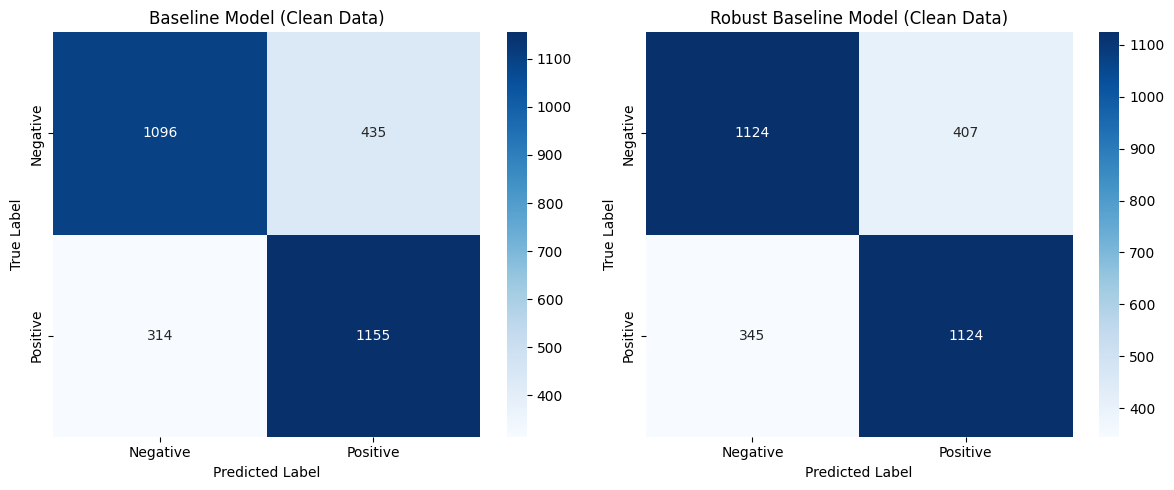

In [43]:
# prompt: afficher la matrice de confusion de model baselin et la matrice de robust baseline model

# Function to display confusion matrix
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Create subplots for the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Display the confusion matrix for the baseline model on clean data
plot_confusion_matrix(confusion_matrices['Baseline Clean'], 'Baseline Model (Clean Data)', axes[0])

# Display the confusion matrix for the robust model on clean data
plot_confusion_matrix(confusion_matrices['Robust Clean'], 'Robust Baseline Model (Clean Data)', axes[1])


plt.tight_layout()
plt.show()

In [48]:
# prompt: afficher la matrice de performence (les metrices: accuracy, recal, predict, f1-score and more) pour les deux models

from sklearn.metrics import classification_report
import pandas as pd

# Assuming you have calculated baseline_pipeline_actual and robust_pipeline
# And you have X_test, y_test, X_test_adv, y_test_adv available from previous cells

# Function to display detailed performance report
def display_performance_report(pipeline, X, y, model_name, dataset_name):
    """
    Predicts and displays classification report and confusion matrix.
    """
    y_pred = pipeline.predict(X)

    # Classification Report
    print(f"\n--- Classification Report for {model_name} on {dataset_name} ---")
    print(classification_report(y, y_pred, target_names=['Negative', 'Positive']))

# Display performance for Baseline model on Clean Data
display_performance_report(baseline_pipeline_actual, X_test, y_test, "Baseline Model", "Clean Test Data")

# Display performance for Robust model on Clean Data
display_performance_report(robust_pipeline, X_test, y_test, "Robust Model", "Clean Test Data")

textfooler_adv_path = f"{ROBUST_DIR}/combined_attacks/TextFooler_attacked.csv"

if os.path.exists(textfooler_adv_path):
    textfooler_df = pd.read_csv(textfooler_adv_path)
    # Filter valid entries similar to your evaluation loop
    textfooler_df['ground_truth_processed'] = textfooler_df['ground_truth'].astype(str).str.strip().str.lower()
    filtered_textfooler_df = textfooler_df[textfooler_df['ground_truth_processed'].isin(['negative', 'positive'])].copy()

    if not filtered_textfooler_df.empty:
        X_test_adv_tf = filtered_textfooler_df['perturbed_text'].tolist()
        y_test_adv_tf = filtered_textfooler_df['ground_truth_processed'].map({'negative': 0, 'positive': 1}).tolist()

        if X_test_adv_tf:
             display_performance_report(baseline_pipeline_actual, X_test_adv_tf, y_test_adv_tf, "Baseline Model", "TextFooler Adversarial Data")
             display_performance_report(robust_pipeline, X_test_adv_tf, y_test_adv_tf, "Robust Model", "TextFooler Adversarial Data")
        else:
            print(f"\nSkipping evaluation on TextFooler adversarial data: Filtered data is empty.")
    else:
        print(f"\nSkipping evaluation on TextFooler adversarial data: No valid ground truth labels found.")
else:
    print(f"\nSkipping evaluation on TextFooler adversarial data: File not found at {textfooler_adv_path}")

# You can repeat this process for other adversarial datasets (PWWS, DeepWordBug)
# or combine them into a single adversarial test set before evaluating.
# The code you provided already calculates metrics for each attack type separately,
# and saves them to an Excel/CSV file and generates bar plots.
# This code snippet focuses on displaying the detailed classification report and confusion matrix visually.




--- Classification Report for Baseline Model on Clean Test Data ---
              precision    recall  f1-score   support

    Negative       0.78      0.72      0.75      1531
    Positive       0.73      0.79      0.76      1469

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000


--- Classification Report for Robust Model on Clean Test Data ---
              precision    recall  f1-score   support

    Negative       0.77      0.73      0.75      1531
    Positive       0.73      0.77      0.75      1469

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000


Skipping evaluation on TextFooler adversarial data: File not found at /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/TextFooler_attacked.csv


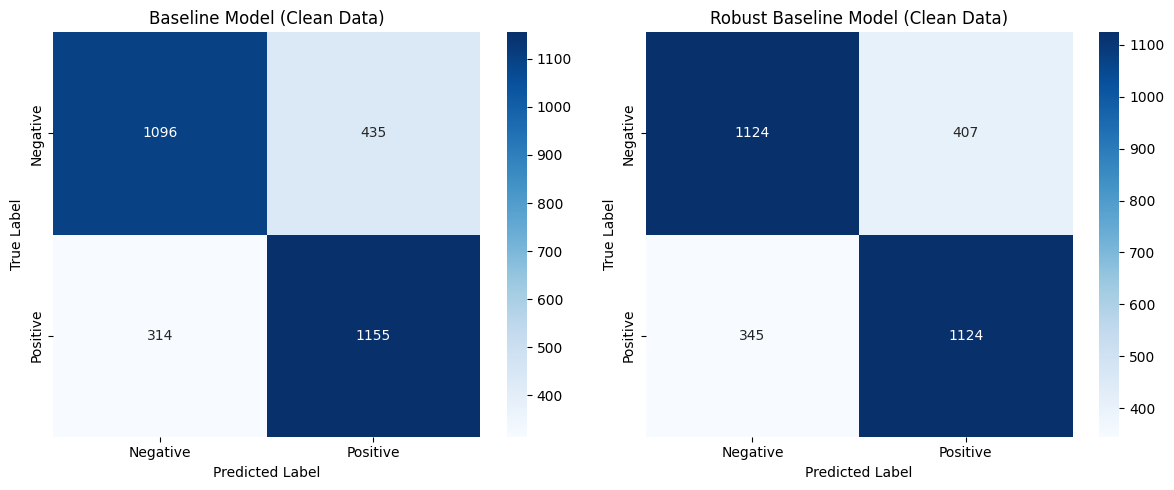


--- Classification Report for Baseline Model on Clean Test Data ---
              precision    recall  f1-score   support

    Negative       0.78      0.72      0.75      1531
    Positive       0.73      0.79      0.76      1469

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000


--- Classification Report for Robust Model on Clean Test Data ---
              precision    recall  f1-score   support

    Negative       0.77      0.73      0.75      1531
    Positive       0.73      0.77      0.75      1469

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000


Skipping evaluation on TextFooler adversarial data: File not found at /content/drive/MyDrive/Colab Notebooks/Data_RO/results/robust/combined_attacks/TextFooler_attacked.csv


In [49]:
# prompt: save this resultats in the drive under comparaison of two models in baseline png

# Plotting
# Comparison of metrics
plt.figure(figsize=(14, 8))
metrics_melted = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Recall', 'F1-Score'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Model Performance Comparison Across Attacks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save to Drive
plot_path_comparison = f"{ROBUST_DIR}/comparaison of two models in baseline.png"
plt.savefig(plot_path_comparison)
plt.close()

logger.info(f"Saved comparison plot to {plot_path_comparison}")


# Confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Confusion Matrices')
axes = axes.ravel()
i = 0
for model_name, cm in confusion_matrices.items():
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    i += 1
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save to Drive
plot_path_cm = f"{ROBUST_DIR}/confusion_matrices_comparison.png" # You might want a different name if you already saved one above
plt.savefig(plot_path_cm)
plt.close()

logger.info(f"Saved confusion matrices plot to {plot_path_cm}")

# Function to display confusion matrix (retained from previous block)
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Create subplots for the confusion matrices (retained from previous block)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Display the confusion matrix for the baseline model on clean data
plot_confusion_matrix(confusion_matrices['Baseline Clean'], 'Baseline Model (Clean Data)', axes[0])

# Display the confusion matrix for the robust model on clean data
plot_confusion_matrix(confusion_matrices['Robust Clean'], 'Robust Baseline Model (Clean Data)', axes[1])

plt.tight_layout()
plt.show()


# Function to display detailed performance report (retained from previous block)
def display_performance_report(pipeline, X, y, model_name, dataset_name):
    """
    Predicts and displays classification report and confusion matrix.
    """
    y_pred = pipeline.predict(X)

    # Classification Report
    print(f"\n--- Classification Report for {model_name} on {dataset_name} ---")
    print(classification_report(y, y_pred, target_names=['Negative', 'Positive']))

# Display performance for Baseline model on Clean Data (retained from previous block)
display_performance_report(baseline_pipeline_actual, X_test, y_test, "Baseline Model", "Clean Test Data")

# Display performance for Robust model on Clean Data (retained from previous block)
display_performance_report(robust_pipeline, X_test, y_test, "Robust Model", "Clean Test Data")

# Display performance on TextFooler adversarial data (retained from previous block)
textfooler_adv_path = f"{ROBUST_DIR}/combined_attacks/TextFooler_attacked.csv"

if os.path.exists(textfooler_adv_path):
    textfooler_df = pd.read_csv(textfooler_adv_path)
    # Filter valid entries similar to your evaluation loop
    textfooler_df['ground_truth_processed'] = textfooler_df['ground_truth'].astype(str).str.strip().str.lower()
    filtered_textfooler_df = textfooler_df[textfooler_df['ground_truth_processed'].isin(['negative', 'positive'])].copy()

    if not filtered_textfooler_df.empty:
        X_test_adv_tf = filtered_textfooler_df['perturbed_text'].tolist()
        y_test_adv_tf = filtered_textfooler_df['ground_truth_processed'].map({'negative': 0, 'positive': 1}).tolist()

        if X_test_adv_tf:
             display_performance_report(baseline_pipeline_actual, X_test_adv_tf, y_test_adv_tf, "Baseline Model", "TextFooler Adversarial Data")
             display_performance_report(robust_pipeline, X_test_adv_tf, y_test_adv_tf, "Robust Model", "TextFooler Adversarial Data")
        else:
            print(f"\nSkipping evaluation on TextFooler adversarial data: Filtered data is empty.")
    else:
        print(f"\nSkipping evaluation on TextFooler adversarial data: No valid ground truth labels found.")
else:
    print(f"\nSkipping evaluation on TextFooler adversarial data: File not found at {textfooler_adv_path}")


In [ ]:
# prompt: is there any  thing that i need to visualise in this project ?

Yes, based on the provided code, there are several visualizations already included and you could potentially add more to further enhance the analysis.

Here's a breakdown of the visualizations present and potential additions:

**Visualizations Present:**

1.  **Model Performance Comparison Across Attacks:**
    *   The code generates a bar plot comparing the 'Accuracy', 'Recall', and 'F1-Score' for the 'Baseline' and 'Robust' models across 'Clean' data and the results of different attack recipes ('TextFooler', 'PWWS', 'DeepWordBug').
    *   This is a crucial visualization for understanding how the robust model performs compared to the baseline model under adversarial conditions.

2.  **Confusion Matrices:**
    *   The code generates a series of confusion matrices.
    *   There's a loop that creates heatmaps for the confusion matrix of each model (Baseline and Robust) evaluated on the 'Clean' data and the adversarial examples generated by each attack recipe.
    *   Additionally, there's a separate visualization specifically for the confusion matrices of the Baseline and Robust models *only* on the 'Clean' data.
    *   Confusion matrices are vital for understanding the types of errors each model makes (false positives, false negatives).

**Potential Additional Visualizations:**

1.  **Attack Success Rate by Attack Type:**
    *   Although the code logs the number of successful attacks, a bar plot showing the success rate of each attack recipe against both the baseline and robust models could be very insightful. This would directly illustrate how much harder it is for the attacks to fool the robust model. You would need to calculate the success rate from the attack result files.

2.  **Distribution of Perturbation Distance (if available):**
    *   If TextAttack provides metrics related to the "distance" of the adversarial perturbation (e.g., word changes, character changes), visualizing the distribution of these distances for successful attacks could show if the robust model requires larger perturbations to be fooled.

3.  **Analysis of Words Changed in Adversarial Examples:**
    *   While more advanced, analyzing the words that are most frequently changed by the attacks could provide insights into which tokens the models are sensitive to. This could involve looking at the difference between original and perturbed texts in successful attacks.

4.  **Distribution of Original vs. Perturbed Confidence Scores:**
    *   For successful attacks, you could visualize the model's prediction confidence for the original text versus the perturbed text. A successful attack flips the prediction with high confidence on the original text but low confidence or a different class with high confidence on the perturbed text. This would require accessing or recalculating prediction probabilities for both the original and perturbed texts.

In summary, the project already includes key visualizations to compare the performance and error types of the baseline and robust models. Adding visualizations related to the attack success rates and the nature of the adversarial perturbations would provide a more comprehensive understanding of the adversarial robustness achieved.

In [51]:
# prompt: visualise Model Performance Comparison Across Attacks and save it

# Re-plot Model Performance Comparison Across Attacks to ensure it's saved
plt.figure(figsize=(14, 8))
metrics_melted = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Recall', 'F1-Score'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Model Performance Comparison Across Attacks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save to Drive
plot_path_comparison = f"{ROBUST_DIR}/model_performance_comparison.png"
plt.savefig(plot_path_comparison)
plt.close()

logger.info(f"Saved comparison plot to {plot_path_comparison}")

# Re-plot Confusion matrices to ensure they are saved
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Confusion Matrices')
axes = axes.ravel()
i = 0
for model_name, cm in confusion_matrices.items():
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    i += 1
    if i >= len(axes): # Stop if we run out of axes (handle cases where not all attacks ran)
        break

# Hide unused subplots if there are fewer than 8 matrices
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save to Drive
plot_path_cm = f"{ROBUST_DIR}/confusion_matrices_all.png"
plt.savefig(plot_path_cm)
plt.close()

logger.info(f"Saved all confusion matrices plot to {plot_path_cm}")